In [1]:
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2, mutual_info_classif, VarianceThreshold

import pandas as pd
import xgboost as xgb

import matplotlib.pyplot as plt
import seaborn as sns

# I. Подготовка данных.

In [2]:
df = pd.read_excel('default of credit card clients.xls', skiprows=1)

In [3]:
df.head()

ID  LIMIT_BAL  SEX  EDUCATION  MARRIAGE  AGE  PAY_0  PAY_2  PAY_3  PAY_4  \
0   1      20000    2          2         1   24      2      2     -1     -1   
1   2     120000    2          2         2   26     -1      2      0      0   
2   3      90000    2          2         2   34      0      0      0      0   
3   4      50000    2          2         1   37      0      0      0      0   
4   5      50000    1          2         1   57     -1      0     -1      0   

              ...              BILL_AMT4  BILL_AMT5  BILL_AMT6  PAY_AMT1  \
0             ...                      0          0          0         0   
1             ...                   3272       3455       3261         0   
2             ...                  14331      14948      15549      1518   
3             ...                  28314      28959      29547      2000   
4             ...                  20940      19146      19131      2000   

   PAY_AMT2  PAY_AMT3  PAY_AMT4  PAY_AMT5  PAY_AMT6  \
0       689         0         0         0         0   
1      1000      1000      1000         0      2000   
2      1500      1000      1000      1000      5000   
3      2019      1200      1100      1069      1000   
4     36681     10000      9000       689       679   

   default payment next month  
0                           1  
1                           1  
2                           0  
3                           0  
4                           0  

[5 rows x 25 columns]

In [4]:
df.columns

Index(['ID', 'LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_0',
       'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2',
       'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1',
       'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6',
       'default payment next month'],
      dtype='object')

In [5]:
df.set_index('ID', inplace=True)

In [6]:
df.select_dtypes(exclude='object').head()

LIMIT_BAL  SEX  EDUCATION  MARRIAGE  AGE  PAY_0  PAY_2  PAY_3  PAY_4  \
ID                                                                         
1       20000    2          2         1   24      2      2     -1     -1   
2      120000    2          2         2   26     -1      2      0      0   
3       90000    2          2         2   34      0      0      0      0   
4       50000    2          2         1   37      0      0      0      0   
5       50000    1          2         1   57     -1      0     -1      0   

    PAY_5             ...              BILL_AMT4  BILL_AMT5  BILL_AMT6  \
ID                    ...                                                
1      -2             ...                      0          0          0   
2       0             ...                   3272       3455       3261   
3       0             ...                  14331      14948      15549   
4       0             ...                  28314      28959      29547   
5       0             ...                  20940      19146      19131   

    PAY_AMT1  PAY_AMT2  PAY_AMT3  PAY_AMT4  PAY_AMT5  PAY_AMT6  \
ID                                                               
1          0       689         0         0         0         0   
2          0      1000      1000      1000         0      2000   
3       1518      1500      1000      1000      1000      5000   
4       2000      2019      1200      1100      1069      1000   
5       2000     36681     10000      9000       689       679   

    default payment next month  
ID                              
1                            1  
2                            1  
3                            0  
4                            0  
5                            0  

[5 rows x 24 columns]

In [7]:
X = df.drop('default payment next month', axis=1)
y = df['default payment next month']

# II. Filter methods

## 1. Mutual information

In [8]:
mutual_information = mutual_info_classif(X, y)

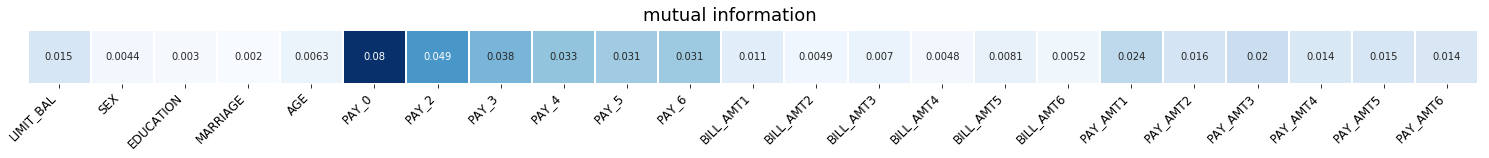

In [9]:
plt.subplots(1, figsize=(26, 1))
sns.heatmap(mutual_information.reshape(1, -1), cmap='Blues', cbar=False, linewidths=1, annot=True)
plt.yticks([], [])
plt.gca().set_xticklabels(X.columns, rotation=45, ha='right', fontsize=12)
plt.suptitle("mutual information", fontsize=18, y=1.2)
plt.show()

In [10]:
mutual_information_threshold = 0.01
X_new = X[X.columns[mutual_information > mutual_information_threshold]]

In [11]:
X_new.shape

(30000, 14)

In [12]:
def gini(target, feature):
    return 2*roc_auc_score(target, feature) - 1

# III. Modeling

In [13]:
X_new.shape

(30000, 14)

In [14]:
xgb_params = {
    'n_estimators': 1000,
    'learning_rate': 0.01,
    'n_jobs': -1,
    'objective': 'binary:logistic', 
    'tree_method': 'gpu_exact'
}

In [15]:
model = xgb.XGBClassifier(**xgb_params)

In [16]:
model

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.01, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=1000,
       n_jobs=-1, nthread=None, objective='binary:logistic',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=1, tree_method='gpu_exact')

In [17]:
X_train, X_val, y_train, y_val = train_test_split(X_new, y, test_size=0.33, random_state=42, stratify=y)

In [18]:
%%time
model.fit(X_new, y, early_stopping_rounds=10, eval_metric=['logloss', 'auc'], eval_set=[(X_train, y_train), (X_val, y_val)], 
          verbose=True)

[0]	validation_0-logloss:0.688686	validation_0-auc:0.734957	validation_1-logloss:0.688717	validation_1-auc:0.732052
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 10 rounds.
[1]	validation_0-logloss:0.684312	validation_0-auc:0.734957	validation_1-logloss:0.684375	validation_1-auc:0.732052
[2]	validation_0-logloss:0.680025	validation_0-auc:0.73505	validation_1-logloss:0.68012	validation_1-auc:0.732135
[3]	validation_0-logloss:0.675822	validation_0-auc:0.735079	validation_1-logloss:0.675947	validation_1-auc:0.732241
[4]	validation_0-logloss:0.671701	validation_0-auc:0.735079	validation_1-logloss:0.671856	validation_1-auc:0.732241
[5]	validation_0-logloss:0.667657	validation_0-auc:0.749493	validation_1-logloss:0.66785	validation_1-auc:0.744716
[6]	validation_0-logloss:0.663693	validation_0-auc:0.749493	validation_1-logloss:0.663917	validation_1-auc:0.744716
[7]	validation_0-logloss:0.659803	

[70]	validation_0-logloss:0.513912	validation_0-auc:0.76818	validation_1-logloss:0.515979	validation_1-auc:0.76258
[71]	validation_0-logloss:0.512615	validation_0-auc:0.768161	validation_1-logloss:0.514711	validation_1-auc:0.762542
[72]	validation_0-logloss:0.511341	validation_0-auc:0.768259	validation_1-logloss:0.513456	validation_1-auc:0.762594
[73]	validation_0-logloss:0.510076	validation_0-auc:0.768555	validation_1-logloss:0.512214	validation_1-auc:0.762971
[74]	validation_0-logloss:0.508843	validation_0-auc:0.768537	validation_1-logloss:0.511004	validation_1-auc:0.762889
[75]	validation_0-logloss:0.507624	validation_0-auc:0.768624	validation_1-logloss:0.509821	validation_1-auc:0.762865
[76]	validation_0-logloss:0.506422	validation_0-auc:0.768826	validation_1-logloss:0.508633	validation_1-auc:0.763046
[77]	validation_0-logloss:0.505247	validation_0-auc:0.768827	validation_1-logloss:0.507482	validation_1-auc:0.763046
[78]	validation_0-logloss:0.504081	validation_0-auc:0.769038	valid

[140]	validation_0-logloss:0.458492	validation_0-auc:0.773973	validation_1-logloss:0.461869	validation_1-auc:0.768219
[141]	validation_0-logloss:0.458046	validation_0-auc:0.77408	validation_1-logloss:0.461432	validation_1-auc:0.768334
[142]	validation_0-logloss:0.457613	validation_0-auc:0.774119	validation_1-logloss:0.461009	validation_1-auc:0.768379
[143]	validation_0-logloss:0.4572	validation_0-auc:0.774089	validation_1-logloss:0.460605	validation_1-auc:0.768393
[144]	validation_0-logloss:0.456773	validation_0-auc:0.774311	validation_1-logloss:0.460189	validation_1-auc:0.768673
[145]	validation_0-logloss:0.456362	validation_0-auc:0.774356	validation_1-logloss:0.459786	validation_1-auc:0.768784
[146]	validation_0-logloss:0.455955	validation_0-auc:0.774415	validation_1-logloss:0.459388	validation_1-auc:0.768814
[147]	validation_0-logloss:0.455562	validation_0-auc:0.774419	validation_1-logloss:0.459017	validation_1-auc:0.768803
[148]	validation_0-logloss:0.455168	validation_0-auc:0.7745

[210]	validation_0-logloss:0.439152	validation_0-auc:0.778182	validation_1-logloss:0.443213	validation_1-auc:0.772654
[211]	validation_0-logloss:0.438984	validation_0-auc:0.778249	validation_1-logloss:0.443052	validation_1-auc:0.772691
[212]	validation_0-logloss:0.438822	validation_0-auc:0.778279	validation_1-logloss:0.442903	validation_1-auc:0.772591
[213]	validation_0-logloss:0.438669	validation_0-auc:0.778344	validation_1-logloss:0.442749	validation_1-auc:0.772683
[214]	validation_0-logloss:0.438504	validation_0-auc:0.778386	validation_1-logloss:0.442594	validation_1-auc:0.772799
[215]	validation_0-logloss:0.438344	validation_0-auc:0.77848	validation_1-logloss:0.442441	validation_1-auc:0.772818
[216]	validation_0-logloss:0.438191	validation_0-auc:0.778534	validation_1-logloss:0.442302	validation_1-auc:0.772795
[217]	validation_0-logloss:0.438035	validation_0-auc:0.778615	validation_1-logloss:0.442156	validation_1-auc:0.772831
[218]	validation_0-logloss:0.43788	validation_0-auc:0.778

[280]	validation_0-logloss:0.431366	validation_0-auc:0.781798	validation_1-logloss:0.435924	validation_1-auc:0.775543
[281]	validation_0-logloss:0.431298	validation_0-auc:0.781903	validation_1-logloss:0.43586	validation_1-auc:0.775718
[282]	validation_0-logloss:0.431228	validation_0-auc:0.781938	validation_1-logloss:0.435794	validation_1-auc:0.775729
[283]	validation_0-logloss:0.431161	validation_0-auc:0.781947	validation_1-logloss:0.435734	validation_1-auc:0.775711
[284]	validation_0-logloss:0.431093	validation_0-auc:0.781962	validation_1-logloss:0.435669	validation_1-auc:0.775715
[285]	validation_0-logloss:0.431022	validation_0-auc:0.781997	validation_1-logloss:0.435607	validation_1-auc:0.775718
[286]	validation_0-logloss:0.430956	validation_0-auc:0.782075	validation_1-logloss:0.435546	validation_1-auc:0.775836
[287]	validation_0-logloss:0.430888	validation_0-auc:0.782108	validation_1-logloss:0.435461	validation_1-auc:0.775915
[288]	validation_0-logloss:0.43082	validation_0-auc:0.782

[350]	validation_0-logloss:0.427664	validation_0-auc:0.784869	validation_1-logloss:0.43217	validation_1-auc:0.77931
[351]	validation_0-logloss:0.42763	validation_0-auc:0.78493	validation_1-logloss:0.432138	validation_1-auc:0.779382
[352]	validation_0-logloss:0.427584	validation_0-auc:0.78501	validation_1-logloss:0.432084	validation_1-auc:0.779454
[353]	validation_0-logloss:0.427542	validation_0-auc:0.785048	validation_1-logloss:0.432035	validation_1-auc:0.779528
[354]	validation_0-logloss:0.427502	validation_0-auc:0.785113	validation_1-logloss:0.431985	validation_1-auc:0.779628
[355]	validation_0-logloss:0.42746	validation_0-auc:0.785191	validation_1-logloss:0.431928	validation_1-auc:0.779771
[356]	validation_0-logloss:0.42742	validation_0-auc:0.785244	validation_1-logloss:0.431878	validation_1-auc:0.779849
[357]	validation_0-logloss:0.427376	validation_0-auc:0.78529	validation_1-logloss:0.431826	validation_1-auc:0.779961
[358]	validation_0-logloss:0.42734	validation_0-auc:0.785303	val

[420]	validation_0-logloss:0.425418	validation_0-auc:0.787231	validation_1-logloss:0.429562	validation_1-auc:0.782865
[421]	validation_0-logloss:0.4254	validation_0-auc:0.787255	validation_1-logloss:0.429532	validation_1-auc:0.782922
[422]	validation_0-logloss:0.425368	validation_0-auc:0.78729	validation_1-logloss:0.429491	validation_1-auc:0.783004
[423]	validation_0-logloss:0.425343	validation_0-auc:0.787303	validation_1-logloss:0.429471	validation_1-auc:0.783004
[424]	validation_0-logloss:0.425323	validation_0-auc:0.787324	validation_1-logloss:0.429444	validation_1-auc:0.78308
[425]	validation_0-logloss:0.425299	validation_0-auc:0.787337	validation_1-logloss:0.429424	validation_1-auc:0.783073
[426]	validation_0-logloss:0.425282	validation_0-auc:0.787363	validation_1-logloss:0.429397	validation_1-auc:0.78312
[427]	validation_0-logloss:0.425256	validation_0-auc:0.787394	validation_1-logloss:0.429363	validation_1-auc:0.783156
[428]	validation_0-logloss:0.42523	validation_0-auc:0.787393	

[490]	validation_0-logloss:0.423863	validation_0-auc:0.788741	validation_1-logloss:0.427815	validation_1-auc:0.785206
[491]	validation_0-logloss:0.423839	validation_0-auc:0.788775	validation_1-logloss:0.427789	validation_1-auc:0.785253
[492]	validation_0-logloss:0.423813	validation_0-auc:0.788813	validation_1-logloss:0.427762	validation_1-auc:0.7853
[493]	validation_0-logloss:0.423799	validation_0-auc:0.78883	validation_1-logloss:0.427744	validation_1-auc:0.785332
[494]	validation_0-logloss:0.423774	validation_0-auc:0.788864	validation_1-logloss:0.427716	validation_1-auc:0.78536
[495]	validation_0-logloss:0.423752	validation_0-auc:0.788906	validation_1-logloss:0.427692	validation_1-auc:0.785404
[496]	validation_0-logloss:0.423735	validation_0-auc:0.788924	validation_1-logloss:0.427671	validation_1-auc:0.785418
[497]	validation_0-logloss:0.423715	validation_0-auc:0.78895	validation_1-logloss:0.427639	validation_1-auc:0.785465
[498]	validation_0-logloss:0.4237	validation_0-auc:0.788964	v

[560]	validation_0-logloss:0.422579	validation_0-auc:0.790252	validation_1-logloss:0.426447	validation_1-auc:0.787038
[561]	validation_0-logloss:0.422559	validation_0-auc:0.790272	validation_1-logloss:0.426442	validation_1-auc:0.787035
[562]	validation_0-logloss:0.422544	validation_0-auc:0.790289	validation_1-logloss:0.426422	validation_1-auc:0.78707
[563]	validation_0-logloss:0.422527	validation_0-auc:0.790315	validation_1-logloss:0.42641	validation_1-auc:0.787087
[564]	validation_0-logloss:0.422516	validation_0-auc:0.790334	validation_1-logloss:0.426395	validation_1-auc:0.787119
[565]	validation_0-logloss:0.422504	validation_0-auc:0.790343	validation_1-logloss:0.426379	validation_1-auc:0.787142
[566]	validation_0-logloss:0.422473	validation_0-auc:0.790385	validation_1-logloss:0.42634	validation_1-auc:0.78719
[567]	validation_0-logloss:0.422462	validation_0-auc:0.790411	validation_1-logloss:0.42632	validation_1-auc:0.78722
[568]	validation_0-logloss:0.422446	validation_0-auc:0.790438	

[630]	validation_0-logloss:0.421517	validation_0-auc:0.791631	validation_1-logloss:0.425219	validation_1-auc:0.78872
[631]	validation_0-logloss:0.421508	validation_0-auc:0.791644	validation_1-logloss:0.425203	validation_1-auc:0.788743
[632]	validation_0-logloss:0.421497	validation_0-auc:0.791668	validation_1-logloss:0.425184	validation_1-auc:0.788769
[633]	validation_0-logloss:0.421485	validation_0-auc:0.791683	validation_1-logloss:0.425166	validation_1-auc:0.78879
[634]	validation_0-logloss:0.421471	validation_0-auc:0.791694	validation_1-logloss:0.425162	validation_1-auc:0.788783
[635]	validation_0-logloss:0.421461	validation_0-auc:0.791705	validation_1-logloss:0.425149	validation_1-auc:0.788805
[636]	validation_0-logloss:0.421446	validation_0-auc:0.791723	validation_1-logloss:0.425134	validation_1-auc:0.788827
[637]	validation_0-logloss:0.421433	validation_0-auc:0.791741	validation_1-logloss:0.425124	validation_1-auc:0.788834
[638]	validation_0-logloss:0.421416	validation_0-auc:0.791

[700]	validation_0-logloss:0.420504	validation_0-auc:0.793056	validation_1-logloss:0.424099	validation_1-auc:0.790275
[701]	validation_0-logloss:0.420493	validation_0-auc:0.793069	validation_1-logloss:0.424085	validation_1-auc:0.790296
[702]	validation_0-logloss:0.420487	validation_0-auc:0.793071	validation_1-logloss:0.424072	validation_1-auc:0.790313
[703]	validation_0-logloss:0.420469	validation_0-auc:0.793093	validation_1-logloss:0.424047	validation_1-auc:0.79035
[704]	validation_0-logloss:0.420458	validation_0-auc:0.793109	validation_1-logloss:0.424039	validation_1-auc:0.790353
[705]	validation_0-logloss:0.420445	validation_0-auc:0.793128	validation_1-logloss:0.424027	validation_1-auc:0.790375
[706]	validation_0-logloss:0.420427	validation_0-auc:0.793149	validation_1-logloss:0.424006	validation_1-auc:0.790395
[707]	validation_0-logloss:0.420409	validation_0-auc:0.793171	validation_1-logloss:0.423998	validation_1-auc:0.790397
[708]	validation_0-logloss:0.420399	validation_0-auc:0.79

[770]	validation_0-logloss:0.419651	validation_0-auc:0.794299	validation_1-logloss:0.423148	validation_1-auc:0.791571
[771]	validation_0-logloss:0.419639	validation_0-auc:0.794319	validation_1-logloss:0.423125	validation_1-auc:0.791617
[772]	validation_0-logloss:0.419633	validation_0-auc:0.794327	validation_1-logloss:0.423115	validation_1-auc:0.79163
[773]	validation_0-logloss:0.419625	validation_0-auc:0.794336	validation_1-logloss:0.423108	validation_1-auc:0.791645
[774]	validation_0-logloss:0.419605	validation_0-auc:0.794364	validation_1-logloss:0.423079	validation_1-auc:0.791695
[775]	validation_0-logloss:0.419589	validation_0-auc:0.794392	validation_1-logloss:0.423066	validation_1-auc:0.791709
[776]	validation_0-logloss:0.419579	validation_0-auc:0.794405	validation_1-logloss:0.423055	validation_1-auc:0.791727
[777]	validation_0-logloss:0.419576	validation_0-auc:0.794407	validation_1-logloss:0.423047	validation_1-auc:0.79174
[778]	validation_0-logloss:0.419569	validation_0-auc:0.794

[840]	validation_0-logloss:0.418951	validation_0-auc:0.795305	validation_1-logloss:0.422314	validation_1-auc:0.792798
[841]	validation_0-logloss:0.418941	validation_0-auc:0.795323	validation_1-logloss:0.422293	validation_1-auc:0.792837
[842]	validation_0-logloss:0.418932	validation_0-auc:0.795341	validation_1-logloss:0.422283	validation_1-auc:0.792859
[843]	validation_0-logloss:0.418923	validation_0-auc:0.795354	validation_1-logloss:0.422271	validation_1-auc:0.792876
[844]	validation_0-logloss:0.418916	validation_0-auc:0.795364	validation_1-logloss:0.422265	validation_1-auc:0.792885
[845]	validation_0-logloss:0.4189	validation_0-auc:0.795393	validation_1-logloss:0.422258	validation_1-auc:0.792901
[846]	validation_0-logloss:0.418889	validation_0-auc:0.795401	validation_1-logloss:0.422252	validation_1-auc:0.792904
[847]	validation_0-logloss:0.418877	validation_0-auc:0.795413	validation_1-logloss:0.422239	validation_1-auc:0.792921
[848]	validation_0-logloss:0.418863	validation_0-auc:0.795

[910]	validation_0-logloss:0.41825	validation_0-auc:0.796406	validation_1-logloss:0.42158	validation_1-auc:0.794019
[911]	validation_0-logloss:0.41824	validation_0-auc:0.796431	validation_1-logloss:0.421569	validation_1-auc:0.794039
[912]	validation_0-logloss:0.418229	validation_0-auc:0.796446	validation_1-logloss:0.421557	validation_1-auc:0.794058
[913]	validation_0-logloss:0.418215	validation_0-auc:0.796484	validation_1-logloss:0.421547	validation_1-auc:0.794077
[914]	validation_0-logloss:0.418207	validation_0-auc:0.796497	validation_1-logloss:0.421538	validation_1-auc:0.794095
[915]	validation_0-logloss:0.418195	validation_0-auc:0.796514	validation_1-logloss:0.421529	validation_1-auc:0.794118
[916]	validation_0-logloss:0.418187	validation_0-auc:0.796525	validation_1-logloss:0.421518	validation_1-auc:0.794124
[917]	validation_0-logloss:0.418177	validation_0-auc:0.79654	validation_1-logloss:0.421507	validation_1-auc:0.794139
[918]	validation_0-logloss:0.418171	validation_0-auc:0.79654

[980]	validation_0-logloss:0.417568	validation_0-auc:0.797562	validation_1-logloss:0.420842	validation_1-auc:0.795268
[981]	validation_0-logloss:0.417558	validation_0-auc:0.797581	validation_1-logloss:0.420832	validation_1-auc:0.795287
[982]	validation_0-logloss:0.417552	validation_0-auc:0.797588	validation_1-logloss:0.420822	validation_1-auc:0.795302
[983]	validation_0-logloss:0.417546	validation_0-auc:0.797594	validation_1-logloss:0.420817	validation_1-auc:0.795308
[984]	validation_0-logloss:0.417537	validation_0-auc:0.797604	validation_1-logloss:0.420809	validation_1-auc:0.795323
[985]	validation_0-logloss:0.41753	validation_0-auc:0.797616	validation_1-logloss:0.420801	validation_1-auc:0.79533
[986]	validation_0-logloss:0.417522	validation_0-auc:0.797625	validation_1-logloss:0.420793	validation_1-auc:0.795344
[987]	validation_0-logloss:0.417509	validation_0-auc:0.797658	validation_1-logloss:0.420784	validation_1-auc:0.795358
[988]	validation_0-logloss:0.417498	validation_0-auc:0.797

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.01, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=1000,
       n_jobs=-1, nthread=None, objective='binary:logistic',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=1, tree_method='gpu_exact')

In [19]:
y_pred = model.predict_proba(X_val)[:, 1]

In [20]:
y_pred.shape

(9900,)

In [21]:
gini(y_val, y_pred)

0.5910414038578848

In [22]:
roc_auc_score(y_val, y_pred)

0.7955207019289424

In [23]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV

In [24]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [25]:
list(skf.split(X_train, y_train))[0][0].shape, list(skf.split(X_train, y_train))[0][1].shape

((16079,), (4021,))

In [26]:
param_grid = {
                'max_depth': [7, 9, 12, 15],
                'subsample': [0.7, 0.8, 0.9, 1],
                'colsample_bytree': [0.5, 0.8, 1],
                'colsample_bylevel': [0.5, 0.8, 1],
                'min_child_weight': [0.5, 1, 2, 5],
    }

In [27]:
fit_params = {
                "early_stopping_rounds": 10, 
                "eval_metric": ['logloss', 'auc'], 
                "eval_set": [(X_train, y_train), (X_val, y_val)],
                'verbose': True
    }

In [30]:
grid_search = GridSearchCV(model, param_grid=param_grid, scoring='roc_auc', fit_params=fit_params, cv=skf.split(X_train, y_train), verbose=2)

In [31]:
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 1728 candidates, totalling 8640 fits
[CV] colsample_bylevel=0.5, colsample_bytree=0.5, learning_rate=0.01, max_depth=7, min_child_weight=0.5, subsample=0.7 
[0]	validation_0-logloss:0.688377	validation_0-auc:0.781932	validation_1-logloss:0.68859	validation_1-auc:0.754538
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 10 rounds.
[1]	validation_0-logloss:0.683709	validation_0-auc:0.782191	validation_1-logloss:0.684111	validation_1-auc:0.756768
[2]	validation_0-logloss:0.679123	validation_0-auc:0.783498	validation_1-logloss:0.679742	validation_1-auc:0.756628
[3]	validation_0-logloss:0.674632	validation_0-auc:0.783349	validation_1-logloss:0.675445	validation_1-auc:0.757008
[4]	validation_0-logloss:0.670223	validation_0-auc:0.783515	validation_1-logloss:0.671244	validation_1-auc:0.756763
[5]	validation_0-logloss:0.665899	validation_0-auc:0.783448	validation_1-loglos

C:\Users\MarkLyubimov\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:643: DeprecationWarning: "fit_params" as a constructor argument was deprecated in version 0.19 and will be removed in version 0.21. Pass fit parameters to the "fit" method instead.
  '"fit" method instead.', DeprecationWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[9]	validation_0-logloss:0.649403	validation_0-auc:0.785969	validation_1-logloss:0.651451	validation_1-auc:0.756996
[10]	validation_0-logloss:0.645462	validation_0-auc:0.786244	validation_1-logloss:0.647724	validation_1-auc:0.757134
[11]	validation_0-logloss:0.641584	validation_0-auc:0.787804	validation_1-logloss:0.644067	validation_1-auc:0.757821
[12]	validation_0-logloss:0.637798	validation_0-auc:0.78778	validation_1-logloss:0.640491	validation_1-auc:0.757619
[13]	validation_0-logloss:0.634077	validation_0-auc:0.787722	validation_1-logloss:0.63697	validation_1-auc:0.757532
[14]	validation_0-logloss:0.630422	validation_0-auc:0.787898	validation_1-logloss:0.633515	validation_1-auc:0.758035
[15]	validation_0-logloss:0.626808	validation_0-auc:0.788421	validation_1-logloss:0.63013	validation_1-auc:0.757975
[16]	validation_0-logloss:0.623294	validation_0-auc:0.788438	validation_1-logloss:0.626807	validation_1-auc:0.757781
[17]	validation_0-logloss:0.619836	validation_0-auc:0.788416	validat

[80]	validation_0-logloss:0.485551	validation_0-auc:0.805266	validation_1-logloss:0.501069	validation_1-auc:0.766753
[81]	validation_0-logloss:0.484301	validation_0-auc:0.805448	validation_1-logloss:0.499992	validation_1-auc:0.766916
[82]	validation_0-logloss:0.483064	validation_0-auc:0.805716	validation_1-logloss:0.498955	validation_1-auc:0.766991
[83]	validation_0-logloss:0.481831	validation_0-auc:0.806058	validation_1-logloss:0.497917	validation_1-auc:0.767123
[84]	validation_0-logloss:0.480619	validation_0-auc:0.806239	validation_1-logloss:0.49689	validation_1-auc:0.767186
[85]	validation_0-logloss:0.479423	validation_0-auc:0.806552	validation_1-logloss:0.49588	validation_1-auc:0.767164
[86]	validation_0-logloss:0.478235	validation_0-auc:0.806874	validation_1-logloss:0.494877	validation_1-auc:0.767364
[87]	validation_0-logloss:0.477079	validation_0-auc:0.807078	validation_1-logloss:0.493909	validation_1-auc:0.76747
[88]	validation_0-logloss:0.475936	validation_0-auc:0.807234	valida

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.8s remaining:    0.0s


[9]	validation_0-logloss:0.649102	validation_0-auc:0.787526	validation_1-logloss:0.651415	validation_1-auc:0.753617
[10]	validation_0-logloss:0.645143	validation_0-auc:0.787601	validation_1-logloss:0.647667	validation_1-auc:0.753605
[11]	validation_0-logloss:0.641261	validation_0-auc:0.787902	validation_1-logloss:0.644011	validation_1-auc:0.753927
[12]	validation_0-logloss:0.637447	validation_0-auc:0.788049	validation_1-logloss:0.640411	validation_1-auc:0.753898
[13]	validation_0-logloss:0.633698	validation_0-auc:0.788295	validation_1-logloss:0.636873	validation_1-auc:0.754048
[14]	validation_0-logloss:0.630028	validation_0-auc:0.788402	validation_1-logloss:0.633407	validation_1-auc:0.754125
[15]	validation_0-logloss:0.62641	validation_0-auc:0.788713	validation_1-logloss:0.630026	validation_1-auc:0.754493
[16]	validation_0-logloss:0.622861	validation_0-auc:0.788724	validation_1-logloss:0.626691	validation_1-auc:0.754333
[17]	validation_0-logloss:0.619379	validation_0-auc:0.788856	valid

[80]	validation_0-logloss:0.484985	validation_0-auc:0.807087	validation_1-logloss:0.500174	validation_1-auc:0.770128
[81]	validation_0-logloss:0.483723	validation_0-auc:0.807319	validation_1-logloss:0.499102	validation_1-auc:0.770093
[82]	validation_0-logloss:0.482462	validation_0-auc:0.807617	validation_1-logloss:0.498028	validation_1-auc:0.770138
[83]	validation_0-logloss:0.481212	validation_0-auc:0.807936	validation_1-logloss:0.496974	validation_1-auc:0.770277
[84]	validation_0-logloss:0.479997	validation_0-auc:0.808233	validation_1-logloss:0.495941	validation_1-auc:0.770321
[85]	validation_0-logloss:0.478792	validation_0-auc:0.808418	validation_1-logloss:0.494914	validation_1-auc:0.770338
[86]	validation_0-logloss:0.477614	validation_0-auc:0.808642	validation_1-logloss:0.493912	validation_1-auc:0.770423
[87]	validation_0-logloss:0.476447	validation_0-auc:0.808795	validation_1-logloss:0.492927	validation_1-auc:0.770442
[88]	validation_0-logloss:0.475304	validation_0-auc:0.809011	val

[44]	validation_0-logloss:0.545597	validation_0-auc:0.796862	validation_1-logloss:0.554255	validation_1-auc:0.763901
[45]	validation_0-logloss:0.543437	validation_0-auc:0.796936	validation_1-logloss:0.55228	validation_1-auc:0.763856
[46]	validation_0-logloss:0.541322	validation_0-auc:0.79702	validation_1-logloss:0.550306	validation_1-auc:0.764125
[47]	validation_0-logloss:0.53922	validation_0-auc:0.79728	validation_1-logloss:0.548392	validation_1-auc:0.764182
[48]	validation_0-logloss:0.53718	validation_0-auc:0.797332	validation_1-logloss:0.546516	validation_1-auc:0.764264
[49]	validation_0-logloss:0.535162	validation_0-auc:0.797439	validation_1-logloss:0.544671	validation_1-auc:0.764299
[50]	validation_0-logloss:0.533164	validation_0-auc:0.797583	validation_1-logloss:0.542854	validation_1-auc:0.764324
[51]	validation_0-logloss:0.53122	validation_0-auc:0.797593	validation_1-logloss:0.54108	validation_1-auc:0.764345
[52]	validation_0-logloss:0.529289	validation_0-auc:0.797623	validation

[115]	validation_0-logloss:0.45055	validation_0-auc:0.81035	validation_1-logloss:0.469924	validation_1-auc:0.772236
[116]	validation_0-logloss:0.449782	validation_0-auc:0.810553	validation_1-logloss:0.469307	validation_1-auc:0.772364
[117]	validation_0-logloss:0.449013	validation_0-auc:0.810628	validation_1-logloss:0.468685	validation_1-auc:0.772428
[118]	validation_0-logloss:0.448233	validation_0-auc:0.810903	validation_1-logloss:0.468066	validation_1-auc:0.77248
[119]	validation_0-logloss:0.447491	validation_0-auc:0.81108	validation_1-logloss:0.467488	validation_1-auc:0.772495
[120]	validation_0-logloss:0.446708	validation_0-auc:0.811403	validation_1-logloss:0.466893	validation_1-auc:0.77263
[121]	validation_0-logloss:0.445956	validation_0-auc:0.811703	validation_1-logloss:0.466294	validation_1-auc:0.772692
[122]	validation_0-logloss:0.445207	validation_0-auc:0.811975	validation_1-logloss:0.465729	validation_1-auc:0.772744
[123]	validation_0-logloss:0.444519	validation_0-auc:0.812024

[185]	validation_0-logloss:0.413385	validation_0-auc:0.823649	validation_1-logloss:0.443978	validation_1-auc:0.773453
Stopping. Best iteration:
[175]	validation_0-logloss:0.416899	validation_0-auc:0.822243	validation_1-logloss:0.44601	validation_1-auc:0.773615

[CV]  colsample_bylevel=0.5, colsample_bytree=0.5, learning_rate=0.01, max_depth=7, min_child_weight=0.5, subsample=0.7, total=   2.6s
[CV] colsample_bylevel=0.5, colsample_bytree=0.5, learning_rate=0.01, max_depth=7, min_child_weight=0.5, subsample=0.7 
[0]	validation_0-logloss:0.688366	validation_0-auc:0.781381	validation_1-logloss:0.688609	validation_1-auc:0.746564
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 10 rounds.
[1]	validation_0-logloss:0.683679	validation_0-auc:0.782009	validation_1-logloss:0.684168	validation_1-auc:0.747009
[2]	validation_0-logloss:0.679088	validation_0-auc:0.782107	validation_1-logloss:0.679811	vali

[65]	validation_0-logloss:0.506543	validation_0-auc:0.801035	validation_1-logloss:0.519108	validation_1-auc:0.769066
[66]	validation_0-logloss:0.504984	validation_0-auc:0.801529	validation_1-logloss:0.517707	validation_1-auc:0.769306
[67]	validation_0-logloss:0.503431	validation_0-auc:0.801631	validation_1-logloss:0.516364	validation_1-auc:0.769248
[68]	validation_0-logloss:0.501866	validation_0-auc:0.802231	validation_1-logloss:0.51502	validation_1-auc:0.76933
[69]	validation_0-logloss:0.500331	validation_0-auc:0.802799	validation_1-logloss:0.51369	validation_1-auc:0.769504
[70]	validation_0-logloss:0.498818	validation_0-auc:0.803258	validation_1-logloss:0.512396	validation_1-auc:0.769498
[71]	validation_0-logloss:0.497328	validation_0-auc:0.803793	validation_1-logloss:0.511129	validation_1-auc:0.769515
[72]	validation_0-logloss:0.495863	validation_0-auc:0.804159	validation_1-logloss:0.509878	validation_1-auc:0.769504
[73]	validation_0-logloss:0.494414	validation_0-auc:0.804533	valida

[28]	validation_0-logloss:0.585078	validation_0-auc:0.791306	validation_1-logloss:0.591258	validation_1-auc:0.759803
[29]	validation_0-logloss:0.58227	validation_0-auc:0.791322	validation_1-logloss:0.588639	validation_1-auc:0.759663
[30]	validation_0-logloss:0.579507	validation_0-auc:0.791394	validation_1-logloss:0.586066	validation_1-auc:0.759621
[31]	validation_0-logloss:0.576792	validation_0-auc:0.793967	validation_1-logloss:0.583529	validation_1-auc:0.763778
[32]	validation_0-logloss:0.574128	validation_0-auc:0.793993	validation_1-logloss:0.581048	validation_1-auc:0.763745
[33]	validation_0-logloss:0.57149	validation_0-auc:0.794617	validation_1-logloss:0.578608	validation_1-auc:0.763849
[34]	validation_0-logloss:0.56891	validation_0-auc:0.794722	validation_1-logloss:0.5762	validation_1-auc:0.763715
[35]	validation_0-logloss:0.566372	validation_0-auc:0.794802	validation_1-logloss:0.573845	validation_1-auc:0.763916
[36]	validation_0-logloss:0.563869	validation_0-auc:0.795187	validati

[99]	validation_0-logloss:0.463847	validation_0-auc:0.808731	validation_1-logloss:0.482042	validation_1-auc:0.772275
[100]	validation_0-logloss:0.462876	validation_0-auc:0.80892	validation_1-logloss:0.481229	validation_1-auc:0.772292
[101]	validation_0-logloss:0.461911	validation_0-auc:0.809156	validation_1-logloss:0.480433	validation_1-auc:0.772431
[102]	validation_0-logloss:0.460973	validation_0-auc:0.809306	validation_1-logloss:0.479661	validation_1-auc:0.772385
[103]	validation_0-logloss:0.46002	validation_0-auc:0.809529	validation_1-logloss:0.478893	validation_1-auc:0.772493
[104]	validation_0-logloss:0.459094	validation_0-auc:0.809734	validation_1-logloss:0.478144	validation_1-auc:0.772514
[105]	validation_0-logloss:0.458191	validation_0-auc:0.809917	validation_1-logloss:0.477401	validation_1-auc:0.772562
[106]	validation_0-logloss:0.45729	validation_0-auc:0.810158	validation_1-logloss:0.476687	validation_1-auc:0.772568
[107]	validation_0-logloss:0.456402	validation_0-auc:0.81033

[45]	validation_0-logloss:0.543684	validation_0-auc:0.793811	validation_1-logloss:0.552645	validation_1-auc:0.761007
[46]	validation_0-logloss:0.541557	validation_0-auc:0.793992	validation_1-logloss:0.550696	validation_1-auc:0.761199
[47]	validation_0-logloss:0.539479	validation_0-auc:0.794051	validation_1-logloss:0.548782	validation_1-auc:0.761314
[48]	validation_0-logloss:0.537444	validation_0-auc:0.794123	validation_1-logloss:0.546908	validation_1-auc:0.761271
[49]	validation_0-logloss:0.53543	validation_0-auc:0.794161	validation_1-logloss:0.545068	validation_1-auc:0.761434
[50]	validation_0-logloss:0.533434	validation_0-auc:0.794329	validation_1-logloss:0.543259	validation_1-auc:0.761387
[51]	validation_0-logloss:0.531491	validation_0-auc:0.794405	validation_1-logloss:0.54149	validation_1-auc:0.761277
[52]	validation_0-logloss:0.529562	validation_0-auc:0.796564	validation_1-logloss:0.539736	validation_1-auc:0.764343
[53]	validation_0-logloss:0.527658	validation_0-auc:0.79677	valida

[116]	validation_0-logloss:0.449344	validation_0-auc:0.813049	validation_1-logloss:0.471474	validation_1-auc:0.769557
[117]	validation_0-logloss:0.448572	validation_0-auc:0.813209	validation_1-logloss:0.470882	validation_1-auc:0.769571
[118]	validation_0-logloss:0.447817	validation_0-auc:0.813378	validation_1-logloss:0.47028	validation_1-auc:0.769577
[119]	validation_0-logloss:0.447033	validation_0-auc:0.813605	validation_1-logloss:0.469701	validation_1-auc:0.769597
[120]	validation_0-logloss:0.446299	validation_0-auc:0.813729	validation_1-logloss:0.469137	validation_1-auc:0.76959
[121]	validation_0-logloss:0.445569	validation_0-auc:0.813978	validation_1-logloss:0.468598	validation_1-auc:0.769596
[122]	validation_0-logloss:0.444851	validation_0-auc:0.814152	validation_1-logloss:0.468044	validation_1-auc:0.769579
[123]	validation_0-logloss:0.444153	validation_0-auc:0.814253	validation_1-logloss:0.467508	validation_1-auc:0.76959
[124]	validation_0-logloss:0.443441	validation_0-auc:0.8144

[52]	validation_0-logloss:0.528874	validation_0-auc:0.801227	validation_1-logloss:0.539306	validation_1-auc:0.766952
[53]	validation_0-logloss:0.526958	validation_0-auc:0.801499	validation_1-logloss:0.537571	validation_1-auc:0.767286
[54]	validation_0-logloss:0.525095	validation_0-auc:0.801591	validation_1-logloss:0.535867	validation_1-auc:0.767308
[55]	validation_0-logloss:0.523271	validation_0-auc:0.801651	validation_1-logloss:0.534195	validation_1-auc:0.767396
[56]	validation_0-logloss:0.521445	validation_0-auc:0.801897	validation_1-logloss:0.532541	validation_1-auc:0.767435
[57]	validation_0-logloss:0.519675	validation_0-auc:0.80203	validation_1-logloss:0.530925	validation_1-auc:0.767651
[58]	validation_0-logloss:0.517895	validation_0-auc:0.802217	validation_1-logloss:0.529329	validation_1-auc:0.76788
[59]	validation_0-logloss:0.516176	validation_0-auc:0.802192	validation_1-logloss:0.527779	validation_1-auc:0.767836
[60]	validation_0-logloss:0.514482	validation_0-auc:0.802374	valid

[16]	validation_0-logloss:0.623205	validation_0-auc:0.792419	validation_1-logloss:0.626751	validation_1-auc:0.760046
[17]	validation_0-logloss:0.619738	validation_0-auc:0.792472	validation_1-logloss:0.623474	validation_1-auc:0.760396
[18]	validation_0-logloss:0.616346	validation_0-auc:0.792438	validation_1-logloss:0.620279	validation_1-auc:0.760277
[19]	validation_0-logloss:0.612992	validation_0-auc:0.793125	validation_1-logloss:0.617145	validation_1-auc:0.760504
[20]	validation_0-logloss:0.609714	validation_0-auc:0.793326	validation_1-logloss:0.614052	validation_1-auc:0.760733
[21]	validation_0-logloss:0.60649	validation_0-auc:0.793844	validation_1-logloss:0.611017	validation_1-auc:0.761407
[22]	validation_0-logloss:0.603312	validation_0-auc:0.793871	validation_1-logloss:0.608048	validation_1-auc:0.761552
[23]	validation_0-logloss:0.60021	validation_0-auc:0.793901	validation_1-logloss:0.605143	validation_1-auc:0.76152
[24]	validation_0-logloss:0.59715	validation_0-auc:0.794418	validat

[87]	validation_0-logloss:0.477297	validation_0-auc:0.804322	validation_1-logloss:0.492529	validation_1-auc:0.769201
[88]	validation_0-logloss:0.476167	validation_0-auc:0.804571	validation_1-logloss:0.491533	validation_1-auc:0.769281
[89]	validation_0-logloss:0.475021	validation_0-auc:0.804915	validation_1-logloss:0.490538	validation_1-auc:0.769526
[90]	validation_0-logloss:0.473908	validation_0-auc:0.805203	validation_1-logloss:0.489571	validation_1-auc:0.769717
[91]	validation_0-logloss:0.472795	validation_0-auc:0.80547	validation_1-logloss:0.488608	validation_1-auc:0.769957
[92]	validation_0-logloss:0.471702	validation_0-auc:0.805756	validation_1-logloss:0.487689	validation_1-auc:0.770083
[93]	validation_0-logloss:0.47064	validation_0-auc:0.805954	validation_1-logloss:0.48677	validation_1-auc:0.770213
[94]	validation_0-logloss:0.469591	validation_0-auc:0.806171	validation_1-logloss:0.485862	validation_1-auc:0.770341
[95]	validation_0-logloss:0.46856	validation_0-auc:0.806364	validat

[157]	validation_0-logloss:0.424741	validation_0-auc:0.818513	validation_1-logloss:0.450884	validation_1-auc:0.773134
[158]	validation_0-logloss:0.424274	validation_0-auc:0.818676	validation_1-logloss:0.450562	validation_1-auc:0.773222
[159]	validation_0-logloss:0.423785	validation_0-auc:0.818896	validation_1-logloss:0.450248	validation_1-auc:0.773243
[160]	validation_0-logloss:0.423313	validation_0-auc:0.819117	validation_1-logloss:0.449946	validation_1-auc:0.773281
[161]	validation_0-logloss:0.42286	validation_0-auc:0.819362	validation_1-logloss:0.449656	validation_1-auc:0.773291
[162]	validation_0-logloss:0.422415	validation_0-auc:0.819524	validation_1-logloss:0.449361	validation_1-auc:0.773309
[163]	validation_0-logloss:0.421959	validation_0-auc:0.819738	validation_1-logloss:0.449079	validation_1-auc:0.773334
[164]	validation_0-logloss:0.421529	validation_0-auc:0.819916	validation_1-logloss:0.448803	validation_1-auc:0.773377
[165]	validation_0-logloss:0.421048	validation_0-auc:0.82

[37]	validation_0-logloss:0.561632	validation_0-auc:0.796726	validation_1-logloss:0.569368	validation_1-auc:0.764788
[38]	validation_0-logloss:0.559211	validation_0-auc:0.796822	validation_1-logloss:0.567134	validation_1-auc:0.764776
[39]	validation_0-logloss:0.556847	validation_0-auc:0.796825	validation_1-logloss:0.56493	validation_1-auc:0.765021
[40]	validation_0-logloss:0.55451	validation_0-auc:0.796919	validation_1-logloss:0.562768	validation_1-auc:0.765139
[41]	validation_0-logloss:0.552207	validation_0-auc:0.796982	validation_1-logloss:0.560636	validation_1-auc:0.765343
[42]	validation_0-logloss:0.549952	validation_0-auc:0.797039	validation_1-logloss:0.558558	validation_1-auc:0.765385
[43]	validation_0-logloss:0.54775	validation_0-auc:0.797953	validation_1-logloss:0.556495	validation_1-auc:0.766556
[44]	validation_0-logloss:0.545548	validation_0-auc:0.798201	validation_1-logloss:0.554469	validation_1-auc:0.766841
[45]	validation_0-logloss:0.543399	validation_0-auc:0.798286	valida

Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 10 rounds.
[1]	validation_0-logloss:0.683655	validation_0-auc:0.784125	validation_1-logloss:0.684115	validation_1-auc:0.75433
[2]	validation_0-logloss:0.679052	validation_0-auc:0.784311	validation_1-logloss:0.679748	validation_1-auc:0.754261
[3]	validation_0-logloss:0.674534	validation_0-auc:0.784395	validation_1-logloss:0.675455	validation_1-auc:0.754331
[4]	validation_0-logloss:0.670108	validation_0-auc:0.784581	validation_1-logloss:0.671264	validation_1-auc:0.7543
[5]	validation_0-logloss:0.665767	validation_0-auc:0.785025	validation_1-logloss:0.667141	validation_1-auc:0.754726
[6]	validation_0-logloss:0.661504	validation_0-auc:0.785483	validation_1-logloss:0.663105	validation_1-auc:0.75547
[7]	validation_0-logloss:0.657322	validation_0-auc:0.785875	validation_1-logloss:0.659129	validation_1-auc:0.755869
[8]	validation_0-logloss:0.653221	v

[71]	validation_0-logloss:0.497399	validation_0-auc:0.801579	validation_1-logloss:0.510928	validation_1-auc:0.768698
[72]	validation_0-logloss:0.495965	validation_0-auc:0.80165	validation_1-logloss:0.50966	validation_1-auc:0.768797
[73]	validation_0-logloss:0.494584	validation_0-auc:0.801743	validation_1-logloss:0.508424	validation_1-auc:0.768888
[74]	validation_0-logloss:0.493206	validation_0-auc:0.802177	validation_1-logloss:0.507196	validation_1-auc:0.769347
[75]	validation_0-logloss:0.491841	validation_0-auc:0.802307	validation_1-logloss:0.505983	validation_1-auc:0.769465
[76]	validation_0-logloss:0.490516	validation_0-auc:0.80236	validation_1-logloss:0.504796	validation_1-auc:0.769692
[77]	validation_0-logloss:0.489207	validation_0-auc:0.802428	validation_1-logloss:0.503636	validation_1-auc:0.769762
[78]	validation_0-logloss:0.487912	validation_0-auc:0.802644	validation_1-logloss:0.50248	validation_1-auc:0.769993
[79]	validation_0-logloss:0.486581	validation_0-auc:0.803094	validat

[17]	validation_0-logloss:0.619836	validation_0-auc:0.788416	validation_1-logloss:0.623546	validation_1-auc:0.757734
[18]	validation_0-logloss:0.616425	validation_0-auc:0.789114	validation_1-logloss:0.620333	validation_1-auc:0.758121
[19]	validation_0-logloss:0.613089	validation_0-auc:0.789105	validation_1-logloss:0.617197	validation_1-auc:0.758169
[20]	validation_0-logloss:0.609817	validation_0-auc:0.788959	validation_1-logloss:0.614121	validation_1-auc:0.758094
[21]	validation_0-logloss:0.606579	validation_0-auc:0.789015	validation_1-logloss:0.611085	validation_1-auc:0.758344
[22]	validation_0-logloss:0.603397	validation_0-auc:0.789485	validation_1-logloss:0.608108	validation_1-auc:0.758334
[23]	validation_0-logloss:0.600291	validation_0-auc:0.7895	validation_1-logloss:0.605201	validation_1-auc:0.758266
[24]	validation_0-logloss:0.597243	validation_0-auc:0.789761	validation_1-logloss:0.602335	validation_1-auc:0.758429
[25]	validation_0-logloss:0.594222	validation_0-auc:0.790171	valid

[88]	validation_0-logloss:0.475936	validation_0-auc:0.807234	validation_1-logloss:0.492941	validation_1-auc:0.767519
[89]	validation_0-logloss:0.47481	validation_0-auc:0.807512	validation_1-logloss:0.491996	validation_1-auc:0.767718
[90]	validation_0-logloss:0.473696	validation_0-auc:0.807757	validation_1-logloss:0.491068	validation_1-auc:0.767905
[91]	validation_0-logloss:0.472607	validation_0-auc:0.807841	validation_1-logloss:0.490167	validation_1-auc:0.767819
[92]	validation_0-logloss:0.471531	validation_0-auc:0.80803	validation_1-logloss:0.489271	validation_1-auc:0.767922
[93]	validation_0-logloss:0.47045	validation_0-auc:0.808262	validation_1-logloss:0.488382	validation_1-auc:0.768047
[94]	validation_0-logloss:0.469418	validation_0-auc:0.808379	validation_1-logloss:0.48752	validation_1-auc:0.768086
[95]	validation_0-logloss:0.468378	validation_0-auc:0.808503	validation_1-logloss:0.486653	validation_1-auc:0.768236
[96]	validation_0-logloss:0.46734	validation_0-auc:0.808746	validati

[24]	validation_0-logloss:0.596693	validation_0-auc:0.789928	validation_1-logloss:0.602175	validation_1-auc:0.755467
[25]	validation_0-logloss:0.593691	validation_0-auc:0.790026	validation_1-logloss:0.599357	validation_1-auc:0.755611
[26]	validation_0-logloss:0.590746	validation_0-auc:0.789938	validation_1-logloss:0.596594	validation_1-auc:0.755797
[27]	validation_0-logloss:0.587846	validation_0-auc:0.790031	validation_1-logloss:0.593868	validation_1-auc:0.755898
[28]	validation_0-logloss:0.585001	validation_0-auc:0.790211	validation_1-logloss:0.591216	validation_1-auc:0.756129
[29]	validation_0-logloss:0.582194	validation_0-auc:0.79057	validation_1-logloss:0.588579	validation_1-auc:0.756516
[30]	validation_0-logloss:0.579436	validation_0-auc:0.795243	validation_1-logloss:0.586011	validation_1-auc:0.762744
[31]	validation_0-logloss:0.576725	validation_0-auc:0.796517	validation_1-logloss:0.58346	validation_1-auc:0.762953
[32]	validation_0-logloss:0.574048	validation_0-auc:0.79661	valida

[95]	validation_0-logloss:0.467665	validation_0-auc:0.810388	validation_1-logloss:0.485607	validation_1-auc:0.770471
[96]	validation_0-logloss:0.466617	validation_0-auc:0.810603	validation_1-logloss:0.484756	validation_1-auc:0.770459
[97]	validation_0-logloss:0.465619	validation_0-auc:0.810724	validation_1-logloss:0.483926	validation_1-auc:0.77044
[98]	validation_0-logloss:0.464603	validation_0-auc:0.810884	validation_1-logloss:0.4831	validation_1-auc:0.770423
[99]	validation_0-logloss:0.463612	validation_0-auc:0.811049	validation_1-logloss:0.482295	validation_1-auc:0.770447
[100]	validation_0-logloss:0.462664	validation_0-auc:0.811165	validation_1-logloss:0.481495	validation_1-auc:0.770406
[101]	validation_0-logloss:0.461688	validation_0-auc:0.811383	validation_1-logloss:0.480713	validation_1-auc:0.770369
Stopping. Best iteration:
[91]	validation_0-logloss:0.471929	validation_0-auc:0.809709	validation_1-logloss:0.489165	validation_1-auc:0.770601

[CV]  colsample_bylevel=0.5, colsample

[59]	validation_0-logloss:0.516601	validation_0-auc:0.798363	validation_1-logloss:0.527714	validation_1-auc:0.764989
[60]	validation_0-logloss:0.514909	validation_0-auc:0.798347	validation_1-logloss:0.526199	validation_1-auc:0.764927
[61]	validation_0-logloss:0.513243	validation_0-auc:0.798384	validation_1-logloss:0.524669	validation_1-auc:0.765027
[62]	validation_0-logloss:0.511578	validation_0-auc:0.798669	validation_1-logloss:0.523168	validation_1-auc:0.76514
[63]	validation_0-logloss:0.509955	validation_0-auc:0.798784	validation_1-logloss:0.521719	validation_1-auc:0.765199
[64]	validation_0-logloss:0.508358	validation_0-auc:0.798833	validation_1-logloss:0.520246	validation_1-auc:0.765369
[65]	validation_0-logloss:0.506784	validation_0-auc:0.799098	validation_1-logloss:0.518825	validation_1-auc:0.765545
[66]	validation_0-logloss:0.505222	validation_0-auc:0.7993	validation_1-logloss:0.517404	validation_1-auc:0.765682
[67]	validation_0-logloss:0.503689	validation_0-auc:0.799489	valida

[129]	validation_0-logloss:0.44041	validation_0-auc:0.813189	validation_1-logloss:0.462023	validation_1-auc:0.772853
[130]	validation_0-logloss:0.439743	validation_0-auc:0.813368	validation_1-logloss:0.461545	validation_1-auc:0.772852
[131]	validation_0-logloss:0.439132	validation_0-auc:0.813431	validation_1-logloss:0.461058	validation_1-auc:0.772857
[132]	validation_0-logloss:0.438481	validation_0-auc:0.813676	validation_1-logloss:0.460592	validation_1-auc:0.772858
[133]	validation_0-logloss:0.437872	validation_0-auc:0.813855	validation_1-logloss:0.460117	validation_1-auc:0.772844
[134]	validation_0-logloss:0.437235	validation_0-auc:0.814051	validation_1-logloss:0.459661	validation_1-auc:0.772852
[135]	validation_0-logloss:0.436618	validation_0-auc:0.81423	validation_1-logloss:0.459196	validation_1-auc:0.772882
[136]	validation_0-logloss:0.436029	validation_0-auc:0.814284	validation_1-logloss:0.458747	validation_1-auc:0.772882
[137]	validation_0-logloss:0.435411	validation_0-auc:0.814

[9]	validation_0-logloss:0.649266	validation_0-auc:0.791428	validation_1-logloss:0.65156	validation_1-auc:0.757275
[10]	validation_0-logloss:0.645302	validation_0-auc:0.791663	validation_1-logloss:0.647838	validation_1-auc:0.757426
[11]	validation_0-logloss:0.641436	validation_0-auc:0.791696	validation_1-logloss:0.644174	validation_1-auc:0.757476
[12]	validation_0-logloss:0.637639	validation_0-auc:0.791809	validation_1-logloss:0.640574	validation_1-auc:0.757339
[13]	validation_0-logloss:0.633891	validation_0-auc:0.79187	validation_1-logloss:0.63706	validation_1-auc:0.757759
[14]	validation_0-logloss:0.630233	validation_0-auc:0.791904	validation_1-logloss:0.633595	validation_1-auc:0.757958
[15]	validation_0-logloss:0.626647	validation_0-auc:0.792295	validation_1-logloss:0.630214	validation_1-auc:0.758184
[16]	validation_0-logloss:0.623106	validation_0-auc:0.792257	validation_1-logloss:0.626889	validation_1-auc:0.758239
[17]	validation_0-logloss:0.619642	validation_0-auc:0.792191	validat

[80]	validation_0-logloss:0.484967	validation_0-auc:0.806588	validation_1-logloss:0.500644	validation_1-auc:0.769928
[81]	validation_0-logloss:0.483701	validation_0-auc:0.80677	validation_1-logloss:0.49958	validation_1-auc:0.769937
[82]	validation_0-logloss:0.482452	validation_0-auc:0.80703	validation_1-logloss:0.498542	validation_1-auc:0.769977
[83]	validation_0-logloss:0.481215	validation_0-auc:0.807465	validation_1-logloss:0.497489	validation_1-auc:0.770179
[84]	validation_0-logloss:0.479998	validation_0-auc:0.807606	validation_1-logloss:0.496476	validation_1-auc:0.770131
[85]	validation_0-logloss:0.478806	validation_0-auc:0.807789	validation_1-logloss:0.495469	validation_1-auc:0.77022
[86]	validation_0-logloss:0.477611	validation_0-auc:0.808247	validation_1-logloss:0.494457	validation_1-auc:0.770306
[87]	validation_0-logloss:0.476437	validation_0-auc:0.808405	validation_1-logloss:0.4935	validation_1-auc:0.770241
[88]	validation_0-logloss:0.475285	validation_0-auc:0.808658	validatio

[43]	validation_0-logloss:0.547476	validation_0-auc:0.797296	validation_1-logloss:0.556437	validation_1-auc:0.766239
[44]	validation_0-logloss:0.545277	validation_0-auc:0.797416	validation_1-logloss:0.554426	validation_1-auc:0.766368
[45]	validation_0-logloss:0.543118	validation_0-auc:0.797727	validation_1-logloss:0.552437	validation_1-auc:0.766494
[46]	validation_0-logloss:0.54099	validation_0-auc:0.797792	validation_1-logloss:0.550477	validation_1-auc:0.766491
[47]	validation_0-logloss:0.538901	validation_0-auc:0.79786	validation_1-logloss:0.548553	validation_1-auc:0.766639
[48]	validation_0-logloss:0.536844	validation_0-auc:0.798045	validation_1-logloss:0.546681	validation_1-auc:0.76666
[49]	validation_0-logloss:0.53482	validation_0-auc:0.798138	validation_1-logloss:0.544837	validation_1-auc:0.766558
[50]	validation_0-logloss:0.532834	validation_0-auc:0.798196	validation_1-logloss:0.543013	validation_1-auc:0.76682
[51]	validation_0-logloss:0.530872	validation_0-auc:0.798374	validati

[114]	validation_0-logloss:0.450531	validation_0-auc:0.811958	validation_1-logloss:0.471301	validation_1-auc:0.772578
[115]	validation_0-logloss:0.449747	validation_0-auc:0.812124	validation_1-logloss:0.470683	validation_1-auc:0.772562
[116]	validation_0-logloss:0.448957	validation_0-auc:0.812433	validation_1-logloss:0.470045	validation_1-auc:0.772688
[117]	validation_0-logloss:0.448201	validation_0-auc:0.812602	validation_1-logloss:0.469446	validation_1-auc:0.772518
[118]	validation_0-logloss:0.447438	validation_0-auc:0.812779	validation_1-logloss:0.468865	validation_1-auc:0.772549
[119]	validation_0-logloss:0.446699	validation_0-auc:0.812966	validation_1-logloss:0.468268	validation_1-auc:0.772603
Stopping. Best iteration:
[109]	validation_0-logloss:0.454677	validation_0-auc:0.810856	validation_1-logloss:0.474587	validation_1-auc:0.772692

[CV]  colsample_bylevel=0.5, colsample_bytree=0.5, learning_rate=0.01, max_depth=7, min_child_weight=0.5, subsample=0.9, total=   1.7s
[CV] colsamp

[60]	validation_0-logloss:0.515179	validation_0-auc:0.797881	validation_1-logloss:0.526731	validation_1-auc:0.765186
[61]	validation_0-logloss:0.513494	validation_0-auc:0.798235	validation_1-logloss:0.525217	validation_1-auc:0.765552
[62]	validation_0-logloss:0.51183	validation_0-auc:0.798523	validation_1-logloss:0.523744	validation_1-auc:0.765469
[63]	validation_0-logloss:0.510218	validation_0-auc:0.798595	validation_1-logloss:0.522288	validation_1-auc:0.765694
[64]	validation_0-logloss:0.508571	validation_0-auc:0.800319	validation_1-logloss:0.52086	validation_1-auc:0.766212
[65]	validation_0-logloss:0.506955	validation_0-auc:0.80099	validation_1-logloss:0.519445	validation_1-auc:0.76653
[66]	validation_0-logloss:0.505359	validation_0-auc:0.801576	validation_1-logloss:0.518062	validation_1-auc:0.766574
[67]	validation_0-logloss:0.503795	validation_0-auc:0.801887	validation_1-logloss:0.5167	validation_1-auc:0.766398
[68]	validation_0-logloss:0.502249	validation_0-auc:0.802199	validatio

[CV]  colsample_bylevel=0.5, colsample_bytree=0.5, learning_rate=0.01, max_depth=7, min_child_weight=0.5, subsample=1, total=   1.8s
[CV] colsample_bylevel=0.5, colsample_bytree=0.5, learning_rate=0.01, max_depth=7, min_child_weight=0.5, subsample=1 
[0]	validation_0-logloss:0.688351	validation_0-auc:0.783165	validation_1-logloss:0.6886	validation_1-auc:0.752356
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 10 rounds.
[1]	validation_0-logloss:0.683642	validation_0-auc:0.783764	validation_1-logloss:0.684136	validation_1-auc:0.750907
[2]	validation_0-logloss:0.679028	validation_0-auc:0.784896	validation_1-logloss:0.679744	validation_1-auc:0.752535
[3]	validation_0-logloss:0.674499	validation_0-auc:0.785017	validation_1-logloss:0.675446	validation_1-auc:0.752753
[4]	validation_0-logloss:0.670064	validation_0-auc:0.784556	validation_1-logloss:0.67123	validation_1-auc:0.752
[5]	validation_0-l

[67]	validation_0-logloss:0.503255	validation_0-auc:0.803191	validation_1-logloss:0.516128	validation_1-auc:0.768893
[68]	validation_0-logloss:0.501763	validation_0-auc:0.803363	validation_1-logloss:0.514784	validation_1-auc:0.768938
[69]	validation_0-logloss:0.500278	validation_0-auc:0.803477	validation_1-logloss:0.513458	validation_1-auc:0.768959
[70]	validation_0-logloss:0.49884	validation_0-auc:0.803574	validation_1-logloss:0.512169	validation_1-auc:0.769052
[71]	validation_0-logloss:0.497376	validation_0-auc:0.803662	validation_1-logloss:0.510894	validation_1-auc:0.769033
[72]	validation_0-logloss:0.495927	validation_0-auc:0.804061	validation_1-logloss:0.509622	validation_1-auc:0.769088
[73]	validation_0-logloss:0.494456	validation_0-auc:0.804506	validation_1-logloss:0.508359	validation_1-auc:0.769283
[74]	validation_0-logloss:0.49305	validation_0-auc:0.804842	validation_1-logloss:0.507126	validation_1-auc:0.76934
[75]	validation_0-logloss:0.49165	validation_0-auc:0.80515	validati

[31]	validation_0-logloss:0.577103	validation_0-auc:0.795347	validation_1-logloss:0.583558	validation_1-auc:0.762698
[32]	validation_0-logloss:0.574419	validation_0-auc:0.795478	validation_1-logloss:0.581055	validation_1-auc:0.763091
[33]	validation_0-logloss:0.57179	validation_0-auc:0.795828	validation_1-logloss:0.578602	validation_1-auc:0.763715
[34]	validation_0-logloss:0.569201	validation_0-auc:0.795696	validation_1-logloss:0.576182	validation_1-auc:0.763448
[35]	validation_0-logloss:0.566657	validation_0-auc:0.795863	validation_1-logloss:0.573838	validation_1-auc:0.763465
[36]	validation_0-logloss:0.564167	validation_0-auc:0.795863	validation_1-logloss:0.571498	validation_1-auc:0.763611
[37]	validation_0-logloss:0.561702	validation_0-auc:0.796183	validation_1-logloss:0.569194	validation_1-auc:0.763686
[38]	validation_0-logloss:0.559292	validation_0-auc:0.796284	validation_1-logloss:0.566944	validation_1-auc:0.763715
[39]	validation_0-logloss:0.556904	validation_0-auc:0.796377	vali

[102]	validation_0-logloss:0.461638	validation_0-auc:0.808093	validation_1-logloss:0.479119	validation_1-auc:0.771145
[103]	validation_0-logloss:0.460712	validation_0-auc:0.808336	validation_1-logloss:0.478347	validation_1-auc:0.771353
[104]	validation_0-logloss:0.4598	validation_0-auc:0.808438	validation_1-logloss:0.477585	validation_1-auc:0.771315
[105]	validation_0-logloss:0.458911	validation_0-auc:0.80857	validation_1-logloss:0.476828	validation_1-auc:0.771381
[106]	validation_0-logloss:0.45802	validation_0-auc:0.808723	validation_1-logloss:0.476092	validation_1-auc:0.771421
[107]	validation_0-logloss:0.457142	validation_0-auc:0.808955	validation_1-logloss:0.475358	validation_1-auc:0.771612
[108]	validation_0-logloss:0.456281	validation_0-auc:0.809136	validation_1-logloss:0.474653	validation_1-auc:0.77163
[109]	validation_0-logloss:0.455432	validation_0-auc:0.809234	validation_1-logloss:0.473919	validation_1-auc:0.771743
[110]	validation_0-logloss:0.454577	validation_0-auc:0.809492

[172]	validation_0-logloss:0.418104	validation_0-auc:0.821639	validation_1-logloss:0.446722	validation_1-auc:0.773554
[173]	validation_0-logloss:0.417708	validation_0-auc:0.821852	validation_1-logloss:0.446498	validation_1-auc:0.773521
[174]	validation_0-logloss:0.41733	validation_0-auc:0.822007	validation_1-logloss:0.446268	validation_1-auc:0.773549
[175]	validation_0-logloss:0.416899	validation_0-auc:0.822243	validation_1-logloss:0.44601	validation_1-auc:0.773615
[176]	validation_0-logloss:0.416525	validation_0-auc:0.822432	validation_1-logloss:0.445792	validation_1-auc:0.77358
[177]	validation_0-logloss:0.416161	validation_0-auc:0.822563	validation_1-logloss:0.445574	validation_1-auc:0.77358
[178]	validation_0-logloss:0.41579	validation_0-auc:0.82275	validation_1-logloss:0.445369	validation_1-auc:0.773548
[179]	validation_0-logloss:0.415437	validation_0-auc:0.822911	validation_1-logloss:0.445171	validation_1-auc:0.773509
[180]	validation_0-logloss:0.415066	validation_0-auc:0.823033	

[52]	validation_0-logloss:0.529173	validation_0-auc:0.799208	validation_1-logloss:0.539456	validation_1-auc:0.767988
[53]	validation_0-logloss:0.527279	validation_0-auc:0.799361	validation_1-logloss:0.537728	validation_1-auc:0.768031
[54]	validation_0-logloss:0.525418	validation_0-auc:0.799492	validation_1-logloss:0.536013	validation_1-auc:0.768054
[55]	validation_0-logloss:0.523576	validation_0-auc:0.799599	validation_1-logloss:0.53435	validation_1-auc:0.76816
[56]	validation_0-logloss:0.521757	validation_0-auc:0.799747	validation_1-logloss:0.532698	validation_1-auc:0.768456
[57]	validation_0-logloss:0.519954	validation_0-auc:0.79999	validation_1-logloss:0.531091	validation_1-auc:0.76848
[58]	validation_0-logloss:0.51817	validation_0-auc:0.800098	validation_1-logloss:0.529517	validation_1-auc:0.768523
[59]	validation_0-logloss:0.516426	validation_0-auc:0.800325	validation_1-logloss:0.527942	validation_1-auc:0.768673
[60]	validation_0-logloss:0.51473	validation_0-auc:0.800403	validatio

[15]	validation_0-logloss:0.626532	validation_0-auc:0.788684	validation_1-logloss:0.630085	validation_1-auc:0.75802
[16]	validation_0-logloss:0.622987	validation_0-auc:0.789075	validation_1-logloss:0.626759	validation_1-auc:0.758163
[17]	validation_0-logloss:0.619498	validation_0-auc:0.789272	validation_1-logloss:0.623496	validation_1-auc:0.758282
[18]	validation_0-logloss:0.616082	validation_0-auc:0.789823	validation_1-logloss:0.620289	validation_1-auc:0.7587
[19]	validation_0-logloss:0.612727	validation_0-auc:0.790395	validation_1-logloss:0.617134	validation_1-auc:0.75874
[20]	validation_0-logloss:0.609433	validation_0-auc:0.790719	validation_1-logloss:0.614059	validation_1-auc:0.758845
[21]	validation_0-logloss:0.606196	validation_0-auc:0.790781	validation_1-logloss:0.611021	validation_1-auc:0.758863
[22]	validation_0-logloss:0.603014	validation_0-auc:0.790934	validation_1-logloss:0.608043	validation_1-auc:0.759244
[23]	validation_0-logloss:0.59989	validation_0-auc:0.790849	validati

[86]	validation_0-logloss:0.477842	validation_0-auc:0.805319	validation_1-logloss:0.493855	validation_1-auc:0.771091
[87]	validation_0-logloss:0.476673	validation_0-auc:0.805596	validation_1-logloss:0.492852	validation_1-auc:0.771254
[88]	validation_0-logloss:0.475517	validation_0-auc:0.805961	validation_1-logloss:0.491866	validation_1-auc:0.771312
[89]	validation_0-logloss:0.474376	validation_0-auc:0.806329	validation_1-logloss:0.490905	validation_1-auc:0.771444
[90]	validation_0-logloss:0.473255	validation_0-auc:0.806649	validation_1-logloss:0.489952	validation_1-auc:0.771549
[91]	validation_0-logloss:0.472146	validation_0-auc:0.806886	validation_1-logloss:0.489017	validation_1-auc:0.771672
[92]	validation_0-logloss:0.471062	validation_0-auc:0.807134	validation_1-logloss:0.488098	validation_1-auc:0.771663
[93]	validation_0-logloss:0.469988	validation_0-auc:0.807481	validation_1-logloss:0.487179	validation_1-auc:0.771854
[94]	validation_0-logloss:0.468927	validation_0-auc:0.807687	val

[32]	validation_0-logloss:0.574721	validation_0-auc:0.790369	validation_1-logloss:0.581142	validation_1-auc:0.758694
[33]	validation_0-logloss:0.572088	validation_0-auc:0.790647	validation_1-logloss:0.578698	validation_1-auc:0.758763
[34]	validation_0-logloss:0.569537	validation_0-auc:0.790712	validation_1-logloss:0.576305	validation_1-auc:0.758773
[35]	validation_0-logloss:0.566992	validation_0-auc:0.790729	validation_1-logloss:0.573938	validation_1-auc:0.759053
[36]	validation_0-logloss:0.56452	validation_0-auc:0.790797	validation_1-logloss:0.571626	validation_1-auc:0.758871
[37]	validation_0-logloss:0.562083	validation_0-auc:0.791137	validation_1-logloss:0.569363	validation_1-auc:0.759008
[38]	validation_0-logloss:0.559666	validation_0-auc:0.791152	validation_1-logloss:0.567127	validation_1-auc:0.759157
[39]	validation_0-logloss:0.557302	validation_0-auc:0.791409	validation_1-logloss:0.56497	validation_1-auc:0.759333
[40]	validation_0-logloss:0.554974	validation_0-auc:0.791451	valid

[17]	validation_0-logloss:0.619453	validation_0-auc:0.788543	validation_1-logloss:0.623401	validation_1-auc:0.75443
[18]	validation_0-logloss:0.616031	validation_0-auc:0.788664	validation_1-logloss:0.620201	validation_1-auc:0.754443
[19]	validation_0-logloss:0.612672	validation_0-auc:0.788767	validation_1-logloss:0.617055	validation_1-auc:0.754181
[20]	validation_0-logloss:0.609371	validation_0-auc:0.789022	validation_1-logloss:0.613964	validation_1-auc:0.75455
[21]	validation_0-logloss:0.606145	validation_0-auc:0.789795	validation_1-logloss:0.61092	validation_1-auc:0.755334
[22]	validation_0-logloss:0.602956	validation_0-auc:0.789902	validation_1-logloss:0.607953	validation_1-auc:0.755455
[23]	validation_0-logloss:0.599829	validation_0-auc:0.789953	validation_1-logloss:0.60503	validation_1-auc:0.75555
[24]	validation_0-logloss:0.596767	validation_0-auc:0.789965	validation_1-logloss:0.602149	validation_1-auc:0.755637
[25]	validation_0-logloss:0.593754	validation_0-auc:0.790054	validati

[88]	validation_0-logloss:0.4754	validation_0-auc:0.809258	validation_1-logloss:0.491896	validation_1-auc:0.770831
[89]	validation_0-logloss:0.474263	validation_0-auc:0.809458	validation_1-logloss:0.490951	validation_1-auc:0.770776
[90]	validation_0-logloss:0.473115	validation_0-auc:0.809814	validation_1-logloss:0.49	validation_1-auc:0.770921
[91]	validation_0-logloss:0.472013	validation_0-auc:0.810017	validation_1-logloss:0.48909	validation_1-auc:0.770915
[92]	validation_0-logloss:0.470948	validation_0-auc:0.810161	validation_1-logloss:0.488179	validation_1-auc:0.770964
[93]	validation_0-logloss:0.469869	validation_0-auc:0.810344	validation_1-logloss:0.487285	validation_1-auc:0.770947
[94]	validation_0-logloss:0.468811	validation_0-auc:0.810515	validation_1-logloss:0.486406	validation_1-auc:0.770973
[95]	validation_0-logloss:0.467746	validation_0-auc:0.810738	validation_1-logloss:0.485536	validation_1-auc:0.770988
[96]	validation_0-logloss:0.466733	validation_0-auc:0.810862	validation

[48]	validation_0-logloss:0.537208	validation_0-auc:0.797288	validation_1-logloss:0.546519	validation_1-auc:0.764024
[49]	validation_0-logloss:0.5352	validation_0-auc:0.797354	validation_1-logloss:0.544663	validation_1-auc:0.764053
[50]	validation_0-logloss:0.53321	validation_0-auc:0.797426	validation_1-logloss:0.542857	validation_1-auc:0.764025
[51]	validation_0-logloss:0.531274	validation_0-auc:0.797478	validation_1-logloss:0.541069	validation_1-auc:0.764039
[52]	validation_0-logloss:0.52934	validation_0-auc:0.797553	validation_1-logloss:0.539303	validation_1-auc:0.764081
[53]	validation_0-logloss:0.527463	validation_0-auc:0.797547	validation_1-logloss:0.537595	validation_1-auc:0.764039
[54]	validation_0-logloss:0.525601	validation_0-auc:0.797532	validation_1-logloss:0.535897	validation_1-auc:0.764126
[55]	validation_0-logloss:0.523774	validation_0-auc:0.797576	validation_1-logloss:0.534232	validation_1-auc:0.764124
[56]	validation_0-logloss:0.521959	validation_0-auc:0.797665	validat

[119]	validation_0-logloss:0.447842	validation_0-auc:0.810463	validation_1-logloss:0.467569	validation_1-auc:0.772932
[120]	validation_0-logloss:0.447121	validation_0-auc:0.810586	validation_1-logloss:0.466991	validation_1-auc:0.77297
[121]	validation_0-logloss:0.446328	validation_0-auc:0.810918	validation_1-logloss:0.466403	validation_1-auc:0.77302
[122]	validation_0-logloss:0.445596	validation_0-auc:0.811174	validation_1-logloss:0.465832	validation_1-auc:0.773092
[123]	validation_0-logloss:0.444885	validation_0-auc:0.81138	validation_1-logloss:0.465278	validation_1-auc:0.773075
[124]	validation_0-logloss:0.444135	validation_0-auc:0.811647	validation_1-logloss:0.464733	validation_1-auc:0.773069
[125]	validation_0-logloss:0.443464	validation_0-auc:0.811753	validation_1-logloss:0.464211	validation_1-auc:0.773065
[126]	validation_0-logloss:0.442758	validation_0-auc:0.812018	validation_1-logloss:0.463659	validation_1-auc:0.773077
[127]	validation_0-logloss:0.442068	validation_0-auc:0.8122

[25]	validation_0-logloss:0.594046	validation_0-auc:0.795281	validation_1-logloss:0.599615	validation_1-auc:0.761778
[26]	validation_0-logloss:0.591097	validation_0-auc:0.795352	validation_1-logloss:0.596837	validation_1-auc:0.76177
[27]	validation_0-logloss:0.588183	validation_0-auc:0.795468	validation_1-logloss:0.594144	validation_1-auc:0.761708
[28]	validation_0-logloss:0.585331	validation_0-auc:0.795646	validation_1-logloss:0.591444	validation_1-auc:0.762192
[29]	validation_0-logloss:0.582526	validation_0-auc:0.795728	validation_1-logloss:0.588826	validation_1-auc:0.762173
[30]	validation_0-logloss:0.579768	validation_0-auc:0.795989	validation_1-logloss:0.58625	validation_1-auc:0.762594
[31]	validation_0-logloss:0.577035	validation_0-auc:0.796059	validation_1-logloss:0.5837	validation_1-auc:0.763091
[32]	validation_0-logloss:0.574369	validation_0-auc:0.796227	validation_1-logloss:0.581214	validation_1-auc:0.763445
[33]	validation_0-logloss:0.571755	validation_0-auc:0.796398	validat

[96]	validation_0-logloss:0.466816	validation_0-auc:0.810498	validation_1-logloss:0.485222	validation_1-auc:0.770573
[97]	validation_0-logloss:0.465792	validation_0-auc:0.810759	validation_1-logloss:0.484402	validation_1-auc:0.770509
[98]	validation_0-logloss:0.464796	validation_0-auc:0.810949	validation_1-logloss:0.483577	validation_1-auc:0.770482
[99]	validation_0-logloss:0.463796	validation_0-auc:0.811157	validation_1-logloss:0.482784	validation_1-auc:0.77052
[100]	validation_0-logloss:0.462828	validation_0-auc:0.811365	validation_1-logloss:0.482	validation_1-auc:0.770443
[101]	validation_0-logloss:0.461871	validation_0-auc:0.811535	validation_1-logloss:0.48123	validation_1-auc:0.770438
[102]	validation_0-logloss:0.460922	validation_0-auc:0.811705	validation_1-logloss:0.480452	validation_1-auc:0.77041
[103]	validation_0-logloss:0.459988	validation_0-auc:0.811995	validation_1-logloss:0.479685	validation_1-auc:0.770463
Stopping. Best iteration:
[93]	validation_0-logloss:0.469965	valid

[58]	validation_0-logloss:0.518129	validation_0-auc:0.799497	validation_1-logloss:0.529317	validation_1-auc:0.768389
[59]	validation_0-logloss:0.516393	validation_0-auc:0.799645	validation_1-logloss:0.527746	validation_1-auc:0.768567
[60]	validation_0-logloss:0.514701	validation_0-auc:0.79982	validation_1-logloss:0.526192	validation_1-auc:0.768638
[61]	validation_0-logloss:0.513029	validation_0-auc:0.79994	validation_1-logloss:0.52467	validation_1-auc:0.768517
[62]	validation_0-logloss:0.511364	validation_0-auc:0.800229	validation_1-logloss:0.523176	validation_1-auc:0.768605
[63]	validation_0-logloss:0.509733	validation_0-auc:0.800308	validation_1-logloss:0.521714	validation_1-auc:0.768731
[64]	validation_0-logloss:0.508148	validation_0-auc:0.800553	validation_1-logloss:0.520263	validation_1-auc:0.768643
[65]	validation_0-logloss:0.506573	validation_0-auc:0.800643	validation_1-logloss:0.518831	validation_1-auc:0.768891
[66]	validation_0-logloss:0.505014	validation_0-auc:0.800754	valida

[129]	validation_0-logloss:0.440029	validation_0-auc:0.814593	validation_1-logloss:0.462842	validation_1-auc:0.773061
[130]	validation_0-logloss:0.439399	validation_0-auc:0.814767	validation_1-logloss:0.462352	validation_1-auc:0.77309
[131]	validation_0-logloss:0.438766	validation_0-auc:0.814933	validation_1-logloss:0.461879	validation_1-auc:0.773044
[132]	validation_0-logloss:0.438145	validation_0-auc:0.815089	validation_1-logloss:0.461416	validation_1-auc:0.773026
[133]	validation_0-logloss:0.437543	validation_0-auc:0.815208	validation_1-logloss:0.460964	validation_1-auc:0.773024
[134]	validation_0-logloss:0.436939	validation_0-auc:0.815336	validation_1-logloss:0.460523	validation_1-auc:0.772968
[135]	validation_0-logloss:0.436327	validation_0-auc:0.815492	validation_1-logloss:0.460086	validation_1-auc:0.772963
[136]	validation_0-logloss:0.435741	validation_0-auc:0.81563	validation_1-logloss:0.459656	validation_1-auc:0.772901
[137]	validation_0-logloss:0.435165	validation_0-auc:0.815

[54]	validation_0-logloss:0.525989	validation_0-auc:0.796086	validation_1-logloss:0.536258	validation_1-auc:0.764715
[55]	validation_0-logloss:0.52414	validation_0-auc:0.796771	validation_1-logloss:0.534601	validation_1-auc:0.76513
[56]	validation_0-logloss:0.522335	validation_0-auc:0.796948	validation_1-logloss:0.532968	validation_1-auc:0.765273
[57]	validation_0-logloss:0.520558	validation_0-auc:0.797127	validation_1-logloss:0.531344	validation_1-auc:0.765603
[58]	validation_0-logloss:0.518816	validation_0-auc:0.797267	validation_1-logloss:0.529767	validation_1-auc:0.765661
[59]	validation_0-logloss:0.517066	validation_0-auc:0.797457	validation_1-logloss:0.528194	validation_1-auc:0.765732
[60]	validation_0-logloss:0.515364	validation_0-auc:0.79757	validation_1-logloss:0.526664	validation_1-auc:0.765902
[61]	validation_0-logloss:0.513682	validation_0-auc:0.797853	validation_1-logloss:0.525156	validation_1-auc:0.766076
[62]	validation_0-logloss:0.512026	validation_0-auc:0.798016	valida

[39]	validation_0-logloss:0.556568	validation_0-auc:0.798839	validation_1-logloss:0.564702	validation_1-auc:0.766742
[40]	validation_0-logloss:0.554237	validation_0-auc:0.798968	validation_1-logloss:0.562539	validation_1-auc:0.766277
[41]	validation_0-logloss:0.551928	validation_0-auc:0.79902	validation_1-logloss:0.560436	validation_1-auc:0.766296
[42]	validation_0-logloss:0.549665	validation_0-auc:0.799358	validation_1-logloss:0.558331	validation_1-auc:0.766566
[43]	validation_0-logloss:0.547444	validation_0-auc:0.799363	validation_1-logloss:0.55628	validation_1-auc:0.766236
[44]	validation_0-logloss:0.545243	validation_0-auc:0.799758	validation_1-logloss:0.554262	validation_1-auc:0.766681
[45]	validation_0-logloss:0.543094	validation_0-auc:0.799794	validation_1-logloss:0.552281	validation_1-auc:0.7668
[46]	validation_0-logloss:0.540976	validation_0-auc:0.800042	validation_1-logloss:0.550334	validation_1-auc:0.766549
[47]	validation_0-logloss:0.538894	validation_0-auc:0.800247	validat

[0]	validation_0-logloss:0.688375	validation_0-auc:0.780648	validation_1-logloss:0.688584	validation_1-auc:0.749517
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 10 rounds.
[1]	validation_0-logloss:0.683702	validation_0-auc:0.78093	validation_1-logloss:0.684115	validation_1-auc:0.749507
[2]	validation_0-logloss:0.679104	validation_0-auc:0.787657	validation_1-logloss:0.679726	validation_1-auc:0.754342
[3]	validation_0-logloss:0.674606	validation_0-auc:0.787159	validation_1-logloss:0.675431	validation_1-auc:0.754183
[4]	validation_0-logloss:0.670197	validation_0-auc:0.787035	validation_1-logloss:0.671218	validation_1-auc:0.754191
[5]	validation_0-logloss:0.665872	validation_0-auc:0.786988	validation_1-logloss:0.667103	validation_1-auc:0.753981
[6]	validation_0-logloss:0.66163	validation_0-auc:0.786751	validation_1-logloss:0.663055	validation_1-auc:0.753908
[7]	validation_0-logloss:0.657454

[70]	validation_0-logloss:0.499392	validation_0-auc:0.799988	validation_1-logloss:0.512145	validation_1-auc:0.766147
[71]	validation_0-logloss:0.497949	validation_0-auc:0.800163	validation_1-logloss:0.510824	validation_1-auc:0.766644
[72]	validation_0-logloss:0.496511	validation_0-auc:0.800669	validation_1-logloss:0.509536	validation_1-auc:0.767054
[73]	validation_0-logloss:0.495114	validation_0-auc:0.8008	validation_1-logloss:0.508275	validation_1-auc:0.767358
[74]	validation_0-logloss:0.493717	validation_0-auc:0.801158	validation_1-logloss:0.507025	validation_1-auc:0.767577
[75]	validation_0-logloss:0.492349	validation_0-auc:0.80136	validation_1-logloss:0.505814	validation_1-auc:0.767793
[76]	validation_0-logloss:0.491001	validation_0-auc:0.801683	validation_1-logloss:0.504602	validation_1-auc:0.767886
[77]	validation_0-logloss:0.489692	validation_0-auc:0.80179	validation_1-logloss:0.503416	validation_1-auc:0.767964
[78]	validation_0-logloss:0.488385	validation_0-auc:0.802089	validat

[140]	validation_0-logloss:0.433987	validation_0-auc:0.814596	validation_1-logloss:0.457132	validation_1-auc:0.773171
[141]	validation_0-logloss:0.433425	validation_0-auc:0.814737	validation_1-logloss:0.456719	validation_1-auc:0.773151
[142]	validation_0-logloss:0.43286	validation_0-auc:0.814866	validation_1-logloss:0.4563	validation_1-auc:0.773177
[143]	validation_0-logloss:0.432302	validation_0-auc:0.81507	validation_1-logloss:0.455913	validation_1-auc:0.773171
[144]	validation_0-logloss:0.43172	validation_0-auc:0.81535	validation_1-logloss:0.455511	validation_1-auc:0.773171
[145]	validation_0-logloss:0.431192	validation_0-auc:0.815476	validation_1-logloss:0.455133	validation_1-auc:0.773178
[146]	validation_0-logloss:0.430641	validation_0-auc:0.815688	validation_1-logloss:0.454748	validation_1-auc:0.773237
[147]	validation_0-logloss:0.430116	validation_0-auc:0.815875	validation_1-logloss:0.454392	validation_1-auc:0.773238
[148]	validation_0-logloss:0.429572	validation_0-auc:0.816104	

[46]	validation_0-logloss:0.541363	validation_0-auc:0.798296	validation_1-logloss:0.55057	validation_1-auc:0.767214
[47]	validation_0-logloss:0.539273	validation_0-auc:0.79847	validation_1-logloss:0.548642	validation_1-auc:0.767405
[48]	validation_0-logloss:0.537215	validation_0-auc:0.798674	validation_1-logloss:0.546744	validation_1-auc:0.767656
[49]	validation_0-logloss:0.535209	validation_0-auc:0.798781	validation_1-logloss:0.544883	validation_1-auc:0.767802
[50]	validation_0-logloss:0.53321	validation_0-auc:0.798912	validation_1-logloss:0.543057	validation_1-auc:0.76786
[51]	validation_0-logloss:0.53126	validation_0-auc:0.799076	validation_1-logloss:0.54125	validation_1-auc:0.767921
[52]	validation_0-logloss:0.529328	validation_0-auc:0.799271	validation_1-logloss:0.539495	validation_1-auc:0.768127
[53]	validation_0-logloss:0.527435	validation_0-auc:0.799374	validation_1-logloss:0.53775	validation_1-auc:0.768218
[54]	validation_0-logloss:0.525558	validation_0-auc:0.799526	validation

[8]	validation_0-logloss:0.653234	validation_0-auc:0.78605	validation_1-logloss:0.65521	validation_1-auc:0.75698
[9]	validation_0-logloss:0.649209	validation_0-auc:0.786021	validation_1-logloss:0.651392	validation_1-auc:0.756995
[10]	validation_0-logloss:0.645261	validation_0-auc:0.786249	validation_1-logloss:0.647668	validation_1-auc:0.756918
[11]	validation_0-logloss:0.641382	validation_0-auc:0.786259	validation_1-logloss:0.643997	validation_1-auc:0.75682
[12]	validation_0-logloss:0.637579	validation_0-auc:0.786292	validation_1-logloss:0.640408	validation_1-auc:0.756945
[13]	validation_0-logloss:0.633847	validation_0-auc:0.786372	validation_1-logloss:0.63688	validation_1-auc:0.757113
[14]	validation_0-logloss:0.630183	validation_0-auc:0.786417	validation_1-logloss:0.633431	validation_1-auc:0.756961
[15]	validation_0-logloss:0.626568	validation_0-auc:0.788533	validation_1-logloss:0.630042	validation_1-auc:0.758379
[16]	validation_0-logloss:0.623024	validation_0-auc:0.788906	validation

[79]	validation_0-logloss:0.486736	validation_0-auc:0.803158	validation_1-logloss:0.501154	validation_1-auc:0.770619
[80]	validation_0-logloss:0.485431	validation_0-auc:0.803533	validation_1-logloss:0.500031	validation_1-auc:0.770815
[81]	validation_0-logloss:0.484145	validation_0-auc:0.803856	validation_1-logloss:0.498928	validation_1-auc:0.77104
[82]	validation_0-logloss:0.482884	validation_0-auc:0.804219	validation_1-logloss:0.497832	validation_1-auc:0.771274
[83]	validation_0-logloss:0.481638	validation_0-auc:0.804552	validation_1-logloss:0.49677	validation_1-auc:0.7714
[84]	validation_0-logloss:0.480411	validation_0-auc:0.804823	validation_1-logloss:0.495714	validation_1-auc:0.771506
[85]	validation_0-logloss:0.479201	validation_0-auc:0.805267	validation_1-logloss:0.494677	validation_1-auc:0.771581
[86]	validation_0-logloss:0.478014	validation_0-auc:0.805501	validation_1-logloss:0.493682	validation_1-auc:0.771605
[87]	validation_0-logloss:0.476847	validation_0-auc:0.805851	validat

[4]	validation_0-logloss:0.670234	validation_0-auc:0.783312	validation_1-logloss:0.671235	validation_1-auc:0.757162
[5]	validation_0-logloss:0.665914	validation_0-auc:0.783255	validation_1-logloss:0.667111	validation_1-auc:0.757148
[6]	validation_0-logloss:0.66168	validation_0-auc:0.784967	validation_1-logloss:0.66308	validation_1-auc:0.756923
[7]	validation_0-logloss:0.657521	validation_0-auc:0.784809	validation_1-logloss:0.659116	validation_1-auc:0.75695
[8]	validation_0-logloss:0.653446	validation_0-auc:0.785304	validation_1-logloss:0.655245	validation_1-auc:0.757011
[9]	validation_0-logloss:0.649435	validation_0-auc:0.785734	validation_1-logloss:0.651438	validation_1-auc:0.75736
[10]	validation_0-logloss:0.645511	validation_0-auc:0.785971	validation_1-logloss:0.647709	validation_1-auc:0.757262
[11]	validation_0-logloss:0.641647	validation_0-auc:0.786031	validation_1-logloss:0.644049	validation_1-auc:0.757585
[12]	validation_0-logloss:0.637841	validation_0-auc:0.787502	validation_1-

[75]	validation_0-logloss:0.492313	validation_0-auc:0.803666	validation_1-logloss:0.506576	validation_1-auc:0.767177
[76]	validation_0-logloss:0.490948	validation_0-auc:0.803988	validation_1-logloss:0.505411	validation_1-auc:0.767234
[77]	validation_0-logloss:0.489612	validation_0-auc:0.80417	validation_1-logloss:0.504267	validation_1-auc:0.767325
[78]	validation_0-logloss:0.488304	validation_0-auc:0.804363	validation_1-logloss:0.50315	validation_1-auc:0.767278
[79]	validation_0-logloss:0.487008	validation_0-auc:0.804583	validation_1-logloss:0.50204	validation_1-auc:0.76738
[80]	validation_0-logloss:0.485745	validation_0-auc:0.804785	validation_1-logloss:0.500958	validation_1-auc:0.767386
Stopping. Best iteration:
[70]	validation_0-logloss:0.499422	validation_0-auc:0.802235	validation_1-logloss:0.512664	validation_1-auc:0.767404

[CV]  colsample_bylevel=0.5, colsample_bytree=0.5, learning_rate=0.01, max_depth=7, min_child_weight=1, subsample=0.9, total=   1.2s
[CV] colsample_bylevel=0.

[60]	validation_0-logloss:0.514594	validation_0-auc:0.802315	validation_1-logloss:0.526204	validation_1-auc:0.768183
[61]	validation_0-logloss:0.512937	validation_0-auc:0.802448	validation_1-logloss:0.524677	validation_1-auc:0.768357
[62]	validation_0-logloss:0.511268	validation_0-auc:0.802592	validation_1-logloss:0.523185	validation_1-auc:0.768382
[63]	validation_0-logloss:0.50966	validation_0-auc:0.802547	validation_1-logloss:0.521727	validation_1-auc:0.768416
[64]	validation_0-logloss:0.508044	validation_0-auc:0.802721	validation_1-logloss:0.520286	validation_1-auc:0.76844
[65]	validation_0-logloss:0.506473	validation_0-auc:0.802929	validation_1-logloss:0.518851	validation_1-auc:0.768658
[66]	validation_0-logloss:0.504908	validation_0-auc:0.803129	validation_1-logloss:0.517452	validation_1-auc:0.768601
[67]	validation_0-logloss:0.50339	validation_0-auc:0.803251	validation_1-logloss:0.516073	validation_1-auc:0.768714
[68]	validation_0-logloss:0.501869	validation_0-auc:0.803281	valida

[20]	validation_0-logloss:0.609703	validation_0-auc:0.793881	validation_1-logloss:0.61402	validation_1-auc:0.760945
[21]	validation_0-logloss:0.606474	validation_0-auc:0.794053	validation_1-logloss:0.611	validation_1-auc:0.761063
[22]	validation_0-logloss:0.603302	validation_0-auc:0.794519	validation_1-logloss:0.608026	validation_1-auc:0.761578
[23]	validation_0-logloss:0.600201	validation_0-auc:0.794602	validation_1-logloss:0.605098	validation_1-auc:0.761703
[24]	validation_0-logloss:0.597113	validation_0-auc:0.79487	validation_1-logloss:0.602224	validation_1-auc:0.761921
[25]	validation_0-logloss:0.594105	validation_0-auc:0.794914	validation_1-logloss:0.599425	validation_1-auc:0.761691
[26]	validation_0-logloss:0.59115	validation_0-auc:0.794953	validation_1-logloss:0.596633	validation_1-auc:0.762282
[27]	validation_0-logloss:0.588224	validation_0-auc:0.795113	validation_1-logloss:0.593926	validation_1-auc:0.76226
[28]	validation_0-logloss:0.585367	validation_0-auc:0.795241	validation

[91]	validation_0-logloss:0.473076	validation_0-auc:0.804996	validation_1-logloss:0.488722	validation_1-auc:0.769994
[92]	validation_0-logloss:0.471996	validation_0-auc:0.805229	validation_1-logloss:0.487774	validation_1-auc:0.770178
[93]	validation_0-logloss:0.470934	validation_0-auc:0.805463	validation_1-logloss:0.486861	validation_1-auc:0.770295
[94]	validation_0-logloss:0.469878	validation_0-auc:0.805753	validation_1-logloss:0.485938	validation_1-auc:0.770537
[95]	validation_0-logloss:0.46883	validation_0-auc:0.806088	validation_1-logloss:0.485064	validation_1-auc:0.770815
[96]	validation_0-logloss:0.467798	validation_0-auc:0.806312	validation_1-logloss:0.48417	validation_1-auc:0.770867
[97]	validation_0-logloss:0.466786	validation_0-auc:0.806536	validation_1-logloss:0.483307	validation_1-auc:0.770962
[98]	validation_0-logloss:0.465795	validation_0-auc:0.806746	validation_1-logloss:0.482448	validation_1-auc:0.771094
[99]	validation_0-logloss:0.464815	validation_0-auc:0.806948	valid

[CV]  colsample_bylevel=0.5, colsample_bytree=0.5, learning_rate=0.01, max_depth=7, min_child_weight=1, subsample=0.9, total=   2.4s
[CV] colsample_bylevel=0.5, colsample_bytree=0.5, learning_rate=0.01, max_depth=7, min_child_weight=1, subsample=0.9 
[0]	validation_0-logloss:0.688371	validation_0-auc:0.781112	validation_1-logloss:0.688608	validation_1-auc:0.746855
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 10 rounds.
[1]	validation_0-logloss:0.68369	validation_0-auc:0.781737	validation_1-logloss:0.684167	validation_1-auc:0.747253
[2]	validation_0-logloss:0.679104	validation_0-auc:0.781666	validation_1-logloss:0.679809	validation_1-auc:0.747315
[3]	validation_0-logloss:0.674607	validation_0-auc:0.781966	validation_1-logloss:0.67554	validation_1-auc:0.747122
[4]	validation_0-logloss:0.670181	validation_0-auc:0.782372	validation_1-logloss:0.671349	validation_1-auc:0.747953
[5]	validation

[67]	validation_0-logloss:0.503699	validation_0-auc:0.801404	validation_1-logloss:0.516303	validation_1-auc:0.769343
[68]	validation_0-logloss:0.502136	validation_0-auc:0.802108	validation_1-logloss:0.51496	validation_1-auc:0.769599
[69]	validation_0-logloss:0.500588	validation_0-auc:0.802613	validation_1-logloss:0.513631	validation_1-auc:0.769518
[70]	validation_0-logloss:0.499072	validation_0-auc:0.8029	validation_1-logloss:0.512336	validation_1-auc:0.76949
[71]	validation_0-logloss:0.49758	validation_0-auc:0.803338	validation_1-logloss:0.511061	validation_1-auc:0.769497
[72]	validation_0-logloss:0.496113	validation_0-auc:0.803749	validation_1-logloss:0.509808	validation_1-auc:0.769569
[73]	validation_0-logloss:0.494663	validation_0-auc:0.80402	validation_1-logloss:0.508573	validation_1-auc:0.769588
[74]	validation_0-logloss:0.493247	validation_0-auc:0.804324	validation_1-logloss:0.507366	validation_1-auc:0.769541
[75]	validation_0-logloss:0.491854	validation_0-auc:0.804707	validatio

[29]	validation_0-logloss:0.582333	validation_0-auc:0.791227	validation_1-logloss:0.588589	validation_1-auc:0.759921
[30]	validation_0-logloss:0.579564	validation_0-auc:0.791337	validation_1-logloss:0.586015	validation_1-auc:0.759937
[31]	validation_0-logloss:0.576841	validation_0-auc:0.793895	validation_1-logloss:0.583482	validation_1-auc:0.764068
[32]	validation_0-logloss:0.574174	validation_0-auc:0.793941	validation_1-logloss:0.580983	validation_1-auc:0.764007
[33]	validation_0-logloss:0.571552	validation_0-auc:0.794562	validation_1-logloss:0.578546	validation_1-auc:0.764153
[34]	validation_0-logloss:0.568969	validation_0-auc:0.794667	validation_1-logloss:0.576138	validation_1-auc:0.764084
[35]	validation_0-logloss:0.56644	validation_0-auc:0.794731	validation_1-logloss:0.573802	validation_1-auc:0.764242
[36]	validation_0-logloss:0.563946	validation_0-auc:0.794899	validation_1-logloss:0.571469	validation_1-auc:0.764428
[37]	validation_0-logloss:0.561485	validation_0-auc:0.795091	vali

[100]	validation_0-logloss:0.463105	validation_0-auc:0.808774	validation_1-logloss:0.481075	validation_1-auc:0.772581
[101]	validation_0-logloss:0.462141	validation_0-auc:0.808964	validation_1-logloss:0.480277	validation_1-auc:0.772674
[102]	validation_0-logloss:0.461204	validation_0-auc:0.809129	validation_1-logloss:0.479486	validation_1-auc:0.772731
[103]	validation_0-logloss:0.460286	validation_0-auc:0.809341	validation_1-logloss:0.478723	validation_1-auc:0.772768
[104]	validation_0-logloss:0.459365	validation_0-auc:0.809493	validation_1-logloss:0.477969	validation_1-auc:0.772815
[105]	validation_0-logloss:0.45845	validation_0-auc:0.809773	validation_1-logloss:0.477249	validation_1-auc:0.772837
[106]	validation_0-logloss:0.457564	validation_0-auc:0.809958	validation_1-logloss:0.47653	validation_1-auc:0.772867
[107]	validation_0-logloss:0.456692	validation_0-auc:0.810112	validation_1-logloss:0.475829	validation_1-auc:0.772838
[108]	validation_0-logloss:0.455812	validation_0-auc:0.810

[25]	validation_0-logloss:0.594313	validation_0-auc:0.789941	validation_1-logloss:0.599476	validation_1-auc:0.75894
[26]	validation_0-logloss:0.591372	validation_0-auc:0.789958	validation_1-logloss:0.596714	validation_1-auc:0.758859
[27]	validation_0-logloss:0.58848	validation_0-auc:0.790029	validation_1-logloss:0.594017	validation_1-auc:0.758945
[28]	validation_0-logloss:0.58562	validation_0-auc:0.790151	validation_1-logloss:0.591343	validation_1-auc:0.759092
[29]	validation_0-logloss:0.582822	validation_0-auc:0.790198	validation_1-logloss:0.588719	validation_1-auc:0.759268
[30]	validation_0-logloss:0.580053	validation_0-auc:0.790349	validation_1-logloss:0.586143	validation_1-auc:0.758775
[31]	validation_0-logloss:0.577359	validation_0-auc:0.790269	validation_1-logloss:0.583613	validation_1-auc:0.758688
[32]	validation_0-logloss:0.574721	validation_0-auc:0.790369	validation_1-logloss:0.581142	validation_1-auc:0.758694
[33]	validation_0-logloss:0.572088	validation_0-auc:0.790647	valida

[10]	validation_0-logloss:0.645178	validation_0-auc:0.787163	validation_1-logloss:0.647678	validation_1-auc:0.753083
[11]	validation_0-logloss:0.6413	validation_0-auc:0.787556	validation_1-logloss:0.644014	validation_1-auc:0.753607
[12]	validation_0-logloss:0.637488	validation_0-auc:0.787777	validation_1-logloss:0.640405	validation_1-auc:0.753631
[13]	validation_0-logloss:0.633743	validation_0-auc:0.788133	validation_1-logloss:0.636873	validation_1-auc:0.754113
[14]	validation_0-logloss:0.63007	validation_0-auc:0.788196	validation_1-logloss:0.633402	validation_1-auc:0.754188
[15]	validation_0-logloss:0.626468	validation_0-auc:0.78836	validation_1-logloss:0.630009	validation_1-auc:0.754509
[16]	validation_0-logloss:0.622931	validation_0-auc:0.788443	validation_1-logloss:0.626677	validation_1-auc:0.754331
[17]	validation_0-logloss:0.619453	validation_0-auc:0.788543	validation_1-logloss:0.623401	validation_1-auc:0.75443
[18]	validation_0-logloss:0.616031	validation_0-auc:0.788664	validati

[81]	validation_0-logloss:0.483832	validation_0-auc:0.807467	validation_1-logloss:0.499031	validation_1-auc:0.770402
[82]	validation_0-logloss:0.482563	validation_0-auc:0.80782	validation_1-logloss:0.497973	validation_1-auc:0.770439
[83]	validation_0-logloss:0.481316	validation_0-auc:0.808108	validation_1-logloss:0.496921	validation_1-auc:0.770527
[84]	validation_0-logloss:0.480103	validation_0-auc:0.808431	validation_1-logloss:0.495888	validation_1-auc:0.770573
[85]	validation_0-logloss:0.4789	validation_0-auc:0.808653	validation_1-logloss:0.494865	validation_1-auc:0.770629
[86]	validation_0-logloss:0.477717	validation_0-auc:0.808905	validation_1-logloss:0.493852	validation_1-auc:0.770711
[87]	validation_0-logloss:0.476544	validation_0-auc:0.809123	validation_1-logloss:0.492866	validation_1-auc:0.770772
[88]	validation_0-logloss:0.4754	validation_0-auc:0.809258	validation_1-logloss:0.491896	validation_1-auc:0.770831
[89]	validation_0-logloss:0.474263	validation_0-auc:0.809458	validati

[41]	validation_0-logloss:0.552288	validation_0-auc:0.79667	validation_1-logloss:0.560423	validation_1-auc:0.763941
[42]	validation_0-logloss:0.550038	validation_0-auc:0.796698	validation_1-logloss:0.558363	validation_1-auc:0.763785
[43]	validation_0-logloss:0.547814	validation_0-auc:0.796715	validation_1-logloss:0.556289	validation_1-auc:0.763746
[44]	validation_0-logloss:0.545624	validation_0-auc:0.796825	validation_1-logloss:0.554271	validation_1-auc:0.763829
[45]	validation_0-logloss:0.543465	validation_0-auc:0.797025	validation_1-logloss:0.552287	validation_1-auc:0.763928
[46]	validation_0-logloss:0.541357	validation_0-auc:0.797065	validation_1-logloss:0.550327	validation_1-auc:0.764012
[47]	validation_0-logloss:0.539271	validation_0-auc:0.797147	validation_1-logloss:0.548402	validation_1-auc:0.763959
[48]	validation_0-logloss:0.537208	validation_0-auc:0.797288	validation_1-logloss:0.546519	validation_1-auc:0.764024
[49]	validation_0-logloss:0.5352	validation_0-auc:0.797354	valida

[112]	validation_0-logloss:0.453271	validation_0-auc:0.809102	validation_1-logloss:0.471936	validation_1-auc:0.772505
[113]	validation_0-logloss:0.45247	validation_0-auc:0.809284	validation_1-logloss:0.471285	validation_1-auc:0.772663
[114]	validation_0-logloss:0.451668	validation_0-auc:0.809549	validation_1-logloss:0.470646	validation_1-auc:0.772739
[115]	validation_0-logloss:0.450899	validation_0-auc:0.809615	validation_1-logloss:0.469998	validation_1-auc:0.772836
[116]	validation_0-logloss:0.450128	validation_0-auc:0.809832	validation_1-logloss:0.469399	validation_1-auc:0.772817
[117]	validation_0-logloss:0.449375	validation_0-auc:0.809873	validation_1-logloss:0.468769	validation_1-auc:0.772873
[118]	validation_0-logloss:0.448625	validation_0-auc:0.810089	validation_1-logloss:0.468169	validation_1-auc:0.772876
[119]	validation_0-logloss:0.447842	validation_0-auc:0.810463	validation_1-logloss:0.467569	validation_1-auc:0.772932
[120]	validation_0-logloss:0.447121	validation_0-auc:0.81

[18]	validation_0-logloss:0.616271	validation_0-auc:0.794215	validation_1-logloss:0.620466	validation_1-auc:0.760672
[19]	validation_0-logloss:0.612932	validation_0-auc:0.7943	validation_1-logloss:0.617317	validation_1-auc:0.760753
[20]	validation_0-logloss:0.609645	validation_0-auc:0.794487	validation_1-logloss:0.614236	validation_1-auc:0.760745
[21]	validation_0-logloss:0.606411	validation_0-auc:0.794673	validation_1-logloss:0.611204	validation_1-auc:0.760906
[22]	validation_0-logloss:0.603239	validation_0-auc:0.794803	validation_1-logloss:0.608227	validation_1-auc:0.761348
[23]	validation_0-logloss:0.600124	validation_0-auc:0.794832	validation_1-logloss:0.60531	validation_1-auc:0.76138
[24]	validation_0-logloss:0.597052	validation_0-auc:0.795106	validation_1-logloss:0.602433	validation_1-auc:0.761495
[25]	validation_0-logloss:0.594046	validation_0-auc:0.795281	validation_1-logloss:0.599615	validation_1-auc:0.761778
[26]	validation_0-logloss:0.591097	validation_0-auc:0.795352	validat

[89]	validation_0-logloss:0.474375	validation_0-auc:0.808684	validation_1-logloss:0.491471	validation_1-auc:0.770506
[90]	validation_0-logloss:0.47325	validation_0-auc:0.808956	validation_1-logloss:0.490522	validation_1-auc:0.770596
[91]	validation_0-logloss:0.472132	validation_0-auc:0.809225	validation_1-logloss:0.489598	validation_1-auc:0.770646
[92]	validation_0-logloss:0.471048	validation_0-auc:0.809477	validation_1-logloss:0.488688	validation_1-auc:0.770697
[93]	validation_0-logloss:0.469965	validation_0-auc:0.809791	validation_1-logloss:0.487808	validation_1-auc:0.770753
[94]	validation_0-logloss:0.468895	validation_0-auc:0.810088	validation_1-logloss:0.486953	validation_1-auc:0.770714
[95]	validation_0-logloss:0.467842	validation_0-auc:0.810328	validation_1-logloss:0.486065	validation_1-auc:0.770602
[96]	validation_0-logloss:0.466816	validation_0-auc:0.810498	validation_1-logloss:0.485222	validation_1-auc:0.770573
[97]	validation_0-logloss:0.465792	validation_0-auc:0.810759	vali

[51]	validation_0-logloss:0.530987	validation_0-auc:0.798249	validation_1-logloss:0.541093	validation_1-auc:0.767199
[52]	validation_0-logloss:0.529067	validation_0-auc:0.798592	validation_1-logloss:0.539319	validation_1-auc:0.767525
[53]	validation_0-logloss:0.527166	validation_0-auc:0.798779	validation_1-logloss:0.537583	validation_1-auc:0.767686
[54]	validation_0-logloss:0.525301	validation_0-auc:0.798849	validation_1-logloss:0.535891	validation_1-auc:0.767597
[55]	validation_0-logloss:0.523467	validation_0-auc:0.799029	validation_1-logloss:0.534198	validation_1-auc:0.767828
[56]	validation_0-logloss:0.521662	validation_0-auc:0.799219	validation_1-logloss:0.532524	validation_1-auc:0.768232
[57]	validation_0-logloss:0.519883	validation_0-auc:0.799325	validation_1-logloss:0.530904	validation_1-auc:0.768407
[58]	validation_0-logloss:0.518129	validation_0-auc:0.799497	validation_1-logloss:0.529317	validation_1-auc:0.768389
[59]	validation_0-logloss:0.516393	validation_0-auc:0.799645	val

[122]	validation_0-logloss:0.444772	validation_0-auc:0.81346	validation_1-logloss:0.46643	validation_1-auc:0.773015
[123]	validation_0-logloss:0.444076	validation_0-auc:0.813594	validation_1-logloss:0.465889	validation_1-auc:0.77301
[124]	validation_0-logloss:0.443367	validation_0-auc:0.813758	validation_1-logloss:0.46537	validation_1-auc:0.772945
[125]	validation_0-logloss:0.442694	validation_0-auc:0.813894	validation_1-logloss:0.464849	validation_1-auc:0.772988
[126]	validation_0-logloss:0.442025	validation_0-auc:0.814091	validation_1-logloss:0.464329	validation_1-auc:0.773073
[127]	validation_0-logloss:0.441346	validation_0-auc:0.814259	validation_1-logloss:0.463829	validation_1-auc:0.773073
[128]	validation_0-logloss:0.440692	validation_0-auc:0.814436	validation_1-logloss:0.463325	validation_1-auc:0.773084
[129]	validation_0-logloss:0.440029	validation_0-auc:0.814593	validation_1-logloss:0.462842	validation_1-auc:0.773061
[130]	validation_0-logloss:0.439399	validation_0-auc:0.81476

[2]	validation_0-logloss:0.679066	validation_0-auc:0.784821	validation_1-logloss:0.679796	validation_1-auc:0.751487
[3]	validation_0-logloss:0.674554	validation_0-auc:0.785064	validation_1-logloss:0.675521	validation_1-auc:0.751979
[4]	validation_0-logloss:0.670131	validation_0-auc:0.784889	validation_1-logloss:0.671315	validation_1-auc:0.752066
[5]	validation_0-logloss:0.665788	validation_0-auc:0.785073	validation_1-logloss:0.667207	validation_1-auc:0.751906
[6]	validation_0-logloss:0.661534	validation_0-auc:0.785619	validation_1-logloss:0.663167	validation_1-auc:0.752218
[7]	validation_0-logloss:0.657356	validation_0-auc:0.785885	validation_1-logloss:0.659217	validation_1-auc:0.752434
[8]	validation_0-logloss:0.653255	validation_0-auc:0.786691	validation_1-logloss:0.655351	validation_1-auc:0.752892
[9]	validation_0-logloss:0.649232	validation_0-auc:0.786969	validation_1-logloss:0.651525	validation_1-auc:0.752942
[10]	validation_0-logloss:0.645281	validation_0-auc:0.787025	validation_

[73]	validation_0-logloss:0.494784	validation_0-auc:0.804388	validation_1-logloss:0.508744	validation_1-auc:0.768999
[74]	validation_0-logloss:0.493375	validation_0-auc:0.80467	validation_1-logloss:0.507506	validation_1-auc:0.769231
[75]	validation_0-logloss:0.491988	validation_0-auc:0.805026	validation_1-logloss:0.506305	validation_1-auc:0.769419
[76]	validation_0-logloss:0.490609	validation_0-auc:0.805384	validation_1-logloss:0.505109	validation_1-auc:0.769596
[77]	validation_0-logloss:0.489273	validation_0-auc:0.805746	validation_1-logloss:0.503928	validation_1-auc:0.769761
[78]	validation_0-logloss:0.487961	validation_0-auc:0.80618	validation_1-logloss:0.502776	validation_1-auc:0.769931
[79]	validation_0-logloss:0.486645	validation_0-auc:0.806349	validation_1-logloss:0.501632	validation_1-auc:0.769992
[80]	validation_0-logloss:0.485349	validation_0-auc:0.806735	validation_1-logloss:0.500529	validation_1-auc:0.770015
[81]	validation_0-logloss:0.484069	validation_0-auc:0.807013	valid

[36]	validation_0-logloss:0.564429	validation_0-auc:0.79551	validation_1-logloss:0.571271	validation_1-auc:0.763618
[37]	validation_0-logloss:0.561986	validation_0-auc:0.795739	validation_1-logloss:0.568995	validation_1-auc:0.763399
[38]	validation_0-logloss:0.559582	validation_0-auc:0.795762	validation_1-logloss:0.566774	validation_1-auc:0.763492
[39]	validation_0-logloss:0.557222	validation_0-auc:0.795872	validation_1-logloss:0.564558	validation_1-auc:0.763645
[40]	validation_0-logloss:0.554878	validation_0-auc:0.796091	validation_1-logloss:0.562394	validation_1-auc:0.763666
[41]	validation_0-logloss:0.552597	validation_0-auc:0.796041	validation_1-logloss:0.560283	validation_1-auc:0.763713
[42]	validation_0-logloss:0.550341	validation_0-auc:0.79605	validation_1-logloss:0.558185	validation_1-auc:0.763836
[43]	validation_0-logloss:0.548128	validation_0-auc:0.796244	validation_1-logloss:0.556107	validation_1-auc:0.763876
[44]	validation_0-logloss:0.545936	validation_0-auc:0.796252	valid

[107]	validation_0-logloss:0.457903	validation_0-auc:0.807877	validation_1-logloss:0.475224	validation_1-auc:0.771944
[108]	validation_0-logloss:0.457059	validation_0-auc:0.808021	validation_1-logloss:0.474509	validation_1-auc:0.772004
[109]	validation_0-logloss:0.456211	validation_0-auc:0.808121	validation_1-logloss:0.473817	validation_1-auc:0.772091
[110]	validation_0-logloss:0.455369	validation_0-auc:0.808336	validation_1-logloss:0.473148	validation_1-auc:0.772067
[111]	validation_0-logloss:0.454551	validation_0-auc:0.808471	validation_1-logloss:0.472457	validation_1-auc:0.772237
[112]	validation_0-logloss:0.453738	validation_0-auc:0.808649	validation_1-logloss:0.471794	validation_1-auc:0.772331
[113]	validation_0-logloss:0.452941	validation_0-auc:0.808771	validation_1-logloss:0.471136	validation_1-auc:0.772402
[114]	validation_0-logloss:0.452153	validation_0-auc:0.808952	validation_1-logloss:0.470496	validation_1-auc:0.772443
[115]	validation_0-logloss:0.451379	validation_0-auc:0.8

[18]	validation_0-logloss:0.616438	validation_0-auc:0.793625	validation_1-logloss:0.620461	validation_1-auc:0.759947
[19]	validation_0-logloss:0.613108	validation_0-auc:0.793772	validation_1-logloss:0.617318	validation_1-auc:0.76012
[20]	validation_0-logloss:0.609811	validation_0-auc:0.793944	validation_1-logloss:0.614237	validation_1-auc:0.760115
[21]	validation_0-logloss:0.606597	validation_0-auc:0.794102	validation_1-logloss:0.611194	validation_1-auc:0.760221
[22]	validation_0-logloss:0.603436	validation_0-auc:0.794104	validation_1-logloss:0.608222	validation_1-auc:0.760328
[23]	validation_0-logloss:0.600335	validation_0-auc:0.794179	validation_1-logloss:0.605293	validation_1-auc:0.760502
[24]	validation_0-logloss:0.597271	validation_0-auc:0.794244	validation_1-logloss:0.602431	validation_1-auc:0.760396
[25]	validation_0-logloss:0.594286	validation_0-auc:0.794305	validation_1-logloss:0.599603	validation_1-auc:0.760743
[26]	validation_0-logloss:0.59134	validation_0-auc:0.794463	valid

[89]	validation_0-logloss:0.474877	validation_0-auc:0.808658	validation_1-logloss:0.491654	validation_1-auc:0.77044
[90]	validation_0-logloss:0.473746	validation_0-auc:0.808935	validation_1-logloss:0.490729	validation_1-auc:0.770477
[91]	validation_0-logloss:0.472644	validation_0-auc:0.809232	validation_1-logloss:0.489811	validation_1-auc:0.770422
[92]	validation_0-logloss:0.471575	validation_0-auc:0.809406	validation_1-logloss:0.488922	validation_1-auc:0.770424
[93]	validation_0-logloss:0.470498	validation_0-auc:0.80962	validation_1-logloss:0.488049	validation_1-auc:0.770466
[94]	validation_0-logloss:0.469441	validation_0-auc:0.809826	validation_1-logloss:0.487182	validation_1-auc:0.770449
[95]	validation_0-logloss:0.468385	validation_0-auc:0.810063	validation_1-logloss:0.486297	validation_1-auc:0.770479
[96]	validation_0-logloss:0.467365	validation_0-auc:0.810177	validation_1-logloss:0.485452	validation_1-auc:0.770503
[97]	validation_0-logloss:0.466341	validation_0-auc:0.810371	valid

[159]	validation_0-logloss:0.423763	validation_0-auc:0.820727	validation_1-logloss:0.452311	validation_1-auc:0.772228
[160]	validation_0-logloss:0.423303	validation_0-auc:0.820907	validation_1-logloss:0.452017	validation_1-auc:0.772235
[161]	validation_0-logloss:0.422836	validation_0-auc:0.8211	validation_1-logloss:0.451724	validation_1-auc:0.77228
[162]	validation_0-logloss:0.422409	validation_0-auc:0.821208	validation_1-logloss:0.451438	validation_1-auc:0.772264
[163]	validation_0-logloss:0.42194	validation_0-auc:0.82141	validation_1-logloss:0.451154	validation_1-auc:0.772305
[164]	validation_0-logloss:0.421507	validation_0-auc:0.82155	validation_1-logloss:0.450884	validation_1-auc:0.772322
[165]	validation_0-logloss:0.421072	validation_0-auc:0.821765	validation_1-logloss:0.450591	validation_1-auc:0.772399
[166]	validation_0-logloss:0.420625	validation_0-auc:0.821959	validation_1-logloss:0.450327	validation_1-auc:0.772435
[167]	validation_0-logloss:0.420205	validation_0-auc:0.822081	

[18]	validation_0-logloss:0.616319	validation_0-auc:0.789932	validation_1-logloss:0.620287	validation_1-auc:0.758655
[19]	validation_0-logloss:0.612965	validation_0-auc:0.790172	validation_1-logloss:0.61714	validation_1-auc:0.758712
[20]	validation_0-logloss:0.609674	validation_0-auc:0.790386	validation_1-logloss:0.61405	validation_1-auc:0.759198
[21]	validation_0-logloss:0.606442	validation_0-auc:0.790374	validation_1-logloss:0.61102	validation_1-auc:0.759239
[22]	validation_0-logloss:0.603269	validation_0-auc:0.790303	validation_1-logloss:0.608039	validation_1-auc:0.759224
[23]	validation_0-logloss:0.600155	validation_0-auc:0.790442	validation_1-logloss:0.605115	validation_1-auc:0.759152
[24]	validation_0-logloss:0.597092	validation_0-auc:0.790569	validation_1-logloss:0.602229	validation_1-auc:0.759711
[25]	validation_0-logloss:0.594088	validation_0-auc:0.790558	validation_1-logloss:0.599413	validation_1-auc:0.759692
[26]	validation_0-logloss:0.591141	validation_0-auc:0.790641	valida

[89]	validation_0-logloss:0.475131	validation_0-auc:0.805954	validation_1-logloss:0.490892	validation_1-auc:0.771717
[90]	validation_0-logloss:0.474009	validation_0-auc:0.806264	validation_1-logloss:0.48995	validation_1-auc:0.771813
[91]	validation_0-logloss:0.472906	validation_0-auc:0.806557	validation_1-logloss:0.489013	validation_1-auc:0.771874
[92]	validation_0-logloss:0.471824	validation_0-auc:0.806852	validation_1-logloss:0.488092	validation_1-auc:0.771967
[93]	validation_0-logloss:0.470749	validation_0-auc:0.807114	validation_1-logloss:0.48719	validation_1-auc:0.771993
[94]	validation_0-logloss:0.469692	validation_0-auc:0.807341	validation_1-logloss:0.486308	validation_1-auc:0.772139
[95]	validation_0-logloss:0.468656	validation_0-auc:0.807596	validation_1-logloss:0.485431	validation_1-auc:0.772317
[96]	validation_0-logloss:0.467632	validation_0-auc:0.807912	validation_1-logloss:0.484567	validation_1-auc:0.77241
[97]	validation_0-logloss:0.466625	validation_0-auc:0.80816	validat

[32]	validation_0-logloss:0.574978	validation_0-auc:0.790283	validation_1-logloss:0.581109	validation_1-auc:0.758605
[33]	validation_0-logloss:0.572373	validation_0-auc:0.790307	validation_1-logloss:0.578674	validation_1-auc:0.758595
[34]	validation_0-logloss:0.569797	validation_0-auc:0.790522	validation_1-logloss:0.576273	validation_1-auc:0.758626
[35]	validation_0-logloss:0.567282	validation_0-auc:0.790628	validation_1-logloss:0.573935	validation_1-auc:0.758488
[36]	validation_0-logloss:0.564812	validation_0-auc:0.790728	validation_1-logloss:0.571643	validation_1-auc:0.758566
[37]	validation_0-logloss:0.562357	validation_0-auc:0.7909	validation_1-logloss:0.569376	validation_1-auc:0.758633
[38]	validation_0-logloss:0.559965	validation_0-auc:0.791033	validation_1-logloss:0.567168	validation_1-auc:0.758566
[39]	validation_0-logloss:0.557612	validation_0-auc:0.791078	validation_1-logloss:0.564987	validation_1-auc:0.758449
Stopping. Best iteration:
[29]	validation_0-logloss:0.583077	valid

[58]	validation_0-logloss:0.518198	validation_0-auc:0.801825	validation_1-logloss:0.529675	validation_1-auc:0.767683
[59]	validation_0-logloss:0.516472	validation_0-auc:0.80185	validation_1-logloss:0.528129	validation_1-auc:0.767659
[60]	validation_0-logloss:0.514789	validation_0-auc:0.801968	validation_1-logloss:0.526587	validation_1-auc:0.767657
[61]	validation_0-logloss:0.51309	validation_0-auc:0.80215	validation_1-logloss:0.525075	validation_1-auc:0.767942
[62]	validation_0-logloss:0.511459	validation_0-auc:0.802296	validation_1-logloss:0.523587	validation_1-auc:0.768101
[63]	validation_0-logloss:0.509811	validation_0-auc:0.802478	validation_1-logloss:0.522129	validation_1-auc:0.768186
[64]	validation_0-logloss:0.508225	validation_0-auc:0.802567	validation_1-logloss:0.520696	validation_1-auc:0.768189
[65]	validation_0-logloss:0.506653	validation_0-auc:0.802618	validation_1-logloss:0.519298	validation_1-auc:0.768204
[66]	validation_0-logloss:0.505076	validation_0-auc:0.802832	valida

[21]	validation_0-logloss:0.606644	validation_0-auc:0.794034	validation_1-logloss:0.61082	validation_1-auc:0.762384
[22]	validation_0-logloss:0.603475	validation_0-auc:0.794001	validation_1-logloss:0.607843	validation_1-auc:0.762178
[23]	validation_0-logloss:0.600369	validation_0-auc:0.794227	validation_1-logloss:0.604912	validation_1-auc:0.762667
[24]	validation_0-logloss:0.597303	validation_0-auc:0.794446	validation_1-logloss:0.602051	validation_1-auc:0.762599
[25]	validation_0-logloss:0.594286	validation_0-auc:0.794436	validation_1-logloss:0.59924	validation_1-auc:0.762562
[26]	validation_0-logloss:0.591326	validation_0-auc:0.794584	validation_1-logloss:0.59648	validation_1-auc:0.762596
[27]	validation_0-logloss:0.588431	validation_0-auc:0.794616	validation_1-logloss:0.593761	validation_1-auc:0.762614
[28]	validation_0-logloss:0.585583	validation_0-auc:0.794631	validation_1-logloss:0.59109	validation_1-auc:0.762894
[29]	validation_0-logloss:0.582764	validation_0-auc:0.794769	validat

[92]	validation_0-logloss:0.472376	validation_0-auc:0.804601	validation_1-logloss:0.487536	validation_1-auc:0.769866
[93]	validation_0-logloss:0.471302	validation_0-auc:0.804906	validation_1-logloss:0.486617	validation_1-auc:0.770114
[94]	validation_0-logloss:0.470254	validation_0-auc:0.805183	validation_1-logloss:0.485708	validation_1-auc:0.77031
[95]	validation_0-logloss:0.469225	validation_0-auc:0.805348	validation_1-logloss:0.484807	validation_1-auc:0.770442
[96]	validation_0-logloss:0.468199	validation_0-auc:0.805715	validation_1-logloss:0.483928	validation_1-auc:0.770695
[97]	validation_0-logloss:0.467191	validation_0-auc:0.806034	validation_1-logloss:0.483062	validation_1-auc:0.77095
[98]	validation_0-logloss:0.4662	validation_0-auc:0.806327	validation_1-logloss:0.482229	validation_1-auc:0.771154
[99]	validation_0-logloss:0.46523	validation_0-auc:0.806513	validation_1-logloss:0.481393	validation_1-auc:0.771307
[100]	validation_0-logloss:0.464266	validation_0-auc:0.806772	validat

[3]	validation_0-logloss:0.674645	validation_0-auc:0.781729	validation_1-logloss:0.675529	validation_1-auc:0.747203
[4]	validation_0-logloss:0.670226	validation_0-auc:0.782061	validation_1-logloss:0.671337	validation_1-auc:0.747752
[5]	validation_0-logloss:0.665886	validation_0-auc:0.782172	validation_1-logloss:0.667229	validation_1-auc:0.74783
[6]	validation_0-logloss:0.661647	validation_0-auc:0.786727	validation_1-logloss:0.663196	validation_1-auc:0.752861
[7]	validation_0-logloss:0.657473	validation_0-auc:0.786513	validation_1-logloss:0.65925	validation_1-auc:0.752216
[8]	validation_0-logloss:0.653386	validation_0-auc:0.790476	validation_1-logloss:0.655366	validation_1-auc:0.756738
[9]	validation_0-logloss:0.649375	validation_0-auc:0.79066	validation_1-logloss:0.651565	validation_1-auc:0.756805
[10]	validation_0-logloss:0.645447	validation_0-auc:0.790679	validation_1-logloss:0.64783	validation_1-auc:0.756664
[11]	validation_0-logloss:0.64157	validation_0-auc:0.790906	validation_1-lo

[74]	validation_0-logloss:0.493719	validation_0-auc:0.803881	validation_1-logloss:0.507604	validation_1-auc:0.769522
[75]	validation_0-logloss:0.49232	validation_0-auc:0.804612	validation_1-logloss:0.506399	validation_1-auc:0.76999
[76]	validation_0-logloss:0.490965	validation_0-auc:0.804883	validation_1-logloss:0.505233	validation_1-auc:0.770054
[77]	validation_0-logloss:0.489606	validation_0-auc:0.805319	validation_1-logloss:0.504073	validation_1-auc:0.770107
[78]	validation_0-logloss:0.488281	validation_0-auc:0.805561	validation_1-logloss:0.502947	validation_1-auc:0.770261
[79]	validation_0-logloss:0.486991	validation_0-auc:0.805736	validation_1-logloss:0.501846	validation_1-auc:0.77028
[80]	validation_0-logloss:0.4857	validation_0-auc:0.806346	validation_1-logloss:0.500751	validation_1-auc:0.77025
[81]	validation_0-logloss:0.48443	validation_0-auc:0.806551	validation_1-logloss:0.499706	validation_1-auc:0.770208
[82]	validation_0-logloss:0.483168	validation_0-auc:0.806854	validation

[144]	validation_0-logloss:0.431315	validation_0-auc:0.818138	validation_1-logloss:0.457508	validation_1-auc:0.771408
[145]	validation_0-logloss:0.43078	validation_0-auc:0.818314	validation_1-logloss:0.457133	validation_1-auc:0.771427
[146]	validation_0-logloss:0.430238	validation_0-auc:0.818496	validation_1-logloss:0.456746	validation_1-auc:0.771492
[147]	validation_0-logloss:0.429703	validation_0-auc:0.818716	validation_1-logloss:0.456363	validation_1-auc:0.771595
[148]	validation_0-logloss:0.429179	validation_0-auc:0.818834	validation_1-logloss:0.455995	validation_1-auc:0.771651
[149]	validation_0-logloss:0.428661	validation_0-auc:0.819051	validation_1-logloss:0.45562	validation_1-auc:0.771745
[150]	validation_0-logloss:0.42815	validation_0-auc:0.819149	validation_1-logloss:0.455266	validation_1-auc:0.771738
[151]	validation_0-logloss:0.427652	validation_0-auc:0.819352	validation_1-logloss:0.454927	validation_1-auc:0.771796
[152]	validation_0-logloss:0.42715	validation_0-auc:0.81954

[3]	validation_0-logloss:0.674577	validation_0-auc:0.78372	validation_1-logloss:0.675438	validation_1-auc:0.754852
[4]	validation_0-logloss:0.670161	validation_0-auc:0.784039	validation_1-logloss:0.671247	validation_1-auc:0.754671
[5]	validation_0-logloss:0.665832	validation_0-auc:0.784617	validation_1-logloss:0.667128	validation_1-auc:0.755261
[6]	validation_0-logloss:0.661588	validation_0-auc:0.784581	validation_1-logloss:0.663091	validation_1-auc:0.755566
[7]	validation_0-logloss:0.657419	validation_0-auc:0.785293	validation_1-logloss:0.659127	validation_1-auc:0.75604
[8]	validation_0-logloss:0.653336	validation_0-auc:0.785587	validation_1-logloss:0.65526	validation_1-auc:0.756203
[9]	validation_0-logloss:0.649324	validation_0-auc:0.785399	validation_1-logloss:0.651447	validation_1-auc:0.756616
[10]	validation_0-logloss:0.645389	validation_0-auc:0.785648	validation_1-logloss:0.647721	validation_1-auc:0.756706
[11]	validation_0-logloss:0.641523	validation_0-auc:0.785685	validation_1-

[74]	validation_0-logloss:0.493873	validation_0-auc:0.801283	validation_1-logloss:0.507093	validation_1-auc:0.770332
[75]	validation_0-logloss:0.492532	validation_0-auc:0.801342	validation_1-logloss:0.505902	validation_1-auc:0.770339
[76]	validation_0-logloss:0.49122	validation_0-auc:0.801708	validation_1-logloss:0.504708	validation_1-auc:0.770688
[77]	validation_0-logloss:0.489922	validation_0-auc:0.801826	validation_1-logloss:0.503537	validation_1-auc:0.770774
[78]	validation_0-logloss:0.488586	validation_0-auc:0.80212	validation_1-logloss:0.502399	validation_1-auc:0.770561
[79]	validation_0-logloss:0.487271	validation_0-auc:0.80256	validation_1-logloss:0.501258	validation_1-auc:0.770731
[80]	validation_0-logloss:0.485969	validation_0-auc:0.802884	validation_1-logloss:0.500139	validation_1-auc:0.770929
[81]	validation_0-logloss:0.484695	validation_0-auc:0.80324	validation_1-logloss:0.499038	validation_1-auc:0.771128
[82]	validation_0-logloss:0.483431	validation_0-auc:0.803504	validat

[17]	validation_0-logloss:0.620058	validation_0-auc:0.787609	validation_1-logloss:0.623467	validation_1-auc:0.757894
[18]	validation_0-logloss:0.616682	validation_0-auc:0.787563	validation_1-logloss:0.62027	validation_1-auc:0.758014
[19]	validation_0-logloss:0.61334	validation_0-auc:0.787979	validation_1-logloss:0.617118	validation_1-auc:0.758121
[20]	validation_0-logloss:0.610073	validation_0-auc:0.788032	validation_1-logloss:0.614042	validation_1-auc:0.758053
[21]	validation_0-logloss:0.60686	validation_0-auc:0.788238	validation_1-logloss:0.611013	validation_1-auc:0.758084
[22]	validation_0-logloss:0.603713	validation_0-auc:0.788306	validation_1-logloss:0.608051	validation_1-auc:0.757883
[23]	validation_0-logloss:0.60059	validation_0-auc:0.788885	validation_1-logloss:0.605115	validation_1-auc:0.758126
[24]	validation_0-logloss:0.597555	validation_0-auc:0.789253	validation_1-logloss:0.602264	validation_1-auc:0.758294
[25]	validation_0-logloss:0.594566	validation_0-auc:0.789145	validat

[43]	validation_0-logloss:0.547659	validation_0-auc:0.799368	validation_1-logloss:0.55656	validation_1-auc:0.765751
[44]	validation_0-logloss:0.54548	validation_0-auc:0.799399	validation_1-logloss:0.554538	validation_1-auc:0.765893
[45]	validation_0-logloss:0.543325	validation_0-auc:0.79962	validation_1-logloss:0.552562	validation_1-auc:0.765908
[46]	validation_0-logloss:0.541212	validation_0-auc:0.799696	validation_1-logloss:0.550614	validation_1-auc:0.765777
[47]	validation_0-logloss:0.539103	validation_0-auc:0.799993	validation_1-logloss:0.548703	validation_1-auc:0.766462
[48]	validation_0-logloss:0.537065	validation_0-auc:0.800043	validation_1-logloss:0.54682	validation_1-auc:0.765908
[49]	validation_0-logloss:0.53506	validation_0-auc:0.800198	validation_1-logloss:0.544983	validation_1-auc:0.766505
[50]	validation_0-logloss:0.533057	validation_0-auc:0.800329	validation_1-logloss:0.543162	validation_1-auc:0.766108
[51]	validation_0-logloss:0.531111	validation_0-auc:0.800368	validati

[6]	validation_0-logloss:0.661688	validation_0-auc:0.790729	validation_1-logloss:0.663023	validation_1-auc:0.760122
[7]	validation_0-logloss:0.657531	validation_0-auc:0.79059	validation_1-logloss:0.659053	validation_1-auc:0.760327
[8]	validation_0-logloss:0.653445	validation_0-auc:0.790567	validation_1-logloss:0.655173	validation_1-auc:0.759831
[9]	validation_0-logloss:0.649438	validation_0-auc:0.790568	validation_1-logloss:0.651369	validation_1-auc:0.759749
[10]	validation_0-logloss:0.645512	validation_0-auc:0.790596	validation_1-logloss:0.647623	validation_1-auc:0.760446
[11]	validation_0-logloss:0.641636	validation_0-auc:0.791114	validation_1-logloss:0.64396	validation_1-auc:0.760938
[12]	validation_0-logloss:0.637848	validation_0-auc:0.791267	validation_1-logloss:0.640363	validation_1-auc:0.760645
[13]	validation_0-logloss:0.634144	validation_0-auc:0.791049	validation_1-logloss:0.636821	validation_1-auc:0.760852
[14]	validation_0-logloss:0.630495	validation_0-auc:0.791131	validatio

[77]	validation_0-logloss:0.489977	validation_0-auc:0.801587	validation_1-logloss:0.50312	validation_1-auc:0.768289
[78]	validation_0-logloss:0.488676	validation_0-auc:0.801779	validation_1-logloss:0.501954	validation_1-auc:0.768518
[79]	validation_0-logloss:0.487396	validation_0-auc:0.80202	validation_1-logloss:0.500818	validation_1-auc:0.768585
[80]	validation_0-logloss:0.486131	validation_0-auc:0.802115	validation_1-logloss:0.499701	validation_1-auc:0.768628
[81]	validation_0-logloss:0.484891	validation_0-auc:0.802338	validation_1-logloss:0.498601	validation_1-auc:0.768704
[82]	validation_0-logloss:0.483673	validation_0-auc:0.802447	validation_1-logloss:0.497515	validation_1-auc:0.768715
[83]	validation_0-logloss:0.482477	validation_0-auc:0.802652	validation_1-logloss:0.49646	validation_1-auc:0.768832
[84]	validation_0-logloss:0.481302	validation_0-auc:0.802815	validation_1-logloss:0.495416	validation_1-auc:0.768954
[85]	validation_0-logloss:0.480138	validation_0-auc:0.802913	valida

[147]	validation_0-logloss:0.430794	validation_0-auc:0.815248	validation_1-logloss:0.454308	validation_1-auc:0.773185
[148]	validation_0-logloss:0.430263	validation_0-auc:0.815444	validation_1-logloss:0.45395	validation_1-auc:0.773173
[149]	validation_0-logloss:0.42976	validation_0-auc:0.815599	validation_1-logloss:0.4536	validation_1-auc:0.773171
[150]	validation_0-logloss:0.429237	validation_0-auc:0.81578	validation_1-logloss:0.453235	validation_1-auc:0.773166
[151]	validation_0-logloss:0.428735	validation_0-auc:0.815973	validation_1-logloss:0.452908	validation_1-auc:0.773117
[152]	validation_0-logloss:0.42824	validation_0-auc:0.816164	validation_1-logloss:0.452555	validation_1-auc:0.77312
[153]	validation_0-logloss:0.427739	validation_0-auc:0.816322	validation_1-logloss:0.452215	validation_1-auc:0.773127
[154]	validation_0-logloss:0.427256	validation_0-auc:0.816489	validation_1-logloss:0.451894	validation_1-auc:0.773134
Stopping. Best iteration:
[144]	validation_0-logloss:0.432396	v

[58]	validation_0-logloss:0.518742	validation_0-auc:0.799601	validation_1-logloss:0.529598	validation_1-auc:0.768457
[59]	validation_0-logloss:0.517015	validation_0-auc:0.79972	validation_1-logloss:0.528035	validation_1-auc:0.768458
[60]	validation_0-logloss:0.515322	validation_0-auc:0.799811	validation_1-logloss:0.526485	validation_1-auc:0.768596
[61]	validation_0-logloss:0.513646	validation_0-auc:0.799887	validation_1-logloss:0.524977	validation_1-auc:0.768754
[62]	validation_0-logloss:0.512	validation_0-auc:0.799969	validation_1-logloss:0.523504	validation_1-auc:0.768567
[63]	validation_0-logloss:0.510388	validation_0-auc:0.800066	validation_1-logloss:0.522043	validation_1-auc:0.768635
[64]	validation_0-logloss:0.508777	validation_0-auc:0.80021	validation_1-logloss:0.520614	validation_1-auc:0.768674
[65]	validation_0-logloss:0.507216	validation_0-auc:0.800285	validation_1-logloss:0.519192	validation_1-auc:0.768756
[66]	validation_0-logloss:0.50566	validation_0-auc:0.800407	validatio

[129]	validation_0-logloss:0.44032	validation_0-auc:0.815624	validation_1-logloss:0.464046	validation_1-auc:0.770855
[130]	validation_0-logloss:0.439665	validation_0-auc:0.815839	validation_1-logloss:0.463535	validation_1-auc:0.770969
[131]	validation_0-logloss:0.439009	validation_0-auc:0.816063	validation_1-logloss:0.463067	validation_1-auc:0.770938
[132]	validation_0-logloss:0.438376	validation_0-auc:0.816255	validation_1-logloss:0.462599	validation_1-auc:0.770992
[133]	validation_0-logloss:0.437736	validation_0-auc:0.816434	validation_1-logloss:0.462117	validation_1-auc:0.771111
[134]	validation_0-logloss:0.437124	validation_0-auc:0.816536	validation_1-logloss:0.461657	validation_1-auc:0.771103
[135]	validation_0-logloss:0.436499	validation_0-auc:0.816783	validation_1-logloss:0.461235	validation_1-auc:0.771056
[136]	validation_0-logloss:0.435884	validation_0-auc:0.816956	validation_1-logloss:0.46079	validation_1-auc:0.771157
[137]	validation_0-logloss:0.435283	validation_0-auc:0.817

[199]	validation_0-logloss:0.408635	validation_0-auc:0.827362	validation_1-logloss:0.443433	validation_1-auc:0.773251
[200]	validation_0-logloss:0.408324	validation_0-auc:0.827533	validation_1-logloss:0.443275	validation_1-auc:0.773277
[201]	validation_0-logloss:0.408006	validation_0-auc:0.827717	validation_1-logloss:0.443142	validation_1-auc:0.773269
[202]	validation_0-logloss:0.407712	validation_0-auc:0.827842	validation_1-logloss:0.443003	validation_1-auc:0.773253
[203]	validation_0-logloss:0.407415	validation_0-auc:0.827986	validation_1-logloss:0.442866	validation_1-auc:0.773246
[204]	validation_0-logloss:0.407137	validation_0-auc:0.828122	validation_1-logloss:0.442717	validation_1-auc:0.773263
[205]	validation_0-logloss:0.406838	validation_0-auc:0.828275	validation_1-logloss:0.442575	validation_1-auc:0.773266
[206]	validation_0-logloss:0.406579	validation_0-auc:0.828393	validation_1-logloss:0.442434	validation_1-auc:0.773276
Stopping. Best iteration:
[196]	validation_0-logloss:0.4

[58]	validation_0-logloss:0.518434	validation_0-auc:0.799295	validation_1-logloss:0.529305	validation_1-auc:0.768845
[59]	validation_0-logloss:0.516702	validation_0-auc:0.799406	validation_1-logloss:0.527708	validation_1-auc:0.768825
[60]	validation_0-logloss:0.515014	validation_0-auc:0.79945	validation_1-logloss:0.526174	validation_1-auc:0.768984
[61]	validation_0-logloss:0.51334	validation_0-auc:0.799589	validation_1-logloss:0.524659	validation_1-auc:0.768968
[62]	validation_0-logloss:0.511693	validation_0-auc:0.799638	validation_1-logloss:0.523187	validation_1-auc:0.768924
[63]	validation_0-logloss:0.510079	validation_0-auc:0.799838	validation_1-logloss:0.521735	validation_1-auc:0.769029
[64]	validation_0-logloss:0.508478	validation_0-auc:0.799973	validation_1-logloss:0.520293	validation_1-auc:0.769137
[65]	validation_0-logloss:0.506918	validation_0-auc:0.800097	validation_1-logloss:0.518879	validation_1-auc:0.769189
[66]	validation_0-logloss:0.505373	validation_0-auc:0.800073	valid

Will train until validation_1-auc hasn't improved in 10 rounds.
[1]	validation_0-logloss:0.683734	validation_0-auc:0.78185	validation_1-logloss:0.684105	validation_1-auc:0.756148
[2]	validation_0-logloss:0.67916	validation_0-auc:0.782901	validation_1-logloss:0.679734	validation_1-auc:0.756428
[3]	validation_0-logloss:0.674682	validation_0-auc:0.782759	validation_1-logloss:0.675434	validation_1-auc:0.756407
[4]	validation_0-logloss:0.670289	validation_0-auc:0.782835	validation_1-logloss:0.671225	validation_1-auc:0.756373
[5]	validation_0-logloss:0.665968	validation_0-auc:0.782927	validation_1-logloss:0.667095	validation_1-auc:0.756443
[6]	validation_0-logloss:0.661749	validation_0-auc:0.784483	validation_1-logloss:0.663069	validation_1-auc:0.756108
[7]	validation_0-logloss:0.657591	validation_0-auc:0.78451	validation_1-logloss:0.659098	validation_1-auc:0.756147
[8]	validation_0-logloss:0.653523	validation_0-auc:0.784929	validation_1-logloss:0.655226	validation_1-auc:0.756328
[9]	validat

[27]	validation_0-logloss:0.588074	validation_0-auc:0.789848	validation_1-logloss:0.594133	validation_1-auc:0.756282
[28]	validation_0-logloss:0.585225	validation_0-auc:0.790215	validation_1-logloss:0.591462	validation_1-auc:0.756695
[29]	validation_0-logloss:0.582414	validation_0-auc:0.790173	validation_1-logloss:0.588853	validation_1-auc:0.756783
[30]	validation_0-logloss:0.579651	validation_0-auc:0.794861	validation_1-logloss:0.586272	validation_1-auc:0.763256
[31]	validation_0-logloss:0.576943	validation_0-auc:0.794949	validation_1-logloss:0.583748	validation_1-auc:0.76333
[32]	validation_0-logloss:0.57427	validation_0-auc:0.795211	validation_1-logloss:0.581248	validation_1-auc:0.763144
[33]	validation_0-logloss:0.571639	validation_0-auc:0.796696	validation_1-logloss:0.578792	validation_1-auc:0.763756
[34]	validation_0-logloss:0.569062	validation_0-auc:0.797074	validation_1-logloss:0.576382	validation_1-auc:0.764049
[35]	validation_0-logloss:0.566529	validation_0-auc:0.797165	valid

[98]	validation_0-logloss:0.465084	validation_0-auc:0.810393	validation_1-logloss:0.48331	validation_1-auc:0.770553
[99]	validation_0-logloss:0.464115	validation_0-auc:0.810557	validation_1-logloss:0.482505	validation_1-auc:0.770548
[100]	validation_0-logloss:0.463136	validation_0-auc:0.810713	validation_1-logloss:0.481698	validation_1-auc:0.770618
[101]	validation_0-logloss:0.462185	validation_0-auc:0.810893	validation_1-logloss:0.480915	validation_1-auc:0.770662
[102]	validation_0-logloss:0.461256	validation_0-auc:0.811033	validation_1-logloss:0.480159	validation_1-auc:0.770603
Stopping. Best iteration:
[92]	validation_0-logloss:0.471291	validation_0-auc:0.80943	validation_1-logloss:0.488474	validation_1-auc:0.770676

[CV]  colsample_bylevel=0.5, colsample_bytree=0.5, learning_rate=0.01, max_depth=7, min_child_weight=2, subsample=1, total=   1.5s
[CV] colsample_bylevel=0.5, colsample_bytree=0.5, learning_rate=0.01, max_depth=7, min_child_weight=2, subsample=1 
[0]	validation_0-loglos

[61]	validation_0-logloss:0.51365	validation_0-auc:0.797815	validation_1-logloss:0.524502	validation_1-auc:0.764517
[62]	validation_0-logloss:0.51198	validation_0-auc:0.797965	validation_1-logloss:0.522993	validation_1-auc:0.764769
[63]	validation_0-logloss:0.51036	validation_0-auc:0.798158	validation_1-logloss:0.521509	validation_1-auc:0.765125
[64]	validation_0-logloss:0.508748	validation_0-auc:0.798357	validation_1-logloss:0.520052	validation_1-auc:0.765266
[65]	validation_0-logloss:0.507194	validation_0-auc:0.798457	validation_1-logloss:0.518611	validation_1-auc:0.765522
[66]	validation_0-logloss:0.505635	validation_0-auc:0.79856	validation_1-logloss:0.517186	validation_1-auc:0.765766
[67]	validation_0-logloss:0.504108	validation_0-auc:0.798756	validation_1-logloss:0.515794	validation_1-auc:0.766083
[68]	validation_0-logloss:0.502601	validation_0-auc:0.79957	validation_1-logloss:0.514421	validation_1-auc:0.766805
[69]	validation_0-logloss:0.501109	validation_0-auc:0.799694	validati

[131]	validation_0-logloss:0.440078	validation_0-auc:0.812168	validation_1-logloss:0.461012	validation_1-auc:0.773007
[132]	validation_0-logloss:0.439473	validation_0-auc:0.812242	validation_1-logloss:0.460546	validation_1-auc:0.772974
[133]	validation_0-logloss:0.438818	validation_0-auc:0.812492	validation_1-logloss:0.460067	validation_1-auc:0.772986
[134]	validation_0-logloss:0.438204	validation_0-auc:0.812797	validation_1-logloss:0.45962	validation_1-auc:0.772992
[135]	validation_0-logloss:0.437578	validation_0-auc:0.813017	validation_1-logloss:0.459166	validation_1-auc:0.773
[136]	validation_0-logloss:0.436974	validation_0-auc:0.813184	validation_1-logloss:0.458712	validation_1-auc:0.773012
[137]	validation_0-logloss:0.436378	validation_0-auc:0.813348	validation_1-logloss:0.458282	validation_1-auc:0.772964
[138]	validation_0-logloss:0.435798	validation_0-auc:0.813503	validation_1-logloss:0.457858	validation_1-auc:0.772993
[139]	validation_0-logloss:0.435188	validation_0-auc:0.81376

[42]	validation_0-logloss:0.550394	validation_0-auc:0.796709	validation_1-logloss:0.558582	validation_1-auc:0.765379
[43]	validation_0-logloss:0.548192	validation_0-auc:0.797563	validation_1-logloss:0.556512	validation_1-auc:0.766455
[44]	validation_0-logloss:0.546003	validation_0-auc:0.797754	validation_1-logloss:0.554487	validation_1-auc:0.76659
[45]	validation_0-logloss:0.543851	validation_0-auc:0.797902	validation_1-logloss:0.552492	validation_1-auc:0.766709
[46]	validation_0-logloss:0.541734	validation_0-auc:0.797958	validation_1-logloss:0.55056	validation_1-auc:0.76702
[47]	validation_0-logloss:0.539662	validation_0-auc:0.797985	validation_1-logloss:0.548644	validation_1-auc:0.767182
[48]	validation_0-logloss:0.537614	validation_0-auc:0.798167	validation_1-logloss:0.546759	validation_1-auc:0.767181
[49]	validation_0-logloss:0.535593	validation_0-auc:0.798298	validation_1-logloss:0.544892	validation_1-auc:0.767414
[50]	validation_0-logloss:0.533592	validation_0-auc:0.798477	valida

[113]	validation_0-logloss:0.451951	validation_0-auc:0.812937	validation_1-logloss:0.472956	validation_1-auc:0.770748
[114]	validation_0-logloss:0.45116	validation_0-auc:0.813068	validation_1-logloss:0.472322	validation_1-auc:0.770742
[115]	validation_0-logloss:0.450375	validation_0-auc:0.813187	validation_1-logloss:0.471699	validation_1-auc:0.770739
[116]	validation_0-logloss:0.44959	validation_0-auc:0.813292	validation_1-logloss:0.471111	validation_1-auc:0.770659
[117]	validation_0-logloss:0.448819	validation_0-auc:0.813485	validation_1-logloss:0.470522	validation_1-auc:0.770654
[118]	validation_0-logloss:0.448073	validation_0-auc:0.813624	validation_1-logloss:0.469926	validation_1-auc:0.770732
[119]	validation_0-logloss:0.447311	validation_0-auc:0.813872	validation_1-logloss:0.469355	validation_1-auc:0.770705
[120]	validation_0-logloss:0.446578	validation_0-auc:0.81407	validation_1-logloss:0.468787	validation_1-auc:0.770726
[121]	validation_0-logloss:0.445851	validation_0-auc:0.8142

[183]	validation_0-logloss:0.413966	validation_0-auc:0.8248	validation_1-logloss:0.446232	validation_1-auc:0.773012
[184]	validation_0-logloss:0.413612	validation_0-auc:0.824935	validation_1-logloss:0.446041	validation_1-auc:0.77302
[185]	validation_0-logloss:0.413257	validation_0-auc:0.825101	validation_1-logloss:0.445853	validation_1-auc:0.77305
[186]	validation_0-logloss:0.412906	validation_0-auc:0.825247	validation_1-logloss:0.445667	validation_1-auc:0.77306
[187]	validation_0-logloss:0.412573	validation_0-auc:0.825391	validation_1-logloss:0.445472	validation_1-auc:0.77309
[188]	validation_0-logloss:0.412237	validation_0-auc:0.825492	validation_1-logloss:0.445292	validation_1-auc:0.773061
[189]	validation_0-logloss:0.411892	validation_0-auc:0.825654	validation_1-logloss:0.445114	validation_1-auc:0.773094
[190]	validation_0-logloss:0.411564	validation_0-auc:0.825788	validation_1-logloss:0.444929	validation_1-auc:0.773129
[191]	validation_0-logloss:0.411216	validation_0-auc:0.826042	

[42]	validation_0-logloss:0.550108	validation_0-auc:0.79547	validation_1-logloss:0.558376	validation_1-auc:0.764973
[43]	validation_0-logloss:0.547883	validation_0-auc:0.795717	validation_1-logloss:0.556332	validation_1-auc:0.765188
[44]	validation_0-logloss:0.545697	validation_0-auc:0.795735	validation_1-logloss:0.554308	validation_1-auc:0.765202
[45]	validation_0-logloss:0.543542	validation_0-auc:0.796503	validation_1-logloss:0.552337	validation_1-auc:0.765759
[46]	validation_0-logloss:0.54142	validation_0-auc:0.797304	validation_1-logloss:0.550376	validation_1-auc:0.767079
[47]	validation_0-logloss:0.539337	validation_0-auc:0.797452	validation_1-logloss:0.548462	validation_1-auc:0.767071
[48]	validation_0-logloss:0.53728	validation_0-auc:0.797605	validation_1-logloss:0.546572	validation_1-auc:0.767087
[49]	validation_0-logloss:0.535269	validation_0-auc:0.797646	validation_1-logloss:0.544727	validation_1-auc:0.767055
[50]	validation_0-logloss:0.533271	validation_0-auc:0.797731	valida

[113]	validation_0-logloss:0.452256	validation_0-auc:0.811252	validation_1-logloss:0.471977	validation_1-auc:0.773033
[114]	validation_0-logloss:0.451455	validation_0-auc:0.811554	validation_1-logloss:0.471341	validation_1-auc:0.773105
[115]	validation_0-logloss:0.450676	validation_0-auc:0.811807	validation_1-logloss:0.470711	validation_1-auc:0.773095
[116]	validation_0-logloss:0.449869	validation_0-auc:0.81208	validation_1-logloss:0.470095	validation_1-auc:0.77307
[117]	validation_0-logloss:0.449104	validation_0-auc:0.812231	validation_1-logloss:0.469486	validation_1-auc:0.773079
[118]	validation_0-logloss:0.448344	validation_0-auc:0.812492	validation_1-logloss:0.468886	validation_1-auc:0.773077
[119]	validation_0-logloss:0.447589	validation_0-auc:0.812761	validation_1-logloss:0.46831	validation_1-auc:0.773093
[120]	validation_0-logloss:0.446862	validation_0-auc:0.812926	validation_1-logloss:0.467747	validation_1-auc:0.773028
[121]	validation_0-logloss:0.446128	validation_0-auc:0.8130

[56]	validation_0-logloss:0.523278	validation_0-auc:0.796943	validation_1-logloss:0.532878	validation_1-auc:0.766512
[57]	validation_0-logloss:0.521499	validation_0-auc:0.797172	validation_1-logloss:0.531266	validation_1-auc:0.766656
[58]	validation_0-logloss:0.519763	validation_0-auc:0.797285	validation_1-logloss:0.529678	validation_1-auc:0.766569
[59]	validation_0-logloss:0.518044	validation_0-auc:0.797343	validation_1-logloss:0.528115	validation_1-auc:0.766799
[60]	validation_0-logloss:0.516363	validation_0-auc:0.797506	validation_1-logloss:0.526563	validation_1-auc:0.766996
[61]	validation_0-logloss:0.5147	validation_0-auc:0.797666	validation_1-logloss:0.525055	validation_1-auc:0.767057
[62]	validation_0-logloss:0.51306	validation_0-auc:0.797768	validation_1-logloss:0.523564	validation_1-auc:0.767155
[63]	validation_0-logloss:0.51144	validation_0-auc:0.797926	validation_1-logloss:0.5221	validation_1-auc:0.767148
[64]	validation_0-logloss:0.509857	validation_0-auc:0.798041	validatio

[42]	validation_0-logloss:0.550523	validation_0-auc:0.797655	validation_1-logloss:0.558522	validation_1-auc:0.767117
[43]	validation_0-logloss:0.548315	validation_0-auc:0.797708	validation_1-logloss:0.556458	validation_1-auc:0.767147
[44]	validation_0-logloss:0.546153	validation_0-auc:0.79783	validation_1-logloss:0.554443	validation_1-auc:0.766785
[45]	validation_0-logloss:0.544012	validation_0-auc:0.798226	validation_1-logloss:0.552453	validation_1-auc:0.767331
[46]	validation_0-logloss:0.541895	validation_0-auc:0.798403	validation_1-logloss:0.550508	validation_1-auc:0.767005
[47]	validation_0-logloss:0.53982	validation_0-auc:0.798526	validation_1-logloss:0.548599	validation_1-auc:0.767423
[48]	validation_0-logloss:0.537755	validation_0-auc:0.798825	validation_1-logloss:0.546715	validation_1-auc:0.767125
[49]	validation_0-logloss:0.535741	validation_0-auc:0.798928	validation_1-logloss:0.544868	validation_1-auc:0.767523
[50]	validation_0-logloss:0.533751	validation_0-auc:0.798959	valid

[113]	validation_0-logloss:0.453334	validation_0-auc:0.81083	validation_1-logloss:0.471683	validation_1-auc:0.772148
[114]	validation_0-logloss:0.452545	validation_0-auc:0.810945	validation_1-logloss:0.471058	validation_1-auc:0.77216
[115]	validation_0-logloss:0.451777	validation_0-auc:0.81109	validation_1-logloss:0.470434	validation_1-auc:0.772175
[116]	validation_0-logloss:0.450994	validation_0-auc:0.811263	validation_1-logloss:0.469821	validation_1-auc:0.772276
[117]	validation_0-logloss:0.450232	validation_0-auc:0.811404	validation_1-logloss:0.469216	validation_1-auc:0.772303
[118]	validation_0-logloss:0.449469	validation_0-auc:0.811606	validation_1-logloss:0.468615	validation_1-auc:0.772293
[119]	validation_0-logloss:0.448743	validation_0-auc:0.811731	validation_1-logloss:0.468023	validation_1-auc:0.772306
[120]	validation_0-logloss:0.448039	validation_0-auc:0.811812	validation_1-logloss:0.467459	validation_1-auc:0.772284
[121]	validation_0-logloss:0.447318	validation_0-auc:0.8119

[47]	validation_0-logloss:0.540163	validation_0-auc:0.795392	validation_1-logloss:0.548174	validation_1-auc:0.764921
[48]	validation_0-logloss:0.538131	validation_0-auc:0.795547	validation_1-logloss:0.546254	validation_1-auc:0.765167
[49]	validation_0-logloss:0.536148	validation_0-auc:0.795483	validation_1-logloss:0.544402	validation_1-auc:0.765204
[50]	validation_0-logloss:0.534164	validation_0-auc:0.795629	validation_1-logloss:0.542584	validation_1-auc:0.765359
[51]	validation_0-logloss:0.532234	validation_0-auc:0.795673	validation_1-logloss:0.54082	validation_1-auc:0.765136
[52]	validation_0-logloss:0.53033	validation_0-auc:0.795697	validation_1-logloss:0.539024	validation_1-auc:0.765334
[53]	validation_0-logloss:0.52845	validation_0-auc:0.795731	validation_1-logloss:0.537299	validation_1-auc:0.76536
[54]	validation_0-logloss:0.526595	validation_0-auc:0.795762	validation_1-logloss:0.535573	validation_1-auc:0.765455
[55]	validation_0-logloss:0.524758	validation_0-auc:0.795814	validat

[118]	validation_0-logloss:0.450247	validation_0-auc:0.808679	validation_1-logloss:0.468065	validation_1-auc:0.772632
[119]	validation_0-logloss:0.449488	validation_0-auc:0.808921	validation_1-logloss:0.467461	validation_1-auc:0.772666
[120]	validation_0-logloss:0.448766	validation_0-auc:0.809038	validation_1-logloss:0.466879	validation_1-auc:0.772692
[121]	validation_0-logloss:0.448035	validation_0-auc:0.809282	validation_1-logloss:0.466293	validation_1-auc:0.772762
[122]	validation_0-logloss:0.44733	validation_0-auc:0.809404	validation_1-logloss:0.465733	validation_1-auc:0.772833
[123]	validation_0-logloss:0.446629	validation_0-auc:0.80959	validation_1-logloss:0.465171	validation_1-auc:0.772855
[124]	validation_0-logloss:0.445906	validation_0-auc:0.809788	validation_1-logloss:0.464615	validation_1-auc:0.772923
[125]	validation_0-logloss:0.445246	validation_0-auc:0.809916	validation_1-logloss:0.464074	validation_1-auc:0.772939
[126]	validation_0-logloss:0.444543	validation_0-auc:0.810

[13]	validation_0-logloss:0.634332	validation_0-auc:0.790549	validation_1-logloss:0.63707	validation_1-auc:0.759072
[14]	validation_0-logloss:0.630697	validation_0-auc:0.790648	validation_1-logloss:0.633596	validation_1-auc:0.759213
[15]	validation_0-logloss:0.62712	validation_0-auc:0.792607	validation_1-logloss:0.630198	validation_1-auc:0.761782
[16]	validation_0-logloss:0.62362	validation_0-auc:0.792797	validation_1-logloss:0.626854	validation_1-auc:0.762107
[17]	validation_0-logloss:0.620162	validation_0-auc:0.793157	validation_1-logloss:0.623605	validation_1-auc:0.762207
[18]	validation_0-logloss:0.616792	validation_0-auc:0.793201	validation_1-logloss:0.620389	validation_1-auc:0.76238
[19]	validation_0-logloss:0.613474	validation_0-auc:0.793406	validation_1-logloss:0.617239	validation_1-auc:0.762569
[20]	validation_0-logloss:0.610195	validation_0-auc:0.793393	validation_1-logloss:0.614147	validation_1-auc:0.762431
[21]	validation_0-logloss:0.606999	validation_0-auc:0.793585	validat

[84]	validation_0-logloss:0.481898	validation_0-auc:0.805637	validation_1-logloss:0.496537	validation_1-auc:0.770409
[85]	validation_0-logloss:0.480706	validation_0-auc:0.805881	validation_1-logloss:0.495529	validation_1-auc:0.77053
[86]	validation_0-logloss:0.479555	validation_0-auc:0.805994	validation_1-logloss:0.494531	validation_1-auc:0.770489
[87]	validation_0-logloss:0.478414	validation_0-auc:0.806103	validation_1-logloss:0.493527	validation_1-auc:0.770537
[88]	validation_0-logloss:0.477266	validation_0-auc:0.806439	validation_1-logloss:0.492563	validation_1-auc:0.770546
[89]	validation_0-logloss:0.476154	validation_0-auc:0.80658	validation_1-logloss:0.491621	validation_1-auc:0.770546
[90]	validation_0-logloss:0.475046	validation_0-auc:0.806752	validation_1-logloss:0.490675	validation_1-auc:0.770495
[91]	validation_0-logloss:0.473942	validation_0-auc:0.807093	validation_1-logloss:0.489751	validation_1-auc:0.770611
[92]	validation_0-logloss:0.472881	validation_0-auc:0.807343	valid

[154]	validation_0-logloss:0.428303	validation_0-auc:0.816807	validation_1-logloss:0.453588	validation_1-auc:0.771873
[155]	validation_0-logloss:0.427828	validation_0-auc:0.817002	validation_1-logloss:0.453239	validation_1-auc:0.772021
[156]	validation_0-logloss:0.427352	validation_0-auc:0.817146	validation_1-logloss:0.452922	validation_1-auc:0.772
[157]	validation_0-logloss:0.426895	validation_0-auc:0.817324	validation_1-logloss:0.452583	validation_1-auc:0.772092
[158]	validation_0-logloss:0.426437	validation_0-auc:0.817422	validation_1-logloss:0.452279	validation_1-auc:0.77208
[159]	validation_0-logloss:0.425974	validation_0-auc:0.817607	validation_1-logloss:0.451957	validation_1-auc:0.772177
[160]	validation_0-logloss:0.425529	validation_0-auc:0.817735	validation_1-logloss:0.451662	validation_1-auc:0.772158
[161]	validation_0-logloss:0.425084	validation_0-auc:0.817926	validation_1-logloss:0.451362	validation_1-auc:0.772236
[162]	validation_0-logloss:0.424638	validation_0-auc:0.81807

[224]	validation_0-logloss:0.404501	validation_0-auc:0.827637	validation_1-logloss:0.440024	validation_1-auc:0.773531
[225]	validation_0-logloss:0.404268	validation_0-auc:0.827761	validation_1-logloss:0.439909	validation_1-auc:0.773577
[226]	validation_0-logloss:0.404026	validation_0-auc:0.827924	validation_1-logloss:0.43982	validation_1-auc:0.773572
[227]	validation_0-logloss:0.403807	validation_0-auc:0.828055	validation_1-logloss:0.43974	validation_1-auc:0.773548
[228]	validation_0-logloss:0.403585	validation_0-auc:0.828191	validation_1-logloss:0.439648	validation_1-auc:0.77353
[229]	validation_0-logloss:0.403343	validation_0-auc:0.828346	validation_1-logloss:0.439567	validation_1-auc:0.773526
[230]	validation_0-logloss:0.403155	validation_0-auc:0.828442	validation_1-logloss:0.439486	validation_1-auc:0.773505
[231]	validation_0-logloss:0.402917	validation_0-auc:0.828565	validation_1-logloss:0.439391	validation_1-auc:0.773536
[232]	validation_0-logloss:0.402702	validation_0-auc:0.8286

[54]	validation_0-logloss:0.526504	validation_0-auc:0.797302	validation_1-logloss:0.535582	validation_1-auc:0.768323
[55]	validation_0-logloss:0.524687	validation_0-auc:0.797409	validation_1-logloss:0.533894	validation_1-auc:0.768256
[56]	validation_0-logloss:0.522893	validation_0-auc:0.797461	validation_1-logloss:0.532225	validation_1-auc:0.768194
[57]	validation_0-logloss:0.52113	validation_0-auc:0.797571	validation_1-logloss:0.530611	validation_1-auc:0.768469
[58]	validation_0-logloss:0.519387	validation_0-auc:0.797778	validation_1-logloss:0.529004	validation_1-auc:0.768752
[59]	validation_0-logloss:0.51768	validation_0-auc:0.797879	validation_1-logloss:0.527409	validation_1-auc:0.768956
[60]	validation_0-logloss:0.515998	validation_0-auc:0.797999	validation_1-logloss:0.525865	validation_1-auc:0.769064
[61]	validation_0-logloss:0.51434	validation_0-auc:0.798228	validation_1-logloss:0.524327	validation_1-auc:0.769118
[62]	validation_0-logloss:0.512709	validation_0-auc:0.798336	valida

[125]	validation_0-logloss:0.445154	validation_0-auc:0.812044	validation_1-logloss:0.46446	validation_1-auc:0.773609
[126]	validation_0-logloss:0.444482	validation_0-auc:0.812224	validation_1-logloss:0.463949	validation_1-auc:0.773595
[127]	validation_0-logloss:0.443842	validation_0-auc:0.812368	validation_1-logloss:0.463445	validation_1-auc:0.77365
[128]	validation_0-logloss:0.443189	validation_0-auc:0.812502	validation_1-logloss:0.462952	validation_1-auc:0.77361
[129]	validation_0-logloss:0.442541	validation_0-auc:0.812638	validation_1-logloss:0.462462	validation_1-auc:0.773614
[130]	validation_0-logloss:0.441915	validation_0-auc:0.812806	validation_1-logloss:0.461971	validation_1-auc:0.773623
[131]	validation_0-logloss:0.441295	validation_0-auc:0.812911	validation_1-logloss:0.461489	validation_1-auc:0.773595
[132]	validation_0-logloss:0.440691	validation_0-auc:0.813066	validation_1-logloss:0.461024	validation_1-auc:0.773648
[133]	validation_0-logloss:0.440096	validation_0-auc:0.8131

[57]	validation_0-logloss:0.521499	validation_0-auc:0.797172	validation_1-logloss:0.531266	validation_1-auc:0.766656
[58]	validation_0-logloss:0.519763	validation_0-auc:0.797285	validation_1-logloss:0.529678	validation_1-auc:0.766569
[59]	validation_0-logloss:0.518044	validation_0-auc:0.797343	validation_1-logloss:0.528115	validation_1-auc:0.766799
[60]	validation_0-logloss:0.516363	validation_0-auc:0.797506	validation_1-logloss:0.526563	validation_1-auc:0.766996
[61]	validation_0-logloss:0.5147	validation_0-auc:0.797666	validation_1-logloss:0.525055	validation_1-auc:0.767057
[62]	validation_0-logloss:0.51306	validation_0-auc:0.797768	validation_1-logloss:0.523564	validation_1-auc:0.767155
[63]	validation_0-logloss:0.51144	validation_0-auc:0.797926	validation_1-logloss:0.5221	validation_1-auc:0.767148
[64]	validation_0-logloss:0.509857	validation_0-auc:0.798041	validation_1-logloss:0.520652	validation_1-auc:0.767201
[65]	validation_0-logloss:0.508247	validation_0-auc:0.799398	validatio

[43]	validation_0-logloss:0.548315	validation_0-auc:0.797708	validation_1-logloss:0.556458	validation_1-auc:0.767147
[44]	validation_0-logloss:0.546153	validation_0-auc:0.79783	validation_1-logloss:0.554443	validation_1-auc:0.766785
[45]	validation_0-logloss:0.544012	validation_0-auc:0.798226	validation_1-logloss:0.552453	validation_1-auc:0.767331
[46]	validation_0-logloss:0.541895	validation_0-auc:0.798403	validation_1-logloss:0.550508	validation_1-auc:0.767005
[47]	validation_0-logloss:0.53982	validation_0-auc:0.798526	validation_1-logloss:0.548599	validation_1-auc:0.767423
[48]	validation_0-logloss:0.537755	validation_0-auc:0.798825	validation_1-logloss:0.546715	validation_1-auc:0.767125
[49]	validation_0-logloss:0.535741	validation_0-auc:0.798928	validation_1-logloss:0.544868	validation_1-auc:0.767523
[50]	validation_0-logloss:0.533751	validation_0-auc:0.798959	validation_1-logloss:0.543071	validation_1-auc:0.7675
[51]	validation_0-logloss:0.5318	validation_0-auc:0.799235	validatio

[114]	validation_0-logloss:0.452545	validation_0-auc:0.810945	validation_1-logloss:0.471058	validation_1-auc:0.77216
[115]	validation_0-logloss:0.451777	validation_0-auc:0.81109	validation_1-logloss:0.470434	validation_1-auc:0.772175
[116]	validation_0-logloss:0.450994	validation_0-auc:0.811263	validation_1-logloss:0.469821	validation_1-auc:0.772276
[117]	validation_0-logloss:0.450232	validation_0-auc:0.811404	validation_1-logloss:0.469216	validation_1-auc:0.772303
[118]	validation_0-logloss:0.449469	validation_0-auc:0.811606	validation_1-logloss:0.468615	validation_1-auc:0.772293
[119]	validation_0-logloss:0.448743	validation_0-auc:0.811731	validation_1-logloss:0.468023	validation_1-auc:0.772306
[120]	validation_0-logloss:0.448039	validation_0-auc:0.811812	validation_1-logloss:0.467459	validation_1-auc:0.772284
[121]	validation_0-logloss:0.447318	validation_0-auc:0.811933	validation_1-logloss:0.466894	validation_1-auc:0.772357
[122]	validation_0-logloss:0.446609	validation_0-auc:0.812

[48]	validation_0-logloss:0.538131	validation_0-auc:0.795547	validation_1-logloss:0.546254	validation_1-auc:0.765167
[49]	validation_0-logloss:0.536148	validation_0-auc:0.795483	validation_1-logloss:0.544402	validation_1-auc:0.765204
[50]	validation_0-logloss:0.534164	validation_0-auc:0.795629	validation_1-logloss:0.542584	validation_1-auc:0.765359
[51]	validation_0-logloss:0.532234	validation_0-auc:0.795673	validation_1-logloss:0.54082	validation_1-auc:0.765136
[52]	validation_0-logloss:0.53033	validation_0-auc:0.795697	validation_1-logloss:0.539024	validation_1-auc:0.765334
[53]	validation_0-logloss:0.52845	validation_0-auc:0.795731	validation_1-logloss:0.537299	validation_1-auc:0.76536
[54]	validation_0-logloss:0.526595	validation_0-auc:0.795762	validation_1-logloss:0.535573	validation_1-auc:0.765455
[55]	validation_0-logloss:0.524758	validation_0-auc:0.795814	validation_1-logloss:0.533896	validation_1-auc:0.765476
[56]	validation_0-logloss:0.522977	validation_0-auc:0.795921	validat

[119]	validation_0-logloss:0.449488	validation_0-auc:0.808921	validation_1-logloss:0.467461	validation_1-auc:0.772666
[120]	validation_0-logloss:0.448766	validation_0-auc:0.809038	validation_1-logloss:0.466879	validation_1-auc:0.772692
[121]	validation_0-logloss:0.448035	validation_0-auc:0.809282	validation_1-logloss:0.466293	validation_1-auc:0.772762
[122]	validation_0-logloss:0.44733	validation_0-auc:0.809404	validation_1-logloss:0.465733	validation_1-auc:0.772833
[123]	validation_0-logloss:0.446629	validation_0-auc:0.80959	validation_1-logloss:0.465171	validation_1-auc:0.772855
[124]	validation_0-logloss:0.445906	validation_0-auc:0.809788	validation_1-logloss:0.464615	validation_1-auc:0.772923
[125]	validation_0-logloss:0.445246	validation_0-auc:0.809916	validation_1-logloss:0.464074	validation_1-auc:0.772939
[126]	validation_0-logloss:0.444543	validation_0-auc:0.810172	validation_1-logloss:0.463561	validation_1-auc:0.772944
[127]	validation_0-logloss:0.443918	validation_0-auc:0.810

[14]	validation_0-logloss:0.630697	validation_0-auc:0.790648	validation_1-logloss:0.633596	validation_1-auc:0.759213
[15]	validation_0-logloss:0.62712	validation_0-auc:0.792607	validation_1-logloss:0.630198	validation_1-auc:0.761782
[16]	validation_0-logloss:0.62362	validation_0-auc:0.792797	validation_1-logloss:0.626854	validation_1-auc:0.762107
[17]	validation_0-logloss:0.620162	validation_0-auc:0.793157	validation_1-logloss:0.623605	validation_1-auc:0.762207
[18]	validation_0-logloss:0.616792	validation_0-auc:0.793201	validation_1-logloss:0.620389	validation_1-auc:0.76238
[19]	validation_0-logloss:0.613474	validation_0-auc:0.793406	validation_1-logloss:0.617239	validation_1-auc:0.762569
[20]	validation_0-logloss:0.610195	validation_0-auc:0.793393	validation_1-logloss:0.614147	validation_1-auc:0.762431
[21]	validation_0-logloss:0.606999	validation_0-auc:0.793585	validation_1-logloss:0.611109	validation_1-auc:0.762434
[22]	validation_0-logloss:0.60385	validation_0-auc:0.793636	validat

[85]	validation_0-logloss:0.480706	validation_0-auc:0.805881	validation_1-logloss:0.495529	validation_1-auc:0.77053
[86]	validation_0-logloss:0.479555	validation_0-auc:0.805994	validation_1-logloss:0.494531	validation_1-auc:0.770489
[87]	validation_0-logloss:0.478414	validation_0-auc:0.806103	validation_1-logloss:0.493527	validation_1-auc:0.770537
[88]	validation_0-logloss:0.477266	validation_0-auc:0.806439	validation_1-logloss:0.492563	validation_1-auc:0.770546
[89]	validation_0-logloss:0.476154	validation_0-auc:0.80658	validation_1-logloss:0.491621	validation_1-auc:0.770546
[90]	validation_0-logloss:0.475046	validation_0-auc:0.806752	validation_1-logloss:0.490675	validation_1-auc:0.770495
[91]	validation_0-logloss:0.473942	validation_0-auc:0.807093	validation_1-logloss:0.489751	validation_1-auc:0.770611
[92]	validation_0-logloss:0.472881	validation_0-auc:0.807343	validation_1-logloss:0.488834	validation_1-auc:0.770643
[93]	validation_0-logloss:0.471835	validation_0-auc:0.807567	valid

[155]	validation_0-logloss:0.427828	validation_0-auc:0.817002	validation_1-logloss:0.453239	validation_1-auc:0.772021
[156]	validation_0-logloss:0.427352	validation_0-auc:0.817146	validation_1-logloss:0.452922	validation_1-auc:0.772
[157]	validation_0-logloss:0.426895	validation_0-auc:0.817324	validation_1-logloss:0.452583	validation_1-auc:0.772092
[158]	validation_0-logloss:0.426437	validation_0-auc:0.817422	validation_1-logloss:0.452279	validation_1-auc:0.77208
[159]	validation_0-logloss:0.425974	validation_0-auc:0.817607	validation_1-logloss:0.451957	validation_1-auc:0.772177
[160]	validation_0-logloss:0.425529	validation_0-auc:0.817735	validation_1-logloss:0.451662	validation_1-auc:0.772158
[161]	validation_0-logloss:0.425084	validation_0-auc:0.817926	validation_1-logloss:0.451362	validation_1-auc:0.772236
[162]	validation_0-logloss:0.424638	validation_0-auc:0.818079	validation_1-logloss:0.451052	validation_1-auc:0.772338
[163]	validation_0-logloss:0.424208	validation_0-auc:0.81818

[225]	validation_0-logloss:0.404268	validation_0-auc:0.827761	validation_1-logloss:0.439909	validation_1-auc:0.773577
[226]	validation_0-logloss:0.404026	validation_0-auc:0.827924	validation_1-logloss:0.43982	validation_1-auc:0.773572
[227]	validation_0-logloss:0.403807	validation_0-auc:0.828055	validation_1-logloss:0.43974	validation_1-auc:0.773548
[228]	validation_0-logloss:0.403585	validation_0-auc:0.828191	validation_1-logloss:0.439648	validation_1-auc:0.77353
[229]	validation_0-logloss:0.403343	validation_0-auc:0.828346	validation_1-logloss:0.439567	validation_1-auc:0.773526
[230]	validation_0-logloss:0.403155	validation_0-auc:0.828442	validation_1-logloss:0.439486	validation_1-auc:0.773505
[231]	validation_0-logloss:0.402917	validation_0-auc:0.828565	validation_1-logloss:0.439391	validation_1-auc:0.773536
[232]	validation_0-logloss:0.402702	validation_0-auc:0.828691	validation_1-logloss:0.439296	validation_1-auc:0.773557
[233]	validation_0-logloss:0.402495	validation_0-auc:0.8288

[55]	validation_0-logloss:0.524687	validation_0-auc:0.797409	validation_1-logloss:0.533894	validation_1-auc:0.768256
[56]	validation_0-logloss:0.522893	validation_0-auc:0.797461	validation_1-logloss:0.532225	validation_1-auc:0.768194
[57]	validation_0-logloss:0.52113	validation_0-auc:0.797571	validation_1-logloss:0.530611	validation_1-auc:0.768469
[58]	validation_0-logloss:0.519387	validation_0-auc:0.797778	validation_1-logloss:0.529004	validation_1-auc:0.768752
[59]	validation_0-logloss:0.51768	validation_0-auc:0.797879	validation_1-logloss:0.527409	validation_1-auc:0.768956
[60]	validation_0-logloss:0.515998	validation_0-auc:0.797999	validation_1-logloss:0.525865	validation_1-auc:0.769064
[61]	validation_0-logloss:0.51434	validation_0-auc:0.798228	validation_1-logloss:0.524327	validation_1-auc:0.769118
[62]	validation_0-logloss:0.512709	validation_0-auc:0.798336	validation_1-logloss:0.52282	validation_1-auc:0.769305
[63]	validation_0-logloss:0.511089	validation_0-auc:0.79851	validati

[126]	validation_0-logloss:0.444482	validation_0-auc:0.812224	validation_1-logloss:0.463949	validation_1-auc:0.773595
[127]	validation_0-logloss:0.443842	validation_0-auc:0.812368	validation_1-logloss:0.463445	validation_1-auc:0.77365
[128]	validation_0-logloss:0.443189	validation_0-auc:0.812502	validation_1-logloss:0.462952	validation_1-auc:0.77361
[129]	validation_0-logloss:0.442541	validation_0-auc:0.812638	validation_1-logloss:0.462462	validation_1-auc:0.773614
[130]	validation_0-logloss:0.441915	validation_0-auc:0.812806	validation_1-logloss:0.461971	validation_1-auc:0.773623
[131]	validation_0-logloss:0.441295	validation_0-auc:0.812911	validation_1-logloss:0.461489	validation_1-auc:0.773595
[132]	validation_0-logloss:0.440691	validation_0-auc:0.813066	validation_1-logloss:0.461024	validation_1-auc:0.773648
[133]	validation_0-logloss:0.440096	validation_0-auc:0.813182	validation_1-logloss:0.460579	validation_1-auc:0.773527
Stopping. Best iteration:
[123]	validation_0-logloss:0.446

[58]	validation_0-logloss:0.519763	validation_0-auc:0.797285	validation_1-logloss:0.529678	validation_1-auc:0.766569
[59]	validation_0-logloss:0.518044	validation_0-auc:0.797343	validation_1-logloss:0.528115	validation_1-auc:0.766799
[60]	validation_0-logloss:0.516363	validation_0-auc:0.797506	validation_1-logloss:0.526563	validation_1-auc:0.766996
[61]	validation_0-logloss:0.5147	validation_0-auc:0.797666	validation_1-logloss:0.525055	validation_1-auc:0.767057
[62]	validation_0-logloss:0.51306	validation_0-auc:0.797768	validation_1-logloss:0.523564	validation_1-auc:0.767155
[63]	validation_0-logloss:0.51144	validation_0-auc:0.797926	validation_1-logloss:0.5221	validation_1-auc:0.767148
[64]	validation_0-logloss:0.509857	validation_0-auc:0.798041	validation_1-logloss:0.520652	validation_1-auc:0.767201
[65]	validation_0-logloss:0.508247	validation_0-auc:0.799398	validation_1-logloss:0.519249	validation_1-auc:0.767792
[66]	validation_0-logloss:0.506673	validation_0-auc:0.800037	validatio

[44]	validation_0-logloss:0.546153	validation_0-auc:0.79783	validation_1-logloss:0.554443	validation_1-auc:0.766785
[45]	validation_0-logloss:0.544012	validation_0-auc:0.798226	validation_1-logloss:0.552453	validation_1-auc:0.767331
[46]	validation_0-logloss:0.541895	validation_0-auc:0.798403	validation_1-logloss:0.550508	validation_1-auc:0.767005
[47]	validation_0-logloss:0.53982	validation_0-auc:0.798526	validation_1-logloss:0.548599	validation_1-auc:0.767423
[48]	validation_0-logloss:0.537755	validation_0-auc:0.798825	validation_1-logloss:0.546715	validation_1-auc:0.767125
[49]	validation_0-logloss:0.535741	validation_0-auc:0.798928	validation_1-logloss:0.544868	validation_1-auc:0.767523
[50]	validation_0-logloss:0.533751	validation_0-auc:0.798959	validation_1-logloss:0.543071	validation_1-auc:0.7675
[51]	validation_0-logloss:0.5318	validation_0-auc:0.799235	validation_1-logloss:0.54127	validation_1-auc:0.767611
[52]	validation_0-logloss:0.529869	validation_0-auc:0.799336	validation

[115]	validation_0-logloss:0.451777	validation_0-auc:0.81109	validation_1-logloss:0.470434	validation_1-auc:0.772175
[116]	validation_0-logloss:0.450994	validation_0-auc:0.811263	validation_1-logloss:0.469821	validation_1-auc:0.772276
[117]	validation_0-logloss:0.450232	validation_0-auc:0.811404	validation_1-logloss:0.469216	validation_1-auc:0.772303
[118]	validation_0-logloss:0.449469	validation_0-auc:0.811606	validation_1-logloss:0.468615	validation_1-auc:0.772293
[119]	validation_0-logloss:0.448743	validation_0-auc:0.811731	validation_1-logloss:0.468023	validation_1-auc:0.772306
[120]	validation_0-logloss:0.448039	validation_0-auc:0.811812	validation_1-logloss:0.467459	validation_1-auc:0.772284
[121]	validation_0-logloss:0.447318	validation_0-auc:0.811933	validation_1-logloss:0.466894	validation_1-auc:0.772357
[122]	validation_0-logloss:0.446609	validation_0-auc:0.812103	validation_1-logloss:0.466349	validation_1-auc:0.772308
[123]	validation_0-logloss:0.445909	validation_0-auc:0.81

[49]	validation_0-logloss:0.536148	validation_0-auc:0.795483	validation_1-logloss:0.544402	validation_1-auc:0.765204
[50]	validation_0-logloss:0.534164	validation_0-auc:0.795629	validation_1-logloss:0.542584	validation_1-auc:0.765359
[51]	validation_0-logloss:0.532234	validation_0-auc:0.795673	validation_1-logloss:0.54082	validation_1-auc:0.765136
[52]	validation_0-logloss:0.53033	validation_0-auc:0.795697	validation_1-logloss:0.539024	validation_1-auc:0.765334
[53]	validation_0-logloss:0.52845	validation_0-auc:0.795731	validation_1-logloss:0.537299	validation_1-auc:0.76536
[54]	validation_0-logloss:0.526595	validation_0-auc:0.795762	validation_1-logloss:0.535573	validation_1-auc:0.765455
[55]	validation_0-logloss:0.524758	validation_0-auc:0.795814	validation_1-logloss:0.533896	validation_1-auc:0.765476
[56]	validation_0-logloss:0.522977	validation_0-auc:0.795921	validation_1-logloss:0.532236	validation_1-auc:0.765592
[57]	validation_0-logloss:0.521208	validation_0-auc:0.795845	validat

[120]	validation_0-logloss:0.448766	validation_0-auc:0.809038	validation_1-logloss:0.466879	validation_1-auc:0.772692
[121]	validation_0-logloss:0.448035	validation_0-auc:0.809282	validation_1-logloss:0.466293	validation_1-auc:0.772762
[122]	validation_0-logloss:0.44733	validation_0-auc:0.809404	validation_1-logloss:0.465733	validation_1-auc:0.772833
[123]	validation_0-logloss:0.446629	validation_0-auc:0.80959	validation_1-logloss:0.465171	validation_1-auc:0.772855
[124]	validation_0-logloss:0.445906	validation_0-auc:0.809788	validation_1-logloss:0.464615	validation_1-auc:0.772923
[125]	validation_0-logloss:0.445246	validation_0-auc:0.809916	validation_1-logloss:0.464074	validation_1-auc:0.772939
[126]	validation_0-logloss:0.444543	validation_0-auc:0.810172	validation_1-logloss:0.463561	validation_1-auc:0.772944
[127]	validation_0-logloss:0.443918	validation_0-auc:0.810218	validation_1-logloss:0.463038	validation_1-auc:0.772965
[128]	validation_0-logloss:0.443256	validation_0-auc:0.810

[15]	validation_0-logloss:0.62712	validation_0-auc:0.792607	validation_1-logloss:0.630198	validation_1-auc:0.761782
[16]	validation_0-logloss:0.62362	validation_0-auc:0.792797	validation_1-logloss:0.626854	validation_1-auc:0.762107
[17]	validation_0-logloss:0.620162	validation_0-auc:0.793157	validation_1-logloss:0.623605	validation_1-auc:0.762207
[18]	validation_0-logloss:0.616792	validation_0-auc:0.793201	validation_1-logloss:0.620389	validation_1-auc:0.76238
[19]	validation_0-logloss:0.613474	validation_0-auc:0.793406	validation_1-logloss:0.617239	validation_1-auc:0.762569
[20]	validation_0-logloss:0.610195	validation_0-auc:0.793393	validation_1-logloss:0.614147	validation_1-auc:0.762431
[21]	validation_0-logloss:0.606999	validation_0-auc:0.793585	validation_1-logloss:0.611109	validation_1-auc:0.762434
[22]	validation_0-logloss:0.60385	validation_0-auc:0.793636	validation_1-logloss:0.608125	validation_1-auc:0.762543
[23]	validation_0-logloss:0.600748	validation_0-auc:0.793794	validat

[86]	validation_0-logloss:0.479555	validation_0-auc:0.805994	validation_1-logloss:0.494531	validation_1-auc:0.770489
[87]	validation_0-logloss:0.478414	validation_0-auc:0.806103	validation_1-logloss:0.493527	validation_1-auc:0.770537
[88]	validation_0-logloss:0.477266	validation_0-auc:0.806439	validation_1-logloss:0.492563	validation_1-auc:0.770546
[89]	validation_0-logloss:0.476154	validation_0-auc:0.80658	validation_1-logloss:0.491621	validation_1-auc:0.770546
[90]	validation_0-logloss:0.475046	validation_0-auc:0.806752	validation_1-logloss:0.490675	validation_1-auc:0.770495
[91]	validation_0-logloss:0.473942	validation_0-auc:0.807093	validation_1-logloss:0.489751	validation_1-auc:0.770611
[92]	validation_0-logloss:0.472881	validation_0-auc:0.807343	validation_1-logloss:0.488834	validation_1-auc:0.770643
[93]	validation_0-logloss:0.471835	validation_0-auc:0.807567	validation_1-logloss:0.487939	validation_1-auc:0.770622
[94]	validation_0-logloss:0.470804	validation_0-auc:0.807743	vali

[156]	validation_0-logloss:0.427352	validation_0-auc:0.817146	validation_1-logloss:0.452922	validation_1-auc:0.772
[157]	validation_0-logloss:0.426895	validation_0-auc:0.817324	validation_1-logloss:0.452583	validation_1-auc:0.772092
[158]	validation_0-logloss:0.426437	validation_0-auc:0.817422	validation_1-logloss:0.452279	validation_1-auc:0.77208
[159]	validation_0-logloss:0.425974	validation_0-auc:0.817607	validation_1-logloss:0.451957	validation_1-auc:0.772177
[160]	validation_0-logloss:0.425529	validation_0-auc:0.817735	validation_1-logloss:0.451662	validation_1-auc:0.772158
[161]	validation_0-logloss:0.425084	validation_0-auc:0.817926	validation_1-logloss:0.451362	validation_1-auc:0.772236
[162]	validation_0-logloss:0.424638	validation_0-auc:0.818079	validation_1-logloss:0.451052	validation_1-auc:0.772338
[163]	validation_0-logloss:0.424208	validation_0-auc:0.818188	validation_1-logloss:0.450765	validation_1-auc:0.772381
[164]	validation_0-logloss:0.423785	validation_0-auc:0.81834

[226]	validation_0-logloss:0.404026	validation_0-auc:0.827924	validation_1-logloss:0.43982	validation_1-auc:0.773572
[227]	validation_0-logloss:0.403807	validation_0-auc:0.828055	validation_1-logloss:0.43974	validation_1-auc:0.773548
[228]	validation_0-logloss:0.403585	validation_0-auc:0.828191	validation_1-logloss:0.439648	validation_1-auc:0.77353
[229]	validation_0-logloss:0.403343	validation_0-auc:0.828346	validation_1-logloss:0.439567	validation_1-auc:0.773526
[230]	validation_0-logloss:0.403155	validation_0-auc:0.828442	validation_1-logloss:0.439486	validation_1-auc:0.773505
[231]	validation_0-logloss:0.402917	validation_0-auc:0.828565	validation_1-logloss:0.439391	validation_1-auc:0.773536
[232]	validation_0-logloss:0.402702	validation_0-auc:0.828691	validation_1-logloss:0.439296	validation_1-auc:0.773557
[233]	validation_0-logloss:0.402495	validation_0-auc:0.828807	validation_1-logloss:0.439225	validation_1-auc:0.773537
[234]	validation_0-logloss:0.402235	validation_0-auc:0.8290

[56]	validation_0-logloss:0.522893	validation_0-auc:0.797461	validation_1-logloss:0.532225	validation_1-auc:0.768194
[57]	validation_0-logloss:0.52113	validation_0-auc:0.797571	validation_1-logloss:0.530611	validation_1-auc:0.768469
[58]	validation_0-logloss:0.519387	validation_0-auc:0.797778	validation_1-logloss:0.529004	validation_1-auc:0.768752
[59]	validation_0-logloss:0.51768	validation_0-auc:0.797879	validation_1-logloss:0.527409	validation_1-auc:0.768956
[60]	validation_0-logloss:0.515998	validation_0-auc:0.797999	validation_1-logloss:0.525865	validation_1-auc:0.769064
[61]	validation_0-logloss:0.51434	validation_0-auc:0.798228	validation_1-logloss:0.524327	validation_1-auc:0.769118
[62]	validation_0-logloss:0.512709	validation_0-auc:0.798336	validation_1-logloss:0.52282	validation_1-auc:0.769305
[63]	validation_0-logloss:0.511089	validation_0-auc:0.79851	validation_1-logloss:0.521332	validation_1-auc:0.769444
[64]	validation_0-logloss:0.509509	validation_0-auc:0.798792	validati

[127]	validation_0-logloss:0.443842	validation_0-auc:0.812368	validation_1-logloss:0.463445	validation_1-auc:0.77365
[128]	validation_0-logloss:0.443189	validation_0-auc:0.812502	validation_1-logloss:0.462952	validation_1-auc:0.77361
[129]	validation_0-logloss:0.442541	validation_0-auc:0.812638	validation_1-logloss:0.462462	validation_1-auc:0.773614
[130]	validation_0-logloss:0.441915	validation_0-auc:0.812806	validation_1-logloss:0.461971	validation_1-auc:0.773623
[131]	validation_0-logloss:0.441295	validation_0-auc:0.812911	validation_1-logloss:0.461489	validation_1-auc:0.773595
[132]	validation_0-logloss:0.440691	validation_0-auc:0.813066	validation_1-logloss:0.461024	validation_1-auc:0.773648
[133]	validation_0-logloss:0.440096	validation_0-auc:0.813182	validation_1-logloss:0.460579	validation_1-auc:0.773527
Stopping. Best iteration:
[123]	validation_0-logloss:0.44652	validation_0-auc:0.811738	validation_1-logloss:0.465522	validation_1-auc:0.773743

[CV]  colsample_bylevel=0.5, col

[59]	validation_0-logloss:0.518044	validation_0-auc:0.797343	validation_1-logloss:0.528115	validation_1-auc:0.766799
[60]	validation_0-logloss:0.516363	validation_0-auc:0.797506	validation_1-logloss:0.526563	validation_1-auc:0.766996
[61]	validation_0-logloss:0.5147	validation_0-auc:0.797666	validation_1-logloss:0.525055	validation_1-auc:0.767057
[62]	validation_0-logloss:0.51306	validation_0-auc:0.797768	validation_1-logloss:0.523564	validation_1-auc:0.767155
[63]	validation_0-logloss:0.51144	validation_0-auc:0.797926	validation_1-logloss:0.5221	validation_1-auc:0.767148
[64]	validation_0-logloss:0.509857	validation_0-auc:0.798041	validation_1-logloss:0.520652	validation_1-auc:0.767201
[65]	validation_0-logloss:0.508247	validation_0-auc:0.799398	validation_1-logloss:0.519249	validation_1-auc:0.767792
[66]	validation_0-logloss:0.506673	validation_0-auc:0.800037	validation_1-logloss:0.517861	validation_1-auc:0.767836
[67]	validation_0-logloss:0.505116	validation_0-auc:0.800611	validatio

[45]	validation_0-logloss:0.544012	validation_0-auc:0.798226	validation_1-logloss:0.552453	validation_1-auc:0.767331
[46]	validation_0-logloss:0.541895	validation_0-auc:0.798403	validation_1-logloss:0.550508	validation_1-auc:0.767005
[47]	validation_0-logloss:0.53982	validation_0-auc:0.798526	validation_1-logloss:0.548599	validation_1-auc:0.767423
[48]	validation_0-logloss:0.537755	validation_0-auc:0.798825	validation_1-logloss:0.546715	validation_1-auc:0.767125
[49]	validation_0-logloss:0.535741	validation_0-auc:0.798928	validation_1-logloss:0.544868	validation_1-auc:0.767523
[50]	validation_0-logloss:0.533751	validation_0-auc:0.798959	validation_1-logloss:0.543071	validation_1-auc:0.7675
[51]	validation_0-logloss:0.5318	validation_0-auc:0.799235	validation_1-logloss:0.54127	validation_1-auc:0.767611
[52]	validation_0-logloss:0.529869	validation_0-auc:0.799336	validation_1-logloss:0.539521	validation_1-auc:0.767664
[53]	validation_0-logloss:0.52798	validation_0-auc:0.799546	validation

[116]	validation_0-logloss:0.450994	validation_0-auc:0.811263	validation_1-logloss:0.469821	validation_1-auc:0.772276
[117]	validation_0-logloss:0.450232	validation_0-auc:0.811404	validation_1-logloss:0.469216	validation_1-auc:0.772303
[118]	validation_0-logloss:0.449469	validation_0-auc:0.811606	validation_1-logloss:0.468615	validation_1-auc:0.772293
[119]	validation_0-logloss:0.448743	validation_0-auc:0.811731	validation_1-logloss:0.468023	validation_1-auc:0.772306
[120]	validation_0-logloss:0.448039	validation_0-auc:0.811812	validation_1-logloss:0.467459	validation_1-auc:0.772284
[121]	validation_0-logloss:0.447318	validation_0-auc:0.811933	validation_1-logloss:0.466894	validation_1-auc:0.772357
[122]	validation_0-logloss:0.446609	validation_0-auc:0.812103	validation_1-logloss:0.466349	validation_1-auc:0.772308
[123]	validation_0-logloss:0.445909	validation_0-auc:0.812237	validation_1-logloss:0.465795	validation_1-auc:0.772301
[124]	validation_0-logloss:0.445246	validation_0-auc:0.8

[50]	validation_0-logloss:0.534164	validation_0-auc:0.795629	validation_1-logloss:0.542584	validation_1-auc:0.765359
[51]	validation_0-logloss:0.532234	validation_0-auc:0.795673	validation_1-logloss:0.54082	validation_1-auc:0.765136
[52]	validation_0-logloss:0.53033	validation_0-auc:0.795697	validation_1-logloss:0.539024	validation_1-auc:0.765334
[53]	validation_0-logloss:0.52845	validation_0-auc:0.795731	validation_1-logloss:0.537299	validation_1-auc:0.76536
[54]	validation_0-logloss:0.526595	validation_0-auc:0.795762	validation_1-logloss:0.535573	validation_1-auc:0.765455
[55]	validation_0-logloss:0.524758	validation_0-auc:0.795814	validation_1-logloss:0.533896	validation_1-auc:0.765476
[56]	validation_0-logloss:0.522977	validation_0-auc:0.795921	validation_1-logloss:0.532236	validation_1-auc:0.765592
[57]	validation_0-logloss:0.521208	validation_0-auc:0.795845	validation_1-logloss:0.530612	validation_1-auc:0.765486
[58]	validation_0-logloss:0.519499	validation_0-auc:0.795863	validat

[121]	validation_0-logloss:0.448035	validation_0-auc:0.809282	validation_1-logloss:0.466293	validation_1-auc:0.772762
[122]	validation_0-logloss:0.44733	validation_0-auc:0.809404	validation_1-logloss:0.465733	validation_1-auc:0.772833
[123]	validation_0-logloss:0.446629	validation_0-auc:0.80959	validation_1-logloss:0.465171	validation_1-auc:0.772855
[124]	validation_0-logloss:0.445906	validation_0-auc:0.809788	validation_1-logloss:0.464615	validation_1-auc:0.772923
[125]	validation_0-logloss:0.445246	validation_0-auc:0.809916	validation_1-logloss:0.464074	validation_1-auc:0.772939
[126]	validation_0-logloss:0.444543	validation_0-auc:0.810172	validation_1-logloss:0.463561	validation_1-auc:0.772944
[127]	validation_0-logloss:0.443918	validation_0-auc:0.810218	validation_1-logloss:0.463038	validation_1-auc:0.772965
[128]	validation_0-logloss:0.443256	validation_0-auc:0.810384	validation_1-logloss:0.462533	validation_1-auc:0.772968
[129]	validation_0-logloss:0.442616	validation_0-auc:0.810

[16]	validation_0-logloss:0.62362	validation_0-auc:0.792797	validation_1-logloss:0.626854	validation_1-auc:0.762107
[17]	validation_0-logloss:0.620162	validation_0-auc:0.793157	validation_1-logloss:0.623605	validation_1-auc:0.762207
[18]	validation_0-logloss:0.616792	validation_0-auc:0.793201	validation_1-logloss:0.620389	validation_1-auc:0.76238
[19]	validation_0-logloss:0.613474	validation_0-auc:0.793406	validation_1-logloss:0.617239	validation_1-auc:0.762569
[20]	validation_0-logloss:0.610195	validation_0-auc:0.793393	validation_1-logloss:0.614147	validation_1-auc:0.762431
[21]	validation_0-logloss:0.606999	validation_0-auc:0.793585	validation_1-logloss:0.611109	validation_1-auc:0.762434
[22]	validation_0-logloss:0.60385	validation_0-auc:0.793636	validation_1-logloss:0.608125	validation_1-auc:0.762543
[23]	validation_0-logloss:0.600748	validation_0-auc:0.793794	validation_1-logloss:0.605211	validation_1-auc:0.762344
[24]	validation_0-logloss:0.597714	validation_0-auc:0.793816	valida

[87]	validation_0-logloss:0.478414	validation_0-auc:0.806103	validation_1-logloss:0.493527	validation_1-auc:0.770537
[88]	validation_0-logloss:0.477266	validation_0-auc:0.806439	validation_1-logloss:0.492563	validation_1-auc:0.770546
[89]	validation_0-logloss:0.476154	validation_0-auc:0.80658	validation_1-logloss:0.491621	validation_1-auc:0.770546
[90]	validation_0-logloss:0.475046	validation_0-auc:0.806752	validation_1-logloss:0.490675	validation_1-auc:0.770495
[91]	validation_0-logloss:0.473942	validation_0-auc:0.807093	validation_1-logloss:0.489751	validation_1-auc:0.770611
[92]	validation_0-logloss:0.472881	validation_0-auc:0.807343	validation_1-logloss:0.488834	validation_1-auc:0.770643
[93]	validation_0-logloss:0.471835	validation_0-auc:0.807567	validation_1-logloss:0.487939	validation_1-auc:0.770622
[94]	validation_0-logloss:0.470804	validation_0-auc:0.807743	validation_1-logloss:0.487067	validation_1-auc:0.770619
[95]	validation_0-logloss:0.469775	validation_0-auc:0.807916	vali

[157]	validation_0-logloss:0.426895	validation_0-auc:0.817324	validation_1-logloss:0.452583	validation_1-auc:0.772092
[158]	validation_0-logloss:0.426437	validation_0-auc:0.817422	validation_1-logloss:0.452279	validation_1-auc:0.77208
[159]	validation_0-logloss:0.425974	validation_0-auc:0.817607	validation_1-logloss:0.451957	validation_1-auc:0.772177
[160]	validation_0-logloss:0.425529	validation_0-auc:0.817735	validation_1-logloss:0.451662	validation_1-auc:0.772158
[161]	validation_0-logloss:0.425084	validation_0-auc:0.817926	validation_1-logloss:0.451362	validation_1-auc:0.772236
[162]	validation_0-logloss:0.424638	validation_0-auc:0.818079	validation_1-logloss:0.451052	validation_1-auc:0.772338
[163]	validation_0-logloss:0.424208	validation_0-auc:0.818188	validation_1-logloss:0.450765	validation_1-auc:0.772381
[164]	validation_0-logloss:0.423785	validation_0-auc:0.818342	validation_1-logloss:0.450471	validation_1-auc:0.772432
[165]	validation_0-logloss:0.423366	validation_0-auc:0.81

[227]	validation_0-logloss:0.403807	validation_0-auc:0.828055	validation_1-logloss:0.43974	validation_1-auc:0.773548
[228]	validation_0-logloss:0.403585	validation_0-auc:0.828191	validation_1-logloss:0.439648	validation_1-auc:0.77353
[229]	validation_0-logloss:0.403343	validation_0-auc:0.828346	validation_1-logloss:0.439567	validation_1-auc:0.773526
[230]	validation_0-logloss:0.403155	validation_0-auc:0.828442	validation_1-logloss:0.439486	validation_1-auc:0.773505
[231]	validation_0-logloss:0.402917	validation_0-auc:0.828565	validation_1-logloss:0.439391	validation_1-auc:0.773536
[232]	validation_0-logloss:0.402702	validation_0-auc:0.828691	validation_1-logloss:0.439296	validation_1-auc:0.773557
[233]	validation_0-logloss:0.402495	validation_0-auc:0.828807	validation_1-logloss:0.439225	validation_1-auc:0.773537
[234]	validation_0-logloss:0.402235	validation_0-auc:0.829007	validation_1-logloss:0.43912	validation_1-auc:0.773567
[235]	validation_0-logloss:0.402016	validation_0-auc:0.8291

[57]	validation_0-logloss:0.52113	validation_0-auc:0.797571	validation_1-logloss:0.530611	validation_1-auc:0.768469
[58]	validation_0-logloss:0.519387	validation_0-auc:0.797778	validation_1-logloss:0.529004	validation_1-auc:0.768752
[59]	validation_0-logloss:0.51768	validation_0-auc:0.797879	validation_1-logloss:0.527409	validation_1-auc:0.768956
[60]	validation_0-logloss:0.515998	validation_0-auc:0.797999	validation_1-logloss:0.525865	validation_1-auc:0.769064
[61]	validation_0-logloss:0.51434	validation_0-auc:0.798228	validation_1-logloss:0.524327	validation_1-auc:0.769118
[62]	validation_0-logloss:0.512709	validation_0-auc:0.798336	validation_1-logloss:0.52282	validation_1-auc:0.769305
[63]	validation_0-logloss:0.511089	validation_0-auc:0.79851	validation_1-logloss:0.521332	validation_1-auc:0.769444
[64]	validation_0-logloss:0.509509	validation_0-auc:0.798792	validation_1-logloss:0.519889	validation_1-auc:0.769406
[65]	validation_0-logloss:0.507938	validation_0-auc:0.799003	validati

[128]	validation_0-logloss:0.443189	validation_0-auc:0.812502	validation_1-logloss:0.462952	validation_1-auc:0.77361
[129]	validation_0-logloss:0.442541	validation_0-auc:0.812638	validation_1-logloss:0.462462	validation_1-auc:0.773614
[130]	validation_0-logloss:0.441915	validation_0-auc:0.812806	validation_1-logloss:0.461971	validation_1-auc:0.773623
[131]	validation_0-logloss:0.441295	validation_0-auc:0.812911	validation_1-logloss:0.461489	validation_1-auc:0.773595
[132]	validation_0-logloss:0.440691	validation_0-auc:0.813066	validation_1-logloss:0.461024	validation_1-auc:0.773648
[133]	validation_0-logloss:0.440096	validation_0-auc:0.813182	validation_1-logloss:0.460579	validation_1-auc:0.773527
Stopping. Best iteration:
[123]	validation_0-logloss:0.44652	validation_0-auc:0.811738	validation_1-logloss:0.465522	validation_1-auc:0.773743

[CV]  colsample_bylevel=0.5, colsample_bytree=0.5, learning_rate=0.01, max_depth=7, min_child_weight=5, subsample=1, total=   1.7s
[CV] colsample_byl

[25]	validation_0-logloss:0.589137	validation_0-auc:0.812059	validation_1-logloss:0.59941	validation_1-auc:0.76001
[26]	validation_0-logloss:0.586019	validation_0-auc:0.812259	validation_1-logloss:0.596642	validation_1-auc:0.760207
[27]	validation_0-logloss:0.582929	validation_0-auc:0.812261	validation_1-logloss:0.593925	validation_1-auc:0.760366
[28]	validation_0-logloss:0.579899	validation_0-auc:0.812791	validation_1-logloss:0.591276	validation_1-auc:0.760374
[29]	validation_0-logloss:0.576896	validation_0-auc:0.812914	validation_1-logloss:0.588657	validation_1-auc:0.760685
[30]	validation_0-logloss:0.573965	validation_0-auc:0.813578	validation_1-logloss:0.586085	validation_1-auc:0.760578
[31]	validation_0-logloss:0.571075	validation_0-auc:0.813826	validation_1-logloss:0.58357	validation_1-auc:0.760771
[32]	validation_0-logloss:0.568232	validation_0-auc:0.815317	validation_1-logloss:0.581091	validation_1-auc:0.761273
[33]	validation_0-logloss:0.565411	validation_0-auc:0.816453	valida

[96]	validation_0-logloss:0.45188	validation_0-auc:0.839655	validation_1-logloss:0.484974	validation_1-auc:0.769033
[97]	validation_0-logloss:0.450695	validation_0-auc:0.840029	validation_1-logloss:0.484139	validation_1-auc:0.769047
[98]	validation_0-logloss:0.449562	validation_0-auc:0.840298	validation_1-logloss:0.48333	validation_1-auc:0.769127
[99]	validation_0-logloss:0.448379	validation_0-auc:0.840701	validation_1-logloss:0.482498	validation_1-auc:0.769189
[100]	validation_0-logloss:0.447229	validation_0-auc:0.841037	validation_1-logloss:0.481719	validation_1-auc:0.76917
[101]	validation_0-logloss:0.446067	validation_0-auc:0.841418	validation_1-logloss:0.480911	validation_1-auc:0.769293
[102]	validation_0-logloss:0.444909	validation_0-auc:0.841704	validation_1-logloss:0.480119	validation_1-auc:0.76935
[103]	validation_0-logloss:0.4438	validation_0-auc:0.842169	validation_1-logloss:0.479383	validation_1-auc:0.769281
[104]	validation_0-logloss:0.442682	validation_0-auc:0.842551	vali

[22]	validation_0-logloss:0.59963	validation_0-auc:0.812508	validation_1-logloss:0.607479	validation_1-auc:0.761746
[23]	validation_0-logloss:0.596367	validation_0-auc:0.812719	validation_1-logloss:0.60456	validation_1-auc:0.7617
[24]	validation_0-logloss:0.593176	validation_0-auc:0.812981	validation_1-logloss:0.601683	validation_1-auc:0.761361
[25]	validation_0-logloss:0.590011	validation_0-auc:0.813384	validation_1-logloss:0.598855	validation_1-auc:0.761841
[26]	validation_0-logloss:0.586907	validation_0-auc:0.813697	validation_1-logloss:0.596082	validation_1-auc:0.761672
[27]	validation_0-logloss:0.583865	validation_0-auc:0.813847	validation_1-logloss:0.593368	validation_1-auc:0.761961
[28]	validation_0-logloss:0.580866	validation_0-auc:0.814081	validation_1-logloss:0.590684	validation_1-auc:0.761946
[29]	validation_0-logloss:0.577893	validation_0-auc:0.814587	validation_1-logloss:0.588042	validation_1-auc:0.761938
[30]	validation_0-logloss:0.574977	validation_0-auc:0.815169	validat

[93]	validation_0-logloss:0.456928	validation_0-auc:0.831824	validation_1-logloss:0.487062	validation_1-auc:0.766736
[94]	validation_0-logloss:0.455753	validation_0-auc:0.83208	validation_1-logloss:0.486188	validation_1-auc:0.766858
[95]	validation_0-logloss:0.454587	validation_0-auc:0.832418	validation_1-logloss:0.485327	validation_1-auc:0.766914
[96]	validation_0-logloss:0.453465	validation_0-auc:0.832608	validation_1-logloss:0.484504	validation_1-auc:0.766935
[97]	validation_0-logloss:0.452351	validation_0-auc:0.832956	validation_1-logloss:0.483658	validation_1-auc:0.767062
[98]	validation_0-logloss:0.451224	validation_0-auc:0.83331	validation_1-logloss:0.482819	validation_1-auc:0.767071
[99]	validation_0-logloss:0.450027	validation_0-auc:0.834015	validation_1-logloss:0.481994	validation_1-auc:0.767232
[100]	validation_0-logloss:0.448874	validation_0-auc:0.834628	validation_1-logloss:0.481181	validation_1-auc:0.767364
[101]	validation_0-logloss:0.447731	validation_0-auc:0.835285	val

[4]	validation_0-logloss:0.669248	validation_0-auc:0.798079	validation_1-logloss:0.671317	validation_1-auc:0.752452
[5]	validation_0-logloss:0.664735	validation_0-auc:0.798763	validation_1-logloss:0.667204	validation_1-auc:0.753195
[6]	validation_0-logloss:0.6603	validation_0-auc:0.803701	validation_1-logloss:0.663171	validation_1-auc:0.756519
[7]	validation_0-logloss:0.655946	validation_0-auc:0.805537	validation_1-logloss:0.659224	validation_1-auc:0.756859
[8]	validation_0-logloss:0.651675	validation_0-auc:0.805479	validation_1-logloss:0.65534	validation_1-auc:0.757077
[9]	validation_0-logloss:0.647475	validation_0-auc:0.806278	validation_1-logloss:0.651546	validation_1-auc:0.757215
[10]	validation_0-logloss:0.643367	validation_0-auc:0.806505	validation_1-logloss:0.647826	validation_1-auc:0.757402
[11]	validation_0-logloss:0.639313	validation_0-auc:0.807148	validation_1-logloss:0.644168	validation_1-auc:0.757814
[12]	validation_0-logloss:0.635314	validation_0-auc:0.807754	validation_1

[75]	validation_0-logloss:0.479756	validation_0-auc:0.827634	validation_1-logloss:0.50614	validation_1-auc:0.767901
[76]	validation_0-logloss:0.478143	validation_0-auc:0.828589	validation_1-logloss:0.504979	validation_1-auc:0.767914
[77]	validation_0-logloss:0.476589	validation_0-auc:0.829389	validation_1-logloss:0.503836	validation_1-auc:0.767958
[78]	validation_0-logloss:0.475055	validation_0-auc:0.830092	validation_1-logloss:0.502721	validation_1-auc:0.768092
[79]	validation_0-logloss:0.473533	validation_0-auc:0.830739	validation_1-logloss:0.501616	validation_1-auc:0.768118
[80]	validation_0-logloss:0.472021	validation_0-auc:0.831357	validation_1-logloss:0.50054	validation_1-auc:0.76817
[81]	validation_0-logloss:0.470549	validation_0-auc:0.831907	validation_1-logloss:0.499476	validation_1-auc:0.768209
[82]	validation_0-logloss:0.469087	validation_0-auc:0.832476	validation_1-logloss:0.498441	validation_1-auc:0.768178
[83]	validation_0-logloss:0.467612	validation_0-auc:0.833177	valida

[14]	validation_0-logloss:0.62735	validation_0-auc:0.805115	validation_1-logloss:0.63317	validation_1-auc:0.756623
[15]	validation_0-logloss:0.623571	validation_0-auc:0.805606	validation_1-logloss:0.629761	validation_1-auc:0.756542
[16]	validation_0-logloss:0.619847	validation_0-auc:0.809123	validation_1-logloss:0.626418	validation_1-auc:0.758882
[17]	validation_0-logloss:0.616188	validation_0-auc:0.809942	validation_1-logloss:0.623129	validation_1-auc:0.759329
[18]	validation_0-logloss:0.612598	validation_0-auc:0.810776	validation_1-logloss:0.619911	validation_1-auc:0.759596
[19]	validation_0-logloss:0.609068	validation_0-auc:0.811401	validation_1-logloss:0.616755	validation_1-auc:0.75985
[20]	validation_0-logloss:0.605591	validation_0-auc:0.812342	validation_1-logloss:0.613643	validation_1-auc:0.760329
[21]	validation_0-logloss:0.602179	validation_0-auc:0.812664	validation_1-logloss:0.610595	validation_1-auc:0.760528
[22]	validation_0-logloss:0.598828	validation_0-auc:0.813002	valida

[85]	validation_0-logloss:0.465551	validation_0-auc:0.831969	validation_1-logloss:0.495376	validation_1-auc:0.765856
[86]	validation_0-logloss:0.464276	validation_0-auc:0.832156	validation_1-logloss:0.494378	validation_1-auc:0.765907
[87]	validation_0-logloss:0.462895	validation_0-auc:0.832958	validation_1-logloss:0.493404	validation_1-auc:0.765922
[88]	validation_0-logloss:0.461548	validation_0-auc:0.833646	validation_1-logloss:0.492449	validation_1-auc:0.765978
[89]	validation_0-logloss:0.460218	validation_0-auc:0.834315	validation_1-logloss:0.491519	validation_1-auc:0.76606
[90]	validation_0-logloss:0.45892	validation_0-auc:0.834883	validation_1-logloss:0.490616	validation_1-auc:0.766088
[91]	validation_0-logloss:0.457641	validation_0-auc:0.835435	validation_1-logloss:0.489726	validation_1-auc:0.766104
[92]	validation_0-logloss:0.456379	validation_0-auc:0.835953	validation_1-logloss:0.488829	validation_1-auc:0.766128
[93]	validation_0-logloss:0.455137	validation_0-auc:0.836392	valid

[9]	validation_0-logloss:0.647624	validation_0-auc:0.802324	validation_1-logloss:0.651398	validation_1-auc:0.753079
[10]	validation_0-logloss:0.643512	validation_0-auc:0.803364	validation_1-logloss:0.647655	validation_1-auc:0.753642
[11]	validation_0-logloss:0.639476	validation_0-auc:0.804159	validation_1-logloss:0.643986	validation_1-auc:0.753847
[12]	validation_0-logloss:0.635516	validation_0-auc:0.804586	validation_1-logloss:0.640402	validation_1-auc:0.754253
[13]	validation_0-logloss:0.631622	validation_0-auc:0.805141	validation_1-logloss:0.63687	validation_1-auc:0.754908
[14]	validation_0-logloss:0.627801	validation_0-auc:0.805578	validation_1-logloss:0.633407	validation_1-auc:0.754489
[15]	validation_0-logloss:0.624062	validation_0-auc:0.805591	validation_1-logloss:0.630019	validation_1-auc:0.754582
[16]	validation_0-logloss:0.620366	validation_0-auc:0.806065	validation_1-logloss:0.626681	validation_1-auc:0.7544
[17]	validation_0-logloss:0.616748	validation_0-auc:0.806893	validat

[45]	validation_0-logloss:0.535094	validation_0-auc:0.822585	validation_1-logloss:0.552248	validation_1-auc:0.763641
[46]	validation_0-logloss:0.532844	validation_0-auc:0.822685	validation_1-logloss:0.550258	validation_1-auc:0.763966
[47]	validation_0-logloss:0.530618	validation_0-auc:0.822777	validation_1-logloss:0.548342	validation_1-auc:0.764096
[48]	validation_0-logloss:0.528432	validation_0-auc:0.823086	validation_1-logloss:0.54642	validation_1-auc:0.764351
[49]	validation_0-logloss:0.526271	validation_0-auc:0.823302	validation_1-logloss:0.544539	validation_1-auc:0.76456
[50]	validation_0-logloss:0.524144	validation_0-auc:0.823684	validation_1-logloss:0.542688	validation_1-auc:0.764859
[51]	validation_0-logloss:0.522047	validation_0-auc:0.824089	validation_1-logloss:0.540911	validation_1-auc:0.76494
[52]	validation_0-logloss:0.520002	validation_0-auc:0.8245	validation_1-logloss:0.53915	validation_1-auc:0.764918
[53]	validation_0-logloss:0.517954	validation_0-auc:0.82475	validation

[116]	validation_0-logloss:0.430299	validation_0-auc:0.846509	validation_1-logloss:0.470533	validation_1-auc:0.76996
[117]	validation_0-logloss:0.429352	validation_0-auc:0.846751	validation_1-logloss:0.469938	validation_1-auc:0.769993
[118]	validation_0-logloss:0.428457	validation_0-auc:0.847098	validation_1-logloss:0.469332	validation_1-auc:0.770063
[119]	validation_0-logloss:0.427537	validation_0-auc:0.847415	validation_1-logloss:0.468743	validation_1-auc:0.770072
[120]	validation_0-logloss:0.426658	validation_0-auc:0.847785	validation_1-logloss:0.468158	validation_1-auc:0.770104
[121]	validation_0-logloss:0.425741	validation_0-auc:0.848176	validation_1-logloss:0.467596	validation_1-auc:0.770147
[122]	validation_0-logloss:0.424861	validation_0-auc:0.848517	validation_1-logloss:0.467043	validation_1-auc:0.770133
[123]	validation_0-logloss:0.424015	validation_0-auc:0.848814	validation_1-logloss:0.466479	validation_1-auc:0.770198
[124]	validation_0-logloss:0.423125	validation_0-auc:0.84

[42]	validation_0-logloss:0.543368	validation_0-auc:0.819033	validation_1-logloss:0.557769	validation_1-auc:0.762608
[43]	validation_0-logloss:0.540986	validation_0-auc:0.819339	validation_1-logloss:0.555728	validation_1-auc:0.762887
[44]	validation_0-logloss:0.538607	validation_0-auc:0.819584	validation_1-logloss:0.553692	validation_1-auc:0.762933
[45]	validation_0-logloss:0.536275	validation_0-auc:0.819734	validation_1-logloss:0.551722	validation_1-auc:0.762937
[46]	validation_0-logloss:0.534029	validation_0-auc:0.819782	validation_1-logloss:0.549774	validation_1-auc:0.763021
[47]	validation_0-logloss:0.531784	validation_0-auc:0.820048	validation_1-logloss:0.547868	validation_1-auc:0.762929
[48]	validation_0-logloss:0.52957	validation_0-auc:0.820284	validation_1-logloss:0.54596	validation_1-auc:0.763193
[49]	validation_0-logloss:0.527375	validation_0-auc:0.820501	validation_1-logloss:0.544116	validation_1-auc:0.763208
[50]	validation_0-logloss:0.525236	validation_0-auc:0.820635	valid

[113]	validation_0-logloss:0.435171	validation_0-auc:0.841189	validation_1-logloss:0.471876	validation_1-auc:0.768693
[114]	validation_0-logloss:0.434202	validation_0-auc:0.841637	validation_1-logloss:0.471244	validation_1-auc:0.76871
[115]	validation_0-logloss:0.433256	validation_0-auc:0.84191	validation_1-logloss:0.470608	validation_1-auc:0.768872
[116]	validation_0-logloss:0.432336	validation_0-auc:0.842255	validation_1-logloss:0.469977	validation_1-auc:0.768872
[117]	validation_0-logloss:0.431413	validation_0-auc:0.842484	validation_1-logloss:0.469389	validation_1-auc:0.768951
[118]	validation_0-logloss:0.430458	validation_0-auc:0.843087	validation_1-logloss:0.468784	validation_1-auc:0.769071
[119]	validation_0-logloss:0.429579	validation_0-auc:0.843277	validation_1-logloss:0.468198	validation_1-auc:0.769198
[120]	validation_0-logloss:0.428647	validation_0-auc:0.843862	validation_1-logloss:0.467562	validation_1-auc:0.769436
[121]	validation_0-logloss:0.42775	validation_0-auc:0.8443

[24]	validation_0-logloss:0.592492	validation_0-auc:0.813166	validation_1-logloss:0.602225	validation_1-auc:0.762587
[25]	validation_0-logloss:0.5893	validation_0-auc:0.813855	validation_1-logloss:0.5994	validation_1-auc:0.762659
[26]	validation_0-logloss:0.586159	validation_0-auc:0.814001	validation_1-logloss:0.596614	validation_1-auc:0.762861
[27]	validation_0-logloss:0.583085	validation_0-auc:0.814662	validation_1-logloss:0.593873	validation_1-auc:0.762963
[28]	validation_0-logloss:0.580047	validation_0-auc:0.814929	validation_1-logloss:0.591218	validation_1-auc:0.762915
[29]	validation_0-logloss:0.577084	validation_0-auc:0.815162	validation_1-logloss:0.588603	validation_1-auc:0.763137
[30]	validation_0-logloss:0.574102	validation_0-auc:0.815871	validation_1-logloss:0.58602	validation_1-auc:0.763414
[31]	validation_0-logloss:0.571255	validation_0-auc:0.815872	validation_1-logloss:0.583485	validation_1-auc:0.76353
[32]	validation_0-logloss:0.568427	validation_0-auc:0.815979	validatio

[95]	validation_0-logloss:0.451848	validation_0-auc:0.839471	validation_1-logloss:0.486234	validation_1-auc:0.768859
[96]	validation_0-logloss:0.450634	validation_0-auc:0.839963	validation_1-logloss:0.485408	validation_1-auc:0.768832
[97]	validation_0-logloss:0.449446	validation_0-auc:0.840413	validation_1-logloss:0.484578	validation_1-auc:0.768914
[98]	validation_0-logloss:0.448278	validation_0-auc:0.840854	validation_1-logloss:0.483766	validation_1-auc:0.768979
[99]	validation_0-logloss:0.447112	validation_0-auc:0.841274	validation_1-logloss:0.482975	validation_1-auc:0.768969
[100]	validation_0-logloss:0.446001	validation_0-auc:0.841577	validation_1-logloss:0.482193	validation_1-auc:0.769031
[101]	validation_0-logloss:0.444917	validation_0-auc:0.841833	validation_1-logloss:0.481416	validation_1-auc:0.768987
[102]	validation_0-logloss:0.443837	validation_0-auc:0.842168	validation_1-logloss:0.480664	validation_1-auc:0.76899
[103]	validation_0-logloss:0.442773	validation_0-auc:0.842457	

[34]	validation_0-logloss:0.562751	validation_0-auc:0.817251	validation_1-logloss:0.57579	validation_1-auc:0.762511
[35]	validation_0-logloss:0.560055	validation_0-auc:0.817473	validation_1-logloss:0.573431	validation_1-auc:0.762761
[36]	validation_0-logloss:0.557389	validation_0-auc:0.817774	validation_1-logloss:0.571124	validation_1-auc:0.763105
[37]	validation_0-logloss:0.55478	validation_0-auc:0.818272	validation_1-logloss:0.568866	validation_1-auc:0.763233
[38]	validation_0-logloss:0.552193	validation_0-auc:0.819002	validation_1-logloss:0.56664	validation_1-auc:0.763488
[39]	validation_0-logloss:0.549664	validation_0-auc:0.819194	validation_1-logloss:0.564461	validation_1-auc:0.76345
[40]	validation_0-logloss:0.547155	validation_0-auc:0.819511	validation_1-logloss:0.562322	validation_1-auc:0.763415
[41]	validation_0-logloss:0.544699	validation_0-auc:0.819969	validation_1-logloss:0.560201	validation_1-auc:0.763658
[42]	validation_0-logloss:0.542293	validation_0-auc:0.820034	validat

[105]	validation_0-logloss:0.441358	validation_0-auc:0.841458	validation_1-logloss:0.478662	validation_1-auc:0.76641
[106]	validation_0-logloss:0.440331	validation_0-auc:0.841922	validation_1-logloss:0.477976	validation_1-auc:0.766416
[107]	validation_0-logloss:0.439289	validation_0-auc:0.842465	validation_1-logloss:0.477274	validation_1-auc:0.766394
[108]	validation_0-logloss:0.438271	validation_0-auc:0.842832	validation_1-logloss:0.476583	validation_1-auc:0.766435
[109]	validation_0-logloss:0.437243	validation_0-auc:0.843353	validation_1-logloss:0.475919	validation_1-auc:0.766443
[110]	validation_0-logloss:0.436237	validation_0-auc:0.843751	validation_1-logloss:0.475264	validation_1-auc:0.766424
[111]	validation_0-logloss:0.435265	validation_0-auc:0.844055	validation_1-logloss:0.474613	validation_1-auc:0.766468
[112]	validation_0-logloss:0.434296	validation_0-auc:0.844478	validation_1-logloss:0.473956	validation_1-auc:0.766485
[113]	validation_0-logloss:0.433329	validation_0-auc:0.84

[29]	validation_0-logloss:0.5778	validation_0-auc:0.809196	validation_1-logloss:0.588651	validation_1-auc:0.755051
Stopping. Best iteration:
[19]	validation_0-logloss:0.609673	validation_0-auc:0.807411	validation_1-logloss:0.617078	validation_1-auc:0.755292

[CV]  colsample_bylevel=0.5, colsample_bytree=0.5, learning_rate=0.01, max_depth=9, min_child_weight=0.5, subsample=0.9, total=   0.4s
[CV] colsample_bylevel=0.5, colsample_bytree=0.5, learning_rate=0.01, max_depth=9, min_child_weight=0.5, subsample=0.9 
[0]	validation_0-logloss:0.688157	validation_0-auc:0.798228	validation_1-logloss:0.688587	validation_1-auc:0.751137
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 10 rounds.
[1]	validation_0-logloss:0.683263	validation_0-auc:0.798837	validation_1-logloss:0.684115	validation_1-auc:0.751921
[2]	validation_0-logloss:0.678457	validation_0-auc:0.799794	validation_1-logloss:0.679745	validat

[65]	validation_0-logloss:0.49576	validation_0-auc:0.82899	validation_1-logloss:0.51882	validation_1-auc:0.766537
[66]	validation_0-logloss:0.494097	validation_0-auc:0.829173	validation_1-logloss:0.517438	validation_1-auc:0.766702
[67]	validation_0-logloss:0.492403	validation_0-auc:0.82971	validation_1-logloss:0.516056	validation_1-auc:0.766886
[68]	validation_0-logloss:0.490787	validation_0-auc:0.829831	validation_1-logloss:0.514716	validation_1-auc:0.766932
[69]	validation_0-logloss:0.489175	validation_0-auc:0.830001	validation_1-logloss:0.513401	validation_1-auc:0.767122
[70]	validation_0-logloss:0.487569	validation_0-auc:0.830482	validation_1-logloss:0.512086	validation_1-auc:0.767216
[71]	validation_0-logloss:0.485965	validation_0-auc:0.830769	validation_1-logloss:0.510822	validation_1-auc:0.767318
[72]	validation_0-logloss:0.484425	validation_0-auc:0.831042	validation_1-logloss:0.509568	validation_1-auc:0.76741
[73]	validation_0-logloss:0.4829	validation_0-auc:0.831238	validation

[136]	validation_0-logloss:0.413557	validation_0-auc:0.852542	validation_1-logloss:0.460225	validation_1-auc:0.76998
[137]	validation_0-logloss:0.412845	validation_0-auc:0.852751	validation_1-logloss:0.459781	validation_1-auc:0.769981
[138]	validation_0-logloss:0.412136	validation_0-auc:0.853001	validation_1-logloss:0.459361	validation_1-auc:0.769971
[139]	validation_0-logloss:0.411387	validation_0-auc:0.853219	validation_1-logloss:0.45893	validation_1-auc:0.769936
Stopping. Best iteration:
[129]	validation_0-logloss:0.418982	validation_0-auc:0.85067	validation_1-logloss:0.463411	validation_1-auc:0.770253

[CV]  colsample_bylevel=0.5, colsample_bytree=0.5, learning_rate=0.01, max_depth=9, min_child_weight=0.5, subsample=0.9, total=   2.0s
[CV] colsample_bylevel=0.5, colsample_bytree=0.5, learning_rate=0.01, max_depth=9, min_child_weight=0.5, subsample=0.9 
[0]	validation_0-logloss:0.688198	validation_0-auc:0.795636	validation_1-logloss:0.68856	validation_1-auc:0.750062
Multiple eval me

[62]	validation_0-logloss:0.501955	validation_0-auc:0.823314	validation_1-logloss:0.52282	validation_1-auc:0.763776
[63]	validation_0-logloss:0.50017	validation_0-auc:0.823481	validation_1-logloss:0.521372	validation_1-auc:0.763788
[64]	validation_0-logloss:0.498441	validation_0-auc:0.823693	validation_1-logloss:0.519939	validation_1-auc:0.76376
[65]	validation_0-logloss:0.496714	validation_0-auc:0.823921	validation_1-logloss:0.518529	validation_1-auc:0.763808
[66]	validation_0-logloss:0.495015	validation_0-auc:0.824012	validation_1-logloss:0.517165	validation_1-auc:0.763793
[67]	validation_0-logloss:0.493359	validation_0-auc:0.824252	validation_1-logloss:0.515785	validation_1-auc:0.764088
[68]	validation_0-logloss:0.491736	validation_0-auc:0.824413	validation_1-logloss:0.514443	validation_1-auc:0.764111
[69]	validation_0-logloss:0.49011	validation_0-auc:0.824592	validation_1-logloss:0.513128	validation_1-auc:0.76415
[70]	validation_0-logloss:0.48856	validation_0-auc:0.824675	validatio

[132]	validation_0-logloss:0.41836	validation_0-auc:0.848764	validation_1-logloss:0.461103	validation_1-auc:0.770664
[133]	validation_0-logloss:0.417583	validation_0-auc:0.84912	validation_1-logloss:0.460649	validation_1-auc:0.770715
[134]	validation_0-logloss:0.416769	validation_0-auc:0.849478	validation_1-logloss:0.46019	validation_1-auc:0.770744
[135]	validation_0-logloss:0.416033	validation_0-auc:0.849773	validation_1-logloss:0.459737	validation_1-auc:0.770797
[136]	validation_0-logloss:0.415275	validation_0-auc:0.85009	validation_1-logloss:0.459295	validation_1-auc:0.770849
[137]	validation_0-logloss:0.414473	validation_0-auc:0.850574	validation_1-logloss:0.458868	validation_1-auc:0.770902
[138]	validation_0-logloss:0.41372	validation_0-auc:0.85095	validation_1-logloss:0.458449	validation_1-auc:0.770933
[139]	validation_0-logloss:0.41299	validation_0-auc:0.851227	validation_1-logloss:0.458013	validation_1-auc:0.770987
[140]	validation_0-logloss:0.412268	validation_0-auc:0.851555	v

[43]	validation_0-logloss:0.540129	validation_0-auc:0.818932	validation_1-logloss:0.556415	validation_1-auc:0.764655
[44]	validation_0-logloss:0.53778	validation_0-auc:0.819333	validation_1-logloss:0.554384	validation_1-auc:0.765024
[45]	validation_0-logloss:0.535475	validation_0-auc:0.819625	validation_1-logloss:0.55243	validation_1-auc:0.765036
[46]	validation_0-logloss:0.533195	validation_0-auc:0.819895	validation_1-logloss:0.550513	validation_1-auc:0.765091
[47]	validation_0-logloss:0.530946	validation_0-auc:0.820252	validation_1-logloss:0.548603	validation_1-auc:0.765148
[48]	validation_0-logloss:0.52876	validation_0-auc:0.820597	validation_1-logloss:0.546733	validation_1-auc:0.76522
[49]	validation_0-logloss:0.526587	validation_0-auc:0.820847	validation_1-logloss:0.544888	validation_1-auc:0.765329
[50]	validation_0-logloss:0.524483	validation_0-auc:0.820939	validation_1-logloss:0.543087	validation_1-auc:0.765427
[51]	validation_0-logloss:0.522381	validation_0-auc:0.821167	validat

[114]	validation_0-logloss:0.431761	validation_0-auc:0.845393	validation_1-logloss:0.472475	validation_1-auc:0.769284
[115]	validation_0-logloss:0.430826	validation_0-auc:0.845727	validation_1-logloss:0.471866	validation_1-auc:0.76938
[116]	validation_0-logloss:0.42991	validation_0-auc:0.845985	validation_1-logloss:0.471258	validation_1-auc:0.769418
[117]	validation_0-logloss:0.428991	validation_0-auc:0.846221	validation_1-logloss:0.470695	validation_1-auc:0.769408
[118]	validation_0-logloss:0.42808	validation_0-auc:0.846484	validation_1-logloss:0.470125	validation_1-auc:0.769406
[119]	validation_0-logloss:0.427196	validation_0-auc:0.846669	validation_1-logloss:0.469578	validation_1-auc:0.769326
[120]	validation_0-logloss:0.426335	validation_0-auc:0.847015	validation_1-logloss:0.469001	validation_1-auc:0.769331
[121]	validation_0-logloss:0.42548	validation_0-auc:0.84723	validation_1-logloss:0.468442	validation_1-auc:0.769328
[122]	validation_0-logloss:0.424608	validation_0-auc:0.847425

[53]	validation_0-logloss:0.517874	validation_0-auc:0.823448	validation_1-logloss:0.537679	validation_1-auc:0.76373
[54]	validation_0-logloss:0.515832	validation_0-auc:0.823737	validation_1-logloss:0.536007	validation_1-auc:0.76371
[55]	validation_0-logloss:0.513826	validation_0-auc:0.823955	validation_1-logloss:0.534345	validation_1-auc:0.763824
[56]	validation_0-logloss:0.511863	validation_0-auc:0.824204	validation_1-logloss:0.532704	validation_1-auc:0.76382
[57]	validation_0-logloss:0.509906	validation_0-auc:0.824385	validation_1-logloss:0.531105	validation_1-auc:0.763875
[58]	validation_0-logloss:0.508007	validation_0-auc:0.82453	validation_1-logloss:0.529502	validation_1-auc:0.76397
[59]	validation_0-logloss:0.506106	validation_0-auc:0.825198	validation_1-logloss:0.527925	validation_1-auc:0.764261
[60]	validation_0-logloss:0.504264	validation_0-auc:0.825542	validation_1-logloss:0.526386	validation_1-auc:0.764411
[61]	validation_0-logloss:0.502424	validation_0-auc:0.825698	validati

[124]	validation_0-logloss:0.423085	validation_0-auc:0.849073	validation_1-logloss:0.467008	validation_1-auc:0.766973
[125]	validation_0-logloss:0.42225	validation_0-auc:0.849367	validation_1-logloss:0.466493	validation_1-auc:0.766926
[126]	validation_0-logloss:0.421385	validation_0-auc:0.849675	validation_1-logloss:0.465993	validation_1-auc:0.766853
[127]	validation_0-logloss:0.420508	validation_0-auc:0.850054	validation_1-logloss:0.465481	validation_1-auc:0.766921
[128]	validation_0-logloss:0.419668	validation_0-auc:0.85033	validation_1-logloss:0.465016	validation_1-auc:0.766911
[129]	validation_0-logloss:0.418848	validation_0-auc:0.85062	validation_1-logloss:0.464516	validation_1-auc:0.766963
[130]	validation_0-logloss:0.418002	validation_0-auc:0.850944	validation_1-logloss:0.464046	validation_1-auc:0.767033
[131]	validation_0-logloss:0.417171	validation_0-auc:0.851284	validation_1-logloss:0.46357	validation_1-auc:0.767105
[132]	validation_0-logloss:0.416399	validation_0-auc:0.85156

[13]	validation_0-logloss:0.631181	validation_0-auc:0.806835	validation_1-logloss:0.636918	validation_1-auc:0.755365
[14]	validation_0-logloss:0.627342	validation_0-auc:0.807065	validation_1-logloss:0.63347	validation_1-auc:0.755696
[15]	validation_0-logloss:0.623558	validation_0-auc:0.808627	validation_1-logloss:0.630073	validation_1-auc:0.757416
[16]	validation_0-logloss:0.619834	validation_0-auc:0.808759	validation_1-logloss:0.626747	validation_1-auc:0.757312
[17]	validation_0-logloss:0.616193	validation_0-auc:0.808834	validation_1-logloss:0.623477	validation_1-auc:0.757562
[18]	validation_0-logloss:0.612602	validation_0-auc:0.809654	validation_1-logloss:0.620265	validation_1-auc:0.758311
[19]	validation_0-logloss:0.609078	validation_0-auc:0.810033	validation_1-logloss:0.617112	validation_1-auc:0.758399
[20]	validation_0-logloss:0.605602	validation_0-auc:0.810604	validation_1-logloss:0.614019	validation_1-auc:0.759147
[21]	validation_0-logloss:0.6022	validation_0-auc:0.810752	valida

[84]	validation_0-logloss:0.466912	validation_0-auc:0.835312	validation_1-logloss:0.496033	validation_1-auc:0.768599
[85]	validation_0-logloss:0.465565	validation_0-auc:0.83574	validation_1-logloss:0.495015	validation_1-auc:0.768724
[86]	validation_0-logloss:0.464224	validation_0-auc:0.83621	validation_1-logloss:0.494023	validation_1-auc:0.76877
[87]	validation_0-logloss:0.462916	validation_0-auc:0.836604	validation_1-logloss:0.493036	validation_1-auc:0.768881
[88]	validation_0-logloss:0.461615	validation_0-auc:0.837055	validation_1-logloss:0.49207	validation_1-auc:0.76889
[89]	validation_0-logloss:0.460349	validation_0-auc:0.837339	validation_1-logloss:0.491133	validation_1-auc:0.768913
[90]	validation_0-logloss:0.459083	validation_0-auc:0.837774	validation_1-logloss:0.490203	validation_1-auc:0.76901
[91]	validation_0-logloss:0.457856	validation_0-auc:0.838048	validation_1-logloss:0.489291	validation_1-auc:0.768993
[92]	validation_0-logloss:0.456635	validation_0-auc:0.838415	validatio

[10]	validation_0-logloss:0.643552	validation_0-auc:0.809498	validation_1-logloss:0.647429	validation_1-auc:0.761047
[11]	validation_0-logloss:0.63953	validation_0-auc:0.809385	validation_1-logloss:0.643713	validation_1-auc:0.761339
[12]	validation_0-logloss:0.635553	validation_0-auc:0.809969	validation_1-logloss:0.6401	validation_1-auc:0.761552
[13]	validation_0-logloss:0.631662	validation_0-auc:0.809852	validation_1-logloss:0.636545	validation_1-auc:0.761381
[14]	validation_0-logloss:0.627833	validation_0-auc:0.81045	validation_1-logloss:0.633074	validation_1-auc:0.761472
[15]	validation_0-logloss:0.62408	validation_0-auc:0.810542	validation_1-logloss:0.629632	validation_1-auc:0.76183
[16]	validation_0-logloss:0.620389	validation_0-auc:0.810999	validation_1-logloss:0.626306	validation_1-auc:0.761456
[17]	validation_0-logloss:0.616789	validation_0-auc:0.810938	validation_1-logloss:0.623002	validation_1-auc:0.761546
[18]	validation_0-logloss:0.613232	validation_0-auc:0.8114	validation_

[81]	validation_0-logloss:0.472356	validation_0-auc:0.827514	validation_1-logloss:0.498834	validation_1-auc:0.765171
[82]	validation_0-logloss:0.470963	validation_0-auc:0.827985	validation_1-logloss:0.497738	validation_1-auc:0.765418
[83]	validation_0-logloss:0.469585	validation_0-auc:0.828418	validation_1-logloss:0.496674	validation_1-auc:0.765514
[84]	validation_0-logloss:0.468229	validation_0-auc:0.828786	validation_1-logloss:0.495637	validation_1-auc:0.765669
[85]	validation_0-logloss:0.466898	validation_0-auc:0.829136	validation_1-logloss:0.494629	validation_1-auc:0.765805
[86]	validation_0-logloss:0.465606	validation_0-auc:0.829473	validation_1-logloss:0.493621	validation_1-auc:0.765928
[87]	validation_0-logloss:0.464309	validation_0-auc:0.829775	validation_1-logloss:0.49264	validation_1-auc:0.765953
[88]	validation_0-logloss:0.463043	validation_0-auc:0.830009	validation_1-logloss:0.49168	validation_1-auc:0.766056
[89]	validation_0-logloss:0.461763	validation_0-auc:0.830681	valid

[151]	validation_0-logloss:0.404741	validation_0-auc:0.855174	validation_1-logloss:0.453499	validation_1-auc:0.770956
[152]	validation_0-logloss:0.404135	validation_0-auc:0.85542	validation_1-logloss:0.453153	validation_1-auc:0.770983
[153]	validation_0-logloss:0.403501	validation_0-auc:0.855663	validation_1-logloss:0.452848	validation_1-auc:0.770915
[154]	validation_0-logloss:0.402855	validation_0-auc:0.856029	validation_1-logloss:0.452535	validation_1-auc:0.770891
Stopping. Best iteration:
[144]	validation_0-logloss:0.409438	validation_0-auc:0.852829	validation_1-logloss:0.455963	validation_1-auc:0.771127

[CV]  colsample_bylevel=0.5, colsample_bytree=0.5, learning_rate=0.01, max_depth=9, min_child_weight=0.5, subsample=1, total=   2.4s
[CV] colsample_bylevel=0.5, colsample_bytree=0.5, learning_rate=0.01, max_depth=9, min_child_weight=0.5, subsample=1 
[0]	validation_0-logloss:0.688189	validation_0-auc:0.795781	validation_1-logloss:0.688597	validation_1-auc:0.750992
Multiple eval met

[62]	validation_0-logloss:0.50115	validation_0-auc:0.824159	validation_1-logloss:0.523565	validation_1-auc:0.766646
[63]	validation_0-logloss:0.499409	validation_0-auc:0.824307	validation_1-logloss:0.522113	validation_1-auc:0.766688
[64]	validation_0-logloss:0.497675	validation_0-auc:0.82453	validation_1-logloss:0.520656	validation_1-auc:0.76675
[65]	validation_0-logloss:0.495909	validation_0-auc:0.824954	validation_1-logloss:0.519224	validation_1-auc:0.766962
[66]	validation_0-logloss:0.494194	validation_0-auc:0.82544	validation_1-logloss:0.517793	validation_1-auc:0.76714
[67]	validation_0-logloss:0.492514	validation_0-auc:0.825586	validation_1-logloss:0.516416	validation_1-auc:0.767152
[68]	validation_0-logloss:0.490837	validation_0-auc:0.825871	validation_1-logloss:0.515088	validation_1-auc:0.767293
[69]	validation_0-logloss:0.489194	validation_0-auc:0.826064	validation_1-logloss:0.513743	validation_1-auc:0.767312
[70]	validation_0-logloss:0.487548	validation_0-auc:0.8265	validation

Will train until validation_1-auc hasn't improved in 10 rounds.
[1]	validation_0-logloss:0.683265	validation_0-auc:0.79798	validation_1-logloss:0.684048	validation_1-auc:0.753493
[2]	validation_0-logloss:0.678474	validation_0-auc:0.798382	validation_1-logloss:0.679652	validation_1-auc:0.753409
[3]	validation_0-logloss:0.673781	validation_0-auc:0.798544	validation_1-logloss:0.67533	validation_1-auc:0.753579
[4]	validation_0-logloss:0.669175	validation_0-auc:0.799365	validation_1-logloss:0.671113	validation_1-auc:0.753897
[5]	validation_0-logloss:0.664659	validation_0-auc:0.799509	validation_1-logloss:0.666976	validation_1-auc:0.753665
[6]	validation_0-logloss:0.660203	validation_0-auc:0.800465	validation_1-logloss:0.662927	validation_1-auc:0.754995
[7]	validation_0-logloss:0.655844	validation_0-auc:0.800809	validation_1-logloss:0.658935	validation_1-auc:0.754608
[8]	validation_0-logloss:0.651551	validation_0-auc:0.801223	validation_1-logloss:0.655048	validation_1-auc:0.75486
[9]	validat

[71]	validation_0-logloss:0.485534	validation_0-auc:0.828398	validation_1-logloss:0.511176	validation_1-auc:0.765068
[72]	validation_0-logloss:0.483984	validation_0-auc:0.828703	validation_1-logloss:0.509912	validation_1-auc:0.765143
[73]	validation_0-logloss:0.482424	validation_0-auc:0.829027	validation_1-logloss:0.508686	validation_1-auc:0.765201
[74]	validation_0-logloss:0.480921	validation_0-auc:0.829285	validation_1-logloss:0.507468	validation_1-auc:0.765267
[75]	validation_0-logloss:0.479433	validation_0-auc:0.829509	validation_1-logloss:0.506277	validation_1-auc:0.765253
[76]	validation_0-logloss:0.477955	validation_0-auc:0.829882	validation_1-logloss:0.505101	validation_1-auc:0.765332
[77]	validation_0-logloss:0.476484	validation_0-auc:0.830203	validation_1-logloss:0.503939	validation_1-auc:0.765471
[78]	validation_0-logloss:0.475059	validation_0-auc:0.830414	validation_1-logloss:0.502793	validation_1-auc:0.765422
[79]	validation_0-logloss:0.473653	validation_0-auc:0.830616	val

[141]	validation_0-logloss:0.409587	validation_0-auc:0.853895	validation_1-logloss:0.459416	validation_1-auc:0.766999
Stopping. Best iteration:
[131]	validation_0-logloss:0.417171	validation_0-auc:0.851284	validation_1-logloss:0.46357	validation_1-auc:0.767105

[CV]  colsample_bylevel=0.5, colsample_bytree=0.5, learning_rate=0.01, max_depth=9, min_child_weight=0.5, subsample=1, total=   2.1s
[CV] colsample_bylevel=0.5, colsample_bytree=0.5, learning_rate=0.01, max_depth=9, min_child_weight=1, subsample=0.7 
[0]	validation_0-logloss:0.688195	validation_0-auc:0.79267	validation_1-logloss:0.688574	validation_1-auc:0.744515
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 10 rounds.
[1]	validation_0-logloss:0.683353	validation_0-auc:0.794385	validation_1-logloss:0.684094	validation_1-auc:0.747215
[2]	validation_0-logloss:0.678603	validation_0-auc:0.799421	validation_1-logloss:0.6797	validation_

[65]	validation_0-logloss:0.497234	validation_0-auc:0.820991	validation_1-logloss:0.51927	validation_1-auc:0.762855
[66]	validation_0-logloss:0.495552	validation_0-auc:0.821375	validation_1-logloss:0.51789	validation_1-auc:0.763006
[67]	validation_0-logloss:0.493878	validation_0-auc:0.821677	validation_1-logloss:0.516553	validation_1-auc:0.763071
[68]	validation_0-logloss:0.492228	validation_0-auc:0.822079	validation_1-logloss:0.515211	validation_1-auc:0.763216
[69]	validation_0-logloss:0.490593	validation_0-auc:0.822312	validation_1-logloss:0.513908	validation_1-auc:0.763183
[70]	validation_0-logloss:0.488992	validation_0-auc:0.822639	validation_1-logloss:0.512621	validation_1-auc:0.763227
[71]	validation_0-logloss:0.487397	validation_0-auc:0.822842	validation_1-logloss:0.51136	validation_1-auc:0.763464
[72]	validation_0-logloss:0.485854	validation_0-auc:0.823133	validation_1-logloss:0.510117	validation_1-auc:0.763598
[73]	validation_0-logloss:0.48432	validation_0-auc:0.823632	validat

[30]	validation_0-logloss:0.574346	validation_0-auc:0.812996	validation_1-logloss:0.586003	validation_1-auc:0.760549
[31]	validation_0-logloss:0.571472	validation_0-auc:0.813021	validation_1-logloss:0.583473	validation_1-auc:0.760494
[32]	validation_0-logloss:0.568626	validation_0-auc:0.814616	validation_1-logloss:0.580964	validation_1-auc:0.761189
[33]	validation_0-logloss:0.565827	validation_0-auc:0.815622	validation_1-logloss:0.578516	validation_1-auc:0.761615
[34]	validation_0-logloss:0.563074	validation_0-auc:0.816537	validation_1-logloss:0.576111	validation_1-auc:0.761911
[35]	validation_0-logloss:0.560368	validation_0-auc:0.817197	validation_1-logloss:0.573738	validation_1-auc:0.762193
[36]	validation_0-logloss:0.557707	validation_0-auc:0.817669	validation_1-logloss:0.571416	validation_1-auc:0.762543
[37]	validation_0-logloss:0.555108	validation_0-auc:0.818289	validation_1-logloss:0.56914	validation_1-auc:0.762539
[38]	validation_0-logloss:0.552535	validation_0-auc:0.818533	vali

[101]	validation_0-logloss:0.446822	validation_0-auc:0.840119	validation_1-logloss:0.480749	validation_1-auc:0.769528
[102]	validation_0-logloss:0.445678	validation_0-auc:0.840569	validation_1-logloss:0.479953	validation_1-auc:0.769687
[103]	validation_0-logloss:0.444532	validation_0-auc:0.841045	validation_1-logloss:0.479174	validation_1-auc:0.769824
[104]	validation_0-logloss:0.443472	validation_0-auc:0.841447	validation_1-logloss:0.478432	validation_1-auc:0.769816
[105]	validation_0-logloss:0.442369	validation_0-auc:0.841923	validation_1-logloss:0.477698	validation_1-auc:0.769895
[106]	validation_0-logloss:0.441294	validation_0-auc:0.842349	validation_1-logloss:0.476983	validation_1-auc:0.769922
[107]	validation_0-logloss:0.440306	validation_0-auc:0.842574	validation_1-logloss:0.47627	validation_1-auc:0.769962
[108]	validation_0-logloss:0.439233	validation_0-auc:0.842991	validation_1-logloss:0.475559	validation_1-auc:0.770046
[109]	validation_0-logloss:0.438222	validation_0-auc:0.84

[38]	validation_0-logloss:0.553315	validation_0-auc:0.817741	validation_1-logloss:0.566186	validation_1-auc:0.764052
[39]	validation_0-logloss:0.55079	validation_0-auc:0.818036	validation_1-logloss:0.563993	validation_1-auc:0.764146
[40]	validation_0-logloss:0.548308	validation_0-auc:0.81825	validation_1-logloss:0.561821	validation_1-auc:0.764206
[41]	validation_0-logloss:0.545882	validation_0-auc:0.818397	validation_1-logloss:0.559695	validation_1-auc:0.764155
[42]	validation_0-logloss:0.543466	validation_0-auc:0.818756	validation_1-logloss:0.557623	validation_1-auc:0.764268
Stopping. Best iteration:
[32]	validation_0-logloss:0.569396	validation_0-auc:0.815697	validation_1-logloss:0.580203	validation_1-auc:0.76434

[CV]  colsample_bylevel=0.5, colsample_bytree=0.5, learning_rate=0.01, max_depth=9, min_child_weight=1, subsample=0.7, total=   0.6s
[CV] colsample_bylevel=0.5, colsample_bytree=0.5, learning_rate=0.01, max_depth=9, min_child_weight=1, subsample=0.7 
[0]	validation_0-loglos

[61]	validation_0-logloss:0.503441	validation_0-auc:0.82241	validation_1-logloss:0.524953	validation_1-auc:0.766601
[62]	validation_0-logloss:0.501694	validation_0-auc:0.822448	validation_1-logloss:0.523504	validation_1-auc:0.766474
[63]	validation_0-logloss:0.499929	validation_0-auc:0.822815	validation_1-logloss:0.522027	validation_1-auc:0.766747
[64]	validation_0-logloss:0.498173	validation_0-auc:0.823067	validation_1-logloss:0.520591	validation_1-auc:0.766896
[65]	validation_0-logloss:0.496479	validation_0-auc:0.823362	validation_1-logloss:0.519173	validation_1-auc:0.767047
[66]	validation_0-logloss:0.494748	validation_0-auc:0.823833	validation_1-logloss:0.517776	validation_1-auc:0.767204
[67]	validation_0-logloss:0.49308	validation_0-auc:0.82408	validation_1-logloss:0.516389	validation_1-auc:0.76746
[68]	validation_0-logloss:0.491491	validation_0-auc:0.824249	validation_1-logloss:0.515048	validation_1-auc:0.767458
[69]	validation_0-logloss:0.489839	validation_0-auc:0.824673	validat

[8]	validation_0-logloss:0.651604	validation_0-auc:0.801486	validation_1-logloss:0.654983	validation_1-auc:0.755788
[9]	validation_0-logloss:0.647401	validation_0-auc:0.801801	validation_1-logloss:0.651132	validation_1-auc:0.755993
[10]	validation_0-logloss:0.64326	validation_0-auc:0.802838	validation_1-logloss:0.647384	validation_1-auc:0.756494
[11]	validation_0-logloss:0.639205	validation_0-auc:0.802893	validation_1-logloss:0.643695	validation_1-auc:0.75631
[12]	validation_0-logloss:0.635225	validation_0-auc:0.803078	validation_1-logloss:0.640085	validation_1-auc:0.756429
[13]	validation_0-logloss:0.63132	validation_0-auc:0.803569	validation_1-logloss:0.636528	validation_1-auc:0.756271
[14]	validation_0-logloss:0.627441	validation_0-auc:0.805016	validation_1-logloss:0.633069	validation_1-auc:0.757234
[15]	validation_0-logloss:0.62366	validation_0-auc:0.808697	validation_1-logloss:0.629663	validation_1-auc:0.759474
[16]	validation_0-logloss:0.619947	validation_0-auc:0.809778	validatio

[79]	validation_0-logloss:0.474121	validation_0-auc:0.830394	validation_1-logloss:0.50152	validation_1-auc:0.766155
[80]	validation_0-logloss:0.472736	validation_0-auc:0.830591	validation_1-logloss:0.500433	validation_1-auc:0.766128
[81]	validation_0-logloss:0.471365	validation_0-auc:0.83089	validation_1-logloss:0.499338	validation_1-auc:0.766237
[82]	validation_0-logloss:0.470005	validation_0-auc:0.831078	validation_1-logloss:0.498264	validation_1-auc:0.766307
[83]	validation_0-logloss:0.468685	validation_0-auc:0.831211	validation_1-logloss:0.49721	validation_1-auc:0.766317
[84]	validation_0-logloss:0.467358	validation_0-auc:0.831473	validation_1-logloss:0.496174	validation_1-auc:0.76639
[85]	validation_0-logloss:0.466056	validation_0-auc:0.83164	validation_1-logloss:0.49515	validation_1-auc:0.766393
[86]	validation_0-logloss:0.46471	validation_0-auc:0.832178	validation_1-logloss:0.494155	validation_1-auc:0.766518
[87]	validation_0-logloss:0.46337	validation_0-auc:0.832764	validation_

[20]	validation_0-logloss:0.606449	validation_0-auc:0.807063	validation_1-logloss:0.61388	validation_1-auc:0.756969
[21]	validation_0-logloss:0.603073	validation_0-auc:0.807087	validation_1-logloss:0.610853	validation_1-auc:0.757033
[22]	validation_0-logloss:0.599766	validation_0-auc:0.807337	validation_1-logloss:0.607872	validation_1-auc:0.757207
[23]	validation_0-logloss:0.5965	validation_0-auc:0.807577	validation_1-logloss:0.604958	validation_1-auc:0.757236
[24]	validation_0-logloss:0.593286	validation_0-auc:0.807904	validation_1-logloss:0.602072	validation_1-auc:0.757428
[25]	validation_0-logloss:0.59014	validation_0-auc:0.808246	validation_1-logloss:0.59924	validation_1-auc:0.75709
[26]	validation_0-logloss:0.58704	validation_0-auc:0.80816	validation_1-logloss:0.596483	validation_1-auc:0.757151
[27]	validation_0-logloss:0.583994	validation_0-auc:0.80829	validation_1-logloss:0.593736	validation_1-auc:0.757034
[28]	validation_0-logloss:0.580989	validation_0-auc:0.808536	validation_1

[91]	validation_0-logloss:0.458907	validation_0-auc:0.835122	validation_1-logloss:0.489944	validation_1-auc:0.767095
[92]	validation_0-logloss:0.457679	validation_0-auc:0.835461	validation_1-logloss:0.489076	validation_1-auc:0.766979
[93]	validation_0-logloss:0.456465	validation_0-auc:0.83585	validation_1-logloss:0.488231	validation_1-auc:0.766926
[94]	validation_0-logloss:0.455278	validation_0-auc:0.836177	validation_1-logloss:0.487394	validation_1-auc:0.766897
[95]	validation_0-logloss:0.454096	validation_0-auc:0.836462	validation_1-logloss:0.486549	validation_1-auc:0.766851
[96]	validation_0-logloss:0.452921	validation_0-auc:0.836791	validation_1-logloss:0.485717	validation_1-auc:0.766788
[97]	validation_0-logloss:0.451785	validation_0-auc:0.837066	validation_1-logloss:0.484914	validation_1-auc:0.766723
[98]	validation_0-logloss:0.450629	validation_0-auc:0.837487	validation_1-logloss:0.484103	validation_1-auc:0.766746
[99]	validation_0-logloss:0.449492	validation_0-auc:0.837796	vali

[56]	validation_0-logloss:0.51247	validation_0-auc:0.825805	validation_1-logloss:0.53232	validation_1-auc:0.766236
[57]	validation_0-logloss:0.510566	validation_0-auc:0.826204	validation_1-logloss:0.530727	validation_1-auc:0.766337
[58]	validation_0-logloss:0.508709	validation_0-auc:0.826403	validation_1-logloss:0.529119	validation_1-auc:0.766473
[59]	validation_0-logloss:0.506848	validation_0-auc:0.826741	validation_1-logloss:0.527569	validation_1-auc:0.766656
[60]	validation_0-logloss:0.505045	validation_0-auc:0.826945	validation_1-logloss:0.526053	validation_1-auc:0.766775
[61]	validation_0-logloss:0.503249	validation_0-auc:0.827193	validation_1-logloss:0.524548	validation_1-auc:0.766958
[62]	validation_0-logloss:0.501473	validation_0-auc:0.827725	validation_1-logloss:0.523066	validation_1-auc:0.766953
[63]	validation_0-logloss:0.49971	validation_0-auc:0.827878	validation_1-logloss:0.521635	validation_1-auc:0.767124
[64]	validation_0-logloss:0.497967	validation_0-auc:0.828197	valida

[127]	validation_0-logloss:0.421794	validation_0-auc:0.848401	validation_1-logloss:0.464419	validation_1-auc:0.770205
[128]	validation_0-logloss:0.420971	validation_0-auc:0.848655	validation_1-logloss:0.46394	validation_1-auc:0.770195
Stopping. Best iteration:
[118]	validation_0-logloss:0.429544	validation_0-auc:0.846065	validation_1-logloss:0.469161	validation_1-auc:0.770309

[CV]  colsample_bylevel=0.5, colsample_bytree=0.5, learning_rate=0.01, max_depth=9, min_child_weight=1, subsample=0.8, total=   2.0s
[CV] colsample_bylevel=0.5, colsample_bytree=0.5, learning_rate=0.01, max_depth=9, min_child_weight=1, subsample=0.8 
[0]	validation_0-logloss:0.688211	validation_0-auc:0.795235	validation_1-logloss:0.688555	validation_1-auc:0.750541
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 10 rounds.
[1]	validation_0-logloss:0.68338	validation_0-auc:0.797148	validation_1-logloss:0.68406	validati

[16]	validation_0-logloss:0.620148	validation_0-auc:0.809604	validation_1-logloss:0.626782	validation_1-auc:0.761363
[17]	validation_0-logloss:0.616518	validation_0-auc:0.809736	validation_1-logloss:0.623502	validation_1-auc:0.761791
[18]	validation_0-logloss:0.612918	validation_0-auc:0.810055	validation_1-logloss:0.620279	validation_1-auc:0.761874
[19]	validation_0-logloss:0.60942	validation_0-auc:0.810896	validation_1-logloss:0.617093	validation_1-auc:0.762101
[20]	validation_0-logloss:0.605914	validation_0-auc:0.812163	validation_1-logloss:0.613992	validation_1-auc:0.762532
[21]	validation_0-logloss:0.602544	validation_0-auc:0.812146	validation_1-logloss:0.610959	validation_1-auc:0.76268
[22]	validation_0-logloss:0.599186	validation_0-auc:0.812408	validation_1-logloss:0.607973	validation_1-auc:0.762607
[23]	validation_0-logloss:0.59591	validation_0-auc:0.81257	validation_1-logloss:0.605049	validation_1-auc:0.762645
[24]	validation_0-logloss:0.592667	validation_0-auc:0.813136	validat

[87]	validation_0-logloss:0.462555	validation_0-auc:0.835084	validation_1-logloss:0.49341	validation_1-auc:0.769119
[88]	validation_0-logloss:0.46124	validation_0-auc:0.835639	validation_1-logloss:0.492437	validation_1-auc:0.769213
[89]	validation_0-logloss:0.459933	validation_0-auc:0.836156	validation_1-logloss:0.491525	validation_1-auc:0.769196
[90]	validation_0-logloss:0.458654	validation_0-auc:0.836629	validation_1-logloss:0.490589	validation_1-auc:0.769281
[91]	validation_0-logloss:0.457374	validation_0-auc:0.837065	validation_1-logloss:0.489669	validation_1-auc:0.769421
[92]	validation_0-logloss:0.456136	validation_0-auc:0.83748	validation_1-logloss:0.488778	validation_1-auc:0.769429
[93]	validation_0-logloss:0.454916	validation_0-auc:0.837994	validation_1-logloss:0.487909	validation_1-auc:0.769477
[94]	validation_0-logloss:0.453706	validation_0-auc:0.838433	validation_1-logloss:0.48705	validation_1-auc:0.76951
[95]	validation_0-logloss:0.452518	validation_0-auc:0.838762	validati

[34]	validation_0-logloss:0.56295	validation_0-auc:0.816979	validation_1-logloss:0.575649	validation_1-auc:0.763117
[35]	validation_0-logloss:0.560261	validation_0-auc:0.817193	validation_1-logloss:0.573297	validation_1-auc:0.76321
[36]	validation_0-logloss:0.557621	validation_0-auc:0.817319	validation_1-logloss:0.571005	validation_1-auc:0.763149
[37]	validation_0-logloss:0.555003	validation_0-auc:0.818067	validation_1-logloss:0.568747	validation_1-auc:0.763572
[38]	validation_0-logloss:0.552456	validation_0-auc:0.818342	validation_1-logloss:0.566526	validation_1-auc:0.763534
[39]	validation_0-logloss:0.54994	validation_0-auc:0.818479	validation_1-logloss:0.564354	validation_1-auc:0.763457
[40]	validation_0-logloss:0.547468	validation_0-auc:0.818685	validation_1-logloss:0.562217	validation_1-auc:0.763396
[41]	validation_0-logloss:0.545006	validation_0-auc:0.819159	validation_1-logloss:0.56013	validation_1-auc:0.76336
[42]	validation_0-logloss:0.542584	validation_0-auc:0.819539	validati

[105]	validation_0-logloss:0.442108	validation_0-auc:0.841314	validation_1-logloss:0.478169	validation_1-auc:0.768011
[106]	validation_0-logloss:0.441065	validation_0-auc:0.841778	validation_1-logloss:0.477458	validation_1-auc:0.768092
[107]	validation_0-logloss:0.440021	validation_0-auc:0.842206	validation_1-logloss:0.476764	validation_1-auc:0.768186
[108]	validation_0-logloss:0.43904	validation_0-auc:0.842528	validation_1-logloss:0.476077	validation_1-auc:0.768177
[109]	validation_0-logloss:0.438041	validation_0-auc:0.842879	validation_1-logloss:0.47541	validation_1-auc:0.768219
[110]	validation_0-logloss:0.437062	validation_0-auc:0.843305	validation_1-logloss:0.474767	validation_1-auc:0.768223
[111]	validation_0-logloss:0.436107	validation_0-auc:0.843552	validation_1-logloss:0.474128	validation_1-auc:0.76823
[112]	validation_0-logloss:0.435149	validation_0-auc:0.843921	validation_1-logloss:0.473504	validation_1-auc:0.768231
[113]	validation_0-logloss:0.434165	validation_0-auc:0.8443

[46]	validation_0-logloss:0.534416	validation_0-auc:0.815511	validation_1-logloss:0.550438	validation_1-auc:0.759939
[47]	validation_0-logloss:0.532223	validation_0-auc:0.815606	validation_1-logloss:0.548559	validation_1-auc:0.760143
[48]	validation_0-logloss:0.530055	validation_0-auc:0.815701	validation_1-logloss:0.546682	validation_1-auc:0.76017
[49]	validation_0-logloss:0.527925	validation_0-auc:0.816007	validation_1-logloss:0.544843	validation_1-auc:0.76066
[50]	validation_0-logloss:0.525803	validation_0-auc:0.816303	validation_1-logloss:0.543047	validation_1-auc:0.760618
[51]	validation_0-logloss:0.523727	validation_0-auc:0.816516	validation_1-logloss:0.541266	validation_1-auc:0.760633
[52]	validation_0-logloss:0.521632	validation_0-auc:0.816923	validation_1-logloss:0.539524	validation_1-auc:0.760657
[53]	validation_0-logloss:0.519619	validation_0-auc:0.817093	validation_1-logloss:0.537781	validation_1-auc:0.760768
[54]	validation_0-logloss:0.517634	validation_0-auc:0.817549	valid

[11]	validation_0-logloss:0.639187	validation_0-auc:0.805201	validation_1-logloss:0.643997	validation_1-auc:0.754413
[12]	validation_0-logloss:0.635204	validation_0-auc:0.806035	validation_1-logloss:0.640405	validation_1-auc:0.754499
[13]	validation_0-logloss:0.631293	validation_0-auc:0.806411	validation_1-logloss:0.636891	validation_1-auc:0.754556
[14]	validation_0-logloss:0.62745	validation_0-auc:0.806938	validation_1-logloss:0.63342	validation_1-auc:0.755245
[15]	validation_0-logloss:0.623668	validation_0-auc:0.808634	validation_1-logloss:0.63004	validation_1-auc:0.757092
[16]	validation_0-logloss:0.619966	validation_0-auc:0.808812	validation_1-logloss:0.626685	validation_1-auc:0.757981
[17]	validation_0-logloss:0.616336	validation_0-auc:0.809196	validation_1-logloss:0.623431	validation_1-auc:0.758638
[18]	validation_0-logloss:0.612763	validation_0-auc:0.809502	validation_1-logloss:0.620199	validation_1-auc:0.759132
[19]	validation_0-logloss:0.609245	validation_0-auc:0.809924	valida

[82]	validation_0-logloss:0.470133	validation_0-auc:0.833525	validation_1-logloss:0.498085	validation_1-auc:0.768933
[83]	validation_0-logloss:0.468761	validation_0-auc:0.834033	validation_1-logloss:0.497029	validation_1-auc:0.769041
[84]	validation_0-logloss:0.467396	validation_0-auc:0.834585	validation_1-logloss:0.495981	validation_1-auc:0.769158
[85]	validation_0-logloss:0.466052	validation_0-auc:0.835066	validation_1-logloss:0.494963	validation_1-auc:0.769207
[86]	validation_0-logloss:0.464742	validation_0-auc:0.835439	validation_1-logloss:0.493958	validation_1-auc:0.769288
[87]	validation_0-logloss:0.463446	validation_0-auc:0.835846	validation_1-logloss:0.492977	validation_1-auc:0.769362
[88]	validation_0-logloss:0.462169	validation_0-auc:0.836169	validation_1-logloss:0.492008	validation_1-auc:0.769385
[89]	validation_0-logloss:0.460904	validation_0-auc:0.836522	validation_1-logloss:0.49107	validation_1-auc:0.769401
[90]	validation_0-logloss:0.459661	validation_0-auc:0.836846	vali

[19]	validation_0-logloss:0.609814	validation_0-auc:0.811382	validation_1-logloss:0.616499	validation_1-auc:0.76209
[20]	validation_0-logloss:0.606396	validation_0-auc:0.811418	validation_1-logloss:0.61338	validation_1-auc:0.76215
[21]	validation_0-logloss:0.603026	validation_0-auc:0.811829	validation_1-logloss:0.610336	validation_1-auc:0.762262
[22]	validation_0-logloss:0.599712	validation_0-auc:0.81232	validation_1-logloss:0.607318	validation_1-auc:0.7626
[23]	validation_0-logloss:0.596451	validation_0-auc:0.812569	validation_1-logloss:0.604394	validation_1-auc:0.762606
[24]	validation_0-logloss:0.593263	validation_0-auc:0.812775	validation_1-logloss:0.601496	validation_1-auc:0.762662
[25]	validation_0-logloss:0.590099	validation_0-auc:0.813132	validation_1-logloss:0.598661	validation_1-auc:0.762919
[26]	validation_0-logloss:0.587026	validation_0-auc:0.813216	validation_1-logloss:0.595886	validation_1-auc:0.762678
[27]	validation_0-logloss:0.58398	validation_0-auc:0.813467	validation

[42]	validation_0-logloss:0.542808	validation_0-auc:0.818116	validation_1-logloss:0.558294	validation_1-auc:0.764916
[43]	validation_0-logloss:0.540426	validation_0-auc:0.818489	validation_1-logloss:0.556279	validation_1-auc:0.765001
[44]	validation_0-logloss:0.5381	validation_0-auc:0.81886	validation_1-logloss:0.554265	validation_1-auc:0.765267
[45]	validation_0-logloss:0.53579	validation_0-auc:0.819206	validation_1-logloss:0.552299	validation_1-auc:0.765398
[46]	validation_0-logloss:0.533529	validation_0-auc:0.819519	validation_1-logloss:0.550368	validation_1-auc:0.76569
[47]	validation_0-logloss:0.531302	validation_0-auc:0.819895	validation_1-logloss:0.548473	validation_1-auc:0.765587
[48]	validation_0-logloss:0.529104	validation_0-auc:0.820185	validation_1-logloss:0.546621	validation_1-auc:0.765619
[49]	validation_0-logloss:0.526916	validation_0-auc:0.820573	validation_1-logloss:0.544768	validation_1-auc:0.765974
[50]	validation_0-logloss:0.524805	validation_0-auc:0.820728	validati

[113]	validation_0-logloss:0.433419	validation_0-auc:0.84387	validation_1-logloss:0.473166	validation_1-auc:0.769659
[114]	validation_0-logloss:0.432477	validation_0-auc:0.844163	validation_1-logloss:0.472547	validation_1-auc:0.769627
[115]	validation_0-logloss:0.431534	validation_0-auc:0.844448	validation_1-logloss:0.47196	validation_1-auc:0.76962
[116]	validation_0-logloss:0.43064	validation_0-auc:0.844681	validation_1-logloss:0.47135	validation_1-auc:0.769575
[117]	validation_0-logloss:0.42974	validation_0-auc:0.844967	validation_1-logloss:0.470775	validation_1-auc:0.769507
[118]	validation_0-logloss:0.428856	validation_0-auc:0.845206	validation_1-logloss:0.470213	validation_1-auc:0.769431
Stopping. Best iteration:
[108]	validation_0-logloss:0.438314	validation_0-auc:0.842648	validation_1-logloss:0.47642	validation_1-auc:0.769729

[CV]  colsample_bylevel=0.5, colsample_bytree=0.5, learning_rate=0.01, max_depth=9, min_child_weight=1, subsample=0.9, total=   1.7s
[CV] colsample_byleve

[60]	validation_0-logloss:0.50473	validation_0-auc:0.824169	validation_1-logloss:0.52645	validation_1-auc:0.764172
[61]	validation_0-logloss:0.502896	validation_0-auc:0.824816	validation_1-logloss:0.524937	validation_1-auc:0.764412
[62]	validation_0-logloss:0.501092	validation_0-auc:0.824971	validation_1-logloss:0.523463	validation_1-auc:0.764426
[63]	validation_0-logloss:0.499331	validation_0-auc:0.825442	validation_1-logloss:0.522009	validation_1-auc:0.764664
[64]	validation_0-logloss:0.497586	validation_0-auc:0.825617	validation_1-logloss:0.52058	validation_1-auc:0.764633
[65]	validation_0-logloss:0.495872	validation_0-auc:0.825842	validation_1-logloss:0.519207	validation_1-auc:0.764638
[66]	validation_0-logloss:0.49416	validation_0-auc:0.826218	validation_1-logloss:0.517793	validation_1-auc:0.764904
[67]	validation_0-logloss:0.492512	validation_0-auc:0.826518	validation_1-logloss:0.516427	validation_1-auc:0.765026
[68]	validation_0-logloss:0.490866	validation_0-auc:0.826917	validat

Will train until validation_1-auc hasn't improved in 10 rounds.
[1]	validation_0-logloss:0.683353	validation_0-auc:0.794385	validation_1-logloss:0.684094	validation_1-auc:0.747215
[2]	validation_0-logloss:0.678603	validation_0-auc:0.799421	validation_1-logloss:0.6797	validation_1-auc:0.752935
[3]	validation_0-logloss:0.673943	validation_0-auc:0.799183	validation_1-logloss:0.675393	validation_1-auc:0.752895
[4]	validation_0-logloss:0.669368	validation_0-auc:0.800201	validation_1-logloss:0.671182	validation_1-auc:0.752541
[5]	validation_0-logloss:0.664886	validation_0-auc:0.800243	validation_1-logloss:0.667051	validation_1-auc:0.75283
[6]	validation_0-logloss:0.660471	validation_0-auc:0.800214	validation_1-logloss:0.663011	validation_1-auc:0.752351
[7]	validation_0-logloss:0.656159	validation_0-auc:0.800535	validation_1-logloss:0.659041	validation_1-auc:0.752699
[8]	validation_0-logloss:0.6519	validation_0-auc:0.80197	validation_1-logloss:0.655153	validation_1-auc:0.754037
[9]	validation

[71]	validation_0-logloss:0.487397	validation_0-auc:0.822842	validation_1-logloss:0.51136	validation_1-auc:0.763464
[72]	validation_0-logloss:0.485854	validation_0-auc:0.823133	validation_1-logloss:0.510117	validation_1-auc:0.763598
[73]	validation_0-logloss:0.48432	validation_0-auc:0.823632	validation_1-logloss:0.508884	validation_1-auc:0.763795
[74]	validation_0-logloss:0.482739	validation_0-auc:0.824744	validation_1-logloss:0.507672	validation_1-auc:0.764448
[75]	validation_0-logloss:0.481183	validation_0-auc:0.825647	validation_1-logloss:0.506485	validation_1-auc:0.764808
[76]	validation_0-logloss:0.479642	validation_0-auc:0.826517	validation_1-logloss:0.505305	validation_1-auc:0.765139
[77]	validation_0-logloss:0.478129	validation_0-auc:0.827345	validation_1-logloss:0.504153	validation_1-auc:0.765372
[78]	validation_0-logloss:0.476637	validation_0-auc:0.828029	validation_1-logloss:0.503034	validation_1-auc:0.765519
[79]	validation_0-logloss:0.475145	validation_0-auc:0.828768	valid

[36]	validation_0-logloss:0.557707	validation_0-auc:0.817669	validation_1-logloss:0.571416	validation_1-auc:0.762543
[37]	validation_0-logloss:0.555108	validation_0-auc:0.818289	validation_1-logloss:0.56914	validation_1-auc:0.762539
[38]	validation_0-logloss:0.552535	validation_0-auc:0.818533	validation_1-logloss:0.566946	validation_1-auc:0.762462
[39]	validation_0-logloss:0.550018	validation_0-auc:0.818932	validation_1-logloss:0.564708	validation_1-auc:0.762615
[40]	validation_0-logloss:0.547499	validation_0-auc:0.819646	validation_1-logloss:0.562545	validation_1-auc:0.762705
[41]	validation_0-logloss:0.545053	validation_0-auc:0.819936	validation_1-logloss:0.560382	validation_1-auc:0.762894
[42]	validation_0-logloss:0.542617	validation_0-auc:0.820356	validation_1-logloss:0.558286	validation_1-auc:0.763044
[43]	validation_0-logloss:0.54021	validation_0-auc:0.82083	validation_1-logloss:0.556193	validation_1-auc:0.763469
[44]	validation_0-logloss:0.537856	validation_0-auc:0.82128	validat

[107]	validation_0-logloss:0.440306	validation_0-auc:0.842574	validation_1-logloss:0.47627	validation_1-auc:0.769962
[108]	validation_0-logloss:0.439233	validation_0-auc:0.842991	validation_1-logloss:0.475559	validation_1-auc:0.770046
[109]	validation_0-logloss:0.438222	validation_0-auc:0.843319	validation_1-logloss:0.47482	validation_1-auc:0.77023
[110]	validation_0-logloss:0.43718	validation_0-auc:0.843691	validation_1-logloss:0.474144	validation_1-auc:0.770231
[111]	validation_0-logloss:0.436168	validation_0-auc:0.844049	validation_1-logloss:0.473494	validation_1-auc:0.77024
[112]	validation_0-logloss:0.43519	validation_0-auc:0.844358	validation_1-logloss:0.472839	validation_1-auc:0.770206
[113]	validation_0-logloss:0.434177	validation_0-auc:0.844653	validation_1-logloss:0.472191	validation_1-auc:0.77029
[114]	validation_0-logloss:0.433272	validation_0-auc:0.844895	validation_1-logloss:0.471564	validation_1-auc:0.770282
[115]	validation_0-logloss:0.432286	validation_0-auc:0.845225	v

[CV]  colsample_bylevel=0.5, colsample_bytree=0.5, learning_rate=0.01, max_depth=9, min_child_weight=1, subsample=1, total=   0.7s
[CV] colsample_bylevel=0.5, colsample_bytree=0.5, learning_rate=0.01, max_depth=9, min_child_weight=1, subsample=1 
[0]	validation_0-logloss:0.688196	validation_0-auc:0.794994	validation_1-logloss:0.688595	validation_1-auc:0.750439
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 10 rounds.
[1]	validation_0-logloss:0.683337	validation_0-auc:0.796956	validation_1-logloss:0.684142	validation_1-auc:0.751582
[2]	validation_0-logloss:0.678573	validation_0-auc:0.797411	validation_1-logloss:0.679776	validation_1-auc:0.752014
[3]	validation_0-logloss:0.673891	validation_0-auc:0.797678	validation_1-logloss:0.67551	validation_1-auc:0.752026
[4]	validation_0-logloss:0.669306	validation_0-auc:0.797614	validation_1-logloss:0.671305	validation_1-auc:0.752102
[5]	validation_0-

[67]	validation_0-logloss:0.49308	validation_0-auc:0.82408	validation_1-logloss:0.516389	validation_1-auc:0.76746
[68]	validation_0-logloss:0.491491	validation_0-auc:0.824249	validation_1-logloss:0.515048	validation_1-auc:0.767458
[69]	validation_0-logloss:0.489839	validation_0-auc:0.824673	validation_1-logloss:0.513715	validation_1-auc:0.767616
[70]	validation_0-logloss:0.488214	validation_0-auc:0.825135	validation_1-logloss:0.512383	validation_1-auc:0.767893
[71]	validation_0-logloss:0.486615	validation_0-auc:0.82533	validation_1-logloss:0.511127	validation_1-auc:0.767852
[72]	validation_0-logloss:0.48504	validation_0-auc:0.825561	validation_1-logloss:0.509873	validation_1-auc:0.767841
[73]	validation_0-logloss:0.4835	validation_0-auc:0.82582	validation_1-logloss:0.508649	validation_1-auc:0.767937
[74]	validation_0-logloss:0.481932	validation_0-auc:0.826054	validation_1-logloss:0.50741	validation_1-auc:0.768068
[75]	validation_0-logloss:0.480405	validation_0-auc:0.826311	validation_1

[14]	validation_0-logloss:0.627441	validation_0-auc:0.805016	validation_1-logloss:0.633069	validation_1-auc:0.757234
[15]	validation_0-logloss:0.62366	validation_0-auc:0.808697	validation_1-logloss:0.629663	validation_1-auc:0.759474
[16]	validation_0-logloss:0.619947	validation_0-auc:0.809778	validation_1-logloss:0.62633	validation_1-auc:0.759993
[17]	validation_0-logloss:0.616303	validation_0-auc:0.810407	validation_1-logloss:0.623057	validation_1-auc:0.760141
[18]	validation_0-logloss:0.612713	validation_0-auc:0.811031	validation_1-logloss:0.619829	validation_1-auc:0.760448
[19]	validation_0-logloss:0.609183	validation_0-auc:0.811996	validation_1-logloss:0.616668	validation_1-auc:0.760683
[20]	validation_0-logloss:0.605719	validation_0-auc:0.812313	validation_1-logloss:0.613562	validation_1-auc:0.76072
[21]	validation_0-logloss:0.602311	validation_0-auc:0.812595	validation_1-logloss:0.610526	validation_1-auc:0.760925
[22]	validation_0-logloss:0.598966	validation_0-auc:0.812932	valida

[85]	validation_0-logloss:0.466056	validation_0-auc:0.83164	validation_1-logloss:0.49515	validation_1-auc:0.766393
[86]	validation_0-logloss:0.46471	validation_0-auc:0.832178	validation_1-logloss:0.494155	validation_1-auc:0.766518
[87]	validation_0-logloss:0.46337	validation_0-auc:0.832764	validation_1-logloss:0.493158	validation_1-auc:0.7666
[88]	validation_0-logloss:0.462056	validation_0-auc:0.833342	validation_1-logloss:0.492191	validation_1-auc:0.766664
[89]	validation_0-logloss:0.46076	validation_0-auc:0.833849	validation_1-logloss:0.491238	validation_1-auc:0.766753
[90]	validation_0-logloss:0.459468	validation_0-auc:0.834462	validation_1-logloss:0.490317	validation_1-auc:0.766883
[91]	validation_0-logloss:0.458189	validation_0-auc:0.835012	validation_1-logloss:0.489408	validation_1-auc:0.766897
[92]	validation_0-logloss:0.456953	validation_0-auc:0.835449	validation_1-logloss:0.488501	validation_1-auc:0.767057
[93]	validation_0-logloss:0.455718	validation_0-auc:0.835899	validation

[26]	validation_0-logloss:0.587802	validation_0-auc:0.806819	validation_1-logloss:0.59645	validation_1-auc:0.756954
[27]	validation_0-logloss:0.584785	validation_0-auc:0.806872	validation_1-logloss:0.593729	validation_1-auc:0.756791
[28]	validation_0-logloss:0.58183	validation_0-auc:0.807058	validation_1-logloss:0.591061	validation_1-auc:0.757041
[29]	validation_0-logloss:0.578915	validation_0-auc:0.807323	validation_1-logloss:0.588435	validation_1-auc:0.757221
[30]	validation_0-logloss:0.576025	validation_0-auc:0.807462	validation_1-logloss:0.585853	validation_1-auc:0.757054
[31]	validation_0-logloss:0.573221	validation_0-auc:0.807482	validation_1-logloss:0.583343	validation_1-auc:0.7569
[32]	validation_0-logloss:0.570422	validation_0-auc:0.807761	validation_1-logloss:0.580857	validation_1-auc:0.757176
[33]	validation_0-logloss:0.567689	validation_0-auc:0.80797	validation_1-logloss:0.578442	validation_1-auc:0.75731
[34]	validation_0-logloss:0.564955	validation_0-auc:0.809295	validatio

[97]	validation_0-logloss:0.454457	validation_0-auc:0.83379	validation_1-logloss:0.484815	validation_1-auc:0.765942
[98]	validation_0-logloss:0.453351	validation_0-auc:0.834028	validation_1-logloss:0.484018	validation_1-auc:0.765884
Stopping. Best iteration:
[88]	validation_0-logloss:0.46512	validation_0-auc:0.830947	validation_1-logloss:0.492618	validation_1-auc:0.766325

[CV]  colsample_bylevel=0.5, colsample_bytree=0.5, learning_rate=0.01, max_depth=9, min_child_weight=2, subsample=0.7, total=   1.6s
[CV] colsample_bylevel=0.5, colsample_bytree=0.5, learning_rate=0.01, max_depth=9, min_child_weight=2, subsample=0.7 
[0]	validation_0-logloss:0.688184	validation_0-auc:0.797614	validation_1-logloss:0.688601	validation_1-auc:0.749192
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 10 rounds.
[1]	validation_0-logloss:0.683319	validation_0-auc:0.798341	validation_1-logloss:0.684142	validation

[64]	validation_0-logloss:0.4987	validation_0-auc:0.826448	validation_1-logloss:0.520433	validation_1-auc:0.767822
[65]	validation_0-logloss:0.496955	validation_0-auc:0.82689	validation_1-logloss:0.519001	validation_1-auc:0.76783
[66]	validation_0-logloss:0.495291	validation_0-auc:0.827029	validation_1-logloss:0.517617	validation_1-auc:0.767887
[67]	validation_0-logloss:0.493615	validation_0-auc:0.827351	validation_1-logloss:0.516203	validation_1-auc:0.76802
[68]	validation_0-logloss:0.492003	validation_0-auc:0.827523	validation_1-logloss:0.514869	validation_1-auc:0.768127
[69]	validation_0-logloss:0.490381	validation_0-auc:0.828062	validation_1-logloss:0.51354	validation_1-auc:0.768316
[70]	validation_0-logloss:0.488744	validation_0-auc:0.828517	validation_1-logloss:0.512233	validation_1-auc:0.768443
[71]	validation_0-logloss:0.487211	validation_0-auc:0.828646	validation_1-logloss:0.510963	validation_1-auc:0.768537
[72]	validation_0-logloss:0.48567	validation_0-auc:0.828779	validation

[12]	validation_0-logloss:0.635941	validation_0-auc:0.807961	validation_1-logloss:0.640059	validation_1-auc:0.762173
[13]	validation_0-logloss:0.632058	validation_0-auc:0.80893	validation_1-logloss:0.636518	validation_1-auc:0.7624
[14]	validation_0-logloss:0.628258	validation_0-auc:0.808823	validation_1-logloss:0.633009	validation_1-auc:0.762344
[15]	validation_0-logloss:0.6245	validation_0-auc:0.809234	validation_1-logloss:0.629586	validation_1-auc:0.762681
[16]	validation_0-logloss:0.620849	validation_0-auc:0.809414	validation_1-logloss:0.626191	validation_1-auc:0.762699
[17]	validation_0-logloss:0.617269	validation_0-auc:0.809359	validation_1-logloss:0.62291	validation_1-auc:0.762792
[18]	validation_0-logloss:0.613715	validation_0-auc:0.80979	validation_1-logloss:0.619678	validation_1-auc:0.762876
[19]	validation_0-logloss:0.610245	validation_0-auc:0.810009	validation_1-logloss:0.616491	validation_1-auc:0.762681
[20]	validation_0-logloss:0.606815	validation_0-auc:0.810371	validation

[83]	validation_0-logloss:0.471356	validation_0-auc:0.825895	validation_1-logloss:0.496092	validation_1-auc:0.7672
[84]	validation_0-logloss:0.470056	validation_0-auc:0.826214	validation_1-logloss:0.495034	validation_1-auc:0.767349
[85]	validation_0-logloss:0.468776	validation_0-auc:0.82644	validation_1-logloss:0.49401	validation_1-auc:0.767493
[86]	validation_0-logloss:0.467484	validation_0-auc:0.82674	validation_1-logloss:0.493003	validation_1-auc:0.767589
[87]	validation_0-logloss:0.466249	validation_0-auc:0.826862	validation_1-logloss:0.492009	validation_1-auc:0.767716
[88]	validation_0-logloss:0.465023	validation_0-auc:0.827129	validation_1-logloss:0.491034	validation_1-auc:0.767832
[89]	validation_0-logloss:0.46379	validation_0-auc:0.827445	validation_1-logloss:0.490072	validation_1-auc:0.76789
[90]	validation_0-logloss:0.462594	validation_0-auc:0.827551	validation_1-logloss:0.489141	validation_1-auc:0.767977
[91]	validation_0-logloss:0.461402	validation_0-auc:0.827883	validation

[CV]  colsample_bylevel=0.5, colsample_bytree=0.5, learning_rate=0.01, max_depth=9, min_child_weight=2, subsample=0.7, total=   2.6s
[CV] colsample_bylevel=0.5, colsample_bytree=0.5, learning_rate=0.01, max_depth=9, min_child_weight=2, subsample=0.7 
[0]	validation_0-logloss:0.688223	validation_0-auc:0.793987	validation_1-logloss:0.688595	validation_1-auc:0.750698
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 10 rounds.
[1]	validation_0-logloss:0.683395	validation_0-auc:0.795793	validation_1-logloss:0.684133	validation_1-auc:0.752724
[2]	validation_0-logloss:0.678662	validation_0-auc:0.795898	validation_1-logloss:0.679757	validation_1-auc:0.753831
[3]	validation_0-logloss:0.67401	validation_0-auc:0.796303	validation_1-logloss:0.67547	validation_1-auc:0.754071
[4]	validation_0-logloss:0.669449	validation_0-auc:0.796525	validation_1-logloss:0.671256	validation_1-auc:0.754553
[5]	validation

[67]	validation_0-logloss:0.49419	validation_0-auc:0.823111	validation_1-logloss:0.516099	validation_1-auc:0.767625
[68]	validation_0-logloss:0.492571	validation_0-auc:0.823285	validation_1-logloss:0.514761	validation_1-auc:0.767602
[69]	validation_0-logloss:0.490948	validation_0-auc:0.823684	validation_1-logloss:0.513422	validation_1-auc:0.767918
[70]	validation_0-logloss:0.48937	validation_0-auc:0.82386	validation_1-logloss:0.512123	validation_1-auc:0.767877
[71]	validation_0-logloss:0.487772	validation_0-auc:0.824159	validation_1-logloss:0.510848	validation_1-auc:0.768113
[72]	validation_0-logloss:0.486192	validation_0-auc:0.824402	validation_1-logloss:0.509578	validation_1-auc:0.768361
[73]	validation_0-logloss:0.484653	validation_0-auc:0.824691	validation_1-logloss:0.50831	validation_1-auc:0.768506
[74]	validation_0-logloss:0.483046	validation_0-auc:0.825587	validation_1-logloss:0.507119	validation_1-auc:0.768619
[75]	validation_0-logloss:0.481429	validation_0-auc:0.826447	validat

[27]	validation_0-logloss:0.583881	validation_0-auc:0.812414	validation_1-logloss:0.593346	validation_1-auc:0.762386
[28]	validation_0-logloss:0.580901	validation_0-auc:0.81258	validation_1-logloss:0.590674	validation_1-auc:0.762293
[29]	validation_0-logloss:0.577926	validation_0-auc:0.813102	validation_1-logloss:0.588052	validation_1-auc:0.762581
[30]	validation_0-logloss:0.575018	validation_0-auc:0.813471	validation_1-logloss:0.585478	validation_1-auc:0.762885
[31]	validation_0-logloss:0.572176	validation_0-auc:0.813644	validation_1-logloss:0.582951	validation_1-auc:0.762791
[32]	validation_0-logloss:0.569366	validation_0-auc:0.81392	validation_1-logloss:0.580467	validation_1-auc:0.762809
[33]	validation_0-logloss:0.566583	validation_0-auc:0.814434	validation_1-logloss:0.578037	validation_1-auc:0.763137
[34]	validation_0-logloss:0.563875	validation_0-auc:0.814586	validation_1-logloss:0.575638	validation_1-auc:0.76331
[35]	validation_0-logloss:0.561214	validation_0-auc:0.814946	valida

[98]	validation_0-logloss:0.45177	validation_0-auc:0.835277	validation_1-logloss:0.483578	validation_1-auc:0.766815
[99]	validation_0-logloss:0.450649	validation_0-auc:0.835613	validation_1-logloss:0.482781	validation_1-auc:0.766837
[100]	validation_0-logloss:0.449541	validation_0-auc:0.835947	validation_1-logloss:0.482004	validation_1-auc:0.76683
[101]	validation_0-logloss:0.448459	validation_0-auc:0.83619	validation_1-logloss:0.481221	validation_1-auc:0.76688
[102]	validation_0-logloss:0.447388	validation_0-auc:0.836464	validation_1-logloss:0.480462	validation_1-auc:0.766875
[103]	validation_0-logloss:0.44632	validation_0-auc:0.836801	validation_1-logloss:0.479702	validation_1-auc:0.766825
[104]	validation_0-logloss:0.445267	validation_0-auc:0.837015	validation_1-logloss:0.478978	validation_1-auc:0.766804
[105]	validation_0-logloss:0.444227	validation_0-auc:0.837316	validation_1-logloss:0.478265	validation_1-auc:0.766766
[106]	validation_0-logloss:0.44319	validation_0-auc:0.837598	va

[52]	validation_0-logloss:0.523038	validation_0-auc:0.814512	validation_1-logloss:0.539605	validation_1-auc:0.759041
[53]	validation_0-logloss:0.521049	validation_0-auc:0.814629	validation_1-logloss:0.537875	validation_1-auc:0.759217
[54]	validation_0-logloss:0.519068	validation_0-auc:0.815088	validation_1-logloss:0.536204	validation_1-auc:0.759263
[55]	validation_0-logloss:0.51714	validation_0-auc:0.815278	validation_1-logloss:0.534556	validation_1-auc:0.759309
[56]	validation_0-logloss:0.515231	validation_0-auc:0.815526	validation_1-logloss:0.532935	validation_1-auc:0.759365
[57]	validation_0-logloss:0.513339	validation_0-auc:0.815876	validation_1-logloss:0.531344	validation_1-auc:0.759463
[58]	validation_0-logloss:0.511498	validation_0-auc:0.816284	validation_1-logloss:0.529792	validation_1-auc:0.759469
[59]	validation_0-logloss:0.509675	validation_0-auc:0.816542	validation_1-logloss:0.528264	validation_1-auc:0.759785
[60]	validation_0-logloss:0.507865	validation_0-auc:0.8167	valida

[19]	validation_0-logloss:0.60972	validation_0-auc:0.808668	validation_1-logloss:0.617265	validation_1-auc:0.759284
[20]	validation_0-logloss:0.606307	validation_0-auc:0.808595	validation_1-logloss:0.614181	validation_1-auc:0.759416
[21]	validation_0-logloss:0.602941	validation_0-auc:0.808823	validation_1-logloss:0.611171	validation_1-auc:0.759174
[22]	validation_0-logloss:0.599618	validation_0-auc:0.809062	validation_1-logloss:0.6082	validation_1-auc:0.759468
[23]	validation_0-logloss:0.596376	validation_0-auc:0.809317	validation_1-logloss:0.605295	validation_1-auc:0.75947
[24]	validation_0-logloss:0.59315	validation_0-auc:0.809359	validation_1-logloss:0.602427	validation_1-auc:0.760027
[25]	validation_0-logloss:0.590019	validation_0-auc:0.809444	validation_1-logloss:0.599631	validation_1-auc:0.75976
[26]	validation_0-logloss:0.586919	validation_0-auc:0.81027	validation_1-logloss:0.59688	validation_1-auc:0.760447
[27]	validation_0-logloss:0.583868	validation_0-auc:0.810727	validation_

[90]	validation_0-logloss:0.461197	validation_0-auc:0.834417	validation_1-logloss:0.490276	validation_1-auc:0.770036
[91]	validation_0-logloss:0.459967	validation_0-auc:0.834747	validation_1-logloss:0.489387	validation_1-auc:0.770016
[92]	validation_0-logloss:0.458787	validation_0-auc:0.835015	validation_1-logloss:0.488482	validation_1-auc:0.770147
[93]	validation_0-logloss:0.457596	validation_0-auc:0.83534	validation_1-logloss:0.487619	validation_1-auc:0.770129
[94]	validation_0-logloss:0.456458	validation_0-auc:0.835588	validation_1-logloss:0.48674	validation_1-auc:0.770232
[95]	validation_0-logloss:0.455268	validation_0-auc:0.835943	validation_1-logloss:0.485876	validation_1-auc:0.770185
[96]	validation_0-logloss:0.454166	validation_0-auc:0.836158	validation_1-logloss:0.485043	validation_1-auc:0.770171
[97]	validation_0-logloss:0.453013	validation_0-auc:0.836478	validation_1-logloss:0.484218	validation_1-auc:0.770138
[98]	validation_0-logloss:0.451942	validation_0-auc:0.836706	valid

[38]	validation_0-logloss:0.554147	validation_0-auc:0.816192	validation_1-logloss:0.566168	validation_1-auc:0.763441
[39]	validation_0-logloss:0.551619	validation_0-auc:0.816454	validation_1-logloss:0.563962	validation_1-auc:0.763425
[40]	validation_0-logloss:0.549155	validation_0-auc:0.816618	validation_1-logloss:0.561797	validation_1-auc:0.763366
[41]	validation_0-logloss:0.54675	validation_0-auc:0.816866	validation_1-logloss:0.55967	validation_1-auc:0.763335
[42]	validation_0-logloss:0.544372	validation_0-auc:0.817084	validation_1-logloss:0.557588	validation_1-auc:0.763276
[43]	validation_0-logloss:0.542029	validation_0-auc:0.817238	validation_1-logloss:0.555522	validation_1-auc:0.76326
[44]	validation_0-logloss:0.539688	validation_0-auc:0.817497	validation_1-logloss:0.553504	validation_1-auc:0.763393
[45]	validation_0-logloss:0.537441	validation_0-auc:0.817657	validation_1-logloss:0.551521	validation_1-auc:0.763404
[46]	validation_0-logloss:0.535199	validation_0-auc:0.818039	valida

[109]	validation_0-logloss:0.441816	validation_0-auc:0.834932	validation_1-logloss:0.473771	validation_1-auc:0.7696
[110]	validation_0-logloss:0.440839	validation_0-auc:0.835372	validation_1-logloss:0.473097	validation_1-auc:0.769692
[111]	validation_0-logloss:0.439842	validation_0-auc:0.835934	validation_1-logloss:0.472432	validation_1-auc:0.769845
[112]	validation_0-logloss:0.438852	validation_0-auc:0.836449	validation_1-logloss:0.471737	validation_1-auc:0.770101
[113]	validation_0-logloss:0.437912	validation_0-auc:0.836773	validation_1-logloss:0.471106	validation_1-auc:0.770184
[114]	validation_0-logloss:0.436961	validation_0-auc:0.837097	validation_1-logloss:0.470464	validation_1-auc:0.770287
[115]	validation_0-logloss:0.436012	validation_0-auc:0.83756	validation_1-logloss:0.469818	validation_1-auc:0.77053
[116]	validation_0-logloss:0.435047	validation_0-auc:0.838124	validation_1-logloss:0.469179	validation_1-auc:0.770669
[117]	validation_0-logloss:0.434153	validation_0-auc:0.83846

[23]	validation_0-logloss:0.596595	validation_0-auc:0.811033	validation_1-logloss:0.604995	validation_1-auc:0.762272
[24]	validation_0-logloss:0.593411	validation_0-auc:0.811162	validation_1-logloss:0.602102	validation_1-auc:0.762452
[25]	validation_0-logloss:0.590236	validation_0-auc:0.811682	validation_1-logloss:0.599268	validation_1-auc:0.762354
[26]	validation_0-logloss:0.587115	validation_0-auc:0.812527	validation_1-logloss:0.596493	validation_1-auc:0.762972
[27]	validation_0-logloss:0.584065	validation_0-auc:0.812571	validation_1-logloss:0.593796	validation_1-auc:0.762956
[28]	validation_0-logloss:0.581067	validation_0-auc:0.812669	validation_1-logloss:0.591129	validation_1-auc:0.762887
[29]	validation_0-logloss:0.578139	validation_0-auc:0.812835	validation_1-logloss:0.588503	validation_1-auc:0.762865
[30]	validation_0-logloss:0.575195	validation_0-auc:0.813383	validation_1-logloss:0.585913	validation_1-auc:0.763407
[31]	validation_0-logloss:0.572356	validation_0-auc:0.813504	val

[94]	validation_0-logloss:0.455487	validation_0-auc:0.836732	validation_1-logloss:0.486633	validation_1-auc:0.770223
[95]	validation_0-logloss:0.454287	validation_0-auc:0.837165	validation_1-logloss:0.485815	validation_1-auc:0.77025
[96]	validation_0-logloss:0.453106	validation_0-auc:0.837482	validation_1-logloss:0.484969	validation_1-auc:0.770216
[97]	validation_0-logloss:0.45194	validation_0-auc:0.837818	validation_1-logloss:0.484165	validation_1-auc:0.770153
[98]	validation_0-logloss:0.450838	validation_0-auc:0.838073	validation_1-logloss:0.48332	validation_1-auc:0.770148
[99]	validation_0-logloss:0.44972	validation_0-auc:0.838396	validation_1-logloss:0.482525	validation_1-auc:0.770137
[100]	validation_0-logloss:0.448614	validation_0-auc:0.838639	validation_1-logloss:0.481717	validation_1-auc:0.770102
[101]	validation_0-logloss:0.447521	validation_0-auc:0.838958	validation_1-logloss:0.480959	validation_1-auc:0.770058
[102]	validation_0-logloss:0.446413	validation_0-auc:0.839266	vali

[54]	validation_0-logloss:0.517564	validation_0-auc:0.820361	validation_1-logloss:0.535863	validation_1-auc:0.764623
[55]	validation_0-logloss:0.515607	validation_0-auc:0.820366	validation_1-logloss:0.534216	validation_1-auc:0.764554
[56]	validation_0-logloss:0.513677	validation_0-auc:0.82053	validation_1-logloss:0.532603	validation_1-auc:0.764685
[57]	validation_0-logloss:0.511772	validation_0-auc:0.820871	validation_1-logloss:0.530996	validation_1-auc:0.764822
[58]	validation_0-logloss:0.509893	validation_0-auc:0.821093	validation_1-logloss:0.529441	validation_1-auc:0.764783
[59]	validation_0-logloss:0.508034	validation_0-auc:0.82126	validation_1-logloss:0.527927	validation_1-auc:0.764756
[60]	validation_0-logloss:0.506202	validation_0-auc:0.821436	validation_1-logloss:0.526431	validation_1-auc:0.76464
[61]	validation_0-logloss:0.504395	validation_0-auc:0.821798	validation_1-logloss:0.524952	validation_1-auc:0.764732
[62]	validation_0-logloss:0.502613	validation_0-auc:0.822216	valida

[8]	validation_0-logloss:0.65218	validation_0-auc:0.799642	validation_1-logloss:0.655148	validation_1-auc:0.753778
[9]	validation_0-logloss:0.648036	validation_0-auc:0.799777	validation_1-logloss:0.651325	validation_1-auc:0.753348
[10]	validation_0-logloss:0.643957	validation_0-auc:0.801008	validation_1-logloss:0.647587	validation_1-auc:0.754468
[11]	validation_0-logloss:0.639951	validation_0-auc:0.802038	validation_1-logloss:0.643907	validation_1-auc:0.754784
[12]	validation_0-logloss:0.636018	validation_0-auc:0.802844	validation_1-logloss:0.640304	validation_1-auc:0.755911
[13]	validation_0-logloss:0.632158	validation_0-auc:0.803645	validation_1-logloss:0.636777	validation_1-auc:0.755927
[14]	validation_0-logloss:0.628367	validation_0-auc:0.803739	validation_1-logloss:0.633312	validation_1-auc:0.755918
[15]	validation_0-logloss:0.624647	validation_0-auc:0.804279	validation_1-logloss:0.629904	validation_1-auc:0.75611
[16]	validation_0-logloss:0.620989	validation_0-auc:0.804307	validat

[79]	validation_0-logloss:0.477324	validation_0-auc:0.82638	validation_1-logloss:0.501948	validation_1-auc:0.764986
[80]	validation_0-logloss:0.475901	validation_0-auc:0.826906	validation_1-logloss:0.500852	validation_1-auc:0.765102
[81]	validation_0-logloss:0.474499	validation_0-auc:0.82742	validation_1-logloss:0.499763	validation_1-auc:0.765195
[82]	validation_0-logloss:0.473105	validation_0-auc:0.827923	validation_1-logloss:0.498701	validation_1-auc:0.765386
[83]	validation_0-logloss:0.47171	validation_0-auc:0.828508	validation_1-logloss:0.497617	validation_1-auc:0.765617
[84]	validation_0-logloss:0.470338	validation_0-auc:0.829049	validation_1-logloss:0.496577	validation_1-auc:0.765809
[85]	validation_0-logloss:0.468985	validation_0-auc:0.829525	validation_1-logloss:0.495541	validation_1-auc:0.76603
[86]	validation_0-logloss:0.467676	validation_0-auc:0.830018	validation_1-logloss:0.494545	validation_1-auc:0.766152
[87]	validation_0-logloss:0.466397	validation_0-auc:0.83044	validati

[46]	validation_0-logloss:0.534212	validation_0-auc:0.820022	validation_1-logloss:0.550477	validation_1-auc:0.764534
[47]	validation_0-logloss:0.531969	validation_0-auc:0.820265	validation_1-logloss:0.548521	validation_1-auc:0.764663
[48]	validation_0-logloss:0.529777	validation_0-auc:0.820547	validation_1-logloss:0.546602	validation_1-auc:0.764942
[49]	validation_0-logloss:0.527613	validation_0-auc:0.820799	validation_1-logloss:0.544745	validation_1-auc:0.765113
[50]	validation_0-logloss:0.525469	validation_0-auc:0.821202	validation_1-logloss:0.542965	validation_1-auc:0.765197
[51]	validation_0-logloss:0.523365	validation_0-auc:0.821495	validation_1-logloss:0.541136	validation_1-auc:0.765462
[52]	validation_0-logloss:0.521283	validation_0-auc:0.821824	validation_1-logloss:0.539342	validation_1-auc:0.765656
[53]	validation_0-logloss:0.519254	validation_0-auc:0.822201	validation_1-logloss:0.53764	validation_1-auc:0.765693
[54]	validation_0-logloss:0.517248	validation_0-auc:0.822416	vali

[117]	validation_0-logloss:0.432778	validation_0-auc:0.84242	validation_1-logloss:0.470099	validation_1-auc:0.770491
Stopping. Best iteration:
[107]	validation_0-logloss:0.442379	validation_0-auc:0.839437	validation_1-logloss:0.476475	validation_1-auc:0.770686

[CV]  colsample_bylevel=0.5, colsample_bytree=0.5, learning_rate=0.01, max_depth=9, min_child_weight=2, subsample=0.9, total=   2.0s
[CV] colsample_bylevel=0.5, colsample_bytree=0.5, learning_rate=0.01, max_depth=9, min_child_weight=2, subsample=0.9 
[0]	validation_0-logloss:0.688234	validation_0-auc:0.794558	validation_1-logloss:0.688558	validation_1-auc:0.750699
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 10 rounds.
[1]	validation_0-logloss:0.683426	validation_0-auc:0.796359	validation_1-logloss:0.684067	validation_1-auc:0.754142
[2]	validation_0-logloss:0.678694	validation_0-auc:0.804027	validation_1-logloss:0.679668	validati

[65]	validation_0-logloss:0.498169	validation_0-auc:0.821522	validation_1-logloss:0.518136	validation_1-auc:0.764961
[66]	validation_0-logloss:0.496482	validation_0-auc:0.821722	validation_1-logloss:0.516737	validation_1-auc:0.765035
[67]	validation_0-logloss:0.494839	validation_0-auc:0.82189	validation_1-logloss:0.515373	validation_1-auc:0.765231
[68]	validation_0-logloss:0.493212	validation_0-auc:0.822074	validation_1-logloss:0.514016	validation_1-auc:0.765342
[69]	validation_0-logloss:0.491623	validation_0-auc:0.822289	validation_1-logloss:0.512692	validation_1-auc:0.765467
[70]	validation_0-logloss:0.490028	validation_0-auc:0.822417	validation_1-logloss:0.511395	validation_1-auc:0.765548
[71]	validation_0-logloss:0.488481	validation_0-auc:0.822568	validation_1-logloss:0.51011	validation_1-auc:0.765673
[72]	validation_0-logloss:0.48696	validation_0-auc:0.822686	validation_1-logloss:0.508854	validation_1-auc:0.765835
[73]	validation_0-logloss:0.485447	validation_0-auc:0.822998	valida

[136]	validation_0-logloss:0.418209	validation_0-auc:0.845719	validation_1-logloss:0.458751	validation_1-auc:0.771508
[137]	validation_0-logloss:0.417482	validation_0-auc:0.846002	validation_1-logloss:0.458304	validation_1-auc:0.771483
[138]	validation_0-logloss:0.416759	validation_0-auc:0.846305	validation_1-logloss:0.457865	validation_1-auc:0.771552
[139]	validation_0-logloss:0.416054	validation_0-auc:0.846538	validation_1-logloss:0.457456	validation_1-auc:0.771555
[140]	validation_0-logloss:0.41532	validation_0-auc:0.846843	validation_1-logloss:0.457033	validation_1-auc:0.771569
[141]	validation_0-logloss:0.414641	validation_0-auc:0.847113	validation_1-logloss:0.456617	validation_1-auc:0.771611
[142]	validation_0-logloss:0.413966	validation_0-auc:0.847358	validation_1-logloss:0.456217	validation_1-auc:0.771571
[143]	validation_0-logloss:0.413301	validation_0-auc:0.84759	validation_1-logloss:0.45584	validation_1-auc:0.771498
[144]	validation_0-logloss:0.41266	validation_0-auc:0.84781

[50]	validation_0-logloss:0.525892	validation_0-auc:0.81933	validation_1-logloss:0.542763	validation_1-auc:0.765744
[51]	validation_0-logloss:0.523817	validation_0-auc:0.819382	validation_1-logloss:0.540989	validation_1-auc:0.765724
[52]	validation_0-logloss:0.521781	validation_0-auc:0.819628	validation_1-logloss:0.539225	validation_1-auc:0.7658
[53]	validation_0-logloss:0.519764	validation_0-auc:0.81991	validation_1-logloss:0.537486	validation_1-auc:0.766107
[54]	validation_0-logloss:0.517762	validation_0-auc:0.820116	validation_1-logloss:0.535792	validation_1-auc:0.766066
[55]	validation_0-logloss:0.515799	validation_0-auc:0.820313	validation_1-logloss:0.534132	validation_1-auc:0.766106
[56]	validation_0-logloss:0.513868	validation_0-auc:0.820465	validation_1-logloss:0.532483	validation_1-auc:0.766283
[57]	validation_0-logloss:0.511938	validation_0-auc:0.82082	validation_1-logloss:0.530836	validation_1-auc:0.766488
[58]	validation_0-logloss:0.510011	validation_0-auc:0.821185	validati

[10]	validation_0-logloss:0.643633	validation_0-auc:0.801263	validation_1-logloss:0.647427	validation_1-auc:0.75748
[11]	validation_0-logloss:0.639605	validation_0-auc:0.801292	validation_1-logloss:0.643753	validation_1-auc:0.757639
[12]	validation_0-logloss:0.635648	validation_0-auc:0.80158	validation_1-logloss:0.640145	validation_1-auc:0.757387
[13]	validation_0-logloss:0.631771	validation_0-auc:0.802338	validation_1-logloss:0.636605	validation_1-auc:0.756544
[14]	validation_0-logloss:0.627951	validation_0-auc:0.803635	validation_1-logloss:0.633101	validation_1-auc:0.758043
[15]	validation_0-logloss:0.624203	validation_0-auc:0.804822	validation_1-logloss:0.629668	validation_1-auc:0.759498
[16]	validation_0-logloss:0.620502	validation_0-auc:0.807393	validation_1-logloss:0.626324	validation_1-auc:0.760951
[17]	validation_0-logloss:0.61687	validation_0-auc:0.808282	validation_1-logloss:0.623034	validation_1-auc:0.761392
[18]	validation_0-logloss:0.613301	validation_0-auc:0.808905	valida

[81]	validation_0-logloss:0.473191	validation_0-auc:0.82857	validation_1-logloss:0.49952	validation_1-auc:0.765883
[82]	validation_0-logloss:0.471789	validation_0-auc:0.828904	validation_1-logloss:0.498444	validation_1-auc:0.76596
[83]	validation_0-logloss:0.470444	validation_0-auc:0.829198	validation_1-logloss:0.497389	validation_1-auc:0.76597
[84]	validation_0-logloss:0.469139	validation_0-auc:0.829516	validation_1-logloss:0.49637	validation_1-auc:0.766061
[85]	validation_0-logloss:0.467835	validation_0-auc:0.829777	validation_1-logloss:0.495348	validation_1-auc:0.766102
[86]	validation_0-logloss:0.46652	validation_0-auc:0.830041	validation_1-logloss:0.494347	validation_1-auc:0.766194
[87]	validation_0-logloss:0.465262	validation_0-auc:0.83023	validation_1-logloss:0.493361	validation_1-auc:0.766247
[88]	validation_0-logloss:0.464013	validation_0-auc:0.830448	validation_1-logloss:0.492403	validation_1-auc:0.766279
[89]	validation_0-logloss:0.462731	validation_0-auc:0.831059	validation

[35]	validation_0-logloss:0.562284	validation_0-auc:0.8101	validation_1-logloss:0.573681	validation_1-auc:0.75851
[36]	validation_0-logloss:0.559692	validation_0-auc:0.810209	validation_1-logloss:0.57139	validation_1-auc:0.758233
[37]	validation_0-logloss:0.557077	validation_0-auc:0.811074	validation_1-logloss:0.569126	validation_1-auc:0.758298
[38]	validation_0-logloss:0.554568	validation_0-auc:0.811123	validation_1-logloss:0.566894	validation_1-auc:0.758339
[39]	validation_0-logloss:0.552103	validation_0-auc:0.81148	validation_1-logloss:0.564712	validation_1-auc:0.758214
[40]	validation_0-logloss:0.54966	validation_0-auc:0.811655	validation_1-logloss:0.562583	validation_1-auc:0.758122
[41]	validation_0-logloss:0.547246	validation_0-auc:0.81195	validation_1-logloss:0.560483	validation_1-auc:0.758365
[42]	validation_0-logloss:0.544824	validation_0-auc:0.812275	validation_1-logloss:0.558421	validation_1-auc:0.758456
[43]	validation_0-logloss:0.542485	validation_0-auc:0.812539	validation

[2]	validation_0-logloss:0.678557	validation_0-auc:0.799397	validation_1-logloss:0.679768	validation_1-auc:0.751387
[3]	validation_0-logloss:0.673879	validation_0-auc:0.800469	validation_1-logloss:0.675493	validation_1-auc:0.750985
[4]	validation_0-logloss:0.66928	validation_0-auc:0.801597	validation_1-logloss:0.671292	validation_1-auc:0.752617
[5]	validation_0-logloss:0.664777	validation_0-auc:0.801658	validation_1-logloss:0.667156	validation_1-auc:0.753224
[6]	validation_0-logloss:0.660356	validation_0-auc:0.801667	validation_1-logloss:0.663139	validation_1-auc:0.753085
[7]	validation_0-logloss:0.656021	validation_0-auc:0.802195	validation_1-logloss:0.659178	validation_1-auc:0.753563
[8]	validation_0-logloss:0.651748	validation_0-auc:0.803392	validation_1-logloss:0.655308	validation_1-auc:0.754409
[9]	validation_0-logloss:0.647574	validation_0-auc:0.804231	validation_1-logloss:0.651507	validation_1-auc:0.755186
[10]	validation_0-logloss:0.643483	validation_0-auc:0.80447	validation_1-

[73]	validation_0-logloss:0.48416	validation_0-auc:0.829144	validation_1-logloss:0.508453	validation_1-auc:0.768694
[74]	validation_0-logloss:0.48266	validation_0-auc:0.82932	validation_1-logloss:0.507254	validation_1-auc:0.768782
[75]	validation_0-logloss:0.481181	validation_0-auc:0.82956	validation_1-logloss:0.506053	validation_1-auc:0.76881
[76]	validation_0-logloss:0.479725	validation_0-auc:0.82997	validation_1-logloss:0.504873	validation_1-auc:0.768874
[77]	validation_0-logloss:0.478307	validation_0-auc:0.830099	validation_1-logloss:0.503706	validation_1-auc:0.769014
[78]	validation_0-logloss:0.47689	validation_0-auc:0.830499	validation_1-logloss:0.50255	validation_1-auc:0.769029
[79]	validation_0-logloss:0.475475	validation_0-auc:0.830625	validation_1-logloss:0.501461	validation_1-auc:0.769118
[80]	validation_0-logloss:0.474119	validation_0-auc:0.83082	validation_1-logloss:0.500354	validation_1-auc:0.769097
[81]	validation_0-logloss:0.472722	validation_0-auc:0.831276	validation_1

[21]	validation_0-logloss:0.603457	validation_0-auc:0.81096	validation_1-logloss:0.610316	validation_1-auc:0.762952
[22]	validation_0-logloss:0.600164	validation_0-auc:0.810998	validation_1-logloss:0.607323	validation_1-auc:0.762845
[23]	validation_0-logloss:0.596915	validation_0-auc:0.81132	validation_1-logloss:0.604387	validation_1-auc:0.762788
[24]	validation_0-logloss:0.593724	validation_0-auc:0.811481	validation_1-logloss:0.601521	validation_1-auc:0.762682
[25]	validation_0-logloss:0.590618	validation_0-auc:0.811422	validation_1-logloss:0.598707	validation_1-auc:0.762536
[26]	validation_0-logloss:0.587518	validation_0-auc:0.811864	validation_1-logloss:0.595926	validation_1-auc:0.762736
[27]	validation_0-logloss:0.584486	validation_0-auc:0.812156	validation_1-logloss:0.593192	validation_1-auc:0.762761
[28]	validation_0-logloss:0.581484	validation_0-auc:0.812592	validation_1-logloss:0.590534	validation_1-auc:0.762827
[29]	validation_0-logloss:0.578547	validation_0-auc:0.8128	validat

[92]	validation_0-logloss:0.460232	validation_0-auc:0.828026	validation_1-logloss:0.487279	validation_1-auc:0.768134
[93]	validation_0-logloss:0.459082	validation_0-auc:0.828235	validation_1-logloss:0.486384	validation_1-auc:0.7681
[94]	validation_0-logloss:0.457951	validation_0-auc:0.828457	validation_1-logloss:0.485497	validation_1-auc:0.76822
[95]	validation_0-logloss:0.456833	validation_0-auc:0.828753	validation_1-logloss:0.484629	validation_1-auc:0.768227
[96]	validation_0-logloss:0.455722	validation_0-auc:0.829008	validation_1-logloss:0.483759	validation_1-auc:0.768353
[97]	validation_0-logloss:0.454644	validation_0-auc:0.829151	validation_1-logloss:0.482921	validation_1-auc:0.768394
[98]	validation_0-logloss:0.453555	validation_0-auc:0.829349	validation_1-logloss:0.482095	validation_1-auc:0.768313
[99]	validation_0-logloss:0.452476	validation_0-auc:0.829786	validation_1-logloss:0.48127	validation_1-auc:0.768534
[100]	validation_0-logloss:0.45143	validation_0-auc:0.829996	validat

[6]	validation_0-logloss:0.660579	validation_0-auc:0.801894	validation_1-logloss:0.663112	validation_1-auc:0.757758
[7]	validation_0-logloss:0.65626	validation_0-auc:0.803502	validation_1-logloss:0.659152	validation_1-auc:0.758333
[8]	validation_0-logloss:0.652004	validation_0-auc:0.803555	validation_1-logloss:0.655256	validation_1-auc:0.758686
[9]	validation_0-logloss:0.647822	validation_0-auc:0.804407	validation_1-logloss:0.651448	validation_1-auc:0.759046
[10]	validation_0-logloss:0.64371	validation_0-auc:0.80494	validation_1-logloss:0.647708	validation_1-auc:0.759056
[11]	validation_0-logloss:0.639684	validation_0-auc:0.805487	validation_1-logloss:0.644028	validation_1-auc:0.759575
[12]	validation_0-logloss:0.635726	validation_0-auc:0.80635	validation_1-logloss:0.640429	validation_1-auc:0.759991
[13]	validation_0-logloss:0.631864	validation_0-auc:0.806275	validation_1-logloss:0.636893	validation_1-auc:0.759962
[14]	validation_0-logloss:0.62805	validation_0-auc:0.806631	validation_1

[77]	validation_0-logloss:0.478311	validation_0-auc:0.828005	validation_1-logloss:0.503622	validation_1-auc:0.769014
[78]	validation_0-logloss:0.476775	validation_0-auc:0.828715	validation_1-logloss:0.502484	validation_1-auc:0.769123
[79]	validation_0-logloss:0.475286	validation_0-auc:0.829342	validation_1-logloss:0.501371	validation_1-auc:0.769214
[80]	validation_0-logloss:0.473824	validation_0-auc:0.829983	validation_1-logloss:0.500291	validation_1-auc:0.769262
[81]	validation_0-logloss:0.472382	validation_0-auc:0.830614	validation_1-logloss:0.499214	validation_1-auc:0.769347
[82]	validation_0-logloss:0.470978	validation_0-auc:0.83115	validation_1-logloss:0.498146	validation_1-auc:0.769437
[83]	validation_0-logloss:0.469593	validation_0-auc:0.831662	validation_1-logloss:0.497089	validation_1-auc:0.769546
[84]	validation_0-logloss:0.468225	validation_0-auc:0.832253	validation_1-logloss:0.496047	validation_1-auc:0.769656
[85]	validation_0-logloss:0.466871	validation_0-auc:0.832781	vali

[37]	validation_0-logloss:0.555991	validation_0-auc:0.815342	validation_1-logloss:0.568727	validation_1-auc:0.763445
[38]	validation_0-logloss:0.553436	validation_0-auc:0.815628	validation_1-logloss:0.566523	validation_1-auc:0.763485
[39]	validation_0-logloss:0.550947	validation_0-auc:0.816068	validation_1-logloss:0.564346	validation_1-auc:0.763462
[40]	validation_0-logloss:0.548467	validation_0-auc:0.816542	validation_1-logloss:0.562202	validation_1-auc:0.763717
[41]	validation_0-logloss:0.546046	validation_0-auc:0.816736	validation_1-logloss:0.560102	validation_1-auc:0.763676
[42]	validation_0-logloss:0.543652	validation_0-auc:0.81691	validation_1-logloss:0.55807	validation_1-auc:0.763545
[43]	validation_0-logloss:0.541286	validation_0-auc:0.817327	validation_1-logloss:0.556042	validation_1-auc:0.76375
[44]	validation_0-logloss:0.538967	validation_0-auc:0.817733	validation_1-logloss:0.554042	validation_1-auc:0.763634
[45]	validation_0-logloss:0.536656	validation_0-auc:0.818053	valida

[108]	validation_0-logloss:0.441205	validation_0-auc:0.838162	validation_1-logloss:0.476183	validation_1-auc:0.766801
[109]	validation_0-logloss:0.440192	validation_0-auc:0.838439	validation_1-logloss:0.475528	validation_1-auc:0.766778
[110]	validation_0-logloss:0.439239	validation_0-auc:0.838742	validation_1-logloss:0.474862	validation_1-auc:0.766809
[111]	validation_0-logloss:0.438261	validation_0-auc:0.838967	validation_1-logloss:0.474232	validation_1-auc:0.76677
Stopping. Best iteration:
[101]	validation_0-logloss:0.448459	validation_0-auc:0.83619	validation_1-logloss:0.481221	validation_1-auc:0.76688

[CV]  colsample_bylevel=0.5, colsample_bytree=0.5, learning_rate=0.01, max_depth=9, min_child_weight=2, subsample=1, total=   1.9s
[CV] colsample_bylevel=0.5, colsample_bytree=0.5, learning_rate=0.01, max_depth=9, min_child_weight=5, subsample=0.7 
[0]	validation_0-logloss:0.688279	validation_0-auc:0.789443	validation_1-logloss:0.68857	validation_1-auc:0.747618
Multiple eval metrics 

[62]	validation_0-logloss:0.506532	validation_0-auc:0.814678	validation_1-logloss:0.523469	validation_1-auc:0.764018
[63]	validation_0-logloss:0.504803	validation_0-auc:0.81497	validation_1-logloss:0.521985	validation_1-auc:0.764145
[64]	validation_0-logloss:0.503097	validation_0-auc:0.8154	validation_1-logloss:0.52053	validation_1-auc:0.764378
[65]	validation_0-logloss:0.501436	validation_0-auc:0.815541	validation_1-logloss:0.519088	validation_1-auc:0.764641
[66]	validation_0-logloss:0.499754	validation_0-auc:0.816008	validation_1-logloss:0.517679	validation_1-auc:0.764729
[67]	validation_0-logloss:0.49814	validation_0-auc:0.816281	validation_1-logloss:0.516297	validation_1-auc:0.764977
[68]	validation_0-logloss:0.496517	validation_0-auc:0.816653	validation_1-logloss:0.514945	validation_1-auc:0.765088
[69]	validation_0-logloss:0.494926	validation_0-auc:0.817098	validation_1-logloss:0.513605	validation_1-auc:0.765228
[70]	validation_0-logloss:0.493342	validation_0-auc:0.817449	validati

[2]	validation_0-logloss:0.678738	validation_0-auc:0.795973	validation_1-logloss:0.67974	validation_1-auc:0.753842
[3]	validation_0-logloss:0.674123	validation_0-auc:0.796821	validation_1-logloss:0.675449	validation_1-auc:0.754013
[4]	validation_0-logloss:0.669587	validation_0-auc:0.798213	validation_1-logloss:0.671226	validation_1-auc:0.75613
[5]	validation_0-logloss:0.66514	validation_0-auc:0.798424	validation_1-logloss:0.66711	validation_1-auc:0.756083
[6]	validation_0-logloss:0.660778	validation_0-auc:0.798587	validation_1-logloss:0.663066	validation_1-auc:0.756133
[7]	validation_0-logloss:0.656481	validation_0-auc:0.799542	validation_1-logloss:0.659109	validation_1-auc:0.756597
[8]	validation_0-logloss:0.652286	validation_0-auc:0.800424	validation_1-logloss:0.655227	validation_1-auc:0.756896
[9]	validation_0-logloss:0.648144	validation_0-auc:0.800654	validation_1-logloss:0.651417	validation_1-auc:0.757064
[10]	validation_0-logloss:0.644083	validation_0-auc:0.800838	validation_1-lo

[73]	validation_0-logloss:0.48794	validation_0-auc:0.824066	validation_1-logloss:0.507766	validation_1-auc:0.770193
[74]	validation_0-logloss:0.486499	validation_0-auc:0.824219	validation_1-logloss:0.506541	validation_1-auc:0.770286
[75]	validation_0-logloss:0.485025	validation_0-auc:0.82453	validation_1-logloss:0.505345	validation_1-auc:0.770343
[76]	validation_0-logloss:0.483618	validation_0-auc:0.824688	validation_1-logloss:0.504164	validation_1-auc:0.770388
[77]	validation_0-logloss:0.482201	validation_0-auc:0.824966	validation_1-logloss:0.502991	validation_1-auc:0.770411
[78]	validation_0-logloss:0.480826	validation_0-auc:0.825078	validation_1-logloss:0.501852	validation_1-auc:0.770475
[79]	validation_0-logloss:0.47947	validation_0-auc:0.825419	validation_1-logloss:0.5007	validation_1-auc:0.770676
[80]	validation_0-logloss:0.47811	validation_0-auc:0.825649	validation_1-logloss:0.499594	validation_1-auc:0.77063
[81]	validation_0-logloss:0.476787	validation_0-auc:0.825777	validation

[9]	validation_0-logloss:0.648304	validation_0-auc:0.805287	validation_1-logloss:0.651158	validation_1-auc:0.762544
[10]	validation_0-logloss:0.64427	validation_0-auc:0.805198	validation_1-logloss:0.647386	validation_1-auc:0.762364
[11]	validation_0-logloss:0.640292	validation_0-auc:0.806072	validation_1-logloss:0.643686	validation_1-auc:0.762843
[12]	validation_0-logloss:0.636391	validation_0-auc:0.806036	validation_1-logloss:0.640045	validation_1-auc:0.762798
[13]	validation_0-logloss:0.632557	validation_0-auc:0.806626	validation_1-logloss:0.636489	validation_1-auc:0.762745
[14]	validation_0-logloss:0.628792	validation_0-auc:0.806537	validation_1-logloss:0.633004	validation_1-auc:0.762396
[15]	validation_0-logloss:0.625084	validation_0-auc:0.806772	validation_1-logloss:0.629579	validation_1-auc:0.762708
[16]	validation_0-logloss:0.62147	validation_0-auc:0.80703	validation_1-logloss:0.62621	validation_1-auc:0.762843
[17]	validation_0-logloss:0.617899	validation_0-auc:0.807122	validati

[80]	validation_0-logloss:0.478179	validation_0-auc:0.821271	validation_1-logloss:0.499254	validation_1-auc:0.767074
[81]	validation_0-logloss:0.476862	validation_0-auc:0.821446	validation_1-logloss:0.49813	validation_1-auc:0.767164
[82]	validation_0-logloss:0.475561	validation_0-auc:0.821618	validation_1-logloss:0.497035	validation_1-auc:0.767278
[83]	validation_0-logloss:0.474284	validation_0-auc:0.821802	validation_1-logloss:0.495964	validation_1-auc:0.767385
[84]	validation_0-logloss:0.473018	validation_0-auc:0.821977	validation_1-logloss:0.494911	validation_1-auc:0.767521
[85]	validation_0-logloss:0.471767	validation_0-auc:0.822117	validation_1-logloss:0.493886	validation_1-auc:0.767626
[86]	validation_0-logloss:0.47052	validation_0-auc:0.822218	validation_1-logloss:0.492871	validation_1-auc:0.767713
[87]	validation_0-logloss:0.469303	validation_0-auc:0.822436	validation_1-logloss:0.491895	validation_1-auc:0.767785
[88]	validation_0-logloss:0.468108	validation_0-auc:0.822546	valid

[150]	validation_0-logloss:0.415096	validation_0-auc:0.840024	validation_1-logloss:0.453037	validation_1-auc:0.77261
[151]	validation_0-logloss:0.414523	validation_0-auc:0.840283	validation_1-logloss:0.452704	validation_1-auc:0.772599
[152]	validation_0-logloss:0.413909	validation_0-auc:0.840556	validation_1-logloss:0.452372	validation_1-auc:0.772606
[153]	validation_0-logloss:0.413349	validation_0-auc:0.840805	validation_1-logloss:0.452047	validation_1-auc:0.772555
[154]	validation_0-logloss:0.412764	validation_0-auc:0.841095	validation_1-logloss:0.451735	validation_1-auc:0.772572
Stopping. Best iteration:
[144]	validation_0-logloss:0.418711	validation_0-auc:0.838535	validation_1-logloss:0.455112	validation_1-auc:0.772897

[CV]  colsample_bylevel=0.5, colsample_bytree=0.5, learning_rate=0.01, max_depth=9, min_child_weight=5, subsample=0.7, total=   2.6s
[CV] colsample_bylevel=0.5, colsample_bytree=0.5, learning_rate=0.01, max_depth=9, min_child_weight=5, subsample=0.7 
[0]	validation_

[61]	validation_0-logloss:0.507027	validation_0-auc:0.818536	validation_1-logloss:0.524732	validation_1-auc:0.76863
[62]	validation_0-logloss:0.505281	validation_0-auc:0.818789	validation_1-logloss:0.523218	validation_1-auc:0.768706
[63]	validation_0-logloss:0.503559	validation_0-auc:0.818943	validation_1-logloss:0.521765	validation_1-auc:0.768626
[64]	validation_0-logloss:0.501877	validation_0-auc:0.819073	validation_1-logloss:0.520307	validation_1-auc:0.76865
[65]	validation_0-logloss:0.500216	validation_0-auc:0.819207	validation_1-logloss:0.518913	validation_1-auc:0.768588
[66]	validation_0-logloss:0.498563	validation_0-auc:0.819363	validation_1-logloss:0.517501	validation_1-auc:0.76867
[67]	validation_0-logloss:0.496936	validation_0-auc:0.819526	validation_1-logloss:0.516116	validation_1-auc:0.768702
[68]	validation_0-logloss:0.495344	validation_0-auc:0.819687	validation_1-logloss:0.514765	validation_1-auc:0.768704
[69]	validation_0-logloss:0.493745	validation_0-auc:0.819992	valida

[29]	validation_0-logloss:0.579349	validation_0-auc:0.809682	validation_1-logloss:0.587991	validation_1-auc:0.764413
[30]	validation_0-logloss:0.576471	validation_0-auc:0.809954	validation_1-logloss:0.585384	validation_1-auc:0.764543
[31]	validation_0-logloss:0.573646	validation_0-auc:0.810194	validation_1-logloss:0.582832	validation_1-auc:0.764583
[32]	validation_0-logloss:0.570846	validation_0-auc:0.810456	validation_1-logloss:0.580318	validation_1-auc:0.764645
[33]	validation_0-logloss:0.568109	validation_0-auc:0.810689	validation_1-logloss:0.577854	validation_1-auc:0.764717
[34]	validation_0-logloss:0.565392	validation_0-auc:0.811083	validation_1-logloss:0.575437	validation_1-auc:0.764793
[35]	validation_0-logloss:0.562737	validation_0-auc:0.811622	validation_1-logloss:0.573052	validation_1-auc:0.765028
[36]	validation_0-logloss:0.56014	validation_0-auc:0.811897	validation_1-logloss:0.570724	validation_1-auc:0.765141
[37]	validation_0-logloss:0.557562	validation_0-auc:0.812094	vali

[100]	validation_0-logloss:0.453086	validation_0-auc:0.831422	validation_1-logloss:0.480711	validation_1-auc:0.770831
[101]	validation_0-logloss:0.452046	validation_0-auc:0.831648	validation_1-logloss:0.479943	validation_1-auc:0.770755
[102]	validation_0-logloss:0.451024	validation_0-auc:0.831903	validation_1-logloss:0.479156	validation_1-auc:0.770869
[103]	validation_0-logloss:0.449995	validation_0-auc:0.832166	validation_1-logloss:0.478411	validation_1-auc:0.770819
[104]	validation_0-logloss:0.449004	validation_0-auc:0.832373	validation_1-logloss:0.47765	validation_1-auc:0.770824
[105]	validation_0-logloss:0.448005	validation_0-auc:0.832627	validation_1-logloss:0.476924	validation_1-auc:0.770805
[106]	validation_0-logloss:0.447053	validation_0-auc:0.832833	validation_1-logloss:0.476209	validation_1-auc:0.770809
[107]	validation_0-logloss:0.446101	validation_0-auc:0.833042	validation_1-logloss:0.475493	validation_1-auc:0.770776
[108]	validation_0-logloss:0.445118	validation_0-auc:0.83

[22]	validation_0-logloss:0.601378	validation_0-auc:0.803533	validation_1-logloss:0.607883	validation_1-auc:0.758058
[23]	validation_0-logloss:0.598186	validation_0-auc:0.803575	validation_1-logloss:0.60496	validation_1-auc:0.758203
[24]	validation_0-logloss:0.595051	validation_0-auc:0.803598	validation_1-logloss:0.602089	validation_1-auc:0.758433
[25]	validation_0-logloss:0.591932	validation_0-auc:0.805042	validation_1-logloss:0.599241	validation_1-auc:0.759095
[26]	validation_0-logloss:0.588912	validation_0-auc:0.805111	validation_1-logloss:0.596473	validation_1-auc:0.759343
[27]	validation_0-logloss:0.585917	validation_0-auc:0.805485	validation_1-logloss:0.593746	validation_1-auc:0.759529
[28]	validation_0-logloss:0.582991	validation_0-auc:0.805375	validation_1-logloss:0.591097	validation_1-auc:0.759411
[29]	validation_0-logloss:0.580113	validation_0-auc:0.805775	validation_1-logloss:0.588469	validation_1-auc:0.759661
[30]	validation_0-logloss:0.577265	validation_0-auc:0.805891	vali

[93]	validation_0-logloss:0.462054	validation_0-auc:0.828423	validation_1-logloss:0.48759	validation_1-auc:0.768794
[94]	validation_0-logloss:0.460915	validation_0-auc:0.828836	validation_1-logloss:0.486706	validation_1-auc:0.768836
[95]	validation_0-logloss:0.459794	validation_0-auc:0.829092	validation_1-logloss:0.485851	validation_1-auc:0.768829
[96]	validation_0-logloss:0.458678	validation_0-auc:0.829413	validation_1-logloss:0.485007	validation_1-auc:0.768855
[97]	validation_0-logloss:0.457575	validation_0-auc:0.829662	validation_1-logloss:0.484176	validation_1-auc:0.768891
[98]	validation_0-logloss:0.45652	validation_0-auc:0.829868	validation_1-logloss:0.483386	validation_1-auc:0.768919
[99]	validation_0-logloss:0.45544	validation_0-auc:0.83016	validation_1-logloss:0.482575	validation_1-auc:0.769016
[100]	validation_0-logloss:0.454373	validation_0-auc:0.830486	validation_1-logloss:0.481791	validation_1-auc:0.769033
[101]	validation_0-logloss:0.453286	validation_0-auc:0.83091	valida

[33]	validation_0-logloss:0.568226	validation_0-auc:0.810236	validation_1-logloss:0.578606	validation_1-auc:0.763236
[34]	validation_0-logloss:0.565566	validation_0-auc:0.810724	validation_1-logloss:0.576193	validation_1-auc:0.763636
[35]	validation_0-logloss:0.562944	validation_0-auc:0.811559	validation_1-logloss:0.573797	validation_1-auc:0.763653
[36]	validation_0-logloss:0.560369	validation_0-auc:0.8121	validation_1-logloss:0.57145	validation_1-auc:0.763771
[37]	validation_0-logloss:0.557819	validation_0-auc:0.812605	validation_1-logloss:0.569117	validation_1-auc:0.764189
[38]	validation_0-logloss:0.555319	validation_0-auc:0.813068	validation_1-logloss:0.566864	validation_1-auc:0.764334
[39]	validation_0-logloss:0.552855	validation_0-auc:0.813578	validation_1-logloss:0.56466	validation_1-auc:0.764777
[40]	validation_0-logloss:0.550406	validation_0-auc:0.81397	validation_1-logloss:0.562473	validation_1-auc:0.765197
[41]	validation_0-logloss:0.54801	validation_0-auc:0.814355	validatio

[104]	validation_0-logloss:0.450459	validation_0-auc:0.832452	validation_1-logloss:0.477384	validation_1-auc:0.772373
[105]	validation_0-logloss:0.449467	validation_0-auc:0.832773	validation_1-logloss:0.476629	validation_1-auc:0.772404
[106]	validation_0-logloss:0.448505	validation_0-auc:0.832989	validation_1-logloss:0.475872	validation_1-auc:0.772482
[107]	validation_0-logloss:0.44752	validation_0-auc:0.8333	validation_1-logloss:0.475147	validation_1-auc:0.772549
[108]	validation_0-logloss:0.446557	validation_0-auc:0.83354	validation_1-logloss:0.474416	validation_1-auc:0.772638
[109]	validation_0-logloss:0.445618	validation_0-auc:0.833802	validation_1-logloss:0.473733	validation_1-auc:0.772644
[110]	validation_0-logloss:0.444678	validation_0-auc:0.834054	validation_1-logloss:0.473017	validation_1-auc:0.772744
[111]	validation_0-logloss:0.443777	validation_0-auc:0.834287	validation_1-logloss:0.472346	validation_1-auc:0.772763
[112]	validation_0-logloss:0.442866	validation_0-auc:0.83450

[40]	validation_0-logloss:0.550513	validation_0-auc:0.813079	validation_1-logloss:0.561828	validation_1-auc:0.763976
[41]	validation_0-logloss:0.548135	validation_0-auc:0.813338	validation_1-logloss:0.559705	validation_1-auc:0.764028
[42]	validation_0-logloss:0.545784	validation_0-auc:0.81356	validation_1-logloss:0.557632	validation_1-auc:0.764181
[43]	validation_0-logloss:0.543452	validation_0-auc:0.813775	validation_1-logloss:0.555565	validation_1-auc:0.764348
[44]	validation_0-logloss:0.541184	validation_0-auc:0.814055	validation_1-logloss:0.553522	validation_1-auc:0.764513
[45]	validation_0-logloss:0.53894	validation_0-auc:0.814182	validation_1-logloss:0.551528	validation_1-auc:0.764379
[46]	validation_0-logloss:0.536731	validation_0-auc:0.814334	validation_1-logloss:0.549555	validation_1-auc:0.764628
[47]	validation_0-logloss:0.534562	validation_0-auc:0.814557	validation_1-logloss:0.547628	validation_1-auc:0.764726
[48]	validation_0-logloss:0.532424	validation_0-auc:0.814647	valid

[111]	validation_0-logloss:0.443954	validation_0-auc:0.82928	validation_1-logloss:0.472173	validation_1-auc:0.771146
[112]	validation_0-logloss:0.44305	validation_0-auc:0.82947	validation_1-logloss:0.471493	validation_1-auc:0.771222
[113]	validation_0-logloss:0.442186	validation_0-auc:0.829633	validation_1-logloss:0.470823	validation_1-auc:0.771331
[114]	validation_0-logloss:0.44132	validation_0-auc:0.829816	validation_1-logloss:0.470169	validation_1-auc:0.771391
[115]	validation_0-logloss:0.440433	validation_0-auc:0.830134	validation_1-logloss:0.469527	validation_1-auc:0.771426
[116]	validation_0-logloss:0.439589	validation_0-auc:0.83028	validation_1-logloss:0.468887	validation_1-auc:0.771588
[117]	validation_0-logloss:0.43876	validation_0-auc:0.830449	validation_1-logloss:0.468275	validation_1-auc:0.771641
[118]	validation_0-logloss:0.437921	validation_0-auc:0.830643	validation_1-logloss:0.467664	validation_1-auc:0.771725
[119]	validation_0-logloss:0.437075	validation_0-auc:0.831164	

[22]	validation_0-logloss:0.600809	validation_0-auc:0.80849	validation_1-logloss:0.607917	validation_1-auc:0.763926
[23]	validation_0-logloss:0.597597	validation_0-auc:0.808538	validation_1-logloss:0.60499	validation_1-auc:0.763976
[24]	validation_0-logloss:0.594448	validation_0-auc:0.808792	validation_1-logloss:0.602122	validation_1-auc:0.763981
[25]	validation_0-logloss:0.591304	validation_0-auc:0.809337	validation_1-logloss:0.59928	validation_1-auc:0.764414
[26]	validation_0-logloss:0.58826	validation_0-auc:0.809563	validation_1-logloss:0.596501	validation_1-auc:0.764487
[27]	validation_0-logloss:0.58526	validation_0-auc:0.809677	validation_1-logloss:0.593776	validation_1-auc:0.764553
[28]	validation_0-logloss:0.582303	validation_0-auc:0.809818	validation_1-logloss:0.591114	validation_1-auc:0.764488
[29]	validation_0-logloss:0.579409	validation_0-auc:0.809972	validation_1-logloss:0.58849	validation_1-auc:0.764435
[30]	validation_0-logloss:0.576513	validation_0-auc:0.810747	validatio

[93]	validation_0-logloss:0.460506	validation_0-auc:0.831027	validation_1-logloss:0.487643	validation_1-auc:0.769793
[94]	validation_0-logloss:0.459331	validation_0-auc:0.83134	validation_1-logloss:0.486758	validation_1-auc:0.769847
[95]	validation_0-logloss:0.458201	validation_0-auc:0.831611	validation_1-logloss:0.4859	validation_1-auc:0.769858
[96]	validation_0-logloss:0.457048	validation_0-auc:0.83196	validation_1-logloss:0.485056	validation_1-auc:0.769893
[97]	validation_0-logloss:0.455934	validation_0-auc:0.832246	validation_1-logloss:0.484235	validation_1-auc:0.769803
Stopping. Best iteration:
[87]	validation_0-logloss:0.467814	validation_0-auc:0.828815	validation_1-logloss:0.493112	validation_1-auc:0.770052

[CV]  colsample_bylevel=0.5, colsample_bytree=0.5, learning_rate=0.01, max_depth=9, min_child_weight=5, subsample=0.8, total=   1.6s
[CV] colsample_bylevel=0.5, colsample_bytree=0.5, learning_rate=0.01, max_depth=9, min_child_weight=5, subsample=0.8 
[0]	validation_0-logloss

[61]	validation_0-logloss:0.506341	validation_0-auc:0.818976	validation_1-logloss:0.523698	validation_1-auc:0.767903
[62]	validation_0-logloss:0.504581	validation_0-auc:0.819469	validation_1-logloss:0.522193	validation_1-auc:0.768188
[63]	validation_0-logloss:0.502856	validation_0-auc:0.819699	validation_1-logloss:0.52072	validation_1-auc:0.768278
[64]	validation_0-logloss:0.501159	validation_0-auc:0.819879	validation_1-logloss:0.519293	validation_1-auc:0.76839
[65]	validation_0-logloss:0.499491	validation_0-auc:0.820025	validation_1-logloss:0.517887	validation_1-auc:0.76834
[66]	validation_0-logloss:0.497831	validation_0-auc:0.820423	validation_1-logloss:0.516497	validation_1-auc:0.768516
[67]	validation_0-logloss:0.4962	validation_0-auc:0.82068	validation_1-logloss:0.515115	validation_1-auc:0.768664
[68]	validation_0-logloss:0.49461	validation_0-auc:0.82092	validation_1-logloss:0.513774	validation_1-auc:0.768813
[69]	validation_0-logloss:0.493027	validation_0-auc:0.821109	validation_

[131]	validation_0-logloss:0.425773	validation_0-auc:0.840048	validation_1-logloss:0.461689	validation_1-auc:0.771222
[132]	validation_0-logloss:0.425065	validation_0-auc:0.840277	validation_1-logloss:0.461214	validation_1-auc:0.771296
[133]	validation_0-logloss:0.424339	validation_0-auc:0.840617	validation_1-logloss:0.46075	validation_1-auc:0.771368
[134]	validation_0-logloss:0.423626	validation_0-auc:0.840865	validation_1-logloss:0.460294	validation_1-auc:0.77136
[135]	validation_0-logloss:0.42293	validation_0-auc:0.84111	validation_1-logloss:0.459864	validation_1-auc:0.771312
[136]	validation_0-logloss:0.422267	validation_0-auc:0.841295	validation_1-logloss:0.45945	validation_1-auc:0.771272
[137]	validation_0-logloss:0.421606	validation_0-auc:0.841479	validation_1-logloss:0.459014	validation_1-auc:0.771262
[138]	validation_0-logloss:0.420881	validation_0-auc:0.841786	validation_1-logloss:0.458596	validation_1-auc:0.771297
[139]	validation_0-logloss:0.420256	validation_0-auc:0.841937

[53]	validation_0-logloss:0.52306	validation_0-auc:0.811908	validation_1-logloss:0.537751	validation_1-auc:0.762165
[54]	validation_0-logloss:0.521101	validation_0-auc:0.812269	validation_1-logloss:0.53606	validation_1-auc:0.762194
[55]	validation_0-logloss:0.5192	validation_0-auc:0.812433	validation_1-logloss:0.534404	validation_1-auc:0.76213
[56]	validation_0-logloss:0.517317	validation_0-auc:0.812689	validation_1-logloss:0.532772	validation_1-auc:0.76235
[57]	validation_0-logloss:0.515471	validation_0-auc:0.812854	validation_1-logloss:0.531165	validation_1-auc:0.762454
[58]	validation_0-logloss:0.513628	validation_0-auc:0.813202	validation_1-logloss:0.529597	validation_1-auc:0.76249
[59]	validation_0-logloss:0.511847	validation_0-auc:0.813278	validation_1-logloss:0.528042	validation_1-auc:0.762605
[60]	validation_0-logloss:0.510061	validation_0-auc:0.813586	validation_1-logloss:0.526494	validation_1-auc:0.762961
[61]	validation_0-logloss:0.508282	validation_0-auc:0.813848	validation

[124]	validation_0-logloss:0.432093	validation_0-auc:0.837864	validation_1-logloss:0.466308	validation_1-auc:0.769229
[125]	validation_0-logloss:0.431305	validation_0-auc:0.838108	validation_1-logloss:0.465796	validation_1-auc:0.769209
Stopping. Best iteration:
[115]	validation_0-logloss:0.439656	validation_0-auc:0.835388	validation_1-logloss:0.471318	validation_1-auc:0.769554

[CV]  colsample_bylevel=0.5, colsample_bytree=0.5, learning_rate=0.01, max_depth=9, min_child_weight=5, subsample=0.9, total=   2.1s
[CV] colsample_bylevel=0.5, colsample_bytree=0.5, learning_rate=0.01, max_depth=9, min_child_weight=5, subsample=0.9 
[0]	validation_0-logloss:0.688245	validation_0-auc:0.79473	validation_1-logloss:0.688586	validation_1-auc:0.75237
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 10 rounds.
[1]	validation_0-logloss:0.683445	validation_0-auc:0.794901	validation_1-logloss:0.684119	validat

[64]	validation_0-logloss:0.502077	validation_0-auc:0.821778	validation_1-logloss:0.519708	validation_1-auc:0.769769
[65]	validation_0-logloss:0.50044	validation_0-auc:0.821964	validation_1-logloss:0.518278	validation_1-auc:0.769933
[66]	validation_0-logloss:0.498812	validation_0-auc:0.82216	validation_1-logloss:0.516884	validation_1-auc:0.770032
[67]	validation_0-logloss:0.497192	validation_0-auc:0.822586	validation_1-logloss:0.515503	validation_1-auc:0.770024
[68]	validation_0-logloss:0.495577	validation_0-auc:0.822887	validation_1-logloss:0.514157	validation_1-auc:0.770139
[69]	validation_0-logloss:0.494011	validation_0-auc:0.823087	validation_1-logloss:0.512831	validation_1-auc:0.770327
[70]	validation_0-logloss:0.492461	validation_0-auc:0.823257	validation_1-logloss:0.511542	validation_1-auc:0.770125
[71]	validation_0-logloss:0.490943	validation_0-auc:0.823438	validation_1-logloss:0.510271	validation_1-auc:0.770162
[72]	validation_0-logloss:0.4894	validation_0-auc:0.823841	validat

Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 10 rounds.
[1]	validation_0-logloss:0.68349	validation_0-auc:0.79477	validation_1-logloss:0.684075	validation_1-auc:0.75393
[2]	validation_0-logloss:0.678788	validation_0-auc:0.802343	validation_1-logloss:0.67967	validation_1-auc:0.759741
[3]	validation_0-logloss:0.674193	validation_0-auc:0.801961	validation_1-logloss:0.675352	validation_1-auc:0.759733
[4]	validation_0-logloss:0.669664	validation_0-auc:0.803353	validation_1-logloss:0.671128	validation_1-auc:0.760928
[5]	validation_0-logloss:0.665239	validation_0-auc:0.803102	validation_1-logloss:0.666969	validation_1-auc:0.761334
[6]	validation_0-logloss:0.660901	validation_0-auc:0.802885	validation_1-logloss:0.662887	validation_1-auc:0.761444
[7]	validation_0-logloss:0.656625	validation_0-auc:0.803678	validation_1-logloss:0.658913	validation_1-auc:0.76173
[8]	validation_0-logloss:0.652437	va

[71]	validation_0-logloss:0.491011	validation_0-auc:0.818991	validation_1-logloss:0.510045	validation_1-auc:0.766168
[72]	validation_0-logloss:0.489531	validation_0-auc:0.819231	validation_1-logloss:0.50876	validation_1-auc:0.766116
[73]	validation_0-logloss:0.488053	validation_0-auc:0.819426	validation_1-logloss:0.507533	validation_1-auc:0.766139
[74]	validation_0-logloss:0.486594	validation_0-auc:0.819622	validation_1-logloss:0.506283	validation_1-auc:0.766314
[75]	validation_0-logloss:0.485127	validation_0-auc:0.820002	validation_1-logloss:0.505059	validation_1-auc:0.766626
[76]	validation_0-logloss:0.483701	validation_0-auc:0.820275	validation_1-logloss:0.503882	validation_1-auc:0.766805
[77]	validation_0-logloss:0.482286	validation_0-auc:0.820587	validation_1-logloss:0.502693	validation_1-auc:0.766847
[78]	validation_0-logloss:0.480919	validation_0-auc:0.820768	validation_1-logloss:0.501536	validation_1-auc:0.766805
[79]	validation_0-logloss:0.479517	validation_0-auc:0.821065	vali

[141]	validation_0-logloss:0.42071	validation_0-auc:0.837673	validation_1-logloss:0.456255	validation_1-auc:0.772868
[142]	validation_0-logloss:0.420036	validation_0-auc:0.837936	validation_1-logloss:0.455867	validation_1-auc:0.772893
[143]	validation_0-logloss:0.41939	validation_0-auc:0.838235	validation_1-logloss:0.455497	validation_1-auc:0.772883
[144]	validation_0-logloss:0.418711	validation_0-auc:0.838535	validation_1-logloss:0.455112	validation_1-auc:0.772897
[145]	validation_0-logloss:0.418081	validation_0-auc:0.838816	validation_1-logloss:0.454747	validation_1-auc:0.772878
[146]	validation_0-logloss:0.417474	validation_0-auc:0.839037	validation_1-logloss:0.454406	validation_1-auc:0.77278
[147]	validation_0-logloss:0.416864	validation_0-auc:0.839307	validation_1-logloss:0.454056	validation_1-auc:0.77275
[148]	validation_0-logloss:0.416261	validation_0-auc:0.839517	validation_1-logloss:0.453694	validation_1-auc:0.772722
[149]	validation_0-logloss:0.415673	validation_0-auc:0.83979

[52]	validation_0-logloss:0.523949	validation_0-auc:0.816307	validation_1-logloss:0.539281	validation_1-auc:0.767915
[53]	validation_0-logloss:0.52193	validation_0-auc:0.816806	validation_1-logloss:0.537547	validation_1-auc:0.767995
[54]	validation_0-logloss:0.51995	validation_0-auc:0.817117	validation_1-logloss:0.535827	validation_1-auc:0.768122
[55]	validation_0-logloss:0.518021	validation_0-auc:0.817252	validation_1-logloss:0.534182	validation_1-auc:0.768064
[56]	validation_0-logloss:0.516129	validation_0-auc:0.817424	validation_1-logloss:0.532536	validation_1-auc:0.768135
[57]	validation_0-logloss:0.514271	validation_0-auc:0.817652	validation_1-logloss:0.530925	validation_1-auc:0.768306
[58]	validation_0-logloss:0.512429	validation_0-auc:0.817908	validation_1-logloss:0.529338	validation_1-auc:0.768456
[59]	validation_0-logloss:0.510619	validation_0-auc:0.818097	validation_1-logloss:0.527768	validation_1-auc:0.768584
[60]	validation_0-logloss:0.508817	validation_0-auc:0.818284	valid

[20]	validation_0-logloss:0.607511	validation_0-auc:0.804716	validation_1-logloss:0.61359	validation_1-auc:0.761988
[21]	validation_0-logloss:0.604157	validation_0-auc:0.805031	validation_1-logloss:0.6105	validation_1-auc:0.762446
[22]	validation_0-logloss:0.600871	validation_0-auc:0.80642	validation_1-logloss:0.607506	validation_1-auc:0.763304
[23]	validation_0-logloss:0.597641	validation_0-auc:0.806976	validation_1-logloss:0.604561	validation_1-auc:0.763693
[24]	validation_0-logloss:0.594459	validation_0-auc:0.807567	validation_1-logloss:0.601668	validation_1-auc:0.764265
[25]	validation_0-logloss:0.59133	validation_0-auc:0.808018	validation_1-logloss:0.59884	validation_1-auc:0.764286
[26]	validation_0-logloss:0.588264	validation_0-auc:0.808559	validation_1-logloss:0.596064	validation_1-auc:0.76433
[27]	validation_0-logloss:0.585247	validation_0-auc:0.809032	validation_1-logloss:0.593335	validation_1-auc:0.764366
[28]	validation_0-logloss:0.582268	validation_0-auc:0.809448	validation

[91]	validation_0-logloss:0.463142	validation_0-auc:0.82842	validation_1-logloss:0.488324	validation_1-auc:0.770715
[92]	validation_0-logloss:0.461963	validation_0-auc:0.828811	validation_1-logloss:0.487434	validation_1-auc:0.770727
[93]	validation_0-logloss:0.460808	validation_0-auc:0.82921	validation_1-logloss:0.486536	validation_1-auc:0.770808
[94]	validation_0-logloss:0.459673	validation_0-auc:0.829562	validation_1-logloss:0.485665	validation_1-auc:0.770757
[95]	validation_0-logloss:0.458522	validation_0-auc:0.829942	validation_1-logloss:0.484814	validation_1-auc:0.770746
[96]	validation_0-logloss:0.457406	validation_0-auc:0.830273	validation_1-logloss:0.483963	validation_1-auc:0.770755
[97]	validation_0-logloss:0.456308	validation_0-auc:0.830553	validation_1-logloss:0.483124	validation_1-auc:0.77079
[98]	validation_0-logloss:0.45521	validation_0-auc:0.830865	validation_1-logloss:0.482307	validation_1-auc:0.770818
[99]	validation_0-logloss:0.454134	validation_0-auc:0.831145	validat

[13]	validation_0-logloss:0.632764	validation_0-auc:0.801475	validation_1-logloss:0.636823	validation_1-auc:0.757705
[14]	validation_0-logloss:0.629007	validation_0-auc:0.801681	validation_1-logloss:0.633357	validation_1-auc:0.757787
[15]	validation_0-logloss:0.625332	validation_0-auc:0.802026	validation_1-logloss:0.629949	validation_1-auc:0.75823
[16]	validation_0-logloss:0.621717	validation_0-auc:0.802503	validation_1-logloss:0.626591	validation_1-auc:0.758259
[17]	validation_0-logloss:0.618178	validation_0-auc:0.802531	validation_1-logloss:0.623343	validation_1-auc:0.758062
[18]	validation_0-logloss:0.61471	validation_0-auc:0.802778	validation_1-logloss:0.620123	validation_1-auc:0.757968
[19]	validation_0-logloss:0.611283	validation_0-auc:0.802997	validation_1-logloss:0.616981	validation_1-auc:0.75823
[20]	validation_0-logloss:0.607929	validation_0-auc:0.803265	validation_1-logloss:0.613894	validation_1-auc:0.75807
[21]	validation_0-logloss:0.604618	validation_0-auc:0.803369	validat

[84]	validation_0-logloss:0.47318	validation_0-auc:0.82477	validation_1-logloss:0.496208	validation_1-auc:0.767692
[85]	validation_0-logloss:0.471855	validation_0-auc:0.825399	validation_1-logloss:0.495168	validation_1-auc:0.767917
[86]	validation_0-logloss:0.470551	validation_0-auc:0.825938	validation_1-logloss:0.494151	validation_1-auc:0.768097
[87]	validation_0-logloss:0.469266	validation_0-auc:0.826463	validation_1-logloss:0.493158	validation_1-auc:0.768232
[88]	validation_0-logloss:0.467996	validation_0-auc:0.826916	validation_1-logloss:0.492175	validation_1-auc:0.768371
[89]	validation_0-logloss:0.466793	validation_0-auc:0.827185	validation_1-logloss:0.491244	validation_1-auc:0.768454
[90]	validation_0-logloss:0.465566	validation_0-auc:0.827511	validation_1-logloss:0.49029	validation_1-auc:0.768595
[91]	validation_0-logloss:0.464372	validation_0-auc:0.827811	validation_1-logloss:0.489363	validation_1-auc:0.768701
[92]	validation_0-logloss:0.463204	validation_0-auc:0.828107	valida

[24]	validation_0-logloss:0.594348	validation_0-auc:0.806046	validation_1-logloss:0.602303	validation_1-auc:0.761168
[25]	validation_0-logloss:0.591243	validation_0-auc:0.806211	validation_1-logloss:0.599482	validation_1-auc:0.761363
[26]	validation_0-logloss:0.588169	validation_0-auc:0.807167	validation_1-logloss:0.596708	validation_1-auc:0.762085
[27]	validation_0-logloss:0.585155	validation_0-auc:0.807383	validation_1-logloss:0.594006	validation_1-auc:0.761856
[28]	validation_0-logloss:0.5822	validation_0-auc:0.807541	validation_1-logloss:0.591324	validation_1-auc:0.761891
[29]	validation_0-logloss:0.579322	validation_0-auc:0.807545	validation_1-logloss:0.588705	validation_1-auc:0.76202
[30]	validation_0-logloss:0.576476	validation_0-auc:0.808064	validation_1-logloss:0.586104	validation_1-auc:0.76239
[31]	validation_0-logloss:0.573678	validation_0-auc:0.809611	validation_1-logloss:0.583578	validation_1-auc:0.763063
[32]	validation_0-logloss:0.570941	validation_0-auc:0.809512	validat

[95]	validation_0-logloss:0.45986	validation_0-auc:0.829949	validation_1-logloss:0.484668	validation_1-auc:0.77212
[96]	validation_0-logloss:0.458767	validation_0-auc:0.830207	validation_1-logloss:0.48381	validation_1-auc:0.772106
[97]	validation_0-logloss:0.457708	validation_0-auc:0.830446	validation_1-logloss:0.482963	validation_1-auc:0.772187
[98]	validation_0-logloss:0.456635	validation_0-auc:0.830732	validation_1-logloss:0.482132	validation_1-auc:0.772126
[99]	validation_0-logloss:0.455577	validation_0-auc:0.830988	validation_1-logloss:0.481308	validation_1-auc:0.772119
[100]	validation_0-logloss:0.454562	validation_0-auc:0.831186	validation_1-logloss:0.480518	validation_1-auc:0.772103
[101]	validation_0-logloss:0.453485	validation_0-auc:0.8316	validation_1-logloss:0.47972	validation_1-auc:0.772219
[102]	validation_0-logloss:0.452483	validation_0-auc:0.831851	validation_1-logloss:0.478937	validation_1-auc:0.772202
[103]	validation_0-logloss:0.451473	validation_0-auc:0.832206	valid

[31]	validation_0-logloss:0.573925	validation_0-auc:0.810588	validation_1-logloss:0.58273	validation_1-auc:0.763916
[32]	validation_0-logloss:0.571152	validation_0-auc:0.811178	validation_1-logloss:0.580242	validation_1-auc:0.764117
[33]	validation_0-logloss:0.568409	validation_0-auc:0.811501	validation_1-logloss:0.577781	validation_1-auc:0.764145
[34]	validation_0-logloss:0.565719	validation_0-auc:0.811884	validation_1-logloss:0.575364	validation_1-auc:0.764219
[35]	validation_0-logloss:0.563093	validation_0-auc:0.81205	validation_1-logloss:0.573007	validation_1-auc:0.764023
[36]	validation_0-logloss:0.560486	validation_0-auc:0.812405	validation_1-logloss:0.570676	validation_1-auc:0.764151
[37]	validation_0-logloss:0.557923	validation_0-auc:0.812641	validation_1-logloss:0.568415	validation_1-auc:0.764084
[38]	validation_0-logloss:0.555413	validation_0-auc:0.812718	validation_1-logloss:0.566187	validation_1-auc:0.763929
[39]	validation_0-logloss:0.552964	validation_0-auc:0.812796	valid

[102]	validation_0-logloss:0.452548	validation_0-auc:0.827056	validation_1-logloss:0.478745	validation_1-auc:0.770283
[103]	validation_0-logloss:0.45153	validation_0-auc:0.827309	validation_1-logloss:0.477977	validation_1-auc:0.770346
[104]	validation_0-logloss:0.450527	validation_0-auc:0.827581	validation_1-logloss:0.477212	validation_1-auc:0.770399
[105]	validation_0-logloss:0.44955	validation_0-auc:0.827859	validation_1-logloss:0.476477	validation_1-auc:0.770505
[106]	validation_0-logloss:0.448598	validation_0-auc:0.82806	validation_1-logloss:0.475757	validation_1-auc:0.770566
[107]	validation_0-logloss:0.447644	validation_0-auc:0.828291	validation_1-logloss:0.475019	validation_1-auc:0.770669
[108]	validation_0-logloss:0.446694	validation_0-auc:0.828637	validation_1-logloss:0.47429	validation_1-auc:0.770837
[109]	validation_0-logloss:0.445767	validation_0-auc:0.828817	validation_1-logloss:0.473573	validation_1-auc:0.77093
[110]	validation_0-logloss:0.44486	validation_0-auc:0.828999	

[13]	validation_0-logloss:0.632508	validation_0-auc:0.803778	validation_1-logloss:0.636952	validation_1-auc:0.761492
[14]	validation_0-logloss:0.628733	validation_0-auc:0.804748	validation_1-logloss:0.63348	validation_1-auc:0.762458
[15]	validation_0-logloss:0.62502	validation_0-auc:0.805236	validation_1-logloss:0.630065	validation_1-auc:0.762632
[16]	validation_0-logloss:0.621349	validation_0-auc:0.806662	validation_1-logloss:0.626726	validation_1-auc:0.763174
[17]	validation_0-logloss:0.617779	validation_0-auc:0.806865	validation_1-logloss:0.623432	validation_1-auc:0.763571
[18]	validation_0-logloss:0.614273	validation_0-auc:0.806991	validation_1-logloss:0.620231	validation_1-auc:0.76355
[19]	validation_0-logloss:0.610824	validation_0-auc:0.80734	validation_1-logloss:0.617073	validation_1-auc:0.763572
[20]	validation_0-logloss:0.607444	validation_0-auc:0.807589	validation_1-logloss:0.613967	validation_1-auc:0.763781
[21]	validation_0-logloss:0.604078	validation_0-auc:0.808264	validat

[84]	validation_0-logloss:0.471722	validation_0-auc:0.827406	validation_1-logloss:0.496087	validation_1-auc:0.769899
[85]	validation_0-logloss:0.470395	validation_0-auc:0.827914	validation_1-logloss:0.495079	validation_1-auc:0.769944
[86]	validation_0-logloss:0.469088	validation_0-auc:0.828298	validation_1-logloss:0.494081	validation_1-auc:0.770031
[87]	validation_0-logloss:0.467814	validation_0-auc:0.828815	validation_1-logloss:0.493112	validation_1-auc:0.770052
[88]	validation_0-logloss:0.466567	validation_0-auc:0.829242	validation_1-logloss:0.492155	validation_1-auc:0.769998
[89]	validation_0-logloss:0.4653	validation_0-auc:0.829661	validation_1-logloss:0.491225	validation_1-auc:0.770012
[90]	validation_0-logloss:0.464061	validation_0-auc:0.830121	validation_1-logloss:0.490308	validation_1-auc:0.769992
[91]	validation_0-logloss:0.462864	validation_0-auc:0.830428	validation_1-logloss:0.489412	validation_1-auc:0.769998
[92]	validation_0-logloss:0.461677	validation_0-auc:0.830724	valid

[52]	validation_0-logloss:0.5234	validation_0-auc:0.816183	validation_1-logloss:0.538298	validation_1-auc:0.767163
[53]	validation_0-logloss:0.521389	validation_0-auc:0.816621	validation_1-logloss:0.536544	validation_1-auc:0.767339
[54]	validation_0-logloss:0.519401	validation_0-auc:0.816954	validation_1-logloss:0.534846	validation_1-auc:0.767465
[55]	validation_0-logloss:0.517458	validation_0-auc:0.817283	validation_1-logloss:0.533175	validation_1-auc:0.767478
[56]	validation_0-logloss:0.515536	validation_0-auc:0.817585	validation_1-logloss:0.531542	validation_1-auc:0.767534
[57]	validation_0-logloss:0.513628	validation_0-auc:0.817849	validation_1-logloss:0.529919	validation_1-auc:0.767535
[58]	validation_0-logloss:0.511774	validation_0-auc:0.818176	validation_1-logloss:0.528314	validation_1-auc:0.767614
[59]	validation_0-logloss:0.509929	validation_0-auc:0.818372	validation_1-logloss:0.526745	validation_1-auc:0.767679
[60]	validation_0-logloss:0.508118	validation_0-auc:0.818851	valid

[123]	validation_0-logloss:0.431901	validation_0-auc:0.837724	validation_1-logloss:0.465629	validation_1-auc:0.771228
[124]	validation_0-logloss:0.431105	validation_0-auc:0.838015	validation_1-logloss:0.465106	validation_1-auc:0.771256
[125]	validation_0-logloss:0.430302	validation_0-auc:0.838294	validation_1-logloss:0.464598	validation_1-auc:0.771286
[126]	validation_0-logloss:0.429538	validation_0-auc:0.838562	validation_1-logloss:0.464095	validation_1-auc:0.771288
[127]	validation_0-logloss:0.428777	validation_0-auc:0.838909	validation_1-logloss:0.463599	validation_1-auc:0.771299
[128]	validation_0-logloss:0.428013	validation_0-auc:0.839198	validation_1-logloss:0.463108	validation_1-auc:0.771314
[129]	validation_0-logloss:0.427256	validation_0-auc:0.839475	validation_1-logloss:0.462621	validation_1-auc:0.77126
[130]	validation_0-logloss:0.426531	validation_0-auc:0.839751	validation_1-logloss:0.462151	validation_1-auc:0.77128
[131]	validation_0-logloss:0.425773	validation_0-auc:0.840

[45]	validation_0-logloss:0.522484	validation_0-auc:0.852741	validation_1-logloss:0.553186	validation_1-auc:0.754085
[46]	validation_0-logloss:0.519868	validation_0-auc:0.853382	validation_1-logloss:0.551297	validation_1-auc:0.754104
[47]	validation_0-logloss:0.517377	validation_0-auc:0.853769	validation_1-logloss:0.549438	validation_1-auc:0.753972
[48]	validation_0-logloss:0.514833	validation_0-auc:0.854489	validation_1-logloss:0.547602	validation_1-auc:0.753947
[49]	validation_0-logloss:0.512401	validation_0-auc:0.854816	validation_1-logloss:0.5458	validation_1-auc:0.753844
[50]	validation_0-logloss:0.509988	validation_0-auc:0.855535	validation_1-logloss:0.543965	validation_1-auc:0.754229
[51]	validation_0-logloss:0.507665	validation_0-auc:0.855827	validation_1-logloss:0.542223	validation_1-auc:0.754379
[52]	validation_0-logloss:0.505323	validation_0-auc:0.856403	validation_1-logloss:0.54047	validation_1-auc:0.75446
[53]	validation_0-logloss:0.50304	validation_0-auc:0.856769	validati

[15]	validation_0-logloss:0.618418	validation_0-auc:0.838009	validation_1-logloss:0.630404	validation_1-auc:0.749078
[16]	validation_0-logloss:0.614344	validation_0-auc:0.838987	validation_1-logloss:0.627098	validation_1-auc:0.749183
[17]	validation_0-logloss:0.610423	validation_0-auc:0.839328	validation_1-logloss:0.623821	validation_1-auc:0.749647
[18]	validation_0-logloss:0.606516	validation_0-auc:0.839743	validation_1-logloss:0.620631	validation_1-auc:0.750161
[19]	validation_0-logloss:0.602659	validation_0-auc:0.840948	validation_1-logloss:0.617521	validation_1-auc:0.75068
[20]	validation_0-logloss:0.598885	validation_0-auc:0.84161	validation_1-logloss:0.614477	validation_1-auc:0.750809
[21]	validation_0-logloss:0.595186	validation_0-auc:0.842539	validation_1-logloss:0.611484	validation_1-auc:0.750965
[22]	validation_0-logloss:0.591502	validation_0-auc:0.843017	validation_1-logloss:0.608518	validation_1-auc:0.751234
[23]	validation_0-logloss:0.58792	validation_0-auc:0.843449	valida

[86]	validation_0-logloss:0.437596	validation_0-auc:0.883596	validation_1-logloss:0.497025	validation_1-auc:0.757029
[87]	validation_0-logloss:0.436064	validation_0-auc:0.884144	validation_1-logloss:0.496097	validation_1-auc:0.757007
[88]	validation_0-logloss:0.434536	validation_0-auc:0.884731	validation_1-logloss:0.495128	validation_1-auc:0.757268
[89]	validation_0-logloss:0.433037	validation_0-auc:0.884972	validation_1-logloss:0.494202	validation_1-auc:0.757272
[90]	validation_0-logloss:0.431519	validation_0-auc:0.885489	validation_1-logloss:0.493302	validation_1-auc:0.757309
[91]	validation_0-logloss:0.430001	validation_0-auc:0.885982	validation_1-logloss:0.492427	validation_1-auc:0.757304
[92]	validation_0-logloss:0.428531	validation_0-auc:0.88641	validation_1-logloss:0.491541	validation_1-auc:0.757328
[93]	validation_0-logloss:0.42706	validation_0-auc:0.886873	validation_1-logloss:0.490676	validation_1-auc:0.757543
[94]	validation_0-logloss:0.425599	validation_0-auc:0.887287	valid

[9]	validation_0-logloss:0.644684	validation_0-auc:0.838165	validation_1-logloss:0.651506	validation_1-auc:0.753154
[10]	validation_0-logloss:0.640258	validation_0-auc:0.839284	validation_1-logloss:0.647789	validation_1-auc:0.753741
[11]	validation_0-logloss:0.63592	validation_0-auc:0.839626	validation_1-logloss:0.644132	validation_1-auc:0.7541
[12]	validation_0-logloss:0.63167	validation_0-auc:0.841375	validation_1-logloss:0.640554	validation_1-auc:0.75466
[13]	validation_0-logloss:0.627469	validation_0-auc:0.841564	validation_1-logloss:0.637031	validation_1-auc:0.754801
[14]	validation_0-logloss:0.62335	validation_0-auc:0.841671	validation_1-logloss:0.633584	validation_1-auc:0.754727
[15]	validation_0-logloss:0.619273	validation_0-auc:0.842789	validation_1-logloss:0.630182	validation_1-auc:0.755412
[16]	validation_0-logloss:0.615292	validation_0-auc:0.842743	validation_1-logloss:0.626872	validation_1-auc:0.755159
[17]	validation_0-logloss:0.611387	validation_0-auc:0.843712	validation

[29]	validation_0-logloss:0.568557	validation_0-auc:0.846233	validation_1-logloss:0.589377	validation_1-auc:0.755266
[30]	validation_0-logloss:0.565334	validation_0-auc:0.847435	validation_1-logloss:0.586809	validation_1-auc:0.755753
[31]	validation_0-logloss:0.562171	validation_0-auc:0.847802	validation_1-logloss:0.584311	validation_1-auc:0.755846
[32]	validation_0-logloss:0.559008	validation_0-auc:0.848757	validation_1-logloss:0.581896	validation_1-auc:0.755992
[33]	validation_0-logloss:0.555954	validation_0-auc:0.849608	validation_1-logloss:0.579455	validation_1-auc:0.756256
[34]	validation_0-logloss:0.552912	validation_0-auc:0.850518	validation_1-logloss:0.577105	validation_1-auc:0.756384
[35]	validation_0-logloss:0.549931	validation_0-auc:0.850904	validation_1-logloss:0.574781	validation_1-auc:0.756328
[36]	validation_0-logloss:0.546988	validation_0-auc:0.851107	validation_1-logloss:0.572519	validation_1-auc:0.756325
[37]	validation_0-logloss:0.544066	validation_0-auc:0.851999	val

[100]	validation_0-logloss:0.417727	validation_0-auc:0.884773	validation_1-logloss:0.484847	validation_1-auc:0.760632
[101]	validation_0-logloss:0.416295	validation_0-auc:0.885422	validation_1-logloss:0.484102	validation_1-auc:0.760642
[102]	validation_0-logloss:0.414865	validation_0-auc:0.885939	validation_1-logloss:0.48339	validation_1-auc:0.76066
[103]	validation_0-logloss:0.413438	validation_0-auc:0.8865	validation_1-logloss:0.482713	validation_1-auc:0.760518
[104]	validation_0-logloss:0.412037	validation_0-auc:0.887073	validation_1-logloss:0.48201	validation_1-auc:0.760544
[105]	validation_0-logloss:0.410666	validation_0-auc:0.88767	validation_1-logloss:0.481324	validation_1-auc:0.760608
[106]	validation_0-logloss:0.409256	validation_0-auc:0.888463	validation_1-logloss:0.480676	validation_1-auc:0.760519
[107]	validation_0-logloss:0.407906	validation_0-auc:0.889022	validation_1-logloss:0.480016	validation_1-auc:0.760581
[108]	validation_0-logloss:0.406542	validation_0-auc:0.889579	

Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 10 rounds.
[1]	validation_0-logloss:0.682701	validation_0-auc:0.820158	validation_1-logloss:0.684105	validation_1-auc:0.747799
[2]	validation_0-logloss:0.677629	validation_0-auc:0.823452	validation_1-logloss:0.679717	validation_1-auc:0.749092
[3]	validation_0-logloss:0.672646	validation_0-auc:0.826012	validation_1-logloss:0.675438	validation_1-auc:0.749007
[4]	validation_0-logloss:0.667753	validation_0-auc:0.826713	validation_1-logloss:0.671244	validation_1-auc:0.749049
[5]	validation_0-logloss:0.662949	validation_0-auc:0.827206	validation_1-logloss:0.667137	validation_1-auc:0.748911
[6]	validation_0-logloss:0.658228	validation_0-auc:0.828894	validation_1-logloss:0.66312	validation_1-auc:0.749188
[7]	validation_0-logloss:0.653628	validation_0-auc:0.828693	validation_1-logloss:0.659146	validation_1-auc:0.748797
[8]	validation_0-logloss:0.64909

[70]	validation_0-logloss:0.467799	validation_0-auc:0.863699	validation_1-logloss:0.513818	validation_1-auc:0.756144
[71]	validation_0-logloss:0.465967	validation_0-auc:0.863966	validation_1-logloss:0.512545	validation_1-auc:0.756302
[72]	validation_0-logloss:0.464153	validation_0-auc:0.864387	validation_1-logloss:0.511314	validation_1-auc:0.756369
[73]	validation_0-logloss:0.462366	validation_0-auc:0.864752	validation_1-logloss:0.510083	validation_1-auc:0.756431
[74]	validation_0-logloss:0.460632	validation_0-auc:0.865033	validation_1-logloss:0.508871	validation_1-auc:0.756618
[75]	validation_0-logloss:0.458792	validation_0-auc:0.865595	validation_1-logloss:0.507692	validation_1-auc:0.75679
[76]	validation_0-logloss:0.457061	validation_0-auc:0.865885	validation_1-logloss:0.506515	validation_1-auc:0.756934
[77]	validation_0-logloss:0.455363	validation_0-auc:0.866282	validation_1-logloss:0.505356	validation_1-auc:0.757077
[78]	validation_0-logloss:0.453632	validation_0-auc:0.866723	vali

[40]	validation_0-logloss:0.534332	validation_0-auc:0.854104	validation_1-logloss:0.563913	validation_1-auc:0.753973
[41]	validation_0-logloss:0.531564	validation_0-auc:0.854722	validation_1-logloss:0.561833	validation_1-auc:0.754092
[42]	validation_0-logloss:0.528828	validation_0-auc:0.855849	validation_1-logloss:0.5598	validation_1-auc:0.754181
[43]	validation_0-logloss:0.526126	validation_0-auc:0.856921	validation_1-logloss:0.557767	validation_1-auc:0.754271
[44]	validation_0-logloss:0.523414	validation_0-auc:0.858222	validation_1-logloss:0.555779	validation_1-auc:0.754418
[45]	validation_0-logloss:0.52077	validation_0-auc:0.859233	validation_1-logloss:0.553806	validation_1-auc:0.754689
[46]	validation_0-logloss:0.518138	validation_0-auc:0.860201	validation_1-logloss:0.551887	validation_1-auc:0.754771
[47]	validation_0-logloss:0.515588	validation_0-auc:0.860644	validation_1-logloss:0.550034	validation_1-auc:0.754719
[48]	validation_0-logloss:0.513031	validation_0-auc:0.861513	valida

[111]	validation_0-logloss:0.403268	validation_0-auc:0.894842	validation_1-logloss:0.477039	validation_1-auc:0.759359
[112]	validation_0-logloss:0.402041	validation_0-auc:0.895251	validation_1-logloss:0.476401	validation_1-auc:0.759387
[113]	validation_0-logloss:0.40088	validation_0-auc:0.89573	validation_1-logloss:0.475763	validation_1-auc:0.759464
[114]	validation_0-logloss:0.399717	validation_0-auc:0.896186	validation_1-logloss:0.47515	validation_1-auc:0.75948
[115]	validation_0-logloss:0.398585	validation_0-auc:0.896615	validation_1-logloss:0.474548	validation_1-auc:0.75958
[116]	validation_0-logloss:0.397381	validation_0-auc:0.897014	validation_1-logloss:0.473958	validation_1-auc:0.759583
[117]	validation_0-logloss:0.396207	validation_0-auc:0.897538	validation_1-logloss:0.473367	validation_1-auc:0.759627
[118]	validation_0-logloss:0.395083	validation_0-auc:0.897992	validation_1-logloss:0.472814	validation_1-auc:0.759639
[119]	validation_0-logloss:0.393911	validation_0-auc:0.898539

[34]	validation_0-logloss:0.553902	validation_0-auc:0.8496	validation_1-logloss:0.576207	validation_1-auc:0.756311
[35]	validation_0-logloss:0.550973	validation_0-auc:0.84991	validation_1-logloss:0.573862	validation_1-auc:0.756386
[36]	validation_0-logloss:0.548064	validation_0-auc:0.850194	validation_1-logloss:0.571545	validation_1-auc:0.756249
[37]	validation_0-logloss:0.54523	validation_0-auc:0.850354	validation_1-logloss:0.569281	validation_1-auc:0.756084
[38]	validation_0-logloss:0.542427	validation_0-auc:0.850516	validation_1-logloss:0.567045	validation_1-auc:0.755988
[39]	validation_0-logloss:0.539656	validation_0-auc:0.850967	validation_1-logloss:0.564834	validation_1-auc:0.756166
[40]	validation_0-logloss:0.536948	validation_0-auc:0.85112	validation_1-logloss:0.562676	validation_1-auc:0.756119
[41]	validation_0-logloss:0.534259	validation_0-auc:0.851403	validation_1-logloss:0.560537	validation_1-auc:0.756221
[42]	validation_0-logloss:0.531636	validation_0-auc:0.851681	validati

[54]	validation_0-logloss:0.500299	validation_0-auc:0.861463	validation_1-logloss:0.537572	validation_1-auc:0.757449
[55]	validation_0-logloss:0.497981	validation_0-auc:0.861857	validation_1-logloss:0.535914	validation_1-auc:0.757601
[56]	validation_0-logloss:0.495732	validation_0-auc:0.862374	validation_1-logloss:0.53431	validation_1-auc:0.757514
[57]	validation_0-logloss:0.493453	validation_0-auc:0.863109	validation_1-logloss:0.532729	validation_1-auc:0.757671
[58]	validation_0-logloss:0.491183	validation_0-auc:0.86381	validation_1-logloss:0.531186	validation_1-auc:0.757874
[59]	validation_0-logloss:0.488983	validation_0-auc:0.864343	validation_1-logloss:0.529633	validation_1-auc:0.758116
[60]	validation_0-logloss:0.48677	validation_0-auc:0.865096	validation_1-logloss:0.528147	validation_1-auc:0.758031
[61]	validation_0-logloss:0.484655	validation_0-auc:0.865489	validation_1-logloss:0.526661	validation_1-auc:0.758096
[62]	validation_0-logloss:0.482571	validation_0-auc:0.865708	valida

[11]	validation_0-logloss:0.635428	validation_0-auc:0.828987	validation_1-logloss:0.644253	validation_1-auc:0.748662
[12]	validation_0-logloss:0.631159	validation_0-auc:0.82997	validation_1-logloss:0.640689	validation_1-auc:0.748948
[13]	validation_0-logloss:0.627006	validation_0-auc:0.830319	validation_1-logloss:0.637208	validation_1-auc:0.749039
[14]	validation_0-logloss:0.622842	validation_0-auc:0.835538	validation_1-logloss:0.633746	validation_1-auc:0.75143
[15]	validation_0-logloss:0.618765	validation_0-auc:0.838026	validation_1-logloss:0.630369	validation_1-auc:0.752463
[16]	validation_0-logloss:0.614723	validation_0-auc:0.83984	validation_1-logloss:0.627045	validation_1-auc:0.753288
[17]	validation_0-logloss:0.610778	validation_0-auc:0.841177	validation_1-logloss:0.623804	validation_1-auc:0.753683
[18]	validation_0-logloss:0.606875	validation_0-auc:0.842021	validation_1-logloss:0.620603	validation_1-auc:0.754072
[19]	validation_0-logloss:0.603062	validation_0-auc:0.842898	valida

[24]	validation_0-logloss:0.585636	validation_0-auc:0.841977	validation_1-logloss:0.602349	validation_1-auc:0.752105
[25]	validation_0-logloss:0.582104	validation_0-auc:0.842685	validation_1-logloss:0.599568	validation_1-auc:0.752296
[26]	validation_0-logloss:0.578642	validation_0-auc:0.842996	validation_1-logloss:0.596847	validation_1-auc:0.752135
[27]	validation_0-logloss:0.575303	validation_0-auc:0.843207	validation_1-logloss:0.594139	validation_1-auc:0.752111
[28]	validation_0-logloss:0.571937	validation_0-auc:0.844174	validation_1-logloss:0.591512	validation_1-auc:0.75241
[29]	validation_0-logloss:0.56863	validation_0-auc:0.844444	validation_1-logloss:0.588903	validation_1-auc:0.752518
[30]	validation_0-logloss:0.565364	validation_0-auc:0.845657	validation_1-logloss:0.586382	validation_1-auc:0.75251
[31]	validation_0-logloss:0.562172	validation_0-auc:0.845976	validation_1-logloss:0.583882	validation_1-auc:0.752704
[32]	validation_0-logloss:0.55909	validation_0-auc:0.846333	validat

[95]	validation_0-logloss:0.426747	validation_0-auc:0.876914	validation_1-logloss:0.488243	validation_1-auc:0.757272
Stopping. Best iteration:
[85]	validation_0-logloss:0.442178	validation_0-auc:0.869874	validation_1-logloss:0.496886	validation_1-auc:0.758031

[CV]  colsample_bylevel=0.5, colsample_bytree=0.5, learning_rate=0.01, max_depth=12, min_child_weight=0.5, subsample=0.9, total=   1.8s
[CV] colsample_bylevel=0.5, colsample_bytree=0.5, learning_rate=0.01, max_depth=12, min_child_weight=0.5, subsample=0.9 
[0]	validation_0-logloss:0.687825	validation_0-auc:0.815949	validation_1-logloss:0.688589	validation_1-auc:0.74068
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 10 rounds.
[1]	validation_0-logloss:0.682616	validation_0-auc:0.816381	validation_1-logloss:0.684126	validation_1-auc:0.740552
[2]	validation_0-logloss:0.6775	validation_0-auc:0.81853	validation_1-logloss:0.679772	validat

[65]	validation_0-logloss:0.474523	validation_0-auc:0.871263	validation_1-logloss:0.521035	validation_1-auc:0.75566
[66]	validation_0-logloss:0.472542	validation_0-auc:0.871471	validation_1-logloss:0.519732	validation_1-auc:0.755789
[67]	validation_0-logloss:0.470594	validation_0-auc:0.871898	validation_1-logloss:0.518395	validation_1-auc:0.755859
[68]	validation_0-logloss:0.468594	validation_0-auc:0.872214	validation_1-logloss:0.51708	validation_1-auc:0.755839
[69]	validation_0-logloss:0.466724	validation_0-auc:0.872776	validation_1-logloss:0.515791	validation_1-auc:0.75602
[70]	validation_0-logloss:0.464849	validation_0-auc:0.873124	validation_1-logloss:0.514516	validation_1-auc:0.756009
[71]	validation_0-logloss:0.463002	validation_0-auc:0.873719	validation_1-logloss:0.513268	validation_1-auc:0.756181
[72]	validation_0-logloss:0.461178	validation_0-auc:0.874027	validation_1-logloss:0.512031	validation_1-auc:0.756242
[73]	validation_0-logloss:0.459359	validation_0-auc:0.874902	valida

[136]	validation_0-logloss:0.37586	validation_0-auc:0.904974	validation_1-logloss:0.464049	validation_1-auc:0.760206
[137]	validation_0-logloss:0.374879	validation_0-auc:0.905314	validation_1-logloss:0.463641	validation_1-auc:0.760191
[138]	validation_0-logloss:0.37388	validation_0-auc:0.905651	validation_1-logloss:0.463263	validation_1-auc:0.760133
[139]	validation_0-logloss:0.372939	validation_0-auc:0.905995	validation_1-logloss:0.462853	validation_1-auc:0.760172
[140]	validation_0-logloss:0.371938	validation_0-auc:0.90638	validation_1-logloss:0.46247	validation_1-auc:0.760183
[141]	validation_0-logloss:0.37097	validation_0-auc:0.906747	validation_1-logloss:0.462084	validation_1-auc:0.760217
[142]	validation_0-logloss:0.369992	validation_0-auc:0.907048	validation_1-logloss:0.461718	validation_1-auc:0.760178
Stopping. Best iteration:
[132]	validation_0-logloss:0.379865	validation_0-auc:0.90379	validation_1-logloss:0.465714	validation_1-auc:0.760347

[CV]  colsample_bylevel=0.5, colsam

[8]	validation_0-logloss:0.648922	validation_0-auc:0.826793	validation_1-logloss:0.655562	validation_1-auc:0.744146
[9]	validation_0-logloss:0.644433	validation_0-auc:0.827294	validation_1-logloss:0.651793	validation_1-auc:0.744721
[10]	validation_0-logloss:0.63997	validation_0-auc:0.832086	validation_1-logloss:0.648077	validation_1-auc:0.74644
[11]	validation_0-logloss:0.635645	validation_0-auc:0.832118	validation_1-logloss:0.644461	validation_1-auc:0.74618
[12]	validation_0-logloss:0.631333	validation_0-auc:0.834326	validation_1-logloss:0.640881	validation_1-auc:0.747442
[13]	validation_0-logloss:0.627123	validation_0-auc:0.835622	validation_1-logloss:0.637399	validation_1-auc:0.748343
[14]	validation_0-logloss:0.622984	validation_0-auc:0.836558	validation_1-logloss:0.633954	validation_1-auc:0.748862
[15]	validation_0-logloss:0.618912	validation_0-auc:0.837209	validation_1-logloss:0.630582	validation_1-auc:0.749756
[16]	validation_0-logloss:0.614914	validation_0-auc:0.837334	validati

[79]	validation_0-logloss:0.450754	validation_0-auc:0.872034	validation_1-logloss:0.503972	validation_1-auc:0.75911
[80]	validation_0-logloss:0.449111	validation_0-auc:0.872289	validation_1-logloss:0.502914	validation_1-auc:0.759117
[81]	validation_0-logloss:0.447536	validation_0-auc:0.872495	validation_1-logloss:0.501859	validation_1-auc:0.759183
[82]	validation_0-logloss:0.445965	validation_0-auc:0.872686	validation_1-logloss:0.500858	validation_1-auc:0.759211
[83]	validation_0-logloss:0.4443	validation_0-auc:0.87313	validation_1-logloss:0.499827	validation_1-auc:0.759395
[84]	validation_0-logloss:0.44271	validation_0-auc:0.873537	validation_1-logloss:0.498822	validation_1-auc:0.759524
[85]	validation_0-logloss:0.441113	validation_0-auc:0.873888	validation_1-logloss:0.497828	validation_1-auc:0.759673
[86]	validation_0-logloss:0.439455	validation_0-auc:0.874449	validation_1-logloss:0.496879	validation_1-auc:0.759752
[87]	validation_0-logloss:0.437915	validation_0-auc:0.874854	validati

[36]	validation_0-logloss:0.546191	validation_0-auc:0.852615	validation_1-logloss:0.572133	validation_1-auc:0.755989
[37]	validation_0-logloss:0.543233	validation_0-auc:0.853454	validation_1-logloss:0.569875	validation_1-auc:0.756103
[38]	validation_0-logloss:0.540316	validation_0-auc:0.85392	validation_1-logloss:0.567644	validation_1-auc:0.756202
[39]	validation_0-logloss:0.537465	validation_0-auc:0.85428	validation_1-logloss:0.565456	validation_1-auc:0.75617
[40]	validation_0-logloss:0.534596	validation_0-auc:0.855078	validation_1-logloss:0.563317	validation_1-auc:0.756423
[41]	validation_0-logloss:0.53183	validation_0-auc:0.855417	validation_1-logloss:0.561197	validation_1-auc:0.75654
[42]	validation_0-logloss:0.529108	validation_0-auc:0.85567	validation_1-logloss:0.559102	validation_1-auc:0.756547
[43]	validation_0-logloss:0.526375	validation_0-auc:0.856357	validation_1-logloss:0.557081	validation_1-auc:0.756481
[44]	validation_0-logloss:0.523706	validation_0-auc:0.856896	validatio

[49]	validation_0-logloss:0.512401	validation_0-auc:0.854816	validation_1-logloss:0.5458	validation_1-auc:0.753844
[50]	validation_0-logloss:0.509988	validation_0-auc:0.855535	validation_1-logloss:0.543965	validation_1-auc:0.754229
[51]	validation_0-logloss:0.507665	validation_0-auc:0.855827	validation_1-logloss:0.542223	validation_1-auc:0.754379
[52]	validation_0-logloss:0.505323	validation_0-auc:0.856403	validation_1-logloss:0.54047	validation_1-auc:0.75446
[53]	validation_0-logloss:0.50304	validation_0-auc:0.856769	validation_1-logloss:0.538783	validation_1-auc:0.754466
[54]	validation_0-logloss:0.500755	validation_0-auc:0.857173	validation_1-logloss:0.537106	validation_1-auc:0.75461
[55]	validation_0-logloss:0.498448	validation_0-auc:0.857874	validation_1-logloss:0.535448	validation_1-auc:0.75473
[56]	validation_0-logloss:0.49617	validation_0-auc:0.858481	validation_1-logloss:0.533835	validation_1-auc:0.754763
[57]	validation_0-logloss:0.493918	validation_0-auc:0.858977	validation_

[19]	validation_0-logloss:0.602659	validation_0-auc:0.840948	validation_1-logloss:0.617521	validation_1-auc:0.75068
[20]	validation_0-logloss:0.598885	validation_0-auc:0.84161	validation_1-logloss:0.614477	validation_1-auc:0.750809
[21]	validation_0-logloss:0.595186	validation_0-auc:0.842539	validation_1-logloss:0.611484	validation_1-auc:0.750965
[22]	validation_0-logloss:0.591502	validation_0-auc:0.843017	validation_1-logloss:0.608518	validation_1-auc:0.751234
[23]	validation_0-logloss:0.58792	validation_0-auc:0.843449	validation_1-logloss:0.605644	validation_1-auc:0.751244
[24]	validation_0-logloss:0.584458	validation_0-auc:0.843575	validation_1-logloss:0.602802	validation_1-auc:0.751336
[25]	validation_0-logloss:0.580908	validation_0-auc:0.844425	validation_1-logloss:0.600048	validation_1-auc:0.751389
[26]	validation_0-logloss:0.577476	validation_0-auc:0.844792	validation_1-logloss:0.59732	validation_1-auc:0.751422
[27]	validation_0-logloss:0.574099	validation_0-auc:0.845436	validat

[90]	validation_0-logloss:0.431519	validation_0-auc:0.885489	validation_1-logloss:0.493302	validation_1-auc:0.757309
[91]	validation_0-logloss:0.430001	validation_0-auc:0.885982	validation_1-logloss:0.492427	validation_1-auc:0.757304
[92]	validation_0-logloss:0.428531	validation_0-auc:0.88641	validation_1-logloss:0.491541	validation_1-auc:0.757328
[93]	validation_0-logloss:0.42706	validation_0-auc:0.886873	validation_1-logloss:0.490676	validation_1-auc:0.757543
[94]	validation_0-logloss:0.425599	validation_0-auc:0.887287	validation_1-logloss:0.489829	validation_1-auc:0.757548
[95]	validation_0-logloss:0.424172	validation_0-auc:0.887635	validation_1-logloss:0.489002	validation_1-auc:0.757493
[96]	validation_0-logloss:0.422716	validation_0-auc:0.888188	validation_1-logloss:0.488165	validation_1-auc:0.757616
[97]	validation_0-logloss:0.421316	validation_0-auc:0.888701	validation_1-logloss:0.487322	validation_1-auc:0.757737
[98]	validation_0-logloss:0.419905	validation_0-auc:0.889143	valid

[13]	validation_0-logloss:0.627469	validation_0-auc:0.841564	validation_1-logloss:0.637031	validation_1-auc:0.754801
[14]	validation_0-logloss:0.62335	validation_0-auc:0.841671	validation_1-logloss:0.633584	validation_1-auc:0.754727
[15]	validation_0-logloss:0.619273	validation_0-auc:0.842789	validation_1-logloss:0.630182	validation_1-auc:0.755412
[16]	validation_0-logloss:0.615292	validation_0-auc:0.842743	validation_1-logloss:0.626872	validation_1-auc:0.755159
[17]	validation_0-logloss:0.611387	validation_0-auc:0.843712	validation_1-logloss:0.623596	validation_1-auc:0.755518
[18]	validation_0-logloss:0.607568	validation_0-auc:0.84383	validation_1-logloss:0.620411	validation_1-auc:0.755412
[19]	validation_0-logloss:0.603808	validation_0-auc:0.843829	validation_1-logloss:0.61725	validation_1-auc:0.755218
[20]	validation_0-logloss:0.600102	validation_0-auc:0.844345	validation_1-logloss:0.614162	validation_1-auc:0.755438
[21]	validation_0-logloss:0.596452	validation_0-auc:0.844928	valida

[33]	validation_0-logloss:0.555954	validation_0-auc:0.849608	validation_1-logloss:0.579455	validation_1-auc:0.756256
[34]	validation_0-logloss:0.552912	validation_0-auc:0.850518	validation_1-logloss:0.577105	validation_1-auc:0.756384
[35]	validation_0-logloss:0.549931	validation_0-auc:0.850904	validation_1-logloss:0.574781	validation_1-auc:0.756328
[36]	validation_0-logloss:0.546988	validation_0-auc:0.851107	validation_1-logloss:0.572519	validation_1-auc:0.756325
[37]	validation_0-logloss:0.544066	validation_0-auc:0.851999	validation_1-logloss:0.570257	validation_1-auc:0.756607
[38]	validation_0-logloss:0.541209	validation_0-auc:0.852295	validation_1-logloss:0.568075	validation_1-auc:0.756509
[39]	validation_0-logloss:0.538373	validation_0-auc:0.853353	validation_1-logloss:0.56589	validation_1-auc:0.756633
[40]	validation_0-logloss:0.535614	validation_0-auc:0.853564	validation_1-logloss:0.563785	validation_1-auc:0.756488
[41]	validation_0-logloss:0.532906	validation_0-auc:0.854096	vali

[104]	validation_0-logloss:0.412037	validation_0-auc:0.887073	validation_1-logloss:0.48201	validation_1-auc:0.760544
[105]	validation_0-logloss:0.410666	validation_0-auc:0.88767	validation_1-logloss:0.481324	validation_1-auc:0.760608
[106]	validation_0-logloss:0.409256	validation_0-auc:0.888463	validation_1-logloss:0.480676	validation_1-auc:0.760519
[107]	validation_0-logloss:0.407906	validation_0-auc:0.889022	validation_1-logloss:0.480016	validation_1-auc:0.760581
[108]	validation_0-logloss:0.406542	validation_0-auc:0.889579	validation_1-logloss:0.479397	validation_1-auc:0.760512
Stopping. Best iteration:
[98]	validation_0-logloss:0.420673	validation_0-auc:0.883408	validation_1-logloss:0.486327	validation_1-auc:0.760823

[CV]  colsample_bylevel=0.5, colsample_bytree=0.5, learning_rate=0.01, max_depth=12, min_child_weight=0.5, subsample=1, total=   2.2s
[CV] colsample_bylevel=0.5, colsample_bytree=0.5, learning_rate=0.01, max_depth=12, min_child_weight=0.5, subsample=1 
[0]	validation_

[3]	validation_0-logloss:0.672783	validation_0-auc:0.823942	validation_1-logloss:0.675409	validation_1-auc:0.7497
[4]	validation_0-logloss:0.667932	validation_0-auc:0.824237	validation_1-logloss:0.671198	validation_1-auc:0.749506
[5]	validation_0-logloss:0.663186	validation_0-auc:0.824522	validation_1-logloss:0.667066	validation_1-auc:0.749705
[6]	validation_0-logloss:0.658504	validation_0-auc:0.826202	validation_1-logloss:0.663037	validation_1-auc:0.750036
[7]	validation_0-logloss:0.653898	validation_0-auc:0.8266	validation_1-logloss:0.659062	validation_1-auc:0.74987
[8]	validation_0-logloss:0.649363	validation_0-auc:0.827256	validation_1-logloss:0.655182	validation_1-auc:0.749777
[9]	validation_0-logloss:0.644904	validation_0-auc:0.829049	validation_1-logloss:0.651373	validation_1-auc:0.750241
[10]	validation_0-logloss:0.640517	validation_0-auc:0.830269	validation_1-logloss:0.647663	validation_1-auc:0.749669
[11]	validation_0-logloss:0.636191	validation_0-auc:0.83052	validation_1-log

[74]	validation_0-logloss:0.462723	validation_0-auc:0.863241	validation_1-logloss:0.508488	validation_1-auc:0.757823
[75]	validation_0-logloss:0.460943	validation_0-auc:0.863864	validation_1-logloss:0.507316	validation_1-auc:0.757812
[76]	validation_0-logloss:0.459218	validation_0-auc:0.864256	validation_1-logloss:0.506142	validation_1-auc:0.757927
[77]	validation_0-logloss:0.457509	validation_0-auc:0.864727	validation_1-logloss:0.504991	validation_1-auc:0.758111
[78]	validation_0-logloss:0.455843	validation_0-auc:0.865178	validation_1-logloss:0.503868	validation_1-auc:0.758214
[79]	validation_0-logloss:0.454101	validation_0-auc:0.865686	validation_1-logloss:0.502755	validation_1-auc:0.758231
[80]	validation_0-logloss:0.452402	validation_0-auc:0.866345	validation_1-logloss:0.501683	validation_1-auc:0.758384
[81]	validation_0-logloss:0.45074	validation_0-auc:0.866836	validation_1-logloss:0.50062	validation_1-auc:0.758404
[82]	validation_0-logloss:0.449129	validation_0-auc:0.867311	valid

[41]	validation_0-logloss:0.533304	validation_0-auc:0.85312	validation_1-logloss:0.561454	validation_1-auc:0.755252
[42]	validation_0-logloss:0.530575	validation_0-auc:0.854383	validation_1-logloss:0.559439	validation_1-auc:0.755295
[43]	validation_0-logloss:0.527908	validation_0-auc:0.855447	validation_1-logloss:0.557399	validation_1-auc:0.755435
[44]	validation_0-logloss:0.525283	validation_0-auc:0.855786	validation_1-logloss:0.555434	validation_1-auc:0.755587
[45]	validation_0-logloss:0.522727	validation_0-auc:0.856565	validation_1-logloss:0.553513	validation_1-auc:0.755465
[46]	validation_0-logloss:0.520149	validation_0-auc:0.857392	validation_1-logloss:0.551612	validation_1-auc:0.755525
[47]	validation_0-logloss:0.517638	validation_0-auc:0.858189	validation_1-logloss:0.549712	validation_1-auc:0.755594
[48]	validation_0-logloss:0.515142	validation_0-auc:0.858671	validation_1-logloss:0.547871	validation_1-auc:0.75583
[49]	validation_0-logloss:0.512688	validation_0-auc:0.859405	valid

[45]	validation_0-logloss:0.525308	validation_0-auc:0.850161	validation_1-logloss:0.551983	validation_1-auc:0.758349
[46]	validation_0-logloss:0.52285	validation_0-auc:0.850558	validation_1-logloss:0.550009	validation_1-auc:0.758535
Stopping. Best iteration:
[36]	validation_0-logloss:0.549228	validation_0-auc:0.847858	validation_1-logloss:0.571112	validation_1-auc:0.758638

[CV]  colsample_bylevel=0.5, colsample_bytree=0.5, learning_rate=0.01, max_depth=12, min_child_weight=1, subsample=0.7, total=   0.9s
[CV] colsample_bylevel=0.5, colsample_bytree=0.5, learning_rate=0.01, max_depth=12, min_child_weight=1, subsample=0.7 
[0]	validation_0-logloss:0.687881	validation_0-auc:0.817567	validation_1-logloss:0.688609	validation_1-auc:0.73692
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 10 rounds.
[1]	validation_0-logloss:0.68271	validation_0-auc:0.820716	validation_1-logloss:0.684178	validatio

[64]	validation_0-logloss:0.480262	validation_0-auc:0.862941	validation_1-logloss:0.521912	validation_1-auc:0.759701
[65]	validation_0-logloss:0.478325	validation_0-auc:0.86327	validation_1-logloss:0.520538	validation_1-auc:0.759703
Stopping. Best iteration:
[55]	validation_0-logloss:0.498969	validation_0-auc:0.859403	validation_1-logloss:0.535375	validation_1-auc:0.759819

[CV]  colsample_bylevel=0.5, colsample_bytree=0.5, learning_rate=0.01, max_depth=12, min_child_weight=1, subsample=0.7, total=   1.2s
[CV] colsample_bylevel=0.5, colsample_bytree=0.5, learning_rate=0.01, max_depth=12, min_child_weight=1, subsample=0.7 
[0]	validation_0-logloss:0.687857	validation_0-auc:0.81791	validation_1-logloss:0.68859	validation_1-auc:0.741566
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 10 rounds.
[1]	validation_0-logloss:0.68269	validation_0-auc:0.81941	validation_1-logloss:0.684121	validation_

[7]	validation_0-logloss:0.653898	validation_0-auc:0.8266	validation_1-logloss:0.659062	validation_1-auc:0.74987
[8]	validation_0-logloss:0.649363	validation_0-auc:0.827256	validation_1-logloss:0.655182	validation_1-auc:0.749777
[9]	validation_0-logloss:0.644904	validation_0-auc:0.829049	validation_1-logloss:0.651373	validation_1-auc:0.750241
[10]	validation_0-logloss:0.640517	validation_0-auc:0.830269	validation_1-logloss:0.647663	validation_1-auc:0.749669
[11]	validation_0-logloss:0.636191	validation_0-auc:0.83052	validation_1-logloss:0.644005	validation_1-auc:0.749628
[12]	validation_0-logloss:0.631941	validation_0-auc:0.83227	validation_1-logloss:0.640413	validation_1-auc:0.750677
[13]	validation_0-logloss:0.627766	validation_0-auc:0.833835	validation_1-logloss:0.636891	validation_1-auc:0.75179
[14]	validation_0-logloss:0.623646	validation_0-auc:0.835191	validation_1-logloss:0.633426	validation_1-auc:0.752609
[15]	validation_0-logloss:0.619614	validation_0-auc:0.835737	validation_1

[78]	validation_0-logloss:0.455843	validation_0-auc:0.865178	validation_1-logloss:0.503868	validation_1-auc:0.758214
[79]	validation_0-logloss:0.454101	validation_0-auc:0.865686	validation_1-logloss:0.502755	validation_1-auc:0.758231
[80]	validation_0-logloss:0.452402	validation_0-auc:0.866345	validation_1-logloss:0.501683	validation_1-auc:0.758384
[81]	validation_0-logloss:0.45074	validation_0-auc:0.866836	validation_1-logloss:0.50062	validation_1-auc:0.758404
[82]	validation_0-logloss:0.449129	validation_0-auc:0.867311	validation_1-logloss:0.499572	validation_1-auc:0.758482
[83]	validation_0-logloss:0.447519	validation_0-auc:0.86771	validation_1-logloss:0.498547	validation_1-auc:0.758498
[84]	validation_0-logloss:0.445969	validation_0-auc:0.867965	validation_1-logloss:0.49752	validation_1-auc:0.758675
[85]	validation_0-logloss:0.444395	validation_0-auc:0.868497	validation_1-logloss:0.496552	validation_1-auc:0.758681
[86]	validation_0-logloss:0.442839	validation_0-auc:0.868875	validat

[45]	validation_0-logloss:0.522727	validation_0-auc:0.856565	validation_1-logloss:0.553513	validation_1-auc:0.755465
[46]	validation_0-logloss:0.520149	validation_0-auc:0.857392	validation_1-logloss:0.551612	validation_1-auc:0.755525
[47]	validation_0-logloss:0.517638	validation_0-auc:0.858189	validation_1-logloss:0.549712	validation_1-auc:0.755594
[48]	validation_0-logloss:0.515142	validation_0-auc:0.858671	validation_1-logloss:0.547871	validation_1-auc:0.75583
[49]	validation_0-logloss:0.512688	validation_0-auc:0.859405	validation_1-logloss:0.546017	validation_1-auc:0.755706
[50]	validation_0-logloss:0.510258	validation_0-auc:0.860147	validation_1-logloss:0.544228	validation_1-auc:0.755774
[51]	validation_0-logloss:0.507908	validation_0-auc:0.86055	validation_1-logloss:0.542486	validation_1-auc:0.755885
[52]	validation_0-logloss:0.505569	validation_0-auc:0.861051	validation_1-logloss:0.540786	validation_1-auc:0.75569
[53]	validation_0-logloss:0.503188	validation_0-auc:0.861888	valida

[0]	validation_0-logloss:0.687881	validation_0-auc:0.817567	validation_1-logloss:0.688609	validation_1-auc:0.73692
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 10 rounds.
[1]	validation_0-logloss:0.68271	validation_0-auc:0.820716	validation_1-logloss:0.684178	validation_1-auc:0.740758
[2]	validation_0-logloss:0.677631	validation_0-auc:0.821672	validation_1-logloss:0.679846	validation_1-auc:0.741206
[3]	validation_0-logloss:0.672652	validation_0-auc:0.822787	validation_1-logloss:0.675606	validation_1-auc:0.742426
[4]	validation_0-logloss:0.667774	validation_0-auc:0.823231	validation_1-logloss:0.671434	validation_1-auc:0.743004
[5]	validation_0-logloss:0.662964	validation_0-auc:0.824299	validation_1-logloss:0.667358	validation_1-auc:0.743281
[6]	validation_0-logloss:0.658254	validation_0-auc:0.824468	validation_1-logloss:0.663339	validation_1-auc:0.743514
[7]	validation_0-logloss:0.65362	

[0]	validation_0-logloss:0.687857	validation_0-auc:0.81791	validation_1-logloss:0.68859	validation_1-auc:0.741566
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 10 rounds.
[1]	validation_0-logloss:0.68269	validation_0-auc:0.81941	validation_1-logloss:0.684121	validation_1-auc:0.741883
[2]	validation_0-logloss:0.677611	validation_0-auc:0.821577	validation_1-logloss:0.679747	validation_1-auc:0.743972
[3]	validation_0-logloss:0.672652	validation_0-auc:0.821612	validation_1-logloss:0.675464	validation_1-auc:0.74485
[4]	validation_0-logloss:0.667783	validation_0-auc:0.822168	validation_1-logloss:0.671255	validation_1-auc:0.746297
[5]	validation_0-logloss:0.662984	validation_0-auc:0.822748	validation_1-logloss:0.667159	validation_1-auc:0.74619
[6]	validation_0-logloss:0.658234	validation_0-auc:0.824434	validation_1-logloss:0.663111	validation_1-auc:0.747669
[7]	validation_0-logloss:0.653576	val

[13]	validation_0-logloss:0.627766	validation_0-auc:0.833835	validation_1-logloss:0.636891	validation_1-auc:0.75179
[14]	validation_0-logloss:0.623646	validation_0-auc:0.835191	validation_1-logloss:0.633426	validation_1-auc:0.752609
[15]	validation_0-logloss:0.619614	validation_0-auc:0.835737	validation_1-logloss:0.630031	validation_1-auc:0.7529
[16]	validation_0-logloss:0.615635	validation_0-auc:0.83655	validation_1-logloss:0.626661	validation_1-auc:0.753658
[17]	validation_0-logloss:0.611742	validation_0-auc:0.836884	validation_1-logloss:0.623404	validation_1-auc:0.753953
[18]	validation_0-logloss:0.607902	validation_0-auc:0.837051	validation_1-logloss:0.620207	validation_1-auc:0.753463
[19]	validation_0-logloss:0.604143	validation_0-auc:0.837809	validation_1-logloss:0.617032	validation_1-auc:0.754082
[20]	validation_0-logloss:0.600419	validation_0-auc:0.838367	validation_1-logloss:0.613937	validation_1-auc:0.754147
[21]	validation_0-logloss:0.596757	validation_0-auc:0.838953	validat

[84]	validation_0-logloss:0.445969	validation_0-auc:0.867965	validation_1-logloss:0.49752	validation_1-auc:0.758675
[85]	validation_0-logloss:0.444395	validation_0-auc:0.868497	validation_1-logloss:0.496552	validation_1-auc:0.758681
[86]	validation_0-logloss:0.442839	validation_0-auc:0.868875	validation_1-logloss:0.495568	validation_1-auc:0.75876
[87]	validation_0-logloss:0.441302	validation_0-auc:0.869372	validation_1-logloss:0.494623	validation_1-auc:0.758824
[88]	validation_0-logloss:0.439809	validation_0-auc:0.869673	validation_1-logloss:0.493703	validation_1-auc:0.758878
[89]	validation_0-logloss:0.438183	validation_0-auc:0.870714	validation_1-logloss:0.492805	validation_1-auc:0.758817
[90]	validation_0-logloss:0.436629	validation_0-auc:0.871596	validation_1-logloss:0.491923	validation_1-auc:0.758824
[91]	validation_0-logloss:0.435051	validation_0-auc:0.872387	validation_1-logloss:0.49108	validation_1-auc:0.75871
[92]	validation_0-logloss:0.43356	validation_0-auc:0.873013	validati

[51]	validation_0-logloss:0.507908	validation_0-auc:0.86055	validation_1-logloss:0.542486	validation_1-auc:0.755885
[52]	validation_0-logloss:0.505569	validation_0-auc:0.861051	validation_1-logloss:0.540786	validation_1-auc:0.75569
[53]	validation_0-logloss:0.503188	validation_0-auc:0.861888	validation_1-logloss:0.539053	validation_1-auc:0.755746
[54]	validation_0-logloss:0.500934	validation_0-auc:0.862144	validation_1-logloss:0.537438	validation_1-auc:0.755705
[55]	validation_0-logloss:0.498596	validation_0-auc:0.862877	validation_1-logloss:0.53578	validation_1-auc:0.755748
[56]	validation_0-logloss:0.496431	validation_0-auc:0.863065	validation_1-logloss:0.534202	validation_1-auc:0.755594
[57]	validation_0-logloss:0.494231	validation_0-auc:0.863572	validation_1-logloss:0.532606	validation_1-auc:0.755511
[58]	validation_0-logloss:0.492057	validation_0-auc:0.863808	validation_1-logloss:0.531076	validation_1-auc:0.755623
[59]	validation_0-logloss:0.489899	validation_0-auc:0.864373	valida

[3]	validation_0-logloss:0.672652	validation_0-auc:0.822787	validation_1-logloss:0.675606	validation_1-auc:0.742426
[4]	validation_0-logloss:0.667774	validation_0-auc:0.823231	validation_1-logloss:0.671434	validation_1-auc:0.743004
[5]	validation_0-logloss:0.662964	validation_0-auc:0.824299	validation_1-logloss:0.667358	validation_1-auc:0.743281
[6]	validation_0-logloss:0.658254	validation_0-auc:0.824468	validation_1-logloss:0.663339	validation_1-auc:0.743514
[7]	validation_0-logloss:0.65362	validation_0-auc:0.824888	validation_1-logloss:0.659426	validation_1-auc:0.743207
[8]	validation_0-logloss:0.649099	validation_0-auc:0.82505	validation_1-logloss:0.655564	validation_1-auc:0.743292
[9]	validation_0-logloss:0.644626	validation_0-auc:0.825544	validation_1-logloss:0.651813	validation_1-auc:0.744131
[10]	validation_0-logloss:0.640264	validation_0-auc:0.825557	validation_1-logloss:0.648115	validation_1-auc:0.744145
[11]	validation_0-logloss:0.635949	validation_0-auc:0.826201	validation_1

[3]	validation_0-logloss:0.672652	validation_0-auc:0.821612	validation_1-logloss:0.675464	validation_1-auc:0.74485
[4]	validation_0-logloss:0.667783	validation_0-auc:0.822168	validation_1-logloss:0.671255	validation_1-auc:0.746297
[5]	validation_0-logloss:0.662984	validation_0-auc:0.822748	validation_1-logloss:0.667159	validation_1-auc:0.74619
[6]	validation_0-logloss:0.658234	validation_0-auc:0.824434	validation_1-logloss:0.663111	validation_1-auc:0.747669
[7]	validation_0-logloss:0.653576	validation_0-auc:0.825814	validation_1-logloss:0.659149	validation_1-auc:0.749464
[8]	validation_0-logloss:0.649009	validation_0-auc:0.826596	validation_1-logloss:0.655267	validation_1-auc:0.750229
[9]	validation_0-logloss:0.644538	validation_0-auc:0.826925	validation_1-logloss:0.651475	validation_1-auc:0.750732
[10]	validation_0-logloss:0.640144	validation_0-auc:0.828413	validation_1-logloss:0.647759	validation_1-auc:0.751399
[11]	validation_0-logloss:0.635836	validation_0-auc:0.828897	validation_1

[17]	validation_0-logloss:0.611742	validation_0-auc:0.836884	validation_1-logloss:0.623404	validation_1-auc:0.753953
[18]	validation_0-logloss:0.607902	validation_0-auc:0.837051	validation_1-logloss:0.620207	validation_1-auc:0.753463
[19]	validation_0-logloss:0.604143	validation_0-auc:0.837809	validation_1-logloss:0.617032	validation_1-auc:0.754082
[20]	validation_0-logloss:0.600419	validation_0-auc:0.838367	validation_1-logloss:0.613937	validation_1-auc:0.754147
[21]	validation_0-logloss:0.596757	validation_0-auc:0.838953	validation_1-logloss:0.610905	validation_1-auc:0.754417
[22]	validation_0-logloss:0.593163	validation_0-auc:0.83947	validation_1-logloss:0.607948	validation_1-auc:0.754395
[23]	validation_0-logloss:0.589599	validation_0-auc:0.840643	validation_1-logloss:0.605043	validation_1-auc:0.754621
[24]	validation_0-logloss:0.586128	validation_0-auc:0.840822	validation_1-logloss:0.602182	validation_1-auc:0.754618
[25]	validation_0-logloss:0.58268	validation_0-auc:0.841543	valid

[88]	validation_0-logloss:0.439809	validation_0-auc:0.869673	validation_1-logloss:0.493703	validation_1-auc:0.758878
[89]	validation_0-logloss:0.438183	validation_0-auc:0.870714	validation_1-logloss:0.492805	validation_1-auc:0.758817
[90]	validation_0-logloss:0.436629	validation_0-auc:0.871596	validation_1-logloss:0.491923	validation_1-auc:0.758824
[91]	validation_0-logloss:0.435051	validation_0-auc:0.872387	validation_1-logloss:0.49108	validation_1-auc:0.75871
[92]	validation_0-logloss:0.43356	validation_0-auc:0.873013	validation_1-logloss:0.490236	validation_1-auc:0.758687
[93]	validation_0-logloss:0.432041	validation_0-auc:0.873739	validation_1-logloss:0.489424	validation_1-auc:0.758615
[94]	validation_0-logloss:0.430583	validation_0-auc:0.874499	validation_1-logloss:0.488586	validation_1-auc:0.75864
[95]	validation_0-logloss:0.429165	validation_0-auc:0.875047	validation_1-logloss:0.487779	validation_1-auc:0.758612
[96]	validation_0-logloss:0.427698	validation_0-auc:0.875722	validat

[55]	validation_0-logloss:0.498596	validation_0-auc:0.862877	validation_1-logloss:0.53578	validation_1-auc:0.755748
[56]	validation_0-logloss:0.496431	validation_0-auc:0.863065	validation_1-logloss:0.534202	validation_1-auc:0.755594
[57]	validation_0-logloss:0.494231	validation_0-auc:0.863572	validation_1-logloss:0.532606	validation_1-auc:0.755511
[58]	validation_0-logloss:0.492057	validation_0-auc:0.863808	validation_1-logloss:0.531076	validation_1-auc:0.755623
[59]	validation_0-logloss:0.489899	validation_0-auc:0.864373	validation_1-logloss:0.529555	validation_1-auc:0.755553
[60]	validation_0-logloss:0.487812	validation_0-auc:0.86459	validation_1-logloss:0.528107	validation_1-auc:0.755464
[61]	validation_0-logloss:0.485652	validation_0-auc:0.865526	validation_1-logloss:0.5266	validation_1-auc:0.75561
Stopping. Best iteration:
[51]	validation_0-logloss:0.507908	validation_0-auc:0.86055	validation_1-logloss:0.542486	validation_1-auc:0.755885

[CV]  colsample_bylevel=0.5, colsample_bytr

[7]	validation_0-logloss:0.65362	validation_0-auc:0.824888	validation_1-logloss:0.659426	validation_1-auc:0.743207
[8]	validation_0-logloss:0.649099	validation_0-auc:0.82505	validation_1-logloss:0.655564	validation_1-auc:0.743292
[9]	validation_0-logloss:0.644626	validation_0-auc:0.825544	validation_1-logloss:0.651813	validation_1-auc:0.744131
[10]	validation_0-logloss:0.640264	validation_0-auc:0.825557	validation_1-logloss:0.648115	validation_1-auc:0.744145
[11]	validation_0-logloss:0.635949	validation_0-auc:0.826201	validation_1-logloss:0.644479	validation_1-auc:0.745213
[12]	validation_0-logloss:0.631661	validation_0-auc:0.83038	validation_1-logloss:0.640882	validation_1-auc:0.74764
[13]	validation_0-logloss:0.627445	validation_0-auc:0.832193	validation_1-logloss:0.637363	validation_1-auc:0.748597
[14]	validation_0-logloss:0.623288	validation_0-auc:0.833642	validation_1-logloss:0.633902	validation_1-auc:0.749772
[15]	validation_0-logloss:0.619253	validation_0-auc:0.833908	validation

[7]	validation_0-logloss:0.653576	validation_0-auc:0.825814	validation_1-logloss:0.659149	validation_1-auc:0.749464
[8]	validation_0-logloss:0.649009	validation_0-auc:0.826596	validation_1-logloss:0.655267	validation_1-auc:0.750229
[9]	validation_0-logloss:0.644538	validation_0-auc:0.826925	validation_1-logloss:0.651475	validation_1-auc:0.750732
[10]	validation_0-logloss:0.640144	validation_0-auc:0.828413	validation_1-logloss:0.647759	validation_1-auc:0.751399
[11]	validation_0-logloss:0.635836	validation_0-auc:0.828897	validation_1-logloss:0.644101	validation_1-auc:0.751114
[12]	validation_0-logloss:0.631593	validation_0-auc:0.829308	validation_1-logloss:0.640528	validation_1-auc:0.750807
[13]	validation_0-logloss:0.62741	validation_0-auc:0.83434	validation_1-logloss:0.637005	validation_1-auc:0.753076
[14]	validation_0-logloss:0.623279	validation_0-auc:0.836862	validation_1-logloss:0.633541	validation_1-auc:0.754054
[15]	validation_0-logloss:0.619217	validation_0-auc:0.838502	validati

[21]	validation_0-logloss:0.598062	validation_0-auc:0.835558	validation_1-logloss:0.611198	validation_1-auc:0.753744
[22]	validation_0-logloss:0.594504	validation_0-auc:0.836355	validation_1-logloss:0.608238	validation_1-auc:0.753837
[23]	validation_0-logloss:0.591031	validation_0-auc:0.836666	validation_1-logloss:0.60535	validation_1-auc:0.75417
[24]	validation_0-logloss:0.58759	validation_0-auc:0.83723	validation_1-logloss:0.602499	validation_1-auc:0.754061
[25]	validation_0-logloss:0.584208	validation_0-auc:0.837547	validation_1-logloss:0.599714	validation_1-auc:0.754303
[26]	validation_0-logloss:0.58091	validation_0-auc:0.837719	validation_1-logloss:0.596994	validation_1-auc:0.754114
[27]	validation_0-logloss:0.577648	validation_0-auc:0.838104	validation_1-logloss:0.59429	validation_1-auc:0.754396
[28]	validation_0-logloss:0.574424	validation_0-auc:0.839027	validation_1-logloss:0.591639	validation_1-auc:0.754724
[29]	validation_0-logloss:0.571251	validation_0-auc:0.83936	validation

[36]	validation_0-logloss:0.549461	validation_0-auc:0.843465	validation_1-logloss:0.572889	validation_1-auc:0.753507
[37]	validation_0-logloss:0.546602	validation_0-auc:0.844924	validation_1-logloss:0.570637	validation_1-auc:0.75404
[38]	validation_0-logloss:0.543803	validation_0-auc:0.845253	validation_1-logloss:0.568438	validation_1-auc:0.754137
[39]	validation_0-logloss:0.541067	validation_0-auc:0.84637	validation_1-logloss:0.566254	validation_1-auc:0.754402
[40]	validation_0-logloss:0.538323	validation_0-auc:0.847529	validation_1-logloss:0.564081	validation_1-auc:0.754593
[41]	validation_0-logloss:0.535678	validation_0-auc:0.847847	validation_1-logloss:0.562024	validation_1-auc:0.754743
[42]	validation_0-logloss:0.532979	validation_0-auc:0.848922	validation_1-logloss:0.559956	validation_1-auc:0.754901
[43]	validation_0-logloss:0.530372	validation_0-auc:0.849844	validation_1-logloss:0.557898	validation_1-auc:0.755091
[44]	validation_0-logloss:0.527774	validation_0-auc:0.850903	valid

[107]	validation_0-logloss:0.417051	validation_0-auc:0.881394	validation_1-logloss:0.478439	validation_1-auc:0.762145
[108]	validation_0-logloss:0.415867	validation_0-auc:0.881785	validation_1-logloss:0.477762	validation_1-auc:0.762244
[109]	validation_0-logloss:0.414725	validation_0-auc:0.88217	validation_1-logloss:0.477089	validation_1-auc:0.762331
[110]	validation_0-logloss:0.413568	validation_0-auc:0.882516	validation_1-logloss:0.476422	validation_1-auc:0.762448
[111]	validation_0-logloss:0.412403	validation_0-auc:0.883049	validation_1-logloss:0.475775	validation_1-auc:0.762522
[112]	validation_0-logloss:0.411258	validation_0-auc:0.883563	validation_1-logloss:0.475143	validation_1-auc:0.762654
[113]	validation_0-logloss:0.410161	validation_0-auc:0.883807	validation_1-logloss:0.474519	validation_1-auc:0.762693
[114]	validation_0-logloss:0.409046	validation_0-auc:0.884309	validation_1-logloss:0.473897	validation_1-auc:0.7628
[115]	validation_0-logloss:0.407914	validation_0-auc:0.8847

[30]	validation_0-logloss:0.56866	validation_0-auc:0.842774	validation_1-logloss:0.585757	validation_1-auc:0.758744
[31]	validation_0-logloss:0.56561	validation_0-auc:0.843156	validation_1-logloss:0.58322	validation_1-auc:0.75881
[32]	validation_0-logloss:0.562618	validation_0-auc:0.843408	validation_1-logloss:0.580722	validation_1-auc:0.758666
[33]	validation_0-logloss:0.559606	validation_0-auc:0.844163	validation_1-logloss:0.578286	validation_1-auc:0.758706
[34]	validation_0-logloss:0.556694	validation_0-auc:0.844435	validation_1-logloss:0.575885	validation_1-auc:0.758701
[35]	validation_0-logloss:0.553815	validation_0-auc:0.844591	validation_1-logloss:0.573526	validation_1-auc:0.758597
[36]	validation_0-logloss:0.550932	validation_0-auc:0.845155	validation_1-logloss:0.571231	validation_1-auc:0.758535
[37]	validation_0-logloss:0.548096	validation_0-auc:0.845706	validation_1-logloss:0.568953	validation_1-auc:0.758746
[38]	validation_0-logloss:0.545363	validation_0-auc:0.846009	validat

[56]	validation_0-logloss:0.500382	validation_0-auc:0.855217	validation_1-logloss:0.533377	validation_1-auc:0.760507
[57]	validation_0-logloss:0.498276	validation_0-auc:0.855735	validation_1-logloss:0.531805	validation_1-auc:0.760526
[58]	validation_0-logloss:0.496213	validation_0-auc:0.856109	validation_1-logloss:0.530227	validation_1-auc:0.760647
[59]	validation_0-logloss:0.494057	validation_0-auc:0.856862	validation_1-logloss:0.52871	validation_1-auc:0.760787
[60]	validation_0-logloss:0.492055	validation_0-auc:0.857305	validation_1-logloss:0.527203	validation_1-auc:0.760755
[61]	validation_0-logloss:0.489944	validation_0-auc:0.857965	validation_1-logloss:0.525724	validation_1-auc:0.760882
[62]	validation_0-logloss:0.487899	validation_0-auc:0.858555	validation_1-logloss:0.524269	validation_1-auc:0.760927
[63]	validation_0-logloss:0.485899	validation_0-auc:0.859089	validation_1-logloss:0.522836	validation_1-auc:0.760981
[64]	validation_0-logloss:0.483967	validation_0-auc:0.859446	vali

[5]	validation_0-logloss:0.663408	validation_0-auc:0.820029	validation_1-logloss:0.667145	validation_1-auc:0.74662
[6]	validation_0-logloss:0.658796	validation_0-auc:0.82099	validation_1-logloss:0.663093	validation_1-auc:0.748839
[7]	validation_0-logloss:0.654222	validation_0-auc:0.821482	validation_1-logloss:0.659148	validation_1-auc:0.749701
[8]	validation_0-logloss:0.649741	validation_0-auc:0.821657	validation_1-logloss:0.655262	validation_1-auc:0.749586
[9]	validation_0-logloss:0.645282	validation_0-auc:0.823194	validation_1-logloss:0.651468	validation_1-auc:0.751035
[10]	validation_0-logloss:0.64094	validation_0-auc:0.823929	validation_1-logloss:0.647754	validation_1-auc:0.751211
[11]	validation_0-logloss:0.636712	validation_0-auc:0.824556	validation_1-logloss:0.644093	validation_1-auc:0.751988
[12]	validation_0-logloss:0.632515	validation_0-auc:0.825355	validation_1-logloss:0.640521	validation_1-auc:0.751629
[13]	validation_0-logloss:0.628402	validation_0-auc:0.826013	validation_

[16]	validation_0-logloss:0.616721	validation_0-auc:0.832672	validation_1-logloss:0.626814	validation_1-auc:0.752875
[17]	validation_0-logloss:0.61288	validation_0-auc:0.833221	validation_1-logloss:0.623564	validation_1-auc:0.753049
[18]	validation_0-logloss:0.609066	validation_0-auc:0.833855	validation_1-logloss:0.620385	validation_1-auc:0.753011
[19]	validation_0-logloss:0.605364	validation_0-auc:0.834364	validation_1-logloss:0.617247	validation_1-auc:0.75335
[20]	validation_0-logloss:0.601659	validation_0-auc:0.835229	validation_1-logloss:0.614184	validation_1-auc:0.753505
[21]	validation_0-logloss:0.598062	validation_0-auc:0.835558	validation_1-logloss:0.611198	validation_1-auc:0.753744
[22]	validation_0-logloss:0.594504	validation_0-auc:0.836355	validation_1-logloss:0.608238	validation_1-auc:0.753837
[23]	validation_0-logloss:0.591031	validation_0-auc:0.836666	validation_1-logloss:0.60535	validation_1-auc:0.75417
[24]	validation_0-logloss:0.58759	validation_0-auc:0.83723	validatio

[31]	validation_0-logloss:0.564192	validation_0-auc:0.841993	validation_1-logloss:0.584689	validation_1-auc:0.753102
[32]	validation_0-logloss:0.56114	validation_0-auc:0.842289	validation_1-logloss:0.582237	validation_1-auc:0.753065
[33]	validation_0-logloss:0.558122	validation_0-auc:0.842564	validation_1-logloss:0.579852	validation_1-auc:0.753056
[34]	validation_0-logloss:0.555211	validation_0-auc:0.842837	validation_1-logloss:0.57749	validation_1-auc:0.753258
[35]	validation_0-logloss:0.552292	validation_0-auc:0.843214	validation_1-logloss:0.575174	validation_1-auc:0.753419
[36]	validation_0-logloss:0.549461	validation_0-auc:0.843465	validation_1-logloss:0.572889	validation_1-auc:0.753507
[37]	validation_0-logloss:0.546602	validation_0-auc:0.844924	validation_1-logloss:0.570637	validation_1-auc:0.75404
[38]	validation_0-logloss:0.543803	validation_0-auc:0.845253	validation_1-logloss:0.568438	validation_1-auc:0.754137
[39]	validation_0-logloss:0.541067	validation_0-auc:0.84637	validat

[102]	validation_0-logloss:0.42312	validation_0-auc:0.879223	validation_1-logloss:0.482059	validation_1-auc:0.761717
[103]	validation_0-logloss:0.421831	validation_0-auc:0.879676	validation_1-logloss:0.481289	validation_1-auc:0.761844
[104]	validation_0-logloss:0.420613	validation_0-auc:0.880075	validation_1-logloss:0.48055	validation_1-auc:0.761905
[105]	validation_0-logloss:0.419427	validation_0-auc:0.880538	validation_1-logloss:0.479835	validation_1-auc:0.761994
[106]	validation_0-logloss:0.418219	validation_0-auc:0.881011	validation_1-logloss:0.479136	validation_1-auc:0.762047
[107]	validation_0-logloss:0.417051	validation_0-auc:0.881394	validation_1-logloss:0.478439	validation_1-auc:0.762145
[108]	validation_0-logloss:0.415867	validation_0-auc:0.881785	validation_1-logloss:0.477762	validation_1-auc:0.762244
[109]	validation_0-logloss:0.414725	validation_0-auc:0.88217	validation_1-logloss:0.477089	validation_1-auc:0.762331
[110]	validation_0-logloss:0.413568	validation_0-auc:0.8825

[25]	validation_0-logloss:0.584618	validation_0-auc:0.840533	validation_1-logloss:0.59919	validation_1-auc:0.758598
[26]	validation_0-logloss:0.58134	validation_0-auc:0.840692	validation_1-logloss:0.596415	validation_1-auc:0.758426
[27]	validation_0-logloss:0.57809	validation_0-auc:0.841241	validation_1-logloss:0.59369	validation_1-auc:0.758362
[28]	validation_0-logloss:0.574904	validation_0-auc:0.841734	validation_1-logloss:0.590988	validation_1-auc:0.758551
[29]	validation_0-logloss:0.571759	validation_0-auc:0.842322	validation_1-logloss:0.58835	validation_1-auc:0.758862
[30]	validation_0-logloss:0.56866	validation_0-auc:0.842774	validation_1-logloss:0.585757	validation_1-auc:0.758744
[31]	validation_0-logloss:0.56561	validation_0-auc:0.843156	validation_1-logloss:0.58322	validation_1-auc:0.75881
[32]	validation_0-logloss:0.562618	validation_0-auc:0.843408	validation_1-logloss:0.580722	validation_1-auc:0.758666
[33]	validation_0-logloss:0.559606	validation_0-auc:0.844163	validation_1

[51]	validation_0-logloss:0.51147	validation_0-auc:0.853025	validation_1-logloss:0.541785	validation_1-auc:0.75971
[52]	validation_0-logloss:0.509185	validation_0-auc:0.853616	validation_1-logloss:0.540069	validation_1-auc:0.759755
[53]	validation_0-logloss:0.506905	validation_0-auc:0.854145	validation_1-logloss:0.538337	validation_1-auc:0.759864
[54]	validation_0-logloss:0.504709	validation_0-auc:0.854465	validation_1-logloss:0.536666	validation_1-auc:0.760068
[55]	validation_0-logloss:0.502578	validation_0-auc:0.854691	validation_1-logloss:0.535026	validation_1-auc:0.760098
[56]	validation_0-logloss:0.500382	validation_0-auc:0.855217	validation_1-logloss:0.533377	validation_1-auc:0.760507
[57]	validation_0-logloss:0.498276	validation_0-auc:0.855735	validation_1-logloss:0.531805	validation_1-auc:0.760526
[58]	validation_0-logloss:0.496213	validation_0-auc:0.856109	validation_1-logloss:0.530227	validation_1-auc:0.760647
[59]	validation_0-logloss:0.494057	validation_0-auc:0.856862	valid

Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 10 rounds.
[1]	validation_0-logloss:0.682834	validation_0-auc:0.81589	validation_1-logloss:0.684107	validation_1-auc:0.743067
[2]	validation_0-logloss:0.677836	validation_0-auc:0.818705	validation_1-logloss:0.679727	validation_1-auc:0.74603
[3]	validation_0-logloss:0.672933	validation_0-auc:0.818858	validation_1-logloss:0.675444	validation_1-auc:0.745894
[4]	validation_0-logloss:0.668136	validation_0-auc:0.819286	validation_1-logloss:0.671249	validation_1-auc:0.747198
[5]	validation_0-logloss:0.663408	validation_0-auc:0.820029	validation_1-logloss:0.667145	validation_1-auc:0.74662
[6]	validation_0-logloss:0.658796	validation_0-auc:0.82099	validation_1-logloss:0.663093	validation_1-auc:0.748839
[7]	validation_0-logloss:0.654222	validation_0-auc:0.821482	validation_1-logloss:0.659148	validation_1-auc:0.749701
[8]	validation_0-logloss:0.649741	v

[11]	validation_0-logloss:0.636999	validation_0-auc:0.828619	validation_1-logloss:0.644022	validation_1-auc:0.751509
[12]	validation_0-logloss:0.632799	validation_0-auc:0.829405	validation_1-logloss:0.640463	validation_1-auc:0.751934
[13]	validation_0-logloss:0.628679	validation_0-auc:0.829964	validation_1-logloss:0.63695	validation_1-auc:0.75205
[14]	validation_0-logloss:0.62464	validation_0-auc:0.830544	validation_1-logloss:0.633523	validation_1-auc:0.75221
[15]	validation_0-logloss:0.620635	validation_0-auc:0.831901	validation_1-logloss:0.630129	validation_1-auc:0.752529
[16]	validation_0-logloss:0.616721	validation_0-auc:0.832672	validation_1-logloss:0.626814	validation_1-auc:0.752875
[17]	validation_0-logloss:0.61288	validation_0-auc:0.833221	validation_1-logloss:0.623564	validation_1-auc:0.753049
[18]	validation_0-logloss:0.609066	validation_0-auc:0.833855	validation_1-logloss:0.620385	validation_1-auc:0.753011
[19]	validation_0-logloss:0.605364	validation_0-auc:0.834364	validati

[26]	validation_0-logloss:0.58011	validation_0-auc:0.839929	validation_1-logloss:0.5976	validation_1-auc:0.751684
[27]	validation_0-logloss:0.576857	validation_0-auc:0.840254	validation_1-logloss:0.594908	validation_1-auc:0.751911
[28]	validation_0-logloss:0.57362	validation_0-auc:0.840794	validation_1-logloss:0.592289	validation_1-auc:0.75219
[29]	validation_0-logloss:0.570405	validation_0-auc:0.841126	validation_1-logloss:0.589709	validation_1-auc:0.752304
[30]	validation_0-logloss:0.567298	validation_0-auc:0.84149	validation_1-logloss:0.587149	validation_1-auc:0.752887
[31]	validation_0-logloss:0.564192	validation_0-auc:0.841993	validation_1-logloss:0.584689	validation_1-auc:0.753102
[32]	validation_0-logloss:0.56114	validation_0-auc:0.842289	validation_1-logloss:0.582237	validation_1-auc:0.753065
[33]	validation_0-logloss:0.558122	validation_0-auc:0.842564	validation_1-logloss:0.579852	validation_1-auc:0.753056
[34]	validation_0-logloss:0.555211	validation_0-auc:0.842837	validation

[97]	validation_0-logloss:0.429388	validation_0-auc:0.877062	validation_1-logloss:0.485982	validation_1-auc:0.761545
[98]	validation_0-logloss:0.428127	validation_0-auc:0.877537	validation_1-logloss:0.485155	validation_1-auc:0.761559
[99]	validation_0-logloss:0.426883	validation_0-auc:0.877967	validation_1-logloss:0.484353	validation_1-auc:0.761642
[100]	validation_0-logloss:0.425591	validation_0-auc:0.878383	validation_1-logloss:0.483567	validation_1-auc:0.7617
[101]	validation_0-logloss:0.424315	validation_0-auc:0.878855	validation_1-logloss:0.482809	validation_1-auc:0.761704
[102]	validation_0-logloss:0.42312	validation_0-auc:0.879223	validation_1-logloss:0.482059	validation_1-auc:0.761717
[103]	validation_0-logloss:0.421831	validation_0-auc:0.879676	validation_1-logloss:0.481289	validation_1-auc:0.761844
[104]	validation_0-logloss:0.420613	validation_0-auc:0.880075	validation_1-logloss:0.48055	validation_1-auc:0.761905
[105]	validation_0-logloss:0.419427	validation_0-auc:0.880538	v

[20]	validation_0-logloss:0.601878	validation_0-auc:0.838709	validation_1-logloss:0.613902	validation_1-auc:0.758511
[21]	validation_0-logloss:0.598313	validation_0-auc:0.839206	validation_1-logloss:0.61085	validation_1-auc:0.75859
[22]	validation_0-logloss:0.594806	validation_0-auc:0.839555	validation_1-logloss:0.60788	validation_1-auc:0.758763
[23]	validation_0-logloss:0.591342	validation_0-auc:0.839952	validation_1-logloss:0.604922	validation_1-auc:0.758518
[24]	validation_0-logloss:0.587953	validation_0-auc:0.840047	validation_1-logloss:0.60203	validation_1-auc:0.758503
[25]	validation_0-logloss:0.584618	validation_0-auc:0.840533	validation_1-logloss:0.59919	validation_1-auc:0.758598
[26]	validation_0-logloss:0.58134	validation_0-auc:0.840692	validation_1-logloss:0.596415	validation_1-auc:0.758426
[27]	validation_0-logloss:0.57809	validation_0-auc:0.841241	validation_1-logloss:0.59369	validation_1-auc:0.758362
[28]	validation_0-logloss:0.574904	validation_0-auc:0.841734	validation_

[46]	validation_0-logloss:0.52333	validation_0-auc:0.850503	validation_1-logloss:0.550976	validation_1-auc:0.758723
[47]	validation_0-logloss:0.520863	validation_0-auc:0.851011	validation_1-logloss:0.549067	validation_1-auc:0.758719
[48]	validation_0-logloss:0.518485	validation_0-auc:0.851389	validation_1-logloss:0.547207	validation_1-auc:0.759042
[49]	validation_0-logloss:0.516096	validation_0-auc:0.851883	validation_1-logloss:0.545381	validation_1-auc:0.759331
[50]	validation_0-logloss:0.513783	validation_0-auc:0.852372	validation_1-logloss:0.54358	validation_1-auc:0.759427
[51]	validation_0-logloss:0.51147	validation_0-auc:0.853025	validation_1-logloss:0.541785	validation_1-auc:0.75971
[52]	validation_0-logloss:0.509185	validation_0-auc:0.853616	validation_1-logloss:0.540069	validation_1-auc:0.759755
[53]	validation_0-logloss:0.506905	validation_0-auc:0.854145	validation_1-logloss:0.538337	validation_1-auc:0.759864
[54]	validation_0-logloss:0.504709	validation_0-auc:0.854465	validat

Stopping. Best iteration:
[106]	validation_0-logloss:0.417842	validation_0-auc:0.879466	validation_1-logloss:0.479341	validation_1-auc:0.763756

[CV]  colsample_bylevel=0.5, colsample_bytree=0.5, learning_rate=0.01, max_depth=12, min_child_weight=2, subsample=0.9, total=   2.6s
[CV] colsample_bylevel=0.5, colsample_bytree=0.5, learning_rate=0.01, max_depth=12, min_child_weight=2, subsample=0.9 
[0]	validation_0-logloss:0.687932	validation_0-auc:0.814223	validation_1-logloss:0.688575	validation_1-auc:0.742512
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 10 rounds.
[1]	validation_0-logloss:0.682834	validation_0-auc:0.81589	validation_1-logloss:0.684107	validation_1-auc:0.743067
[2]	validation_0-logloss:0.677836	validation_0-auc:0.818705	validation_1-logloss:0.679727	validation_1-auc:0.74603
[3]	validation_0-logloss:0.672933	validation_0-auc:0.818858	validation_1-logloss:0.675444	validatio

[6]	validation_0-logloss:0.658953	validation_0-auc:0.822071	validation_1-logloss:0.663004	validation_1-auc:0.751021
[7]	validation_0-logloss:0.654433	validation_0-auc:0.82216	validation_1-logloss:0.659024	validation_1-auc:0.750906
[8]	validation_0-logloss:0.649964	validation_0-auc:0.82424	validation_1-logloss:0.655174	validation_1-auc:0.750975
[9]	validation_0-logloss:0.645567	validation_0-auc:0.825998	validation_1-logloss:0.651395	validation_1-auc:0.750848
[10]	validation_0-logloss:0.641234	validation_0-auc:0.827282	validation_1-logloss:0.64766	validation_1-auc:0.75106
[11]	validation_0-logloss:0.636999	validation_0-auc:0.828619	validation_1-logloss:0.644022	validation_1-auc:0.751509
[12]	validation_0-logloss:0.632799	validation_0-auc:0.829405	validation_1-logloss:0.640463	validation_1-auc:0.751934
[13]	validation_0-logloss:0.628679	validation_0-auc:0.829964	validation_1-logloss:0.63695	validation_1-auc:0.75205
[14]	validation_0-logloss:0.62464	validation_0-auc:0.830544	validation_1-l

[21]	validation_0-logloss:0.597392	validation_0-auc:0.8377	validation_1-logloss:0.611712	validation_1-auc:0.750458
[22]	validation_0-logloss:0.593794	validation_0-auc:0.838391	validation_1-logloss:0.608786	validation_1-auc:0.750614
[23]	validation_0-logloss:0.590305	validation_0-auc:0.838624	validation_1-logloss:0.605907	validation_1-auc:0.750833
[24]	validation_0-logloss:0.586844	validation_0-auc:0.839099	validation_1-logloss:0.603106	validation_1-auc:0.751043
[25]	validation_0-logloss:0.583462	validation_0-auc:0.839451	validation_1-logloss:0.600299	validation_1-auc:0.751595
[26]	validation_0-logloss:0.58011	validation_0-auc:0.839929	validation_1-logloss:0.5976	validation_1-auc:0.751684
[27]	validation_0-logloss:0.576857	validation_0-auc:0.840254	validation_1-logloss:0.594908	validation_1-auc:0.751911
[28]	validation_0-logloss:0.57362	validation_0-auc:0.840794	validation_1-logloss:0.592289	validation_1-auc:0.75219
[29]	validation_0-logloss:0.570405	validation_0-auc:0.841126	validation

[92]	validation_0-logloss:0.436115	validation_0-auc:0.874775	validation_1-logloss:0.490194	validation_1-auc:0.761436
[93]	validation_0-logloss:0.434721	validation_0-auc:0.875377	validation_1-logloss:0.48931	validation_1-auc:0.761423
[94]	validation_0-logloss:0.433336	validation_0-auc:0.875894	validation_1-logloss:0.488454	validation_1-auc:0.761606
[95]	validation_0-logloss:0.43202	validation_0-auc:0.87621	validation_1-logloss:0.487629	validation_1-auc:0.761553
[96]	validation_0-logloss:0.430657	validation_0-auc:0.876819	validation_1-logloss:0.486806	validation_1-auc:0.761602
[97]	validation_0-logloss:0.429388	validation_0-auc:0.877062	validation_1-logloss:0.485982	validation_1-auc:0.761545
[98]	validation_0-logloss:0.428127	validation_0-auc:0.877537	validation_1-logloss:0.485155	validation_1-auc:0.761559
[99]	validation_0-logloss:0.426883	validation_0-auc:0.877967	validation_1-logloss:0.484353	validation_1-auc:0.761642
[100]	validation_0-logloss:0.425591	validation_0-auc:0.878383	valid

[15]	validation_0-logloss:0.620677	validation_0-auc:0.837459	validation_1-logloss:0.630022	validation_1-auc:0.758136
[16]	validation_0-logloss:0.616773	validation_0-auc:0.837601	validation_1-logloss:0.626674	validation_1-auc:0.758026
[17]	validation_0-logloss:0.612946	validation_0-auc:0.838166	validation_1-logloss:0.623378	validation_1-auc:0.758601
[18]	validation_0-logloss:0.60919	validation_0-auc:0.838323	validation_1-logloss:0.620174	validation_1-auc:0.758564
[19]	validation_0-logloss:0.605513	validation_0-auc:0.83854	validation_1-logloss:0.61699	validation_1-auc:0.758526
[20]	validation_0-logloss:0.601878	validation_0-auc:0.838709	validation_1-logloss:0.613902	validation_1-auc:0.758511
[21]	validation_0-logloss:0.598313	validation_0-auc:0.839206	validation_1-logloss:0.61085	validation_1-auc:0.75859
[22]	validation_0-logloss:0.594806	validation_0-auc:0.839555	validation_1-logloss:0.60788	validation_1-auc:0.758763
[23]	validation_0-logloss:0.591342	validation_0-auc:0.839952	validatio

[41]	validation_0-logloss:0.53613	validation_0-auc:0.848056	validation_1-logloss:0.56103	validation_1-auc:0.757689
[42]	validation_0-logloss:0.533496	validation_0-auc:0.848744	validation_1-logloss:0.558938	validation_1-auc:0.758144
[43]	validation_0-logloss:0.530898	validation_0-auc:0.849015	validation_1-logloss:0.556897	validation_1-auc:0.758243
[44]	validation_0-logloss:0.528332	validation_0-auc:0.849637	validation_1-logloss:0.554903	validation_1-auc:0.758368
[45]	validation_0-logloss:0.525783	validation_0-auc:0.85036	validation_1-logloss:0.552916	validation_1-auc:0.758657
[46]	validation_0-logloss:0.52333	validation_0-auc:0.850503	validation_1-logloss:0.550976	validation_1-auc:0.758723
[47]	validation_0-logloss:0.520863	validation_0-auc:0.851011	validation_1-logloss:0.549067	validation_1-auc:0.758719
[48]	validation_0-logloss:0.518485	validation_0-auc:0.851389	validation_1-logloss:0.547207	validation_1-auc:0.759042
[49]	validation_0-logloss:0.516096	validation_0-auc:0.851883	validat

[112]	validation_0-logloss:0.410301	validation_0-auc:0.882947	validation_1-logloss:0.475441	validation_1-auc:0.763676
[113]	validation_0-logloss:0.409115	validation_0-auc:0.883407	validation_1-logloss:0.474828	validation_1-auc:0.76353
[114]	validation_0-logloss:0.407956	validation_0-auc:0.883899	validation_1-logloss:0.47422	validation_1-auc:0.763519
[115]	validation_0-logloss:0.406797	validation_0-auc:0.884242	validation_1-logloss:0.473623	validation_1-auc:0.763481
[116]	validation_0-logloss:0.405651	validation_0-auc:0.884773	validation_1-logloss:0.473043	validation_1-auc:0.763393
Stopping. Best iteration:
[106]	validation_0-logloss:0.417842	validation_0-auc:0.879466	validation_1-logloss:0.479341	validation_1-auc:0.763756

[CV]  colsample_bylevel=0.5, colsample_bytree=0.5, learning_rate=0.01, max_depth=12, min_child_weight=2, subsample=1, total=   2.3s
[CV] colsample_bylevel=0.5, colsample_bytree=0.5, learning_rate=0.01, max_depth=12, min_child_weight=2, subsample=1 
[0]	validation_0-l

[1]	validation_0-logloss:0.683156	validation_0-auc:0.809429	validation_1-logloss:0.684076	validation_1-auc:0.751519
[2]	validation_0-logloss:0.678303	validation_0-auc:0.812336	validation_1-logloss:0.67969	validation_1-auc:0.752328
[3]	validation_0-logloss:0.673557	validation_0-auc:0.813572	validation_1-logloss:0.675385	validation_1-auc:0.75208
[4]	validation_0-logloss:0.66888	validation_0-auc:0.814666	validation_1-logloss:0.671188	validation_1-auc:0.752528
[5]	validation_0-logloss:0.66432	validation_0-auc:0.814947	validation_1-logloss:0.66707	validation_1-auc:0.752626
[6]	validation_0-logloss:0.659815	validation_0-auc:0.815469	validation_1-logloss:0.663039	validation_1-auc:0.752256
[7]	validation_0-logloss:0.65542	validation_0-auc:0.81661	validation_1-logloss:0.659086	validation_1-auc:0.752559
[8]	validation_0-logloss:0.651097	validation_0-auc:0.818045	validation_1-logloss:0.655203	validation_1-auc:0.752795
[9]	validation_0-logloss:0.646822	validation_0-auc:0.818541	validation_1-loglos

[18]	validation_0-logloss:0.610868	validation_0-auc:0.828907	validation_1-logloss:0.620478	validation_1-auc:0.755275
[19]	validation_0-logloss:0.607284	validation_0-auc:0.829446	validation_1-logloss:0.617368	validation_1-auc:0.755362
[20]	validation_0-logloss:0.603742	validation_0-auc:0.829981	validation_1-logloss:0.614306	validation_1-auc:0.755861
[21]	validation_0-logloss:0.600233	validation_0-auc:0.830738	validation_1-logloss:0.611306	validation_1-auc:0.756142
[22]	validation_0-logloss:0.596815	validation_0-auc:0.830946	validation_1-logloss:0.608321	validation_1-auc:0.756526
[23]	validation_0-logloss:0.593457	validation_0-auc:0.831444	validation_1-logloss:0.605379	validation_1-auc:0.756826
[24]	validation_0-logloss:0.590151	validation_0-auc:0.831788	validation_1-logloss:0.6025	validation_1-auc:0.757219
[25]	validation_0-logloss:0.586897	validation_0-auc:0.832088	validation_1-logloss:0.599691	validation_1-auc:0.7572
[26]	validation_0-logloss:0.583688	validation_0-auc:0.832594	validat

[89]	validation_0-logloss:0.451545	validation_0-auc:0.861149	validation_1-logloss:0.490912	validation_1-auc:0.764617
[90]	validation_0-logloss:0.450203	validation_0-auc:0.861668	validation_1-logloss:0.48994	validation_1-auc:0.764809
[91]	validation_0-logloss:0.448849	validation_0-auc:0.861908	validation_1-logloss:0.489037	validation_1-auc:0.764809
[92]	validation_0-logloss:0.447523	validation_0-auc:0.862352	validation_1-logloss:0.488123	validation_1-auc:0.765009
[93]	validation_0-logloss:0.446256	validation_0-auc:0.862764	validation_1-logloss:0.487212	validation_1-auc:0.76513
[94]	validation_0-logloss:0.444948	validation_0-auc:0.863168	validation_1-logloss:0.486352	validation_1-auc:0.765243
[95]	validation_0-logloss:0.443718	validation_0-auc:0.863424	validation_1-logloss:0.485473	validation_1-auc:0.765362
[96]	validation_0-logloss:0.44242	validation_0-auc:0.863711	validation_1-logloss:0.484638	validation_1-auc:0.765396
[97]	validation_0-logloss:0.441171	validation_0-auc:0.864329	valida

[19]	validation_0-logloss:0.607634	validation_0-auc:0.831118	validation_1-logloss:0.617012	validation_1-auc:0.759748
[20]	validation_0-logloss:0.60412	validation_0-auc:0.831575	validation_1-logloss:0.613896	validation_1-auc:0.760017
[21]	validation_0-logloss:0.600644	validation_0-auc:0.832088	validation_1-logloss:0.610868	validation_1-auc:0.760167
[22]	validation_0-logloss:0.597241	validation_0-auc:0.832281	validation_1-logloss:0.607864	validation_1-auc:0.760429
[23]	validation_0-logloss:0.59385	validation_0-auc:0.832827	validation_1-logloss:0.604925	validation_1-auc:0.760609
[24]	validation_0-logloss:0.590544	validation_0-auc:0.833248	validation_1-logloss:0.602049	validation_1-auc:0.760804
[25]	validation_0-logloss:0.587285	validation_0-auc:0.833484	validation_1-logloss:0.599228	validation_1-auc:0.760792
[26]	validation_0-logloss:0.584068	validation_0-auc:0.833841	validation_1-logloss:0.596447	validation_1-auc:0.761073
[27]	validation_0-logloss:0.580906	validation_0-auc:0.834267	valid

[90]	validation_0-logloss:0.45063	validation_0-auc:0.856976	validation_1-logloss:0.489173	validation_1-auc:0.765834
[91]	validation_0-logloss:0.449326	validation_0-auc:0.857243	validation_1-logloss:0.488256	validation_1-auc:0.765868
[92]	validation_0-logloss:0.448035	validation_0-auc:0.857541	validation_1-logloss:0.487346	validation_1-auc:0.765868
[93]	validation_0-logloss:0.446736	validation_0-auc:0.857913	validation_1-logloss:0.486466	validation_1-auc:0.765873
[94]	validation_0-logloss:0.445465	validation_0-auc:0.858238	validation_1-logloss:0.485591	validation_1-auc:0.765834
[95]	validation_0-logloss:0.444169	validation_0-auc:0.858586	validation_1-logloss:0.48472	validation_1-auc:0.765807
[96]	validation_0-logloss:0.442921	validation_0-auc:0.858996	validation_1-logloss:0.483843	validation_1-auc:0.766042
[97]	validation_0-logloss:0.441675	validation_0-auc:0.859291	validation_1-logloss:0.482998	validation_1-auc:0.766045
[98]	validation_0-logloss:0.440455	validation_0-auc:0.85964	valida

[3]	validation_0-logloss:0.673516	validation_0-auc:0.813741	validation_1-logloss:0.675556	validation_1-auc:0.749225
[4]	validation_0-logloss:0.668848	validation_0-auc:0.814324	validation_1-logloss:0.671371	validation_1-auc:0.749447
[5]	validation_0-logloss:0.664232	validation_0-auc:0.815429	validation_1-logloss:0.667269	validation_1-auc:0.749453
[6]	validation_0-logloss:0.659706	validation_0-auc:0.815613	validation_1-logloss:0.663231	validation_1-auc:0.750285
[7]	validation_0-logloss:0.655245	validation_0-auc:0.816363	validation_1-logloss:0.659279	validation_1-auc:0.751462
[8]	validation_0-logloss:0.650878	validation_0-auc:0.816725	validation_1-logloss:0.655388	validation_1-auc:0.75139
[9]	validation_0-logloss:0.646602	validation_0-auc:0.8175	validation_1-logloss:0.651567	validation_1-auc:0.751824
[10]	validation_0-logloss:0.642397	validation_0-auc:0.81773	validation_1-logloss:0.64782	validation_1-auc:0.752234
[11]	validation_0-logloss:0.638244	validation_0-auc:0.821993	validation_1-lo

[74]	validation_0-logloss:0.474014	validation_0-auc:0.852897	validation_1-logloss:0.507813	validation_1-auc:0.763077
[75]	validation_0-logloss:0.472413	validation_0-auc:0.853225	validation_1-logloss:0.506615	validation_1-auc:0.76311
[76]	validation_0-logloss:0.470861	validation_0-auc:0.853504	validation_1-logloss:0.505446	validation_1-auc:0.763099
[77]	validation_0-logloss:0.469288	validation_0-auc:0.853925	validation_1-logloss:0.504267	validation_1-auc:0.763242
[78]	validation_0-logloss:0.467769	validation_0-auc:0.854201	validation_1-logloss:0.503119	validation_1-auc:0.763314
[79]	validation_0-logloss:0.466234	validation_0-auc:0.854567	validation_1-logloss:0.502036	validation_1-auc:0.763348
[80]	validation_0-logloss:0.464744	validation_0-auc:0.854704	validation_1-logloss:0.500967	validation_1-auc:0.7633
[81]	validation_0-logloss:0.463232	validation_0-auc:0.855067	validation_1-logloss:0.499894	validation_1-auc:0.763509
[82]	validation_0-logloss:0.461793	validation_0-auc:0.855356	valida

[24]	validation_0-logloss:0.590065	validation_0-auc:0.831136	validation_1-logloss:0.602324	validation_1-auc:0.759549
[25]	validation_0-logloss:0.586745	validation_0-auc:0.832056	validation_1-logloss:0.599484	validation_1-auc:0.760078
[26]	validation_0-logloss:0.583458	validation_0-auc:0.832826	validation_1-logloss:0.596683	validation_1-auc:0.760311
[27]	validation_0-logloss:0.58024	validation_0-auc:0.833514	validation_1-logloss:0.593938	validation_1-auc:0.760349
[28]	validation_0-logloss:0.577072	validation_0-auc:0.834203	validation_1-logloss:0.591249	validation_1-auc:0.760491
[29]	validation_0-logloss:0.573938	validation_0-auc:0.834752	validation_1-logloss:0.588608	validation_1-auc:0.760572
[30]	validation_0-logloss:0.570865	validation_0-auc:0.835234	validation_1-logloss:0.585998	validation_1-auc:0.760623
[31]	validation_0-logloss:0.567841	validation_0-auc:0.835738	validation_1-logloss:0.583429	validation_1-auc:0.760668
[32]	validation_0-logloss:0.564863	validation_0-auc:0.836166	vali

[95]	validation_0-logloss:0.442555	validation_0-auc:0.859061	validation_1-logloss:0.485924	validation_1-auc:0.763999
[96]	validation_0-logloss:0.44133	validation_0-auc:0.85934	validation_1-logloss:0.485087	validation_1-auc:0.763956
[97]	validation_0-logloss:0.440091	validation_0-auc:0.859674	validation_1-logloss:0.484293	validation_1-auc:0.763956
[98]	validation_0-logloss:0.438895	validation_0-auc:0.859998	validation_1-logloss:0.483475	validation_1-auc:0.763982
[99]	validation_0-logloss:0.437715	validation_0-auc:0.860243	validation_1-logloss:0.482658	validation_1-auc:0.764049
[100]	validation_0-logloss:0.436549	validation_0-auc:0.860533	validation_1-logloss:0.48186	validation_1-auc:0.764074
[101]	validation_0-logloss:0.435269	validation_0-auc:0.861401	validation_1-logloss:0.481094	validation_1-auc:0.764179
[102]	validation_0-logloss:0.434021	validation_0-auc:0.862217	validation_1-logloss:0.480294	validation_1-auc:0.764313
[103]	validation_0-logloss:0.432804	validation_0-auc:0.862918	va

[39]	validation_0-logloss:0.547024	validation_0-auc:0.834165	validation_1-logloss:0.564958	validation_1-auc:0.758822
[40]	validation_0-logloss:0.544451	validation_0-auc:0.834404	validation_1-logloss:0.562832	validation_1-auc:0.758556
[41]	validation_0-logloss:0.541918	validation_0-auc:0.83476	validation_1-logloss:0.560704	validation_1-auc:0.758731
[42]	validation_0-logloss:0.539434	validation_0-auc:0.835215	validation_1-logloss:0.558637	validation_1-auc:0.758641
[43]	validation_0-logloss:0.536972	validation_0-auc:0.835544	validation_1-logloss:0.556617	validation_1-auc:0.758652
[44]	validation_0-logloss:0.534555	validation_0-auc:0.835698	validation_1-logloss:0.554643	validation_1-auc:0.758657
[45]	validation_0-logloss:0.532157	validation_0-auc:0.835963	validation_1-logloss:0.552712	validation_1-auc:0.758475
[46]	validation_0-logloss:0.529826	validation_0-auc:0.836175	validation_1-logloss:0.550782	validation_1-auc:0.758431
[47]	validation_0-logloss:0.527449	validation_0-auc:0.836654	vali

[56]	validation_0-logloss:0.507094	validation_0-auc:0.846594	validation_1-logloss:0.532806	validation_1-auc:0.762144
[57]	validation_0-logloss:0.50509	validation_0-auc:0.846971	validation_1-logloss:0.531166	validation_1-auc:0.762171
[58]	validation_0-logloss:0.503037	validation_0-auc:0.847694	validation_1-logloss:0.529556	validation_1-auc:0.76233
[59]	validation_0-logloss:0.501036	validation_0-auc:0.848283	validation_1-logloss:0.527936	validation_1-auc:0.762513
[60]	validation_0-logloss:0.499046	validation_0-auc:0.848865	validation_1-logloss:0.526366	validation_1-auc:0.762683
[61]	validation_0-logloss:0.497097	validation_0-auc:0.849511	validation_1-logloss:0.524825	validation_1-auc:0.76269
[62]	validation_0-logloss:0.495178	validation_0-auc:0.850034	validation_1-logloss:0.523318	validation_1-auc:0.762756
[63]	validation_0-logloss:0.493298	validation_0-auc:0.850407	validation_1-logloss:0.521848	validation_1-auc:0.762819
[64]	validation_0-logloss:0.491431	validation_0-auc:0.850871	valida

[127]	validation_0-logloss:0.409713	validation_0-auc:0.87561	validation_1-logloss:0.464654	validation_1-auc:0.766209
[128]	validation_0-logloss:0.40885	validation_0-auc:0.875854	validation_1-logloss:0.464196	validation_1-auc:0.766127
[129]	validation_0-logloss:0.408001	validation_0-auc:0.87608	validation_1-logloss:0.463732	validation_1-auc:0.766031
[130]	validation_0-logloss:0.407139	validation_0-auc:0.876327	validation_1-logloss:0.46328	validation_1-auc:0.765948
[131]	validation_0-logloss:0.406294	validation_0-auc:0.876607	validation_1-logloss:0.462819	validation_1-auc:0.765964
[132]	validation_0-logloss:0.405453	validation_0-auc:0.87688	validation_1-logloss:0.462361	validation_1-auc:0.765977
[133]	validation_0-logloss:0.404671	validation_0-auc:0.877083	validation_1-logloss:0.461901	validation_1-auc:0.765981
[134]	validation_0-logloss:0.40387	validation_0-auc:0.877273	validation_1-logloss:0.461476	validation_1-auc:0.765899
[135]	validation_0-logloss:0.403038	validation_0-auc:0.877539	

[57]	validation_0-logloss:0.5051	validation_0-auc:0.845025	validation_1-logloss:0.530428	validation_1-auc:0.76313
[58]	validation_0-logloss:0.503072	validation_0-auc:0.845366	validation_1-logloss:0.528794	validation_1-auc:0.763321
[59]	validation_0-logloss:0.501097	validation_0-auc:0.84561	validation_1-logloss:0.527229	validation_1-auc:0.763399
[60]	validation_0-logloss:0.499151	validation_0-auc:0.845836	validation_1-logloss:0.525676	validation_1-auc:0.763436
[61]	validation_0-logloss:0.497243	validation_0-auc:0.846182	validation_1-logloss:0.524156	validation_1-auc:0.763497
[62]	validation_0-logloss:0.49539	validation_0-auc:0.846442	validation_1-logloss:0.522634	validation_1-auc:0.763709
[63]	validation_0-logloss:0.493497	validation_0-auc:0.846808	validation_1-logloss:0.521131	validation_1-auc:0.763902
[64]	validation_0-logloss:0.491672	validation_0-auc:0.84711	validation_1-logloss:0.519703	validation_1-auc:0.763935
[65]	validation_0-logloss:0.489896	validation_0-auc:0.847253	validatio

[128]	validation_0-logloss:0.40874	validation_0-auc:0.870417	validation_1-logloss:0.462598	validation_1-auc:0.769053
[129]	validation_0-logloss:0.407854	validation_0-auc:0.870792	validation_1-logloss:0.462095	validation_1-auc:0.769111
[130]	validation_0-logloss:0.406956	validation_0-auc:0.871174	validation_1-logloss:0.461587	validation_1-auc:0.769204
[131]	validation_0-logloss:0.406097	validation_0-auc:0.87149	validation_1-logloss:0.461084	validation_1-auc:0.769291
[132]	validation_0-logloss:0.405259	validation_0-auc:0.871808	validation_1-logloss:0.460621	validation_1-auc:0.769288
[133]	validation_0-logloss:0.404439	validation_0-auc:0.872053	validation_1-logloss:0.460157	validation_1-auc:0.769346
[134]	validation_0-logloss:0.403603	validation_0-auc:0.872399	validation_1-logloss:0.459723	validation_1-auc:0.769361
[135]	validation_0-logloss:0.402772	validation_0-auc:0.87273	validation_1-logloss:0.459256	validation_1-auc:0.769504
[136]	validation_0-logloss:0.401951	validation_0-auc:0.8730

[41]	validation_0-logloss:0.541399	validation_0-auc:0.839616	validation_1-logloss:0.56067	validation_1-auc:0.760439
[42]	validation_0-logloss:0.53887	validation_0-auc:0.839996	validation_1-logloss:0.558587	validation_1-auc:0.760878
[43]	validation_0-logloss:0.536389	validation_0-auc:0.840349	validation_1-logloss:0.556537	validation_1-auc:0.760971
[44]	validation_0-logloss:0.533941	validation_0-auc:0.840677	validation_1-logloss:0.554507	validation_1-auc:0.761384
[45]	validation_0-logloss:0.531514	validation_0-auc:0.841341	validation_1-logloss:0.552535	validation_1-auc:0.761452
[46]	validation_0-logloss:0.52912	validation_0-auc:0.841895	validation_1-logloss:0.550589	validation_1-auc:0.761659
[47]	validation_0-logloss:0.52678	validation_0-auc:0.842224	validation_1-logloss:0.548674	validation_1-auc:0.761854
[48]	validation_0-logloss:0.524479	validation_0-auc:0.842486	validation_1-logloss:0.546794	validation_1-auc:0.761827
[49]	validation_0-logloss:0.522216	validation_0-auc:0.842661	validat

[112]	validation_0-logloss:0.42342	validation_0-auc:0.868801	validation_1-logloss:0.474348	validation_1-auc:0.764859
[113]	validation_0-logloss:0.422367	validation_0-auc:0.869153	validation_1-logloss:0.473734	validation_1-auc:0.764818
[114]	validation_0-logloss:0.421345	validation_0-auc:0.869443	validation_1-logloss:0.473133	validation_1-auc:0.764853
[115]	validation_0-logloss:0.42031	validation_0-auc:0.869748	validation_1-logloss:0.4725	validation_1-auc:0.76493
Stopping. Best iteration:
[105]	validation_0-logloss:0.431092	validation_0-auc:0.866691	validation_1-logloss:0.478974	validation_1-auc:0.765088

[CV]  colsample_bylevel=0.5, colsample_bytree=0.5, learning_rate=0.01, max_depth=12, min_child_weight=5, subsample=0.8, total=   2.5s
[CV] colsample_bylevel=0.5, colsample_bytree=0.5, learning_rate=0.01, max_depth=12, min_child_weight=5, subsample=0.8 
[0]	validation_0-logloss:0.688072	validation_0-auc:0.807183	validation_1-logloss:0.688595	validation_1-auc:0.744205
Multiple eval metri

[62]	validation_0-logloss:0.493532	validation_0-auc:0.847486	validation_1-logloss:0.523042	validation_1-auc:0.763086
[63]	validation_0-logloss:0.491637	validation_0-auc:0.847778	validation_1-logloss:0.521596	validation_1-auc:0.763137
[64]	validation_0-logloss:0.489742	validation_0-auc:0.848434	validation_1-logloss:0.520176	validation_1-auc:0.762991
[65]	validation_0-logloss:0.487893	validation_0-auc:0.848889	validation_1-logloss:0.518775	validation_1-auc:0.763067
[66]	validation_0-logloss:0.486064	validation_0-auc:0.84941	validation_1-logloss:0.517434	validation_1-auc:0.763089
[67]	validation_0-logloss:0.484256	validation_0-auc:0.849816	validation_1-logloss:0.516081	validation_1-auc:0.763157
[68]	validation_0-logloss:0.482493	validation_0-auc:0.850158	validation_1-logloss:0.514769	validation_1-auc:0.763047
[69]	validation_0-logloss:0.480718	validation_0-auc:0.850567	validation_1-logloss:0.513464	validation_1-auc:0.763078
[70]	validation_0-logloss:0.479014	validation_0-auc:0.850887	vali

[6]	validation_0-logloss:0.659815	validation_0-auc:0.815469	validation_1-logloss:0.663039	validation_1-auc:0.752256
[7]	validation_0-logloss:0.65542	validation_0-auc:0.81661	validation_1-logloss:0.659086	validation_1-auc:0.752559
[8]	validation_0-logloss:0.651097	validation_0-auc:0.818045	validation_1-logloss:0.655203	validation_1-auc:0.752795
[9]	validation_0-logloss:0.646822	validation_0-auc:0.818541	validation_1-logloss:0.651413	validation_1-auc:0.752628
[10]	validation_0-logloss:0.642625	validation_0-auc:0.819868	validation_1-logloss:0.647682	validation_1-auc:0.752962
[11]	validation_0-logloss:0.638508	validation_0-auc:0.82117	validation_1-logloss:0.644036	validation_1-auc:0.753612
[12]	validation_0-logloss:0.634477	validation_0-auc:0.821598	validation_1-logloss:0.640458	validation_1-auc:0.754176
[13]	validation_0-logloss:0.630485	validation_0-auc:0.822284	validation_1-logloss:0.636924	validation_1-auc:0.754296
[14]	validation_0-logloss:0.626592	validation_0-auc:0.822797	validation

[23]	validation_0-logloss:0.593457	validation_0-auc:0.831444	validation_1-logloss:0.605379	validation_1-auc:0.756826
[24]	validation_0-logloss:0.590151	validation_0-auc:0.831788	validation_1-logloss:0.6025	validation_1-auc:0.757219
[25]	validation_0-logloss:0.586897	validation_0-auc:0.832088	validation_1-logloss:0.599691	validation_1-auc:0.7572
[26]	validation_0-logloss:0.583688	validation_0-auc:0.832594	validation_1-logloss:0.596927	validation_1-auc:0.757411
[27]	validation_0-logloss:0.580562	validation_0-auc:0.832699	validation_1-logloss:0.594199	validation_1-auc:0.757647
[28]	validation_0-logloss:0.577463	validation_0-auc:0.833075	validation_1-logloss:0.591564	validation_1-auc:0.757547
[29]	validation_0-logloss:0.57441	validation_0-auc:0.833452	validation_1-logloss:0.588933	validation_1-auc:0.757652
[30]	validation_0-logloss:0.571456	validation_0-auc:0.833496	validation_1-logloss:0.586372	validation_1-auc:0.757919
[31]	validation_0-logloss:0.568543	validation_0-auc:0.833619	validati

[94]	validation_0-logloss:0.444948	validation_0-auc:0.863168	validation_1-logloss:0.486352	validation_1-auc:0.765243
[95]	validation_0-logloss:0.443718	validation_0-auc:0.863424	validation_1-logloss:0.485473	validation_1-auc:0.765362
[96]	validation_0-logloss:0.44242	validation_0-auc:0.863711	validation_1-logloss:0.484638	validation_1-auc:0.765396
[97]	validation_0-logloss:0.441171	validation_0-auc:0.864329	validation_1-logloss:0.483796	validation_1-auc:0.765528
[98]	validation_0-logloss:0.439897	validation_0-auc:0.86494	validation_1-logloss:0.482977	validation_1-auc:0.765621
[99]	validation_0-logloss:0.438699	validation_0-auc:0.865454	validation_1-logloss:0.482162	validation_1-auc:0.765721
[100]	validation_0-logloss:0.43746	validation_0-auc:0.865978	validation_1-logloss:0.481383	validation_1-auc:0.76575
[101]	validation_0-logloss:0.436293	validation_0-auc:0.866458	validation_1-logloss:0.480611	validation_1-auc:0.765775
[102]	validation_0-logloss:0.435126	validation_0-auc:0.866894	vali

[24]	validation_0-logloss:0.590544	validation_0-auc:0.833248	validation_1-logloss:0.602049	validation_1-auc:0.760804
[25]	validation_0-logloss:0.587285	validation_0-auc:0.833484	validation_1-logloss:0.599228	validation_1-auc:0.760792
[26]	validation_0-logloss:0.584068	validation_0-auc:0.833841	validation_1-logloss:0.596447	validation_1-auc:0.761073
[27]	validation_0-logloss:0.580906	validation_0-auc:0.834267	validation_1-logloss:0.593722	validation_1-auc:0.761362
[28]	validation_0-logloss:0.577794	validation_0-auc:0.834666	validation_1-logloss:0.591035	validation_1-auc:0.761459
[29]	validation_0-logloss:0.574705	validation_0-auc:0.835052	validation_1-logloss:0.588399	validation_1-auc:0.761532
[30]	validation_0-logloss:0.571672	validation_0-auc:0.835567	validation_1-logloss:0.585801	validation_1-auc:0.761835
[31]	validation_0-logloss:0.56869	validation_0-auc:0.835787	validation_1-logloss:0.583268	validation_1-auc:0.761661
[32]	validation_0-logloss:0.565777	validation_0-auc:0.83603	valid

[95]	validation_0-logloss:0.444169	validation_0-auc:0.858586	validation_1-logloss:0.48472	validation_1-auc:0.765807
[96]	validation_0-logloss:0.442921	validation_0-auc:0.858996	validation_1-logloss:0.483843	validation_1-auc:0.766042
[97]	validation_0-logloss:0.441675	validation_0-auc:0.859291	validation_1-logloss:0.482998	validation_1-auc:0.766045
[98]	validation_0-logloss:0.440455	validation_0-auc:0.85964	validation_1-logloss:0.482166	validation_1-auc:0.766092
[99]	validation_0-logloss:0.43924	validation_0-auc:0.859977	validation_1-logloss:0.481348	validation_1-auc:0.766235
[100]	validation_0-logloss:0.438001	validation_0-auc:0.860316	validation_1-logloss:0.480571	validation_1-auc:0.766298
[101]	validation_0-logloss:0.436827	validation_0-auc:0.860715	validation_1-logloss:0.479754	validation_1-auc:0.766497
[102]	validation_0-logloss:0.435628	validation_0-auc:0.861097	validation_1-logloss:0.478991	validation_1-auc:0.766604
[103]	validation_0-logloss:0.434463	validation_0-auc:0.861442	va

[8]	validation_0-logloss:0.650878	validation_0-auc:0.816725	validation_1-logloss:0.655388	validation_1-auc:0.75139
[9]	validation_0-logloss:0.646602	validation_0-auc:0.8175	validation_1-logloss:0.651567	validation_1-auc:0.751824
[10]	validation_0-logloss:0.642397	validation_0-auc:0.81773	validation_1-logloss:0.64782	validation_1-auc:0.752234
[11]	validation_0-logloss:0.638244	validation_0-auc:0.821993	validation_1-logloss:0.644131	validation_1-auc:0.754513
[12]	validation_0-logloss:0.634164	validation_0-auc:0.823932	validation_1-logloss:0.640526	validation_1-auc:0.755632
[13]	validation_0-logloss:0.63019	validation_0-auc:0.824972	validation_1-logloss:0.636994	validation_1-auc:0.755503
[14]	validation_0-logloss:0.626257	validation_0-auc:0.825981	validation_1-logloss:0.633528	validation_1-auc:0.755934
[15]	validation_0-logloss:0.622384	validation_0-auc:0.827045	validation_1-logloss:0.630132	validation_1-auc:0.756649
[16]	validation_0-logloss:0.618613	validation_0-auc:0.827401	validation_

[79]	validation_0-logloss:0.466234	validation_0-auc:0.854567	validation_1-logloss:0.502036	validation_1-auc:0.763348
[80]	validation_0-logloss:0.464744	validation_0-auc:0.854704	validation_1-logloss:0.500967	validation_1-auc:0.7633
[81]	validation_0-logloss:0.463232	validation_0-auc:0.855067	validation_1-logloss:0.499894	validation_1-auc:0.763509
[82]	validation_0-logloss:0.461793	validation_0-auc:0.855356	validation_1-logloss:0.498825	validation_1-auc:0.76365
[83]	validation_0-logloss:0.460358	validation_0-auc:0.855546	validation_1-logloss:0.497815	validation_1-auc:0.763609
[84]	validation_0-logloss:0.458921	validation_0-auc:0.855886	validation_1-logloss:0.496812	validation_1-auc:0.76364
[85]	validation_0-logloss:0.457397	validation_0-auc:0.85669	validation_1-logloss:0.495792	validation_1-auc:0.763903
[86]	validation_0-logloss:0.455906	validation_0-auc:0.857403	validation_1-logloss:0.494818	validation_1-auc:0.764036
[87]	validation_0-logloss:0.454456	validation_0-auc:0.858108	validati

[29]	validation_0-logloss:0.573938	validation_0-auc:0.834752	validation_1-logloss:0.588608	validation_1-auc:0.760572
[30]	validation_0-logloss:0.570865	validation_0-auc:0.835234	validation_1-logloss:0.585998	validation_1-auc:0.760623
[31]	validation_0-logloss:0.567841	validation_0-auc:0.835738	validation_1-logloss:0.583429	validation_1-auc:0.760668
[32]	validation_0-logloss:0.564863	validation_0-auc:0.836166	validation_1-logloss:0.580936	validation_1-auc:0.760813
[33]	validation_0-logloss:0.561955	validation_0-auc:0.836406	validation_1-logloss:0.578496	validation_1-auc:0.760812
[34]	validation_0-logloss:0.559044	validation_0-auc:0.83681	validation_1-logloss:0.576048	validation_1-auc:0.760901
[35]	validation_0-logloss:0.556223	validation_0-auc:0.837313	validation_1-logloss:0.573687	validation_1-auc:0.761082
[36]	validation_0-logloss:0.553423	validation_0-auc:0.837727	validation_1-logloss:0.571341	validation_1-auc:0.761114
[37]	validation_0-logloss:0.550675	validation_0-auc:0.838023	vali

[100]	validation_0-logloss:0.436549	validation_0-auc:0.860533	validation_1-logloss:0.48186	validation_1-auc:0.764074
[101]	validation_0-logloss:0.435269	validation_0-auc:0.861401	validation_1-logloss:0.481094	validation_1-auc:0.764179
[102]	validation_0-logloss:0.434021	validation_0-auc:0.862217	validation_1-logloss:0.480294	validation_1-auc:0.764313
[103]	validation_0-logloss:0.432804	validation_0-auc:0.862918	validation_1-logloss:0.479508	validation_1-auc:0.764445
[104]	validation_0-logloss:0.43158	validation_0-auc:0.863652	validation_1-logloss:0.478778	validation_1-auc:0.764445
[105]	validation_0-logloss:0.43037	validation_0-auc:0.864348	validation_1-logloss:0.478012	validation_1-auc:0.764521
[106]	validation_0-logloss:0.429179	validation_0-auc:0.864991	validation_1-logloss:0.477264	validation_1-auc:0.764592
[107]	validation_0-logloss:0.427988	validation_0-auc:0.865605	validation_1-logloss:0.476536	validation_1-auc:0.764687
[108]	validation_0-logloss:0.426791	validation_0-auc:0.8662

[44]	validation_0-logloss:0.534555	validation_0-auc:0.835698	validation_1-logloss:0.554643	validation_1-auc:0.758657
[45]	validation_0-logloss:0.532157	validation_0-auc:0.835963	validation_1-logloss:0.552712	validation_1-auc:0.758475
[46]	validation_0-logloss:0.529826	validation_0-auc:0.836175	validation_1-logloss:0.550782	validation_1-auc:0.758431
[47]	validation_0-logloss:0.527449	validation_0-auc:0.836654	validation_1-logloss:0.548861	validation_1-auc:0.758669
[48]	validation_0-logloss:0.525184	validation_0-auc:0.836996	validation_1-logloss:0.546992	validation_1-auc:0.758782
Stopping. Best iteration:
[38]	validation_0-logloss:0.549624	validation_0-auc:0.83393	validation_1-logloss:0.567135	validation_1-auc:0.758897

[CV]  colsample_bylevel=0.5, colsample_bytree=0.5, learning_rate=0.01, max_depth=12, min_child_weight=5, subsample=1, total=   0.9s
[CV] colsample_bylevel=0.5, colsample_bytree=0.5, learning_rate=0.01, max_depth=12, min_child_weight=5, subsample=1 
[0]	validation_0-loglos

[61]	validation_0-logloss:0.497097	validation_0-auc:0.849511	validation_1-logloss:0.524825	validation_1-auc:0.76269
[62]	validation_0-logloss:0.495178	validation_0-auc:0.850034	validation_1-logloss:0.523318	validation_1-auc:0.762756
[63]	validation_0-logloss:0.493298	validation_0-auc:0.850407	validation_1-logloss:0.521848	validation_1-auc:0.762819
[64]	validation_0-logloss:0.491431	validation_0-auc:0.850871	validation_1-logloss:0.520389	validation_1-auc:0.762848
[65]	validation_0-logloss:0.489572	validation_0-auc:0.851312	validation_1-logloss:0.518967	validation_1-auc:0.762926
[66]	validation_0-logloss:0.487737	validation_0-auc:0.851711	validation_1-logloss:0.51756	validation_1-auc:0.762877
[67]	validation_0-logloss:0.485937	validation_0-auc:0.852061	validation_1-logloss:0.516203	validation_1-auc:0.762892
[68]	validation_0-logloss:0.484161	validation_0-auc:0.852783	validation_1-logloss:0.514847	validation_1-auc:0.763003
[69]	validation_0-logloss:0.482363	validation_0-auc:0.85319	valida

[132]	validation_0-logloss:0.405453	validation_0-auc:0.87688	validation_1-logloss:0.462361	validation_1-auc:0.765977
[133]	validation_0-logloss:0.404671	validation_0-auc:0.877083	validation_1-logloss:0.461901	validation_1-auc:0.765981
[134]	validation_0-logloss:0.40387	validation_0-auc:0.877273	validation_1-logloss:0.461476	validation_1-auc:0.765899
[135]	validation_0-logloss:0.403038	validation_0-auc:0.877539	validation_1-logloss:0.461052	validation_1-auc:0.765896
Stopping. Best iteration:
[125]	validation_0-logloss:0.411491	validation_0-auc:0.875044	validation_1-logloss:0.465596	validation_1-auc:0.766335

[CV]  colsample_bylevel=0.5, colsample_bytree=0.5, learning_rate=0.01, max_depth=12, min_child_weight=5, subsample=1, total=   2.8s
[CV] colsample_bylevel=0.5, colsample_bytree=0.5, learning_rate=0.01, max_depth=12, min_child_weight=5, subsample=1 
[0]	validation_0-logloss:0.688072	validation_0-auc:0.809141	validation_1-logloss:0.688601	validation_1-auc:0.743113
Multiple eval metric

[62]	validation_0-logloss:0.49539	validation_0-auc:0.846442	validation_1-logloss:0.522634	validation_1-auc:0.763709
[63]	validation_0-logloss:0.493497	validation_0-auc:0.846808	validation_1-logloss:0.521131	validation_1-auc:0.763902
[64]	validation_0-logloss:0.491672	validation_0-auc:0.84711	validation_1-logloss:0.519703	validation_1-auc:0.763935
[65]	validation_0-logloss:0.489896	validation_0-auc:0.847253	validation_1-logloss:0.518279	validation_1-auc:0.763925
[66]	validation_0-logloss:0.488044	validation_0-auc:0.847739	validation_1-logloss:0.516906	validation_1-auc:0.763836
[67]	validation_0-logloss:0.48631	validation_0-auc:0.847884	validation_1-logloss:0.515521	validation_1-auc:0.76378
[68]	validation_0-logloss:0.484547	validation_0-auc:0.8481	validation_1-logloss:0.514126	validation_1-auc:0.763944
[69]	validation_0-logloss:0.482791	validation_0-auc:0.848384	validation_1-logloss:0.512808	validation_1-auc:0.763901
[70]	validation_0-logloss:0.481063	validation_0-auc:0.848763	validatio

[133]	validation_0-logloss:0.404439	validation_0-auc:0.872053	validation_1-logloss:0.460157	validation_1-auc:0.769346
[134]	validation_0-logloss:0.403603	validation_0-auc:0.872399	validation_1-logloss:0.459723	validation_1-auc:0.769361
[135]	validation_0-logloss:0.402772	validation_0-auc:0.87273	validation_1-logloss:0.459256	validation_1-auc:0.769504
[136]	validation_0-logloss:0.401951	validation_0-auc:0.873082	validation_1-logloss:0.45884	validation_1-auc:0.769451
[137]	validation_0-logloss:0.40111	validation_0-auc:0.873487	validation_1-logloss:0.458393	validation_1-auc:0.769551
[138]	validation_0-logloss:0.400295	validation_0-auc:0.873813	validation_1-logloss:0.457969	validation_1-auc:0.769563
[139]	validation_0-logloss:0.399505	validation_0-auc:0.874147	validation_1-logloss:0.457561	validation_1-auc:0.769568
[140]	validation_0-logloss:0.39869	validation_0-auc:0.87451	validation_1-logloss:0.457147	validation_1-auc:0.769619
[141]	validation_0-logloss:0.397888	validation_0-auc:0.874856

[46]	validation_0-logloss:0.52912	validation_0-auc:0.841895	validation_1-logloss:0.550589	validation_1-auc:0.761659
[47]	validation_0-logloss:0.52678	validation_0-auc:0.842224	validation_1-logloss:0.548674	validation_1-auc:0.761854
[48]	validation_0-logloss:0.524479	validation_0-auc:0.842486	validation_1-logloss:0.546794	validation_1-auc:0.761827
[49]	validation_0-logloss:0.522216	validation_0-auc:0.842661	validation_1-logloss:0.544967	validation_1-auc:0.761651
[50]	validation_0-logloss:0.519996	validation_0-auc:0.842883	validation_1-logloss:0.543183	validation_1-auc:0.761671
[51]	validation_0-logloss:0.51774	validation_0-auc:0.843583	validation_1-logloss:0.5414	validation_1-auc:0.761633
[52]	validation_0-logloss:0.515511	validation_0-auc:0.844256	validation_1-logloss:0.539675	validation_1-auc:0.761873
[53]	validation_0-logloss:0.513312	validation_0-auc:0.844975	validation_1-logloss:0.537962	validation_1-auc:0.762077
[54]	validation_0-logloss:0.511147	validation_0-auc:0.845582	validati

[CV]  colsample_bylevel=0.5, colsample_bytree=0.5, learning_rate=0.01, max_depth=12, min_child_weight=5, subsample=1, total=   2.3s
[CV] colsample_bylevel=0.5, colsample_bytree=0.5, learning_rate=0.01, max_depth=12, min_child_weight=5, subsample=1 
[0]	validation_0-logloss:0.688072	validation_0-auc:0.807183	validation_1-logloss:0.688595	validation_1-auc:0.744205
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 10 rounds.
[1]	validation_0-logloss:0.683106	validation_0-auc:0.807686	validation_1-logloss:0.684131	validation_1-auc:0.745191
[2]	validation_0-logloss:0.678232	validation_0-auc:0.810371	validation_1-logloss:0.679759	validation_1-auc:0.747639
[3]	validation_0-logloss:0.673457	validation_0-auc:0.810658	validation_1-logloss:0.67549	validation_1-auc:0.748043
[4]	validation_0-logloss:0.668744	validation_0-auc:0.812395	validation_1-logloss:0.671281	validation_1-auc:0.749987
[5]	validation_

[67]	validation_0-logloss:0.484256	validation_0-auc:0.849816	validation_1-logloss:0.516081	validation_1-auc:0.763157
[68]	validation_0-logloss:0.482493	validation_0-auc:0.850158	validation_1-logloss:0.514769	validation_1-auc:0.763047
[69]	validation_0-logloss:0.480718	validation_0-auc:0.850567	validation_1-logloss:0.513464	validation_1-auc:0.763078
[70]	validation_0-logloss:0.479014	validation_0-auc:0.850887	validation_1-logloss:0.512175	validation_1-auc:0.763142
[71]	validation_0-logloss:0.477301	validation_0-auc:0.851241	validation_1-logloss:0.510908	validation_1-auc:0.763224
[72]	validation_0-logloss:0.475671	validation_0-auc:0.851393	validation_1-logloss:0.509685	validation_1-auc:0.76308
[73]	validation_0-logloss:0.473987	validation_0-auc:0.851933	validation_1-logloss:0.508463	validation_1-auc:0.763049
[74]	validation_0-logloss:0.472313	validation_0-auc:0.852317	validation_1-logloss:0.507247	validation_1-auc:0.76317
[75]	validation_0-logloss:0.470742	validation_0-auc:0.852501	valid

[11]	validation_0-logloss:0.632838	validation_0-auc:0.853755	validation_1-logloss:0.644285	validation_1-auc:0.747524
[12]	validation_0-logloss:0.628326	validation_0-auc:0.854825	validation_1-logloss:0.640715	validation_1-auc:0.747492
[13]	validation_0-logloss:0.62392	validation_0-auc:0.857295	validation_1-logloss:0.637244	validation_1-auc:0.747518
[14]	validation_0-logloss:0.61957	validation_0-auc:0.857813	validation_1-logloss:0.633825	validation_1-auc:0.747932
[15]	validation_0-logloss:0.615302	validation_0-auc:0.860787	validation_1-logloss:0.630449	validation_1-auc:0.748842
[16]	validation_0-logloss:0.611092	validation_0-auc:0.862393	validation_1-logloss:0.627151	validation_1-auc:0.748999
[17]	validation_0-logloss:0.606978	validation_0-auc:0.862972	validation_1-logloss:0.623901	validation_1-auc:0.749011
[18]	validation_0-logloss:0.602936	validation_0-auc:0.863632	validation_1-logloss:0.620706	validation_1-auc:0.749296
[19]	validation_0-logloss:0.598952	validation_0-auc:0.864464	valid

[40]	validation_0-logloss:0.523908	validation_0-auc:0.881024	validation_1-logloss:0.564692	validation_1-auc:0.749851
[41]	validation_0-logloss:0.520936	validation_0-auc:0.881571	validation_1-logloss:0.562672	validation_1-auc:0.749826
[42]	validation_0-logloss:0.518007	validation_0-auc:0.882153	validation_1-logloss:0.56061	validation_1-auc:0.750159
[43]	validation_0-logloss:0.515141	validation_0-auc:0.882712	validation_1-logloss:0.558589	validation_1-auc:0.750316
[44]	validation_0-logloss:0.512261	validation_0-auc:0.883548	validation_1-logloss:0.556615	validation_1-auc:0.750616
[45]	validation_0-logloss:0.509365	validation_0-auc:0.885272	validation_1-logloss:0.554682	validation_1-auc:0.750639
[46]	validation_0-logloss:0.506548	validation_0-auc:0.886651	validation_1-logloss:0.552722	validation_1-auc:0.750989
[47]	validation_0-logloss:0.503769	validation_0-auc:0.887739	validation_1-logloss:0.550834	validation_1-auc:0.75107
[48]	validation_0-logloss:0.501116	validation_0-auc:0.888029	valid

[0]	validation_0-logloss:0.68761	validation_0-auc:0.837104	validation_1-logloss:0.688618	validation_1-auc:0.732852
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 10 rounds.
[1]	validation_0-logloss:0.682166	validation_0-auc:0.840245	validation_1-logloss:0.684203	validation_1-auc:0.736356
[2]	validation_0-logloss:0.676865	validation_0-auc:0.841061	validation_1-logloss:0.679852	validation_1-auc:0.737622
[3]	validation_0-logloss:0.671612	validation_0-auc:0.84244	validation_1-logloss:0.675616	validation_1-auc:0.738587
[4]	validation_0-logloss:0.666462	validation_0-auc:0.842394	validation_1-logloss:0.671445	validation_1-auc:0.739915
[5]	validation_0-logloss:0.661424	validation_0-auc:0.843119	validation_1-logloss:0.667352	validation_1-auc:0.740421
[6]	validation_0-logloss:0.656467	validation_0-auc:0.843048	validation_1-logloss:0.663367	validation_1-auc:0.740571
[7]	validation_0-logloss:0.651629

[69]	validation_0-logloss:0.451519	validation_0-auc:0.901262	validation_1-logloss:0.516436	validation_1-auc:0.75558
[70]	validation_0-logloss:0.449472	validation_0-auc:0.901599	validation_1-logloss:0.515166	validation_1-auc:0.7557
[71]	validation_0-logloss:0.447337	validation_0-auc:0.902185	validation_1-logloss:0.513949	validation_1-auc:0.755807
[72]	validation_0-logloss:0.44527	validation_0-auc:0.90266	validation_1-logloss:0.512729	validation_1-auc:0.755948
[73]	validation_0-logloss:0.443152	validation_0-auc:0.903175	validation_1-logloss:0.511549	validation_1-auc:0.755947
[74]	validation_0-logloss:0.441168	validation_0-auc:0.903588	validation_1-logloss:0.510393	validation_1-auc:0.75605
[75]	validation_0-logloss:0.439133	validation_0-auc:0.904045	validation_1-logloss:0.509272	validation_1-auc:0.756108
[76]	validation_0-logloss:0.437111	validation_0-auc:0.904527	validation_1-logloss:0.508125	validation_1-auc:0.756353
[77]	validation_0-logloss:0.435166	validation_0-auc:0.904936	validatio

[48]	validation_0-logloss:0.500225	validation_0-auc:0.890846	validation_1-logloss:0.54829	validation_1-auc:0.751903
[49]	validation_0-logloss:0.497483	validation_0-auc:0.891342	validation_1-logloss:0.546476	validation_1-auc:0.751895
[50]	validation_0-logloss:0.494777	validation_0-auc:0.891834	validation_1-logloss:0.544719	validation_1-auc:0.751822
[51]	validation_0-logloss:0.492146	validation_0-auc:0.892417	validation_1-logloss:0.542973	validation_1-auc:0.751685
[52]	validation_0-logloss:0.489508	validation_0-auc:0.892808	validation_1-logloss:0.541298	validation_1-auc:0.751507
[53]	validation_0-logloss:0.486888	validation_0-auc:0.893791	validation_1-logloss:0.539607	validation_1-auc:0.751471
[54]	validation_0-logloss:0.484268	validation_0-auc:0.894621	validation_1-logloss:0.537944	validation_1-auc:0.751444
Stopping. Best iteration:
[44]	validation_0-logloss:0.511548	validation_0-auc:0.888552	validation_1-logloss:0.555849	validation_1-auc:0.752011

[CV]  colsample_bylevel=0.5, colsample

[17]	validation_0-logloss:0.605557	validation_0-auc:0.864844	validation_1-logloss:0.624238	validation_1-auc:0.745913
[18]	validation_0-logloss:0.60136	validation_0-auc:0.866876	validation_1-logloss:0.621109	validation_1-auc:0.745939
[19]	validation_0-logloss:0.597284	validation_0-auc:0.868206	validation_1-logloss:0.617964	validation_1-auc:0.747002
[20]	validation_0-logloss:0.593235	validation_0-auc:0.86913	validation_1-logloss:0.61493	validation_1-auc:0.746918
[21]	validation_0-logloss:0.589276	validation_0-auc:0.870314	validation_1-logloss:0.611926	validation_1-auc:0.747255
[22]	validation_0-logloss:0.585325	validation_0-auc:0.871549	validation_1-logloss:0.608974	validation_1-auc:0.747725
[23]	validation_0-logloss:0.581463	validation_0-auc:0.872242	validation_1-logloss:0.606095	validation_1-auc:0.748285
[24]	validation_0-logloss:0.577688	validation_0-auc:0.872903	validation_1-logloss:0.603256	validation_1-auc:0.748547
[25]	validation_0-logloss:0.573917	validation_0-auc:0.873665	valida

[6]	validation_0-logloss:0.656357	validation_0-auc:0.858013	validation_1-logloss:0.663226	validation_1-auc:0.746016
[7]	validation_0-logloss:0.651439	validation_0-auc:0.858899	validation_1-logloss:0.659256	validation_1-auc:0.747909
[8]	validation_0-logloss:0.646547	validation_0-auc:0.859803	validation_1-logloss:0.655395	validation_1-auc:0.748587
[9]	validation_0-logloss:0.641811	validation_0-auc:0.862033	validation_1-logloss:0.651613	validation_1-auc:0.749281
[10]	validation_0-logloss:0.637128	validation_0-auc:0.862661	validation_1-logloss:0.647861	validation_1-auc:0.750553
[11]	validation_0-logloss:0.632476	validation_0-auc:0.863625	validation_1-logloss:0.644189	validation_1-auc:0.7508
[12]	validation_0-logloss:0.627936	validation_0-auc:0.863816	validation_1-logloss:0.640585	validation_1-auc:0.751051
[13]	validation_0-logloss:0.623449	validation_0-auc:0.865496	validation_1-logloss:0.637064	validation_1-auc:0.751697
[14]	validation_0-logloss:0.619055	validation_0-auc:0.866167	validatio

[45]	validation_0-logloss:0.510795	validation_0-auc:0.887038	validation_1-logloss:0.553917	validation_1-auc:0.754725
[46]	validation_0-logloss:0.50799	validation_0-auc:0.887503	validation_1-logloss:0.55203	validation_1-auc:0.754672
[47]	validation_0-logloss:0.505302	validation_0-auc:0.887918	validation_1-logloss:0.550161	validation_1-auc:0.754685
[48]	validation_0-logloss:0.502489	validation_0-auc:0.888775	validation_1-logloss:0.548333	validation_1-auc:0.754799
[49]	validation_0-logloss:0.49971	validation_0-auc:0.889571	validation_1-logloss:0.546563	validation_1-auc:0.754657
[50]	validation_0-logloss:0.496944	validation_0-auc:0.890425	validation_1-logloss:0.544777	validation_1-auc:0.754826
[51]	validation_0-logloss:0.494349	validation_0-auc:0.891169	validation_1-logloss:0.543012	validation_1-auc:0.754891
[52]	validation_0-logloss:0.491699	validation_0-auc:0.892109	validation_1-logloss:0.541317	validation_1-auc:0.754887
[53]	validation_0-logloss:0.489091	validation_0-auc:0.892685	valida

[24]	validation_0-logloss:0.578166	validation_0-auc:0.872477	validation_1-logloss:0.603089	validation_1-auc:0.750001
[25]	validation_0-logloss:0.57437	validation_0-auc:0.873744	validation_1-logloss:0.60031	validation_1-auc:0.750073
[26]	validation_0-logloss:0.570605	validation_0-auc:0.875679	validation_1-logloss:0.597576	validation_1-auc:0.750196
[27]	validation_0-logloss:0.566942	validation_0-auc:0.876606	validation_1-logloss:0.594907	validation_1-auc:0.750275
[28]	validation_0-logloss:0.563258	validation_0-auc:0.87783	validation_1-logloss:0.592273	validation_1-auc:0.750467
[29]	validation_0-logloss:0.559708	validation_0-auc:0.878462	validation_1-logloss:0.589703	validation_1-auc:0.750685
[30]	validation_0-logloss:0.556145	validation_0-auc:0.879447	validation_1-logloss:0.587146	validation_1-auc:0.751055
[31]	validation_0-logloss:0.552691	validation_0-auc:0.880167	validation_1-logloss:0.584681	validation_1-auc:0.751088
[32]	validation_0-logloss:0.549251	validation_0-auc:0.881054	valida

[35]	validation_0-logloss:0.5415	validation_0-auc:0.87568	validation_1-logloss:0.575241	validation_1-auc:0.74939
[36]	validation_0-logloss:0.538368	validation_0-auc:0.876385	validation_1-logloss:0.572965	validation_1-auc:0.749419
Stopping. Best iteration:
[26]	validation_0-logloss:0.572368	validation_0-auc:0.86931	validation_1-logloss:0.597376	validation_1-auc:0.750233

[CV]  colsample_bylevel=0.5, colsample_bytree=0.5, learning_rate=0.01, max_depth=15, min_child_weight=0.5, subsample=0.9, total=   0.9s
[CV] colsample_bylevel=0.5, colsample_bytree=0.5, learning_rate=0.01, max_depth=15, min_child_weight=0.5, subsample=0.9 
[0]	validation_0-logloss:0.687491	validation_0-auc:0.83692	validation_1-logloss:0.688597	validation_1-auc:0.734014
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 10 rounds.
[1]	validation_0-logloss:0.681979	validation_0-auc:0.839041	validation_1-logloss:0.684155	validati

[64]	validation_0-logloss:0.46165	validation_0-auc:0.899469	validation_1-logloss:0.523385	validation_1-auc:0.75186
[65]	validation_0-logloss:0.459409	validation_0-auc:0.90005	validation_1-logloss:0.522	validation_1-auc:0.751908
[66]	validation_0-logloss:0.45716	validation_0-auc:0.900689	validation_1-logloss:0.520608	validation_1-auc:0.75203
[67]	validation_0-logloss:0.454971	validation_0-auc:0.901292	validation_1-logloss:0.519274	validation_1-auc:0.752023
[68]	validation_0-logloss:0.452749	validation_0-auc:0.902038	validation_1-logloss:0.517987	validation_1-auc:0.751957
[69]	validation_0-logloss:0.450673	validation_0-auc:0.902367	validation_1-logloss:0.516743	validation_1-auc:0.751873
[70]	validation_0-logloss:0.448478	validation_0-auc:0.903138	validation_1-logloss:0.515491	validation_1-auc:0.751814
[71]	validation_0-logloss:0.446389	validation_0-auc:0.903577	validation_1-logloss:0.514237	validation_1-auc:0.751772
[72]	validation_0-logloss:0.444255	validation_0-auc:0.904068	validation_

[21]	validation_0-logloss:0.590369	validation_0-auc:0.869527	validation_1-logloss:0.611795	validation_1-auc:0.751258
[22]	validation_0-logloss:0.586508	validation_0-auc:0.870003	validation_1-logloss:0.608832	validation_1-auc:0.751281
[23]	validation_0-logloss:0.582733	validation_0-auc:0.870817	validation_1-logloss:0.605895	validation_1-auc:0.751722
[24]	validation_0-logloss:0.578952	validation_0-auc:0.871272	validation_1-logloss:0.60305	validation_1-auc:0.751758
[25]	validation_0-logloss:0.575311	validation_0-auc:0.87153	validation_1-logloss:0.60023	validation_1-auc:0.752019
[26]	validation_0-logloss:0.571613	validation_0-auc:0.872864	validation_1-logloss:0.597503	validation_1-auc:0.75248
[27]	validation_0-logloss:0.567968	validation_0-auc:0.874014	validation_1-logloss:0.594788	validation_1-auc:0.752869
[28]	validation_0-logloss:0.564424	validation_0-auc:0.875061	validation_1-logloss:0.592151	validation_1-auc:0.752794
[29]	validation_0-logloss:0.560889	validation_0-auc:0.876236	validat

Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 10 rounds.
[1]	validation_0-logloss:0.682037	validation_0-auc:0.835937	validation_1-logloss:0.684156	validation_1-auc:0.740087
[2]	validation_0-logloss:0.676665	validation_0-auc:0.837152	validation_1-logloss:0.679814	validation_1-auc:0.740586
[3]	validation_0-logloss:0.671382	validation_0-auc:0.838878	validation_1-logloss:0.67555	validation_1-auc:0.741008
[4]	validation_0-logloss:0.666229	validation_0-auc:0.839298	validation_1-logloss:0.671348	validation_1-auc:0.74158
[5]	validation_0-logloss:0.661154	validation_0-auc:0.84145	validation_1-logloss:0.667251	validation_1-auc:0.744133
[6]	validation_0-logloss:0.656159	validation_0-auc:0.841716	validation_1-logloss:0.663261	validation_1-auc:0.743397
[7]	validation_0-logloss:0.65126	validation_0-auc:0.843365	validation_1-logloss:0.659328	validation_1-auc:0.744448
[8]	validation_0-logloss:0.646446	v

[11]	validation_0-logloss:0.632838	validation_0-auc:0.853755	validation_1-logloss:0.644285	validation_1-auc:0.747524
[12]	validation_0-logloss:0.628326	validation_0-auc:0.854825	validation_1-logloss:0.640715	validation_1-auc:0.747492
[13]	validation_0-logloss:0.62392	validation_0-auc:0.857295	validation_1-logloss:0.637244	validation_1-auc:0.747518
[14]	validation_0-logloss:0.61957	validation_0-auc:0.857813	validation_1-logloss:0.633825	validation_1-auc:0.747932
[15]	validation_0-logloss:0.615302	validation_0-auc:0.860787	validation_1-logloss:0.630449	validation_1-auc:0.748842
[16]	validation_0-logloss:0.611092	validation_0-auc:0.862393	validation_1-logloss:0.627151	validation_1-auc:0.748999
[17]	validation_0-logloss:0.606978	validation_0-auc:0.862972	validation_1-logloss:0.623901	validation_1-auc:0.749011
[18]	validation_0-logloss:0.602936	validation_0-auc:0.863632	validation_1-logloss:0.620706	validation_1-auc:0.749296
[19]	validation_0-logloss:0.598952	validation_0-auc:0.864464	valid

[40]	validation_0-logloss:0.523908	validation_0-auc:0.881024	validation_1-logloss:0.564692	validation_1-auc:0.749851
[41]	validation_0-logloss:0.520936	validation_0-auc:0.881571	validation_1-logloss:0.562672	validation_1-auc:0.749826
[42]	validation_0-logloss:0.518007	validation_0-auc:0.882153	validation_1-logloss:0.56061	validation_1-auc:0.750159
[43]	validation_0-logloss:0.515141	validation_0-auc:0.882712	validation_1-logloss:0.558589	validation_1-auc:0.750316
[44]	validation_0-logloss:0.512261	validation_0-auc:0.883548	validation_1-logloss:0.556615	validation_1-auc:0.750616
[45]	validation_0-logloss:0.509365	validation_0-auc:0.885272	validation_1-logloss:0.554682	validation_1-auc:0.750639
[46]	validation_0-logloss:0.506548	validation_0-auc:0.886651	validation_1-logloss:0.552722	validation_1-auc:0.750989
[47]	validation_0-logloss:0.503769	validation_0-auc:0.887739	validation_1-logloss:0.550834	validation_1-auc:0.75107
[48]	validation_0-logloss:0.501116	validation_0-auc:0.888029	valid

[CV] colsample_bylevel=0.5, colsample_bytree=0.5, learning_rate=0.01, max_depth=15, min_child_weight=0.5, subsample=1 
[0]	validation_0-logloss:0.68761	validation_0-auc:0.837104	validation_1-logloss:0.688618	validation_1-auc:0.732852
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 10 rounds.
[1]	validation_0-logloss:0.682166	validation_0-auc:0.840245	validation_1-logloss:0.684203	validation_1-auc:0.736356
[2]	validation_0-logloss:0.676865	validation_0-auc:0.841061	validation_1-logloss:0.679852	validation_1-auc:0.737622
[3]	validation_0-logloss:0.671612	validation_0-auc:0.84244	validation_1-logloss:0.675616	validation_1-auc:0.738587
[4]	validation_0-logloss:0.666462	validation_0-auc:0.842394	validation_1-logloss:0.671445	validation_1-auc:0.739915
[5]	validation_0-logloss:0.661424	validation_0-auc:0.843119	validation_1-logloss:0.667352	validation_1-auc:0.740421
[6]	validation_0-logloss:0.656

[68]	validation_0-logloss:0.45368	validation_0-auc:0.900801	validation_1-logloss:0.517671	validation_1-auc:0.755576
[69]	validation_0-logloss:0.451519	validation_0-auc:0.901262	validation_1-logloss:0.516436	validation_1-auc:0.75558
[70]	validation_0-logloss:0.449472	validation_0-auc:0.901599	validation_1-logloss:0.515166	validation_1-auc:0.7557
[71]	validation_0-logloss:0.447337	validation_0-auc:0.902185	validation_1-logloss:0.513949	validation_1-auc:0.755807
[72]	validation_0-logloss:0.44527	validation_0-auc:0.90266	validation_1-logloss:0.512729	validation_1-auc:0.755948
[73]	validation_0-logloss:0.443152	validation_0-auc:0.903175	validation_1-logloss:0.511549	validation_1-auc:0.755947
[74]	validation_0-logloss:0.441168	validation_0-auc:0.903588	validation_1-logloss:0.510393	validation_1-auc:0.75605
[75]	validation_0-logloss:0.439133	validation_0-auc:0.904045	validation_1-logloss:0.509272	validation_1-auc:0.756108
[76]	validation_0-logloss:0.437111	validation_0-auc:0.904527	validation

[47]	validation_0-logloss:0.502971	validation_0-auc:0.89015	validation_1-logloss:0.550143	validation_1-auc:0.751814
[48]	validation_0-logloss:0.500225	validation_0-auc:0.890846	validation_1-logloss:0.54829	validation_1-auc:0.751903
[49]	validation_0-logloss:0.497483	validation_0-auc:0.891342	validation_1-logloss:0.546476	validation_1-auc:0.751895
[50]	validation_0-logloss:0.494777	validation_0-auc:0.891834	validation_1-logloss:0.544719	validation_1-auc:0.751822
[51]	validation_0-logloss:0.492146	validation_0-auc:0.892417	validation_1-logloss:0.542973	validation_1-auc:0.751685
[52]	validation_0-logloss:0.489508	validation_0-auc:0.892808	validation_1-logloss:0.541298	validation_1-auc:0.751507
[53]	validation_0-logloss:0.486888	validation_0-auc:0.893791	validation_1-logloss:0.539607	validation_1-auc:0.751471
[54]	validation_0-logloss:0.484268	validation_0-auc:0.894621	validation_1-logloss:0.537944	validation_1-auc:0.751444
Stopping. Best iteration:
[44]	validation_0-logloss:0.511548	valid

[CV] colsample_bylevel=0.5, colsample_bytree=0.5, learning_rate=0.01, max_depth=15, min_child_weight=1, subsample=0.7 
[0]	validation_0-logloss:0.687551	validation_0-auc:0.835913	validation_1-logloss:0.688604	validation_1-auc:0.733605
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 10 rounds.
[1]	validation_0-logloss:0.682095	validation_0-auc:0.837942	validation_1-logloss:0.684157	validation_1-auc:0.73396
[2]	validation_0-logloss:0.676761	validation_0-auc:0.840017	validation_1-logloss:0.679815	validation_1-auc:0.734532
[3]	validation_0-logloss:0.671555	validation_0-auc:0.841502	validation_1-logloss:0.675525	validation_1-auc:0.73812
[4]	validation_0-logloss:0.666439	validation_0-auc:0.841962	validation_1-logloss:0.671348	validation_1-auc:0.738668
[5]	validation_0-logloss:0.661432	validation_0-auc:0.844054	validation_1-logloss:0.667227	validation_1-auc:0.739953
[6]	validation_0-logloss:0.656

[7]	validation_0-logloss:0.651909	validation_0-auc:0.857438	validation_1-logloss:0.659226	validation_1-auc:0.74962
[8]	validation_0-logloss:0.64714	validation_0-auc:0.858177	validation_1-logloss:0.655341	validation_1-auc:0.750774
[9]	validation_0-logloss:0.642424	validation_0-auc:0.859614	validation_1-logloss:0.651537	validation_1-auc:0.751508
[10]	validation_0-logloss:0.637793	validation_0-auc:0.860217	validation_1-logloss:0.647776	validation_1-auc:0.752584
[11]	validation_0-logloss:0.633228	validation_0-auc:0.861827	validation_1-logloss:0.644162	validation_1-auc:0.752587
[12]	validation_0-logloss:0.628761	validation_0-auc:0.862134	validation_1-logloss:0.640563	validation_1-auc:0.753359
[13]	validation_0-logloss:0.624329	validation_0-auc:0.863163	validation_1-logloss:0.637066	validation_1-auc:0.753526
[14]	validation_0-logloss:0.619996	validation_0-auc:0.863521	validation_1-logloss:0.633598	validation_1-auc:0.753475
[15]	validation_0-logloss:0.61573	validation_0-auc:0.864216	validatio

[28]	validation_0-logloss:0.565626	validation_0-auc:0.872635	validation_1-logloss:0.592201	validation_1-auc:0.753331
[29]	validation_0-logloss:0.562188	validation_0-auc:0.872978	validation_1-logloss:0.589595	validation_1-auc:0.753547
[30]	validation_0-logloss:0.558732	validation_0-auc:0.874177	validation_1-logloss:0.587069	validation_1-auc:0.753658
[31]	validation_0-logloss:0.555364	validation_0-auc:0.874929	validation_1-logloss:0.584573	validation_1-auc:0.753939
[32]	validation_0-logloss:0.552111	validation_0-auc:0.875398	validation_1-logloss:0.582105	validation_1-auc:0.754175
[33]	validation_0-logloss:0.548807	validation_0-auc:0.876433	validation_1-logloss:0.579669	validation_1-auc:0.754569
[34]	validation_0-logloss:0.545606	validation_0-auc:0.876899	validation_1-logloss:0.577309	validation_1-auc:0.754639
[35]	validation_0-logloss:0.542387	validation_0-auc:0.877693	validation_1-logloss:0.574998	validation_1-auc:0.754651
[36]	validation_0-logloss:0.539315	validation_0-auc:0.878205	val

[13]	validation_0-logloss:0.624454	validation_0-auc:0.848064	validation_1-logloss:0.637238	validation_1-auc:0.745954
[14]	validation_0-logloss:0.620104	validation_0-auc:0.850229	validation_1-logloss:0.63382	validation_1-auc:0.74654
[15]	validation_0-logloss:0.615832	validation_0-auc:0.852253	validation_1-logloss:0.630487	validation_1-auc:0.746546
[16]	validation_0-logloss:0.611616	validation_0-auc:0.853545	validation_1-logloss:0.627155	validation_1-auc:0.747281
[17]	validation_0-logloss:0.607465	validation_0-auc:0.855359	validation_1-logloss:0.623963	validation_1-auc:0.746922
[18]	validation_0-logloss:0.603292	validation_0-auc:0.860267	validation_1-logloss:0.620752	validation_1-auc:0.748768
[19]	validation_0-logloss:0.599201	validation_0-auc:0.863011	validation_1-logloss:0.617627	validation_1-auc:0.749575
[20]	validation_0-logloss:0.595198	validation_0-auc:0.865066	validation_1-logloss:0.614565	validation_1-auc:0.75011
[21]	validation_0-logloss:0.591235	validation_0-auc:0.866409	valida

[26]	validation_0-logloss:0.573436	validation_0-auc:0.866105	validation_1-logloss:0.597281	validation_1-auc:0.752319
[27]	validation_0-logloss:0.569912	validation_0-auc:0.86681	validation_1-logloss:0.594621	validation_1-auc:0.75236
[28]	validation_0-logloss:0.566405	validation_0-auc:0.867869	validation_1-logloss:0.591977	validation_1-auc:0.75262
[29]	validation_0-logloss:0.562931	validation_0-auc:0.868567	validation_1-logloss:0.589406	validation_1-auc:0.752523
[30]	validation_0-logloss:0.559519	validation_0-auc:0.869211	validation_1-logloss:0.586868	validation_1-auc:0.752709
[31]	validation_0-logloss:0.556206	validation_0-auc:0.869559	validation_1-logloss:0.584386	validation_1-auc:0.75271
[32]	validation_0-logloss:0.5529	validation_0-auc:0.870169	validation_1-logloss:0.58195	validation_1-auc:0.752478
[33]	validation_0-logloss:0.549657	validation_0-auc:0.870707	validation_1-logloss:0.57957	validation_1-auc:0.752813
[34]	validation_0-logloss:0.546491	validation_0-auc:0.871414	validation_

[36]	validation_0-logloss:0.539077	validation_0-auc:0.875001	validation_1-logloss:0.572774	validation_1-auc:0.750832
[37]	validation_0-logloss:0.535994	validation_0-auc:0.875239	validation_1-logloss:0.570537	validation_1-auc:0.750874
[38]	validation_0-logloss:0.532988	validation_0-auc:0.875547	validation_1-logloss:0.568346	validation_1-auc:0.750818
[39]	validation_0-logloss:0.529938	validation_0-auc:0.876565	validation_1-logloss:0.566171	validation_1-auc:0.751184
[40]	validation_0-logloss:0.526951	validation_0-auc:0.877173	validation_1-logloss:0.564074	validation_1-auc:0.751255
[41]	validation_0-logloss:0.524009	validation_0-auc:0.877651	validation_1-logloss:0.562003	validation_1-auc:0.751274
[42]	validation_0-logloss:0.521135	validation_0-auc:0.87792	validation_1-logloss:0.559988	validation_1-auc:0.751307
[43]	validation_0-logloss:0.518238	validation_0-auc:0.878818	validation_1-logloss:0.557986	validation_1-auc:0.751339
[44]	validation_0-logloss:0.515376	validation_0-auc:0.879541	vali

Stopping. Best iteration:
[34]	validation_0-logloss:0.546242	validation_0-auc:0.8779	validation_1-logloss:0.576449	validation_1-auc:0.755531

[CV]  colsample_bylevel=0.5, colsample_bytree=0.5, learning_rate=0.01, max_depth=15, min_child_weight=1, subsample=0.8, total=   1.2s
[CV] colsample_bylevel=0.5, colsample_bytree=0.5, learning_rate=0.01, max_depth=15, min_child_weight=1, subsample=0.8 
[0]	validation_0-logloss:0.687607	validation_0-auc:0.837297	validation_1-logloss:0.688613	validation_1-auc:0.731143
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 10 rounds.
[1]	validation_0-logloss:0.682224	validation_0-auc:0.838931	validation_1-logloss:0.684195	validation_1-auc:0.7357
[2]	validation_0-logloss:0.676936	validation_0-auc:0.839353	validation_1-logloss:0.679878	validation_1-auc:0.736081
[3]	validation_0-logloss:0.671703	validation_0-auc:0.840907	validation_1-logloss:0.675663	validation_1

[66]	validation_0-logloss:0.461507	validation_0-auc:0.895598	validation_1-logloss:0.519837	validation_1-auc:0.758278
[67]	validation_0-logloss:0.459416	validation_0-auc:0.895939	validation_1-logloss:0.518481	validation_1-auc:0.758396
[68]	validation_0-logloss:0.457294	validation_0-auc:0.896483	validation_1-logloss:0.517201	validation_1-auc:0.758397
[69]	validation_0-logloss:0.455194	validation_0-auc:0.896962	validation_1-logloss:0.515937	validation_1-auc:0.758391
[70]	validation_0-logloss:0.453166	validation_0-auc:0.897503	validation_1-logloss:0.514674	validation_1-auc:0.758466
[71]	validation_0-logloss:0.451077	validation_0-auc:0.897917	validation_1-logloss:0.513442	validation_1-auc:0.758334
[72]	validation_0-logloss:0.449054	validation_0-auc:0.898311	validation_1-logloss:0.512215	validation_1-auc:0.758347
[73]	validation_0-logloss:0.447038	validation_0-auc:0.898765	validation_1-logloss:0.510983	validation_1-auc:0.758323
[74]	validation_0-logloss:0.445128	validation_0-auc:0.899228	val

[51]	validation_0-logloss:0.495876	validation_0-auc:0.888492	validation_1-logloss:0.542869	validation_1-auc:0.75351
[52]	validation_0-logloss:0.493263	validation_0-auc:0.889337	validation_1-logloss:0.54118	validation_1-auc:0.753382
Stopping. Best iteration:
[42]	validation_0-logloss:0.520696	validation_0-auc:0.883121	validation_1-logloss:0.559616	validation_1-auc:0.753689

[CV]  colsample_bylevel=0.5, colsample_bytree=0.5, learning_rate=0.01, max_depth=15, min_child_weight=1, subsample=0.8, total=   1.4s
[CV] colsample_bylevel=0.5, colsample_bytree=0.5, learning_rate=0.01, max_depth=15, min_child_weight=1, subsample=0.9 
[0]	validation_0-logloss:0.687663	validation_0-auc:0.831167	validation_1-logloss:0.688586	validation_1-auc:0.74213
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 10 rounds.
[1]	validation_0-logloss:0.682331	validation_0-auc:0.838021	validation_1-logloss:0.684142	validatio

[3]	validation_0-logloss:0.671555	validation_0-auc:0.841502	validation_1-logloss:0.675525	validation_1-auc:0.73812
[4]	validation_0-logloss:0.666439	validation_0-auc:0.841962	validation_1-logloss:0.671348	validation_1-auc:0.738668
[5]	validation_0-logloss:0.661432	validation_0-auc:0.844054	validation_1-logloss:0.667227	validation_1-auc:0.739953
[6]	validation_0-logloss:0.656515	validation_0-auc:0.846154	validation_1-logloss:0.663185	validation_1-auc:0.741036
[7]	validation_0-logloss:0.651651	validation_0-auc:0.846481	validation_1-logloss:0.659262	validation_1-auc:0.741318
[8]	validation_0-logloss:0.646901	validation_0-auc:0.847554	validation_1-logloss:0.655401	validation_1-auc:0.743186
[9]	validation_0-logloss:0.642204	validation_0-auc:0.850048	validation_1-logloss:0.65162	validation_1-auc:0.745055
[10]	validation_0-logloss:0.637584	validation_0-auc:0.851624	validation_1-logloss:0.647909	validation_1-auc:0.745342
[11]	validation_0-logloss:0.633044	validation_0-auc:0.851953	validation_1

[12]	validation_0-logloss:0.628761	validation_0-auc:0.862134	validation_1-logloss:0.640563	validation_1-auc:0.753359
[13]	validation_0-logloss:0.624329	validation_0-auc:0.863163	validation_1-logloss:0.637066	validation_1-auc:0.753526
[14]	validation_0-logloss:0.619996	validation_0-auc:0.863521	validation_1-logloss:0.633598	validation_1-auc:0.753475
[15]	validation_0-logloss:0.61573	validation_0-auc:0.864216	validation_1-logloss:0.630209	validation_1-auc:0.753709
[16]	validation_0-logloss:0.611508	validation_0-auc:0.866053	validation_1-logloss:0.626903	validation_1-auc:0.753818
[17]	validation_0-logloss:0.607373	validation_0-auc:0.867309	validation_1-logloss:0.623641	validation_1-auc:0.754348
[18]	validation_0-logloss:0.603306	validation_0-auc:0.867848	validation_1-logloss:0.620417	validation_1-auc:0.75482
[19]	validation_0-logloss:0.599315	validation_0-auc:0.867909	validation_1-logloss:0.617294	validation_1-auc:0.754364
[20]	validation_0-logloss:0.595391	validation_0-auc:0.869106	valid

[33]	validation_0-logloss:0.548807	validation_0-auc:0.876433	validation_1-logloss:0.579669	validation_1-auc:0.754569
[34]	validation_0-logloss:0.545606	validation_0-auc:0.876899	validation_1-logloss:0.577309	validation_1-auc:0.754639
[35]	validation_0-logloss:0.542387	validation_0-auc:0.877693	validation_1-logloss:0.574998	validation_1-auc:0.754651
[36]	validation_0-logloss:0.539315	validation_0-auc:0.878205	validation_1-logloss:0.572705	validation_1-auc:0.754876
[37]	validation_0-logloss:0.536174	validation_0-auc:0.879167	validation_1-logloss:0.570451	validation_1-auc:0.755018
[38]	validation_0-logloss:0.533149	validation_0-auc:0.879898	validation_1-logloss:0.568266	validation_1-auc:0.755063
[39]	validation_0-logloss:0.530125	validation_0-auc:0.880551	validation_1-logloss:0.566079	validation_1-auc:0.755171
[40]	validation_0-logloss:0.527217	validation_0-auc:0.880891	validation_1-logloss:0.563926	validation_1-auc:0.755483
[41]	validation_0-logloss:0.524302	validation_0-auc:0.881233	val

[18]	validation_0-logloss:0.603292	validation_0-auc:0.860267	validation_1-logloss:0.620752	validation_1-auc:0.748768
[19]	validation_0-logloss:0.599201	validation_0-auc:0.863011	validation_1-logloss:0.617627	validation_1-auc:0.749575
[20]	validation_0-logloss:0.595198	validation_0-auc:0.865066	validation_1-logloss:0.614565	validation_1-auc:0.75011
[21]	validation_0-logloss:0.591235	validation_0-auc:0.866409	validation_1-logloss:0.611553	validation_1-auc:0.750553
[22]	validation_0-logloss:0.587353	validation_0-auc:0.868221	validation_1-logloss:0.608623	validation_1-auc:0.751192
[23]	validation_0-logloss:0.583534	validation_0-auc:0.869621	validation_1-logloss:0.60575	validation_1-auc:0.751515
[24]	validation_0-logloss:0.579748	validation_0-auc:0.870734	validation_1-logloss:0.602906	validation_1-auc:0.751744
[25]	validation_0-logloss:0.576073	validation_0-auc:0.871697	validation_1-logloss:0.600127	validation_1-auc:0.752028
[26]	validation_0-logloss:0.572423	validation_0-auc:0.872923	valid

[31]	validation_0-logloss:0.556206	validation_0-auc:0.869559	validation_1-logloss:0.584386	validation_1-auc:0.75271
[32]	validation_0-logloss:0.5529	validation_0-auc:0.870169	validation_1-logloss:0.58195	validation_1-auc:0.752478
[33]	validation_0-logloss:0.549657	validation_0-auc:0.870707	validation_1-logloss:0.57957	validation_1-auc:0.752813
[34]	validation_0-logloss:0.546491	validation_0-auc:0.871414	validation_1-logloss:0.577226	validation_1-auc:0.752936
[35]	validation_0-logloss:0.543291	validation_0-auc:0.872259	validation_1-logloss:0.574917	validation_1-auc:0.753117
[36]	validation_0-logloss:0.540205	validation_0-auc:0.872916	validation_1-logloss:0.57267	validation_1-auc:0.753114
[37]	validation_0-logloss:0.537106	validation_0-auc:0.873759	validation_1-logloss:0.570446	validation_1-auc:0.753206
[38]	validation_0-logloss:0.534052	validation_0-auc:0.874291	validation_1-logloss:0.568297	validation_1-auc:0.753092
[39]	validation_0-logloss:0.531057	validation_0-auc:0.875057	validatio

[41]	validation_0-logloss:0.524009	validation_0-auc:0.877651	validation_1-logloss:0.562003	validation_1-auc:0.751274
[42]	validation_0-logloss:0.521135	validation_0-auc:0.87792	validation_1-logloss:0.559988	validation_1-auc:0.751307
[43]	validation_0-logloss:0.518238	validation_0-auc:0.878818	validation_1-logloss:0.557986	validation_1-auc:0.751339
[44]	validation_0-logloss:0.515376	validation_0-auc:0.879541	validation_1-logloss:0.556036	validation_1-auc:0.751255
[45]	validation_0-logloss:0.512564	validation_0-auc:0.880217	validation_1-logloss:0.554102	validation_1-auc:0.75134
[46]	validation_0-logloss:0.509837	validation_0-auc:0.880812	validation_1-logloss:0.552183	validation_1-auc:0.751397
[47]	validation_0-logloss:0.506994	validation_0-auc:0.882753	validation_1-logloss:0.550327	validation_1-auc:0.751295
[48]	validation_0-logloss:0.504181	validation_0-auc:0.884559	validation_1-logloss:0.548486	validation_1-auc:0.751027
[49]	validation_0-logloss:0.501423	validation_0-auc:0.885918	valid

Will train until validation_1-auc hasn't improved in 10 rounds.
[1]	validation_0-logloss:0.682224	validation_0-auc:0.838931	validation_1-logloss:0.684195	validation_1-auc:0.7357
[2]	validation_0-logloss:0.676936	validation_0-auc:0.839353	validation_1-logloss:0.679878	validation_1-auc:0.736081
[3]	validation_0-logloss:0.671703	validation_0-auc:0.840907	validation_1-logloss:0.675663	validation_1-auc:0.737482
[4]	validation_0-logloss:0.666604	validation_0-auc:0.841886	validation_1-logloss:0.671515	validation_1-auc:0.73774
[5]	validation_0-logloss:0.661578	validation_0-auc:0.842142	validation_1-logloss:0.667465	validation_1-auc:0.737921
[6]	validation_0-logloss:0.656663	validation_0-auc:0.842357	validation_1-logloss:0.663492	validation_1-auc:0.739224
[7]	validation_0-logloss:0.651802	validation_0-auc:0.843139	validation_1-logloss:0.659556	validation_1-auc:0.740451
[8]	validation_0-logloss:0.647018	validation_0-auc:0.843756	validation_1-logloss:0.655715	validation_1-auc:0.741374
[9]	validat

[71]	validation_0-logloss:0.451077	validation_0-auc:0.897917	validation_1-logloss:0.513442	validation_1-auc:0.758334
[72]	validation_0-logloss:0.449054	validation_0-auc:0.898311	validation_1-logloss:0.512215	validation_1-auc:0.758347
[73]	validation_0-logloss:0.447038	validation_0-auc:0.898765	validation_1-logloss:0.510983	validation_1-auc:0.758323
[74]	validation_0-logloss:0.445128	validation_0-auc:0.899228	validation_1-logloss:0.509807	validation_1-auc:0.75833
[75]	validation_0-logloss:0.443142	validation_0-auc:0.89965	validation_1-logloss:0.508645	validation_1-auc:0.758303
[76]	validation_0-logloss:0.441272	validation_0-auc:0.899852	validation_1-logloss:0.507505	validation_1-auc:0.758324
[77]	validation_0-logloss:0.439348	validation_0-auc:0.900271	validation_1-logloss:0.506387	validation_1-auc:0.758301
[78]	validation_0-logloss:0.437517	validation_0-auc:0.900769	validation_1-logloss:0.505274	validation_1-auc:0.758338
[79]	validation_0-logloss:0.435713	validation_0-auc:0.901017	valid

[0]	validation_0-logloss:0.687784	validation_0-auc:0.827021	validation_1-logloss:0.688573	validation_1-auc:0.745163
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 10 rounds.
[1]	validation_0-logloss:0.682553	validation_0-auc:0.832652	validation_1-logloss:0.684081	validation_1-auc:0.749391
[2]	validation_0-logloss:0.677407	validation_0-auc:0.833882	validation_1-logloss:0.679686	validation_1-auc:0.748725
[3]	validation_0-logloss:0.672351	validation_0-auc:0.836648	validation_1-logloss:0.675392	validation_1-auc:0.749448
[4]	validation_0-logloss:0.667385	validation_0-auc:0.837952	validation_1-logloss:0.671173	validation_1-auc:0.749933
[5]	validation_0-logloss:0.662497	validation_0-auc:0.839742	validation_1-logloss:0.667078	validation_1-auc:0.750273
[6]	validation_0-logloss:0.657692	validation_0-auc:0.840543	validation_1-logloss:0.663017	validation_1-auc:0.750297
[7]	validation_0-logloss:0.6529

[40]	validation_0-logloss:0.531035	validation_0-auc:0.871474	validation_1-logloss:0.564901	validation_1-auc:0.749844
[41]	validation_0-logloss:0.528182	validation_0-auc:0.871984	validation_1-logloss:0.562811	validation_1-auc:0.749974
[42]	validation_0-logloss:0.525358	validation_0-auc:0.872686	validation_1-logloss:0.560777	validation_1-auc:0.750067
[43]	validation_0-logloss:0.522633	validation_0-auc:0.873018	validation_1-logloss:0.558793	validation_1-auc:0.75006
[44]	validation_0-logloss:0.519913	validation_0-auc:0.873457	validation_1-logloss:0.556844	validation_1-auc:0.750161
[45]	validation_0-logloss:0.517254	validation_0-auc:0.873701	validation_1-logloss:0.554887	validation_1-auc:0.750441
[46]	validation_0-logloss:0.514499	validation_0-auc:0.875276	validation_1-logloss:0.552937	validation_1-auc:0.750711
[47]	validation_0-logloss:0.51186	validation_0-auc:0.876048	validation_1-logloss:0.551051	validation_1-auc:0.750892
[48]	validation_0-logloss:0.509159	validation_0-auc:0.877416	valid

[5]	validation_0-logloss:0.662423	validation_0-auc:0.834671	validation_1-logloss:0.667338	validation_1-auc:0.741813
[6]	validation_0-logloss:0.657614	validation_0-auc:0.835531	validation_1-logloss:0.663331	validation_1-auc:0.743405
[7]	validation_0-logloss:0.652873	validation_0-auc:0.836586	validation_1-logloss:0.659399	validation_1-auc:0.743989
[8]	validation_0-logloss:0.648228	validation_0-auc:0.837492	validation_1-logloss:0.655561	validation_1-auc:0.744964
[9]	validation_0-logloss:0.643635	validation_0-auc:0.839231	validation_1-logloss:0.651771	validation_1-auc:0.745778
[10]	validation_0-logloss:0.639157	validation_0-auc:0.839489	validation_1-logloss:0.648073	validation_1-auc:0.745958
[11]	validation_0-logloss:0.634617	validation_0-auc:0.845928	validation_1-logloss:0.644425	validation_1-auc:0.747588
[12]	validation_0-logloss:0.63025	validation_0-auc:0.849712	validation_1-logloss:0.640811	validation_1-auc:0.749516
[13]	validation_0-logloss:0.625985	validation_0-auc:0.849879	validatio

[76]	validation_0-logloss:0.448613	validation_0-auc:0.892702	validation_1-logloss:0.507055	validation_1-auc:0.758298
[77]	validation_0-logloss:0.446713	validation_0-auc:0.893355	validation_1-logloss:0.505922	validation_1-auc:0.758412
[78]	validation_0-logloss:0.444959	validation_0-auc:0.893635	validation_1-logloss:0.504843	validation_1-auc:0.758311
[79]	validation_0-logloss:0.443069	validation_0-auc:0.894221	validation_1-logloss:0.503747	validation_1-auc:0.758323
[80]	validation_0-logloss:0.441381	validation_0-auc:0.894479	validation_1-logloss:0.502708	validation_1-auc:0.758218
[81]	validation_0-logloss:0.439541	validation_0-auc:0.894949	validation_1-logloss:0.501654	validation_1-auc:0.75822
[82]	validation_0-logloss:0.437881	validation_0-auc:0.895166	validation_1-logloss:0.500637	validation_1-auc:0.758094
[83]	validation_0-logloss:0.436114	validation_0-auc:0.895688	validation_1-logloss:0.499629	validation_1-auc:0.758067
[84]	validation_0-logloss:0.434517	validation_0-auc:0.895898	vali

[13]	validation_0-logloss:0.626099	validation_0-auc:0.848386	validation_1-logloss:0.636996	validation_1-auc:0.75074
[14]	validation_0-logloss:0.621857	validation_0-auc:0.850535	validation_1-logloss:0.633574	validation_1-auc:0.751499
[15]	validation_0-logloss:0.617707	validation_0-auc:0.851521	validation_1-logloss:0.630236	validation_1-auc:0.751012
[16]	validation_0-logloss:0.613609	validation_0-auc:0.852767	validation_1-logloss:0.626939	validation_1-auc:0.751096
[17]	validation_0-logloss:0.609592	validation_0-auc:0.853968	validation_1-logloss:0.623722	validation_1-auc:0.751125
[18]	validation_0-logloss:0.605644	validation_0-auc:0.855099	validation_1-logloss:0.620567	validation_1-auc:0.751074
[19]	validation_0-logloss:0.601761	validation_0-auc:0.855669	validation_1-logloss:0.617441	validation_1-auc:0.751232
[20]	validation_0-logloss:0.597929	validation_0-auc:0.85625	validation_1-logloss:0.614406	validation_1-auc:0.751096
[21]	validation_0-logloss:0.594121	validation_0-auc:0.856952	valid

[54]	validation_0-logloss:0.493848	validation_0-auc:0.882979	validation_1-logloss:0.538812	validation_1-auc:0.750498
[55]	validation_0-logloss:0.491417	validation_0-auc:0.883585	validation_1-logloss:0.537183	validation_1-auc:0.750453
[56]	validation_0-logloss:0.489017	validation_0-auc:0.884264	validation_1-logloss:0.535598	validation_1-auc:0.750309
[57]	validation_0-logloss:0.486652	validation_0-auc:0.884785	validation_1-logloss:0.534006	validation_1-auc:0.750284
[58]	validation_0-logloss:0.484316	validation_0-auc:0.885249	validation_1-logloss:0.532457	validation_1-auc:0.750231
[59]	validation_0-logloss:0.481989	validation_0-auc:0.88585	validation_1-logloss:0.530922	validation_1-auc:0.750182
[60]	validation_0-logloss:0.479705	validation_0-auc:0.886254	validation_1-logloss:0.529399	validation_1-auc:0.750334
Stopping. Best iteration:
[50]	validation_0-logloss:0.503995	validation_0-auc:0.879184	validation_1-logloss:0.545613	validation_1-auc:0.751041

[CV]  colsample_bylevel=0.5, colsample

[19]	validation_0-logloss:0.60159	validation_0-auc:0.856975	validation_1-logloss:0.617508	validation_1-auc:0.75181
[20]	validation_0-logloss:0.597695	validation_0-auc:0.859476	validation_1-logloss:0.614443	validation_1-auc:0.752202
[21]	validation_0-logloss:0.593937	validation_0-auc:0.859885	validation_1-logloss:0.611413	validation_1-auc:0.752494
[22]	validation_0-logloss:0.590186	validation_0-auc:0.860877	validation_1-logloss:0.608421	validation_1-auc:0.752869
[23]	validation_0-logloss:0.586541	validation_0-auc:0.861507	validation_1-logloss:0.605544	validation_1-auc:0.753033
[24]	validation_0-logloss:0.582898	validation_0-auc:0.863071	validation_1-logloss:0.602682	validation_1-auc:0.75309
[25]	validation_0-logloss:0.57937	validation_0-auc:0.863263	validation_1-logloss:0.599882	validation_1-auc:0.753291
[26]	validation_0-logloss:0.575831	validation_0-auc:0.864225	validation_1-logloss:0.597143	validation_1-auc:0.753554
[27]	validation_0-logloss:0.572432	validation_0-auc:0.864553	validat

[CV] colsample_bylevel=0.5, colsample_bytree=0.5, learning_rate=0.01, max_depth=15, min_child_weight=2, subsample=0.8 
[0]	validation_0-logloss:0.687754	validation_0-auc:0.826942	validation_1-logloss:0.688579	validation_1-auc:0.741702
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 10 rounds.
[1]	validation_0-logloss:0.682478	validation_0-auc:0.828611	validation_1-logloss:0.684121	validation_1-auc:0.742702
[2]	validation_0-logloss:0.677321	validation_0-auc:0.829748	validation_1-logloss:0.679773	validation_1-auc:0.742727
[3]	validation_0-logloss:0.672256	validation_0-auc:0.83043	validation_1-logloss:0.675469	validation_1-auc:0.744146
[4]	validation_0-logloss:0.667281	validation_0-auc:0.831837	validation_1-logloss:0.671274	validation_1-auc:0.744907
[5]	validation_0-logloss:0.662391	validation_0-auc:0.832627	validation_1-logloss:0.667169	validation_1-auc:0.745171
[6]	validation_0-logloss:0.65

[CV] colsample_bylevel=0.5, colsample_bytree=0.5, learning_rate=0.01, max_depth=15, min_child_weight=2, subsample=0.9 
[0]	validation_0-logloss:0.687686	validation_0-auc:0.83165	validation_1-logloss:0.688597	validation_1-auc:0.735448
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 10 rounds.
[1]	validation_0-logloss:0.682362	validation_0-auc:0.836085	validation_1-logloss:0.684186	validation_1-auc:0.736836
[2]	validation_0-logloss:0.677134	validation_0-auc:0.837777	validation_1-logloss:0.679845	validation_1-auc:0.738773
[3]	validation_0-logloss:0.672022	validation_0-auc:0.838865	validation_1-logloss:0.675594	validation_1-auc:0.739058
[4]	validation_0-logloss:0.666998	validation_0-auc:0.840784	validation_1-logloss:0.671426	validation_1-auc:0.739778
[5]	validation_0-logloss:0.662048	validation_0-auc:0.84268	validation_1-logloss:0.667325	validation_1-auc:0.74135
[6]	validation_0-logloss:0.6571

[3]	validation_0-logloss:0.672161	validation_0-auc:0.846981	validation_1-logloss:0.675564	validation_1-auc:0.745345
[4]	validation_0-logloss:0.66714	validation_0-auc:0.847219	validation_1-logloss:0.671374	validation_1-auc:0.746291
[5]	validation_0-logloss:0.66223	validation_0-auc:0.849436	validation_1-logloss:0.667303	validation_1-auc:0.746903
[6]	validation_0-logloss:0.657397	validation_0-auc:0.850281	validation_1-logloss:0.663275	validation_1-auc:0.74802
[7]	validation_0-logloss:0.652633	validation_0-auc:0.852588	validation_1-logloss:0.659348	validation_1-auc:0.748608
[8]	validation_0-logloss:0.647972	validation_0-auc:0.852994	validation_1-logloss:0.655467	validation_1-auc:0.750413
[9]	validation_0-logloss:0.643348	validation_0-auc:0.854714	validation_1-logloss:0.651685	validation_1-auc:0.750827
[10]	validation_0-logloss:0.638816	validation_0-auc:0.855682	validation_1-logloss:0.647933	validation_1-auc:0.751944
[11]	validation_0-logloss:0.634349	validation_0-auc:0.85737	validation_1-l

[34]	validation_0-logloss:0.549751	validation_0-auc:0.868768	validation_1-logloss:0.576943	validation_1-auc:0.754327
[35]	validation_0-logloss:0.546661	validation_0-auc:0.869382	validation_1-logloss:0.574578	validation_1-auc:0.75486
[36]	validation_0-logloss:0.543597	validation_0-auc:0.870185	validation_1-logloss:0.572277	validation_1-auc:0.755188
[37]	validation_0-logloss:0.540624	validation_0-auc:0.870679	validation_1-logloss:0.57004	validation_1-auc:0.75511
[38]	validation_0-logloss:0.537641	validation_0-auc:0.871296	validation_1-logloss:0.567802	validation_1-auc:0.755228
[39]	validation_0-logloss:0.534754	validation_0-auc:0.871802	validation_1-logloss:0.56563	validation_1-auc:0.755309
[40]	validation_0-logloss:0.531901	validation_0-auc:0.872358	validation_1-logloss:0.563499	validation_1-auc:0.755422
[41]	validation_0-logloss:0.529035	validation_0-auc:0.872986	validation_1-logloss:0.561416	validation_1-auc:0.755425
[42]	validation_0-logloss:0.526269	validation_0-auc:0.873481	validat

[12]	validation_0-logloss:0.630228	validation_0-auc:0.842925	validation_1-logloss:0.640748	validation_1-auc:0.747674
[13]	validation_0-logloss:0.625927	validation_0-auc:0.843979	validation_1-logloss:0.637298	validation_1-auc:0.747502
[14]	validation_0-logloss:0.621683	validation_0-auc:0.845724	validation_1-logloss:0.63385	validation_1-auc:0.748066
[15]	validation_0-logloss:0.617496	validation_0-auc:0.847416	validation_1-logloss:0.630553	validation_1-auc:0.747548
[16]	validation_0-logloss:0.613402	validation_0-auc:0.848428	validation_1-logloss:0.627245	validation_1-auc:0.748248
[17]	validation_0-logloss:0.60936	validation_0-auc:0.849816	validation_1-logloss:0.624028	validation_1-auc:0.74858
[18]	validation_0-logloss:0.60531	validation_0-auc:0.853883	validation_1-logloss:0.620824	validation_1-auc:0.750136
[19]	validation_0-logloss:0.601321	validation_0-auc:0.856842	validation_1-logloss:0.617712	validation_1-auc:0.750844
[20]	validation_0-logloss:0.597388	validation_0-auc:0.858834	validat

[12]	validation_0-logloss:0.629699	validation_0-auc:0.852829	validation_1-logloss:0.640951	validation_1-auc:0.744445
[13]	validation_0-logloss:0.625385	validation_0-auc:0.853627	validation_1-logloss:0.637454	validation_1-auc:0.745083
[14]	validation_0-logloss:0.621132	validation_0-auc:0.854377	validation_1-logloss:0.634024	validation_1-auc:0.745427
[15]	validation_0-logloss:0.616965	validation_0-auc:0.855515	validation_1-logloss:0.630643	validation_1-auc:0.746253
[16]	validation_0-logloss:0.612826	validation_0-auc:0.857212	validation_1-logloss:0.627362	validation_1-auc:0.746572
[17]	validation_0-logloss:0.608809	validation_0-auc:0.857866	validation_1-logloss:0.624116	validation_1-auc:0.747188
[18]	validation_0-logloss:0.604834	validation_0-auc:0.858906	validation_1-logloss:0.620979	validation_1-auc:0.747295
[19]	validation_0-logloss:0.600896	validation_0-auc:0.8603	validation_1-logloss:0.617911	validation_1-auc:0.747077
[20]	validation_0-logloss:0.597034	validation_0-auc:0.86088	valida

[17]	validation_0-logloss:0.60918	validation_0-auc:0.861307	validation_1-logloss:0.623613	validation_1-auc:0.754583
[18]	validation_0-logloss:0.605244	validation_0-auc:0.86175	validation_1-logloss:0.620375	validation_1-auc:0.75494
[19]	validation_0-logloss:0.601341	validation_0-auc:0.863151	validation_1-logloss:0.617232	validation_1-auc:0.755399
[20]	validation_0-logloss:0.597539	validation_0-auc:0.863024	validation_1-logloss:0.614138	validation_1-auc:0.755353
[21]	validation_0-logloss:0.593785	validation_0-auc:0.863247	validation_1-logloss:0.611092	validation_1-auc:0.755297
[22]	validation_0-logloss:0.590071	validation_0-auc:0.864166	validation_1-logloss:0.608134	validation_1-auc:0.755468
[23]	validation_0-logloss:0.586423	validation_0-auc:0.864973	validation_1-logloss:0.605227	validation_1-auc:0.755588
[24]	validation_0-logloss:0.582864	validation_0-auc:0.865606	validation_1-logloss:0.602316	validation_1-auc:0.755869
[25]	validation_0-logloss:0.57931	validation_0-auc:0.866399	validat

[48]	validation_0-logloss:0.510074	validation_0-auc:0.877747	validation_1-logloss:0.54765	validation_1-auc:0.756267
[49]	validation_0-logloss:0.507475	validation_0-auc:0.87837	validation_1-logloss:0.545815	validation_1-auc:0.756323
[50]	validation_0-logloss:0.504962	validation_0-auc:0.87885	validation_1-logloss:0.54399	validation_1-auc:0.756551
[51]	validation_0-logloss:0.502396	validation_0-auc:0.879793	validation_1-logloss:0.542245	validation_1-auc:0.756661
[52]	validation_0-logloss:0.499958	validation_0-auc:0.880136	validation_1-logloss:0.54047	validation_1-auc:0.75694
[53]	validation_0-logloss:0.497452	validation_0-auc:0.880846	validation_1-logloss:0.538775	validation_1-auc:0.757149
[54]	validation_0-logloss:0.495062	validation_0-auc:0.881507	validation_1-logloss:0.537102	validation_1-auc:0.757331
[55]	validation_0-logloss:0.492641	validation_0-auc:0.882294	validation_1-logloss:0.535463	validation_1-auc:0.757278
[56]	validation_0-logloss:0.490282	validation_0-auc:0.882808	validatio

[26]	validation_0-logloss:0.57509	validation_0-auc:0.86662	validation_1-logloss:0.59742	validation_1-auc:0.753227
[27]	validation_0-logloss:0.571568	validation_0-auc:0.867762	validation_1-logloss:0.59474	validation_1-auc:0.753169
[28]	validation_0-logloss:0.568098	validation_0-auc:0.868647	validation_1-logloss:0.592117	validation_1-auc:0.753169
[29]	validation_0-logloss:0.564677	validation_0-auc:0.869249	validation_1-logloss:0.589506	validation_1-auc:0.753261
[30]	validation_0-logloss:0.561336	validation_0-auc:0.869668	validation_1-logloss:0.586975	validation_1-auc:0.753203
[31]	validation_0-logloss:0.558047	validation_0-auc:0.869983	validation_1-logloss:0.584477	validation_1-auc:0.753116
[32]	validation_0-logloss:0.554799	validation_0-auc:0.870472	validation_1-logloss:0.582016	validation_1-auc:0.753284
[33]	validation_0-logloss:0.551559	validation_0-auc:0.871172	validation_1-logloss:0.579629	validation_1-auc:0.753257
[34]	validation_0-logloss:0.548397	validation_0-auc:0.871402	validat

[10]	validation_0-logloss:0.640771	validation_0-auc:0.83797	validation_1-logloss:0.647786	validation_1-auc:0.749988
[11]	validation_0-logloss:0.6365	validation_0-auc:0.83862	validation_1-logloss:0.644154	validation_1-auc:0.750234
[12]	validation_0-logloss:0.632314	validation_0-auc:0.839632	validation_1-logloss:0.640577	validation_1-auc:0.75045
[13]	validation_0-logloss:0.628148	validation_0-auc:0.84128	validation_1-logloss:0.637093	validation_1-auc:0.750299
[14]	validation_0-logloss:0.624066	validation_0-auc:0.842819	validation_1-logloss:0.633654	validation_1-auc:0.750769
[15]	validation_0-logloss:0.62007	validation_0-auc:0.843652	validation_1-logloss:0.630309	validation_1-auc:0.750955
[16]	validation_0-logloss:0.6161	validation_0-auc:0.844714	validation_1-logloss:0.626989	validation_1-auc:0.751558
[17]	validation_0-logloss:0.612226	validation_0-auc:0.845961	validation_1-logloss:0.623767	validation_1-auc:0.751316
[18]	validation_0-logloss:0.608431	validation_0-auc:0.847115	validation_1

[81]	validation_0-logloss:0.453004	validation_0-auc:0.881711	validation_1-logloss:0.499623	validation_1-auc:0.761398
[82]	validation_0-logloss:0.451353	validation_0-auc:0.882108	validation_1-logloss:0.498563	validation_1-auc:0.761435
[83]	validation_0-logloss:0.449718	validation_0-auc:0.882545	validation_1-logloss:0.497516	validation_1-auc:0.76149
[84]	validation_0-logloss:0.448137	validation_0-auc:0.882838	validation_1-logloss:0.49649	validation_1-auc:0.761567
[85]	validation_0-logloss:0.44657	validation_0-auc:0.883311	validation_1-logloss:0.495474	validation_1-auc:0.761719
[86]	validation_0-logloss:0.444987	validation_0-auc:0.883663	validation_1-logloss:0.494478	validation_1-auc:0.761808
[87]	validation_0-logloss:0.443458	validation_0-auc:0.883981	validation_1-logloss:0.493509	validation_1-auc:0.761777
[88]	validation_0-logloss:0.441979	validation_0-auc:0.884224	validation_1-logloss:0.492536	validation_1-auc:0.761816
[89]	validation_0-logloss:0.44045	validation_0-auc:0.884573	validat

[21]	validation_0-logloss:0.597431	validation_0-auc:0.851596	validation_1-logloss:0.610892	validation_1-auc:0.757745
[22]	validation_0-logloss:0.593866	validation_0-auc:0.852526	validation_1-logloss:0.607918	validation_1-auc:0.757881
[23]	validation_0-logloss:0.590362	validation_0-auc:0.853089	validation_1-logloss:0.604984	validation_1-auc:0.758195
[24]	validation_0-logloss:0.58694	validation_0-auc:0.853316	validation_1-logloss:0.6021	validation_1-auc:0.758458
[25]	validation_0-logloss:0.583545	validation_0-auc:0.853948	validation_1-logloss:0.599267	validation_1-auc:0.758584
[26]	validation_0-logloss:0.580187	validation_0-auc:0.854678	validation_1-logloss:0.596525	validation_1-auc:0.758492
[27]	validation_0-logloss:0.576942	validation_0-auc:0.854856	validation_1-logloss:0.593794	validation_1-auc:0.758911
[28]	validation_0-logloss:0.573691	validation_0-auc:0.855555	validation_1-logloss:0.591126	validation_1-auc:0.758883
[29]	validation_0-logloss:0.570456	validation_0-auc:0.85613	validat

[43]	validation_0-logloss:0.531512	validation_0-auc:0.85949	validation_1-logloss:0.556626	validation_1-auc:0.759809
[44]	validation_0-logloss:0.528954	validation_0-auc:0.860089	validation_1-logloss:0.554614	validation_1-auc:0.759854
[45]	validation_0-logloss:0.526405	validation_0-auc:0.860615	validation_1-logloss:0.552637	validation_1-auc:0.759947
[46]	validation_0-logloss:0.52393	validation_0-auc:0.861076	validation_1-logloss:0.550681	validation_1-auc:0.760172
[47]	validation_0-logloss:0.521467	validation_0-auc:0.861483	validation_1-logloss:0.548802	validation_1-auc:0.760135
[48]	validation_0-logloss:0.519064	validation_0-auc:0.861876	validation_1-logloss:0.546967	validation_1-auc:0.759964
[49]	validation_0-logloss:0.516627	validation_0-auc:0.862671	validation_1-logloss:0.545165	validation_1-auc:0.760073
[50]	validation_0-logloss:0.514247	validation_0-auc:0.863232	validation_1-logloss:0.543366	validation_1-auc:0.760269
[51]	validation_0-logloss:0.511886	validation_0-auc:0.863748	valid

[21]	validation_0-logloss:0.597593	validation_0-auc:0.841467	validation_1-logloss:0.611326	validation_1-auc:0.752466
[22]	validation_0-logloss:0.593994	validation_0-auc:0.842533	validation_1-logloss:0.608367	validation_1-auc:0.752676
[23]	validation_0-logloss:0.590493	validation_0-auc:0.843279	validation_1-logloss:0.605455	validation_1-auc:0.753053
[24]	validation_0-logloss:0.587027	validation_0-auc:0.84426	validation_1-logloss:0.602596	validation_1-auc:0.753311
[25]	validation_0-logloss:0.583609	validation_0-auc:0.844905	validation_1-logloss:0.599803	validation_1-auc:0.753615
[26]	validation_0-logloss:0.580221	validation_0-auc:0.845603	validation_1-logloss:0.597046	validation_1-auc:0.753514
[27]	validation_0-logloss:0.576935	validation_0-auc:0.846146	validation_1-logloss:0.594364	validation_1-auc:0.753358
[28]	validation_0-logloss:0.573638	validation_0-auc:0.847242	validation_1-logloss:0.591748	validation_1-auc:0.753335
[29]	validation_0-logloss:0.570437	validation_0-auc:0.848231	vali

[92]	validation_0-logloss:0.435454	validation_0-auc:0.880287	validation_1-logloss:0.48938	validation_1-auc:0.760197
[93]	validation_0-logloss:0.434048	validation_0-auc:0.880628	validation_1-logloss:0.488483	validation_1-auc:0.760312
[94]	validation_0-logloss:0.43266	validation_0-auc:0.880948	validation_1-logloss:0.487635	validation_1-auc:0.760318
[95]	validation_0-logloss:0.4313	validation_0-auc:0.881292	validation_1-logloss:0.48678	validation_1-auc:0.760439
[96]	validation_0-logloss:0.429963	validation_0-auc:0.881665	validation_1-logloss:0.485929	validation_1-auc:0.76054
[97]	validation_0-logloss:0.428602	validation_0-auc:0.88204	validation_1-logloss:0.485088	validation_1-auc:0.760608
[98]	validation_0-logloss:0.427257	validation_0-auc:0.882403	validation_1-logloss:0.484235	validation_1-auc:0.760713
[99]	validation_0-logloss:0.425954	validation_0-auc:0.882762	validation_1-logloss:0.483444	validation_1-auc:0.760797
[100]	validation_0-logloss:0.424652	validation_0-auc:0.883101	validatio

[21]	validation_0-logloss:0.598332	validation_0-auc:0.845594	validation_1-logloss:0.611512	validation_1-auc:0.754698
[22]	validation_0-logloss:0.59482	validation_0-auc:0.846444	validation_1-logloss:0.608537	validation_1-auc:0.754783
[23]	validation_0-logloss:0.591304	validation_0-auc:0.847398	validation_1-logloss:0.60564	validation_1-auc:0.755119
[24]	validation_0-logloss:0.587881	validation_0-auc:0.848072	validation_1-logloss:0.602788	validation_1-auc:0.755047
[25]	validation_0-logloss:0.584525	validation_0-auc:0.848516	validation_1-logloss:0.6	validation_1-auc:0.755365
[26]	validation_0-logloss:0.581163	validation_0-auc:0.849679	validation_1-logloss:0.597243	validation_1-auc:0.755454
[27]	validation_0-logloss:0.577881	validation_0-auc:0.850072	validation_1-logloss:0.594527	validation_1-auc:0.755711
[28]	validation_0-logloss:0.57461	validation_0-auc:0.850883	validation_1-logloss:0.591895	validation_1-auc:0.755581
[29]	validation_0-logloss:0.571457	validation_0-auc:0.85139	validation_1

[46]	validation_0-logloss:0.523312	validation_0-auc:0.860848	validation_1-logloss:0.550901	validation_1-auc:0.757744
[47]	validation_0-logloss:0.520857	validation_0-auc:0.861211	validation_1-logloss:0.548969	validation_1-auc:0.757793
[48]	validation_0-logloss:0.518461	validation_0-auc:0.861578	validation_1-logloss:0.547126	validation_1-auc:0.757914
[49]	validation_0-logloss:0.51611	validation_0-auc:0.861775	validation_1-logloss:0.545295	validation_1-auc:0.757995
[50]	validation_0-logloss:0.513775	validation_0-auc:0.862356	validation_1-logloss:0.543479	validation_1-auc:0.758096
[51]	validation_0-logloss:0.511469	validation_0-auc:0.862846	validation_1-logloss:0.541705	validation_1-auc:0.758
[52]	validation_0-logloss:0.509209	validation_0-auc:0.863101	validation_1-logloss:0.539971	validation_1-auc:0.758091
[53]	validation_0-logloss:0.506871	validation_0-auc:0.864356	validation_1-logloss:0.538206	validation_1-auc:0.758263
[54]	validation_0-logloss:0.504558	validation_0-auc:0.865487	validat

[117]	validation_0-logloss:0.404235	validation_0-auc:0.895582	validation_1-logloss:0.470769	validation_1-auc:0.763362
[118]	validation_0-logloss:0.403086	validation_0-auc:0.896046	validation_1-logloss:0.470201	validation_1-auc:0.763326
[119]	validation_0-logloss:0.402031	validation_0-auc:0.896343	validation_1-logloss:0.469629	validation_1-auc:0.763354
[120]	validation_0-logloss:0.400918	validation_0-auc:0.89676	validation_1-logloss:0.469086	validation_1-auc:0.763293
[121]	validation_0-logloss:0.399861	validation_0-auc:0.897101	validation_1-logloss:0.468553	validation_1-auc:0.763289
[122]	validation_0-logloss:0.398775	validation_0-auc:0.89751	validation_1-logloss:0.46806	validation_1-auc:0.76318
[123]	validation_0-logloss:0.397728	validation_0-auc:0.897858	validation_1-logloss:0.467539	validation_1-auc:0.763189
[124]	validation_0-logloss:0.396674	validation_0-auc:0.898186	validation_1-logloss:0.467044	validation_1-auc:0.763101
[125]	validation_0-logloss:0.395644	validation_0-auc:0.89853

[8]	validation_0-logloss:0.649843	validation_0-auc:0.831554	validation_1-logloss:0.655387	validation_1-auc:0.749955
[9]	validation_0-logloss:0.645474	validation_0-auc:0.832057	validation_1-logloss:0.651584	validation_1-auc:0.750446
[10]	validation_0-logloss:0.641176	validation_0-auc:0.832897	validation_1-logloss:0.647856	validation_1-auc:0.750949
[11]	validation_0-logloss:0.636942	validation_0-auc:0.833556	validation_1-logloss:0.644186	validation_1-auc:0.751692
[12]	validation_0-logloss:0.632783	validation_0-auc:0.834154	validation_1-logloss:0.640589	validation_1-auc:0.751679
[13]	validation_0-logloss:0.628713	validation_0-auc:0.834524	validation_1-logloss:0.637073	validation_1-auc:0.751425
[14]	validation_0-logloss:0.624678	validation_0-auc:0.838092	validation_1-logloss:0.633584	validation_1-auc:0.753963
[15]	validation_0-logloss:0.620721	validation_0-auc:0.838508	validation_1-logloss:0.630209	validation_1-auc:0.753825
[16]	validation_0-logloss:0.616812	validation_0-auc:0.840579	valid

[79]	validation_0-logloss:0.456675	validation_0-auc:0.876164	validation_1-logloss:0.502535	validation_1-auc:0.761468
[80]	validation_0-logloss:0.455038	validation_0-auc:0.876606	validation_1-logloss:0.501421	validation_1-auc:0.761587
[81]	validation_0-logloss:0.453426	validation_0-auc:0.876988	validation_1-logloss:0.500319	validation_1-auc:0.761643
[82]	validation_0-logloss:0.45183	validation_0-auc:0.877368	validation_1-logloss:0.499285	validation_1-auc:0.761707
[83]	validation_0-logloss:0.450243	validation_0-auc:0.877623	validation_1-logloss:0.498279	validation_1-auc:0.761577
[84]	validation_0-logloss:0.448675	validation_0-auc:0.878034	validation_1-logloss:0.497311	validation_1-auc:0.761456
[85]	validation_0-logloss:0.447123	validation_0-auc:0.878473	validation_1-logloss:0.496331	validation_1-auc:0.761472
[86]	validation_0-logloss:0.445637	validation_0-auc:0.878726	validation_1-logloss:0.495347	validation_1-auc:0.761481
[87]	validation_0-logloss:0.444162	validation_0-auc:0.879134	vali

[57]	validation_0-logloss:0.496215	validation_0-auc:0.867881	validation_1-logloss:0.531512	validation_1-auc:0.757815
[58]	validation_0-logloss:0.494087	validation_0-auc:0.86829	validation_1-logloss:0.529885	validation_1-auc:0.757895
[59]	validation_0-logloss:0.49198	validation_0-auc:0.868514	validation_1-logloss:0.528312	validation_1-auc:0.757916
[60]	validation_0-logloss:0.489878	validation_0-auc:0.868994	validation_1-logloss:0.526823	validation_1-auc:0.757913
[61]	validation_0-logloss:0.487815	validation_0-auc:0.869311	validation_1-logloss:0.525293	validation_1-auc:0.757874
[62]	validation_0-logloss:0.485812	validation_0-auc:0.869567	validation_1-logloss:0.523869	validation_1-auc:0.757774
[63]	validation_0-logloss:0.4838	validation_0-auc:0.869914	validation_1-logloss:0.522422	validation_1-auc:0.757786
[64]	validation_0-logloss:0.481849	validation_0-auc:0.870151	validation_1-logloss:0.520964	validation_1-auc:0.757874
[65]	validation_0-logloss:0.479906	validation_0-auc:0.870684	validat

[128]	validation_0-logloss:0.391399	validation_0-auc:0.896601	validation_1-logloss:0.465306	validation_1-auc:0.761904
[129]	validation_0-logloss:0.390338	validation_0-auc:0.897042	validation_1-logloss:0.464829	validation_1-auc:0.761867
[130]	validation_0-logloss:0.389305	validation_0-auc:0.897431	validation_1-logloss:0.464378	validation_1-auc:0.761799
[131]	validation_0-logloss:0.388311	validation_0-auc:0.897777	validation_1-logloss:0.463928	validation_1-auc:0.761775
[132]	validation_0-logloss:0.387342	validation_0-auc:0.898118	validation_1-logloss:0.463468	validation_1-auc:0.761767
[133]	validation_0-logloss:0.386383	validation_0-auc:0.898448	validation_1-logloss:0.463063	validation_1-auc:0.761652
[134]	validation_0-logloss:0.385414	validation_0-auc:0.898773	validation_1-logloss:0.462655	validation_1-auc:0.761576
[135]	validation_0-logloss:0.384489	validation_0-auc:0.899068	validation_1-logloss:0.46225	validation_1-auc:0.761512
[136]	validation_0-logloss:0.383538	validation_0-auc:0.89

[11]	validation_0-logloss:0.6365	validation_0-auc:0.83862	validation_1-logloss:0.644154	validation_1-auc:0.750234
[12]	validation_0-logloss:0.632314	validation_0-auc:0.839632	validation_1-logloss:0.640577	validation_1-auc:0.75045
[13]	validation_0-logloss:0.628148	validation_0-auc:0.84128	validation_1-logloss:0.637093	validation_1-auc:0.750299
[14]	validation_0-logloss:0.624066	validation_0-auc:0.842819	validation_1-logloss:0.633654	validation_1-auc:0.750769
[15]	validation_0-logloss:0.62007	validation_0-auc:0.843652	validation_1-logloss:0.630309	validation_1-auc:0.750955
[16]	validation_0-logloss:0.6161	validation_0-auc:0.844714	validation_1-logloss:0.626989	validation_1-auc:0.751558
[17]	validation_0-logloss:0.612226	validation_0-auc:0.845961	validation_1-logloss:0.623767	validation_1-auc:0.751316
[18]	validation_0-logloss:0.608431	validation_0-auc:0.847115	validation_1-logloss:0.620575	validation_1-auc:0.752401
[19]	validation_0-logloss:0.604658	validation_0-auc:0.847909	validation_

[82]	validation_0-logloss:0.451353	validation_0-auc:0.882108	validation_1-logloss:0.498563	validation_1-auc:0.761435
[83]	validation_0-logloss:0.449718	validation_0-auc:0.882545	validation_1-logloss:0.497516	validation_1-auc:0.76149
[84]	validation_0-logloss:0.448137	validation_0-auc:0.882838	validation_1-logloss:0.49649	validation_1-auc:0.761567
[85]	validation_0-logloss:0.44657	validation_0-auc:0.883311	validation_1-logloss:0.495474	validation_1-auc:0.761719
[86]	validation_0-logloss:0.444987	validation_0-auc:0.883663	validation_1-logloss:0.494478	validation_1-auc:0.761808
[87]	validation_0-logloss:0.443458	validation_0-auc:0.883981	validation_1-logloss:0.493509	validation_1-auc:0.761777
[88]	validation_0-logloss:0.441979	validation_0-auc:0.884224	validation_1-logloss:0.492536	validation_1-auc:0.761816
[89]	validation_0-logloss:0.44045	validation_0-auc:0.884573	validation_1-logloss:0.491602	validation_1-auc:0.761791
[90]	validation_0-logloss:0.438964	validation_0-auc:0.884882	validat

[22]	validation_0-logloss:0.593866	validation_0-auc:0.852526	validation_1-logloss:0.607918	validation_1-auc:0.757881
[23]	validation_0-logloss:0.590362	validation_0-auc:0.853089	validation_1-logloss:0.604984	validation_1-auc:0.758195
[24]	validation_0-logloss:0.58694	validation_0-auc:0.853316	validation_1-logloss:0.6021	validation_1-auc:0.758458
[25]	validation_0-logloss:0.583545	validation_0-auc:0.853948	validation_1-logloss:0.599267	validation_1-auc:0.758584
[26]	validation_0-logloss:0.580187	validation_0-auc:0.854678	validation_1-logloss:0.596525	validation_1-auc:0.758492
[27]	validation_0-logloss:0.576942	validation_0-auc:0.854856	validation_1-logloss:0.593794	validation_1-auc:0.758911
[28]	validation_0-logloss:0.573691	validation_0-auc:0.855555	validation_1-logloss:0.591126	validation_1-auc:0.758883
[29]	validation_0-logloss:0.570456	validation_0-auc:0.85613	validation_1-logloss:0.588497	validation_1-auc:0.758933
[30]	validation_0-logloss:0.567334	validation_0-auc:0.856556	validat

[44]	validation_0-logloss:0.528954	validation_0-auc:0.860089	validation_1-logloss:0.554614	validation_1-auc:0.759854
[45]	validation_0-logloss:0.526405	validation_0-auc:0.860615	validation_1-logloss:0.552637	validation_1-auc:0.759947
[46]	validation_0-logloss:0.52393	validation_0-auc:0.861076	validation_1-logloss:0.550681	validation_1-auc:0.760172
[47]	validation_0-logloss:0.521467	validation_0-auc:0.861483	validation_1-logloss:0.548802	validation_1-auc:0.760135
[48]	validation_0-logloss:0.519064	validation_0-auc:0.861876	validation_1-logloss:0.546967	validation_1-auc:0.759964
[49]	validation_0-logloss:0.516627	validation_0-auc:0.862671	validation_1-logloss:0.545165	validation_1-auc:0.760073
[50]	validation_0-logloss:0.514247	validation_0-auc:0.863232	validation_1-logloss:0.543366	validation_1-auc:0.760269
[51]	validation_0-logloss:0.511886	validation_0-auc:0.863748	validation_1-logloss:0.541595	validation_1-auc:0.760377
[52]	validation_0-logloss:0.509546	validation_0-auc:0.864347	vali

[22]	validation_0-logloss:0.593994	validation_0-auc:0.842533	validation_1-logloss:0.608367	validation_1-auc:0.752676
[23]	validation_0-logloss:0.590493	validation_0-auc:0.843279	validation_1-logloss:0.605455	validation_1-auc:0.753053
[24]	validation_0-logloss:0.587027	validation_0-auc:0.84426	validation_1-logloss:0.602596	validation_1-auc:0.753311
[25]	validation_0-logloss:0.583609	validation_0-auc:0.844905	validation_1-logloss:0.599803	validation_1-auc:0.753615
[26]	validation_0-logloss:0.580221	validation_0-auc:0.845603	validation_1-logloss:0.597046	validation_1-auc:0.753514
[27]	validation_0-logloss:0.576935	validation_0-auc:0.846146	validation_1-logloss:0.594364	validation_1-auc:0.753358
[28]	validation_0-logloss:0.573638	validation_0-auc:0.847242	validation_1-logloss:0.591748	validation_1-auc:0.753335
[29]	validation_0-logloss:0.570437	validation_0-auc:0.848231	validation_1-logloss:0.589117	validation_1-auc:0.753939
[30]	validation_0-logloss:0.567287	validation_0-auc:0.848746	vali

[93]	validation_0-logloss:0.434048	validation_0-auc:0.880628	validation_1-logloss:0.488483	validation_1-auc:0.760312
[94]	validation_0-logloss:0.43266	validation_0-auc:0.880948	validation_1-logloss:0.487635	validation_1-auc:0.760318
[95]	validation_0-logloss:0.4313	validation_0-auc:0.881292	validation_1-logloss:0.48678	validation_1-auc:0.760439
[96]	validation_0-logloss:0.429963	validation_0-auc:0.881665	validation_1-logloss:0.485929	validation_1-auc:0.76054
[97]	validation_0-logloss:0.428602	validation_0-auc:0.88204	validation_1-logloss:0.485088	validation_1-auc:0.760608
[98]	validation_0-logloss:0.427257	validation_0-auc:0.882403	validation_1-logloss:0.484235	validation_1-auc:0.760713
[99]	validation_0-logloss:0.425954	validation_0-auc:0.882762	validation_1-logloss:0.483444	validation_1-auc:0.760797
[100]	validation_0-logloss:0.424652	validation_0-auc:0.883101	validation_1-logloss:0.482629	validation_1-auc:0.760886
[101]	validation_0-logloss:0.423383	validation_0-auc:0.883469	validat

[22]	validation_0-logloss:0.59482	validation_0-auc:0.846444	validation_1-logloss:0.608537	validation_1-auc:0.754783
[23]	validation_0-logloss:0.591304	validation_0-auc:0.847398	validation_1-logloss:0.60564	validation_1-auc:0.755119
[24]	validation_0-logloss:0.587881	validation_0-auc:0.848072	validation_1-logloss:0.602788	validation_1-auc:0.755047
[25]	validation_0-logloss:0.584525	validation_0-auc:0.848516	validation_1-logloss:0.6	validation_1-auc:0.755365
[26]	validation_0-logloss:0.581163	validation_0-auc:0.849679	validation_1-logloss:0.597243	validation_1-auc:0.755454
[27]	validation_0-logloss:0.577881	validation_0-auc:0.850072	validation_1-logloss:0.594527	validation_1-auc:0.755711
[28]	validation_0-logloss:0.57461	validation_0-auc:0.850883	validation_1-logloss:0.591895	validation_1-auc:0.755581
[29]	validation_0-logloss:0.571457	validation_0-auc:0.85139	validation_1-logloss:0.589295	validation_1-auc:0.755744
[30]	validation_0-logloss:0.568334	validation_0-auc:0.851739	validation_1

[47]	validation_0-logloss:0.520857	validation_0-auc:0.861211	validation_1-logloss:0.548969	validation_1-auc:0.757793
[48]	validation_0-logloss:0.518461	validation_0-auc:0.861578	validation_1-logloss:0.547126	validation_1-auc:0.757914
[49]	validation_0-logloss:0.51611	validation_0-auc:0.861775	validation_1-logloss:0.545295	validation_1-auc:0.757995
[50]	validation_0-logloss:0.513775	validation_0-auc:0.862356	validation_1-logloss:0.543479	validation_1-auc:0.758096
[51]	validation_0-logloss:0.511469	validation_0-auc:0.862846	validation_1-logloss:0.541705	validation_1-auc:0.758
[52]	validation_0-logloss:0.509209	validation_0-auc:0.863101	validation_1-logloss:0.539971	validation_1-auc:0.758091
[53]	validation_0-logloss:0.506871	validation_0-auc:0.864356	validation_1-logloss:0.538206	validation_1-auc:0.758263
[54]	validation_0-logloss:0.504558	validation_0-auc:0.865487	validation_1-logloss:0.536484	validation_1-auc:0.758395
[55]	validation_0-logloss:0.502299	validation_0-auc:0.866421	validat

[118]	validation_0-logloss:0.403086	validation_0-auc:0.896046	validation_1-logloss:0.470201	validation_1-auc:0.763326
[119]	validation_0-logloss:0.402031	validation_0-auc:0.896343	validation_1-logloss:0.469629	validation_1-auc:0.763354
[120]	validation_0-logloss:0.400918	validation_0-auc:0.89676	validation_1-logloss:0.469086	validation_1-auc:0.763293
[121]	validation_0-logloss:0.399861	validation_0-auc:0.897101	validation_1-logloss:0.468553	validation_1-auc:0.763289
[122]	validation_0-logloss:0.398775	validation_0-auc:0.89751	validation_1-logloss:0.46806	validation_1-auc:0.76318
[123]	validation_0-logloss:0.397728	validation_0-auc:0.897858	validation_1-logloss:0.467539	validation_1-auc:0.763189
[124]	validation_0-logloss:0.396674	validation_0-auc:0.898186	validation_1-logloss:0.467044	validation_1-auc:0.763101
[125]	validation_0-logloss:0.395644	validation_0-auc:0.898535	validation_1-logloss:0.466538	validation_1-auc:0.763152
Stopping. Best iteration:
[115]	validation_0-logloss:0.40650

[9]	validation_0-logloss:0.645474	validation_0-auc:0.832057	validation_1-logloss:0.651584	validation_1-auc:0.750446
[10]	validation_0-logloss:0.641176	validation_0-auc:0.832897	validation_1-logloss:0.647856	validation_1-auc:0.750949
[11]	validation_0-logloss:0.636942	validation_0-auc:0.833556	validation_1-logloss:0.644186	validation_1-auc:0.751692
[12]	validation_0-logloss:0.632783	validation_0-auc:0.834154	validation_1-logloss:0.640589	validation_1-auc:0.751679
[13]	validation_0-logloss:0.628713	validation_0-auc:0.834524	validation_1-logloss:0.637073	validation_1-auc:0.751425
[14]	validation_0-logloss:0.624678	validation_0-auc:0.838092	validation_1-logloss:0.633584	validation_1-auc:0.753963
[15]	validation_0-logloss:0.620721	validation_0-auc:0.838508	validation_1-logloss:0.630209	validation_1-auc:0.753825
[16]	validation_0-logloss:0.616812	validation_0-auc:0.840579	validation_1-logloss:0.626853	validation_1-auc:0.754912
[17]	validation_0-logloss:0.612977	validation_0-auc:0.842096	vali

[80]	validation_0-logloss:0.455038	validation_0-auc:0.876606	validation_1-logloss:0.501421	validation_1-auc:0.761587
[81]	validation_0-logloss:0.453426	validation_0-auc:0.876988	validation_1-logloss:0.500319	validation_1-auc:0.761643
[82]	validation_0-logloss:0.45183	validation_0-auc:0.877368	validation_1-logloss:0.499285	validation_1-auc:0.761707
[83]	validation_0-logloss:0.450243	validation_0-auc:0.877623	validation_1-logloss:0.498279	validation_1-auc:0.761577
[84]	validation_0-logloss:0.448675	validation_0-auc:0.878034	validation_1-logloss:0.497311	validation_1-auc:0.761456
[85]	validation_0-logloss:0.447123	validation_0-auc:0.878473	validation_1-logloss:0.496331	validation_1-auc:0.761472
[86]	validation_0-logloss:0.445637	validation_0-auc:0.878726	validation_1-logloss:0.495347	validation_1-auc:0.761481
[87]	validation_0-logloss:0.444162	validation_0-auc:0.879134	validation_1-logloss:0.494374	validation_1-auc:0.761567
Stopping. Best iteration:
[77]	validation_0-logloss:0.460064	vali

[58]	validation_0-logloss:0.494087	validation_0-auc:0.86829	validation_1-logloss:0.529885	validation_1-auc:0.757895
[59]	validation_0-logloss:0.49198	validation_0-auc:0.868514	validation_1-logloss:0.528312	validation_1-auc:0.757916
[60]	validation_0-logloss:0.489878	validation_0-auc:0.868994	validation_1-logloss:0.526823	validation_1-auc:0.757913
[61]	validation_0-logloss:0.487815	validation_0-auc:0.869311	validation_1-logloss:0.525293	validation_1-auc:0.757874
[62]	validation_0-logloss:0.485812	validation_0-auc:0.869567	validation_1-logloss:0.523869	validation_1-auc:0.757774
[63]	validation_0-logloss:0.4838	validation_0-auc:0.869914	validation_1-logloss:0.522422	validation_1-auc:0.757786
[64]	validation_0-logloss:0.481849	validation_0-auc:0.870151	validation_1-logloss:0.520964	validation_1-auc:0.757874
[65]	validation_0-logloss:0.479906	validation_0-auc:0.870684	validation_1-logloss:0.519538	validation_1-auc:0.758013
[66]	validation_0-logloss:0.477984	validation_0-auc:0.870905	validat

[129]	validation_0-logloss:0.390338	validation_0-auc:0.897042	validation_1-logloss:0.464829	validation_1-auc:0.761867
[130]	validation_0-logloss:0.389305	validation_0-auc:0.897431	validation_1-logloss:0.464378	validation_1-auc:0.761799
[131]	validation_0-logloss:0.388311	validation_0-auc:0.897777	validation_1-logloss:0.463928	validation_1-auc:0.761775
[132]	validation_0-logloss:0.387342	validation_0-auc:0.898118	validation_1-logloss:0.463468	validation_1-auc:0.761767
[133]	validation_0-logloss:0.386383	validation_0-auc:0.898448	validation_1-logloss:0.463063	validation_1-auc:0.761652
[134]	validation_0-logloss:0.385414	validation_0-auc:0.898773	validation_1-logloss:0.462655	validation_1-auc:0.761576
[135]	validation_0-logloss:0.384489	validation_0-auc:0.899068	validation_1-logloss:0.46225	validation_1-auc:0.761512
[136]	validation_0-logloss:0.383538	validation_0-auc:0.899386	validation_1-logloss:0.461857	validation_1-auc:0.76144
Stopping. Best iteration:
[126]	validation_0-logloss:0.393

[58]	validation_0-logloss:0.387909	validation_0-auc:0.840932	validation_1-logloss:0.437034	validation_1-auc:0.771169
[59]	validation_0-logloss:0.387044	validation_0-auc:0.841581	validation_1-logloss:0.437013	validation_1-auc:0.771007
[60]	validation_0-logloss:0.386296	validation_0-auc:0.842097	validation_1-logloss:0.436884	validation_1-auc:0.771161
[61]	validation_0-logloss:0.385478	validation_0-auc:0.842866	validation_1-logloss:0.436783	validation_1-auc:0.771224
[62]	validation_0-logloss:0.384872	validation_0-auc:0.843263	validation_1-logloss:0.436664	validation_1-auc:0.77122
[63]	validation_0-logloss:0.384303	validation_0-auc:0.843845	validation_1-logloss:0.436602	validation_1-auc:0.77121
Stopping. Best iteration:
[53]	validation_0-logloss:0.391928	validation_0-auc:0.837509	validation_1-logloss:0.437739	validation_1-auc:0.771521

[CV]  colsample_bylevel=0.5, colsample_bytree=0.5, learning_rate=0.05, max_depth=7, min_child_weight=0.5, subsample=0.7, total=   0.8s
[CV] colsample_byleve

[60]	validation_0-logloss:0.384446	validation_0-auc:0.845451	validation_1-logloss:0.436697	validation_1-auc:0.772825
[61]	validation_0-logloss:0.383798	validation_0-auc:0.845958	validation_1-logloss:0.436588	validation_1-auc:0.773003
[62]	validation_0-logloss:0.383219	validation_0-auc:0.846456	validation_1-logloss:0.436472	validation_1-auc:0.772966
[63]	validation_0-logloss:0.382628	validation_0-auc:0.846951	validation_1-logloss:0.436409	validation_1-auc:0.773092
[64]	validation_0-logloss:0.382039	validation_0-auc:0.847361	validation_1-logloss:0.43641	validation_1-auc:0.772955
[65]	validation_0-logloss:0.381457	validation_0-auc:0.847828	validation_1-logloss:0.436398	validation_1-auc:0.772756
[66]	validation_0-logloss:0.380745	validation_0-auc:0.848594	validation_1-logloss:0.436472	validation_1-auc:0.772726
[67]	validation_0-logloss:0.380232	validation_0-auc:0.849124	validation_1-logloss:0.436379	validation_1-auc:0.77281
[68]	validation_0-logloss:0.379738	validation_0-auc:0.849599	valid

[52]	validation_0-logloss:0.392973	validation_0-auc:0.8353	validation_1-logloss:0.435876	validation_1-auc:0.774615
[53]	validation_0-logloss:0.392269	validation_0-auc:0.835648	validation_1-logloss:0.435689	validation_1-auc:0.774583
[54]	validation_0-logloss:0.391525	validation_0-auc:0.83602	validation_1-logloss:0.435599	validation_1-auc:0.774502
[55]	validation_0-logloss:0.390658	validation_0-auc:0.83669	validation_1-logloss:0.435438	validation_1-auc:0.77445
[56]	validation_0-logloss:0.389878	validation_0-auc:0.837295	validation_1-logloss:0.435315	validation_1-auc:0.774422
[57]	validation_0-logloss:0.389214	validation_0-auc:0.837797	validation_1-logloss:0.435202	validation_1-auc:0.77429
[58]	validation_0-logloss:0.38843	validation_0-auc:0.838608	validation_1-logloss:0.434901	validation_1-auc:0.774422
[59]	validation_0-logloss:0.387738	validation_0-auc:0.839096	validation_1-logloss:0.434804	validation_1-auc:0.774421
[60]	validation_0-logloss:0.387156	validation_0-auc:0.83946	validation_

[55]	validation_0-logloss:0.388896	validation_0-auc:0.839801	validation_1-logloss:0.435945	validation_1-auc:0.77464
[56]	validation_0-logloss:0.38809	validation_0-auc:0.840386	validation_1-logloss:0.435857	validation_1-auc:0.774449
[57]	validation_0-logloss:0.387226	validation_0-auc:0.840964	validation_1-logloss:0.435786	validation_1-auc:0.774429
[58]	validation_0-logloss:0.386484	validation_0-auc:0.841727	validation_1-logloss:0.435663	validation_1-auc:0.774444
[59]	validation_0-logloss:0.385863	validation_0-auc:0.842139	validation_1-logloss:0.435627	validation_1-auc:0.774427
[60]	validation_0-logloss:0.385191	validation_0-auc:0.842467	validation_1-logloss:0.435615	validation_1-auc:0.774362
[61]	validation_0-logloss:0.384435	validation_0-auc:0.843066	validation_1-logloss:0.435487	validation_1-auc:0.774336
[62]	validation_0-logloss:0.383672	validation_0-auc:0.843695	validation_1-logloss:0.43537	validation_1-auc:0.774323
[63]	validation_0-logloss:0.38314	validation_0-auc:0.844133	validat

Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 10 rounds.
[1]	validation_0-logloss:0.648635	validation_0-auc:0.783447	validation_1-logloss:0.650707	validation_1-auc:0.756624
[2]	validation_0-logloss:0.629444	validation_0-auc:0.785833	validation_1-logloss:0.632559	validation_1-auc:0.756294
[3]	validation_0-logloss:0.611866	validation_0-auc:0.789142	validation_1-logloss:0.61602	validation_1-auc:0.757811
[4]	validation_0-logloss:0.595873	validation_0-auc:0.789387	validation_1-logloss:0.601076	validation_1-auc:0.758342
[5]	validation_0-logloss:0.581229	validation_0-auc:0.789268	validation_1-logloss:0.587315	validation_1-auc:0.758919
[6]	validation_0-logloss:0.567776	validation_0-auc:0.790467	validation_1-logloss:0.574819	validation_1-auc:0.759124
[7]	validation_0-logloss:0.555543	validation_0-auc:0.791364	validation_1-logloss:0.563489	validation_1-auc:0.75887
[8]	validation_0-logloss:0.544264

[2]	validation_0-logloss:0.629022	validation_0-auc:0.787102	validation_1-logloss:0.632535	validation_1-auc:0.752855
[3]	validation_0-logloss:0.611437	validation_0-auc:0.788729	validation_1-logloss:0.615925	validation_1-auc:0.753725
[4]	validation_0-logloss:0.595331	validation_0-auc:0.788626	validation_1-logloss:0.600999	validation_1-auc:0.753893
[5]	validation_0-logloss:0.580727	validation_0-auc:0.790503	validation_1-logloss:0.587281	validation_1-auc:0.755649
[6]	validation_0-logloss:0.567224	validation_0-auc:0.795778	validation_1-logloss:0.574734	validation_1-auc:0.760616
[7]	validation_0-logloss:0.554914	validation_0-auc:0.798065	validation_1-logloss:0.56331	validation_1-auc:0.76376
[8]	validation_0-logloss:0.543614	validation_0-auc:0.798418	validation_1-logloss:0.552909	validation_1-auc:0.764384
[9]	validation_0-logloss:0.533069	validation_0-auc:0.799286	validation_1-logloss:0.543286	validation_1-auc:0.76521
[10]	validation_0-logloss:0.523413	validation_0-auc:0.801034	validation_1-l

[73]	validation_0-logloss:0.376993	validation_0-auc:0.851983	validation_1-logloss:0.436435	validation_1-auc:0.772322
Stopping. Best iteration:
[63]	validation_0-logloss:0.382628	validation_0-auc:0.846951	validation_1-logloss:0.436409	validation_1-auc:0.773092

[CV]  colsample_bylevel=0.5, colsample_bytree=0.5, learning_rate=0.05, max_depth=7, min_child_weight=0.5, subsample=0.8, total=   0.9s
[CV] colsample_bylevel=0.5, colsample_bytree=0.5, learning_rate=0.05, max_depth=7, min_child_weight=0.5, subsample=0.8 
[0]	validation_0-logloss:0.66975	validation_0-auc:0.78072	validation_1-logloss:0.670832	validation_1-auc:0.749278
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 10 rounds.
[1]	validation_0-logloss:0.648572	validation_0-auc:0.79069	validation_1-logloss:0.650589	validation_1-auc:0.762628
[2]	validation_0-logloss:0.629277	validation_0-auc:0.791917	validation_1-logloss:0.632418	validati

[CV] colsample_bylevel=0.5, colsample_bytree=0.5, learning_rate=0.05, max_depth=7, min_child_weight=0.5, subsample=0.8 
[0]	validation_0-logloss:0.669718	validation_0-auc:0.781381	validation_1-logloss:0.670937	validation_1-auc:0.746564
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 10 rounds.
[1]	validation_0-logloss:0.648468	validation_0-auc:0.782851	validation_1-logloss:0.650847	validation_1-auc:0.748654
[2]	validation_0-logloss:0.629178	validation_0-auc:0.791577	validation_1-logloss:0.632606	validation_1-auc:0.75755
[3]	validation_0-logloss:0.611699	validation_0-auc:0.791618	validation_1-logloss:0.616032	validation_1-auc:0.758465
[4]	validation_0-logloss:0.595635	validation_0-auc:0.792324	validation_1-logloss:0.601096	validation_1-auc:0.758725
[5]	validation_0-logloss:0.580925	validation_0-auc:0.794813	validation_1-logloss:0.587423	validation_1-auc:0.761487
[6]	validation_0-logloss:0.5

[0]	validation_0-logloss:0.669654	validation_0-auc:0.78265	validation_1-logloss:0.670821	validation_1-auc:0.753381
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 10 rounds.
[1]	validation_0-logloss:0.648432	validation_0-auc:0.785296	validation_1-logloss:0.650757	validation_1-auc:0.754263
[2]	validation_0-logloss:0.629144	validation_0-auc:0.786082	validation_1-logloss:0.632504	validation_1-auc:0.75573
[3]	validation_0-logloss:0.611536	validation_0-auc:0.790081	validation_1-logloss:0.616001	validation_1-auc:0.758402
[4]	validation_0-logloss:0.595496	validation_0-auc:0.79062	validation_1-logloss:0.600964	validation_1-auc:0.758431
[5]	validation_0-logloss:0.580799	validation_0-auc:0.79094	validation_1-logloss:0.587211	validation_1-auc:0.759417
[6]	validation_0-logloss:0.567335	validation_0-auc:0.794478	validation_1-logloss:0.574775	validation_1-auc:0.763269
[7]	validation_0-logloss:0.554993	v

[13]	validation_0-logloss:0.499289	validation_0-auc:0.801378	validation_1-logloss:0.512696	validation_1-auc:0.764527
[14]	validation_0-logloss:0.49209	validation_0-auc:0.80283	validation_1-logloss:0.506465	validation_1-auc:0.765504
[15]	validation_0-logloss:0.485446	validation_0-auc:0.804229	validation_1-logloss:0.500894	validation_1-auc:0.765887
[16]	validation_0-logloss:0.47928	validation_0-auc:0.805095	validation_1-logloss:0.495635	validation_1-auc:0.766402
[17]	validation_0-logloss:0.473492	validation_0-auc:0.806879	validation_1-logloss:0.490735	validation_1-auc:0.767274
[18]	validation_0-logloss:0.468062	validation_0-auc:0.807904	validation_1-logloss:0.486271	validation_1-auc:0.767738
[19]	validation_0-logloss:0.463082	validation_0-auc:0.808808	validation_1-logloss:0.482172	validation_1-auc:0.768228
[20]	validation_0-logloss:0.458371	validation_0-auc:0.809882	validation_1-logloss:0.478365	validation_1-auc:0.76901
[21]	validation_0-logloss:0.453929	validation_0-auc:0.811037	validat

[15]	validation_0-logloss:0.484708	validation_0-auc:0.806013	validation_1-logloss:0.500179	validation_1-auc:0.769466
[16]	validation_0-logloss:0.478434	validation_0-auc:0.807658	validation_1-logloss:0.494884	validation_1-auc:0.769683
[17]	validation_0-logloss:0.472711	validation_0-auc:0.808859	validation_1-logloss:0.490026	validation_1-auc:0.769689
[18]	validation_0-logloss:0.467257	validation_0-auc:0.809713	validation_1-logloss:0.485481	validation_1-auc:0.769897
[19]	validation_0-logloss:0.46228	validation_0-auc:0.810704	validation_1-logloss:0.48134	validation_1-auc:0.770129
[20]	validation_0-logloss:0.457581	validation_0-auc:0.811336	validation_1-logloss:0.477609	validation_1-auc:0.76994
[21]	validation_0-logloss:0.453198	validation_0-auc:0.812357	validation_1-logloss:0.474109	validation_1-auc:0.769944
[22]	validation_0-logloss:0.449072	validation_0-auc:0.81325	validation_1-logloss:0.470927	validation_1-auc:0.769902
[23]	validation_0-logloss:0.44533	validation_0-auc:0.813813	validati

[7]	validation_0-logloss:0.55534	validation_0-auc:0.796081	validation_1-logloss:0.563339	validation_1-auc:0.763475
[8]	validation_0-logloss:0.543915	validation_0-auc:0.797014	validation_1-logloss:0.552858	validation_1-auc:0.763633
[9]	validation_0-logloss:0.533536	validation_0-auc:0.797357	validation_1-logloss:0.543277	validation_1-auc:0.764236
[10]	validation_0-logloss:0.523906	validation_0-auc:0.797827	validation_1-logloss:0.534428	validation_1-auc:0.764092
[11]	validation_0-logloss:0.515037	validation_0-auc:0.797922	validation_1-logloss:0.526269	validation_1-auc:0.764541
[12]	validation_0-logloss:0.506812	validation_0-auc:0.798437	validation_1-logloss:0.518901	validation_1-auc:0.764728
[13]	validation_0-logloss:0.499216	validation_0-auc:0.799176	validation_1-logloss:0.512055	validation_1-auc:0.765428
[14]	validation_0-logloss:0.492262	validation_0-auc:0.799427	validation_1-logloss:0.505683	validation_1-auc:0.766542
[15]	validation_0-logloss:0.485734	validation_0-auc:0.801012	validat

[10]	validation_0-logloss:0.523897	validation_0-auc:0.797922	validation_1-logloss:0.534465	validation_1-auc:0.767063
[11]	validation_0-logloss:0.514966	validation_0-auc:0.79952	validation_1-logloss:0.526273	validation_1-auc:0.769088
[12]	validation_0-logloss:0.506665	validation_0-auc:0.800113	validation_1-logloss:0.518945	validation_1-auc:0.769037
[13]	validation_0-logloss:0.499054	validation_0-auc:0.800584	validation_1-logloss:0.512165	validation_1-auc:0.7694
[14]	validation_0-logloss:0.491707	validation_0-auc:0.802924	validation_1-logloss:0.505973	validation_1-auc:0.769536
[15]	validation_0-logloss:0.485056	validation_0-auc:0.804338	validation_1-logloss:0.50028	validation_1-auc:0.769532
[16]	validation_0-logloss:0.478679	validation_0-auc:0.807078	validation_1-logloss:0.495033	validation_1-auc:0.770035
[17]	validation_0-logloss:0.472852	validation_0-auc:0.808284	validation_1-logloss:0.49022	validation_1-auc:0.770079
[18]	validation_0-logloss:0.467419	validation_0-auc:0.809406	validati

[11]	validation_0-logloss:0.514596	validation_0-auc:0.798303	validation_1-logloss:0.526489	validation_1-auc:0.765726
[12]	validation_0-logloss:0.506315	validation_0-auc:0.800191	validation_1-logloss:0.518992	validation_1-auc:0.767311
[13]	validation_0-logloss:0.498717	validation_0-auc:0.80066	validation_1-logloss:0.512102	validation_1-auc:0.768245
[14]	validation_0-logloss:0.491676	validation_0-auc:0.801534	validation_1-logloss:0.505851	validation_1-auc:0.768925
[15]	validation_0-logloss:0.485132	validation_0-auc:0.802779	validation_1-logloss:0.500088	validation_1-auc:0.769542
[16]	validation_0-logloss:0.478786	validation_0-auc:0.804734	validation_1-logloss:0.494695	validation_1-auc:0.770066
[17]	validation_0-logloss:0.472965	validation_0-auc:0.805995	validation_1-logloss:0.489746	validation_1-auc:0.77055
[18]	validation_0-logloss:0.467565	validation_0-auc:0.80725	validation_1-logloss:0.485183	validation_1-auc:0.771171
[19]	validation_0-logloss:0.462459	validation_0-auc:0.808645	valida

[25]	validation_0-logloss:0.439169	validation_0-auc:0.8145	validation_1-logloss:0.463417	validation_1-auc:0.769353
[26]	validation_0-logloss:0.436028	validation_0-auc:0.815236	validation_1-logloss:0.461145	validation_1-auc:0.7694
[27]	validation_0-logloss:0.433241	validation_0-auc:0.815585	validation_1-logloss:0.459131	validation_1-auc:0.769161
[28]	validation_0-logloss:0.430388	validation_0-auc:0.816855	validation_1-logloss:0.45706	validation_1-auc:0.769637
[29]	validation_0-logloss:0.427866	validation_0-auc:0.817615	validation_1-logloss:0.455291	validation_1-auc:0.769542
[30]	validation_0-logloss:0.425422	validation_0-auc:0.818403	validation_1-logloss:0.453751	validation_1-auc:0.769636
[31]	validation_0-logloss:0.423045	validation_0-auc:0.819461	validation_1-logloss:0.452203	validation_1-auc:0.769728
[32]	validation_0-logloss:0.420932	validation_0-auc:0.820352	validation_1-logloss:0.450912	validation_1-auc:0.769561
[33]	validation_0-logloss:0.41887	validation_0-auc:0.821191	validatio

[27]	validation_0-logloss:0.432353	validation_0-auc:0.817004	validation_1-logloss:0.458446	validation_1-auc:0.770412
[28]	validation_0-logloss:0.429545	validation_0-auc:0.817936	validation_1-logloss:0.456531	validation_1-auc:0.770527
[29]	validation_0-logloss:0.426736	validation_0-auc:0.819404	validation_1-logloss:0.454811	validation_1-auc:0.770471
[30]	validation_0-logloss:0.424292	validation_0-auc:0.820059	validation_1-logloss:0.45328	validation_1-auc:0.770565
[31]	validation_0-logloss:0.421948	validation_0-auc:0.82104	validation_1-logloss:0.451851	validation_1-auc:0.770478
[32]	validation_0-logloss:0.419602	validation_0-auc:0.822282	validation_1-logloss:0.450476	validation_1-auc:0.770692
[33]	validation_0-logloss:0.417513	validation_0-auc:0.822779	validation_1-logloss:0.449269	validation_1-auc:0.770788
[34]	validation_0-logloss:0.415576	validation_0-auc:0.82357	validation_1-logloss:0.448099	validation_1-auc:0.770971
[35]	validation_0-logloss:0.413687	validation_0-auc:0.824555	valida

[19]	validation_0-logloss:0.463281	validation_0-auc:0.807472	validation_1-logloss:0.48074	validation_1-auc:0.771032
[20]	validation_0-logloss:0.45859	validation_0-auc:0.80824	validation_1-logloss:0.476722	validation_1-auc:0.77147
[21]	validation_0-logloss:0.454243	validation_0-auc:0.808848	validation_1-logloss:0.473088	validation_1-auc:0.771439
[22]	validation_0-logloss:0.450199	validation_0-auc:0.81019	validation_1-logloss:0.469837	validation_1-auc:0.772027
[23]	validation_0-logloss:0.446484	validation_0-auc:0.810463	validation_1-logloss:0.466744	validation_1-auc:0.772311
[24]	validation_0-logloss:0.443012	validation_0-auc:0.811204	validation_1-logloss:0.464082	validation_1-auc:0.772266
[25]	validation_0-logloss:0.439521	validation_0-auc:0.812773	validation_1-logloss:0.461454	validation_1-auc:0.772427
[26]	validation_0-logloss:0.43628	validation_0-auc:0.813959	validation_1-logloss:0.459173	validation_1-auc:0.772269
[27]	validation_0-logloss:0.433471	validation_0-auc:0.814199	validatio

[22]	validation_0-logloss:0.449275	validation_0-auc:0.812764	validation_1-logloss:0.470995	validation_1-auc:0.771114
[23]	validation_0-logloss:0.44546	validation_0-auc:0.813831	validation_1-logloss:0.468081	validation_1-auc:0.7712
[24]	validation_0-logloss:0.441851	validation_0-auc:0.814683	validation_1-logloss:0.465384	validation_1-auc:0.771408
[25]	validation_0-logloss:0.438492	validation_0-auc:0.815303	validation_1-logloss:0.462959	validation_1-auc:0.771205
[26]	validation_0-logloss:0.435261	validation_0-auc:0.8167	validation_1-logloss:0.460706	validation_1-auc:0.770897
[27]	validation_0-logloss:0.432185	validation_0-auc:0.817603	validation_1-logloss:0.458548	validation_1-auc:0.771119
[28]	validation_0-logloss:0.42936	validation_0-auc:0.818427	validation_1-logloss:0.456608	validation_1-auc:0.771057
[29]	validation_0-logloss:0.426626	validation_0-auc:0.819573	validation_1-logloss:0.454735	validation_1-auc:0.771342
[30]	validation_0-logloss:0.424143	validation_0-auc:0.82014	validation

[23]	validation_0-logloss:0.445552	validation_0-auc:0.812608	validation_1-logloss:0.467321	validation_1-auc:0.772049
[24]	validation_0-logloss:0.441929	validation_0-auc:0.814158	validation_1-logloss:0.46461	validation_1-auc:0.772217
[25]	validation_0-logloss:0.438637	validation_0-auc:0.814981	validation_1-logloss:0.462079	validation_1-auc:0.772729
[26]	validation_0-logloss:0.435482	validation_0-auc:0.816005	validation_1-logloss:0.459733	validation_1-auc:0.772984
[27]	validation_0-logloss:0.432557	validation_0-auc:0.81663	validation_1-logloss:0.457738	validation_1-auc:0.772232
[28]	validation_0-logloss:0.429824	validation_0-auc:0.817371	validation_1-logloss:0.455722	validation_1-auc:0.772305
[29]	validation_0-logloss:0.427081	validation_0-auc:0.818458	validation_1-logloss:0.453827	validation_1-auc:0.772609
[30]	validation_0-logloss:0.424496	validation_0-auc:0.819856	validation_1-logloss:0.452271	validation_1-auc:0.772573
[31]	validation_0-logloss:0.422162	validation_0-auc:0.820697	valid

[37]	validation_0-logloss:0.411572	validation_0-auc:0.82502	validation_1-logloss:0.445409	validation_1-auc:0.770533
[38]	validation_0-logloss:0.409977	validation_0-auc:0.826036	validation_1-logloss:0.444692	validation_1-auc:0.770359
[39]	validation_0-logloss:0.408316	validation_0-auc:0.827183	validation_1-logloss:0.444004	validation_1-auc:0.770281
[40]	validation_0-logloss:0.406805	validation_0-auc:0.827637	validation_1-logloss:0.443302	validation_1-auc:0.770352
[41]	validation_0-logloss:0.405434	validation_0-auc:0.828574	validation_1-logloss:0.442641	validation_1-auc:0.770266
[42]	validation_0-logloss:0.40389	validation_0-auc:0.82964	validation_1-logloss:0.442047	validation_1-auc:0.770487
[43]	validation_0-logloss:0.402724	validation_0-auc:0.830405	validation_1-logloss:0.441535	validation_1-auc:0.770518
[44]	validation_0-logloss:0.40134	validation_0-auc:0.831297	validation_1-logloss:0.441018	validation_1-auc:0.770592
[45]	validation_0-logloss:0.400351	validation_0-auc:0.831703	validat

[56]	validation_0-logloss:0.387524	validation_0-auc:0.842615	validation_1-logloss:0.436599	validation_1-auc:0.773768
[57]	validation_0-logloss:0.386718	validation_0-auc:0.843218	validation_1-logloss:0.436516	validation_1-auc:0.773777
[58]	validation_0-logloss:0.386119	validation_0-auc:0.843632	validation_1-logloss:0.436443	validation_1-auc:0.773681
[59]	validation_0-logloss:0.385407	validation_0-auc:0.84408	validation_1-logloss:0.436385	validation_1-auc:0.773695
[60]	validation_0-logloss:0.384756	validation_0-auc:0.844699	validation_1-logloss:0.436292	validation_1-auc:0.773747
[61]	validation_0-logloss:0.384078	validation_0-auc:0.845282	validation_1-logloss:0.436277	validation_1-auc:0.773544
[62]	validation_0-logloss:0.383278	validation_0-auc:0.846281	validation_1-logloss:0.436197	validation_1-auc:0.773493
[63]	validation_0-logloss:0.382708	validation_0-auc:0.846738	validation_1-logloss:0.436129	validation_1-auc:0.773523
[64]	validation_0-logloss:0.382162	validation_0-auc:0.84725	valid

[56]	validation_0-logloss:0.390075	validation_0-auc:0.836903	validation_1-logloss:0.434933	validation_1-auc:0.774164
[57]	validation_0-logloss:0.389201	validation_0-auc:0.837721	validation_1-logloss:0.434619	validation_1-auc:0.774421
[58]	validation_0-logloss:0.38854	validation_0-auc:0.838237	validation_1-logloss:0.434511	validation_1-auc:0.774419
[59]	validation_0-logloss:0.387912	validation_0-auc:0.838842	validation_1-logloss:0.434364	validation_1-auc:0.774411
[60]	validation_0-logloss:0.387313	validation_0-auc:0.839194	validation_1-logloss:0.434304	validation_1-auc:0.774387
[61]	validation_0-logloss:0.386428	validation_0-auc:0.83999	validation_1-logloss:0.434208	validation_1-auc:0.774465
[62]	validation_0-logloss:0.385893	validation_0-auc:0.840476	validation_1-logloss:0.434022	validation_1-auc:0.774592
[63]	validation_0-logloss:0.385297	validation_0-auc:0.840875	validation_1-logloss:0.433902	validation_1-auc:0.774645
[64]	validation_0-logloss:0.384672	validation_0-auc:0.841476	valid

[38]	validation_0-logloss:0.408224	validation_0-auc:0.827963	validation_1-logloss:0.443312	validation_1-auc:0.773456
[39]	validation_0-logloss:0.406658	validation_0-auc:0.828981	validation_1-logloss:0.442537	validation_1-auc:0.773309
[40]	validation_0-logloss:0.405118	validation_0-auc:0.829803	validation_1-logloss:0.441829	validation_1-auc:0.773434
[41]	validation_0-logloss:0.403653	validation_0-auc:0.830716	validation_1-logloss:0.441203	validation_1-auc:0.773264
[42]	validation_0-logloss:0.402309	validation_0-auc:0.831525	validation_1-logloss:0.440553	validation_1-auc:0.773502
[43]	validation_0-logloss:0.400941	validation_0-auc:0.832381	validation_1-logloss:0.440051	validation_1-auc:0.773329
[44]	validation_0-logloss:0.399729	validation_0-auc:0.833265	validation_1-logloss:0.439508	validation_1-auc:0.773515
[45]	validation_0-logloss:0.398509	validation_0-auc:0.8342	validation_1-logloss:0.438969	validation_1-auc:0.773743
[46]	validation_0-logloss:0.397317	validation_0-auc:0.834849	valid

[6]	validation_0-logloss:0.567901	validation_0-auc:0.790534	validation_1-logloss:0.574808	validation_1-auc:0.759312
[7]	validation_0-logloss:0.555693	validation_0-auc:0.791133	validation_1-logloss:0.563433	validation_1-auc:0.759255
[8]	validation_0-logloss:0.544477	validation_0-auc:0.791525	validation_1-logloss:0.55311	validation_1-auc:0.759239
[9]	validation_0-logloss:0.533989	validation_0-auc:0.792221	validation_1-logloss:0.543493	validation_1-auc:0.759869
[10]	validation_0-logloss:0.52436	validation_0-auc:0.794628	validation_1-logloss:0.534711	validation_1-auc:0.762148
[11]	validation_0-logloss:0.51551	validation_0-auc:0.795446	validation_1-logloss:0.526756	validation_1-auc:0.762415
[12]	validation_0-logloss:0.50717	validation_0-auc:0.797974	validation_1-logloss:0.519333	validation_1-auc:0.765164
[13]	validation_0-logloss:0.499339	validation_0-auc:0.801781	validation_1-logloss:0.512592	validation_1-auc:0.76623
[14]	validation_0-logloss:0.492184	validation_0-auc:0.803079	validation_1

[25]	validation_0-logloss:0.438669	validation_0-auc:0.816224	validation_1-logloss:0.46246	validation_1-auc:0.771277
[26]	validation_0-logloss:0.435616	validation_0-auc:0.816988	validation_1-logloss:0.460219	validation_1-auc:0.771025
[27]	validation_0-logloss:0.432678	validation_0-auc:0.817497	validation_1-logloss:0.458099	validation_1-auc:0.771337
[28]	validation_0-logloss:0.43005	validation_0-auc:0.817828	validation_1-logloss:0.456233	validation_1-auc:0.771167
[29]	validation_0-logloss:0.427231	validation_0-auc:0.819347	validation_1-logloss:0.454467	validation_1-auc:0.771249
[30]	validation_0-logloss:0.424729	validation_0-auc:0.820678	validation_1-logloss:0.452807	validation_1-auc:0.771547
[31]	validation_0-logloss:0.422451	validation_0-auc:0.821142	validation_1-logloss:0.451402	validation_1-auc:0.771342
[32]	validation_0-logloss:0.42006	validation_0-auc:0.822378	validation_1-logloss:0.449932	validation_1-auc:0.771688
[33]	validation_0-logloss:0.418001	validation_0-auc:0.823248	valida

[25]	validation_0-logloss:0.439577	validation_0-auc:0.813015	validation_1-logloss:0.461315	validation_1-auc:0.772957
[26]	validation_0-logloss:0.436363	validation_0-auc:0.814073	validation_1-logloss:0.458952	validation_1-auc:0.772973
[27]	validation_0-logloss:0.433362	validation_0-auc:0.815196	validation_1-logloss:0.456736	validation_1-auc:0.773343
[28]	validation_0-logloss:0.430575	validation_0-auc:0.816155	validation_1-logloss:0.454705	validation_1-auc:0.773501
[29]	validation_0-logloss:0.427869	validation_0-auc:0.816955	validation_1-logloss:0.452868	validation_1-auc:0.773411
[30]	validation_0-logloss:0.425471	validation_0-auc:0.817583	validation_1-logloss:0.451196	validation_1-auc:0.773378
[31]	validation_0-logloss:0.42302	validation_0-auc:0.818951	validation_1-logloss:0.449704	validation_1-auc:0.773293
[32]	validation_0-logloss:0.420844	validation_0-auc:0.819766	validation_1-logloss:0.448269	validation_1-auc:0.773208
[33]	validation_0-logloss:0.41868	validation_0-auc:0.820829	valid

[7]	validation_0-logloss:0.555282	validation_0-auc:0.795929	validation_1-logloss:0.563567	validation_1-auc:0.76362
[8]	validation_0-logloss:0.543967	validation_0-auc:0.796545	validation_1-logloss:0.552998	validation_1-auc:0.765692
[9]	validation_0-logloss:0.533573	validation_0-auc:0.797019	validation_1-logloss:0.543311	validation_1-auc:0.766929
[10]	validation_0-logloss:0.523908	validation_0-auc:0.797961	validation_1-logloss:0.534551	validation_1-auc:0.767722
[11]	validation_0-logloss:0.515054	validation_0-auc:0.799533	validation_1-logloss:0.526439	validation_1-auc:0.768784
[12]	validation_0-logloss:0.506763	validation_0-auc:0.800135	validation_1-logloss:0.519075	validation_1-auc:0.768759
[13]	validation_0-logloss:0.499131	validation_0-auc:0.8008	validation_1-logloss:0.512182	validation_1-auc:0.769047
[14]	validation_0-logloss:0.491751	validation_0-auc:0.80306	validation_1-logloss:0.506009	validation_1-auc:0.769278
[15]	validation_0-logloss:0.485053	validation_0-auc:0.804568	validation

[16]	validation_0-logloss:0.478851	validation_0-auc:0.805156	validation_1-logloss:0.494361	validation_1-auc:0.771527
[17]	validation_0-logloss:0.47303	validation_0-auc:0.806388	validation_1-logloss:0.489468	validation_1-auc:0.771733
[18]	validation_0-logloss:0.467618	validation_0-auc:0.80781	validation_1-logloss:0.484972	validation_1-auc:0.771828
[19]	validation_0-logloss:0.462639	validation_0-auc:0.808738	validation_1-logloss:0.480834	validation_1-auc:0.772103
[20]	validation_0-logloss:0.457954	validation_0-auc:0.810193	validation_1-logloss:0.476915	validation_1-auc:0.772657
[21]	validation_0-logloss:0.453633	validation_0-auc:0.811223	validation_1-logloss:0.473336	validation_1-auc:0.773105
[22]	validation_0-logloss:0.449509	validation_0-auc:0.811962	validation_1-logloss:0.470179	validation_1-auc:0.772919
[23]	validation_0-logloss:0.445736	validation_0-auc:0.812848	validation_1-logloss:0.467195	validation_1-auc:0.773124
[24]	validation_0-logloss:0.442127	validation_0-auc:0.814105	valid

[46]	validation_0-logloss:0.399113	validation_0-auc:0.832699	validation_1-logloss:0.440175	validation_1-auc:0.770698
Stopping. Best iteration:
[36]	validation_0-logloss:0.413332	validation_0-auc:0.823881	validation_1-logloss:0.446247	validation_1-auc:0.770737

[CV]  colsample_bylevel=0.5, colsample_bytree=0.5, learning_rate=0.05, max_depth=7, min_child_weight=1, subsample=0.9, total=   0.5s
[CV] colsample_bylevel=0.5, colsample_bytree=0.5, learning_rate=0.05, max_depth=7, min_child_weight=1, subsample=0.9 
[0]	validation_0-logloss:0.66966	validation_0-auc:0.783459	validation_1-logloss:0.670902	validation_1-auc:0.749235
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 10 rounds.
[1]	validation_0-logloss:0.648374	validation_0-auc:0.786776	validation_1-logloss:0.650733	validation_1-auc:0.752601
[2]	validation_0-logloss:0.629055	validation_0-auc:0.787325	validation_1-logloss:0.632544	validation

[65]	validation_0-logloss:0.381614	validation_0-auc:0.847684	validation_1-logloss:0.436066	validation_1-auc:0.773506
Stopping. Best iteration:
[55]	validation_0-logloss:0.388137	validation_0-auc:0.842105	validation_1-logloss:0.436623	validation_1-auc:0.773928

[CV]  colsample_bylevel=0.5, colsample_bytree=0.5, learning_rate=0.05, max_depth=7, min_child_weight=1, subsample=0.9, total=   0.8s
[CV] colsample_bylevel=0.5, colsample_bytree=0.5, learning_rate=0.05, max_depth=7, min_child_weight=1, subsample=0.9 
[0]	validation_0-logloss:0.669767	validation_0-auc:0.780648	validation_1-logloss:0.670812	validation_1-auc:0.749517
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 10 rounds.
[1]	validation_0-logloss:0.648572	validation_0-auc:0.790809	validation_1-logloss:0.650549	validation_1-auc:0.763371
[2]	validation_0-logloss:0.629286	validation_0-auc:0.792024	validation_1-logloss:0.632405	validatio

[65]	validation_0-logloss:0.384005	validation_0-auc:0.841935	validation_1-logloss:0.433708	validation_1-auc:0.774748
[66]	validation_0-logloss:0.383434	validation_0-auc:0.842307	validation_1-logloss:0.433567	validation_1-auc:0.774914
[67]	validation_0-logloss:0.382673	validation_0-auc:0.84293	validation_1-logloss:0.433531	validation_1-auc:0.774941
[68]	validation_0-logloss:0.382029	validation_0-auc:0.843599	validation_1-logloss:0.433527	validation_1-auc:0.774863
[69]	validation_0-logloss:0.381248	validation_0-auc:0.844463	validation_1-logloss:0.433484	validation_1-auc:0.774971
[70]	validation_0-logloss:0.380668	validation_0-auc:0.844784	validation_1-logloss:0.433519	validation_1-auc:0.774848
[71]	validation_0-logloss:0.38003	validation_0-auc:0.845394	validation_1-logloss:0.433521	validation_1-auc:0.774833
[72]	validation_0-logloss:0.379483	validation_0-auc:0.845796	validation_1-logloss:0.433433	validation_1-auc:0.774901
[73]	validation_0-logloss:0.378743	validation_0-auc:0.846553	valid

[47]	validation_0-logloss:0.39639	validation_0-auc:0.835194	validation_1-logloss:0.438164	validation_1-auc:0.773925
[48]	validation_0-logloss:0.395176	validation_0-auc:0.836001	validation_1-logloss:0.437805	validation_1-auc:0.773898
[49]	validation_0-logloss:0.394283	validation_0-auc:0.836484	validation_1-logloss:0.437471	validation_1-auc:0.773898
[50]	validation_0-logloss:0.393257	validation_0-auc:0.836984	validation_1-logloss:0.437178	validation_1-auc:0.773876
[51]	validation_0-logloss:0.392428	validation_0-auc:0.837397	validation_1-logloss:0.436915	validation_1-auc:0.773892
[52]	validation_0-logloss:0.391641	validation_0-auc:0.837848	validation_1-logloss:0.436739	validation_1-auc:0.773769
[53]	validation_0-logloss:0.390659	validation_0-auc:0.83837	validation_1-logloss:0.436488	validation_1-auc:0.773933
[54]	validation_0-logloss:0.389828	validation_0-auc:0.838986	validation_1-logloss:0.436329	validation_1-auc:0.7738
[55]	validation_0-logloss:0.388977	validation_0-auc:0.839531	validat

[16]	validation_0-logloss:0.479374	validation_0-auc:0.805349	validation_1-logloss:0.495636	validation_1-auc:0.766928
[17]	validation_0-logloss:0.473648	validation_0-auc:0.806367	validation_1-logloss:0.49077	validation_1-auc:0.767147
[18]	validation_0-logloss:0.468343	validation_0-auc:0.807531	validation_1-logloss:0.486348	validation_1-auc:0.767914
[19]	validation_0-logloss:0.463242	validation_0-auc:0.808698	validation_1-logloss:0.482228	validation_1-auc:0.768344
[20]	validation_0-logloss:0.458569	validation_0-auc:0.809614	validation_1-logloss:0.478443	validation_1-auc:0.768896
[21]	validation_0-logloss:0.454174	validation_0-auc:0.810816	validation_1-logloss:0.474972	validation_1-auc:0.769294
[22]	validation_0-logloss:0.450022	validation_0-auc:0.812248	validation_1-logloss:0.471752	validation_1-auc:0.769494
[23]	validation_0-logloss:0.446126	validation_0-auc:0.813139	validation_1-logloss:0.468821	validation_1-auc:0.769858
[24]	validation_0-logloss:0.442617	validation_0-auc:0.813727	vali

[35]	validation_0-logloss:0.413889	validation_0-auc:0.825146	validation_1-logloss:0.446551	validation_1-auc:0.771638
[36]	validation_0-logloss:0.411978	validation_0-auc:0.826321	validation_1-logloss:0.445503	validation_1-auc:0.771872
[37]	validation_0-logloss:0.410203	validation_0-auc:0.827176	validation_1-logloss:0.444528	validation_1-auc:0.771961
[38]	validation_0-logloss:0.408455	validation_0-auc:0.828523	validation_1-logloss:0.443691	validation_1-auc:0.77207
[39]	validation_0-logloss:0.406935	validation_0-auc:0.829214	validation_1-logloss:0.442924	validation_1-auc:0.772128
[40]	validation_0-logloss:0.405381	validation_0-auc:0.829961	validation_1-logloss:0.442237	validation_1-auc:0.772229
[41]	validation_0-logloss:0.403844	validation_0-auc:0.830794	validation_1-logloss:0.441608	validation_1-auc:0.772322
[42]	validation_0-logloss:0.402292	validation_0-auc:0.832244	validation_1-logloss:0.440941	validation_1-auc:0.77266
[43]	validation_0-logloss:0.401031	validation_0-auc:0.833021	valid

[35]	validation_0-logloss:0.414823	validation_0-auc:0.822774	validation_1-logloss:0.444679	validation_1-auc:0.773279
[36]	validation_0-logloss:0.413007	validation_0-auc:0.8235	validation_1-logloss:0.443782	validation_1-auc:0.773265
[37]	validation_0-logloss:0.411359	validation_0-auc:0.824163	validation_1-logloss:0.442764	validation_1-auc:0.773424
[38]	validation_0-logloss:0.409711	validation_0-auc:0.825083	validation_1-logloss:0.441894	validation_1-auc:0.773638
[39]	validation_0-logloss:0.408225	validation_0-auc:0.825946	validation_1-logloss:0.44112	validation_1-auc:0.773768
[40]	validation_0-logloss:0.406708	validation_0-auc:0.826924	validation_1-logloss:0.440343	validation_1-auc:0.773979
[41]	validation_0-logloss:0.405298	validation_0-auc:0.82755	validation_1-logloss:0.439734	validation_1-auc:0.774069
[42]	validation_0-logloss:0.403933	validation_0-auc:0.828312	validation_1-logloss:0.439317	validation_1-auc:0.7737
[43]	validation_0-logloss:0.402676	validation_0-auc:0.828898	validatio

[17]	validation_0-logloss:0.472969	validation_0-auc:0.808323	validation_1-logloss:0.490177	validation_1-auc:0.770371
[18]	validation_0-logloss:0.467529	validation_0-auc:0.809378	validation_1-logloss:0.485645	validation_1-auc:0.77044
[19]	validation_0-logloss:0.462452	validation_0-auc:0.810671	validation_1-logloss:0.481498	validation_1-auc:0.770719
[20]	validation_0-logloss:0.457729	validation_0-auc:0.811312	validation_1-logloss:0.477649	validation_1-auc:0.771085
[21]	validation_0-logloss:0.453456	validation_0-auc:0.811942	validation_1-logloss:0.47418	validation_1-auc:0.771192
[22]	validation_0-logloss:0.449406	validation_0-auc:0.812563	validation_1-logloss:0.470903	validation_1-auc:0.771444
[23]	validation_0-logloss:0.445582	validation_0-auc:0.813599	validation_1-logloss:0.468	validation_1-auc:0.771347
[24]	validation_0-logloss:0.442013	validation_0-auc:0.814195	validation_1-logloss:0.465382	validation_1-auc:0.771125
[25]	validation_0-logloss:0.438593	validation_0-auc:0.815285	validati

[26]	validation_0-logloss:0.435736	validation_0-auc:0.815779	validation_1-logloss:0.45961	validation_1-auc:0.773511
[27]	validation_0-logloss:0.432898	validation_0-auc:0.816396	validation_1-logloss:0.457556	validation_1-auc:0.773294
[28]	validation_0-logloss:0.430186	validation_0-auc:0.816998	validation_1-logloss:0.45568	validation_1-auc:0.772876
[29]	validation_0-logloss:0.427569	validation_0-auc:0.818318	validation_1-logloss:0.453889	validation_1-auc:0.773011
[30]	validation_0-logloss:0.425051	validation_0-auc:0.819347	validation_1-logloss:0.452208	validation_1-auc:0.773414
[31]	validation_0-logloss:0.422756	validation_0-auc:0.819973	validation_1-logloss:0.450732	validation_1-auc:0.773131
[32]	validation_0-logloss:0.420566	validation_0-auc:0.820954	validation_1-logloss:0.449439	validation_1-auc:0.773104
[33]	validation_0-logloss:0.418406	validation_0-auc:0.821855	validation_1-logloss:0.448085	validation_1-auc:0.773311
[34]	validation_0-logloss:0.416379	validation_0-auc:0.822783	valid

[56]	validation_0-logloss:0.390784	validation_0-auc:0.83807	validation_1-logloss:0.437264	validation_1-auc:0.771381
[57]	validation_0-logloss:0.390014	validation_0-auc:0.838748	validation_1-logloss:0.437094	validation_1-auc:0.771562
[58]	validation_0-logloss:0.389349	validation_0-auc:0.839316	validation_1-logloss:0.436912	validation_1-auc:0.771627
[59]	validation_0-logloss:0.388527	validation_0-auc:0.839866	validation_1-logloss:0.436751	validation_1-auc:0.771814
[60]	validation_0-logloss:0.387757	validation_0-auc:0.840466	validation_1-logloss:0.436594	validation_1-auc:0.77203
[61]	validation_0-logloss:0.387046	validation_0-auc:0.841182	validation_1-logloss:0.43646	validation_1-auc:0.772197
[62]	validation_0-logloss:0.386252	validation_0-auc:0.841859	validation_1-logloss:0.436283	validation_1-auc:0.772452
[63]	validation_0-logloss:0.385619	validation_0-auc:0.842539	validation_1-logloss:0.436294	validation_1-auc:0.772327
[64]	validation_0-logloss:0.38494	validation_0-auc:0.842996	validat

[25]	validation_0-logloss:0.438858	validation_0-auc:0.815573	validation_1-logloss:0.463152	validation_1-auc:0.770098
[26]	validation_0-logloss:0.435702	validation_0-auc:0.81655	validation_1-logloss:0.460904	validation_1-auc:0.770253
[27]	validation_0-logloss:0.432751	validation_0-auc:0.817335	validation_1-logloss:0.458866	validation_1-auc:0.769959
[28]	validation_0-logloss:0.43008	validation_0-auc:0.817849	validation_1-logloss:0.456873	validation_1-auc:0.770185
[29]	validation_0-logloss:0.427501	validation_0-auc:0.818833	validation_1-logloss:0.454991	validation_1-auc:0.770665
[30]	validation_0-logloss:0.424858	validation_0-auc:0.820223	validation_1-logloss:0.453361	validation_1-auc:0.77077
[31]	validation_0-logloss:0.422555	validation_0-auc:0.821295	validation_1-logloss:0.451847	validation_1-auc:0.77083
[32]	validation_0-logloss:0.420222	validation_0-auc:0.822173	validation_1-logloss:0.450484	validation_1-auc:0.770871
[33]	validation_0-logloss:0.418134	validation_0-auc:0.823068	validat

[15]	validation_0-logloss:0.486002	validation_0-auc:0.801014	validation_1-logloss:0.499606	validation_1-auc:0.768114
[16]	validation_0-logloss:0.479866	validation_0-auc:0.801894	validation_1-logloss:0.494167	validation_1-auc:0.76891
[17]	validation_0-logloss:0.474121	validation_0-auc:0.803858	validation_1-logloss:0.489144	validation_1-auc:0.769794
[18]	validation_0-logloss:0.468718	validation_0-auc:0.805421	validation_1-logloss:0.484488	validation_1-auc:0.770731
[19]	validation_0-logloss:0.463721	validation_0-auc:0.806478	validation_1-logloss:0.480272	validation_1-auc:0.77122
[20]	validation_0-logloss:0.459067	validation_0-auc:0.807812	validation_1-logloss:0.476317	validation_1-auc:0.772147
[21]	validation_0-logloss:0.454739	validation_0-auc:0.808287	validation_1-logloss:0.472662	validation_1-auc:0.772565
[22]	validation_0-logloss:0.450683	validation_0-auc:0.80964	validation_1-logloss:0.469426	validation_1-auc:0.772998
[23]	validation_0-logloss:0.446943	validation_0-auc:0.810178	valida

[34]	validation_0-logloss:0.416641	validation_0-auc:0.8226	validation_1-logloss:0.447989	validation_1-auc:0.772362
[35]	validation_0-logloss:0.414762	validation_0-auc:0.823282	validation_1-logloss:0.446871	validation_1-auc:0.772493
[36]	validation_0-logloss:0.412912	validation_0-auc:0.82432	validation_1-logloss:0.445858	validation_1-auc:0.772546
[37]	validation_0-logloss:0.411307	validation_0-auc:0.824696	validation_1-logloss:0.444893	validation_1-auc:0.772612
[38]	validation_0-logloss:0.40961	validation_0-auc:0.82599	validation_1-logloss:0.444068	validation_1-auc:0.772611
[39]	validation_0-logloss:0.407995	validation_0-auc:0.82692	validation_1-logloss:0.443234	validation_1-auc:0.772814
[40]	validation_0-logloss:0.406353	validation_0-auc:0.828025	validation_1-logloss:0.442535	validation_1-auc:0.772899
[41]	validation_0-logloss:0.404882	validation_0-auc:0.829004	validation_1-logloss:0.441858	validation_1-auc:0.773104
[42]	validation_0-logloss:0.403471	validation_0-auc:0.829909	validatio

[36]	validation_0-logloss:0.414138	validation_0-auc:0.822446	validation_1-logloss:0.444777	validation_1-auc:0.77416
[37]	validation_0-logloss:0.412338	validation_0-auc:0.823716	validation_1-logloss:0.443868	validation_1-auc:0.774079
[38]	validation_0-logloss:0.41054	validation_0-auc:0.825055	validation_1-logloss:0.443099	validation_1-auc:0.773894
[39]	validation_0-logloss:0.408967	validation_0-auc:0.826007	validation_1-logloss:0.442324	validation_1-auc:0.773985
[40]	validation_0-logloss:0.407567	validation_0-auc:0.826653	validation_1-logloss:0.441566	validation_1-auc:0.774125
[41]	validation_0-logloss:0.4061	validation_0-auc:0.827412	validation_1-logloss:0.440911	validation_1-auc:0.774116
[42]	validation_0-logloss:0.404637	validation_0-auc:0.828338	validation_1-logloss:0.44034	validation_1-auc:0.774042
[43]	validation_0-logloss:0.403236	validation_0-auc:0.829488	validation_1-logloss:0.439772	validation_1-auc:0.774124
[44]	validation_0-logloss:0.40185	validation_0-auc:0.830503	validatio

[26]	validation_0-logloss:0.436984	validation_0-auc:0.815135	validation_1-logloss:0.461403	validation_1-auc:0.76972
[27]	validation_0-logloss:0.434157	validation_0-auc:0.815652	validation_1-logloss:0.459346	validation_1-auc:0.769414
[28]	validation_0-logloss:0.431305	validation_0-auc:0.8168	validation_1-logloss:0.457293	validation_1-auc:0.769869
[29]	validation_0-logloss:0.428797	validation_0-auc:0.817249	validation_1-logloss:0.455562	validation_1-auc:0.769744
[30]	validation_0-logloss:0.426319	validation_0-auc:0.81791	validation_1-logloss:0.453974	validation_1-auc:0.769531
[31]	validation_0-logloss:0.423913	validation_0-auc:0.819005	validation_1-logloss:0.452438	validation_1-auc:0.769621
[32]	validation_0-logloss:0.421626	validation_0-auc:0.819814	validation_1-logloss:0.450983	validation_1-auc:0.769734
[33]	validation_0-logloss:0.41944	validation_0-auc:0.820828	validation_1-logloss:0.449732	validation_1-auc:0.770013
[34]	validation_0-logloss:0.417465	validation_0-auc:0.821696	validati

Stopping. Best iteration:
[86]	validation_0-logloss:0.373865	validation_0-auc:0.853269	validation_1-logloss:0.435643	validation_1-auc:0.772728

[CV]  colsample_bylevel=0.5, colsample_bytree=0.5, learning_rate=0.05, max_depth=7, min_child_weight=2, subsample=0.8, total=   1.2s
[CV] colsample_bylevel=0.5, colsample_bytree=0.5, learning_rate=0.05, max_depth=7, min_child_weight=2, subsample=0.8 
[0]	validation_0-logloss:0.669687	validation_0-auc:0.783287	validation_1-logloss:0.670961	validation_1-auc:0.748993
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 10 rounds.
[1]	validation_0-logloss:0.648473	validation_0-auc:0.786321	validation_1-logloss:0.650835	validation_1-auc:0.752052
[2]	validation_0-logloss:0.629181	validation_0-auc:0.786872	validation_1-logloss:0.632702	validation_1-auc:0.752763
[3]	validation_0-logloss:0.611644	validation_0-auc:0.78833	validation_1-logloss:0.616185	validation_

[66]	validation_0-logloss:0.382486	validation_0-auc:0.845997	validation_1-logloss:0.436711	validation_1-auc:0.772546
[67]	validation_0-logloss:0.381852	validation_0-auc:0.846483	validation_1-logloss:0.436743	validation_1-auc:0.772429
[68]	validation_0-logloss:0.381304	validation_0-auc:0.846922	validation_1-logloss:0.436693	validation_1-auc:0.772554
[69]	validation_0-logloss:0.380713	validation_0-auc:0.847475	validation_1-logloss:0.436754	validation_1-auc:0.772452
[70]	validation_0-logloss:0.380044	validation_0-auc:0.848173	validation_1-logloss:0.436695	validation_1-auc:0.772621
[71]	validation_0-logloss:0.379605	validation_0-auc:0.84862	validation_1-logloss:0.436654	validation_1-auc:0.772603
[72]	validation_0-logloss:0.37894	validation_0-auc:0.849182	validation_1-logloss:0.436683	validation_1-auc:0.772532
[73]	validation_0-logloss:0.378393	validation_0-auc:0.849788	validation_1-logloss:0.436736	validation_1-auc:0.77251
[74]	validation_0-logloss:0.377614	validation_0-auc:0.850534	valida

[4]	validation_0-logloss:0.595893	validation_0-auc:0.79158	validation_1-logloss:0.60118	validation_1-auc:0.757508
[5]	validation_0-logloss:0.581257	validation_0-auc:0.794157	validation_1-logloss:0.587475	validation_1-auc:0.760269
[6]	validation_0-logloss:0.567927	validation_0-auc:0.795124	validation_1-logloss:0.57491	validation_1-auc:0.763025
[7]	validation_0-logloss:0.555661	validation_0-auc:0.795978	validation_1-logloss:0.563437	validation_1-auc:0.764723
[8]	validation_0-logloss:0.54432	validation_0-auc:0.79656	validation_1-logloss:0.5531	validation_1-auc:0.76514
[9]	validation_0-logloss:0.533901	validation_0-auc:0.797334	validation_1-logloss:0.543446	validation_1-auc:0.766045
[10]	validation_0-logloss:0.524359	validation_0-auc:0.797722	validation_1-logloss:0.534708	validation_1-auc:0.766599
[11]	validation_0-logloss:0.51543	validation_0-auc:0.799185	validation_1-logloss:0.526674	validation_1-auc:0.767696
[12]	validation_0-logloss:0.507241	validation_0-auc:0.799799	validation_1-loglo

[6]	validation_0-logloss:0.567673	validation_0-auc:0.793997	validation_1-logloss:0.574678	validation_1-auc:0.76379
[7]	validation_0-logloss:0.555333	validation_0-auc:0.794754	validation_1-logloss:0.563273	validation_1-auc:0.764307
[8]	validation_0-logloss:0.544002	validation_0-auc:0.795819	validation_1-logloss:0.552777	validation_1-auc:0.765418
[9]	validation_0-logloss:0.533677	validation_0-auc:0.795805	validation_1-logloss:0.54321	validation_1-auc:0.765295
[10]	validation_0-logloss:0.524042	validation_0-auc:0.796557	validation_1-logloss:0.534446	validation_1-auc:0.766313
[11]	validation_0-logloss:0.515145	validation_0-auc:0.797903	validation_1-logloss:0.526375	validation_1-auc:0.767175
[12]	validation_0-logloss:0.50697	validation_0-auc:0.799358	validation_1-logloss:0.518889	validation_1-auc:0.768996
[13]	validation_0-logloss:0.499417	validation_0-auc:0.799731	validation_1-logloss:0.512033	validation_1-auc:0.769895
[14]	validation_0-logloss:0.492463	validation_0-auc:0.800746	validation

[CV]  colsample_bylevel=0.5, colsample_bytree=0.5, learning_rate=0.05, max_depth=7, min_child_weight=2, subsample=0.8, total=   0.9s
[CV] colsample_bylevel=0.5, colsample_bytree=0.5, learning_rate=0.05, max_depth=7, min_child_weight=2, subsample=0.9 
[0]	validation_0-logloss:0.669838	validation_0-auc:0.781385	validation_1-logloss:0.67083	validation_1-auc:0.754958
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 10 rounds.
[1]	validation_0-logloss:0.648784	validation_0-auc:0.782768	validation_1-logloss:0.650681	validation_1-auc:0.756133
[2]	validation_0-logloss:0.629667	validation_0-auc:0.785105	validation_1-logloss:0.632527	validation_1-auc:0.756465
[3]	validation_0-logloss:0.612134	validation_0-auc:0.788487	validation_1-logloss:0.615973	validation_1-auc:0.758284
[4]	validation_0-logloss:0.596202	validation_0-auc:0.7885	validation_1-logloss:0.601031	validation_1-auc:0.758232
[5]	validation_

[67]	validation_0-logloss:0.382925	validation_0-auc:0.845111	validation_1-logloss:0.436044	validation_1-auc:0.77238
[68]	validation_0-logloss:0.382089	validation_0-auc:0.845906	validation_1-logloss:0.435936	validation_1-auc:0.772526
[69]	validation_0-logloss:0.381491	validation_0-auc:0.846527	validation_1-logloss:0.435918	validation_1-auc:0.772421
[70]	validation_0-logloss:0.380978	validation_0-auc:0.846891	validation_1-logloss:0.435937	validation_1-auc:0.772324
[71]	validation_0-logloss:0.380371	validation_0-auc:0.847314	validation_1-logloss:0.435899	validation_1-auc:0.772227
[72]	validation_0-logloss:0.379908	validation_0-auc:0.847861	validation_1-logloss:0.435832	validation_1-auc:0.772364
[73]	validation_0-logloss:0.379376	validation_0-auc:0.848253	validation_1-logloss:0.435731	validation_1-auc:0.77254
[74]	validation_0-logloss:0.378909	validation_0-auc:0.848715	validation_1-logloss:0.435757	validation_1-auc:0.772469
[75]	validation_0-logloss:0.378497	validation_0-auc:0.849169	valid

[36]	validation_0-logloss:0.41219	validation_0-auc:0.825951	validation_1-logloss:0.445909	validation_1-auc:0.771099
[37]	validation_0-logloss:0.410388	validation_0-auc:0.826556	validation_1-logloss:0.445134	validation_1-auc:0.771113
[38]	validation_0-logloss:0.408656	validation_0-auc:0.827826	validation_1-logloss:0.444371	validation_1-auc:0.77111
[39]	validation_0-logloss:0.407098	validation_0-auc:0.828641	validation_1-logloss:0.443574	validation_1-auc:0.771248
[40]	validation_0-logloss:0.405468	validation_0-auc:0.829736	validation_1-logloss:0.442754	validation_1-auc:0.771653
[41]	validation_0-logloss:0.403977	validation_0-auc:0.830794	validation_1-logloss:0.442097	validation_1-auc:0.771781
[42]	validation_0-logloss:0.402479	validation_0-auc:0.831855	validation_1-logloss:0.441423	validation_1-auc:0.771908
[43]	validation_0-logloss:0.401059	validation_0-auc:0.832699	validation_1-logloss:0.440916	validation_1-auc:0.771973
[44]	validation_0-logloss:0.39984	validation_0-auc:0.833434	valida

[26]	validation_0-logloss:0.437016	validation_0-auc:0.812488	validation_1-logloss:0.458799	validation_1-auc:0.773526
[27]	validation_0-logloss:0.434154	validation_0-auc:0.81314	validation_1-logloss:0.456586	validation_1-auc:0.773482
[28]	validation_0-logloss:0.431324	validation_0-auc:0.814295	validation_1-logloss:0.454588	validation_1-auc:0.773587
[29]	validation_0-logloss:0.428743	validation_0-auc:0.815235	validation_1-logloss:0.45272	validation_1-auc:0.773959
[30]	validation_0-logloss:0.426211	validation_0-auc:0.816201	validation_1-logloss:0.451072	validation_1-auc:0.773834
[31]	validation_0-logloss:0.42399	validation_0-auc:0.816963	validation_1-logloss:0.449552	validation_1-auc:0.773944
[32]	validation_0-logloss:0.421717	validation_0-auc:0.817881	validation_1-logloss:0.448045	validation_1-auc:0.774022
[33]	validation_0-logloss:0.41961	validation_0-auc:0.818969	validation_1-logloss:0.446777	validation_1-auc:0.773985
[34]	validation_0-logloss:0.417701	validation_0-auc:0.819993	validat

[45]	validation_0-logloss:0.399729	validation_0-auc:0.832319	validation_1-logloss:0.439771	validation_1-auc:0.77344
[46]	validation_0-logloss:0.398671	validation_0-auc:0.832961	validation_1-logloss:0.439298	validation_1-auc:0.773609
[47]	validation_0-logloss:0.397542	validation_0-auc:0.833782	validation_1-logloss:0.438902	validation_1-auc:0.773611
[48]	validation_0-logloss:0.396593	validation_0-auc:0.834423	validation_1-logloss:0.438528	validation_1-auc:0.773631
[49]	validation_0-logloss:0.395559	validation_0-auc:0.835175	validation_1-logloss:0.438331	validation_1-auc:0.77344
[50]	validation_0-logloss:0.394736	validation_0-auc:0.835687	validation_1-logloss:0.438037	validation_1-auc:0.773518
[51]	validation_0-logloss:0.393766	validation_0-auc:0.836268	validation_1-logloss:0.437747	validation_1-auc:0.773606
[52]	validation_0-logloss:0.393011	validation_0-auc:0.836607	validation_1-logloss:0.437605	validation_1-auc:0.773494
[53]	validation_0-logloss:0.392124	validation_0-auc:0.837284	valid

[47]	validation_0-logloss:0.39841	validation_0-auc:0.833034	validation_1-logloss:0.437778	validation_1-auc:0.77491
[48]	validation_0-logloss:0.397567	validation_0-auc:0.833373	validation_1-logloss:0.437513	validation_1-auc:0.774774
[49]	validation_0-logloss:0.396519	validation_0-auc:0.83411	validation_1-logloss:0.437219	validation_1-auc:0.774744
[50]	validation_0-logloss:0.395495	validation_0-auc:0.834953	validation_1-logloss:0.436905	validation_1-auc:0.774789
[51]	validation_0-logloss:0.394511	validation_0-auc:0.835747	validation_1-logloss:0.436639	validation_1-auc:0.774964
[52]	validation_0-logloss:0.393651	validation_0-auc:0.836241	validation_1-logloss:0.436616	validation_1-auc:0.774772
[53]	validation_0-logloss:0.392566	validation_0-auc:0.837255	validation_1-logloss:0.436406	validation_1-auc:0.77483
[54]	validation_0-logloss:0.391606	validation_0-auc:0.838179	validation_1-logloss:0.436184	validation_1-auc:0.774851
[55]	validation_0-logloss:0.390847	validation_0-auc:0.838726	validat

[37]	validation_0-logloss:0.41223	validation_0-auc:0.823689	validation_1-logloss:0.44555	validation_1-auc:0.770402
[38]	validation_0-logloss:0.41052	validation_0-auc:0.824873	validation_1-logloss:0.444688	validation_1-auc:0.770607
[39]	validation_0-logloss:0.408938	validation_0-auc:0.825898	validation_1-logloss:0.443924	validation_1-auc:0.770717
[40]	validation_0-logloss:0.407426	validation_0-auc:0.826446	validation_1-logloss:0.443291	validation_1-auc:0.770655
[41]	validation_0-logloss:0.406036	validation_0-auc:0.827576	validation_1-logloss:0.442661	validation_1-auc:0.770464
[42]	validation_0-logloss:0.404617	validation_0-auc:0.828394	validation_1-logloss:0.441928	validation_1-auc:0.77097
[43]	validation_0-logloss:0.403397	validation_0-auc:0.829272	validation_1-logloss:0.441541	validation_1-auc:0.770606
[44]	validation_0-logloss:0.402322	validation_0-auc:0.829888	validation_1-logloss:0.441134	validation_1-auc:0.770339
[45]	validation_0-logloss:0.401022	validation_0-auc:0.830752	validat

[6]	validation_0-logloss:0.567558	validation_0-auc:0.795347	validation_1-logloss:0.575062	validation_1-auc:0.763316
[7]	validation_0-logloss:0.555242	validation_0-auc:0.798109	validation_1-logloss:0.56358	validation_1-auc:0.765371
[8]	validation_0-logloss:0.543956	validation_0-auc:0.798193	validation_1-logloss:0.553208	validation_1-auc:0.765171
[9]	validation_0-logloss:0.533397	validation_0-auc:0.799179	validation_1-logloss:0.543586	validation_1-auc:0.765606
[10]	validation_0-logloss:0.523807	validation_0-auc:0.800555	validation_1-logloss:0.534822	validation_1-auc:0.766148
[11]	validation_0-logloss:0.514931	validation_0-auc:0.801409	validation_1-logloss:0.526732	validation_1-auc:0.767286
[12]	validation_0-logloss:0.506807	validation_0-auc:0.801994	validation_1-logloss:0.519332	validation_1-auc:0.767242
[13]	validation_0-logloss:0.499103	validation_0-auc:0.802866	validation_1-logloss:0.512587	validation_1-auc:0.768232
[14]	validation_0-logloss:0.491824	validation_0-auc:0.804806	validati

[CV]  colsample_bylevel=0.5, colsample_bytree=0.5, learning_rate=0.05, max_depth=7, min_child_weight=2, subsample=1, total=   0.9s
[CV] colsample_bylevel=0.5, colsample_bytree=0.5, learning_rate=0.05, max_depth=7, min_child_weight=2, subsample=1 
[0]	validation_0-logloss:0.669823	validation_0-auc:0.780323	validation_1-logloss:0.670821	validation_1-auc:0.74931
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 10 rounds.
[1]	validation_0-logloss:0.648626	validation_0-auc:0.790776	validation_1-logloss:0.650565	validation_1-auc:0.762962
[2]	validation_0-logloss:0.629379	validation_0-auc:0.791799	validation_1-logloss:0.632365	validation_1-auc:0.761187
[3]	validation_0-logloss:0.611919	validation_0-auc:0.791959	validation_1-logloss:0.61577	validation_1-auc:0.76162
[4]	validation_0-logloss:0.59589	validation_0-auc:0.792845	validation_1-logloss:0.600687	validation_1-auc:0.761823
[5]	validation_0-log

[16]	validation_0-logloss:0.479333	validation_0-auc:0.805692	validation_1-logloss:0.495441	validation_1-auc:0.769645
[17]	validation_0-logloss:0.473518	validation_0-auc:0.808019	validation_1-logloss:0.490616	validation_1-auc:0.770187
[18]	validation_0-logloss:0.46805	validation_0-auc:0.809377	validation_1-logloss:0.486085	validation_1-auc:0.770537
[19]	validation_0-logloss:0.463086	validation_0-auc:0.810431	validation_1-logloss:0.482029	validation_1-auc:0.770455
[20]	validation_0-logloss:0.458419	validation_0-auc:0.811209	validation_1-logloss:0.478276	validation_1-auc:0.770042
[21]	validation_0-logloss:0.454017	validation_0-auc:0.812542	validation_1-logloss:0.474785	validation_1-auc:0.770633
[22]	validation_0-logloss:0.449922	validation_0-auc:0.813224	validation_1-logloss:0.471638	validation_1-auc:0.770514
[23]	validation_0-logloss:0.446143	validation_0-auc:0.813819	validation_1-logloss:0.468668	validation_1-auc:0.770296
[24]	validation_0-logloss:0.442641	validation_0-auc:0.814356	vali

[18]	validation_0-logloss:0.468491	validation_0-auc:0.805927	validation_1-logloss:0.48516	validation_1-auc:0.772079
[19]	validation_0-logloss:0.463442	validation_0-auc:0.807531	validation_1-logloss:0.480945	validation_1-auc:0.772254
[20]	validation_0-logloss:0.458737	validation_0-auc:0.808711	validation_1-logloss:0.477059	validation_1-auc:0.772761
[21]	validation_0-logloss:0.454419	validation_0-auc:0.80988	validation_1-logloss:0.47356	validation_1-auc:0.772954
[22]	validation_0-logloss:0.450348	validation_0-auc:0.810921	validation_1-logloss:0.470381	validation_1-auc:0.772935
[23]	validation_0-logloss:0.446603	validation_0-auc:0.812041	validation_1-logloss:0.4674	validation_1-auc:0.773142
[24]	validation_0-logloss:0.443007	validation_0-auc:0.813231	validation_1-logloss:0.464623	validation_1-auc:0.773216
[25]	validation_0-logloss:0.439708	validation_0-auc:0.814034	validation_1-logloss:0.462185	validation_1-auc:0.773126
[26]	validation_0-logloss:0.436688	validation_0-auc:0.814595	validati

[8]	validation_0-logloss:0.545135	validation_0-auc:0.791322	validation_1-logloss:0.553053	validation_1-auc:0.760977
[9]	validation_0-logloss:0.534807	validation_0-auc:0.793274	validation_1-logloss:0.543536	validation_1-auc:0.762898
[10]	validation_0-logloss:0.525239	validation_0-auc:0.794155	validation_1-logloss:0.53476	validation_1-auc:0.763031
[11]	validation_0-logloss:0.516454	validation_0-auc:0.794733	validation_1-logloss:0.526708	validation_1-auc:0.763332
[12]	validation_0-logloss:0.508204	validation_0-auc:0.797635	validation_1-logloss:0.519293	validation_1-auc:0.76654
[13]	validation_0-logloss:0.500443	validation_0-auc:0.801464	validation_1-logloss:0.512504	validation_1-auc:0.767616
[14]	validation_0-logloss:0.493275	validation_0-auc:0.803111	validation_1-logloss:0.506349	validation_1-auc:0.767228
[15]	validation_0-logloss:0.486694	validation_0-auc:0.80403	validation_1-logloss:0.500609	validation_1-auc:0.767554
[16]	validation_0-logloss:0.480619	validation_0-auc:0.8048	validation

[28]	validation_0-logloss:0.432084	validation_0-auc:0.816158	validation_1-logloss:0.455641	validation_1-auc:0.772726
[29]	validation_0-logloss:0.42959	validation_0-auc:0.816795	validation_1-logloss:0.453791	validation_1-auc:0.772851
[30]	validation_0-logloss:0.427197	validation_0-auc:0.817673	validation_1-logloss:0.452273	validation_1-auc:0.772716
[31]	validation_0-logloss:0.425045	validation_0-auc:0.818143	validation_1-logloss:0.450728	validation_1-auc:0.772872
[32]	validation_0-logloss:0.4229	validation_0-auc:0.81893	validation_1-logloss:0.449413	validation_1-auc:0.772768
[33]	validation_0-logloss:0.420713	validation_0-auc:0.820373	validation_1-logloss:0.448109	validation_1-auc:0.772892
[34]	validation_0-logloss:0.418736	validation_0-auc:0.821033	validation_1-logloss:0.447041	validation_1-auc:0.772997
[35]	validation_0-logloss:0.416968	validation_0-auc:0.821401	validation_1-logloss:0.446074	validation_1-auc:0.772889
[36]	validation_0-logloss:0.415168	validation_0-auc:0.822722	validat

[20]	validation_0-logloss:0.460456	validation_0-auc:0.805752	validation_1-logloss:0.476512	validation_1-auc:0.77152
[21]	validation_0-logloss:0.456232	validation_0-auc:0.806523	validation_1-logloss:0.472942	validation_1-auc:0.771985
[22]	validation_0-logloss:0.452253	validation_0-auc:0.807122	validation_1-logloss:0.469664	validation_1-auc:0.77215
[23]	validation_0-logloss:0.448397	validation_0-auc:0.808469	validation_1-logloss:0.466623	validation_1-auc:0.772268
[24]	validation_0-logloss:0.445094	validation_0-auc:0.808698	validation_1-logloss:0.46383	validation_1-auc:0.772331
[25]	validation_0-logloss:0.441787	validation_0-auc:0.809668	validation_1-logloss:0.4613	validation_1-auc:0.772329
[26]	validation_0-logloss:0.438626	validation_0-auc:0.810605	validation_1-logloss:0.459013	validation_1-auc:0.77238
[27]	validation_0-logloss:0.435785	validation_0-auc:0.811357	validation_1-logloss:0.456916	validation_1-auc:0.77228
[28]	validation_0-logloss:0.433036	validation_0-auc:0.812334	validation

[16]	validation_0-logloss:0.480433	validation_0-auc:0.805435	validation_1-logloss:0.49509	validation_1-auc:0.770634
[17]	validation_0-logloss:0.474784	validation_0-auc:0.806119	validation_1-logloss:0.490264	validation_1-auc:0.770659
[18]	validation_0-logloss:0.469488	validation_0-auc:0.806767	validation_1-logloss:0.485733	validation_1-auc:0.770926
[19]	validation_0-logloss:0.464547	validation_0-auc:0.80801	validation_1-logloss:0.481532	validation_1-auc:0.77148
[20]	validation_0-logloss:0.460014	validation_0-auc:0.809005	validation_1-logloss:0.477725	validation_1-auc:0.771475
[21]	validation_0-logloss:0.455719	validation_0-auc:0.80996	validation_1-logloss:0.474206	validation_1-auc:0.771706
[22]	validation_0-logloss:0.451775	validation_0-auc:0.81068	validation_1-logloss:0.470949	validation_1-auc:0.771767
[23]	validation_0-logloss:0.448012	validation_0-auc:0.811533	validation_1-logloss:0.467885	validation_1-auc:0.772043
[24]	validation_0-logloss:0.444453	validation_0-auc:0.812422	validati

[15]	validation_0-logloss:0.486771	validation_0-auc:0.801311	validation_1-logloss:0.499646	validation_1-auc:0.770877
[16]	validation_0-logloss:0.480613	validation_0-auc:0.803038	validation_1-logloss:0.494312	validation_1-auc:0.771213
[17]	validation_0-logloss:0.474942	validation_0-auc:0.804264	validation_1-logloss:0.489442	validation_1-auc:0.771801
[18]	validation_0-logloss:0.46958	validation_0-auc:0.805836	validation_1-logloss:0.484922	validation_1-auc:0.772271
[19]	validation_0-logloss:0.464658	validation_0-auc:0.806791	validation_1-logloss:0.480741	validation_1-auc:0.772448
[20]	validation_0-logloss:0.460031	validation_0-auc:0.807781	validation_1-logloss:0.476854	validation_1-auc:0.772677
[21]	validation_0-logloss:0.455702	validation_0-auc:0.809265	validation_1-logloss:0.473285	validation_1-auc:0.773095
[22]	validation_0-logloss:0.451749	validation_0-auc:0.809829	validation_1-logloss:0.470208	validation_1-auc:0.772525
[23]	validation_0-logloss:0.448013	validation_0-auc:0.810831	vali

[36]	validation_0-logloss:0.415416	validation_0-auc:0.82212	validation_1-logloss:0.445812	validation_1-auc:0.771098
[37]	validation_0-logloss:0.413771	validation_0-auc:0.822627	validation_1-logloss:0.44488	validation_1-auc:0.771078
[38]	validation_0-logloss:0.412198	validation_0-auc:0.823575	validation_1-logloss:0.444061	validation_1-auc:0.770976
[39]	validation_0-logloss:0.410591	validation_0-auc:0.824512	validation_1-logloss:0.443213	validation_1-auc:0.77123
[40]	validation_0-logloss:0.409081	validation_0-auc:0.825531	validation_1-logloss:0.442506	validation_1-auc:0.77124
[41]	validation_0-logloss:0.407721	validation_0-auc:0.826144	validation_1-logloss:0.441921	validation_1-auc:0.77132
[42]	validation_0-logloss:0.406465	validation_0-auc:0.826676	validation_1-logloss:0.441414	validation_1-auc:0.771078
[43]	validation_0-logloss:0.405233	validation_0-auc:0.827461	validation_1-logloss:0.440984	validation_1-auc:0.770856
[44]	validation_0-logloss:0.404003	validation_0-auc:0.828075	validati

[56]	validation_0-logloss:0.392383	validation_0-auc:0.836825	validation_1-logloss:0.436164	validation_1-auc:0.775055
[57]	validation_0-logloss:0.391579	validation_0-auc:0.837525	validation_1-logloss:0.43601	validation_1-auc:0.775207
[58]	validation_0-logloss:0.39094	validation_0-auc:0.838022	validation_1-logloss:0.435879	validation_1-auc:0.775231
[59]	validation_0-logloss:0.39034	validation_0-auc:0.8385	validation_1-logloss:0.435729	validation_1-auc:0.77535
[60]	validation_0-logloss:0.38971	validation_0-auc:0.838956	validation_1-logloss:0.435623	validation_1-auc:0.775408
[61]	validation_0-logloss:0.389239	validation_0-auc:0.8394	validation_1-logloss:0.435499	validation_1-auc:0.775434
[62]	validation_0-logloss:0.388556	validation_0-auc:0.840102	validation_1-logloss:0.435391	validation_1-auc:0.775396
[63]	validation_0-logloss:0.388029	validation_0-auc:0.840499	validation_1-logloss:0.435297	validation_1-auc:0.775528
[64]	validation_0-logloss:0.387419	validation_0-auc:0.84099	validation_1-

[48]	validation_0-logloss:0.400865	validation_0-auc:0.828164	validation_1-logloss:0.436917	validation_1-auc:0.774195
[49]	validation_0-logloss:0.399704	validation_0-auc:0.829257	validation_1-logloss:0.436525	validation_1-auc:0.774604
[50]	validation_0-logloss:0.398945	validation_0-auc:0.829462	validation_1-logloss:0.436249	validation_1-auc:0.774667
[51]	validation_0-logloss:0.397893	validation_0-auc:0.830491	validation_1-logloss:0.435948	validation_1-auc:0.774844
[52]	validation_0-logloss:0.396951	validation_0-auc:0.831124	validation_1-logloss:0.435634	validation_1-auc:0.775197
[53]	validation_0-logloss:0.396174	validation_0-auc:0.831811	validation_1-logloss:0.435391	validation_1-auc:0.775347
[54]	validation_0-logloss:0.395344	validation_0-auc:0.832536	validation_1-logloss:0.435229	validation_1-auc:0.775369
[55]	validation_0-logloss:0.394688	validation_0-auc:0.832948	validation_1-logloss:0.434997	validation_1-auc:0.775376
[56]	validation_0-logloss:0.393941	validation_0-auc:0.833491	val

[44]	validation_0-logloss:0.403742	validation_0-auc:0.827741	validation_1-logloss:0.43978	validation_1-auc:0.773584
[45]	validation_0-logloss:0.402594	validation_0-auc:0.828447	validation_1-logloss:0.439338	validation_1-auc:0.773728
[46]	validation_0-logloss:0.401521	validation_0-auc:0.829214	validation_1-logloss:0.438947	validation_1-auc:0.773719
[47]	validation_0-logloss:0.400309	validation_0-auc:0.830084	validation_1-logloss:0.438397	validation_1-auc:0.774026
[48]	validation_0-logloss:0.399308	validation_0-auc:0.830698	validation_1-logloss:0.438087	validation_1-auc:0.773947
[49]	validation_0-logloss:0.398251	validation_0-auc:0.831416	validation_1-logloss:0.437705	validation_1-auc:0.774052
[50]	validation_0-logloss:0.397342	validation_0-auc:0.831917	validation_1-logloss:0.437401	validation_1-auc:0.774151
[51]	validation_0-logloss:0.396438	validation_0-auc:0.832668	validation_1-logloss:0.437127	validation_1-auc:0.774188
[52]	validation_0-logloss:0.395652	validation_0-auc:0.833119	vali

[43]	validation_0-logloss:0.40544	validation_0-auc:0.82702	validation_1-logloss:0.439716	validation_1-auc:0.773685
[44]	validation_0-logloss:0.404396	validation_0-auc:0.827369	validation_1-logloss:0.439254	validation_1-auc:0.773832
Stopping. Best iteration:
[34]	validation_0-logloss:0.419382	validation_0-auc:0.81985	validation_1-logloss:0.446623	validation_1-auc:0.774161

[CV]  colsample_bylevel=0.5, colsample_bytree=0.5, learning_rate=0.05, max_depth=7, min_child_weight=5, subsample=0.8, total=   0.6s
[CV] colsample_bylevel=0.5, colsample_bytree=0.5, learning_rate=0.05, max_depth=7, min_child_weight=5, subsample=0.9 
[0]	validation_0-logloss:0.669854	validation_0-auc:0.781155	validation_1-logloss:0.670789	validation_1-auc:0.755646
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 10 rounds.
[1]	validation_0-logloss:0.648809	validation_0-auc:0.782553	validation_1-logloss:0.650667	validation_

[14]	validation_0-logloss:0.492903	validation_0-auc:0.802426	validation_1-logloss:0.505781	validation_1-auc:0.770034
[15]	validation_0-logloss:0.486289	validation_0-auc:0.803855	validation_1-logloss:0.499803	validation_1-auc:0.771058
[16]	validation_0-logloss:0.480122	validation_0-auc:0.805411	validation_1-logloss:0.494404	validation_1-auc:0.771395
[17]	validation_0-logloss:0.474464	validation_0-auc:0.806504	validation_1-logloss:0.489443	validation_1-auc:0.772007
[18]	validation_0-logloss:0.469204	validation_0-auc:0.807332	validation_1-logloss:0.484823	validation_1-auc:0.772389
[19]	validation_0-logloss:0.464267	validation_0-auc:0.808205	validation_1-logloss:0.480598	validation_1-auc:0.77238
[20]	validation_0-logloss:0.459743	validation_0-auc:0.808976	validation_1-logloss:0.476713	validation_1-auc:0.772512
[21]	validation_0-logloss:0.45549	validation_0-auc:0.809588	validation_1-logloss:0.473177	validation_1-auc:0.772419
[22]	validation_0-logloss:0.45152	validation_0-auc:0.810008	valida

[6]	validation_0-logloss:0.568358	validation_0-auc:0.793742	validation_1-logloss:0.574384	validation_1-auc:0.765129
[7]	validation_0-logloss:0.556081	validation_0-auc:0.794367	validation_1-logloss:0.562905	validation_1-auc:0.76537
[8]	validation_0-logloss:0.544874	validation_0-auc:0.795252	validation_1-logloss:0.552428	validation_1-auc:0.765541
[9]	validation_0-logloss:0.534492	validation_0-auc:0.795661	validation_1-logloss:0.542905	validation_1-auc:0.765214
[10]	validation_0-logloss:0.524967	validation_0-auc:0.796174	validation_1-logloss:0.534005	validation_1-auc:0.765867
[11]	validation_0-logloss:0.516172	validation_0-auc:0.796053	validation_1-logloss:0.525908	validation_1-auc:0.765719
[12]	validation_0-logloss:0.508085	validation_0-auc:0.796636	validation_1-logloss:0.518562	validation_1-auc:0.765992
[13]	validation_0-logloss:0.500516	validation_0-auc:0.797461	validation_1-logloss:0.511598	validation_1-auc:0.766602
[14]	validation_0-logloss:0.493479	validation_0-auc:0.79866	validatio

[2]	validation_0-logloss:0.629652	validation_0-auc:0.79006	validation_1-logloss:0.632554	validation_1-auc:0.759353
[3]	validation_0-logloss:0.612238	validation_0-auc:0.790324	validation_1-logloss:0.616022	validation_1-auc:0.759657
[4]	validation_0-logloss:0.596302	validation_0-auc:0.793161	validation_1-logloss:0.600996	validation_1-auc:0.762934
[5]	validation_0-logloss:0.581835	validation_0-auc:0.793898	validation_1-logloss:0.587247	validation_1-auc:0.76421
[6]	validation_0-logloss:0.568477	validation_0-auc:0.794672	validation_1-logloss:0.574799	validation_1-auc:0.764546
[7]	validation_0-logloss:0.55623	validation_0-auc:0.79499	validation_1-logloss:0.563401	validation_1-auc:0.764441
[8]	validation_0-logloss:0.544973	validation_0-auc:0.795943	validation_1-logloss:0.55291	validation_1-auc:0.766098
[9]	validation_0-logloss:0.534609	validation_0-auc:0.797009	validation_1-logloss:0.543334	validation_1-auc:0.766402
[10]	validation_0-logloss:0.524998	validation_0-auc:0.797709	validation_1-log

[1]	validation_0-logloss:0.648781	validation_0-auc:0.783006	validation_1-logloss:0.650701	validation_1-auc:0.756935
[2]	validation_0-logloss:0.62962	validation_0-auc:0.784418	validation_1-logloss:0.632439	validation_1-auc:0.758002
[3]	validation_0-logloss:0.612143	validation_0-auc:0.788427	validation_1-logloss:0.615953	validation_1-auc:0.759414
[4]	validation_0-logloss:0.596234	validation_0-auc:0.788942	validation_1-logloss:0.60088	validation_1-auc:0.759673
[5]	validation_0-logloss:0.581691	validation_0-auc:0.788967	validation_1-logloss:0.587154	validation_1-auc:0.760028
[6]	validation_0-logloss:0.56833	validation_0-auc:0.792646	validation_1-logloss:0.574546	validation_1-auc:0.764616
[7]	validation_0-logloss:0.556035	validation_0-auc:0.793581	validation_1-logloss:0.563058	validation_1-auc:0.765119
[8]	validation_0-logloss:0.544702	validation_0-auc:0.794796	validation_1-logloss:0.552519	validation_1-auc:0.766189
[9]	validation_0-logloss:0.534298	validation_0-auc:0.794734	validation_1-lo

[22]	validation_0-logloss:0.451904	validation_0-auc:0.81021	validation_1-logloss:0.471581	validation_1-auc:0.7697
[23]	validation_0-logloss:0.44815	validation_0-auc:0.811194	validation_1-logloss:0.468567	validation_1-auc:0.769824
[24]	validation_0-logloss:0.444632	validation_0-auc:0.812119	validation_1-logloss:0.465832	validation_1-auc:0.769796
[25]	validation_0-logloss:0.441282	validation_0-auc:0.812846	validation_1-logloss:0.463271	validation_1-auc:0.769956
[26]	validation_0-logloss:0.438193	validation_0-auc:0.813658	validation_1-logloss:0.46088	validation_1-auc:0.770259
[27]	validation_0-logloss:0.435445	validation_0-auc:0.814213	validation_1-logloss:0.458825	validation_1-auc:0.769955
[28]	validation_0-logloss:0.432596	validation_0-auc:0.815538	validation_1-logloss:0.456816	validation_1-auc:0.770144
[29]	validation_0-logloss:0.430084	validation_0-auc:0.816075	validation_1-logloss:0.455051	validation_1-auc:0.769971
[30]	validation_0-logloss:0.427657	validation_0-auc:0.816787	validati

[42]	validation_0-logloss:0.406222	validation_0-auc:0.827667	validation_1-logloss:0.440787	validation_1-auc:0.773357
[43]	validation_0-logloss:0.404985	validation_0-auc:0.82849	validation_1-logloss:0.440286	validation_1-auc:0.77327
[44]	validation_0-logloss:0.403757	validation_0-auc:0.82937	validation_1-logloss:0.439813	validation_1-auc:0.773268
[45]	validation_0-logloss:0.402521	validation_0-auc:0.830123	validation_1-logloss:0.439258	validation_1-auc:0.773555
[46]	validation_0-logloss:0.40141	validation_0-auc:0.830867	validation_1-logloss:0.438691	validation_1-auc:0.77395
[47]	validation_0-logloss:0.400366	validation_0-auc:0.831467	validation_1-logloss:0.438308	validation_1-auc:0.774062
[48]	validation_0-logloss:0.399436	validation_0-auc:0.83198	validation_1-logloss:0.437948	validation_1-auc:0.774142
[49]	validation_0-logloss:0.398193	validation_0-auc:0.833264	validation_1-logloss:0.437491	validation_1-auc:0.774617
[50]	validation_0-logloss:0.397199	validation_0-auc:0.833919	validatio

[34]	validation_0-logloss:0.419575	validation_0-auc:0.818341	validation_1-logloss:0.44625	validation_1-auc:0.772174
[35]	validation_0-logloss:0.417793	validation_0-auc:0.819058	validation_1-logloss:0.445223	validation_1-auc:0.772234
[36]	validation_0-logloss:0.416143	validation_0-auc:0.819675	validation_1-logloss:0.444213	validation_1-auc:0.772413
[37]	validation_0-logloss:0.414438	validation_0-auc:0.820461	validation_1-logloss:0.443349	validation_1-auc:0.77214
[38]	validation_0-logloss:0.412773	validation_0-auc:0.821521	validation_1-logloss:0.442547	validation_1-auc:0.772268
[39]	validation_0-logloss:0.411224	validation_0-auc:0.822368	validation_1-logloss:0.441671	validation_1-auc:0.77262
[40]	validation_0-logloss:0.409981	validation_0-auc:0.82277	validation_1-logloss:0.440939	validation_1-auc:0.772909
[41]	validation_0-logloss:0.408522	validation_0-auc:0.823716	validation_1-logloss:0.440215	validation_1-auc:0.773234
[42]	validation_0-logloss:0.407204	validation_0-auc:0.824583	validat

[30]	validation_0-logloss:0.427156	validation_0-auc:0.817364	validation_1-logloss:0.452795	validation_1-auc:0.772615
[31]	validation_0-logloss:0.424771	validation_0-auc:0.818304	validation_1-logloss:0.451308	validation_1-auc:0.772567
[32]	validation_0-logloss:0.422653	validation_0-auc:0.81911	validation_1-logloss:0.449837	validation_1-auc:0.772923
[33]	validation_0-logloss:0.420595	validation_0-auc:0.819998	validation_1-logloss:0.448495	validation_1-auc:0.773135
[34]	validation_0-logloss:0.418647	validation_0-auc:0.82072	validation_1-logloss:0.447378	validation_1-auc:0.772892
[35]	validation_0-logloss:0.416809	validation_0-auc:0.82146	validation_1-logloss:0.446293	validation_1-auc:0.773158
[36]	validation_0-logloss:0.415114	validation_0-auc:0.822103	validation_1-logloss:0.445275	validation_1-auc:0.773348
[37]	validation_0-logloss:0.413507	validation_0-auc:0.822621	validation_1-logloss:0.444445	validation_1-auc:0.773425
[38]	validation_0-logloss:0.411861	validation_0-auc:0.823431	valida

[29]	validation_0-logloss:0.430281	validation_0-auc:0.815669	validation_1-logloss:0.453813	validation_1-auc:0.773165
[30]	validation_0-logloss:0.427806	validation_0-auc:0.816477	validation_1-logloss:0.452134	validation_1-auc:0.77342
[31]	validation_0-logloss:0.425554	validation_0-auc:0.817196	validation_1-logloss:0.450537	validation_1-auc:0.773729
[32]	validation_0-logloss:0.423392	validation_0-auc:0.818153	validation_1-logloss:0.449142	validation_1-auc:0.773926
[33]	validation_0-logloss:0.421264	validation_0-auc:0.819232	validation_1-logloss:0.447822	validation_1-auc:0.774103
[34]	validation_0-logloss:0.419382	validation_0-auc:0.81985	validation_1-logloss:0.446623	validation_1-auc:0.774161
[35]	validation_0-logloss:0.417572	validation_0-auc:0.820756	validation_1-logloss:0.445633	validation_1-auc:0.773887
[36]	validation_0-logloss:0.415878	validation_0-auc:0.821409	validation_1-logloss:0.444567	validation_1-auc:0.773922
[37]	validation_0-logloss:0.414171	validation_0-auc:0.822204	valid

[9]	validation_0-logloss:0.524642	validation_0-auc:0.823223	validation_1-logloss:0.543226	validation_1-auc:0.763322
[10]	validation_0-logloss:0.514334	validation_0-auc:0.824718	validation_1-logloss:0.5343	validation_1-auc:0.764073
[11]	validation_0-logloss:0.504858	validation_0-auc:0.826245	validation_1-logloss:0.526215	validation_1-auc:0.765854
[12]	validation_0-logloss:0.495847	validation_0-auc:0.82866	validation_1-logloss:0.51865	validation_1-auc:0.767387
[13]	validation_0-logloss:0.487652	validation_0-auc:0.829574	validation_1-logloss:0.511925	validation_1-auc:0.767372
[14]	validation_0-logloss:0.479836	validation_0-auc:0.830844	validation_1-logloss:0.505664	validation_1-auc:0.767755
[15]	validation_0-logloss:0.472348	validation_0-auc:0.833029	validation_1-logloss:0.499863	validation_1-auc:0.768325
[16]	validation_0-logloss:0.465366	validation_0-auc:0.835012	validation_1-logloss:0.494651	validation_1-auc:0.768856
[17]	validation_0-logloss:0.458769	validation_0-auc:0.837287	validati

[2]	validation_0-logloss:0.626578	validation_0-auc:0.806803	validation_1-logloss:0.632667	validation_1-auc:0.758104
[3]	validation_0-logloss:0.608066	validation_0-auc:0.80895	validation_1-logloss:0.616061	validation_1-auc:0.760234
[4]	validation_0-logloss:0.591191	validation_0-auc:0.811073	validation_1-logloss:0.600948	validation_1-auc:0.761367
[5]	validation_0-logloss:0.575616	validation_0-auc:0.814308	validation_1-logloss:0.587207	validation_1-auc:0.763073
[6]	validation_0-logloss:0.56133	validation_0-auc:0.814765	validation_1-logloss:0.574804	validation_1-auc:0.762997
[7]	validation_0-logloss:0.548178	validation_0-auc:0.815842	validation_1-logloss:0.563377	validation_1-auc:0.763829
[8]	validation_0-logloss:0.536116	validation_0-auc:0.817689	validation_1-logloss:0.552969	validation_1-auc:0.764225
[9]	validation_0-logloss:0.524749	validation_0-auc:0.819882	validation_1-logloss:0.543384	validation_1-auc:0.765522
[10]	validation_0-logloss:0.514553	validation_0-auc:0.821452	validation_1-

[29]	validation_0-logloss:0.403404	validation_0-auc:0.855883	validation_1-logloss:0.455392	validation_1-auc:0.768284
[30]	validation_0-logloss:0.400144	validation_0-auc:0.857756	validation_1-logloss:0.453803	validation_1-auc:0.76836
[31]	validation_0-logloss:0.397059	validation_0-auc:0.859074	validation_1-logloss:0.452375	validation_1-auc:0.76846
[32]	validation_0-logloss:0.39439	validation_0-auc:0.860026	validation_1-logloss:0.450956	validation_1-auc:0.768864
[33]	validation_0-logloss:0.391809	validation_0-auc:0.861042	validation_1-logloss:0.449776	validation_1-auc:0.768767
[34]	validation_0-logloss:0.389296	validation_0-auc:0.862145	validation_1-logloss:0.448568	validation_1-auc:0.769175
[35]	validation_0-logloss:0.386827	validation_0-auc:0.863376	validation_1-logloss:0.447536	validation_1-auc:0.769264
[36]	validation_0-logloss:0.384473	validation_0-auc:0.864601	validation_1-logloss:0.446514	validation_1-auc:0.769513
[37]	validation_0-logloss:0.381959	validation_0-auc:0.866156	valida

[4]	validation_0-logloss:0.590912	validation_0-auc:0.810741	validation_1-logloss:0.60092	validation_1-auc:0.760016
[5]	validation_0-logloss:0.575315	validation_0-auc:0.812153	validation_1-logloss:0.58725	validation_1-auc:0.759882
[6]	validation_0-logloss:0.561045	validation_0-auc:0.814797	validation_1-logloss:0.574775	validation_1-auc:0.760689
[7]	validation_0-logloss:0.547801	validation_0-auc:0.81855	validation_1-logloss:0.56332	validation_1-auc:0.761027
[8]	validation_0-logloss:0.535791	validation_0-auc:0.820396	validation_1-logloss:0.552675	validation_1-auc:0.76251
[9]	validation_0-logloss:0.524642	validation_0-auc:0.823223	validation_1-logloss:0.543226	validation_1-auc:0.763322
[10]	validation_0-logloss:0.514334	validation_0-auc:0.824718	validation_1-logloss:0.5343	validation_1-auc:0.764073
[11]	validation_0-logloss:0.504858	validation_0-auc:0.826245	validation_1-logloss:0.526215	validation_1-auc:0.765854
[12]	validation_0-logloss:0.495847	validation_0-auc:0.82866	validation_1-logl

[CV] colsample_bylevel=0.5, colsample_bytree=0.5, learning_rate=0.05, max_depth=9, min_child_weight=0.5, subsample=0.8 
[0]	validation_0-logloss:0.668849	validation_0-auc:0.795781	validation_1-logloss:0.67089	validation_1-auc:0.750992
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 10 rounds.
[1]	validation_0-logloss:0.646745	validation_0-auc:0.798106	validation_1-logloss:0.650832	validation_1-auc:0.753619
[2]	validation_0-logloss:0.626578	validation_0-auc:0.806803	validation_1-logloss:0.632667	validation_1-auc:0.758104
[3]	validation_0-logloss:0.608066	validation_0-auc:0.80895	validation_1-logloss:0.616061	validation_1-auc:0.760234
[4]	validation_0-logloss:0.591191	validation_0-auc:0.811073	validation_1-logloss:0.600948	validation_1-auc:0.761367
[5]	validation_0-logloss:0.575616	validation_0-auc:0.814308	validation_1-logloss:0.587207	validation_1-auc:0.763073
[6]	validation_0-logloss:0.56

[25]	validation_0-logloss:0.418237	validation_0-auc:0.84939	validation_1-logloss:0.463506	validation_1-auc:0.767951
[26]	validation_0-logloss:0.414221	validation_0-auc:0.851167	validation_1-logloss:0.46124	validation_1-auc:0.767659
[27]	validation_0-logloss:0.410359	validation_0-auc:0.852679	validation_1-logloss:0.459105	validation_1-auc:0.76809
[28]	validation_0-logloss:0.406986	validation_0-auc:0.853886	validation_1-logloss:0.457185	validation_1-auc:0.767943
[29]	validation_0-logloss:0.403404	validation_0-auc:0.855883	validation_1-logloss:0.455392	validation_1-auc:0.768284
[30]	validation_0-logloss:0.400144	validation_0-auc:0.857756	validation_1-logloss:0.453803	validation_1-auc:0.76836
[31]	validation_0-logloss:0.397059	validation_0-auc:0.859074	validation_1-logloss:0.452375	validation_1-auc:0.76846
[32]	validation_0-logloss:0.39439	validation_0-auc:0.860026	validation_1-logloss:0.450956	validation_1-auc:0.768864
[33]	validation_0-logloss:0.391809	validation_0-auc:0.861042	validatio

Will train until validation_1-auc hasn't improved in 10 rounds.
[1]	validation_0-logloss:0.64646	validation_0-auc:0.80241	validation_1-logloss:0.650636	validation_1-auc:0.754503
[2]	validation_0-logloss:0.626203	validation_0-auc:0.806068	validation_1-logloss:0.632434	validation_1-auc:0.754961
[3]	validation_0-logloss:0.60777	validation_0-auc:0.807161	validation_1-logloss:0.616	validation_1-auc:0.756385
[4]	validation_0-logloss:0.590912	validation_0-auc:0.810741	validation_1-logloss:0.60092	validation_1-auc:0.760016
[5]	validation_0-logloss:0.575315	validation_0-auc:0.812153	validation_1-logloss:0.58725	validation_1-auc:0.759882
[6]	validation_0-logloss:0.561045	validation_0-auc:0.814797	validation_1-logloss:0.574775	validation_1-auc:0.760689
[7]	validation_0-logloss:0.547801	validation_0-auc:0.81855	validation_1-logloss:0.56332	validation_1-auc:0.761027
[8]	validation_0-logloss:0.535791	validation_0-auc:0.820396	validation_1-logloss:0.552675	validation_1-auc:0.76251
[9]	validation_0-lo

[38]	validation_0-logloss:0.381615	validation_0-auc:0.864526	validation_1-logloss:0.44359	validation_1-auc:0.769499
Stopping. Best iteration:
[28]	validation_0-logloss:0.408493	validation_0-auc:0.851916	validation_1-logloss:0.455119	validation_1-auc:0.771617

[CV]  colsample_bylevel=0.5, colsample_bytree=0.5, learning_rate=0.05, max_depth=9, min_child_weight=0.5, subsample=0.9, total=   0.5s
[CV] colsample_bylevel=0.5, colsample_bytree=0.5, learning_rate=0.05, max_depth=9, min_child_weight=0.5, subsample=0.9 
[0]	validation_0-logloss:0.668849	validation_0-auc:0.795781	validation_1-logloss:0.67089	validation_1-auc:0.750992
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 10 rounds.
[1]	validation_0-logloss:0.646745	validation_0-auc:0.798106	validation_1-logloss:0.650832	validation_1-auc:0.753619
[2]	validation_0-logloss:0.626578	validation_0-auc:0.806803	validation_1-logloss:0.632667	validat

[21]	validation_0-logloss:0.43637	validation_0-auc:0.841739	validation_1-logloss:0.474742	validation_1-auc:0.767039
[22]	validation_0-logloss:0.431535	validation_0-auc:0.843795	validation_1-logloss:0.471637	validation_1-auc:0.767383
[23]	validation_0-logloss:0.42688	validation_0-auc:0.845659	validation_1-logloss:0.468735	validation_1-auc:0.76766
[24]	validation_0-logloss:0.422391	validation_0-auc:0.847594	validation_1-logloss:0.466022	validation_1-auc:0.767763
[25]	validation_0-logloss:0.418237	validation_0-auc:0.84939	validation_1-logloss:0.463506	validation_1-auc:0.767951
[26]	validation_0-logloss:0.414221	validation_0-auc:0.851167	validation_1-logloss:0.46124	validation_1-auc:0.767659
[27]	validation_0-logloss:0.410359	validation_0-auc:0.852679	validation_1-logloss:0.459105	validation_1-auc:0.76809
[28]	validation_0-logloss:0.406986	validation_0-auc:0.853886	validation_1-logloss:0.457185	validation_1-auc:0.767943
[29]	validation_0-logloss:0.403404	validation_0-auc:0.855883	validatio

[CV]  colsample_bylevel=0.5, colsample_bytree=0.5, learning_rate=0.05, max_depth=9, min_child_weight=0.5, subsample=1, total=   0.5s
[CV] colsample_bylevel=0.5, colsample_bytree=0.5, learning_rate=0.05, max_depth=9, min_child_weight=0.5, subsample=1 
[0]	validation_0-logloss:0.668695	validation_0-auc:0.798228	validation_1-logloss:0.670843	validation_1-auc:0.751137
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 10 rounds.
[1]	validation_0-logloss:0.64646	validation_0-auc:0.80241	validation_1-logloss:0.650636	validation_1-auc:0.754503
[2]	validation_0-logloss:0.626203	validation_0-auc:0.806068	validation_1-logloss:0.632434	validation_1-auc:0.754961
[3]	validation_0-logloss:0.60777	validation_0-auc:0.807161	validation_1-logloss:0.616	validation_1-auc:0.756385
[4]	validation_0-logloss:0.590912	validation_0-auc:0.810741	validation_1-logloss:0.60092	validation_1-auc:0.760016
[5]	validation_0-lo

[34]	validation_0-logloss:0.390636	validation_0-auc:0.860987	validation_1-logloss:0.446922	validation_1-auc:0.770211
[35]	validation_0-logloss:0.388141	validation_0-auc:0.862106	validation_1-logloss:0.445964	validation_1-auc:0.770019
[36]	validation_0-logloss:0.385718	validation_0-auc:0.863342	validation_1-logloss:0.445179	validation_1-auc:0.769709
[37]	validation_0-logloss:0.383588	validation_0-auc:0.863941	validation_1-logloss:0.44444	validation_1-auc:0.769385
[38]	validation_0-logloss:0.381615	validation_0-auc:0.864526	validation_1-logloss:0.44359	validation_1-auc:0.769499
Stopping. Best iteration:
[28]	validation_0-logloss:0.408493	validation_0-auc:0.851916	validation_1-logloss:0.455119	validation_1-auc:0.771617

[CV]  colsample_bylevel=0.5, colsample_bytree=0.5, learning_rate=0.05, max_depth=9, min_child_weight=0.5, subsample=1, total=   0.5s
[CV] colsample_bylevel=0.5, colsample_bytree=0.5, learning_rate=0.05, max_depth=9, min_child_weight=0.5, subsample=1 
[0]	validation_0-loglo

[17]	validation_0-logloss:0.459164	validation_0-auc:0.83294	validation_1-logloss:0.49023	validation_1-auc:0.766568
[18]	validation_0-logloss:0.452889	validation_0-auc:0.835574	validation_1-logloss:0.485827	validation_1-auc:0.766655
[19]	validation_0-logloss:0.446983	validation_0-auc:0.837952	validation_1-logloss:0.481844	validation_1-auc:0.766652
[20]	validation_0-logloss:0.4415	validation_0-auc:0.839629	validation_1-logloss:0.478151	validation_1-auc:0.766694
[21]	validation_0-logloss:0.43637	validation_0-auc:0.841739	validation_1-logloss:0.474742	validation_1-auc:0.767039
[22]	validation_0-logloss:0.431535	validation_0-auc:0.843795	validation_1-logloss:0.471637	validation_1-auc:0.767383
[23]	validation_0-logloss:0.42688	validation_0-auc:0.845659	validation_1-logloss:0.468735	validation_1-auc:0.76766
[24]	validation_0-logloss:0.422391	validation_0-auc:0.847594	validation_1-logloss:0.466022	validation_1-auc:0.767763
[25]	validation_0-logloss:0.418237	validation_0-auc:0.84939	validation_

[0]	validation_0-logloss:0.668719	validation_0-auc:0.798413	validation_1-logloss:0.67086	validation_1-auc:0.749024
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 10 rounds.
[1]	validation_0-logloss:0.64654	validation_0-auc:0.80241	validation_1-logloss:0.650637	validation_1-auc:0.753134
[2]	validation_0-logloss:0.62637	validation_0-auc:0.804957	validation_1-logloss:0.632428	validation_1-auc:0.755539
[3]	validation_0-logloss:0.607944	validation_0-auc:0.80741	validation_1-logloss:0.615973	validation_1-auc:0.75776
[4]	validation_0-logloss:0.591153	validation_0-auc:0.808662	validation_1-logloss:0.600853	validation_1-auc:0.759096
[5]	validation_0-logloss:0.575645	validation_0-auc:0.812062	validation_1-logloss:0.587155	validation_1-auc:0.760421
[6]	validation_0-logloss:0.561413	validation_0-auc:0.816779	validation_1-logloss:0.574668	validation_1-auc:0.76215
[7]	validation_0-logloss:0.548207	vali

[31]	validation_0-logloss:0.400274	validation_0-auc:0.85502	validation_1-logloss:0.44988	validation_1-auc:0.772303
[32]	validation_0-logloss:0.397463	validation_0-auc:0.856363	validation_1-logloss:0.448489	validation_1-auc:0.77219
[33]	validation_0-logloss:0.39456	validation_0-auc:0.858379	validation_1-logloss:0.447334	validation_1-auc:0.771884
[34]	validation_0-logloss:0.391907	validation_0-auc:0.859834	validation_1-logloss:0.446298	validation_1-auc:0.771761
[35]	validation_0-logloss:0.389229	validation_0-auc:0.861094	validation_1-logloss:0.445368	validation_1-auc:0.771591
[36]	validation_0-logloss:0.386939	validation_0-auc:0.86188	validation_1-logloss:0.444531	validation_1-auc:0.771156
[37]	validation_0-logloss:0.38471	validation_0-auc:0.862628	validation_1-logloss:0.443818	validation_1-auc:0.770922
[38]	validation_0-logloss:0.382694	validation_0-auc:0.863322	validation_1-logloss:0.443139	validation_1-auc:0.77047
Stopping. Best iteration:
[28]	validation_0-logloss:0.410011	validation

[21]	validation_0-logloss:0.436864	validation_0-auc:0.841616	validation_1-logloss:0.474139	validation_1-auc:0.767899
[22]	validation_0-logloss:0.432066	validation_0-auc:0.843295	validation_1-logloss:0.470997	validation_1-auc:0.767669
[23]	validation_0-logloss:0.427551	validation_0-auc:0.845118	validation_1-logloss:0.46814	validation_1-auc:0.767699
[24]	validation_0-logloss:0.423383	validation_0-auc:0.846408	validation_1-logloss:0.465502	validation_1-auc:0.768071
[25]	validation_0-logloss:0.419033	validation_0-auc:0.848606	validation_1-logloss:0.462978	validation_1-auc:0.768373
[26]	validation_0-logloss:0.415045	validation_0-auc:0.850055	validation_1-logloss:0.460814	validation_1-auc:0.768564
[27]	validation_0-logloss:0.411327	validation_0-auc:0.851446	validation_1-logloss:0.458888	validation_1-auc:0.768348
[28]	validation_0-logloss:0.407828	validation_0-auc:0.853366	validation_1-logloss:0.456852	validation_1-auc:0.768678
[29]	validation_0-logloss:0.404416	validation_0-auc:0.855038	vali

[23]	validation_0-logloss:0.428131	validation_0-auc:0.844887	validation_1-logloss:0.469026	validation_1-auc:0.767416
[24]	validation_0-logloss:0.423611	validation_0-auc:0.847085	validation_1-logloss:0.466291	validation_1-auc:0.767548
[25]	validation_0-logloss:0.419637	validation_0-auc:0.848055	validation_1-logloss:0.463867	validation_1-auc:0.767218
[26]	validation_0-logloss:0.415919	validation_0-auc:0.849515	validation_1-logloss:0.461534	validation_1-auc:0.767467
[27]	validation_0-logloss:0.412344	validation_0-auc:0.850524	validation_1-logloss:0.459503	validation_1-auc:0.766856
[28]	validation_0-logloss:0.408984	validation_0-auc:0.851559	validation_1-logloss:0.457746	validation_1-auc:0.766306
[29]	validation_0-logloss:0.405787	validation_0-auc:0.852512	validation_1-logloss:0.456139	validation_1-auc:0.765769
Stopping. Best iteration:
[19]	validation_0-logloss:0.448171	validation_0-auc:0.838171	validation_1-logloss:0.481989	validation_1-auc:0.768087

[CV]  colsample_bylevel=0.5, colsampl

[20]	validation_0-logloss:0.443961	validation_0-auc:0.835102	validation_1-logloss:0.476499	validation_1-auc:0.76873
[21]	validation_0-logloss:0.438791	validation_0-auc:0.838044	validation_1-logloss:0.472995	validation_1-auc:0.769273
[22]	validation_0-logloss:0.433851	validation_0-auc:0.840716	validation_1-logloss:0.469581	validation_1-auc:0.770324
[23]	validation_0-logloss:0.429143	validation_0-auc:0.842467	validation_1-logloss:0.466432	validation_1-auc:0.771159
[24]	validation_0-logloss:0.424821	validation_0-auc:0.84386	validation_1-logloss:0.463644	validation_1-auc:0.771452
[25]	validation_0-logloss:0.420872	validation_0-auc:0.845337	validation_1-logloss:0.461215	validation_1-auc:0.771626
[26]	validation_0-logloss:0.417089	validation_0-auc:0.846842	validation_1-logloss:0.45878	validation_1-auc:0.772025
[27]	validation_0-logloss:0.413278	validation_0-auc:0.848683	validation_1-logloss:0.456715	validation_1-auc:0.772395
[28]	validation_0-logloss:0.410011	validation_0-auc:0.849803	valida

[9]	validation_0-logloss:0.524905	validation_0-auc:0.820453	validation_1-logloss:0.542924	validation_1-auc:0.764059
[10]	validation_0-logloss:0.514524	validation_0-auc:0.822139	validation_1-logloss:0.534253	validation_1-auc:0.764459
[11]	validation_0-logloss:0.504877	validation_0-auc:0.823137	validation_1-logloss:0.526208	validation_1-auc:0.764647
[12]	validation_0-logloss:0.495967	validation_0-auc:0.82534	validation_1-logloss:0.518773	validation_1-auc:0.76569
[13]	validation_0-logloss:0.487676	validation_0-auc:0.827177	validation_1-logloss:0.512006	validation_1-auc:0.76627
[14]	validation_0-logloss:0.479986	validation_0-auc:0.82808	validation_1-logloss:0.505635	validation_1-auc:0.76659
[15]	validation_0-logloss:0.472738	validation_0-auc:0.829803	validation_1-logloss:0.499711	validation_1-auc:0.767363
[16]	validation_0-logloss:0.46597	validation_0-auc:0.830831	validation_1-logloss:0.494484	validation_1-auc:0.767501
[17]	validation_0-logloss:0.4593	validation_0-auc:0.83392	validation_1-

[11]	validation_0-logloss:0.506158	validation_0-auc:0.820128	validation_1-logloss:0.526558	validation_1-auc:0.762502
[12]	validation_0-logloss:0.497257	validation_0-auc:0.821128	validation_1-logloss:0.519124	validation_1-auc:0.76314
[13]	validation_0-logloss:0.488954	validation_0-auc:0.822592	validation_1-logloss:0.512427	validation_1-auc:0.763754
[14]	validation_0-logloss:0.481122	validation_0-auc:0.824344	validation_1-logloss:0.50621	validation_1-auc:0.764422
[15]	validation_0-logloss:0.473489	validation_0-auc:0.828842	validation_1-logloss:0.500445	validation_1-auc:0.766409
[16]	validation_0-logloss:0.466532	validation_0-auc:0.831622	validation_1-logloss:0.495204	validation_1-auc:0.767194
[17]	validation_0-logloss:0.460078	validation_0-auc:0.833814	validation_1-logloss:0.49047	validation_1-auc:0.767323
[18]	validation_0-logloss:0.453909	validation_0-auc:0.836265	validation_1-logloss:0.486062	validation_1-auc:0.767737
[19]	validation_0-logloss:0.448171	validation_0-auc:0.838171	valida

[8]	validation_0-logloss:0.537139	validation_0-auc:0.818001	validation_1-logloss:0.551916	validation_1-auc:0.764709
[9]	validation_0-logloss:0.525886	validation_0-auc:0.819893	validation_1-logloss:0.542264	validation_1-auc:0.765646
[10]	validation_0-logloss:0.515617	validation_0-auc:0.820757	validation_1-logloss:0.533371	validation_1-auc:0.766237
[11]	validation_0-logloss:0.506215	validation_0-auc:0.821698	validation_1-logloss:0.525272	validation_1-auc:0.766624
[12]	validation_0-logloss:0.497292	validation_0-auc:0.822588	validation_1-logloss:0.517999	validation_1-auc:0.76623
[13]	validation_0-logloss:0.488966	validation_0-auc:0.823391	validation_1-logloss:0.51132	validation_1-auc:0.765835
[14]	validation_0-logloss:0.481304	validation_0-auc:0.824593	validation_1-logloss:0.505058	validation_1-auc:0.765902
[15]	validation_0-logloss:0.474215	validation_0-auc:0.825432	validation_1-logloss:0.499338	validation_1-auc:0.765993
[16]	validation_0-logloss:0.467393	validation_0-auc:0.826996	validat

[CV] colsample_bylevel=0.5, colsample_bytree=0.5, learning_rate=0.05, max_depth=9, min_child_weight=1, subsample=0.9 
[0]	validation_0-logloss:0.668742	validation_0-auc:0.795714	validation_1-logloss:0.670626	validation_1-auc:0.754377
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 10 rounds.
[1]	validation_0-logloss:0.646589	validation_0-auc:0.800812	validation_1-logloss:0.650436	validation_1-auc:0.754662
[2]	validation_0-logloss:0.626384	validation_0-auc:0.802308	validation_1-logloss:0.631987	validation_1-auc:0.756652
[3]	validation_0-logloss:0.607917	validation_0-auc:0.809984	validation_1-logloss:0.615431	validation_1-auc:0.760772
[4]	validation_0-logloss:0.591071	validation_0-auc:0.812014	validation_1-logloss:0.60034	validation_1-auc:0.761789
[5]	validation_0-logloss:0.575593	validation_0-auc:0.813426	validation_1-logloss:0.586576	validation_1-auc:0.762572
[6]	validation_0-logloss:0.561

Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 10 rounds.
[1]	validation_0-logloss:0.646915	validation_0-auc:0.800434	validation_1-logloss:0.650637	validation_1-auc:0.752401
[2]	validation_0-logloss:0.626828	validation_0-auc:0.803065	validation_1-logloss:0.632412	validation_1-auc:0.754163
[3]	validation_0-logloss:0.608572	validation_0-auc:0.804927	validation_1-logloss:0.615893	validation_1-auc:0.75602
[4]	validation_0-logloss:0.591837	validation_0-auc:0.806879	validation_1-logloss:0.600852	validation_1-auc:0.756757
[5]	validation_0-logloss:0.576311	validation_0-auc:0.811064	validation_1-logloss:0.587069	validation_1-auc:0.758928
[6]	validation_0-logloss:0.562237	validation_0-auc:0.811615	validation_1-logloss:0.574715	validation_1-auc:0.75945
[7]	validation_0-logloss:0.549289	validation_0-auc:0.812764	validation_1-logloss:0.563203	validation_1-auc:0.75988
[8]	validation_0-logloss:0.537221	

[CV] colsample_bylevel=0.5, colsample_bytree=0.5, learning_rate=0.05, max_depth=9, min_child_weight=1, subsample=1 
[0]	validation_0-logloss:0.668959	validation_0-auc:0.795235	validation_1-logloss:0.670684	validation_1-auc:0.750541
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 10 rounds.
[1]	validation_0-logloss:0.646902	validation_0-auc:0.805607	validation_1-logloss:0.650411	validation_1-auc:0.760017
[2]	validation_0-logloss:0.626898	validation_0-auc:0.806828	validation_1-logloss:0.631971	validation_1-auc:0.761465
[3]	validation_0-logloss:0.608623	validation_0-auc:0.807542	validation_1-logloss:0.615291	validation_1-auc:0.760824
[4]	validation_0-logloss:0.591857	validation_0-auc:0.810439	validation_1-logloss:0.600249	validation_1-auc:0.761656
[5]	validation_0-logloss:0.576333	validation_0-auc:0.813341	validation_1-logloss:0.586366	validation_1-auc:0.763164
[6]	validation_0-logloss:0.5620

[25]	validation_0-logloss:0.417723	validation_0-auc:0.84914	validation_1-logloss:0.463973	validation_1-auc:0.769303
[26]	validation_0-logloss:0.413762	validation_0-auc:0.851184	validation_1-logloss:0.46169	validation_1-auc:0.769451
[27]	validation_0-logloss:0.410221	validation_0-auc:0.852249	validation_1-logloss:0.459688	validation_1-auc:0.76921
[28]	validation_0-logloss:0.406679	validation_0-auc:0.853692	validation_1-logloss:0.457826	validation_1-auc:0.769041
[29]	validation_0-logloss:0.403588	validation_0-auc:0.854482	validation_1-logloss:0.456188	validation_1-auc:0.76878
[30]	validation_0-logloss:0.400536	validation_0-auc:0.85554	validation_1-logloss:0.454611	validation_1-auc:0.768765
[31]	validation_0-logloss:0.397655	validation_0-auc:0.856449	validation_1-logloss:0.453187	validation_1-auc:0.768404
[32]	validation_0-logloss:0.39486	validation_0-auc:0.857645	validation_1-logloss:0.451794	validation_1-auc:0.768313
Stopping. Best iteration:
[22]	validation_0-logloss:0.430715	validatio

[58]	validation_0-logloss:0.349005	validation_0-auc:0.887536	validation_1-logloss:0.438127	validation_1-auc:0.770478
[59]	validation_0-logloss:0.347797	validation_0-auc:0.888257	validation_1-logloss:0.438218	validation_1-auc:0.770332
[60]	validation_0-logloss:0.346957	validation_0-auc:0.888741	validation_1-logloss:0.43828	validation_1-auc:0.770121
[61]	validation_0-logloss:0.346027	validation_0-auc:0.889463	validation_1-logloss:0.438182	validation_1-auc:0.770204
[62]	validation_0-logloss:0.344892	validation_0-auc:0.890287	validation_1-logloss:0.438054	validation_1-auc:0.770381
[63]	validation_0-logloss:0.344172	validation_0-auc:0.890738	validation_1-logloss:0.438065	validation_1-auc:0.770318
Stopping. Best iteration:
[53]	validation_0-logloss:0.355092	validation_0-auc:0.883008	validation_1-logloss:0.438452	validation_1-auc:0.770867

[CV]  colsample_bylevel=0.5, colsample_bytree=0.5, learning_rate=0.05, max_depth=9, min_child_weight=1, subsample=1, total=   0.9s
[CV] colsample_bylevel=0

[21]	validation_0-logloss:0.438922	validation_0-auc:0.839924	validation_1-logloss:0.474034	validation_1-auc:0.770555
[22]	validation_0-logloss:0.434114	validation_0-auc:0.841931	validation_1-logloss:0.470945	validation_1-auc:0.770553
[23]	validation_0-logloss:0.429772	validation_0-auc:0.842953	validation_1-logloss:0.467896	validation_1-auc:0.770759
[24]	validation_0-logloss:0.425635	validation_0-auc:0.84413	validation_1-logloss:0.465134	validation_1-auc:0.770937
[25]	validation_0-logloss:0.421615	validation_0-auc:0.84554	validation_1-logloss:0.462722	validation_1-auc:0.770614
[26]	validation_0-logloss:0.41766	validation_0-auc:0.846994	validation_1-logloss:0.460485	validation_1-auc:0.770558
[27]	validation_0-logloss:0.414222	validation_0-auc:0.848032	validation_1-logloss:0.458455	validation_1-auc:0.770313
[28]	validation_0-logloss:0.410898	validation_0-auc:0.84949	validation_1-logloss:0.456619	validation_1-auc:0.769934
[29]	validation_0-logloss:0.40778	validation_0-auc:0.850781	validati

[6]	validation_0-logloss:0.562691	validation_0-auc:0.812166	validation_1-logloss:0.574628	validation_1-auc:0.763334
[7]	validation_0-logloss:0.549604	validation_0-auc:0.813755	validation_1-logloss:0.563144	validation_1-auc:0.763551
[8]	validation_0-logloss:0.537743	validation_0-auc:0.813839	validation_1-logloss:0.552693	validation_1-auc:0.763933
[9]	validation_0-logloss:0.526579	validation_0-auc:0.816056	validation_1-logloss:0.54305	validation_1-auc:0.765022
[10]	validation_0-logloss:0.51627	validation_0-auc:0.818367	validation_1-logloss:0.534372	validation_1-auc:0.765576
[11]	validation_0-logloss:0.506579	validation_0-auc:0.819953	validation_1-logloss:0.526318	validation_1-auc:0.766251
[12]	validation_0-logloss:0.497765	validation_0-auc:0.821599	validation_1-logloss:0.518796	validation_1-auc:0.767037
[13]	validation_0-logloss:0.48942	validation_0-auc:0.822624	validation_1-logloss:0.512105	validation_1-auc:0.76756
[14]	validation_0-logloss:0.481712	validation_0-auc:0.823952	validation_

[43]	validation_0-logloss:0.374037	validation_0-auc:0.868958	validation_1-logloss:0.440876	validation_1-auc:0.771036
[44]	validation_0-logloss:0.372559	validation_0-auc:0.86957	validation_1-logloss:0.440528	validation_1-auc:0.77092
[45]	validation_0-logloss:0.370871	validation_0-auc:0.870373	validation_1-logloss:0.4402	validation_1-auc:0.770849
[46]	validation_0-logloss:0.369108	validation_0-auc:0.87133	validation_1-logloss:0.439819	validation_1-auc:0.77103
[47]	validation_0-logloss:0.367645	validation_0-auc:0.872205	validation_1-logloss:0.439436	validation_1-auc:0.771233
[48]	validation_0-logloss:0.366285	validation_0-auc:0.872908	validation_1-logloss:0.439121	validation_1-auc:0.771305
[49]	validation_0-logloss:0.364562	validation_0-auc:0.874023	validation_1-logloss:0.438765	validation_1-auc:0.771614
[50]	validation_0-logloss:0.362889	validation_0-auc:0.875328	validation_1-logloss:0.438634	validation_1-auc:0.771258
[51]	validation_0-logloss:0.361376	validation_0-auc:0.876139	validatio

[11]	validation_0-logloss:0.505689	validation_0-auc:0.824905	validation_1-logloss:0.526362	validation_1-auc:0.76656
[12]	validation_0-logloss:0.496914	validation_0-auc:0.825913	validation_1-logloss:0.518942	validation_1-auc:0.766844
[13]	validation_0-logloss:0.488581	validation_0-auc:0.827466	validation_1-logloss:0.512272	validation_1-auc:0.767731
[14]	validation_0-logloss:0.480905	validation_0-auc:0.829145	validation_1-logloss:0.505973	validation_1-auc:0.767721
[15]	validation_0-logloss:0.473729	validation_0-auc:0.830093	validation_1-logloss:0.500211	validation_1-auc:0.768215
[16]	validation_0-logloss:0.467117	validation_0-auc:0.831814	validation_1-logloss:0.494761	validation_1-auc:0.768774
[17]	validation_0-logloss:0.460795	validation_0-auc:0.834158	validation_1-logloss:0.489919	validation_1-auc:0.769444
[18]	validation_0-logloss:0.454693	validation_0-auc:0.835735	validation_1-logloss:0.485454	validation_1-auc:0.769813
[19]	validation_0-logloss:0.449281	validation_0-auc:0.836912	vali

[CV]  colsample_bylevel=0.5, colsample_bytree=0.5, learning_rate=0.05, max_depth=9, min_child_weight=2, subsample=0.8, total=   0.6s
[CV] colsample_bylevel=0.5, colsample_bytree=0.5, learning_rate=0.05, max_depth=9, min_child_weight=2, subsample=0.8 
[0]	validation_0-logloss:0.669018	validation_0-auc:0.793987	validation_1-logloss:0.67088	validation_1-auc:0.750698
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 10 rounds.
[1]	validation_0-logloss:0.647123	validation_0-auc:0.796991	validation_1-logloss:0.650712	validation_1-auc:0.754697
[2]	validation_0-logloss:0.627048	validation_0-auc:0.805407	validation_1-logloss:0.632447	validation_1-auc:0.759767
[3]	validation_0-logloss:0.608873	validation_0-auc:0.807131	validation_1-logloss:0.615836	validation_1-auc:0.76112
[4]	validation_0-logloss:0.592081	validation_0-auc:0.808153	validation_1-logloss:0.600846	validation_1-auc:0.761669
[5]	validation

[34]	validation_0-logloss:0.39326	validation_0-auc:0.857739	validation_1-logloss:0.448112	validation_1-auc:0.769282
[35]	validation_0-logloss:0.391007	validation_0-auc:0.85849	validation_1-logloss:0.44696	validation_1-auc:0.769436
[36]	validation_0-logloss:0.388498	validation_0-auc:0.860015	validation_1-logloss:0.44595	validation_1-auc:0.769689
[37]	validation_0-logloss:0.386178	validation_0-auc:0.861536	validation_1-logloss:0.444977	validation_1-auc:0.770046
[38]	validation_0-logloss:0.384117	validation_0-auc:0.862462	validation_1-logloss:0.444085	validation_1-auc:0.770375
[39]	validation_0-logloss:0.381982	validation_0-auc:0.863606	validation_1-logloss:0.443366	validation_1-auc:0.770252
[40]	validation_0-logloss:0.379695	validation_0-auc:0.865466	validation_1-logloss:0.442656	validation_1-auc:0.770457
[41]	validation_0-logloss:0.377706	validation_0-auc:0.866601	validation_1-logloss:0.441956	validation_1-auc:0.770784
[42]	validation_0-logloss:0.37587	validation_0-auc:0.867573	validati

[1]	validation_0-logloss:0.646776	validation_0-auc:0.801413	validation_1-logloss:0.650726	validation_1-auc:0.753079
[2]	validation_0-logloss:0.626702	validation_0-auc:0.804855	validation_1-logloss:0.632614	validation_1-auc:0.755784
[3]	validation_0-logloss:0.608316	validation_0-auc:0.806705	validation_1-logloss:0.616016	validation_1-auc:0.756519
[4]	validation_0-logloss:0.591645	validation_0-auc:0.807445	validation_1-logloss:0.601138	validation_1-auc:0.757518
[5]	validation_0-logloss:0.576242	validation_0-auc:0.809834	validation_1-logloss:0.587613	validation_1-auc:0.759026
[6]	validation_0-logloss:0.562054	validation_0-auc:0.815327	validation_1-logloss:0.575059	validation_1-auc:0.762109
[7]	validation_0-logloss:0.548874	validation_0-auc:0.818016	validation_1-logloss:0.563614	validation_1-auc:0.762975
[8]	validation_0-logloss:0.53685	validation_0-auc:0.818845	validation_1-logloss:0.553101	validation_1-auc:0.763568
[9]	validation_0-logloss:0.525781	validation_0-auc:0.820501	validation_1-

[32]	validation_0-logloss:0.398897	validation_0-auc:0.854847	validation_1-logloss:0.448406	validation_1-auc:0.772039
[33]	validation_0-logloss:0.396328	validation_0-auc:0.855816	validation_1-logloss:0.447287	validation_1-auc:0.771713
[34]	validation_0-logloss:0.393815	validation_0-auc:0.857001	validation_1-logloss:0.446203	validation_1-auc:0.771646
[35]	validation_0-logloss:0.391306	validation_0-auc:0.858162	validation_1-logloss:0.445277	validation_1-auc:0.771238
[36]	validation_0-logloss:0.389088	validation_0-auc:0.858917	validation_1-logloss:0.444324	validation_1-auc:0.771138
[37]	validation_0-logloss:0.386942	validation_0-auc:0.860006	validation_1-logloss:0.443618	validation_1-auc:0.770584
[38]	validation_0-logloss:0.385119	validation_0-auc:0.860462	validation_1-logloss:0.44286	validation_1-auc:0.770465
[39]	validation_0-logloss:0.383003	validation_0-auc:0.861439	validation_1-logloss:0.442275	validation_1-auc:0.770308
[40]	validation_0-logloss:0.381147	validation_0-auc:0.862254	vali

[23]	validation_0-logloss:0.429346	validation_0-auc:0.84328	validation_1-logloss:0.46839	validation_1-auc:0.767819
[24]	validation_0-logloss:0.424939	validation_0-auc:0.84486	validation_1-logloss:0.465794	validation_1-auc:0.767806
[25]	validation_0-logloss:0.420864	validation_0-auc:0.846341	validation_1-logloss:0.463297	validation_1-auc:0.7679
[26]	validation_0-logloss:0.417069	validation_0-auc:0.847487	validation_1-logloss:0.461038	validation_1-auc:0.768184
[27]	validation_0-logloss:0.413709	validation_0-auc:0.848517	validation_1-logloss:0.458903	validation_1-auc:0.768343
[28]	validation_0-logloss:0.410154	validation_0-auc:0.849958	validation_1-logloss:0.456973	validation_1-auc:0.768257
[29]	validation_0-logloss:0.40672	validation_0-auc:0.851683	validation_1-logloss:0.455336	validation_1-auc:0.767849
[30]	validation_0-logloss:0.403483	validation_0-auc:0.853355	validation_1-logloss:0.453616	validation_1-auc:0.768117
[31]	validation_0-logloss:0.400589	validation_0-auc:0.854835	validatio

[29]	validation_0-logloss:0.408989	validation_0-auc:0.849168	validation_1-logloss:0.455884	validation_1-auc:0.766091
[30]	validation_0-logloss:0.405863	validation_0-auc:0.850911	validation_1-logloss:0.45432	validation_1-auc:0.766192
[31]	validation_0-logloss:0.402749	validation_0-auc:0.852675	validation_1-logloss:0.452971	validation_1-auc:0.765996
[32]	validation_0-logloss:0.400104	validation_0-auc:0.854019	validation_1-logloss:0.451713	validation_1-auc:0.765837
[33]	validation_0-logloss:0.397335	validation_0-auc:0.855174	validation_1-logloss:0.450502	validation_1-auc:0.765993
Stopping. Best iteration:
[23]	validation_0-logloss:0.431141	validation_0-auc:0.840857	validation_1-logloss:0.468886	validation_1-auc:0.766612

[CV]  colsample_bylevel=0.5, colsample_bytree=0.5, learning_rate=0.05, max_depth=9, min_child_weight=2, subsample=1, total=   0.5s
[CV] colsample_bylevel=0.5, colsample_bytree=0.5, learning_rate=0.05, max_depth=9, min_child_weight=2, subsample=1 
[0]	validation_0-logloss:

[22]	validation_0-logloss:0.43536	validation_0-auc:0.837173	validation_1-logloss:0.469352	validation_1-auc:0.771465
[23]	validation_0-logloss:0.430775	validation_0-auc:0.839642	validation_1-logloss:0.466362	validation_1-auc:0.771557
[24]	validation_0-logloss:0.42638	validation_0-auc:0.841363	validation_1-logloss:0.463554	validation_1-auc:0.772011
[25]	validation_0-logloss:0.422384	validation_0-auc:0.843389	validation_1-logloss:0.46103	validation_1-auc:0.771985
[26]	validation_0-logloss:0.418655	validation_0-auc:0.844739	validation_1-logloss:0.458678	validation_1-auc:0.772181
[27]	validation_0-logloss:0.414947	validation_0-auc:0.846223	validation_1-logloss:0.456549	validation_1-auc:0.772025
[28]	validation_0-logloss:0.411372	validation_0-auc:0.847999	validation_1-logloss:0.454573	validation_1-auc:0.772089
[29]	validation_0-logloss:0.408159	validation_0-auc:0.84978	validation_1-logloss:0.452794	validation_1-auc:0.772415
[30]	validation_0-logloss:0.404848	validation_0-auc:0.851355	validat

[14]	validation_0-logloss:0.481497	validation_0-auc:0.82602	validation_1-logloss:0.506297	validation_1-auc:0.76498
[15]	validation_0-logloss:0.474098	validation_0-auc:0.827881	validation_1-logloss:0.500434	validation_1-auc:0.765641
[16]	validation_0-logloss:0.467502	validation_0-auc:0.828923	validation_1-logloss:0.49513	validation_1-auc:0.765895
[17]	validation_0-logloss:0.461233	validation_0-auc:0.829997	validation_1-logloss:0.490253	validation_1-auc:0.766285
[18]	validation_0-logloss:0.455122	validation_0-auc:0.832291	validation_1-logloss:0.485741	validation_1-auc:0.766828
[19]	validation_0-logloss:0.449195	validation_0-auc:0.835171	validation_1-logloss:0.481684	validation_1-auc:0.767578
[20]	validation_0-logloss:0.443699	validation_0-auc:0.837638	validation_1-logloss:0.477838	validation_1-auc:0.768185
[21]	validation_0-logloss:0.438485	validation_0-auc:0.840115	validation_1-logloss:0.474327	validation_1-auc:0.768343
[22]	validation_0-logloss:0.433783	validation_0-auc:0.841667	valida

[20]	validation_0-logloss:0.448535	validation_0-auc:0.832415	validation_1-logloss:0.477692	validation_1-auc:0.769418
[21]	validation_0-logloss:0.443591	validation_0-auc:0.833926	validation_1-logloss:0.474086	validation_1-auc:0.769877
[22]	validation_0-logloss:0.439015	validation_0-auc:0.835386	validation_1-logloss:0.470946	validation_1-auc:0.769319
[23]	validation_0-logloss:0.434745	validation_0-auc:0.836971	validation_1-logloss:0.468006	validation_1-auc:0.769096
[24]	validation_0-logloss:0.43078	validation_0-auc:0.837951	validation_1-logloss:0.465402	validation_1-auc:0.76848
[25]	validation_0-logloss:0.426799	validation_0-auc:0.839816	validation_1-logloss:0.46301	validation_1-auc:0.768452
[26]	validation_0-logloss:0.423317	validation_0-auc:0.84051	validation_1-logloss:0.460877	validation_1-auc:0.768178
[27]	validation_0-logloss:0.419861	validation_0-auc:0.841638	validation_1-logloss:0.458798	validation_1-auc:0.767943
[28]	validation_0-logloss:0.416521	validation_0-auc:0.843071	validat

[14]	validation_0-logloss:0.485279	validation_0-auc:0.819026	validation_1-logloss:0.504982	validation_1-auc:0.765228
[15]	validation_0-logloss:0.47826	validation_0-auc:0.82062	validation_1-logloss:0.499163	validation_1-auc:0.76602
[16]	validation_0-logloss:0.471837	validation_0-auc:0.821573	validation_1-logloss:0.493864	validation_1-auc:0.765642
[17]	validation_0-logloss:0.465696	validation_0-auc:0.822968	validation_1-logloss:0.488884	validation_1-auc:0.766864
[18]	validation_0-logloss:0.460087	validation_0-auc:0.824308	validation_1-logloss:0.484327	validation_1-auc:0.767928
[19]	validation_0-logloss:0.454818	validation_0-auc:0.82511	validation_1-logloss:0.480039	validation_1-auc:0.76867
[20]	validation_0-logloss:0.449722	validation_0-auc:0.827195	validation_1-logloss:0.476207	validation_1-auc:0.769612
[21]	validation_0-logloss:0.444819	validation_0-auc:0.828928	validation_1-logloss:0.472683	validation_1-auc:0.769756
[22]	validation_0-logloss:0.440382	validation_0-auc:0.829935	validati

[19]	validation_0-logloss:0.452417	validation_0-auc:0.832278	validation_1-logloss:0.481967	validation_1-auc:0.769301
[20]	validation_0-logloss:0.44724	validation_0-auc:0.833632	validation_1-logloss:0.478112	validation_1-auc:0.769545
[21]	validation_0-logloss:0.442509	validation_0-auc:0.834641	validation_1-logloss:0.474657	validation_1-auc:0.769665
[22]	validation_0-logloss:0.438013	validation_0-auc:0.835409	validation_1-logloss:0.471466	validation_1-auc:0.769613
[23]	validation_0-logloss:0.433773	validation_0-auc:0.836595	validation_1-logloss:0.468657	validation_1-auc:0.769557
[24]	validation_0-logloss:0.429978	validation_0-auc:0.837474	validation_1-logloss:0.465802	validation_1-auc:0.770117
[25]	validation_0-logloss:0.426246	validation_0-auc:0.838292	validation_1-logloss:0.463456	validation_1-auc:0.769548
[26]	validation_0-logloss:0.422689	validation_0-auc:0.839345	validation_1-logloss:0.461145	validation_1-auc:0.769775
[27]	validation_0-logloss:0.419416	validation_0-auc:0.840376	vali

[43]	validation_0-logloss:0.382604	validation_0-auc:0.858258	validation_1-logloss:0.440585	validation_1-auc:0.771535
[44]	validation_0-logloss:0.380821	validation_0-auc:0.859336	validation_1-logloss:0.43994	validation_1-auc:0.771891
[45]	validation_0-logloss:0.379389	validation_0-auc:0.860263	validation_1-logloss:0.439512	validation_1-auc:0.771995
[46]	validation_0-logloss:0.378008	validation_0-auc:0.861155	validation_1-logloss:0.439194	validation_1-auc:0.771945
[47]	validation_0-logloss:0.376633	validation_0-auc:0.862001	validation_1-logloss:0.438885	validation_1-auc:0.771855
[48]	validation_0-logloss:0.375097	validation_0-auc:0.863014	validation_1-logloss:0.438618	validation_1-auc:0.771843
[49]	validation_0-logloss:0.373883	validation_0-auc:0.863991	validation_1-logloss:0.438345	validation_1-auc:0.771948
[50]	validation_0-logloss:0.372468	validation_0-auc:0.864956	validation_1-logloss:0.438174	validation_1-auc:0.771895
[51]	validation_0-logloss:0.371349	validation_0-auc:0.865726	vali

Will train until validation_1-auc hasn't improved in 10 rounds.
[1]	validation_0-logloss:0.647332	validation_0-auc:0.798797	validation_1-logloss:0.650736	validation_1-auc:0.755028
[2]	validation_0-logloss:0.627535	validation_0-auc:0.801506	validation_1-logloss:0.632519	validation_1-auc:0.757696
[3]	validation_0-logloss:0.609421	validation_0-auc:0.802627	validation_1-logloss:0.616003	validation_1-auc:0.757923
[4]	validation_0-logloss:0.592801	validation_0-auc:0.804115	validation_1-logloss:0.600963	validation_1-auc:0.759089
[5]	validation_0-logloss:0.577744	validation_0-auc:0.806128	validation_1-logloss:0.587319	validation_1-auc:0.760777
[6]	validation_0-logloss:0.563721	validation_0-auc:0.811418	validation_1-logloss:0.574802	validation_1-auc:0.763229
[7]	validation_0-logloss:0.551035	validation_0-auc:0.812044	validation_1-logloss:0.563488	validation_1-auc:0.762981
[8]	validation_0-logloss:0.539198	validation_0-auc:0.81458	validation_1-logloss:0.552872	validation_1-auc:0.764401
[9]	valid

[32]	validation_0-logloss:0.406717	validation_0-auc:0.84398	validation_1-logloss:0.448815	validation_1-auc:0.771204
[33]	validation_0-logloss:0.404179	validation_0-auc:0.845401	validation_1-logloss:0.447511	validation_1-auc:0.771444
[34]	validation_0-logloss:0.401825	validation_0-auc:0.8464	validation_1-logloss:0.446333	validation_1-auc:0.771449
[35]	validation_0-logloss:0.39961	validation_0-auc:0.847391	validation_1-logloss:0.445343	validation_1-auc:0.771418
[36]	validation_0-logloss:0.397397	validation_0-auc:0.848419	validation_1-logloss:0.444282	validation_1-auc:0.77174
[37]	validation_0-logloss:0.395381	validation_0-auc:0.849351	validation_1-logloss:0.443457	validation_1-auc:0.771485
[38]	validation_0-logloss:0.393647	validation_0-auc:0.849906	validation_1-logloss:0.442587	validation_1-auc:0.771711
[39]	validation_0-logloss:0.391835	validation_0-auc:0.851079	validation_1-logloss:0.441883	validation_1-auc:0.77147
[40]	validation_0-logloss:0.389766	validation_0-auc:0.852784	validatio

[37]	validation_0-logloss:0.392747	validation_0-auc:0.854107	validation_1-logloss:0.445636	validation_1-auc:0.770413
[38]	validation_0-logloss:0.390729	validation_0-auc:0.855326	validation_1-logloss:0.444969	validation_1-auc:0.770061
[39]	validation_0-logloss:0.388871	validation_0-auc:0.856175	validation_1-logloss:0.444277	validation_1-auc:0.769941
[40]	validation_0-logloss:0.386759	validation_0-auc:0.857675	validation_1-logloss:0.4435	validation_1-auc:0.770225
[41]	validation_0-logloss:0.384879	validation_0-auc:0.858677	validation_1-logloss:0.442866	validation_1-auc:0.770403
Stopping. Best iteration:
[31]	validation_0-logloss:0.407722	validation_0-auc:0.845733	validation_1-logloss:0.45208	validation_1-auc:0.770558

[CV]  colsample_bylevel=0.5, colsample_bytree=0.5, learning_rate=0.05, max_depth=9, min_child_weight=5, subsample=0.8, total=   0.6s
[CV] colsample_bylevel=0.5, colsample_bytree=0.5, learning_rate=0.05, max_depth=9, min_child_weight=5, subsample=0.8 
[0]	validation_0-loglos

[61]	validation_0-logloss:0.360817	validation_0-auc:0.873569	validation_1-logloss:0.436722	validation_1-auc:0.772672
[62]	validation_0-logloss:0.360048	validation_0-auc:0.874229	validation_1-logloss:0.436721	validation_1-auc:0.772518
[63]	validation_0-logloss:0.359225	validation_0-auc:0.874897	validation_1-logloss:0.436662	validation_1-auc:0.772518
[64]	validation_0-logloss:0.35836	validation_0-auc:0.875663	validation_1-logloss:0.436613	validation_1-auc:0.772478
[65]	validation_0-logloss:0.357662	validation_0-auc:0.876149	validation_1-logloss:0.436601	validation_1-auc:0.772502
[66]	validation_0-logloss:0.356668	validation_0-auc:0.876919	validation_1-logloss:0.43665	validation_1-auc:0.772463
[67]	validation_0-logloss:0.355608	validation_0-auc:0.877601	validation_1-logloss:0.436684	validation_1-auc:0.772456
[68]	validation_0-logloss:0.354712	validation_0-auc:0.878412	validation_1-logloss:0.436656	validation_1-auc:0.772468
[69]	validation_0-logloss:0.353844	validation_0-auc:0.879013	valid

[18]	validation_0-logloss:0.459196	validation_0-auc:0.830262	validation_1-logloss:0.48461	validation_1-auc:0.770597
[19]	validation_0-logloss:0.453705	validation_0-auc:0.83133	validation_1-logloss:0.480506	validation_1-auc:0.770613
[20]	validation_0-logloss:0.448595	validation_0-auc:0.832971	validation_1-logloss:0.476661	validation_1-auc:0.77094
[21]	validation_0-logloss:0.44379	validation_0-auc:0.833835	validation_1-logloss:0.472987	validation_1-auc:0.771503
[22]	validation_0-logloss:0.439255	validation_0-auc:0.835213	validation_1-logloss:0.469697	validation_1-auc:0.771571
[23]	validation_0-logloss:0.434964	validation_0-auc:0.836933	validation_1-logloss:0.466734	validation_1-auc:0.771687
[24]	validation_0-logloss:0.430946	validation_0-auc:0.838596	validation_1-logloss:0.464012	validation_1-auc:0.771872
[25]	validation_0-logloss:0.427339	validation_0-auc:0.839712	validation_1-logloss:0.461543	validation_1-auc:0.771744
[26]	validation_0-logloss:0.423765	validation_0-auc:0.840974	validat

[49]	validation_0-logloss:0.374457	validation_0-auc:0.863674	validation_1-logloss:0.436893	validation_1-auc:0.772872
[50]	validation_0-logloss:0.373113	validation_0-auc:0.864563	validation_1-logloss:0.436688	validation_1-auc:0.773032
[51]	validation_0-logloss:0.371923	validation_0-auc:0.865146	validation_1-logloss:0.436561	validation_1-auc:0.773017
[52]	validation_0-logloss:0.370508	validation_0-auc:0.866356	validation_1-logloss:0.436429	validation_1-auc:0.772908
[53]	validation_0-logloss:0.369344	validation_0-auc:0.86707	validation_1-logloss:0.436313	validation_1-auc:0.772952
[54]	validation_0-logloss:0.368217	validation_0-auc:0.868031	validation_1-logloss:0.436174	validation_1-auc:0.772826
[55]	validation_0-logloss:0.366671	validation_0-auc:0.86956	validation_1-logloss:0.436006	validation_1-auc:0.772977
[56]	validation_0-logloss:0.365792	validation_0-auc:0.870012	validation_1-logloss:0.436044	validation_1-auc:0.772662
[57]	validation_0-logloss:0.364858	validation_0-auc:0.870419	valid

[7]	validation_0-logloss:0.551005	validation_0-auc:0.811906	validation_1-logloss:0.562572	validation_1-auc:0.765623
[8]	validation_0-logloss:0.53903	validation_0-auc:0.814373	validation_1-logloss:0.552049	validation_1-auc:0.766496
[9]	validation_0-logloss:0.528033	validation_0-auc:0.815173	validation_1-logloss:0.542462	validation_1-auc:0.766899
[10]	validation_0-logloss:0.517868	validation_0-auc:0.816524	validation_1-logloss:0.533617	validation_1-auc:0.766923
[11]	validation_0-logloss:0.50848	validation_0-auc:0.817545	validation_1-logloss:0.525499	validation_1-auc:0.767291
[12]	validation_0-logloss:0.499681	validation_0-auc:0.819123	validation_1-logloss:0.518001	validation_1-auc:0.767714
[13]	validation_0-logloss:0.491526	validation_0-auc:0.820206	validation_1-logloss:0.511064	validation_1-auc:0.768388
[14]	validation_0-logloss:0.484052	validation_0-auc:0.821038	validation_1-logloss:0.504942	validation_1-auc:0.768468
[15]	validation_0-logloss:0.477063	validation_0-auc:0.822345	validati

[1]	validation_0-logloss:0.647679	validation_0-auc:0.796691	validation_1-logloss:0.650595	validation_1-auc:0.754109
[2]	validation_0-logloss:0.627943	validation_0-auc:0.799482	validation_1-logloss:0.632422	validation_1-auc:0.755783
[3]	validation_0-logloss:0.609997	validation_0-auc:0.802142	validation_1-logloss:0.615814	validation_1-auc:0.757232
[4]	validation_0-logloss:0.593638	validation_0-auc:0.803457	validation_1-logloss:0.600798	validation_1-auc:0.758151
[5]	validation_0-logloss:0.578496	validation_0-auc:0.806586	validation_1-logloss:0.587009	validation_1-auc:0.760937
[6]	validation_0-logloss:0.564672	validation_0-auc:0.807548	validation_1-logloss:0.574511	validation_1-auc:0.761317
[7]	validation_0-logloss:0.552044	validation_0-auc:0.809034	validation_1-logloss:0.563118	validation_1-auc:0.761271
[8]	validation_0-logloss:0.54036	validation_0-auc:0.80943	validation_1-logloss:0.552724	validation_1-auc:0.761061
[9]	validation_0-logloss:0.529561	validation_0-auc:0.810192	validation_1-l

Stopping. Best iteration:
[24]	validation_0-logloss:0.430946	validation_0-auc:0.838596	validation_1-logloss:0.464012	validation_1-auc:0.771872

[CV]  colsample_bylevel=0.5, colsample_bytree=0.5, learning_rate=0.05, max_depth=9, min_child_weight=5, subsample=1, total=   0.5s
[CV] colsample_bylevel=0.5, colsample_bytree=0.5, learning_rate=0.05, max_depth=9, min_child_weight=5, subsample=1 
[0]	validation_0-logloss:0.669244	validation_0-auc:0.792889	validation_1-logloss:0.670714	validation_1-auc:0.75095
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 10 rounds.
[1]	validation_0-logloss:0.647516	validation_0-auc:0.802277	validation_1-logloss:0.650366	validation_1-auc:0.760238
[2]	validation_0-logloss:0.627762	validation_0-auc:0.804017	validation_1-logloss:0.631968	validation_1-auc:0.761375
[3]	validation_0-logloss:0.609729	validation_0-auc:0.807534	validation_1-logloss:0.615324	validation_1-au

Will train until validation_1-auc hasn't improved in 10 rounds.
[1]	validation_0-logloss:0.647573	validation_0-auc:0.795131	validation_1-logloss:0.650781	validation_1-auc:0.756442
[2]	validation_0-logloss:0.627816	validation_0-auc:0.803135	validation_1-logloss:0.632558	validation_1-auc:0.761575
[3]	validation_0-logloss:0.609665	validation_0-auc:0.805077	validation_1-logloss:0.615921	validation_1-auc:0.762643
[4]	validation_0-logloss:0.593165	validation_0-auc:0.806141	validation_1-logloss:0.601006	validation_1-auc:0.762793
[5]	validation_0-logloss:0.578047	validation_0-auc:0.807949	validation_1-logloss:0.587264	validation_1-auc:0.763617
[6]	validation_0-logloss:0.564206	validation_0-auc:0.808765	validation_1-logloss:0.574763	validation_1-auc:0.763789
[7]	validation_0-logloss:0.551308	validation_0-auc:0.8117	validation_1-logloss:0.563161	validation_1-auc:0.766239
[8]	validation_0-logloss:0.539555	validation_0-auc:0.812497	validation_1-logloss:0.552734	validation_1-auc:0.766695
[9]	valida

[25]	validation_0-logloss:0.426333	validation_0-auc:0.838721	validation_1-logloss:0.462051	validation_1-auc:0.770409
[26]	validation_0-logloss:0.422868	validation_0-auc:0.839789	validation_1-logloss:0.459863	validation_1-auc:0.770157
[27]	validation_0-logloss:0.41926	validation_0-auc:0.841181	validation_1-logloss:0.457689	validation_1-auc:0.770624
[28]	validation_0-logloss:0.416209	validation_0-auc:0.842046	validation_1-logloss:0.455736	validation_1-auc:0.770711
[29]	validation_0-logloss:0.413195	validation_0-auc:0.843198	validation_1-logloss:0.453946	validation_1-auc:0.770825
[30]	validation_0-logloss:0.410497	validation_0-auc:0.843936	validation_1-logloss:0.452348	validation_1-auc:0.770792
[31]	validation_0-logloss:0.407714	validation_0-auc:0.845529	validation_1-logloss:0.450907	validation_1-auc:0.770955
[32]	validation_0-logloss:0.404922	validation_0-auc:0.846605	validation_1-logloss:0.449603	validation_1-auc:0.770908
[33]	validation_0-logloss:0.402436	validation_0-auc:0.847886	vali

[19]	validation_0-logloss:0.419268	validation_0-auc:0.882215	validation_1-logloss:0.483778	validation_1-auc:0.757854
[20]	validation_0-logloss:0.412443	validation_0-auc:0.885816	validation_1-logloss:0.480302	validation_1-auc:0.7575
[21]	validation_0-logloss:0.406209	validation_0-auc:0.888008	validation_1-logloss:0.477039	validation_1-auc:0.757128
[22]	validation_0-logloss:0.399865	validation_0-auc:0.891383	validation_1-logloss:0.473935	validation_1-auc:0.757497
[23]	validation_0-logloss:0.393669	validation_0-auc:0.893746	validation_1-logloss:0.471273	validation_1-auc:0.756838
[24]	validation_0-logloss:0.388089	validation_0-auc:0.896589	validation_1-logloss:0.468665	validation_1-auc:0.757597
[25]	validation_0-logloss:0.382854	validation_0-auc:0.898097	validation_1-logloss:0.466276	validation_1-auc:0.758158
[26]	validation_0-logloss:0.377281	validation_0-auc:0.900868	validation_1-logloss:0.464228	validation_1-auc:0.758007
[27]	validation_0-logloss:0.372278	validation_0-auc:0.9025	validat

[3]	validation_0-logloss:0.602363	validation_0-auc:0.84348	validation_1-logloss:0.616332	validation_1-auc:0.754435
[4]	validation_0-logloss:0.584297	validation_0-auc:0.844702	validation_1-logloss:0.601263	validation_1-auc:0.754744
[5]	validation_0-logloss:0.567677	validation_0-auc:0.845954	validation_1-logloss:0.587625	validation_1-auc:0.755571
[6]	validation_0-logloss:0.55232	validation_0-auc:0.847603	validation_1-logloss:0.575092	validation_1-auc:0.755936
[7]	validation_0-logloss:0.538005	validation_0-auc:0.849489	validation_1-logloss:0.563757	validation_1-auc:0.755536
[8]	validation_0-logloss:0.524632	validation_0-auc:0.851204	validation_1-logloss:0.553402	validation_1-auc:0.755628
[9]	validation_0-logloss:0.512355	validation_0-auc:0.852137	validation_1-logloss:0.543807	validation_1-auc:0.755618
[10]	validation_0-logloss:0.500976	validation_0-auc:0.853389	validation_1-logloss:0.535154	validation_1-auc:0.756059
[11]	validation_0-logloss:0.489812	validation_0-auc:0.856623	validation_1

[CV]  colsample_bylevel=0.5, colsample_bytree=0.5, learning_rate=0.05, max_depth=12, min_child_weight=0.5, subsample=0.7, total=   0.6s
[CV] colsample_bylevel=0.5, colsample_bytree=0.5, learning_rate=0.05, max_depth=12, min_child_weight=0.5, subsample=0.7 
[0]	validation_0-logloss:0.667007	validation_0-auc:0.819032	validation_1-logloss:0.67096	validation_1-auc:0.740037
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 10 rounds.
[1]	validation_0-logloss:0.643441	validation_0-auc:0.825109	validation_1-logloss:0.651053	validation_1-auc:0.744913
[2]	validation_0-logloss:0.621745	validation_0-auc:0.828058	validation_1-logloss:0.63302	validation_1-auc:0.746797
[3]	validation_0-logloss:0.601606	validation_0-auc:0.84122	validation_1-logloss:0.616541	validation_1-auc:0.752704
[4]	validation_0-logloss:0.583261	validation_0-auc:0.844753	validation_1-logloss:0.601554	validation_1-auc:0.75355
[5]	valida

[CV] colsample_bylevel=0.5, colsample_bytree=0.5, learning_rate=0.05, max_depth=12, min_child_weight=0.5, subsample=0.8 
[0]	validation_0-logloss:0.667226	validation_0-auc:0.816902	validation_1-logloss:0.670803	validation_1-auc:0.744502
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 10 rounds.
[1]	validation_0-logloss:0.643761	validation_0-auc:0.82599	validation_1-logloss:0.650706	validation_1-auc:0.749165
[2]	validation_0-logloss:0.622202	validation_0-auc:0.832095	validation_1-logloss:0.63257	validation_1-auc:0.749943
[3]	validation_0-logloss:0.602583	validation_0-auc:0.834605	validation_1-logloss:0.616151	validation_1-auc:0.749721
[4]	validation_0-logloss:0.584396	validation_0-auc:0.839532	validation_1-logloss:0.601177	validation_1-auc:0.751586
[5]	validation_0-logloss:0.567301	validation_0-auc:0.84166	validation_1-logloss:0.587623	validation_1-auc:0.752092
[6]	validation_0-logloss:0.55

[28]	validation_0-logloss:0.368428	validation_0-auc:0.905104	validation_1-logloss:0.460926	validation_1-auc:0.758911
[29]	validation_0-logloss:0.364051	validation_0-auc:0.906589	validation_1-logloss:0.459356	validation_1-auc:0.758738
[30]	validation_0-logloss:0.359948	validation_0-auc:0.908142	validation_1-logloss:0.457686	validation_1-auc:0.759203
[31]	validation_0-logloss:0.355338	validation_0-auc:0.910626	validation_1-logloss:0.456371	validation_1-auc:0.758941
[32]	validation_0-logloss:0.351505	validation_0-auc:0.911949	validation_1-logloss:0.455241	validation_1-auc:0.758832
[33]	validation_0-logloss:0.347321	validation_0-auc:0.914014	validation_1-logloss:0.454133	validation_1-auc:0.758988
[34]	validation_0-logloss:0.344179	validation_0-auc:0.914774	validation_1-logloss:0.453199	validation_1-auc:0.758919
[35]	validation_0-logloss:0.340744	validation_0-auc:0.91626	validation_1-logloss:0.452297	validation_1-auc:0.758793
[36]	validation_0-logloss:0.337344	validation_0-auc:0.917289	vali

[10]	validation_0-logloss:0.497956	validation_0-auc:0.860859	validation_1-logloss:0.535738	validation_1-auc:0.759126
[11]	validation_0-logloss:0.486772	validation_0-auc:0.86363	validation_1-logloss:0.52785	validation_1-auc:0.75968
[12]	validation_0-logloss:0.476462	validation_0-auc:0.865418	validation_1-logloss:0.520606	validation_1-auc:0.759755
[13]	validation_0-logloss:0.466957	validation_0-auc:0.866947	validation_1-logloss:0.514104	validation_1-auc:0.759579
[14]	validation_0-logloss:0.457933	validation_0-auc:0.868337	validation_1-logloss:0.508044	validation_1-auc:0.759316
[15]	validation_0-logloss:0.449025	validation_0-auc:0.87093	validation_1-logloss:0.50264	validation_1-auc:0.759599
[16]	validation_0-logloss:0.440866	validation_0-auc:0.873149	validation_1-logloss:0.497661	validation_1-auc:0.759137
[17]	validation_0-logloss:0.433277	validation_0-auc:0.874755	validation_1-logloss:0.493091	validation_1-auc:0.759172
[18]	validation_0-logloss:0.425201	validation_0-auc:0.879914	validati

[46]	validation_0-logloss:0.305621	validation_0-auc:0.932423	validation_1-logloss:0.444485	validation_1-auc:0.763179
[47]	validation_0-logloss:0.303764	validation_0-auc:0.933076	validation_1-logloss:0.444115	validation_1-auc:0.763516
[48]	validation_0-logloss:0.301134	validation_0-auc:0.933896	validation_1-logloss:0.443946	validation_1-auc:0.763529
[49]	validation_0-logloss:0.298932	validation_0-auc:0.934915	validation_1-logloss:0.443737	validation_1-auc:0.763635
[50]	validation_0-logloss:0.296837	validation_0-auc:0.935848	validation_1-logloss:0.443469	validation_1-auc:0.763903
[51]	validation_0-logloss:0.294747	validation_0-auc:0.936469	validation_1-logloss:0.443476	validation_1-auc:0.763945
[52]	validation_0-logloss:0.292825	validation_0-auc:0.937344	validation_1-logloss:0.443593	validation_1-auc:0.763737
[53]	validation_0-logloss:0.290712	validation_0-auc:0.938215	validation_1-logloss:0.443499	validation_1-auc:0.763825
[54]	validation_0-logloss:0.288776	validation_0-auc:0.938855	val

[6]	validation_0-logloss:0.550548	validation_0-auc:0.844368	validation_1-logloss:0.576082	validation_1-auc:0.752029
[7]	validation_0-logloss:0.53578	validation_0-auc:0.848236	validation_1-logloss:0.564848	validation_1-auc:0.75326
[8]	validation_0-logloss:0.522038	validation_0-auc:0.852617	validation_1-logloss:0.554625	validation_1-auc:0.753745
[9]	validation_0-logloss:0.509036	validation_0-auc:0.859017	validation_1-logloss:0.545092	validation_1-auc:0.754391
[10]	validation_0-logloss:0.496921	validation_0-auc:0.863693	validation_1-logloss:0.536334	validation_1-auc:0.75466
[11]	validation_0-logloss:0.485613	validation_0-auc:0.866674	validation_1-logloss:0.528619	validation_1-auc:0.754009
[12]	validation_0-logloss:0.47503	validation_0-auc:0.869453	validation_1-logloss:0.521446	validation_1-auc:0.753708
[13]	validation_0-logloss:0.465207	validation_0-auc:0.872536	validation_1-logloss:0.514826	validation_1-auc:0.754358
[14]	validation_0-logloss:0.456309	validation_0-auc:0.873906	validation_

[31]	validation_0-logloss:0.35654	validation_0-auc:0.907917	validation_1-logloss:0.454185	validation_1-auc:0.762429
[32]	validation_0-logloss:0.352188	validation_0-auc:0.910218	validation_1-logloss:0.452925	validation_1-auc:0.762265
[33]	validation_0-logloss:0.348538	validation_0-auc:0.911542	validation_1-logloss:0.451959	validation_1-auc:0.761685
[34]	validation_0-logloss:0.344401	validation_0-auc:0.913517	validation_1-logloss:0.450805	validation_1-auc:0.761711
[35]	validation_0-logloss:0.34085	validation_0-auc:0.914883	validation_1-logloss:0.449926	validation_1-auc:0.761537
[36]	validation_0-logloss:0.33725	validation_0-auc:0.916185	validation_1-logloss:0.449195	validation_1-auc:0.76119
[37]	validation_0-logloss:0.333363	validation_0-auc:0.917931	validation_1-logloss:0.448425	validation_1-auc:0.761242
Stopping. Best iteration:
[27]	validation_0-logloss:0.375229	validation_0-auc:0.897747	validation_1-logloss:0.46032	validation_1-auc:0.762743

[CV]  colsample_bylevel=0.5, colsample_byt

[24]	validation_0-logloss:0.385705	validation_0-auc:0.896262	validation_1-logloss:0.468369	validation_1-auc:0.759543
[25]	validation_0-logloss:0.380127	validation_0-auc:0.898768	validation_1-logloss:0.465874	validation_1-auc:0.759793
[26]	validation_0-logloss:0.374979	validation_0-auc:0.900924	validation_1-logloss:0.463666	validation_1-auc:0.759829
[27]	validation_0-logloss:0.3701	validation_0-auc:0.902974	validation_1-logloss:0.46177	validation_1-auc:0.759799
[28]	validation_0-logloss:0.365412	validation_0-auc:0.905103	validation_1-logloss:0.459955	validation_1-auc:0.759893
[29]	validation_0-logloss:0.361225	validation_0-auc:0.906248	validation_1-logloss:0.458189	validation_1-auc:0.760157
[30]	validation_0-logloss:0.357036	validation_0-auc:0.907845	validation_1-logloss:0.456577	validation_1-auc:0.760511
[31]	validation_0-logloss:0.352815	validation_0-auc:0.910174	validation_1-logloss:0.455013	validation_1-auc:0.761188
[32]	validation_0-logloss:0.348459	validation_0-auc:0.912811	valida

[25]	validation_0-logloss:0.382854	validation_0-auc:0.898097	validation_1-logloss:0.466276	validation_1-auc:0.758158
[26]	validation_0-logloss:0.377281	validation_0-auc:0.900868	validation_1-logloss:0.464228	validation_1-auc:0.758007
[27]	validation_0-logloss:0.372278	validation_0-auc:0.9025	validation_1-logloss:0.462401	validation_1-auc:0.757746
[28]	validation_0-logloss:0.367893	validation_0-auc:0.903325	validation_1-logloss:0.460683	validation_1-auc:0.75743
[29]	validation_0-logloss:0.363301	validation_0-auc:0.905095	validation_1-logloss:0.459252	validation_1-auc:0.757034
[30]	validation_0-logloss:0.359297	validation_0-auc:0.905914	validation_1-logloss:0.457913	validation_1-auc:0.756542
[31]	validation_0-logloss:0.355063	validation_0-auc:0.908097	validation_1-logloss:0.456472	validation_1-auc:0.75712
[32]	validation_0-logloss:0.351453	validation_0-auc:0.909273	validation_1-logloss:0.455276	validation_1-auc:0.75719
[33]	validation_0-logloss:0.347248	validation_0-auc:0.911284	validati

[9]	validation_0-logloss:0.512355	validation_0-auc:0.852137	validation_1-logloss:0.543807	validation_1-auc:0.755618
[10]	validation_0-logloss:0.500976	validation_0-auc:0.853389	validation_1-logloss:0.535154	validation_1-auc:0.756059
[11]	validation_0-logloss:0.489812	validation_0-auc:0.856623	validation_1-logloss:0.526968	validation_1-auc:0.75666
[12]	validation_0-logloss:0.479395	validation_0-auc:0.858767	validation_1-logloss:0.519721	validation_1-auc:0.756954
[13]	validation_0-logloss:0.47013	validation_0-auc:0.860172	validation_1-logloss:0.512971	validation_1-auc:0.757313
[14]	validation_0-logloss:0.461058	validation_0-auc:0.861704	validation_1-logloss:0.507048	validation_1-auc:0.756943
[15]	validation_0-logloss:0.452464	validation_0-auc:0.864098	validation_1-logloss:0.501417	validation_1-auc:0.757646
[16]	validation_0-logloss:0.444271	validation_0-auc:0.866274	validation_1-logloss:0.496337	validation_1-auc:0.757806
[17]	validation_0-logloss:0.43641	validation_0-auc:0.870243	validat

[2]	validation_0-logloss:0.621745	validation_0-auc:0.828058	validation_1-logloss:0.63302	validation_1-auc:0.746797
[3]	validation_0-logloss:0.601606	validation_0-auc:0.84122	validation_1-logloss:0.616541	validation_1-auc:0.752704
[4]	validation_0-logloss:0.583261	validation_0-auc:0.844753	validation_1-logloss:0.601554	validation_1-auc:0.75355
[5]	validation_0-logloss:0.566272	validation_0-auc:0.847312	validation_1-logloss:0.587937	validation_1-auc:0.754707
[6]	validation_0-logloss:0.550457	validation_0-auc:0.851097	validation_1-logloss:0.575491	validation_1-auc:0.755038
[7]	validation_0-logloss:0.536006	validation_0-auc:0.852638	validation_1-logloss:0.564139	validation_1-auc:0.755694
[8]	validation_0-logloss:0.522189	validation_0-auc:0.854779	validation_1-logloss:0.553923	validation_1-auc:0.75559
[9]	validation_0-logloss:0.509603	validation_0-auc:0.856296	validation_1-logloss:0.544403	validation_1-auc:0.756046
[10]	validation_0-logloss:0.497507	validation_0-auc:0.859286	validation_1-lo

[3]	validation_0-logloss:0.602831	validation_0-auc:0.835339	validation_1-logloss:0.615838	validation_1-auc:0.754052
[4]	validation_0-logloss:0.584666	validation_0-auc:0.839198	validation_1-logloss:0.600762	validation_1-auc:0.754643
[5]	validation_0-logloss:0.568033	validation_0-auc:0.840636	validation_1-logloss:0.587111	validation_1-auc:0.755643
[6]	validation_0-logloss:0.552602	validation_0-auc:0.8424	validation_1-logloss:0.574802	validation_1-auc:0.755761
[7]	validation_0-logloss:0.538216	validation_0-auc:0.846959	validation_1-logloss:0.563485	validation_1-auc:0.756591
[8]	validation_0-logloss:0.524894	validation_0-auc:0.84944	validation_1-logloss:0.55324	validation_1-auc:0.756531
[9]	validation_0-logloss:0.512567	validation_0-auc:0.851532	validation_1-logloss:0.543942	validation_1-auc:0.756357
[10]	validation_0-logloss:0.501183	validation_0-auc:0.853771	validation_1-logloss:0.535294	validation_1-auc:0.756722
[11]	validation_0-logloss:0.490126	validation_0-auc:0.856178	validation_1-l

Stopping. Best iteration:
[31]	validation_0-logloss:0.359332	validation_0-auc:0.906579	validation_1-logloss:0.455826	validation_1-auc:0.761398

[CV]  colsample_bylevel=0.5, colsample_bytree=0.5, learning_rate=0.05, max_depth=12, min_child_weight=1, subsample=0.7, total=   0.8s
[CV] colsample_bylevel=0.5, colsample_bytree=0.5, learning_rate=0.05, max_depth=12, min_child_weight=1, subsample=0.7 
[0]	validation_0-logloss:0.66756	validation_0-auc:0.816325	validation_1-logloss:0.670868	validation_1-auc:0.738884
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 10 rounds.
[1]	validation_0-logloss:0.643996	validation_0-auc:0.833323	validation_1-logloss:0.650777	validation_1-auc:0.75172
[2]	validation_0-logloss:0.622566	validation_0-auc:0.836596	validation_1-logloss:0.632595	validation_1-auc:0.75387
[3]	validation_0-logloss:0.602915	validation_0-auc:0.83968	validation_1-logloss:0.616037	validation_1

[22]	validation_0-logloss:0.40165	validation_0-auc:0.886237	validation_1-logloss:0.474845	validation_1-auc:0.761234
[23]	validation_0-logloss:0.395808	validation_0-auc:0.888303	validation_1-logloss:0.472116	validation_1-auc:0.760884
[24]	validation_0-logloss:0.390397	validation_0-auc:0.890306	validation_1-logloss:0.469766	validation_1-auc:0.760301
[25]	validation_0-logloss:0.384934	validation_0-auc:0.893156	validation_1-logloss:0.467645	validation_1-auc:0.759969
[26]	validation_0-logloss:0.379594	validation_0-auc:0.895918	validation_1-logloss:0.465482	validation_1-auc:0.760355
[27]	validation_0-logloss:0.374399	validation_0-auc:0.89845	validation_1-logloss:0.463605	validation_1-auc:0.760243
[28]	validation_0-logloss:0.36977	validation_0-auc:0.900557	validation_1-logloss:0.461883	validation_1-auc:0.759853
[29]	validation_0-logloss:0.365253	validation_0-auc:0.902962	validation_1-logloss:0.460105	validation_1-auc:0.760148
[30]	validation_0-logloss:0.36126	validation_0-auc:0.904126	validat

[55]	validation_0-logloss:0.290105	validation_0-auc:0.937405	validation_1-logloss:0.443277	validation_1-auc:0.764558
[56]	validation_0-logloss:0.288289	validation_0-auc:0.938026	validation_1-logloss:0.44341	validation_1-auc:0.764564
[57]	validation_0-logloss:0.28669	validation_0-auc:0.938478	validation_1-logloss:0.443472	validation_1-auc:0.764499
[58]	validation_0-logloss:0.284765	validation_0-auc:0.939125	validation_1-logloss:0.443657	validation_1-auc:0.76435
[59]	validation_0-logloss:0.283257	validation_0-auc:0.939558	validation_1-logloss:0.443644	validation_1-auc:0.764411
[60]	validation_0-logloss:0.281868	validation_0-auc:0.94	validation_1-logloss:0.44384	validation_1-auc:0.764201
[61]	validation_0-logloss:0.280616	validation_0-auc:0.940307	validation_1-logloss:0.443852	validation_1-auc:0.76441
[62]	validation_0-logloss:0.279352	validation_0-auc:0.940645	validation_1-logloss:0.443788	validation_1-auc:0.764635
[63]	validation_0-logloss:0.278006	validation_0-auc:0.941117	validation_1

[24]	validation_0-logloss:0.391018	validation_0-auc:0.894469	validation_1-logloss:0.46885	validation_1-auc:0.760276
[25]	validation_0-logloss:0.38587	validation_0-auc:0.896685	validation_1-logloss:0.466301	validation_1-auc:0.760863
[26]	validation_0-logloss:0.380801	validation_0-auc:0.898688	validation_1-logloss:0.464118	validation_1-auc:0.760847
[27]	validation_0-logloss:0.376208	validation_0-auc:0.900408	validation_1-logloss:0.46209	validation_1-auc:0.761027
[28]	validation_0-logloss:0.371784	validation_0-auc:0.901652	validation_1-logloss:0.46036	validation_1-auc:0.761074
[29]	validation_0-logloss:0.36714	validation_0-auc:0.904032	validation_1-logloss:0.458711	validation_1-auc:0.761214
[30]	validation_0-logloss:0.36326	validation_0-auc:0.905216	validation_1-logloss:0.457161	validation_1-auc:0.761323
[31]	validation_0-logloss:0.359332	validation_0-auc:0.906579	validation_1-logloss:0.455826	validation_1-auc:0.761398
[32]	validation_0-logloss:0.355645	validation_0-auc:0.90765	validation

[4]	validation_0-logloss:0.584179	validation_0-auc:0.840126	validation_1-logloss:0.601673	validation_1-auc:0.751937
[5]	validation_0-logloss:0.567374	validation_0-auc:0.842729	validation_1-logloss:0.587945	validation_1-auc:0.754586
[6]	validation_0-logloss:0.55174	validation_0-auc:0.846586	validation_1-logloss:0.57553	validation_1-auc:0.756074
[7]	validation_0-logloss:0.537314	validation_0-auc:0.848538	validation_1-logloss:0.564117	validation_1-auc:0.757011
[8]	validation_0-logloss:0.524009	validation_0-auc:0.8494	validation_1-logloss:0.553961	validation_1-auc:0.757016
[9]	validation_0-logloss:0.511581	validation_0-auc:0.85295	validation_1-logloss:0.54458	validation_1-auc:0.756922
[10]	validation_0-logloss:0.499599	validation_0-auc:0.85712	validation_1-logloss:0.536036	validation_1-auc:0.757125
[11]	validation_0-logloss:0.488853	validation_0-auc:0.859519	validation_1-logloss:0.528136	validation_1-auc:0.757371
[12]	validation_0-logloss:0.478512	validation_0-auc:0.861933	validation_1-log

[37]	validation_0-logloss:0.33488	validation_0-auc:0.917756	validation_1-logloss:0.449017	validation_1-auc:0.760513
[38]	validation_0-logloss:0.331429	validation_0-auc:0.919208	validation_1-logloss:0.448497	validation_1-auc:0.7602
[39]	validation_0-logloss:0.328201	validation_0-auc:0.920738	validation_1-logloss:0.447664	validation_1-auc:0.760904
[40]	validation_0-logloss:0.325106	validation_0-auc:0.922227	validation_1-logloss:0.447021	validation_1-auc:0.761322
[41]	validation_0-logloss:0.321944	validation_0-auc:0.923985	validation_1-logloss:0.446541	validation_1-auc:0.761433
[42]	validation_0-logloss:0.319152	validation_0-auc:0.925002	validation_1-logloss:0.446071	validation_1-auc:0.761689
[43]	validation_0-logloss:0.316863	validation_0-auc:0.926163	validation_1-logloss:0.445504	validation_1-auc:0.762052
[44]	validation_0-logloss:0.314366	validation_0-auc:0.927354	validation_1-logloss:0.445093	validation_1-auc:0.762331
[45]	validation_0-logloss:0.311668	validation_0-auc:0.92876	validat

[7]	validation_0-logloss:0.53684	validation_0-auc:0.848706	validation_1-logloss:0.564442	validation_1-auc:0.753811
[8]	validation_0-logloss:0.523056	validation_0-auc:0.855386	validation_1-logloss:0.554337	validation_1-auc:0.753876
[9]	validation_0-logloss:0.510571	validation_0-auc:0.858111	validation_1-logloss:0.545059	validation_1-auc:0.753752
[10]	validation_0-logloss:0.498646	validation_0-auc:0.862776	validation_1-logloss:0.536305	validation_1-auc:0.754505
[11]	validation_0-logloss:0.487355	validation_0-auc:0.866101	validation_1-logloss:0.528322	validation_1-auc:0.754783
[12]	validation_0-logloss:0.476954	validation_0-auc:0.868485	validation_1-logloss:0.521063	validation_1-auc:0.755134
[13]	validation_0-logloss:0.467293	validation_0-auc:0.870595	validation_1-logloss:0.514255	validation_1-auc:0.756218
[14]	validation_0-logloss:0.458328	validation_0-auc:0.873075	validation_1-logloss:0.508221	validation_1-auc:0.756732
[15]	validation_0-logloss:0.449897	validation_0-auc:0.875025	validat

[31]	validation_0-logloss:0.361005	validation_0-auc:0.904361	validation_1-logloss:0.453776	validation_1-auc:0.763428
[32]	validation_0-logloss:0.356965	validation_0-auc:0.906109	validation_1-logloss:0.452564	validation_1-auc:0.763163
[33]	validation_0-logloss:0.352852	validation_0-auc:0.907906	validation_1-logloss:0.451475	validation_1-auc:0.763323
[34]	validation_0-logloss:0.349124	validation_0-auc:0.909354	validation_1-logloss:0.450555	validation_1-auc:0.763107
[35]	validation_0-logloss:0.345609	validation_0-auc:0.910814	validation_1-logloss:0.449524	validation_1-auc:0.763425
[36]	validation_0-logloss:0.342212	validation_0-auc:0.912422	validation_1-logloss:0.44881	validation_1-auc:0.76323
[37]	validation_0-logloss:0.338894	validation_0-auc:0.914189	validation_1-logloss:0.448133	validation_1-auc:0.763063
[38]	validation_0-logloss:0.33574	validation_0-auc:0.915479	validation_1-logloss:0.447603	validation_1-auc:0.762673
Stopping. Best iteration:
[28]	validation_0-logloss:0.374951	valida

[20]	validation_0-logloss:0.41336	validation_0-auc:0.882117	validation_1-logloss:0.479535	validation_1-auc:0.759367
[21]	validation_0-logloss:0.40738	validation_0-auc:0.883776	validation_1-logloss:0.476237	validation_1-auc:0.75874
[22]	validation_0-logloss:0.401369	validation_0-auc:0.887096	validation_1-logloss:0.47312	validation_1-auc:0.758851
[23]	validation_0-logloss:0.39545	validation_0-auc:0.89016	validation_1-logloss:0.470294	validation_1-auc:0.759269
[24]	validation_0-logloss:0.389874	validation_0-auc:0.892754	validation_1-logloss:0.467696	validation_1-auc:0.759296
[25]	validation_0-logloss:0.384721	validation_0-auc:0.894571	validation_1-logloss:0.465424	validation_1-auc:0.759394
[26]	validation_0-logloss:0.379493	validation_0-auc:0.897051	validation_1-logloss:0.463261	validation_1-auc:0.759497
[27]	validation_0-logloss:0.374807	validation_0-auc:0.899005	validation_1-logloss:0.461163	validation_1-auc:0.759789
[28]	validation_0-logloss:0.370234	validation_0-auc:0.901023	validatio

[21]	validation_0-logloss:0.408754	validation_0-auc:0.882476	validation_1-logloss:0.476999	validation_1-auc:0.757309
[22]	validation_0-logloss:0.40264	validation_0-auc:0.88584	validation_1-logloss:0.473818	validation_1-auc:0.757755
[23]	validation_0-logloss:0.396966	validation_0-auc:0.88823	validation_1-logloss:0.471139	validation_1-auc:0.757377
[24]	validation_0-logloss:0.391599	validation_0-auc:0.89076	validation_1-logloss:0.468519	validation_1-auc:0.757824
[25]	validation_0-logloss:0.385869	validation_0-auc:0.89385	validation_1-logloss:0.466187	validation_1-auc:0.757877
[26]	validation_0-logloss:0.38087	validation_0-auc:0.895547	validation_1-logloss:0.464235	validation_1-auc:0.75753
Stopping. Best iteration:
[16]	validation_0-logloss:0.444404	validation_0-auc:0.866213	validation_1-logloss:0.496574	validation_1-auc:0.759042

[CV]  colsample_bylevel=0.5, colsample_bytree=0.5, learning_rate=0.05, max_depth=12, min_child_weight=1, subsample=1, total=   0.5s
[CV] colsample_bylevel=0.5, c

[14]	validation_0-logloss:0.4632	validation_0-auc:0.859315	validation_1-logloss:0.506445	validation_1-auc:0.759425
[15]	validation_0-logloss:0.454663	validation_0-auc:0.86161	validation_1-logloss:0.500824	validation_1-auc:0.760076
[16]	validation_0-logloss:0.44659	validation_0-auc:0.864389	validation_1-logloss:0.495758	validation_1-auc:0.760125
[17]	validation_0-logloss:0.439185	validation_0-auc:0.865775	validation_1-logloss:0.491116	validation_1-auc:0.759925
[18]	validation_0-logloss:0.431849	validation_0-auc:0.869818	validation_1-logloss:0.486579	validation_1-auc:0.760171
[19]	validation_0-logloss:0.424858	validation_0-auc:0.872681	validation_1-logloss:0.482554	validation_1-auc:0.760126
[20]	validation_0-logloss:0.418273	validation_0-auc:0.876021	validation_1-logloss:0.478743	validation_1-auc:0.760642
[21]	validation_0-logloss:0.412071	validation_0-auc:0.878833	validation_1-logloss:0.475373	validation_1-auc:0.760741
[22]	validation_0-logloss:0.406043	validation_0-auc:0.881386	validat

[4]	validation_0-logloss:0.583984	validation_0-auc:0.843624	validation_1-logloss:0.601178	validation_1-auc:0.756121
[5]	validation_0-logloss:0.566937	validation_0-auc:0.846463	validation_1-logloss:0.587584	validation_1-auc:0.756673
[6]	validation_0-logloss:0.551263	validation_0-auc:0.850097	validation_1-logloss:0.575246	validation_1-auc:0.756359
[7]	validation_0-logloss:0.536892	validation_0-auc:0.851512	validation_1-logloss:0.563928	validation_1-auc:0.757029
[8]	validation_0-logloss:0.523357	validation_0-auc:0.854666	validation_1-logloss:0.553793	validation_1-auc:0.756535
[9]	validation_0-logloss:0.510511	validation_0-auc:0.85831	validation_1-logloss:0.544335	validation_1-auc:0.75673
[10]	validation_0-logloss:0.498797	validation_0-auc:0.86091	validation_1-logloss:0.535666	validation_1-auc:0.756816
[11]	validation_0-logloss:0.48757	validation_0-auc:0.863165	validation_1-logloss:0.527863	validation_1-auc:0.757015
[12]	validation_0-logloss:0.477091	validation_0-auc:0.865837	validation_1-

[5]	validation_0-logloss:0.56967	validation_0-auc:0.837513	validation_1-logloss:0.587598	validation_1-auc:0.75502
[6]	validation_0-logloss:0.554566	validation_0-auc:0.83918	validation_1-logloss:0.575235	validation_1-auc:0.755422
[7]	validation_0-logloss:0.540289	validation_0-auc:0.843561	validation_1-logloss:0.564034	validation_1-auc:0.755888
[8]	validation_0-logloss:0.527161	validation_0-auc:0.844953	validation_1-logloss:0.553887	validation_1-auc:0.755622
[9]	validation_0-logloss:0.514968	validation_0-auc:0.847196	validation_1-logloss:0.54436	validation_1-auc:0.756477
[10]	validation_0-logloss:0.503798	validation_0-auc:0.849406	validation_1-logloss:0.535662	validation_1-auc:0.756793
[11]	validation_0-logloss:0.493166	validation_0-auc:0.851866	validation_1-logloss:0.52771	validation_1-auc:0.757619
[12]	validation_0-logloss:0.482982	validation_0-auc:0.855141	validation_1-logloss:0.520422	validation_1-auc:0.758719
[13]	validation_0-logloss:0.473678	validation_0-auc:0.856772	validation_1-

Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 10 rounds.
[1]	validation_0-logloss:0.644596	validation_0-auc:0.830515	validation_1-logloss:0.65079	validation_1-auc:0.753031
[2]	validation_0-logloss:0.623445	validation_0-auc:0.834095	validation_1-logloss:0.632548	validation_1-auc:0.755127
[3]	validation_0-logloss:0.604136	validation_0-auc:0.837476	validation_1-logloss:0.615835	validation_1-auc:0.75745
[4]	validation_0-logloss:0.58632	validation_0-auc:0.838506	validation_1-logloss:0.600712	validation_1-auc:0.757561
[5]	validation_0-logloss:0.569959	validation_0-auc:0.840354	validation_1-logloss:0.587093	validation_1-auc:0.757512
[6]	validation_0-logloss:0.555025	validation_0-auc:0.84065	validation_1-logloss:0.574536	validation_1-auc:0.75724
[7]	validation_0-logloss:0.540791	validation_0-auc:0.84482	validation_1-logloss:0.563236	validation_1-auc:0.757735
[8]	validation_0-logloss:0.527649	val

[29]	validation_0-logloss:0.372162	validation_0-auc:0.898135	validation_1-logloss:0.4581	validation_1-auc:0.763329
[30]	validation_0-logloss:0.368266	validation_0-auc:0.899655	validation_1-logloss:0.456565	validation_1-auc:0.763375
[31]	validation_0-logloss:0.364334	validation_0-auc:0.901249	validation_1-logloss:0.455207	validation_1-auc:0.763241
[32]	validation_0-logloss:0.36046	validation_0-auc:0.903238	validation_1-logloss:0.45389	validation_1-auc:0.763917
[33]	validation_0-logloss:0.35675	validation_0-auc:0.904574	validation_1-logloss:0.452765	validation_1-auc:0.763992
[34]	validation_0-logloss:0.352946	validation_0-auc:0.906905	validation_1-logloss:0.451456	validation_1-auc:0.764634
[35]	validation_0-logloss:0.349412	validation_0-auc:0.908804	validation_1-logloss:0.450512	validation_1-auc:0.764575
[36]	validation_0-logloss:0.346356	validation_0-auc:0.910053	validation_1-logloss:0.449712	validation_1-auc:0.764268
[37]	validation_0-logloss:0.343068	validation_0-auc:0.911826	validati

[13]	validation_0-logloss:0.473678	validation_0-auc:0.856772	validation_1-logloss:0.513885	validation_1-auc:0.758373
[14]	validation_0-logloss:0.464714	validation_0-auc:0.858936	validation_1-logloss:0.507918	validation_1-auc:0.757656
[15]	validation_0-logloss:0.456307	validation_0-auc:0.861304	validation_1-logloss:0.502491	validation_1-auc:0.757442
[16]	validation_0-logloss:0.448616	validation_0-auc:0.86266	validation_1-logloss:0.497192	validation_1-auc:0.758477
[17]	validation_0-logloss:0.440996	validation_0-auc:0.866564	validation_1-logloss:0.492574	validation_1-auc:0.758464
[18]	validation_0-logloss:0.433539	validation_0-auc:0.871323	validation_1-logloss:0.488274	validation_1-auc:0.758215
[19]	validation_0-logloss:0.426741	validation_0-auc:0.874392	validation_1-logloss:0.484436	validation_1-auc:0.758027
[20]	validation_0-logloss:0.419944	validation_0-auc:0.8776	validation_1-logloss:0.480767	validation_1-auc:0.757794
[21]	validation_0-logloss:0.413658	validation_0-auc:0.880097	valida

[7]	validation_0-logloss:0.540791	validation_0-auc:0.84482	validation_1-logloss:0.563236	validation_1-auc:0.757735
[8]	validation_0-logloss:0.527649	validation_0-auc:0.847782	validation_1-logloss:0.552907	validation_1-auc:0.757266
[9]	validation_0-logloss:0.515719	validation_0-auc:0.849612	validation_1-logloss:0.543198	validation_1-auc:0.758497
[10]	validation_0-logloss:0.504513	validation_0-auc:0.850494	validation_1-logloss:0.534435	validation_1-auc:0.758905
[11]	validation_0-logloss:0.494145	validation_0-auc:0.851512	validation_1-logloss:0.526333	validation_1-auc:0.75948
[12]	validation_0-logloss:0.484182	validation_0-auc:0.853751	validation_1-logloss:0.518903	validation_1-auc:0.759603
[13]	validation_0-logloss:0.474761	validation_0-auc:0.855279	validation_1-logloss:0.512022	validation_1-auc:0.760499
[14]	validation_0-logloss:0.466066	validation_0-auc:0.856888	validation_1-logloss:0.505838	validation_1-auc:0.760769
[15]	validation_0-logloss:0.457967	validation_0-auc:0.858591	validati

[36]	validation_0-logloss:0.346356	validation_0-auc:0.910053	validation_1-logloss:0.449712	validation_1-auc:0.764268
[37]	validation_0-logloss:0.343068	validation_0-auc:0.911826	validation_1-logloss:0.448724	validation_1-auc:0.764529
[38]	validation_0-logloss:0.340046	validation_0-auc:0.913426	validation_1-logloss:0.447922	validation_1-auc:0.764524
[39]	validation_0-logloss:0.337135	validation_0-auc:0.914812	validation_1-logloss:0.447303	validation_1-auc:0.764621
[40]	validation_0-logloss:0.334484	validation_0-auc:0.916117	validation_1-logloss:0.446803	validation_1-auc:0.764297
[41]	validation_0-logloss:0.33191	validation_0-auc:0.917172	validation_1-logloss:0.446296	validation_1-auc:0.764275
[42]	validation_0-logloss:0.329307	validation_0-auc:0.918574	validation_1-logloss:0.445856	validation_1-auc:0.764202
[43]	validation_0-logloss:0.32658	validation_0-auc:0.919856	validation_1-logloss:0.44559	validation_1-auc:0.764257
[44]	validation_0-logloss:0.324464	validation_0-auc:0.920554	valida

[20]	validation_0-logloss:0.419944	validation_0-auc:0.8776	validation_1-logloss:0.480767	validation_1-auc:0.757794
[21]	validation_0-logloss:0.413658	validation_0-auc:0.880097	validation_1-logloss:0.47756	validation_1-auc:0.757526
[22]	validation_0-logloss:0.407976	validation_0-auc:0.881763	validation_1-logloss:0.474482	validation_1-auc:0.757421
Stopping. Best iteration:
[12]	validation_0-logloss:0.482982	validation_0-auc:0.855141	validation_1-logloss:0.520422	validation_1-auc:0.758719

[CV]  colsample_bylevel=0.5, colsample_bytree=0.5, learning_rate=0.05, max_depth=12, min_child_weight=2, subsample=0.9, total=   0.4s
[CV] colsample_bylevel=0.5, colsample_bytree=0.5, learning_rate=0.05, max_depth=12, min_child_weight=2, subsample=0.9 
[0]	validation_0-logloss:0.667503	validation_0-auc:0.815107	validation_1-logloss:0.67099	validation_1-auc:0.736244
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improv

[14]	validation_0-logloss:0.466066	validation_0-auc:0.856888	validation_1-logloss:0.505838	validation_1-auc:0.760769
[15]	validation_0-logloss:0.457967	validation_0-auc:0.858591	validation_1-logloss:0.499969	validation_1-auc:0.762096
[16]	validation_0-logloss:0.449928	validation_0-auc:0.862775	validation_1-logloss:0.494558	validation_1-auc:0.762707
[17]	validation_0-logloss:0.442509	validation_0-auc:0.865695	validation_1-logloss:0.489753	validation_1-auc:0.763394
[18]	validation_0-logloss:0.435236	validation_0-auc:0.868764	validation_1-logloss:0.485185	validation_1-auc:0.764175
[19]	validation_0-logloss:0.428589	validation_0-auc:0.871227	validation_1-logloss:0.481154	validation_1-auc:0.7638
[20]	validation_0-logloss:0.42241	validation_0-auc:0.873056	validation_1-logloss:0.477404	validation_1-auc:0.764206
[21]	validation_0-logloss:0.416536	validation_0-auc:0.875578	validation_1-logloss:0.474029	validation_1-auc:0.764054
[22]	validation_0-logloss:0.410798	validation_0-auc:0.877906	valida

[43]	validation_0-logloss:0.32658	validation_0-auc:0.919856	validation_1-logloss:0.44559	validation_1-auc:0.764257
[44]	validation_0-logloss:0.324464	validation_0-auc:0.920554	validation_1-logloss:0.445174	validation_1-auc:0.764379
Stopping. Best iteration:
[34]	validation_0-logloss:0.352946	validation_0-auc:0.906905	validation_1-logloss:0.451456	validation_1-auc:0.764634

[CV]  colsample_bylevel=0.5, colsample_bytree=0.5, learning_rate=0.05, max_depth=12, min_child_weight=2, subsample=0.9, total=   0.9s
[CV] colsample_bylevel=0.5, colsample_bytree=0.5, learning_rate=0.05, max_depth=12, min_child_weight=2, subsample=0.9 
[0]	validation_0-logloss:0.667593	validation_0-auc:0.814223	validation_1-logloss:0.670801	validation_1-auc:0.742512
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 10 rounds.
[1]	validation_0-logloss:0.644584	validation_0-auc:0.821114	validation_1-logloss:0.650753	validati

[0]	validation_0-logloss:0.667503	validation_0-auc:0.815107	validation_1-logloss:0.67099	validation_1-auc:0.736244
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 10 rounds.
[1]	validation_0-logloss:0.644308	validation_0-auc:0.822076	validation_1-logloss:0.650921	validation_1-auc:0.744158
[2]	validation_0-logloss:0.623156	validation_0-auc:0.82949	validation_1-logloss:0.632939	validation_1-auc:0.747549
[3]	validation_0-logloss:0.60361	validation_0-auc:0.832014	validation_1-logloss:0.616488	validation_1-auc:0.749466
[4]	validation_0-logloss:0.585466	validation_0-auc:0.837795	validation_1-logloss:0.601878	validation_1-auc:0.750871
[5]	validation_0-logloss:0.568957	validation_0-auc:0.839079	validation_1-logloss:0.588408	validation_1-auc:0.752389
[6]	validation_0-logloss:0.55361	validation_0-auc:0.841422	validation_1-logloss:0.576355	validation_1-auc:0.751926
[7]	validation_0-logloss:0.539635	v

[21]	validation_0-logloss:0.416536	validation_0-auc:0.875578	validation_1-logloss:0.474029	validation_1-auc:0.764054
[22]	validation_0-logloss:0.410798	validation_0-auc:0.877906	validation_1-logloss:0.470827	validation_1-auc:0.764413
[23]	validation_0-logloss:0.405484	validation_0-auc:0.880641	validation_1-logloss:0.467827	validation_1-auc:0.76529
[24]	validation_0-logloss:0.40038	validation_0-auc:0.882261	validation_1-logloss:0.465102	validation_1-auc:0.765718
[25]	validation_0-logloss:0.395364	validation_0-auc:0.884725	validation_1-logloss:0.462838	validation_1-auc:0.765853
[26]	validation_0-logloss:0.390782	validation_0-auc:0.886484	validation_1-logloss:0.460615	validation_1-auc:0.766056
[27]	validation_0-logloss:0.386027	validation_0-auc:0.888998	validation_1-logloss:0.458665	validation_1-auc:0.766056
[28]	validation_0-logloss:0.381489	validation_0-auc:0.890913	validation_1-logloss:0.457053	validation_1-auc:0.76552
[29]	validation_0-logloss:0.377575	validation_0-auc:0.892323	valida

Will train until validation_1-auc hasn't improved in 10 rounds.
[1]	validation_0-logloss:0.644584	validation_0-auc:0.821114	validation_1-logloss:0.650753	validation_1-auc:0.748624
[2]	validation_0-logloss:0.623295	validation_0-auc:0.825135	validation_1-logloss:0.632538	validation_1-auc:0.75187
[3]	validation_0-logloss:0.603699	validation_0-auc:0.836176	validation_1-logloss:0.61609	validation_1-auc:0.756158
[4]	validation_0-logloss:0.585826	validation_0-auc:0.83806	validation_1-logloss:0.601119	validation_1-auc:0.757058
[5]	validation_0-logloss:0.569117	validation_0-auc:0.841402	validation_1-logloss:0.587538	validation_1-auc:0.75741
[6]	validation_0-logloss:0.553718	validation_0-auc:0.845589	validation_1-logloss:0.575137	validation_1-auc:0.757292
[7]	validation_0-logloss:0.539541	validation_0-auc:0.847292	validation_1-logloss:0.56369	validation_1-auc:0.758912
[8]	validation_0-logloss:0.526247	validation_0-auc:0.849603	validation_1-logloss:0.553359	validation_1-auc:0.760052
[9]	validatio

[34]	validation_0-logloss:0.37177	validation_0-auc:0.886825	validation_1-logloss:0.450349	validation_1-auc:0.759696
Stopping. Best iteration:
[24]	validation_0-logloss:0.409691	validation_0-auc:0.872643	validation_1-logloss:0.466311	validation_1-auc:0.761217

[CV]  colsample_bylevel=0.5, colsample_bytree=0.5, learning_rate=0.05, max_depth=12, min_child_weight=5, subsample=0.7, total=   0.7s
[CV] colsample_bylevel=0.5, colsample_bytree=0.5, learning_rate=0.05, max_depth=12, min_child_weight=5, subsample=0.7 
[0]	validation_0-logloss:0.668204	validation_0-auc:0.809567	validation_1-logloss:0.670877	validation_1-auc:0.74207
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 10 rounds.
[1]	validation_0-logloss:0.645688	validation_0-auc:0.816174	validation_1-logloss:0.650832	validation_1-auc:0.7481
[2]	validation_0-logloss:0.624982	validation_0-auc:0.823467	validation_1-logloss:0.632727	validation_

[25]	validation_0-logloss:0.407065	validation_0-auc:0.868879	validation_1-logloss:0.461406	validation_1-auc:0.769189
[26]	validation_0-logloss:0.402536	validation_0-auc:0.871146	validation_1-logloss:0.459186	validation_1-auc:0.76912
[27]	validation_0-logloss:0.398567	validation_0-auc:0.872668	validation_1-logloss:0.457117	validation_1-auc:0.769341
[28]	validation_0-logloss:0.394628	validation_0-auc:0.874219	validation_1-logloss:0.455397	validation_1-auc:0.768958
[29]	validation_0-logloss:0.390823	validation_0-auc:0.875905	validation_1-logloss:0.453639	validation_1-auc:0.769276
[30]	validation_0-logloss:0.387157	validation_0-auc:0.877609	validation_1-logloss:0.45226	validation_1-auc:0.768638
[31]	validation_0-logloss:0.384099	validation_0-auc:0.878789	validation_1-logloss:0.450904	validation_1-auc:0.768713
[32]	validation_0-logloss:0.380754	validation_0-auc:0.880395	validation_1-logloss:0.449667	validation_1-auc:0.768705
[33]	validation_0-logloss:0.37744	validation_0-auc:0.881884	valida

[3]	validation_0-logloss:0.606203	validation_0-auc:0.820574	validation_1-logloss:0.616112	validation_1-auc:0.754961
[4]	validation_0-logloss:0.588664	validation_0-auc:0.829399	validation_1-logloss:0.601015	validation_1-auc:0.759168
[5]	validation_0-logloss:0.572403	validation_0-auc:0.833693	validation_1-logloss:0.587285	validation_1-auc:0.758929
[6]	validation_0-logloss:0.557448	validation_0-auc:0.835236	validation_1-logloss:0.574726	validation_1-auc:0.759172
[7]	validation_0-logloss:0.543724	validation_0-auc:0.837794	validation_1-logloss:0.563261	validation_1-auc:0.760576
[8]	validation_0-logloss:0.530971	validation_0-auc:0.839981	validation_1-logloss:0.552864	validation_1-auc:0.760778
[9]	validation_0-logloss:0.519042	validation_0-auc:0.842224	validation_1-logloss:0.543226	validation_1-auc:0.761298
[10]	validation_0-logloss:0.50817	validation_0-auc:0.843098	validation_1-logloss:0.534351	validation_1-auc:0.762247
[11]	validation_0-logloss:0.497884	validation_0-auc:0.845811	validation_

[CV]  colsample_bylevel=0.5, colsample_bytree=0.5, learning_rate=0.05, max_depth=12, min_child_weight=5, subsample=0.8, total=   0.7s
[CV] colsample_bylevel=0.5, colsample_bytree=0.5, learning_rate=0.05, max_depth=12, min_child_weight=5, subsample=0.8 
[0]	validation_0-logloss:0.668204	validation_0-auc:0.809567	validation_1-logloss:0.670877	validation_1-auc:0.74207
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 10 rounds.
[1]	validation_0-logloss:0.645688	validation_0-auc:0.816174	validation_1-logloss:0.650832	validation_1-auc:0.7481
[2]	validation_0-logloss:0.624982	validation_0-auc:0.823467	validation_1-logloss:0.632727	validation_1-auc:0.751399
[3]	validation_0-logloss:0.605967	validation_0-auc:0.826295	validation_1-logloss:0.61623	validation_1-auc:0.752361
[4]	validation_0-logloss:0.588703	validation_0-auc:0.828418	validation_1-logloss:0.601223	validation_1-auc:0.75388
[5]	validation_

[27]	validation_0-logloss:0.398567	validation_0-auc:0.872668	validation_1-logloss:0.457117	validation_1-auc:0.769341
[28]	validation_0-logloss:0.394628	validation_0-auc:0.874219	validation_1-logloss:0.455397	validation_1-auc:0.768958
[29]	validation_0-logloss:0.390823	validation_0-auc:0.875905	validation_1-logloss:0.453639	validation_1-auc:0.769276
[30]	validation_0-logloss:0.387157	validation_0-auc:0.877609	validation_1-logloss:0.45226	validation_1-auc:0.768638
[31]	validation_0-logloss:0.384099	validation_0-auc:0.878789	validation_1-logloss:0.450904	validation_1-auc:0.768713
[32]	validation_0-logloss:0.380754	validation_0-auc:0.880395	validation_1-logloss:0.449667	validation_1-auc:0.768705
[33]	validation_0-logloss:0.37744	validation_0-auc:0.881884	validation_1-logloss:0.44848	validation_1-auc:0.768872
[34]	validation_0-logloss:0.374029	validation_0-auc:0.883784	validation_1-logloss:0.447444	validation_1-auc:0.768891
[35]	validation_0-logloss:0.371083	validation_0-auc:0.885362	valida

[5]	validation_0-logloss:0.572403	validation_0-auc:0.833693	validation_1-logloss:0.587285	validation_1-auc:0.758929
[6]	validation_0-logloss:0.557448	validation_0-auc:0.835236	validation_1-logloss:0.574726	validation_1-auc:0.759172
[7]	validation_0-logloss:0.543724	validation_0-auc:0.837794	validation_1-logloss:0.563261	validation_1-auc:0.760576
[8]	validation_0-logloss:0.530971	validation_0-auc:0.839981	validation_1-logloss:0.552864	validation_1-auc:0.760778
[9]	validation_0-logloss:0.519042	validation_0-auc:0.842224	validation_1-logloss:0.543226	validation_1-auc:0.761298
[10]	validation_0-logloss:0.50817	validation_0-auc:0.843098	validation_1-logloss:0.534351	validation_1-auc:0.762247
[11]	validation_0-logloss:0.497884	validation_0-auc:0.845811	validation_1-logloss:0.526249	validation_1-auc:0.762349
[12]	validation_0-logloss:0.488219	validation_0-auc:0.847807	validation_1-logloss:0.518904	validation_1-auc:0.762122
[13]	validation_0-logloss:0.479317	validation_0-auc:0.850178	validatio

[0]	validation_0-logloss:0.668204	validation_0-auc:0.809567	validation_1-logloss:0.670877	validation_1-auc:0.74207
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 10 rounds.
[1]	validation_0-logloss:0.645688	validation_0-auc:0.816174	validation_1-logloss:0.650832	validation_1-auc:0.7481
[2]	validation_0-logloss:0.624982	validation_0-auc:0.823467	validation_1-logloss:0.632727	validation_1-auc:0.751399
[3]	validation_0-logloss:0.605967	validation_0-auc:0.826295	validation_1-logloss:0.61623	validation_1-auc:0.752361
[4]	validation_0-logloss:0.588703	validation_0-auc:0.828418	validation_1-logloss:0.601223	validation_1-auc:0.75388
[5]	validation_0-logloss:0.5729	validation_0-auc:0.831571	validation_1-logloss:0.587681	validation_1-auc:0.756521
[6]	validation_0-logloss:0.558286	validation_0-auc:0.83329	validation_1-logloss:0.575175	validation_1-auc:0.757389
[7]	validation_0-logloss:0.544838	valid

[29]	validation_0-logloss:0.390823	validation_0-auc:0.875905	validation_1-logloss:0.453639	validation_1-auc:0.769276
[30]	validation_0-logloss:0.387157	validation_0-auc:0.877609	validation_1-logloss:0.45226	validation_1-auc:0.768638
[31]	validation_0-logloss:0.384099	validation_0-auc:0.878789	validation_1-logloss:0.450904	validation_1-auc:0.768713
[32]	validation_0-logloss:0.380754	validation_0-auc:0.880395	validation_1-logloss:0.449667	validation_1-auc:0.768705
[33]	validation_0-logloss:0.37744	validation_0-auc:0.881884	validation_1-logloss:0.44848	validation_1-auc:0.768872
[34]	validation_0-logloss:0.374029	validation_0-auc:0.883784	validation_1-logloss:0.447444	validation_1-auc:0.768891
[35]	validation_0-logloss:0.371083	validation_0-auc:0.885362	validation_1-logloss:0.446577	validation_1-auc:0.768782
[36]	validation_0-logloss:0.368001	validation_0-auc:0.887543	validation_1-logloss:0.445622	validation_1-auc:0.769013
[37]	validation_0-logloss:0.365242	validation_0-auc:0.888753	valida

[7]	validation_0-logloss:0.543724	validation_0-auc:0.837794	validation_1-logloss:0.563261	validation_1-auc:0.760576
[8]	validation_0-logloss:0.530971	validation_0-auc:0.839981	validation_1-logloss:0.552864	validation_1-auc:0.760778
[9]	validation_0-logloss:0.519042	validation_0-auc:0.842224	validation_1-logloss:0.543226	validation_1-auc:0.761298
[10]	validation_0-logloss:0.50817	validation_0-auc:0.843098	validation_1-logloss:0.534351	validation_1-auc:0.762247
[11]	validation_0-logloss:0.497884	validation_0-auc:0.845811	validation_1-logloss:0.526249	validation_1-auc:0.762349
[12]	validation_0-logloss:0.488219	validation_0-auc:0.847807	validation_1-logloss:0.518904	validation_1-auc:0.762122
[13]	validation_0-logloss:0.479317	validation_0-auc:0.850178	validation_1-logloss:0.512299	validation_1-auc:0.761805
[14]	validation_0-logloss:0.470923	validation_0-auc:0.852148	validation_1-logloss:0.506002	validation_1-auc:0.762512
[15]	validation_0-logloss:0.463222	validation_0-auc:0.853848	validat

Will train until validation_1-auc hasn't improved in 10 rounds.
[1]	validation_0-logloss:0.645688	validation_0-auc:0.816174	validation_1-logloss:0.650832	validation_1-auc:0.7481
[2]	validation_0-logloss:0.624982	validation_0-auc:0.823467	validation_1-logloss:0.632727	validation_1-auc:0.751399
[3]	validation_0-logloss:0.605967	validation_0-auc:0.826295	validation_1-logloss:0.61623	validation_1-auc:0.752361
[4]	validation_0-logloss:0.588703	validation_0-auc:0.828418	validation_1-logloss:0.601223	validation_1-auc:0.75388
[5]	validation_0-logloss:0.5729	validation_0-auc:0.831571	validation_1-logloss:0.587681	validation_1-auc:0.756521
[6]	validation_0-logloss:0.558286	validation_0-auc:0.83329	validation_1-logloss:0.575175	validation_1-auc:0.757389
[7]	validation_0-logloss:0.544838	validation_0-auc:0.834907	validation_1-logloss:0.563629	validation_1-auc:0.759243
[8]	validation_0-logloss:0.532192	validation_0-auc:0.837308	validation_1-logloss:0.553355	validation_1-auc:0.759619
[9]	validation_

[31]	validation_0-logloss:0.384099	validation_0-auc:0.878789	validation_1-logloss:0.450904	validation_1-auc:0.768713
[32]	validation_0-logloss:0.380754	validation_0-auc:0.880395	validation_1-logloss:0.449667	validation_1-auc:0.768705
[33]	validation_0-logloss:0.37744	validation_0-auc:0.881884	validation_1-logloss:0.44848	validation_1-auc:0.768872
[34]	validation_0-logloss:0.374029	validation_0-auc:0.883784	validation_1-logloss:0.447444	validation_1-auc:0.768891
[35]	validation_0-logloss:0.371083	validation_0-auc:0.885362	validation_1-logloss:0.446577	validation_1-auc:0.768782
[36]	validation_0-logloss:0.368001	validation_0-auc:0.887543	validation_1-logloss:0.445622	validation_1-auc:0.769013
[37]	validation_0-logloss:0.365242	validation_0-auc:0.888753	validation_1-logloss:0.444977	validation_1-auc:0.768771
Stopping. Best iteration:
[27]	validation_0-logloss:0.398567	validation_0-auc:0.872668	validation_1-logloss:0.457117	validation_1-auc:0.769341

[CV]  colsample_bylevel=0.5, colsample_

[10]	validation_0-logloss:0.50817	validation_0-auc:0.843098	validation_1-logloss:0.534351	validation_1-auc:0.762247
[11]	validation_0-logloss:0.497884	validation_0-auc:0.845811	validation_1-logloss:0.526249	validation_1-auc:0.762349
[12]	validation_0-logloss:0.488219	validation_0-auc:0.847807	validation_1-logloss:0.518904	validation_1-auc:0.762122
[13]	validation_0-logloss:0.479317	validation_0-auc:0.850178	validation_1-logloss:0.512299	validation_1-auc:0.761805
[14]	validation_0-logloss:0.470923	validation_0-auc:0.852148	validation_1-logloss:0.506002	validation_1-auc:0.762512
[15]	validation_0-logloss:0.463222	validation_0-auc:0.853848	validation_1-logloss:0.500367	validation_1-auc:0.762589
[16]	validation_0-logloss:0.455665	validation_0-auc:0.855673	validation_1-logloss:0.495174	validation_1-auc:0.762977
[17]	validation_0-logloss:0.44868	validation_0-auc:0.857333	validation_1-logloss:0.49038	validation_1-auc:0.762918
[18]	validation_0-logloss:0.442098	validation_0-auc:0.858951	valida

[43]	validation_0-logloss:0.272571	validation_0-auc:0.95095	validation_1-logloss:0.452238	validation_1-auc:0.753156
[44]	validation_0-logloss:0.269744	validation_0-auc:0.951409	validation_1-logloss:0.452028	validation_1-auc:0.753312
[45]	validation_0-logloss:0.266932	validation_0-auc:0.951826	validation_1-logloss:0.452032	validation_1-auc:0.753306
Stopping. Best iteration:
[35]	validation_0-logloss:0.302361	validation_0-auc:0.942945	validation_1-logloss:0.455578	validation_1-auc:0.753512

[CV]  colsample_bylevel=0.5, colsample_bytree=0.5, learning_rate=0.05, max_depth=15, min_child_weight=0.5, subsample=0.7, total=   1.2s
[CV] colsample_bylevel=0.5, colsample_bytree=0.5, learning_rate=0.05, max_depth=15, min_child_weight=0.5, subsample=0.7 
[0]	validation_0-logloss:0.665416	validation_0-auc:0.83692	validation_1-logloss:0.670949	validation_1-auc:0.734014
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't 

[16]	validation_0-logloss:0.420915	validation_0-auc:0.90587	validation_1-logloss:0.496684	validation_1-auc:0.754949
[17]	validation_0-logloss:0.411473	validation_0-auc:0.90965	validation_1-logloss:0.491899	validation_1-auc:0.755433
[18]	validation_0-logloss:0.402892	validation_0-auc:0.912283	validation_1-logloss:0.4877	validation_1-auc:0.755539
[19]	validation_0-logloss:0.394946	validation_0-auc:0.91458	validation_1-logloss:0.483857	validation_1-auc:0.755196
[20]	validation_0-logloss:0.386976	validation_0-auc:0.917211	validation_1-logloss:0.480156	validation_1-auc:0.755642
[21]	validation_0-logloss:0.379663	validation_0-auc:0.920388	validation_1-logloss:0.476653	validation_1-auc:0.75627
[22]	validation_0-logloss:0.372458	validation_0-auc:0.922773	validation_1-logloss:0.473498	validation_1-auc:0.756736
[23]	validation_0-logloss:0.36552	validation_0-auc:0.924933	validation_1-logloss:0.470587	validation_1-auc:0.757534
[24]	validation_0-logloss:0.359081	validation_0-auc:0.926662	validation

[6]	validation_0-logloss:0.542715	validation_0-auc:0.876095	validation_1-logloss:0.576114	validation_1-auc:0.752481
[7]	validation_0-logloss:0.527163	validation_0-auc:0.878842	validation_1-logloss:0.564884	validation_1-auc:0.753619
[8]	validation_0-logloss:0.512131	validation_0-auc:0.88263	validation_1-logloss:0.554702	validation_1-auc:0.753809
[9]	validation_0-logloss:0.498148	validation_0-auc:0.886624	validation_1-logloss:0.545405	validation_1-auc:0.755011
[10]	validation_0-logloss:0.4848	validation_0-auc:0.89025	validation_1-logloss:0.536957	validation_1-auc:0.754161
[11]	validation_0-logloss:0.472553	validation_0-auc:0.891878	validation_1-logloss:0.529243	validation_1-auc:0.753734
[12]	validation_0-logloss:0.461048	validation_0-auc:0.894004	validation_1-logloss:0.52213	validation_1-auc:0.754547
[13]	validation_0-logloss:0.450234	validation_0-auc:0.89723	validation_1-logloss:0.515397	validation_1-auc:0.756142
[14]	validation_0-logloss:0.439343	validation_0-auc:0.901621	validation_1-

[45]	validation_0-logloss:0.262927	validation_0-auc:0.955439	validation_1-logloss:0.448868	validation_1-auc:0.758989
[46]	validation_0-logloss:0.26017	validation_0-auc:0.956022	validation_1-logloss:0.448768	validation_1-auc:0.75913
[47]	validation_0-logloss:0.257469	validation_0-auc:0.956519	validation_1-logloss:0.448769	validation_1-auc:0.759187
[48]	validation_0-logloss:0.255182	validation_0-auc:0.956882	validation_1-logloss:0.448659	validation_1-auc:0.759498
[49]	validation_0-logloss:0.252751	validation_0-auc:0.957271	validation_1-logloss:0.448596	validation_1-auc:0.75984
[50]	validation_0-logloss:0.250318	validation_0-auc:0.957727	validation_1-logloss:0.448653	validation_1-auc:0.759971
[51]	validation_0-logloss:0.248321	validation_0-auc:0.958044	validation_1-logloss:0.448644	validation_1-auc:0.760042
[52]	validation_0-logloss:0.246219	validation_0-auc:0.958429	validation_1-logloss:0.448714	validation_1-auc:0.760291
[53]	validation_0-logloss:0.244355	validation_0-auc:0.958732	valida

[13]	validation_0-logloss:0.450943	validation_0-auc:0.894544	validation_1-logloss:0.516041	validation_1-auc:0.7506
[14]	validation_0-logloss:0.440973	validation_0-auc:0.896626	validation_1-logloss:0.509996	validation_1-auc:0.751056
[15]	validation_0-logloss:0.431046	validation_0-auc:0.899476	validation_1-logloss:0.504492	validation_1-auc:0.75081
[16]	validation_0-logloss:0.421744	validation_0-auc:0.901677	validation_1-logloss:0.499371	validation_1-auc:0.751128
[17]	validation_0-logloss:0.412764	validation_0-auc:0.904356	validation_1-logloss:0.494761	validation_1-auc:0.751286
[18]	validation_0-logloss:0.404746	validation_0-auc:0.906306	validation_1-logloss:0.490523	validation_1-auc:0.751219
[19]	validation_0-logloss:0.396647	validation_0-auc:0.908755	validation_1-logloss:0.48686	validation_1-auc:0.750927
[20]	validation_0-logloss:0.389148	validation_0-auc:0.910697	validation_1-logloss:0.483542	validation_1-auc:0.750746
[21]	validation_0-logloss:0.382115	validation_0-auc:0.912625	validat

[33]	validation_0-logloss:0.310696	validation_0-auc:0.940182	validation_1-logloss:0.457139	validation_1-auc:0.75532
[34]	validation_0-logloss:0.306356	validation_0-auc:0.941471	validation_1-logloss:0.456177	validation_1-auc:0.755454
[35]	validation_0-logloss:0.302084	validation_0-auc:0.942684	validation_1-logloss:0.455506	validation_1-auc:0.755446
[36]	validation_0-logloss:0.297697	validation_0-auc:0.943999	validation_1-logloss:0.454866	validation_1-auc:0.755367
[37]	validation_0-logloss:0.293341	validation_0-auc:0.945402	validation_1-logloss:0.454454	validation_1-auc:0.755031
[38]	validation_0-logloss:0.289416	validation_0-auc:0.946438	validation_1-logloss:0.454187	validation_1-auc:0.75472
[39]	validation_0-logloss:0.285514	validation_0-auc:0.947568	validation_1-logloss:0.453844	validation_1-auc:0.754829
[40]	validation_0-logloss:0.281998	validation_0-auc:0.948516	validation_1-logloss:0.453536	validation_1-auc:0.754978
[41]	validation_0-logloss:0.278499	validation_0-auc:0.949611	valid

[57]	validation_0-logloss:0.242801	validation_0-auc:0.955702	validation_1-logloss:0.44787	validation_1-auc:0.762761
[58]	validation_0-logloss:0.241394	validation_0-auc:0.955896	validation_1-logloss:0.448154	validation_1-auc:0.762674
[59]	validation_0-logloss:0.239846	validation_0-auc:0.956185	validation_1-logloss:0.44846	validation_1-auc:0.762632
[60]	validation_0-logloss:0.238109	validation_0-auc:0.956438	validation_1-logloss:0.44878	validation_1-auc:0.762733
[61]	validation_0-logloss:0.236731	validation_0-auc:0.956546	validation_1-logloss:0.449102	validation_1-auc:0.76284
[62]	validation_0-logloss:0.235299	validation_0-auc:0.956716	validation_1-logloss:0.449457	validation_1-auc:0.762904
[63]	validation_0-logloss:0.233756	validation_0-auc:0.957033	validation_1-logloss:0.449892	validation_1-auc:0.762808
[64]	validation_0-logloss:0.232395	validation_0-auc:0.95731	validation_1-logloss:0.450204	validation_1-auc:0.762883
[65]	validation_0-logloss:0.231206	validation_0-auc:0.957446	validati

[15]	validation_0-logloss:0.426168	validation_0-auc:0.90846	validation_1-logloss:0.503196	validation_1-auc:0.753568
[16]	validation_0-logloss:0.416784	validation_0-auc:0.910177	validation_1-logloss:0.498154	validation_1-auc:0.753688
[17]	validation_0-logloss:0.407796	validation_0-auc:0.913295	validation_1-logloss:0.493314	validation_1-auc:0.753879
[18]	validation_0-logloss:0.399429	validation_0-auc:0.915073	validation_1-logloss:0.488907	validation_1-auc:0.753842
[19]	validation_0-logloss:0.391086	validation_0-auc:0.918646	validation_1-logloss:0.484979	validation_1-auc:0.754266
[20]	validation_0-logloss:0.383572	validation_0-auc:0.920019	validation_1-logloss:0.481304	validation_1-auc:0.754134
[21]	validation_0-logloss:0.376459	validation_0-auc:0.921403	validation_1-logloss:0.477983	validation_1-auc:0.753884
[22]	validation_0-logloss:0.369486	validation_0-auc:0.92353	validation_1-logloss:0.475021	validation_1-auc:0.753779
[23]	validation_0-logloss:0.362642	validation_0-auc:0.925959	valid

[86]	validation_0-logloss:0.205078	validation_0-auc:0.96331	validation_1-logloss:0.46009	validation_1-auc:0.762178
[87]	validation_0-logloss:0.204325	validation_0-auc:0.963429	validation_1-logloss:0.460292	validation_1-auc:0.762441
[88]	validation_0-logloss:0.203784	validation_0-auc:0.963455	validation_1-logloss:0.460733	validation_1-auc:0.762409
[89]	validation_0-logloss:0.203346	validation_0-auc:0.963489	validation_1-logloss:0.461068	validation_1-auc:0.762366
[90]	validation_0-logloss:0.202697	validation_0-auc:0.96352	validation_1-logloss:0.461507	validation_1-auc:0.762273
[91]	validation_0-logloss:0.20237	validation_0-auc:0.963516	validation_1-logloss:0.461768	validation_1-auc:0.762261
[92]	validation_0-logloss:0.20203	validation_0-auc:0.963518	validation_1-logloss:0.462184	validation_1-auc:0.762158
[93]	validation_0-logloss:0.201717	validation_0-auc:0.963511	validation_1-logloss:0.462529	validation_1-auc:0.762064
[94]	validation_0-logloss:0.20149	validation_0-auc:0.963477	validatio

[3]	validation_0-logloss:0.596014	validation_0-auc:0.861546	validation_1-logloss:0.616809	validation_1-auc:0.743953
[4]	validation_0-logloss:0.576208	validation_0-auc:0.869431	validation_1-logloss:0.602071	validation_1-auc:0.746728
[5]	validation_0-logloss:0.557851	validation_0-auc:0.874229	validation_1-logloss:0.58875	validation_1-auc:0.74821
[6]	validation_0-logloss:0.540762	validation_0-auc:0.877381	validation_1-logloss:0.57658	validation_1-auc:0.749163
[7]	validation_0-logloss:0.524821	validation_0-auc:0.880626	validation_1-logloss:0.565738	validation_1-auc:0.749207
[8]	validation_0-logloss:0.510277	validation_0-auc:0.88218	validation_1-logloss:0.55574	validation_1-auc:0.749252
[9]	validation_0-logloss:0.496287	validation_0-auc:0.888709	validation_1-logloss:0.546337	validation_1-auc:0.748728
[10]	validation_0-logloss:0.482955	validation_0-auc:0.893467	validation_1-logloss:0.537565	validation_1-auc:0.750093
[11]	validation_0-logloss:0.470903	validation_0-auc:0.895735	validation_1-lo

[27]	validation_0-logloss:0.341005	validation_0-auc:0.931959	validation_1-logloss:0.461197	validation_1-auc:0.759658
[28]	validation_0-logloss:0.335852	validation_0-auc:0.93313	validation_1-logloss:0.459539	validation_1-auc:0.760115
[29]	validation_0-logloss:0.330506	validation_0-auc:0.934681	validation_1-logloss:0.458052	validation_1-auc:0.75975
[30]	validation_0-logloss:0.325398	validation_0-auc:0.936308	validation_1-logloss:0.456702	validation_1-auc:0.759741
[31]	validation_0-logloss:0.320668	validation_0-auc:0.937488	validation_1-logloss:0.45536	validation_1-auc:0.760284
[32]	validation_0-logloss:0.315916	validation_0-auc:0.938907	validation_1-logloss:0.454257	validation_1-auc:0.760161
[33]	validation_0-logloss:0.311432	validation_0-auc:0.940023	validation_1-logloss:0.45337	validation_1-auc:0.759929
[34]	validation_0-logloss:0.307223	validation_0-auc:0.941477	validation_1-logloss:0.452316	validation_1-auc:0.760153
[35]	validation_0-logloss:0.303158	validation_0-auc:0.942737	validat

[17]	validation_0-logloss:0.411187	validation_0-auc:0.909049	validation_1-logloss:0.494339	validation_1-auc:0.75669
[18]	validation_0-logloss:0.403132	validation_0-auc:0.911176	validation_1-logloss:0.490055	validation_1-auc:0.757311
[19]	validation_0-logloss:0.394978	validation_0-auc:0.913596	validation_1-logloss:0.486188	validation_1-auc:0.756966
[20]	validation_0-logloss:0.386965	validation_0-auc:0.916373	validation_1-logloss:0.48255	validation_1-auc:0.756826
[21]	validation_0-logloss:0.379397	validation_0-auc:0.918986	validation_1-logloss:0.479382	validation_1-auc:0.756446
[22]	validation_0-logloss:0.372183	validation_0-auc:0.920952	validation_1-logloss:0.476396	validation_1-auc:0.755919
[23]	validation_0-logloss:0.365446	validation_0-auc:0.922686	validation_1-logloss:0.473775	validation_1-auc:0.755269
[24]	validation_0-logloss:0.359031	validation_0-auc:0.924458	validation_1-logloss:0.471614	validation_1-auc:0.754556
[25]	validation_0-logloss:0.353064	validation_0-auc:0.925708	valid

[56]	validation_0-logloss:0.238953	validation_0-auc:0.959374	validation_1-logloss:0.449569	validation_1-auc:0.760064
[57]	validation_0-logloss:0.237387	validation_0-auc:0.959613	validation_1-logloss:0.449809	validation_1-auc:0.760176
[58]	validation_0-logloss:0.235752	validation_0-auc:0.959848	validation_1-logloss:0.450029	validation_1-auc:0.76028
[59]	validation_0-logloss:0.234161	validation_0-auc:0.96003	validation_1-logloss:0.450263	validation_1-auc:0.760405
[60]	validation_0-logloss:0.232633	validation_0-auc:0.960244	validation_1-logloss:0.450624	validation_1-auc:0.76031
[61]	validation_0-logloss:0.230889	validation_0-auc:0.960517	validation_1-logloss:0.450923	validation_1-auc:0.760414
[62]	validation_0-logloss:0.22918	validation_0-auc:0.960739	validation_1-logloss:0.451347	validation_1-auc:0.760403
[63]	validation_0-logloss:0.227623	validation_0-auc:0.960914	validation_1-logloss:0.45169	validation_1-auc:0.760519
[64]	validation_0-logloss:0.226395	validation_0-auc:0.961046	validati

[24]	validation_0-logloss:0.361154	validation_0-auc:0.92248	validation_1-logloss:0.471696	validation_1-auc:0.752914
[25]	validation_0-logloss:0.354973	validation_0-auc:0.924408	validation_1-logloss:0.46968	validation_1-auc:0.752294
[26]	validation_0-logloss:0.349291	validation_0-auc:0.926093	validation_1-logloss:0.467753	validation_1-auc:0.751713
[27]	validation_0-logloss:0.343751	validation_0-auc:0.927854	validation_1-logloss:0.465892	validation_1-auc:0.751638
[28]	validation_0-logloss:0.338036	validation_0-auc:0.929486	validation_1-logloss:0.464201	validation_1-auc:0.751388
[29]	validation_0-logloss:0.332389	validation_0-auc:0.93222	validation_1-logloss:0.462427	validation_1-auc:0.75198
[30]	validation_0-logloss:0.327075	validation_0-auc:0.93451	validation_1-logloss:0.460891	validation_1-auc:0.752544
[31]	validation_0-logloss:0.321922	validation_0-auc:0.936268	validation_1-logloss:0.459526	validation_1-auc:0.752879
[32]	validation_0-logloss:0.31658	validation_0-auc:0.938415	validatio

[0]	validation_0-logloss:0.665804	validation_0-auc:0.836881	validation_1-logloss:0.67096	validation_1-auc:0.736988
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 10 rounds.
[1]	validation_0-logloss:0.641043	validation_0-auc:0.856106	validation_1-logloss:0.650928	validation_1-auc:0.745384
[2]	validation_0-logloss:0.617953	validation_0-auc:0.862437	validation_1-logloss:0.632618	validation_1-auc:0.752154
[3]	validation_0-logloss:0.596751	validation_0-auc:0.868178	validation_1-logloss:0.615953	validation_1-auc:0.753362
[4]	validation_0-logloss:0.577357	validation_0-auc:0.870656	validation_1-logloss:0.600879	validation_1-auc:0.753906
[5]	validation_0-logloss:0.559351	validation_0-auc:0.874029	validation_1-logloss:0.587192	validation_1-auc:0.753824
[6]	validation_0-logloss:0.542693	validation_0-auc:0.876933	validation_1-logloss:0.574857	validation_1-auc:0.753291
[7]	validation_0-logloss:0.52687

[70]	validation_0-logloss:0.225595	validation_0-auc:0.958129	validation_1-logloss:0.452476	validation_1-auc:0.762679
[71]	validation_0-logloss:0.224358	validation_0-auc:0.958291	validation_1-logloss:0.453127	validation_1-auc:0.76239
[72]	validation_0-logloss:0.223127	validation_0-auc:0.958413	validation_1-logloss:0.453742	validation_1-auc:0.762155
[73]	validation_0-logloss:0.221911	validation_0-auc:0.958627	validation_1-logloss:0.454287	validation_1-auc:0.761976
[74]	validation_0-logloss:0.220904	validation_0-auc:0.958778	validation_1-logloss:0.45474	validation_1-auc:0.761889
[75]	validation_0-logloss:0.220201	validation_0-auc:0.958836	validation_1-logloss:0.455055	validation_1-auc:0.761852
Stopping. Best iteration:
[65]	validation_0-logloss:0.231206	validation_0-auc:0.957446	validation_1-logloss:0.450492	validation_1-auc:0.762973

[CV]  colsample_bylevel=0.5, colsample_bytree=0.5, learning_rate=0.05, max_depth=15, min_child_weight=0.5, subsample=1, total=   2.0s
[CV] colsample_bylevel

[28]	validation_0-logloss:0.332723	validation_0-auc:0.934905	validation_1-logloss:0.461506	validation_1-auc:0.755257
[29]	validation_0-logloss:0.327322	validation_0-auc:0.936435	validation_1-logloss:0.45993	validation_1-auc:0.755295
[30]	validation_0-logloss:0.32242	validation_0-auc:0.937517	validation_1-logloss:0.458586	validation_1-auc:0.755249
[31]	validation_0-logloss:0.317527	validation_0-auc:0.939539	validation_1-logloss:0.457158	validation_1-auc:0.75576
[32]	validation_0-logloss:0.312928	validation_0-auc:0.941006	validation_1-logloss:0.45592	validation_1-auc:0.755989
[33]	validation_0-logloss:0.308129	validation_0-auc:0.942745	validation_1-logloss:0.454826	validation_1-auc:0.756243
[34]	validation_0-logloss:0.303519	validation_0-auc:0.944463	validation_1-logloss:0.453741	validation_1-auc:0.756868
[35]	validation_0-logloss:0.299329	validation_0-auc:0.946037	validation_1-logloss:0.4528	validation_1-auc:0.757122
[36]	validation_0-logloss:0.294894	validation_0-auc:0.947356	validatio

[CV]  colsample_bylevel=0.5, colsample_bytree=0.5, learning_rate=0.05, max_depth=15, min_child_weight=0.5, subsample=1, total=   2.7s
[CV] colsample_bylevel=0.5, colsample_bytree=0.5, learning_rate=0.05, max_depth=15, min_child_weight=1, subsample=0.7 
[0]	validation_0-logloss:0.666266	validation_0-auc:0.831167	validation_1-logloss:0.67088	validation_1-auc:0.74213
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 10 rounds.
[1]	validation_0-logloss:0.641643	validation_0-auc:0.845026	validation_1-logloss:0.65092	validation_1-auc:0.747461
[2]	validation_0-logloss:0.619112	validation_0-auc:0.850129	validation_1-logloss:0.632885	validation_1-auc:0.747718
[3]	validation_0-logloss:0.598363	validation_0-auc:0.857006	validation_1-logloss:0.616526	validation_1-auc:0.750207
[4]	validation_0-logloss:0.579216	validation_0-auc:0.861721	validation_1-logloss:0.601631	validation_1-auc:0.751022
[5]	validatio

[29]	validation_0-logloss:0.337309	validation_0-auc:0.931609	validation_1-logloss:0.460552	validation_1-auc:0.756552
[30]	validation_0-logloss:0.332083	validation_0-auc:0.933862	validation_1-logloss:0.458947	validation_1-auc:0.757089
[31]	validation_0-logloss:0.327143	validation_0-auc:0.935631	validation_1-logloss:0.457713	validation_1-auc:0.756782
[32]	validation_0-logloss:0.32257	validation_0-auc:0.936867	validation_1-logloss:0.456595	validation_1-auc:0.756793
[33]	validation_0-logloss:0.318206	validation_0-auc:0.937926	validation_1-logloss:0.455637	validation_1-auc:0.75677
[34]	validation_0-logloss:0.314157	validation_0-auc:0.939178	validation_1-logloss:0.454811	validation_1-auc:0.756577
[35]	validation_0-logloss:0.310339	validation_0-auc:0.939917	validation_1-logloss:0.454216	validation_1-auc:0.755926
[36]	validation_0-logloss:0.30656	validation_0-auc:0.940949	validation_1-logloss:0.453677	validation_1-auc:0.755564
[37]	validation_0-logloss:0.302808	validation_0-auc:0.942178	valida

[3]	validation_0-logloss:0.597829	validation_0-auc:0.857395	validation_1-logloss:0.61696	validation_1-auc:0.74658
[4]	validation_0-logloss:0.578384	validation_0-auc:0.864365	validation_1-logloss:0.60219	validation_1-auc:0.74789
[5]	validation_0-logloss:0.560581	validation_0-auc:0.869709	validation_1-logloss:0.588539	validation_1-auc:0.750834
[6]	validation_0-logloss:0.543989	validation_0-auc:0.873573	validation_1-logloss:0.576179	validation_1-auc:0.751164
[7]	validation_0-logloss:0.528231	validation_0-auc:0.878353	validation_1-logloss:0.564911	validation_1-auc:0.752775
[8]	validation_0-logloss:0.514058	validation_0-auc:0.880559	validation_1-logloss:0.554481	validation_1-auc:0.754467
[9]	validation_0-logloss:0.500549	validation_0-auc:0.883614	validation_1-logloss:0.545084	validation_1-auc:0.755059
[10]	validation_0-logloss:0.487942	validation_0-auc:0.886338	validation_1-logloss:0.536562	validation_1-auc:0.755975
[11]	validation_0-logloss:0.475611	validation_0-auc:0.890698	validation_1-l

[12]	validation_0-logloss:0.466288	validation_0-auc:0.887042	validation_1-logloss:0.521615	validation_1-auc:0.754131
[13]	validation_0-logloss:0.455786	validation_0-auc:0.889533	validation_1-logloss:0.514976	validation_1-auc:0.754832
[14]	validation_0-logloss:0.445991	validation_0-auc:0.891262	validation_1-logloss:0.508946	validation_1-auc:0.755764
[15]	validation_0-logloss:0.436208	validation_0-auc:0.894318	validation_1-logloss:0.503475	validation_1-auc:0.755347
[16]	validation_0-logloss:0.427045	validation_0-auc:0.896702	validation_1-logloss:0.498503	validation_1-auc:0.754692
[17]	validation_0-logloss:0.418776	validation_0-auc:0.898585	validation_1-logloss:0.493496	validation_1-auc:0.756087
[18]	validation_0-logloss:0.410524	validation_0-auc:0.900853	validation_1-logloss:0.489262	validation_1-auc:0.756188
[19]	validation_0-logloss:0.402491	validation_0-auc:0.903511	validation_1-logloss:0.485302	validation_1-auc:0.756258
[20]	validation_0-logloss:0.395151	validation_0-auc:0.905304	val

[0]	validation_0-logloss:0.666188	validation_0-auc:0.834198	validation_1-logloss:0.670929	validation_1-auc:0.737317
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 10 rounds.
[1]	validation_0-logloss:0.641491	validation_0-auc:0.854156	validation_1-logloss:0.650769	validation_1-auc:0.749591
[2]	validation_0-logloss:0.618838	validation_0-auc:0.859526	validation_1-logloss:0.632454	validation_1-auc:0.753471
[3]	validation_0-logloss:0.59794	validation_0-auc:0.867002	validation_1-logloss:0.616047	validation_1-auc:0.753905
[4]	validation_0-logloss:0.578807	validation_0-auc:0.868213	validation_1-logloss:0.600975	validation_1-auc:0.754586
[5]	validation_0-logloss:0.561027	validation_0-auc:0.871673	validation_1-logloss:0.58721	validation_1-auc:0.754946
[6]	validation_0-logloss:0.544327	validation_0-auc:0.874907	validation_1-logloss:0.574981	validation_1-auc:0.755261
[7]	validation_0-logloss:0.52913	

[19]	validation_0-logloss:0.400943	validation_0-auc:0.907756	validation_1-logloss:0.485269	validation_1-auc:0.757516
[20]	validation_0-logloss:0.393357	validation_0-auc:0.909993	validation_1-logloss:0.481816	validation_1-auc:0.757188
[21]	validation_0-logloss:0.385819	validation_0-auc:0.912286	validation_1-logloss:0.478566	validation_1-auc:0.756762
[22]	validation_0-logloss:0.379058	validation_0-auc:0.914171	validation_1-logloss:0.475608	validation_1-auc:0.756438
[23]	validation_0-logloss:0.372507	validation_0-auc:0.915715	validation_1-logloss:0.47314	validation_1-auc:0.755693
[24]	validation_0-logloss:0.366117	validation_0-auc:0.918532	validation_1-logloss:0.470686	validation_1-auc:0.755641
Stopping. Best iteration:
[14]	validation_0-logloss:0.443434	validation_0-auc:0.898433	validation_1-logloss:0.508632	validation_1-auc:0.758228

[CV]  colsample_bylevel=0.5, colsample_bytree=0.5, learning_rate=0.05, max_depth=15, min_child_weight=1, subsample=0.8, total=   0.6s
[CV] colsample_byleve

[28]	validation_0-logloss:0.344122	validation_0-auc:0.926209	validation_1-logloss:0.46212	validation_1-auc:0.755502
[29]	validation_0-logloss:0.338779	validation_0-auc:0.928099	validation_1-logloss:0.46075	validation_1-auc:0.755276
[30]	validation_0-logloss:0.333284	validation_0-auc:0.930554	validation_1-logloss:0.459491	validation_1-auc:0.755117
[31]	validation_0-logloss:0.328202	validation_0-auc:0.932663	validation_1-logloss:0.458136	validation_1-auc:0.755116
[32]	validation_0-logloss:0.32338	validation_0-auc:0.93451	validation_1-logloss:0.456864	validation_1-auc:0.755647
[33]	validation_0-logloss:0.319135	validation_0-auc:0.935963	validation_1-logloss:0.455919	validation_1-auc:0.755507
Stopping. Best iteration:
[23]	validation_0-logloss:0.374627	validation_0-auc:0.9145	validation_1-logloss:0.472282	validation_1-auc:0.756754

[CV]  colsample_bylevel=0.5, colsample_bytree=0.5, learning_rate=0.05, max_depth=15, min_child_weight=1, subsample=0.9, total=   0.9s
[CV] colsample_bylevel=0.5

[14]	validation_0-logloss:0.445153	validation_0-auc:0.894059	validation_1-logloss:0.507268	validation_1-auc:0.755063
[15]	validation_0-logloss:0.435319	validation_0-auc:0.897463	validation_1-logloss:0.501886	validation_1-auc:0.754833
[16]	validation_0-logloss:0.426219	validation_0-auc:0.89969	validation_1-logloss:0.497037	validation_1-auc:0.754656
[17]	validation_0-logloss:0.417214	validation_0-auc:0.902694	validation_1-logloss:0.492519	validation_1-auc:0.754411
[18]	validation_0-logloss:0.408793	validation_0-auc:0.905953	validation_1-logloss:0.487924	validation_1-auc:0.75537
[19]	validation_0-logloss:0.400339	validation_0-auc:0.910501	validation_1-logloss:0.483689	validation_1-auc:0.756844
[20]	validation_0-logloss:0.39259	validation_0-auc:0.913231	validation_1-logloss:0.480025	validation_1-auc:0.756386
[21]	validation_0-logloss:0.38513	validation_0-auc:0.916053	validation_1-logloss:0.476562	validation_1-auc:0.756988
[22]	validation_0-logloss:0.37832	validation_0-auc:0.918136	validati

[4]	validation_0-logloss:0.578309	validation_0-auc:0.864592	validation_1-logloss:0.601514	validation_1-auc:0.750103
[5]	validation_0-logloss:0.560228	validation_0-auc:0.871169	validation_1-logloss:0.588116	validation_1-auc:0.751704
[6]	validation_0-logloss:0.543415	validation_0-auc:0.875066	validation_1-logloss:0.575856	validation_1-auc:0.750991
[7]	validation_0-logloss:0.527866	validation_0-auc:0.878372	validation_1-logloss:0.564282	validation_1-auc:0.752888
[8]	validation_0-logloss:0.513355	validation_0-auc:0.880523	validation_1-logloss:0.554187	validation_1-auc:0.752749
[9]	validation_0-logloss:0.499738	validation_0-auc:0.882789	validation_1-logloss:0.544712	validation_1-auc:0.753094
[10]	validation_0-logloss:0.486595	validation_0-auc:0.886591	validation_1-logloss:0.536268	validation_1-auc:0.753363
[11]	validation_0-logloss:0.474553	validation_0-auc:0.890314	validation_1-logloss:0.528491	validation_1-auc:0.752916
[12]	validation_0-logloss:0.462874	validation_0-auc:0.894199	validatio

[5]	validation_0-logloss:0.560115	validation_0-auc:0.869429	validation_1-logloss:0.588546	validation_1-auc:0.747451
[6]	validation_0-logloss:0.543289	validation_0-auc:0.872714	validation_1-logloss:0.576381	validation_1-auc:0.747792
[7]	validation_0-logloss:0.52757	validation_0-auc:0.875868	validation_1-logloss:0.565235	validation_1-auc:0.748484
[8]	validation_0-logloss:0.513431	validation_0-auc:0.876742	validation_1-logloss:0.555023	validation_1-auc:0.749295
[9]	validation_0-logloss:0.499339	validation_0-auc:0.884106	validation_1-logloss:0.545657	validation_1-auc:0.750151
[10]	validation_0-logloss:0.486909	validation_0-auc:0.886559	validation_1-logloss:0.537111	validation_1-auc:0.750131
[11]	validation_0-logloss:0.474757	validation_0-auc:0.891307	validation_1-logloss:0.529393	validation_1-auc:0.749479
[12]	validation_0-logloss:0.463485	validation_0-auc:0.894269	validation_1-logloss:0.522256	validation_1-auc:0.750039
[13]	validation_0-logloss:0.45243	validation_0-auc:0.898009	validation

[30]	validation_0-logloss:0.333473	validation_0-auc:0.930465	validation_1-logloss:0.457122	validation_1-auc:0.758059
[31]	validation_0-logloss:0.329158	validation_0-auc:0.931623	validation_1-logloss:0.455847	validation_1-auc:0.758393
[32]	validation_0-logloss:0.324454	validation_0-auc:0.93317	validation_1-logloss:0.454706	validation_1-auc:0.758439
[33]	validation_0-logloss:0.320371	validation_0-auc:0.93429	validation_1-logloss:0.453722	validation_1-auc:0.758409
[34]	validation_0-logloss:0.315947	validation_0-auc:0.936016	validation_1-logloss:0.452682	validation_1-auc:0.75881
[35]	validation_0-logloss:0.311561	validation_0-auc:0.937748	validation_1-logloss:0.45189	validation_1-auc:0.758832
[36]	validation_0-logloss:0.307445	validation_0-auc:0.939083	validation_1-logloss:0.451298	validation_1-auc:0.758588
[37]	validation_0-logloss:0.303788	validation_0-auc:0.939816	validation_1-logloss:0.450794	validation_1-auc:0.758349
[38]	validation_0-logloss:0.299899	validation_0-auc:0.940958	validat

[20]	validation_0-logloss:0.389462	validation_0-auc:0.91443	validation_1-logloss:0.482056	validation_1-auc:0.752695
[21]	validation_0-logloss:0.382123	validation_0-auc:0.916662	validation_1-logloss:0.478855	validation_1-auc:0.75205
[22]	validation_0-logloss:0.375059	validation_0-auc:0.919778	validation_1-logloss:0.475979	validation_1-auc:0.751345
[23]	validation_0-logloss:0.368348	validation_0-auc:0.922146	validation_1-logloss:0.473324	validation_1-auc:0.750721
[24]	validation_0-logloss:0.362042	validation_0-auc:0.923967	validation_1-logloss:0.47089	validation_1-auc:0.750453
[25]	validation_0-logloss:0.355864	validation_0-auc:0.925549	validation_1-logloss:0.468519	validation_1-auc:0.750644
[26]	validation_0-logloss:0.350043	validation_0-auc:0.92786	validation_1-logloss:0.466325	validation_1-auc:0.751155
Stopping. Best iteration:
[16]	validation_0-logloss:0.421944	validation_0-auc:0.906703	validation_1-logloss:0.498244	validation_1-auc:0.754472

[CV]  colsample_bylevel=0.5, colsample_by

[24]	validation_0-logloss:0.375549	validation_0-auc:0.913967	validation_1-logloss:0.469542	validation_1-auc:0.757928
[25]	validation_0-logloss:0.370119	validation_0-auc:0.915435	validation_1-logloss:0.467133	validation_1-auc:0.758408
[26]	validation_0-logloss:0.364721	validation_0-auc:0.917194	validation_1-logloss:0.465058	validation_1-auc:0.758907
[27]	validation_0-logloss:0.359301	validation_0-auc:0.919174	validation_1-logloss:0.463186	validation_1-auc:0.758799
[28]	validation_0-logloss:0.354201	validation_0-auc:0.921422	validation_1-logloss:0.461436	validation_1-auc:0.758807
[29]	validation_0-logloss:0.349518	validation_0-auc:0.922998	validation_1-logloss:0.459729	validation_1-auc:0.759337
[30]	validation_0-logloss:0.344629	validation_0-auc:0.924984	validation_1-logloss:0.458194	validation_1-auc:0.759413
[31]	validation_0-logloss:0.340361	validation_0-auc:0.926246	validation_1-logloss:0.456971	validation_1-auc:0.759202
[32]	validation_0-logloss:0.336347	validation_0-auc:0.927338	val

Will train until validation_1-auc hasn't improved in 10 rounds.
[1]	validation_0-logloss:0.642775	validation_0-auc:0.836305	validation_1-logloss:0.651106	validation_1-auc:0.742088
[2]	validation_0-logloss:0.620807	validation_0-auc:0.840971	validation_1-logloss:0.633178	validation_1-auc:0.745844
[3]	validation_0-logloss:0.600347	validation_0-auc:0.852725	validation_1-logloss:0.616585	validation_1-auc:0.751137
[4]	validation_0-logloss:0.581711	validation_0-auc:0.858289	validation_1-logloss:0.6017	validation_1-auc:0.751302
[5]	validation_0-logloss:0.564168	validation_0-auc:0.863722	validation_1-logloss:0.588087	validation_1-auc:0.75312
[6]	validation_0-logloss:0.548213	validation_0-auc:0.866084	validation_1-logloss:0.57584	validation_1-auc:0.753457
[7]	validation_0-logloss:0.533129	validation_0-auc:0.869143	validation_1-logloss:0.56455	validation_1-auc:0.753846
[8]	validation_0-logloss:0.518845	validation_0-auc:0.873793	validation_1-logloss:0.554265	validation_1-auc:0.754753
[9]	validatio

[16]	validation_0-logloss:0.430332	validation_0-auc:0.896674	validation_1-logloss:0.498526	validation_1-auc:0.755254
[17]	validation_0-logloss:0.422365	validation_0-auc:0.898275	validation_1-logloss:0.493849	validation_1-auc:0.755401
[18]	validation_0-logloss:0.414575	validation_0-auc:0.899856	validation_1-logloss:0.489525	validation_1-auc:0.755237
[19]	validation_0-logloss:0.407147	validation_0-auc:0.902256	validation_1-logloss:0.485405	validation_1-auc:0.755645
[20]	validation_0-logloss:0.400128	validation_0-auc:0.903903	validation_1-logloss:0.481704	validation_1-auc:0.755688
[21]	validation_0-logloss:0.393445	validation_0-auc:0.905326	validation_1-logloss:0.478362	validation_1-auc:0.755615
[22]	validation_0-logloss:0.38723	validation_0-auc:0.906687	validation_1-logloss:0.475284	validation_1-auc:0.755384
[23]	validation_0-logloss:0.381039	validation_0-auc:0.908703	validation_1-logloss:0.472468	validation_1-auc:0.755187
[24]	validation_0-logloss:0.375423	validation_0-auc:0.909989	vali

[16]	validation_0-logloss:0.431151	validation_0-auc:0.895951	validation_1-logloss:0.498408	validation_1-auc:0.752489
[17]	validation_0-logloss:0.423009	validation_0-auc:0.897538	validation_1-logloss:0.493616	validation_1-auc:0.753567
[18]	validation_0-logloss:0.415332	validation_0-auc:0.900987	validation_1-logloss:0.489133	validation_1-auc:0.754976
[19]	validation_0-logloss:0.407948	validation_0-auc:0.902932	validation_1-logloss:0.485105	validation_1-auc:0.755627
[20]	validation_0-logloss:0.400993	validation_0-auc:0.904438	validation_1-logloss:0.481507	validation_1-auc:0.755629
[21]	validation_0-logloss:0.394381	validation_0-auc:0.906774	validation_1-logloss:0.478013	validation_1-auc:0.756509
[22]	validation_0-logloss:0.387804	validation_0-auc:0.90861	validation_1-logloss:0.474902	validation_1-auc:0.757008
[23]	validation_0-logloss:0.381562	validation_0-auc:0.911458	validation_1-logloss:0.472114	validation_1-auc:0.757575
[24]	validation_0-logloss:0.375549	validation_0-auc:0.913967	vali

[41]	validation_0-logloss:0.304012	validation_0-auc:0.936851	validation_1-logloss:0.447975	validation_1-auc:0.759065
[42]	validation_0-logloss:0.300669	validation_0-auc:0.938323	validation_1-logloss:0.447718	validation_1-auc:0.759082
[43]	validation_0-logloss:0.297737	validation_0-auc:0.939224	validation_1-logloss:0.447376	validation_1-auc:0.759232
Stopping. Best iteration:
[33]	validation_0-logloss:0.334106	validation_0-auc:0.926068	validation_1-logloss:0.452491	validation_1-auc:0.760049

[CV]  colsample_bylevel=0.5, colsample_bytree=0.5, learning_rate=0.05, max_depth=15, min_child_weight=2, subsample=0.8, total=   1.2s
[CV] colsample_bylevel=0.5, colsample_bytree=0.5, learning_rate=0.05, max_depth=15, min_child_weight=2, subsample=0.8 
[0]	validation_0-logloss:0.666656	validation_0-auc:0.832456	validation_1-logloss:0.671021	validation_1-auc:0.732923
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't im

[7]	validation_0-logloss:0.531681	validation_0-auc:0.873399	validation_1-logloss:0.564845	validation_1-auc:0.75206
[8]	validation_0-logloss:0.517469	validation_0-auc:0.875814	validation_1-logloss:0.554715	validation_1-auc:0.75185
[9]	validation_0-logloss:0.50431	validation_0-auc:0.877476	validation_1-logloss:0.545483	validation_1-auc:0.751828
[10]	validation_0-logloss:0.491642	validation_0-auc:0.881362	validation_1-logloss:0.536713	validation_1-auc:0.752327
[11]	validation_0-logloss:0.479778	validation_0-auc:0.884057	validation_1-logloss:0.529027	validation_1-auc:0.752818
[12]	validation_0-logloss:0.468448	validation_0-auc:0.888274	validation_1-logloss:0.521945	validation_1-auc:0.752817
[13]	validation_0-logloss:0.458117	validation_0-auc:0.8902	validation_1-logloss:0.515534	validation_1-auc:0.75247
[14]	validation_0-logloss:0.448393	validation_0-auc:0.892385	validation_1-logloss:0.509205	validation_1-auc:0.754199
[15]	validation_0-logloss:0.439134	validation_0-auc:0.894538	validation_1

[7]	validation_0-logloss:0.532344	validation_0-auc:0.868559	validation_1-logloss:0.565518	validation_1-auc:0.749659
[8]	validation_0-logloss:0.5184	validation_0-auc:0.870429	validation_1-logloss:0.555345	validation_1-auc:0.750083
[9]	validation_0-logloss:0.504861	validation_0-auc:0.875713	validation_1-logloss:0.545849	validation_1-auc:0.750918
[10]	validation_0-logloss:0.492324	validation_0-auc:0.880161	validation_1-logloss:0.53741	validation_1-auc:0.75005
[11]	validation_0-logloss:0.4806	validation_0-auc:0.882527	validation_1-logloss:0.529404	validation_1-auc:0.749911
[12]	validation_0-logloss:0.469674	validation_0-auc:0.8852	validation_1-logloss:0.522332	validation_1-auc:0.750597
[13]	validation_0-logloss:0.458931	validation_0-auc:0.889296	validation_1-logloss:0.515606	validation_1-auc:0.751208
[14]	validation_0-logloss:0.449033	validation_0-auc:0.892208	validation_1-logloss:0.509307	validation_1-auc:0.751451
[15]	validation_0-logloss:0.439671	validation_0-auc:0.894179	validation_1-l

[32]	validation_0-logloss:0.338273	validation_0-auc:0.924613	validation_1-logloss:0.453622	validation_1-auc:0.759771
[33]	validation_0-logloss:0.334106	validation_0-auc:0.926068	validation_1-logloss:0.452491	validation_1-auc:0.760049
[34]	validation_0-logloss:0.329729	validation_0-auc:0.927709	validation_1-logloss:0.451647	validation_1-auc:0.759761
[35]	validation_0-logloss:0.325995	validation_0-auc:0.928711	validation_1-logloss:0.450872	validation_1-auc:0.759794
[36]	validation_0-logloss:0.321969	validation_0-auc:0.930148	validation_1-logloss:0.450072	validation_1-auc:0.760017
[37]	validation_0-logloss:0.317912	validation_0-auc:0.931755	validation_1-logloss:0.449493	validation_1-auc:0.759892
[38]	validation_0-logloss:0.314139	validation_0-auc:0.933227	validation_1-logloss:0.449022	validation_1-auc:0.759705
[39]	validation_0-logloss:0.310655	validation_0-auc:0.934479	validation_1-logloss:0.448559	validation_1-auc:0.75943
[40]	validation_0-logloss:0.306981	validation_0-auc:0.936096	vali

[0]	validation_0-logloss:0.666718	validation_0-auc:0.826942	validation_1-logloss:0.670839	validation_1-auc:0.741702
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 10 rounds.
[1]	validation_0-logloss:0.642889	validation_0-auc:0.83319	validation_1-logloss:0.65077	validation_1-auc:0.745347
[2]	validation_0-logloss:0.620794	validation_0-auc:0.84096	validation_1-logloss:0.632854	validation_1-auc:0.748166
[3]	validation_0-logloss:0.600442	validation_0-auc:0.846783	validation_1-logloss:0.616487	validation_1-auc:0.748687
[4]	validation_0-logloss:0.581211	validation_0-auc:0.859687	validation_1-logloss:0.601599	validation_1-auc:0.751651
[5]	validation_0-logloss:0.563413	validation_0-auc:0.864976	validation_1-logloss:0.588166	validation_1-auc:0.752663
[6]	validation_0-logloss:0.547025	validation_0-auc:0.869941	validation_1-logloss:0.576016	validation_1-auc:0.75205
[7]	validation_0-logloss:0.531681	v

[0]	validation_0-logloss:0.666383	validation_0-auc:0.83165	validation_1-logloss:0.670941	validation_1-auc:0.735448
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 10 rounds.
[1]	validation_0-logloss:0.642231	validation_0-auc:0.842811	validation_1-logloss:0.650942	validation_1-auc:0.741624
[2]	validation_0-logloss:0.619944	validation_0-auc:0.853121	validation_1-logloss:0.632999	validation_1-auc:0.746287
[3]	validation_0-logloss:0.599702	validation_0-auc:0.854858	validation_1-logloss:0.616638	validation_1-auc:0.747952
[4]	validation_0-logloss:0.58072	validation_0-auc:0.859924	validation_1-logloss:0.60206	validation_1-auc:0.747857
[5]	validation_0-logloss:0.563292	validation_0-auc:0.864053	validation_1-logloss:0.588747	validation_1-auc:0.748608
[6]	validation_0-logloss:0.547115	validation_0-auc:0.86664	validation_1-logloss:0.576836	validation_1-auc:0.749058
[7]	validation_0-logloss:0.532344	v

[24]	validation_0-logloss:0.378546	validation_0-auc:0.909283	validation_1-logloss:0.467504	validation_1-auc:0.758767
[25]	validation_0-logloss:0.372677	validation_0-auc:0.912422	validation_1-logloss:0.465162	validation_1-auc:0.759374
[26]	validation_0-logloss:0.367056	validation_0-auc:0.914308	validation_1-logloss:0.463171	validation_1-auc:0.758972
[27]	validation_0-logloss:0.361769	validation_0-auc:0.916498	validation_1-logloss:0.461407	validation_1-auc:0.758912
[28]	validation_0-logloss:0.356531	validation_0-auc:0.918561	validation_1-logloss:0.459356	validation_1-auc:0.759293
[29]	validation_0-logloss:0.351643	validation_0-auc:0.920383	validation_1-logloss:0.457679	validation_1-auc:0.759446
[30]	validation_0-logloss:0.346975	validation_0-auc:0.921709	validation_1-logloss:0.456203	validation_1-auc:0.759259
[31]	validation_0-logloss:0.342372	validation_0-auc:0.923637	validation_1-logloss:0.454837	validation_1-auc:0.759834
[32]	validation_0-logloss:0.338273	validation_0-auc:0.924613	val

[46]	validation_0-logloss:0.28495	validation_0-auc:0.947366	validation_1-logloss:0.448176	validation_1-auc:0.758979
[47]	validation_0-logloss:0.282487	validation_0-auc:0.948097	validation_1-logloss:0.448063	validation_1-auc:0.759074
[48]	validation_0-logloss:0.280598	validation_0-auc:0.948409	validation_1-logloss:0.44794	validation_1-auc:0.758898
[49]	validation_0-logloss:0.278194	validation_0-auc:0.949087	validation_1-logloss:0.448023	validation_1-auc:0.758848
[50]	validation_0-logloss:0.276313	validation_0-auc:0.949416	validation_1-logloss:0.448095	validation_1-auc:0.758651
Stopping. Best iteration:
[40]	validation_0-logloss:0.302819	validation_0-auc:0.941736	validation_1-logloss:0.449186	validation_1-auc:0.760252

[CV]  colsample_bylevel=0.5, colsample_bytree=0.5, learning_rate=0.05, max_depth=15, min_child_weight=2, subsample=1, total=   1.3s
[CV] colsample_bylevel=0.5, colsample_bytree=0.5, learning_rate=0.05, max_depth=15, min_child_weight=2, subsample=1 
[0]	validation_0-logloss

[26]	validation_0-logloss:0.386971	validation_0-auc:0.893499	validation_1-logloss:0.462965	validation_1-auc:0.759408
[27]	validation_0-logloss:0.382173	validation_0-auc:0.895226	validation_1-logloss:0.461103	validation_1-auc:0.759094
[28]	validation_0-logloss:0.3776	validation_0-auc:0.896773	validation_1-logloss:0.459389	validation_1-auc:0.758771
[29]	validation_0-logloss:0.373116	validation_0-auc:0.898723	validation_1-logloss:0.457803	validation_1-auc:0.758559
[30]	validation_0-logloss:0.369226	validation_0-auc:0.900094	validation_1-logloss:0.456405	validation_1-auc:0.758231
[31]	validation_0-logloss:0.36526	validation_0-auc:0.901762	validation_1-logloss:0.455214	validation_1-auc:0.757801
[32]	validation_0-logloss:0.361416	validation_0-auc:0.903484	validation_1-logloss:0.454137	validation_1-auc:0.757502
Stopping. Best iteration:
[22]	validation_0-logloss:0.407277	validation_0-auc:0.888164	validation_1-logloss:0.472834	validation_1-auc:0.759585

[CV]  colsample_bylevel=0.5, colsample_b

[19]	validation_0-logloss:0.424786	validation_0-auc:0.883657	validation_1-logloss:0.480758	validation_1-auc:0.763885
[20]	validation_0-logloss:0.418382	validation_0-auc:0.885491	validation_1-logloss:0.476791	validation_1-auc:0.765012
[21]	validation_0-logloss:0.412243	validation_0-auc:0.887103	validation_1-logloss:0.473258	validation_1-auc:0.7655
[22]	validation_0-logloss:0.406414	validation_0-auc:0.889146	validation_1-logloss:0.470052	validation_1-auc:0.765811
[23]	validation_0-logloss:0.401133	validation_0-auc:0.890481	validation_1-logloss:0.466987	validation_1-auc:0.766477
[24]	validation_0-logloss:0.395794	validation_0-auc:0.892142	validation_1-logloss:0.464419	validation_1-auc:0.766435
[25]	validation_0-logloss:0.390814	validation_0-auc:0.893456	validation_1-logloss:0.461944	validation_1-auc:0.766509
[26]	validation_0-logloss:0.386024	validation_0-auc:0.895254	validation_1-logloss:0.459685	validation_1-auc:0.767126
[27]	validation_0-logloss:0.381579	validation_0-auc:0.897046	valid

[9]	validation_0-logloss:0.512888	validation_0-auc:0.863261	validation_1-logloss:0.543866	validation_1-auc:0.757371
[10]	validation_0-logloss:0.50115	validation_0-auc:0.865297	validation_1-logloss:0.535045	validation_1-auc:0.757933
[11]	validation_0-logloss:0.490329	validation_0-auc:0.866951	validation_1-logloss:0.526927	validation_1-auc:0.758316
[12]	validation_0-logloss:0.480252	validation_0-auc:0.868684	validation_1-logloss:0.519643	validation_1-auc:0.758346
[13]	validation_0-logloss:0.470793	validation_0-auc:0.87011	validation_1-logloss:0.512696	validation_1-auc:0.759021
[14]	validation_0-logloss:0.461833	validation_0-auc:0.872555	validation_1-logloss:0.506459	validation_1-auc:0.759659
[15]	validation_0-logloss:0.45354	validation_0-auc:0.874246	validation_1-logloss:0.500772	validation_1-auc:0.759981
[16]	validation_0-logloss:0.445756	validation_0-auc:0.875785	validation_1-logloss:0.495561	validation_1-auc:0.760065
[17]	validation_0-logloss:0.438269	validation_0-auc:0.877689	validat

[2]	validation_0-logloss:0.622999	validation_0-auc:0.839122	validation_1-logloss:0.632716	validation_1-auc:0.750704
[3]	validation_0-logloss:0.603441	validation_0-auc:0.843892	validation_1-logloss:0.616418	validation_1-auc:0.750866
[4]	validation_0-logloss:0.585563	validation_0-auc:0.847741	validation_1-logloss:0.6017	validation_1-auc:0.751075
[5]	validation_0-logloss:0.568959	validation_0-auc:0.85105	validation_1-logloss:0.588104	validation_1-auc:0.752329
[6]	validation_0-logloss:0.553696	validation_0-auc:0.854156	validation_1-logloss:0.575606	validation_1-auc:0.754164
[7]	validation_0-logloss:0.539559	validation_0-auc:0.85664	validation_1-logloss:0.564081	validation_1-auc:0.755424
[8]	validation_0-logloss:0.526593	validation_0-auc:0.858027	validation_1-logloss:0.553784	validation_1-auc:0.755706
[9]	validation_0-logloss:0.514207	validation_0-auc:0.860931	validation_1-logloss:0.544227	validation_1-auc:0.75655
[10]	validation_0-logloss:0.502785	validation_0-auc:0.863556	validation_1-log

[33]	validation_0-logloss:0.356367	validation_0-auc:0.907199	validation_1-logloss:0.449131	validation_1-auc:0.767131
[34]	validation_0-logloss:0.353013	validation_0-auc:0.908343	validation_1-logloss:0.448389	validation_1-auc:0.766417
[35]	validation_0-logloss:0.349406	validation_0-auc:0.909971	validation_1-logloss:0.447662	validation_1-auc:0.766106
[36]	validation_0-logloss:0.346376	validation_0-auc:0.910765	validation_1-logloss:0.446737	validation_1-auc:0.76625
[37]	validation_0-logloss:0.34338	validation_0-auc:0.911801	validation_1-logloss:0.446151	validation_1-auc:0.766023
Stopping. Best iteration:
[27]	validation_0-logloss:0.381579	validation_0-auc:0.897046	validation_1-logloss:0.457743	validation_1-auc:0.767307

[CV]  colsample_bylevel=0.5, colsample_bytree=0.5, learning_rate=0.05, max_depth=15, min_child_weight=5, subsample=0.8, total=   1.0s
[CV] colsample_bylevel=0.5, colsample_bytree=0.5, learning_rate=0.05, max_depth=15, min_child_weight=5, subsample=0.8 
[0]	validation_0-log

[23]	validation_0-logloss:0.400042	validation_0-auc:0.891973	validation_1-logloss:0.469483	validation_1-auc:0.760753
[24]	validation_0-logloss:0.394532	validation_0-auc:0.894277	validation_1-logloss:0.466887	validation_1-auc:0.760852
[25]	validation_0-logloss:0.389284	validation_0-auc:0.896393	validation_1-logloss:0.464635	validation_1-auc:0.760503
[26]	validation_0-logloss:0.384385	validation_0-auc:0.898206	validation_1-logloss:0.46243	validation_1-auc:0.760298
[27]	validation_0-logloss:0.379659	validation_0-auc:0.899817	validation_1-logloss:0.460491	validation_1-auc:0.759882
[28]	validation_0-logloss:0.374991	validation_0-auc:0.90164	validation_1-logloss:0.458865	validation_1-auc:0.75987
[29]	validation_0-logloss:0.370625	validation_0-auc:0.903118	validation_1-logloss:0.457372	validation_1-auc:0.75984
[30]	validation_0-logloss:0.366525	validation_0-auc:0.904578	validation_1-logloss:0.455721	validation_1-auc:0.760212
[31]	validation_0-logloss:0.362397	validation_0-auc:0.906035	validat

[16]	validation_0-logloss:0.446383	validation_0-auc:0.882134	validation_1-logloss:0.495622	validation_1-auc:0.759315
[17]	validation_0-logloss:0.438695	validation_0-auc:0.88436	validation_1-logloss:0.490711	validation_1-auc:0.760179
[18]	validation_0-logloss:0.431579	validation_0-auc:0.885678	validation_1-logloss:0.486253	validation_1-auc:0.760277
[19]	validation_0-logloss:0.424747	validation_0-auc:0.88734	validation_1-logloss:0.482234	validation_1-auc:0.760606
[20]	validation_0-logloss:0.418475	validation_0-auc:0.88954	validation_1-logloss:0.478434	validation_1-auc:0.76123
[21]	validation_0-logloss:0.412482	validation_0-auc:0.891068	validation_1-logloss:0.474924	validation_1-auc:0.76149
[22]	validation_0-logloss:0.406704	validation_0-auc:0.892793	validation_1-logloss:0.471941	validation_1-auc:0.761399
[23]	validation_0-logloss:0.401154	validation_0-auc:0.894962	validation_1-logloss:0.469067	validation_1-auc:0.761729
[24]	validation_0-logloss:0.395882	validation_0-auc:0.896718	validati

[4]	validation_0-logloss:0.586404	validation_0-auc:0.84524	validation_1-logloss:0.601071	validation_1-auc:0.75583
[5]	validation_0-logloss:0.569939	validation_0-auc:0.848887	validation_1-logloss:0.587495	validation_1-auc:0.756997
[6]	validation_0-logloss:0.55466	validation_0-auc:0.852488	validation_1-logloss:0.575029	validation_1-auc:0.757471
[7]	validation_0-logloss:0.540634	validation_0-auc:0.854591	validation_1-logloss:0.563715	validation_1-auc:0.758187
[8]	validation_0-logloss:0.527339	validation_0-auc:0.857727	validation_1-logloss:0.553356	validation_1-auc:0.758823
[9]	validation_0-logloss:0.514926	validation_0-auc:0.860976	validation_1-logloss:0.543927	validation_1-auc:0.758686
[10]	validation_0-logloss:0.503609	validation_0-auc:0.8625	validation_1-logloss:0.535027	validation_1-auc:0.759578
[11]	validation_0-logloss:0.492774	validation_0-auc:0.865172	validation_1-logloss:0.527174	validation_1-auc:0.760069
[12]	validation_0-logloss:0.482496	validation_0-auc:0.868072	validation_1-l

[CV] colsample_bylevel=0.5, colsample_bytree=0.5, learning_rate=0.05, max_depth=15, min_child_weight=5, subsample=1 
[0]	validation_0-logloss:0.667802	validation_0-auc:0.818354	validation_1-logloss:0.670884	validation_1-auc:0.746512
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 10 rounds.
[1]	validation_0-logloss:0.644722	validation_0-auc:0.828126	validation_1-logloss:0.651078	validation_1-auc:0.748823
[2]	validation_0-logloss:0.623699	validation_0-auc:0.836107	validation_1-logloss:0.632982	validation_1-auc:0.750826
[3]	validation_0-logloss:0.604516	validation_0-auc:0.838976	validation_1-logloss:0.61656	validation_1-auc:0.751167
[4]	validation_0-logloss:0.586635	validation_0-auc:0.84405	validation_1-logloss:0.601566	validation_1-auc:0.753277
[5]	validation_0-logloss:0.569907	validation_0-auc:0.848765	validation_1-logloss:0.587916	validation_1-auc:0.754007
[6]	validation_0-logloss:0.55452

[31]	validation_0-logloss:0.365398	validation_0-auc:0.906706	validation_1-logloss:0.454413	validation_1-auc:0.759981
[32]	validation_0-logloss:0.361721	validation_0-auc:0.907887	validation_1-logloss:0.453299	validation_1-auc:0.759576
[33]	validation_0-logloss:0.35822	validation_0-auc:0.909189	validation_1-logloss:0.452156	validation_1-auc:0.75971
[34]	validation_0-logloss:0.354545	validation_0-auc:0.910681	validation_1-logloss:0.451057	validation_1-auc:0.759918
Stopping. Best iteration:
[24]	validation_0-logloss:0.395882	validation_0-auc:0.896718	validation_1-logloss:0.466625	validation_1-auc:0.761848

[CV]  colsample_bylevel=0.5, colsample_bytree=0.5, learning_rate=0.05, max_depth=15, min_child_weight=5, subsample=1, total=   0.9s
[CV] colsample_bylevel=0.5, colsample_bytree=0.5, learning_rate=0.05, max_depth=15, min_child_weight=5, subsample=1 
[0]	validation_0-logloss:0.667478	validation_0-auc:0.820771	validation_1-logloss:0.670835	validation_1-auc:0.741373
Multiple eval metrics hav

[20]	validation_0-logloss:0.418792	validation_0-auc:0.887103	validation_1-logloss:0.479393	validation_1-auc:0.76272
[21]	validation_0-logloss:0.412565	validation_0-auc:0.889149	validation_1-logloss:0.475924	validation_1-auc:0.763056
[22]	validation_0-logloss:0.406676	validation_0-auc:0.890849	validation_1-logloss:0.472687	validation_1-auc:0.76339
[23]	validation_0-logloss:0.401016	validation_0-auc:0.892645	validation_1-logloss:0.469935	validation_1-auc:0.763032
[24]	validation_0-logloss:0.395687	validation_0-auc:0.894735	validation_1-logloss:0.467422	validation_1-auc:0.762947
[25]	validation_0-logloss:0.390586	validation_0-auc:0.896563	validation_1-logloss:0.465081	validation_1-auc:0.762551
[26]	validation_0-logloss:0.385716	validation_0-auc:0.898217	validation_1-logloss:0.462838	validation_1-auc:0.762831
[27]	validation_0-logloss:0.381062	validation_0-auc:0.899646	validation_1-logloss:0.46108	validation_1-auc:0.762351
[28]	validation_0-logloss:0.376782	validation_0-auc:0.901197	valida

[14]	validation_0-logloss:0.426709	validation_0-auc:0.817759	validation_1-logloss:0.454429	validation_1-auc:0.769668
[15]	validation_0-logloss:0.422297	validation_0-auc:0.818795	validation_1-logloss:0.451651	validation_1-auc:0.768957
[16]	validation_0-logloss:0.418201	validation_0-auc:0.820396	validation_1-logloss:0.449082	validation_1-auc:0.768791
[17]	validation_0-logloss:0.414347	validation_0-auc:0.822137	validation_1-logloss:0.446931	validation_1-auc:0.76917
[18]	validation_0-logloss:0.410732	validation_0-auc:0.82487	validation_1-logloss:0.444984	validation_1-auc:0.769617
[19]	validation_0-logloss:0.407349	validation_0-auc:0.826733	validation_1-logloss:0.443531	validation_1-auc:0.769755
[20]	validation_0-logloss:0.404453	validation_0-auc:0.829169	validation_1-logloss:0.442373	validation_1-auc:0.769492
[21]	validation_0-logloss:0.401887	validation_0-auc:0.830103	validation_1-logloss:0.441314	validation_1-auc:0.769902
[22]	validation_0-logloss:0.399342	validation_0-auc:0.831581	valid

[35]	validation_0-logloss:0.377168	validation_0-auc:0.851296	validation_1-logloss:0.436993	validation_1-auc:0.771704
[36]	validation_0-logloss:0.375977	validation_0-auc:0.852333	validation_1-logloss:0.437058	validation_1-auc:0.771761
Stopping. Best iteration:
[26]	validation_0-logloss:0.389359	validation_0-auc:0.84124	validation_1-logloss:0.437445	validation_1-auc:0.772692

[CV]  colsample_bylevel=0.5, colsample_bytree=0.5, learning_rate=0.1, max_depth=7, min_child_weight=0.5, subsample=0.7, total=   0.4s
[CV] colsample_bylevel=0.5, colsample_bytree=0.5, learning_rate=0.1, max_depth=7, min_child_weight=0.5, subsample=0.7 
[0]	validation_0-logloss:0.647551	validation_0-auc:0.78072	validation_1-logloss:0.649721	validation_1-auc:0.749278
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 10 rounds.
[1]	validation_0-logloss:0.610157	validation_0-auc:0.791276	validation_1-logloss:0.614442	validati

[15]	validation_0-logloss:0.420505	validation_0-auc:0.821097	validation_1-logloss:0.450823	validation_1-auc:0.771611
[16]	validation_0-logloss:0.416262	validation_0-auc:0.82254	validation_1-logloss:0.44813	validation_1-auc:0.771876
[17]	validation_0-logloss:0.412257	validation_0-auc:0.824835	validation_1-logloss:0.445739	validation_1-auc:0.772696
[18]	validation_0-logloss:0.408689	validation_0-auc:0.827004	validation_1-logloss:0.44382	validation_1-auc:0.773003
[19]	validation_0-logloss:0.405511	validation_0-auc:0.828827	validation_1-logloss:0.442232	validation_1-auc:0.773452
[20]	validation_0-logloss:0.402495	validation_0-auc:0.830875	validation_1-logloss:0.441138	validation_1-auc:0.773177
[21]	validation_0-logloss:0.399706	validation_0-auc:0.832623	validation_1-logloss:0.440097	validation_1-auc:0.773396
[22]	validation_0-logloss:0.397238	validation_0-auc:0.834233	validation_1-logloss:0.439304	validation_1-auc:0.772982
[23]	validation_0-logloss:0.395055	validation_0-auc:0.835665	valida

[38]	validation_0-logloss:0.374291	validation_0-auc:0.851492	validation_1-logloss:0.435519	validation_1-auc:0.773735
[39]	validation_0-logloss:0.373429	validation_0-auc:0.852306	validation_1-logloss:0.435688	validation_1-auc:0.773438
Stopping. Best iteration:
[29]	validation_0-logloss:0.386118	validation_0-auc:0.840639	validation_1-logloss:0.435261	validation_1-auc:0.774445

[CV]  colsample_bylevel=0.5, colsample_bytree=0.5, learning_rate=0.1, max_depth=7, min_child_weight=0.5, subsample=0.7, total=   0.5s
[CV] colsample_bylevel=0.5, colsample_bytree=0.5, learning_rate=0.1, max_depth=7, min_child_weight=0.5, subsample=0.8 
[0]	validation_0-logloss:0.647588	validation_0-auc:0.781932	validation_1-logloss:0.649731	validation_1-auc:0.754538
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 10 rounds.
[1]	validation_0-logloss:0.61025	validation_0-auc:0.785938	validation_1-logloss:0.614571	validat

[14]	validation_0-logloss:0.42611	validation_0-auc:0.818388	validation_1-logloss:0.453861	validation_1-auc:0.770992
[15]	validation_0-logloss:0.421195	validation_0-auc:0.820045	validation_1-logloss:0.450798	validation_1-auc:0.771113
[16]	validation_0-logloss:0.41724	validation_0-auc:0.821414	validation_1-logloss:0.448452	validation_1-auc:0.771273
[17]	validation_0-logloss:0.413499	validation_0-auc:0.823242	validation_1-logloss:0.446218	validation_1-auc:0.771742
[18]	validation_0-logloss:0.409839	validation_0-auc:0.825134	validation_1-logloss:0.444595	validation_1-auc:0.771353
[19]	validation_0-logloss:0.406301	validation_0-auc:0.827828	validation_1-logloss:0.443255	validation_1-auc:0.77087
[20]	validation_0-logloss:0.403376	validation_0-auc:0.829596	validation_1-logloss:0.442181	validation_1-auc:0.77073
[21]	validation_0-logloss:0.400592	validation_0-auc:0.831608	validation_1-logloss:0.441081	validation_1-auc:0.77088
[22]	validation_0-logloss:0.398042	validation_0-auc:0.833619	validati

[43]	validation_0-logloss:0.372057	validation_0-auc:0.853151	validation_1-logloss:0.434898	validation_1-auc:0.773884
Stopping. Best iteration:
[33]	validation_0-logloss:0.381245	validation_0-auc:0.843704	validation_1-logloss:0.434354	validation_1-auc:0.774854

[CV]  colsample_bylevel=0.5, colsample_bytree=0.5, learning_rate=0.1, max_depth=7, min_child_weight=0.5, subsample=0.8, total=   0.5s
[CV] colsample_bylevel=0.5, colsample_bytree=0.5, learning_rate=0.1, max_depth=7, min_child_weight=0.5, subsample=0.8 
[0]	validation_0-logloss:0.647482	validation_0-auc:0.781381	validation_1-logloss:0.649924	validation_1-auc:0.746564
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 10 rounds.
[1]	validation_0-logloss:0.610087	validation_0-auc:0.790754	validation_1-logloss:0.614571	validation_1-auc:0.757591
[2]	validation_0-logloss:0.579125	validation_0-auc:0.791811	validation_1-logloss:0.585572	validat

[17]	validation_0-logloss:0.413513	validation_0-auc:0.823502	validation_1-logloss:0.444892	validation_1-auc:0.773459
[18]	validation_0-logloss:0.410058	validation_0-auc:0.825106	validation_1-logloss:0.442954	validation_1-auc:0.773652
[19]	validation_0-logloss:0.407095	validation_0-auc:0.826267	validation_1-logloss:0.441332	validation_1-auc:0.773942
[20]	validation_0-logloss:0.40413	validation_0-auc:0.827952	validation_1-logloss:0.440035	validation_1-auc:0.773989
[21]	validation_0-logloss:0.401461	validation_0-auc:0.829476	validation_1-logloss:0.439062	validation_1-auc:0.773681
[22]	validation_0-logloss:0.398746	validation_0-auc:0.831969	validation_1-logloss:0.438044	validation_1-auc:0.773944
[23]	validation_0-logloss:0.396615	validation_0-auc:0.832972	validation_1-logloss:0.437669	validation_1-auc:0.773848
[24]	validation_0-logloss:0.394538	validation_0-auc:0.834656	validation_1-logloss:0.437112	validation_1-auc:0.77386
[25]	validation_0-logloss:0.393038	validation_0-auc:0.835395	valid

[43]	validation_0-logloss:0.370911	validation_0-auc:0.855939	validation_1-logloss:0.436825	validation_1-auc:0.771196
[44]	validation_0-logloss:0.370595	validation_0-auc:0.856062	validation_1-logloss:0.436967	validation_1-auc:0.770926
Stopping. Best iteration:
[34]	validation_0-logloss:0.379342	validation_0-auc:0.847706	validation_1-logloss:0.436323	validation_1-auc:0.772163

[CV]  colsample_bylevel=0.5, colsample_bytree=0.5, learning_rate=0.1, max_depth=7, min_child_weight=0.5, subsample=0.9, total=   0.5s
[CV] colsample_bylevel=0.5, colsample_bytree=0.5, learning_rate=0.1, max_depth=7, min_child_weight=0.5, subsample=0.9 
[0]	validation_0-logloss:0.647355	validation_0-auc:0.783165	validation_1-logloss:0.64985	validation_1-auc:0.752356
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 10 rounds.
[1]	validation_0-logloss:0.609864	validation_0-auc:0.787442	validation_1-logloss:0.614532	validat

[22]	validation_0-logloss:0.398901	validation_0-auc:0.831282	validation_1-logloss:0.437931	validation_1-auc:0.772869
[23]	validation_0-logloss:0.396458	validation_0-auc:0.83291	validation_1-logloss:0.437208	validation_1-auc:0.773366
[24]	validation_0-logloss:0.394415	validation_0-auc:0.83469	validation_1-logloss:0.436616	validation_1-auc:0.77356
[25]	validation_0-logloss:0.392293	validation_0-auc:0.835898	validation_1-logloss:0.436239	validation_1-auc:0.773572
[26]	validation_0-logloss:0.390593	validation_0-auc:0.836682	validation_1-logloss:0.435919	validation_1-auc:0.773669
[27]	validation_0-logloss:0.389066	validation_0-auc:0.837704	validation_1-logloss:0.435463	validation_1-auc:0.773838
[28]	validation_0-logloss:0.387618	validation_0-auc:0.838505	validation_1-logloss:0.435255	validation_1-auc:0.774052
[29]	validation_0-logloss:0.386073	validation_0-auc:0.839712	validation_1-logloss:0.434947	validation_1-auc:0.774418
[30]	validation_0-logloss:0.384822	validation_0-auc:0.840603	valida

[CV]  colsample_bylevel=0.5, colsample_bytree=0.5, learning_rate=0.1, max_depth=7, min_child_weight=0.5, subsample=0.9, total=   0.5s
[CV] colsample_bylevel=0.5, colsample_bytree=0.5, learning_rate=0.1, max_depth=7, min_child_weight=0.5, subsample=0.9 
[0]	validation_0-logloss:0.647364	validation_0-auc:0.78265	validation_1-logloss:0.649699	validation_1-auc:0.753381
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 10 rounds.
[1]	validation_0-logloss:0.60997	validation_0-auc:0.786102	validation_1-logloss:0.614634	validation_1-auc:0.75442
[2]	validation_0-logloss:0.57894	validation_0-auc:0.790481	validation_1-logloss:0.58564	validation_1-auc:0.757312
[3]	validation_0-logloss:0.553072	validation_0-auc:0.791626	validation_1-logloss:0.561567	validation_1-auc:0.758562
[4]	validation_0-logloss:0.53111	validation_0-auc:0.796527	validation_1-logloss:0.541494	validation_1-auc:0.763774
[5]	validation_0

[23]	validation_0-logloss:0.397116	validation_0-auc:0.833252	validation_1-logloss:0.439896	validation_1-auc:0.769461
[24]	validation_0-logloss:0.395191	validation_0-auc:0.834255	validation_1-logloss:0.439314	validation_1-auc:0.769643
[25]	validation_0-logloss:0.393071	validation_0-auc:0.835887	validation_1-logloss:0.438707	validation_1-auc:0.770417
[26]	validation_0-logloss:0.391677	validation_0-auc:0.836649	validation_1-logloss:0.438288	validation_1-auc:0.770502
[27]	validation_0-logloss:0.389993	validation_0-auc:0.83792	validation_1-logloss:0.437884	validation_1-auc:0.770671
[28]	validation_0-logloss:0.388442	validation_0-auc:0.838936	validation_1-logloss:0.437638	validation_1-auc:0.77075
[29]	validation_0-logloss:0.386862	validation_0-auc:0.840526	validation_1-logloss:0.437245	validation_1-auc:0.770937
[30]	validation_0-logloss:0.38532	validation_0-auc:0.841789	validation_1-logloss:0.437186	validation_1-auc:0.770739
[31]	validation_0-logloss:0.38379	validation_0-auc:0.843359	validat

[2]	validation_0-logloss:0.579149	validation_0-auc:0.794065	validation_1-logloss:0.58559	validation_1-auc:0.760381
[3]	validation_0-logloss:0.55332	validation_0-auc:0.795655	validation_1-logloss:0.561394	validation_1-auc:0.763018
[4]	validation_0-logloss:0.531356	validation_0-auc:0.79719	validation_1-logloss:0.541316	validation_1-auc:0.763199
[5]	validation_0-logloss:0.512915	validation_0-auc:0.79808	validation_1-logloss:0.524294	validation_1-auc:0.764947
[6]	validation_0-logloss:0.497239	validation_0-auc:0.79898	validation_1-logloss:0.510103	validation_1-auc:0.765315
[7]	validation_0-logloss:0.483314	validation_0-auc:0.802974	validation_1-logloss:0.497942	validation_1-auc:0.768528
[8]	validation_0-logloss:0.471685	validation_0-auc:0.803723	validation_1-logloss:0.487703	validation_1-auc:0.769149
[9]	validation_0-logloss:0.461396	validation_0-auc:0.806676	validation_1-logloss:0.479018	validation_1-auc:0.770611
[10]	validation_0-logloss:0.452392	validation_0-auc:0.809315	validation_1-log

[24]	validation_0-logloss:0.39299	validation_0-auc:0.836602	validation_1-logloss:0.437795	validation_1-auc:0.773593
[25]	validation_0-logloss:0.391178	validation_0-auc:0.837918	validation_1-logloss:0.437375	validation_1-auc:0.773479
[26]	validation_0-logloss:0.389362	validation_0-auc:0.839071	validation_1-logloss:0.43712	validation_1-auc:0.773251
[27]	validation_0-logloss:0.387617	validation_0-auc:0.839804	validation_1-logloss:0.436815	validation_1-auc:0.773523
[28]	validation_0-logloss:0.386239	validation_0-auc:0.840901	validation_1-logloss:0.436489	validation_1-auc:0.773643
[29]	validation_0-logloss:0.384812	validation_0-auc:0.84233	validation_1-logloss:0.436276	validation_1-auc:0.773637
[30]	validation_0-logloss:0.383798	validation_0-auc:0.843372	validation_1-logloss:0.436177	validation_1-auc:0.773436
[31]	validation_0-logloss:0.38262	validation_0-auc:0.843831	validation_1-logloss:0.4361	validation_1-auc:0.773505
[32]	validation_0-logloss:0.381243	validation_0-auc:0.845334	validatio

[2]	validation_0-logloss:0.579309	validation_0-auc:0.789797	validation_1-logloss:0.58556	validation_1-auc:0.758585
[3]	validation_0-logloss:0.553572	validation_0-auc:0.789411	validation_1-logloss:0.561572	validation_1-auc:0.758184
[4]	validation_0-logloss:0.531879	validation_0-auc:0.791017	validation_1-logloss:0.541657	validation_1-auc:0.758754
[5]	validation_0-logloss:0.513383	validation_0-auc:0.792398	validation_1-logloss:0.524897	validation_1-auc:0.759247
[6]	validation_0-logloss:0.497705	validation_0-auc:0.797445	validation_1-logloss:0.510776	validation_1-auc:0.7637
[7]	validation_0-logloss:0.483851	validation_0-auc:0.802821	validation_1-logloss:0.498956	validation_1-auc:0.767064
[8]	validation_0-logloss:0.471961	validation_0-auc:0.805678	validation_1-logloss:0.489181	validation_1-auc:0.76704
[9]	validation_0-logloss:0.461746	validation_0-auc:0.808156	validation_1-logloss:0.480667	validation_1-auc:0.76877
[10]	validation_0-logloss:0.452557	validation_0-auc:0.811231	validation_1-log

[CV]  colsample_bylevel=0.5, colsample_bytree=0.5, learning_rate=0.1, max_depth=7, min_child_weight=1, subsample=0.7, total=   0.6s
[CV] colsample_bylevel=0.5, colsample_bytree=0.5, learning_rate=0.1, max_depth=7, min_child_weight=1, subsample=0.7 
[0]	validation_0-logloss:0.647584	validation_0-auc:0.780648	validation_1-logloss:0.649681	validation_1-auc:0.749517
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 10 rounds.
[1]	validation_0-logloss:0.610155	validation_0-auc:0.791378	validation_1-logloss:0.614366	validation_1-auc:0.76055
[2]	validation_0-logloss:0.579225	validation_0-auc:0.79369	validation_1-logloss:0.585441	validation_1-auc:0.759989
[3]	validation_0-logloss:0.553353	validation_0-auc:0.795816	validation_1-logloss:0.561573	validation_1-auc:0.761749
[4]	validation_0-logloss:0.531511	validation_0-auc:0.79692	validation_1-logloss:0.54137	validation_1-auc:0.763217
[5]	validation_0-l

[31]	validation_0-logloss:0.383314	validation_0-auc:0.844309	validation_1-logloss:0.435778	validation_1-auc:0.774258
[32]	validation_0-logloss:0.382005	validation_0-auc:0.845472	validation_1-logloss:0.435686	validation_1-auc:0.774224
[33]	validation_0-logloss:0.380957	validation_0-auc:0.846433	validation_1-logloss:0.435844	validation_1-auc:0.773886
[34]	validation_0-logloss:0.380085	validation_0-auc:0.847085	validation_1-logloss:0.435792	validation_1-auc:0.773823
[35]	validation_0-logloss:0.379081	validation_0-auc:0.84797	validation_1-logloss:0.43582	validation_1-auc:0.773606
[36]	validation_0-logloss:0.377887	validation_0-auc:0.848968	validation_1-logloss:0.435654	validation_1-auc:0.773694
[37]	validation_0-logloss:0.377376	validation_0-auc:0.849115	validation_1-logloss:0.435708	validation_1-auc:0.773624
[38]	validation_0-logloss:0.376036	validation_0-auc:0.850429	validation_1-logloss:0.435725	validation_1-auc:0.773635
[39]	validation_0-logloss:0.375298	validation_0-auc:0.850996	valid

Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 10 rounds.
[1]	validation_0-logloss:0.609894	validation_0-auc:0.78743	validation_1-logloss:0.614575	validation_1-auc:0.753315
[2]	validation_0-logloss:0.578871	validation_0-auc:0.788091	validation_1-logloss:0.585535	validation_1-auc:0.753963
[3]	validation_0-logloss:0.553028	validation_0-auc:0.795284	validation_1-logloss:0.561325	validation_1-auc:0.762344
[4]	validation_0-logloss:0.531193	validation_0-auc:0.798532	validation_1-logloss:0.541296	validation_1-auc:0.766729
[5]	validation_0-logloss:0.51273	validation_0-auc:0.799975	validation_1-logloss:0.524341	validation_1-auc:0.766529
[6]	validation_0-logloss:0.497094	validation_0-auc:0.801634	validation_1-logloss:0.510274	validation_1-auc:0.767128
[7]	validation_0-logloss:0.483419	validation_0-auc:0.802967	validation_1-logloss:0.498426	validation_1-auc:0.768257
[8]	validation_0-logloss:0.471593

[20]	validation_0-logloss:0.404385	validation_0-auc:0.827033	validation_1-logloss:0.439747	validation_1-auc:0.773992
[21]	validation_0-logloss:0.401581	validation_0-auc:0.829645	validation_1-logloss:0.438498	validation_1-auc:0.774462
[22]	validation_0-logloss:0.399178	validation_0-auc:0.830882	validation_1-logloss:0.437852	validation_1-auc:0.77411
[23]	validation_0-logloss:0.397022	validation_0-auc:0.832484	validation_1-logloss:0.437145	validation_1-auc:0.77399
[24]	validation_0-logloss:0.394962	validation_0-auc:0.833639	validation_1-logloss:0.436696	validation_1-auc:0.774011
[25]	validation_0-logloss:0.393025	validation_0-auc:0.834928	validation_1-logloss:0.436236	validation_1-auc:0.774241
[26]	validation_0-logloss:0.391523	validation_0-auc:0.835663	validation_1-logloss:0.43598	validation_1-auc:0.773977
[27]	validation_0-logloss:0.390029	validation_0-auc:0.836566	validation_1-logloss:0.435767	validation_1-auc:0.773763
[28]	validation_0-logloss:0.388548	validation_0-auc:0.837763	valida

[10]	validation_0-logloss:0.452052	validation_0-auc:0.81024	validation_1-logloss:0.472139	validation_1-auc:0.771309
[11]	validation_0-logloss:0.444299	validation_0-auc:0.812362	validation_1-logloss:0.466243	validation_1-auc:0.771319
[12]	validation_0-logloss:0.437612	validation_0-auc:0.813795	validation_1-logloss:0.461077	validation_1-auc:0.772525
[13]	validation_0-logloss:0.431857	validation_0-auc:0.815461	validation_1-logloss:0.456956	validation_1-auc:0.771981
[14]	validation_0-logloss:0.426343	validation_0-auc:0.817906	validation_1-logloss:0.453348	validation_1-auc:0.772389
[15]	validation_0-logloss:0.421805	validation_0-auc:0.819163	validation_1-logloss:0.450352	validation_1-auc:0.772328
[16]	validation_0-logloss:0.41756	validation_0-auc:0.820739	validation_1-logloss:0.44762	validation_1-auc:0.77277
[17]	validation_0-logloss:0.413598	validation_0-auc:0.823028	validation_1-logloss:0.445514	validation_1-auc:0.772289
[18]	validation_0-logloss:0.410404	validation_0-auc:0.824102	validat

[24]	validation_0-logloss:0.393261	validation_0-auc:0.837828	validation_1-logloss:0.437817	validation_1-auc:0.773329
[25]	validation_0-logloss:0.391507	validation_0-auc:0.838907	validation_1-logloss:0.437421	validation_1-auc:0.773132
[26]	validation_0-logloss:0.389711	validation_0-auc:0.840519	validation_1-logloss:0.437087	validation_1-auc:0.772895
[27]	validation_0-logloss:0.388369	validation_0-auc:0.841581	validation_1-logloss:0.436881	validation_1-auc:0.77273
[28]	validation_0-logloss:0.386786	validation_0-auc:0.842743	validation_1-logloss:0.436624	validation_1-auc:0.772656
[29]	validation_0-logloss:0.385206	validation_0-auc:0.844385	validation_1-logloss:0.436049	validation_1-auc:0.773426
[30]	validation_0-logloss:0.384053	validation_0-auc:0.844999	validation_1-logloss:0.435959	validation_1-auc:0.773276
[31]	validation_0-logloss:0.382919	validation_0-auc:0.845856	validation_1-logloss:0.435743	validation_1-auc:0.773464
[32]	validation_0-logloss:0.381866	validation_0-auc:0.84663	valid

[8]	validation_0-logloss:0.471241	validation_0-auc:0.806334	validation_1-logloss:0.488718	validation_1-auc:0.768913
[9]	validation_0-logloss:0.460884	validation_0-auc:0.808335	validation_1-logloss:0.480175	validation_1-auc:0.769562
[10]	validation_0-logloss:0.451975	validation_0-auc:0.811067	validation_1-logloss:0.473082	validation_1-auc:0.770184
[11]	validation_0-logloss:0.444271	validation_0-auc:0.811742	validation_1-logloss:0.467038	validation_1-auc:0.770372
[12]	validation_0-logloss:0.437484	validation_0-auc:0.813763	validation_1-logloss:0.461948	validation_1-auc:0.770448
[13]	validation_0-logloss:0.431317	validation_0-auc:0.816236	validation_1-logloss:0.457485	validation_1-auc:0.771382
[14]	validation_0-logloss:0.425968	validation_0-auc:0.817502	validation_1-logloss:0.453679	validation_1-auc:0.772042
[15]	validation_0-logloss:0.421102	validation_0-auc:0.819441	validation_1-logloss:0.450815	validation_1-auc:0.771623
[16]	validation_0-logloss:0.416611	validation_0-auc:0.822104	valid

[2]	validation_0-logloss:0.579309	validation_0-auc:0.789797	validation_1-logloss:0.58556	validation_1-auc:0.758585
[3]	validation_0-logloss:0.553572	validation_0-auc:0.789411	validation_1-logloss:0.561572	validation_1-auc:0.758184
[4]	validation_0-logloss:0.531879	validation_0-auc:0.791017	validation_1-logloss:0.541657	validation_1-auc:0.758754
[5]	validation_0-logloss:0.513383	validation_0-auc:0.792398	validation_1-logloss:0.524897	validation_1-auc:0.759247
[6]	validation_0-logloss:0.497705	validation_0-auc:0.797445	validation_1-logloss:0.510776	validation_1-auc:0.7637
[7]	validation_0-logloss:0.483851	validation_0-auc:0.802821	validation_1-logloss:0.498956	validation_1-auc:0.767064
[8]	validation_0-logloss:0.471961	validation_0-auc:0.805678	validation_1-logloss:0.489181	validation_1-auc:0.76704
[9]	validation_0-logloss:0.461746	validation_0-auc:0.808156	validation_1-logloss:0.480667	validation_1-auc:0.76877
[10]	validation_0-logloss:0.452557	validation_0-auc:0.811231	validation_1-log

[CV]  colsample_bylevel=0.5, colsample_bytree=0.5, learning_rate=0.1, max_depth=7, min_child_weight=1, subsample=1, total=   0.5s
[CV] colsample_bylevel=0.5, colsample_bytree=0.5, learning_rate=0.1, max_depth=7, min_child_weight=1, subsample=1 
[0]	validation_0-logloss:0.647584	validation_0-auc:0.780648	validation_1-logloss:0.649681	validation_1-auc:0.749517
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 10 rounds.
[1]	validation_0-logloss:0.610155	validation_0-auc:0.791378	validation_1-logloss:0.614366	validation_1-auc:0.76055
[2]	validation_0-logloss:0.579225	validation_0-auc:0.79369	validation_1-logloss:0.585441	validation_1-auc:0.759989
[3]	validation_0-logloss:0.553353	validation_0-auc:0.795816	validation_1-logloss:0.561573	validation_1-auc:0.761749
[4]	validation_0-logloss:0.531511	validation_0-auc:0.79692	validation_1-logloss:0.54137	validation_1-auc:0.763217
[5]	validation_0-loglo

[31]	validation_0-logloss:0.383314	validation_0-auc:0.844309	validation_1-logloss:0.435778	validation_1-auc:0.774258
[32]	validation_0-logloss:0.382005	validation_0-auc:0.845472	validation_1-logloss:0.435686	validation_1-auc:0.774224
[33]	validation_0-logloss:0.380957	validation_0-auc:0.846433	validation_1-logloss:0.435844	validation_1-auc:0.773886
[34]	validation_0-logloss:0.380085	validation_0-auc:0.847085	validation_1-logloss:0.435792	validation_1-auc:0.773823
[35]	validation_0-logloss:0.379081	validation_0-auc:0.84797	validation_1-logloss:0.43582	validation_1-auc:0.773606
[36]	validation_0-logloss:0.377887	validation_0-auc:0.848968	validation_1-logloss:0.435654	validation_1-auc:0.773694
[37]	validation_0-logloss:0.377376	validation_0-auc:0.849115	validation_1-logloss:0.435708	validation_1-auc:0.773624
[38]	validation_0-logloss:0.376036	validation_0-auc:0.850429	validation_1-logloss:0.435725	validation_1-auc:0.773635
[39]	validation_0-logloss:0.375298	validation_0-auc:0.850996	valid

[26]	validation_0-logloss:0.393278	validation_0-auc:0.835306	validation_1-logloss:0.438334	validation_1-auc:0.770551
[27]	validation_0-logloss:0.391559	validation_0-auc:0.836329	validation_1-logloss:0.438284	validation_1-auc:0.770217
[28]	validation_0-logloss:0.390174	validation_0-auc:0.837136	validation_1-logloss:0.43811	validation_1-auc:0.769982
[29]	validation_0-logloss:0.388562	validation_0-auc:0.838807	validation_1-logloss:0.43761	validation_1-auc:0.770704
[30]	validation_0-logloss:0.387084	validation_0-auc:0.840117	validation_1-logloss:0.437294	validation_1-auc:0.770958
[31]	validation_0-logloss:0.385949	validation_0-auc:0.84102	validation_1-logloss:0.437141	validation_1-auc:0.770804
Stopping. Best iteration:
[21]	validation_0-logloss:0.403064	validation_0-auc:0.829115	validation_1-logloss:0.441132	validation_1-auc:0.771166

[CV]  colsample_bylevel=0.5, colsample_bytree=0.5, learning_rate=0.1, max_depth=7, min_child_weight=2, subsample=0.7, total=   0.4s
[CV] colsample_bylevel=0.

[11]	validation_0-logloss:0.445624	validation_0-auc:0.809167	validation_1-logloss:0.465257	validation_1-auc:0.772572
[12]	validation_0-logloss:0.438897	validation_0-auc:0.810306	validation_1-logloss:0.459789	validation_1-auc:0.773837
[13]	validation_0-logloss:0.432736	validation_0-auc:0.812746	validation_1-logloss:0.45542	validation_1-auc:0.773844
[14]	validation_0-logloss:0.427517	validation_0-auc:0.814581	validation_1-logloss:0.451867	validation_1-auc:0.77353
[15]	validation_0-logloss:0.422552	validation_0-auc:0.817418	validation_1-logloss:0.448918	validation_1-auc:0.77297
[16]	validation_0-logloss:0.41851	validation_0-auc:0.818776	validation_1-logloss:0.446265	validation_1-auc:0.773484
[17]	validation_0-logloss:0.414892	validation_0-auc:0.81985	validation_1-logloss:0.444414	validation_1-auc:0.772887
[18]	validation_0-logloss:0.411239	validation_0-auc:0.822018	validation_1-logloss:0.442559	validation_1-auc:0.772933
[19]	validation_0-logloss:0.408281	validation_0-auc:0.823619	validati

[39]	validation_0-logloss:0.376329	validation_0-auc:0.849661	validation_1-logloss:0.436405	validation_1-auc:0.773487
[40]	validation_0-logloss:0.375337	validation_0-auc:0.850513	validation_1-logloss:0.436479	validation_1-auc:0.773355
[41]	validation_0-logloss:0.374732	validation_0-auc:0.850984	validation_1-logloss:0.436523	validation_1-auc:0.773163
[42]	validation_0-logloss:0.374242	validation_0-auc:0.85154	validation_1-logloss:0.436486	validation_1-auc:0.773245
[43]	validation_0-logloss:0.373538	validation_0-auc:0.852408	validation_1-logloss:0.436602	validation_1-auc:0.773183
[44]	validation_0-logloss:0.372989	validation_0-auc:0.852908	validation_1-logloss:0.436734	validation_1-auc:0.77292
[45]	validation_0-logloss:0.372451	validation_0-auc:0.853205	validation_1-logloss:0.436742	validation_1-auc:0.773003
[46]	validation_0-logloss:0.371561	validation_0-auc:0.854271	validation_1-logloss:0.43673	validation_1-auc:0.77319
[47]	validation_0-logloss:0.37116	validation_0-auc:0.85483	validatio

[20]	validation_0-logloss:0.40546	validation_0-auc:0.828028	validation_1-logloss:0.442182	validation_1-auc:0.77088
[21]	validation_0-logloss:0.403064	validation_0-auc:0.829115	validation_1-logloss:0.441132	validation_1-auc:0.771166
[22]	validation_0-logloss:0.400808	validation_0-auc:0.830777	validation_1-logloss:0.440307	validation_1-auc:0.770806
[23]	validation_0-logloss:0.398524	validation_0-auc:0.832108	validation_1-logloss:0.439645	validation_1-auc:0.770684
[24]	validation_0-logloss:0.396608	validation_0-auc:0.833269	validation_1-logloss:0.439085	validation_1-auc:0.77079
[25]	validation_0-logloss:0.394834	validation_0-auc:0.834332	validation_1-logloss:0.438478	validation_1-auc:0.771102
[26]	validation_0-logloss:0.393278	validation_0-auc:0.835306	validation_1-logloss:0.438334	validation_1-auc:0.770551
[27]	validation_0-logloss:0.391559	validation_0-auc:0.836329	validation_1-logloss:0.438284	validation_1-auc:0.770217
[28]	validation_0-logloss:0.390174	validation_0-auc:0.837136	valida

[5]	validation_0-logloss:0.513294	validation_0-auc:0.79781	validation_1-logloss:0.524167	validation_1-auc:0.764759
[6]	validation_0-logloss:0.497631	validation_0-auc:0.798507	validation_1-logloss:0.509937	validation_1-auc:0.765436
[7]	validation_0-logloss:0.483983	validation_0-auc:0.801919	validation_1-logloss:0.497818	validation_1-auc:0.768238
[8]	validation_0-logloss:0.472427	validation_0-auc:0.802695	validation_1-logloss:0.487668	validation_1-auc:0.768661
[9]	validation_0-logloss:0.462141	validation_0-auc:0.805474	validation_1-logloss:0.478996	validation_1-auc:0.770321
[10]	validation_0-logloss:0.453316	validation_0-auc:0.807107	validation_1-logloss:0.471442	validation_1-auc:0.771352
[11]	validation_0-logloss:0.445624	validation_0-auc:0.809167	validation_1-logloss:0.465257	validation_1-auc:0.772572
[12]	validation_0-logloss:0.438897	validation_0-auc:0.810306	validation_1-logloss:0.459789	validation_1-auc:0.773837
[13]	validation_0-logloss:0.432736	validation_0-auc:0.812746	validatio

[33]	validation_0-logloss:0.382078	validation_0-auc:0.845046	validation_1-logloss:0.436498	validation_1-auc:0.773298
[34]	validation_0-logloss:0.381199	validation_0-auc:0.84578	validation_1-logloss:0.436461	validation_1-auc:0.773369
[35]	validation_0-logloss:0.380365	validation_0-auc:0.846108	validation_1-logloss:0.436413	validation_1-auc:0.77348
[36]	validation_0-logloss:0.379106	validation_0-auc:0.847063	validation_1-logloss:0.436586	validation_1-auc:0.77333
[37]	validation_0-logloss:0.377949	validation_0-auc:0.848042	validation_1-logloss:0.436571	validation_1-auc:0.773228
[38]	validation_0-logloss:0.37731	validation_0-auc:0.848545	validation_1-logloss:0.436388	validation_1-auc:0.773479
[39]	validation_0-logloss:0.376329	validation_0-auc:0.849661	validation_1-logloss:0.436405	validation_1-auc:0.773487
[40]	validation_0-logloss:0.375337	validation_0-auc:0.850513	validation_1-logloss:0.436479	validation_1-auc:0.773355
[41]	validation_0-logloss:0.374732	validation_0-auc:0.850984	validat

[14]	validation_0-logloss:0.427756	validation_0-auc:0.816523	validation_1-logloss:0.454839	validation_1-auc:0.769364
[15]	validation_0-logloss:0.42311	validation_0-auc:0.818204	validation_1-logloss:0.451757	validation_1-auc:0.769756
[16]	validation_0-logloss:0.418891	validation_0-auc:0.820097	validation_1-logloss:0.449077	validation_1-auc:0.769872
[17]	validation_0-logloss:0.415463	validation_0-auc:0.821491	validation_1-logloss:0.44699	validation_1-auc:0.769796
[18]	validation_0-logloss:0.411786	validation_0-auc:0.824007	validation_1-logloss:0.445106	validation_1-auc:0.770169
[19]	validation_0-logloss:0.408625	validation_0-auc:0.825694	validation_1-logloss:0.443605	validation_1-auc:0.770295
[20]	validation_0-logloss:0.40546	validation_0-auc:0.828028	validation_1-logloss:0.442182	validation_1-auc:0.77088
[21]	validation_0-logloss:0.403064	validation_0-auc:0.829115	validation_1-logloss:0.441132	validation_1-auc:0.771166
[22]	validation_0-logloss:0.400808	validation_0-auc:0.830777	validat

Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 10 rounds.
[1]	validation_0-logloss:0.610343	validation_0-auc:0.791021	validation_1-logloss:0.614312	validation_1-auc:0.761236
[2]	validation_0-logloss:0.579326	validation_0-auc:0.793684	validation_1-logloss:0.585442	validation_1-auc:0.761911
[3]	validation_0-logloss:0.55367	validation_0-auc:0.795017	validation_1-logloss:0.561219	validation_1-auc:0.763692
[4]	validation_0-logloss:0.531722	validation_0-auc:0.796707	validation_1-logloss:0.540969	validation_1-auc:0.763793
[5]	validation_0-logloss:0.513294	validation_0-auc:0.79781	validation_1-logloss:0.524167	validation_1-auc:0.764759
[6]	validation_0-logloss:0.497631	validation_0-auc:0.798507	validation_1-logloss:0.509937	validation_1-auc:0.765436
[7]	validation_0-logloss:0.483983	validation_0-auc:0.801919	validation_1-logloss:0.497818	validation_1-auc:0.768238
[8]	validation_0-logloss:0.472427

[28]	validation_0-logloss:0.388641	validation_0-auc:0.839218	validation_1-logloss:0.436615	validation_1-auc:0.773318
[29]	validation_0-logloss:0.387136	validation_0-auc:0.840688	validation_1-logloss:0.436568	validation_1-auc:0.773394
[30]	validation_0-logloss:0.386152	validation_0-auc:0.841197	validation_1-logloss:0.436709	validation_1-auc:0.773026
[31]	validation_0-logloss:0.384827	validation_0-auc:0.842375	validation_1-logloss:0.436584	validation_1-auc:0.773182
[32]	validation_0-logloss:0.383226	validation_0-auc:0.844006	validation_1-logloss:0.436618	validation_1-auc:0.773175
[33]	validation_0-logloss:0.382078	validation_0-auc:0.845046	validation_1-logloss:0.436498	validation_1-auc:0.773298
[34]	validation_0-logloss:0.381199	validation_0-auc:0.84578	validation_1-logloss:0.436461	validation_1-auc:0.773369
[35]	validation_0-logloss:0.380365	validation_0-auc:0.846108	validation_1-logloss:0.436413	validation_1-auc:0.77348
[36]	validation_0-logloss:0.379106	validation_0-auc:0.847063	valid

[9]	validation_0-logloss:0.462387	validation_0-auc:0.807052	validation_1-logloss:0.481079	validation_1-auc:0.766992
[10]	validation_0-logloss:0.45333	validation_0-auc:0.809809	validation_1-logloss:0.473876	validation_1-auc:0.768794
[11]	validation_0-logloss:0.445477	validation_0-auc:0.812205	validation_1-logloss:0.467531	validation_1-auc:0.769651
[12]	validation_0-logloss:0.43884	validation_0-auc:0.813726	validation_1-logloss:0.462582	validation_1-auc:0.769585
[13]	validation_0-logloss:0.432913	validation_0-auc:0.815166	validation_1-logloss:0.458409	validation_1-auc:0.769359
[14]	validation_0-logloss:0.427756	validation_0-auc:0.816523	validation_1-logloss:0.454839	validation_1-auc:0.769364
[15]	validation_0-logloss:0.42311	validation_0-auc:0.818204	validation_1-logloss:0.451757	validation_1-auc:0.769756
[16]	validation_0-logloss:0.418891	validation_0-auc:0.820097	validation_1-logloss:0.449077	validation_1-auc:0.769872
[17]	validation_0-logloss:0.415463	validation_0-auc:0.821491	validat

[43]	validation_0-logloss:0.373768	validation_0-auc:0.853729	validation_1-logloss:0.437212	validation_1-auc:0.771517
Stopping. Best iteration:
[33]	validation_0-logloss:0.382049	validation_0-auc:0.845734	validation_1-logloss:0.436682	validation_1-auc:0.772744

[CV]  colsample_bylevel=0.5, colsample_bytree=0.5, learning_rate=0.1, max_depth=7, min_child_weight=2, subsample=1, total=   0.5s
[CV] colsample_bylevel=0.5, colsample_bytree=0.5, learning_rate=0.1, max_depth=7, min_child_weight=2, subsample=1 
[0]	validation_0-logloss:0.647693	validation_0-auc:0.780323	validation_1-logloss:0.649698	validation_1-auc:0.74931
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 10 rounds.
[1]	validation_0-logloss:0.610343	validation_0-auc:0.791021	validation_1-logloss:0.614312	validation_1-auc:0.761236
[2]	validation_0-logloss:0.579326	validation_0-auc:0.793684	validation_1-logloss:0.585442	validation_1-auc

[23]	validation_0-logloss:0.39736	validation_0-auc:0.832814	validation_1-logloss:0.438784	validation_1-auc:0.77305
[24]	validation_0-logloss:0.395263	validation_0-auc:0.834054	validation_1-logloss:0.438065	validation_1-auc:0.773343
[25]	validation_0-logloss:0.393576	validation_0-auc:0.835094	validation_1-logloss:0.437712	validation_1-auc:0.773294
[26]	validation_0-logloss:0.39158	validation_0-auc:0.836724	validation_1-logloss:0.43752	validation_1-auc:0.772977
[27]	validation_0-logloss:0.389982	validation_0-auc:0.837977	validation_1-logloss:0.436991	validation_1-auc:0.773149
[28]	validation_0-logloss:0.388641	validation_0-auc:0.839218	validation_1-logloss:0.436615	validation_1-auc:0.773318
[29]	validation_0-logloss:0.387136	validation_0-auc:0.840688	validation_1-logloss:0.436568	validation_1-auc:0.773394
[30]	validation_0-logloss:0.386152	validation_0-auc:0.841197	validation_1-logloss:0.436709	validation_1-auc:0.773026
[31]	validation_0-logloss:0.384827	validation_0-auc:0.842375	validat

[4]	validation_0-logloss:0.532812	validation_0-auc:0.79077	validation_1-logloss:0.54166	validation_1-auc:0.759799
[5]	validation_0-logloss:0.514314	validation_0-auc:0.79213	validation_1-logloss:0.52485	validation_1-auc:0.760408
[6]	validation_0-logloss:0.498724	validation_0-auc:0.793817	validation_1-logloss:0.51042	validation_1-auc:0.761334
[7]	validation_0-logloss:0.485057	validation_0-auc:0.801267	validation_1-logloss:0.498679	validation_1-auc:0.766126
[8]	validation_0-logloss:0.473451	validation_0-auc:0.803102	validation_1-logloss:0.488747	validation_1-auc:0.76642
[9]	validation_0-logloss:0.463369	validation_0-auc:0.805792	validation_1-logloss:0.480231	validation_1-auc:0.768394
[10]	validation_0-logloss:0.454567	validation_0-auc:0.808036	validation_1-logloss:0.472986	validation_1-auc:0.769838
[11]	validation_0-logloss:0.446868	validation_0-auc:0.80986	validation_1-logloss:0.466952	validation_1-auc:0.770171
[12]	validation_0-logloss:0.440304	validation_0-auc:0.811458	validation_1-log

[21]	validation_0-logloss:0.404599	validation_0-auc:0.827929	validation_1-logloss:0.439392	validation_1-auc:0.773422
[22]	validation_0-logloss:0.402211	validation_0-auc:0.829796	validation_1-logloss:0.438579	validation_1-auc:0.773438
[23]	validation_0-logloss:0.399865	validation_0-auc:0.832198	validation_1-logloss:0.437542	validation_1-auc:0.77423
[24]	validation_0-logloss:0.397562	validation_0-auc:0.834278	validation_1-logloss:0.4367	validation_1-auc:0.774724
[25]	validation_0-logloss:0.396139	validation_0-auc:0.834784	validation_1-logloss:0.436242	validation_1-auc:0.774759
[26]	validation_0-logloss:0.394556	validation_0-auc:0.835711	validation_1-logloss:0.43594	validation_1-auc:0.774548
[27]	validation_0-logloss:0.392994	validation_0-auc:0.836929	validation_1-logloss:0.435749	validation_1-auc:0.774501
[28]	validation_0-logloss:0.391514	validation_0-auc:0.838157	validation_1-logloss:0.435672	validation_1-auc:0.774236
[29]	validation_0-logloss:0.390191	validation_0-auc:0.839048	validat

[1]	validation_0-logloss:0.610655	validation_0-auc:0.789468	validation_1-logloss:0.61449	validation_1-auc:0.758909
[2]	validation_0-logloss:0.579913	validation_0-auc:0.793988	validation_1-logloss:0.585364	validation_1-auc:0.763902
[3]	validation_0-logloss:0.554134	validation_0-auc:0.795981	validation_1-logloss:0.561535	validation_1-auc:0.764819
[4]	validation_0-logloss:0.532598	validation_0-auc:0.796815	validation_1-logloss:0.541418	validation_1-auc:0.767083
[5]	validation_0-logloss:0.514283	validation_0-auc:0.797487	validation_1-logloss:0.524581	validation_1-auc:0.767898
[6]	validation_0-logloss:0.498518	validation_0-auc:0.799806	validation_1-logloss:0.510459	validation_1-auc:0.769047
[7]	validation_0-logloss:0.484762	validation_0-auc:0.803922	validation_1-logloss:0.498632	validation_1-auc:0.77021
[8]	validation_0-logloss:0.473058	validation_0-auc:0.806081	validation_1-logloss:0.488416	validation_1-auc:0.77056
[9]	validation_0-logloss:0.462961	validation_0-auc:0.807802	validation_1-lo

[30]	validation_0-logloss:0.389026	validation_0-auc:0.837535	validation_1-logloss:0.436006	validation_1-auc:0.772643
[31]	validation_0-logloss:0.387783	validation_0-auc:0.838196	validation_1-logloss:0.435889	validation_1-auc:0.772747
[32]	validation_0-logloss:0.386833	validation_0-auc:0.839259	validation_1-logloss:0.435834	validation_1-auc:0.772692
[33]	validation_0-logloss:0.385631	validation_0-auc:0.839848	validation_1-logloss:0.435708	validation_1-auc:0.772729
[34]	validation_0-logloss:0.384731	validation_0-auc:0.840747	validation_1-logloss:0.435589	validation_1-auc:0.772684
[35]	validation_0-logloss:0.383995	validation_0-auc:0.841031	validation_1-logloss:0.435523	validation_1-auc:0.772737
[36]	validation_0-logloss:0.382732	validation_0-auc:0.842207	validation_1-logloss:0.435554	validation_1-auc:0.772669
[37]	validation_0-logloss:0.381805	validation_0-auc:0.84287	validation_1-logloss:0.435474	validation_1-auc:0.773003
[38]	validation_0-logloss:0.380674	validation_0-auc:0.843713	vali

[38]	validation_0-logloss:0.380082	validation_0-auc:0.845741	validation_1-logloss:0.436416	validation_1-auc:0.772043
[39]	validation_0-logloss:0.379059	validation_0-auc:0.846627	validation_1-logloss:0.436443	validation_1-auc:0.771951
[40]	validation_0-logloss:0.378215	validation_0-auc:0.847712	validation_1-logloss:0.436699	validation_1-auc:0.771494
[41]	validation_0-logloss:0.37727	validation_0-auc:0.848665	validation_1-logloss:0.436717	validation_1-auc:0.771542
[42]	validation_0-logloss:0.376507	validation_0-auc:0.849794	validation_1-logloss:0.436725	validation_1-auc:0.771487
[43]	validation_0-logloss:0.375645	validation_0-auc:0.850581	validation_1-logloss:0.436932	validation_1-auc:0.771317
[44]	validation_0-logloss:0.375077	validation_0-auc:0.851245	validation_1-logloss:0.437141	validation_1-auc:0.770982
[45]	validation_0-logloss:0.374575	validation_0-auc:0.85155	validation_1-logloss:0.437205	validation_1-auc:0.770868
[46]	validation_0-logloss:0.374294	validation_0-auc:0.851892	valid

[9]	validation_0-logloss:0.463554	validation_0-auc:0.804145	validation_1-logloss:0.478948	validation_1-auc:0.770643
[10]	validation_0-logloss:0.454785	validation_0-auc:0.806383	validation_1-logloss:0.471525	validation_1-auc:0.772178
[11]	validation_0-logloss:0.447306	validation_0-auc:0.808491	validation_1-logloss:0.465473	validation_1-auc:0.772192
[12]	validation_0-logloss:0.440452	validation_0-auc:0.810498	validation_1-logloss:0.460188	validation_1-auc:0.77273
[13]	validation_0-logloss:0.434826	validation_0-auc:0.811359	validation_1-logloss:0.455589	validation_1-auc:0.773449
[14]	validation_0-logloss:0.429229	validation_0-auc:0.813732	validation_1-logloss:0.451819	validation_1-auc:0.77371
[15]	validation_0-logloss:0.424466	validation_0-auc:0.816479	validation_1-logloss:0.448872	validation_1-auc:0.773606
[16]	validation_0-logloss:0.420281	validation_0-auc:0.818029	validation_1-logloss:0.446249	validation_1-auc:0.773787
[17]	validation_0-logloss:0.416761	validation_0-auc:0.819021	valida

[35]	validation_0-logloss:0.384208	validation_0-auc:0.841632	validation_1-logloss:0.435709	validation_1-auc:0.773294
[36]	validation_0-logloss:0.38347	validation_0-auc:0.842287	validation_1-logloss:0.435749	validation_1-auc:0.77333
Stopping. Best iteration:
[26]	validation_0-logloss:0.395066	validation_0-auc:0.832138	validation_1-logloss:0.436388	validation_1-auc:0.774521

[CV]  colsample_bylevel=0.5, colsample_bytree=0.5, learning_rate=0.1, max_depth=7, min_child_weight=5, subsample=0.8, total=   0.4s
[CV] colsample_bylevel=0.5, colsample_bytree=0.5, learning_rate=0.1, max_depth=7, min_child_weight=5, subsample=0.8 
[0]	validation_0-logloss:0.64773	validation_0-auc:0.781918	validation_1-logloss:0.649724	validation_1-auc:0.755136
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 10 rounds.
[1]	validation_0-logloss:0.610617	validation_0-auc:0.784131	validation_1-logloss:0.614476	validation_1-

[2]	validation_0-logloss:0.579943	validation_0-auc:0.788931	validation_1-logloss:0.585475	validation_1-auc:0.758734
[3]	validation_0-logloss:0.554229	validation_0-auc:0.789377	validation_1-logloss:0.561483	validation_1-auc:0.760052
[4]	validation_0-logloss:0.532812	validation_0-auc:0.79077	validation_1-logloss:0.54166	validation_1-auc:0.759799
[5]	validation_0-logloss:0.514314	validation_0-auc:0.79213	validation_1-logloss:0.52485	validation_1-auc:0.760408
[6]	validation_0-logloss:0.498724	validation_0-auc:0.793817	validation_1-logloss:0.51042	validation_1-auc:0.761334
[7]	validation_0-logloss:0.485057	validation_0-auc:0.801267	validation_1-logloss:0.498679	validation_1-auc:0.766126
[8]	validation_0-logloss:0.473451	validation_0-auc:0.803102	validation_1-logloss:0.488747	validation_1-auc:0.76642
[9]	validation_0-logloss:0.463369	validation_0-auc:0.805792	validation_1-logloss:0.480231	validation_1-auc:0.768394
[10]	validation_0-logloss:0.454567	validation_0-auc:0.808036	validation_1-logl

[19]	validation_0-logloss:0.409658	validation_0-auc:0.825492	validation_1-logloss:0.441794	validation_1-auc:0.773058
[20]	validation_0-logloss:0.407217	validation_0-auc:0.826185	validation_1-logloss:0.440395	validation_1-auc:0.773379
[21]	validation_0-logloss:0.404599	validation_0-auc:0.827929	validation_1-logloss:0.439392	validation_1-auc:0.773422
[22]	validation_0-logloss:0.402211	validation_0-auc:0.829796	validation_1-logloss:0.438579	validation_1-auc:0.773438
[23]	validation_0-logloss:0.399865	validation_0-auc:0.832198	validation_1-logloss:0.437542	validation_1-auc:0.77423
[24]	validation_0-logloss:0.397562	validation_0-auc:0.834278	validation_1-logloss:0.4367	validation_1-auc:0.774724
[25]	validation_0-logloss:0.396139	validation_0-auc:0.834784	validation_1-logloss:0.436242	validation_1-auc:0.774759
[26]	validation_0-logloss:0.394556	validation_0-auc:0.835711	validation_1-logloss:0.43594	validation_1-auc:0.774548
[27]	validation_0-logloss:0.392994	validation_0-auc:0.836929	validat

Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 10 rounds.
[1]	validation_0-logloss:0.610655	validation_0-auc:0.789468	validation_1-logloss:0.61449	validation_1-auc:0.758909
[2]	validation_0-logloss:0.579913	validation_0-auc:0.793988	validation_1-logloss:0.585364	validation_1-auc:0.763902
[3]	validation_0-logloss:0.554134	validation_0-auc:0.795981	validation_1-logloss:0.561535	validation_1-auc:0.764819
[4]	validation_0-logloss:0.532598	validation_0-auc:0.796815	validation_1-logloss:0.541418	validation_1-auc:0.767083
[5]	validation_0-logloss:0.514283	validation_0-auc:0.797487	validation_1-logloss:0.524581	validation_1-auc:0.767898
[6]	validation_0-logloss:0.498518	validation_0-auc:0.799806	validation_1-logloss:0.510459	validation_1-auc:0.769047
[7]	validation_0-logloss:0.484762	validation_0-auc:0.803922	validation_1-logloss:0.498632	validation_1-auc:0.77021
[8]	validation_0-logloss:0.473058

[29]	validation_0-logloss:0.390284	validation_0-auc:0.83672	validation_1-logloss:0.436101	validation_1-auc:0.772764
[30]	validation_0-logloss:0.389026	validation_0-auc:0.837535	validation_1-logloss:0.436006	validation_1-auc:0.772643
[31]	validation_0-logloss:0.387783	validation_0-auc:0.838196	validation_1-logloss:0.435889	validation_1-auc:0.772747
[32]	validation_0-logloss:0.386833	validation_0-auc:0.839259	validation_1-logloss:0.435834	validation_1-auc:0.772692
[33]	validation_0-logloss:0.385631	validation_0-auc:0.839848	validation_1-logloss:0.435708	validation_1-auc:0.772729
[34]	validation_0-logloss:0.384731	validation_0-auc:0.840747	validation_1-logloss:0.435589	validation_1-auc:0.772684
[35]	validation_0-logloss:0.383995	validation_0-auc:0.841031	validation_1-logloss:0.435523	validation_1-auc:0.772737
[36]	validation_0-logloss:0.382732	validation_0-auc:0.842207	validation_1-logloss:0.435554	validation_1-auc:0.772669
[37]	validation_0-logloss:0.381805	validation_0-auc:0.84287	valid

[37]	validation_0-logloss:0.381539	validation_0-auc:0.843951	validation_1-logloss:0.436462	validation_1-auc:0.771947
[38]	validation_0-logloss:0.380082	validation_0-auc:0.845741	validation_1-logloss:0.436416	validation_1-auc:0.772043
[39]	validation_0-logloss:0.379059	validation_0-auc:0.846627	validation_1-logloss:0.436443	validation_1-auc:0.771951
[40]	validation_0-logloss:0.378215	validation_0-auc:0.847712	validation_1-logloss:0.436699	validation_1-auc:0.771494
[41]	validation_0-logloss:0.37727	validation_0-auc:0.848665	validation_1-logloss:0.436717	validation_1-auc:0.771542
[42]	validation_0-logloss:0.376507	validation_0-auc:0.849794	validation_1-logloss:0.436725	validation_1-auc:0.771487
[43]	validation_0-logloss:0.375645	validation_0-auc:0.850581	validation_1-logloss:0.436932	validation_1-auc:0.771317
[44]	validation_0-logloss:0.375077	validation_0-auc:0.851245	validation_1-logloss:0.437141	validation_1-auc:0.770982
[45]	validation_0-logloss:0.374575	validation_0-auc:0.85155	valid

[9]	validation_0-logloss:0.463554	validation_0-auc:0.804145	validation_1-logloss:0.478948	validation_1-auc:0.770643
[10]	validation_0-logloss:0.454785	validation_0-auc:0.806383	validation_1-logloss:0.471525	validation_1-auc:0.772178
[11]	validation_0-logloss:0.447306	validation_0-auc:0.808491	validation_1-logloss:0.465473	validation_1-auc:0.772192
[12]	validation_0-logloss:0.440452	validation_0-auc:0.810498	validation_1-logloss:0.460188	validation_1-auc:0.77273
[13]	validation_0-logloss:0.434826	validation_0-auc:0.811359	validation_1-logloss:0.455589	validation_1-auc:0.773449
[14]	validation_0-logloss:0.429229	validation_0-auc:0.813732	validation_1-logloss:0.451819	validation_1-auc:0.77371
[15]	validation_0-logloss:0.424466	validation_0-auc:0.816479	validation_1-logloss:0.448872	validation_1-auc:0.773606
[16]	validation_0-logloss:0.420281	validation_0-auc:0.818029	validation_1-logloss:0.446249	validation_1-auc:0.773787
[17]	validation_0-logloss:0.416761	validation_0-auc:0.819021	valida

[35]	validation_0-logloss:0.384208	validation_0-auc:0.841632	validation_1-logloss:0.435709	validation_1-auc:0.773294
[36]	validation_0-logloss:0.38347	validation_0-auc:0.842287	validation_1-logloss:0.435749	validation_1-auc:0.77333
Stopping. Best iteration:
[26]	validation_0-logloss:0.395066	validation_0-auc:0.832138	validation_1-logloss:0.436388	validation_1-auc:0.774521

[CV]  colsample_bylevel=0.5, colsample_bytree=0.5, learning_rate=0.1, max_depth=7, min_child_weight=5, subsample=1, total=   0.4s
[CV] colsample_bylevel=0.5, colsample_bytree=0.5, learning_rate=0.1, max_depth=7, min_child_weight=5, subsample=1 
[0]	validation_0-logloss:0.64773	validation_0-auc:0.781918	validation_1-logloss:0.649724	validation_1-auc:0.755136
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 10 rounds.
[1]	validation_0-logloss:0.610617	validation_0-auc:0.784131	validation_1-logloss:0.614476	validation_1-auc:

[2]	validation_0-logloss:0.57428	validation_0-auc:0.807831	validation_1-logloss:0.585515	validation_1-auc:0.754029
[3]	validation_0-logloss:0.546833	validation_0-auc:0.812391	validation_1-logloss:0.561402	validation_1-auc:0.755606
[4]	validation_0-logloss:0.523582	validation_0-auc:0.815704	validation_1-logloss:0.541528	validation_1-auc:0.758112
[5]	validation_0-logloss:0.503818	validation_0-auc:0.817276	validation_1-logloss:0.525114	validation_1-auc:0.757446
[6]	validation_0-logloss:0.48628	validation_0-auc:0.82023	validation_1-logloss:0.510868	validation_1-auc:0.760174
[7]	validation_0-logloss:0.470654	validation_0-auc:0.828242	validation_1-logloss:0.499016	validation_1-auc:0.762601
[8]	validation_0-logloss:0.457148	validation_0-auc:0.833931	validation_1-logloss:0.48894	validation_1-auc:0.764891
[9]	validation_0-logloss:0.445399	validation_0-auc:0.836855	validation_1-logloss:0.480753	validation_1-auc:0.765273
[10]	validation_0-logloss:0.434997	validation_0-auc:0.84042	validation_1-log

[CV] colsample_bylevel=0.5, colsample_bytree=0.5, learning_rate=0.1, max_depth=9, min_child_weight=0.5, subsample=0.7 
[0]	validation_0-logloss:0.64588	validation_0-auc:0.795636	validation_1-logloss:0.649509	validation_1-auc:0.750062
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 10 rounds.
[1]	validation_0-logloss:0.606777	validation_0-auc:0.80725	validation_1-logloss:0.614194	validation_1-auc:0.759656
[2]	validation_0-logloss:0.574165	validation_0-auc:0.808918	validation_1-logloss:0.584976	validation_1-auc:0.760018
[3]	validation_0-logloss:0.546371	validation_0-auc:0.812822	validation_1-logloss:0.56096	validation_1-auc:0.761348
[4]	validation_0-logloss:0.523046	validation_0-auc:0.81752	validation_1-logloss:0.540884	validation_1-auc:0.763013
[5]	validation_0-logloss:0.50322	validation_0-auc:0.820895	validation_1-logloss:0.523928	validation_1-auc:0.76418
[6]	validation_0-logloss:0.48608	v

[4]	validation_0-logloss:0.52254	validation_0-auc:0.819451	validation_1-logloss:0.541337	validation_1-auc:0.762232
[5]	validation_0-logloss:0.502519	validation_0-auc:0.821413	validation_1-logloss:0.524529	validation_1-auc:0.76435
[6]	validation_0-logloss:0.485294	validation_0-auc:0.824284	validation_1-logloss:0.510726	validation_1-auc:0.763176
[7]	validation_0-logloss:0.470513	validation_0-auc:0.828018	validation_1-logloss:0.498672	validation_1-auc:0.763741
[8]	validation_0-logloss:0.457551	validation_0-auc:0.830805	validation_1-logloss:0.488671	validation_1-auc:0.764525
[9]	validation_0-logloss:0.44549	validation_0-auc:0.836894	validation_1-logloss:0.480377	validation_1-auc:0.765329
[10]	validation_0-logloss:0.435111	validation_0-auc:0.840398	validation_1-logloss:0.473298	validation_1-auc:0.765806
[11]	validation_0-logloss:0.425353	validation_0-auc:0.844831	validation_1-logloss:0.467466	validation_1-auc:0.767253
[12]	validation_0-logloss:0.41721	validation_0-auc:0.847903	validation_1-

Stopping. Best iteration:
[29]	validation_0-logloss:0.345482	validation_0-auc:0.888339	validation_1-logloss:0.439899	validation_1-auc:0.766472

[CV]  colsample_bylevel=0.5, colsample_bytree=0.5, learning_rate=0.1, max_depth=9, min_child_weight=0.5, subsample=0.8, total=   0.6s
[CV] colsample_bylevel=0.5, colsample_bytree=0.5, learning_rate=0.1, max_depth=9, min_child_weight=0.5, subsample=0.8 
[0]	validation_0-logloss:0.645489	validation_0-auc:0.798228	validation_1-logloss:0.649783	validation_1-auc:0.751137
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 10 rounds.
[1]	validation_0-logloss:0.606177	validation_0-auc:0.804316	validation_1-logloss:0.614517	validation_1-auc:0.754223
[2]	validation_0-logloss:0.573599	validation_0-auc:0.807915	validation_1-logloss:0.585677	validation_1-auc:0.756123
[3]	validation_0-logloss:0.546304	validation_0-auc:0.812462	validation_1-logloss:0.561754	validati

[7]	validation_0-logloss:0.470517	validation_0-auc:0.828124	validation_1-logloss:0.498954	validation_1-auc:0.766744
[8]	validation_0-logloss:0.456311	validation_0-auc:0.834331	validation_1-logloss:0.489133	validation_1-auc:0.768259
[9]	validation_0-logloss:0.444393	validation_0-auc:0.838094	validation_1-logloss:0.480913	validation_1-auc:0.768957
[10]	validation_0-logloss:0.434195	validation_0-auc:0.841523	validation_1-logloss:0.473743	validation_1-auc:0.769416
[11]	validation_0-logloss:0.424684	validation_0-auc:0.844223	validation_1-logloss:0.46807	validation_1-auc:0.76895
[12]	validation_0-logloss:0.416606	validation_0-auc:0.847187	validation_1-logloss:0.462973	validation_1-auc:0.769142
[13]	validation_0-logloss:0.409111	validation_0-auc:0.85117	validation_1-logloss:0.459009	validation_1-auc:0.768581
[14]	validation_0-logloss:0.402371	validation_0-auc:0.853455	validation_1-logloss:0.455678	validation_1-auc:0.768513
[15]	validation_0-logloss:0.396105	validation_0-auc:0.856132	validatio

[8]	validation_0-logloss:0.457148	validation_0-auc:0.833931	validation_1-logloss:0.48894	validation_1-auc:0.764891
[9]	validation_0-logloss:0.445399	validation_0-auc:0.836855	validation_1-logloss:0.480753	validation_1-auc:0.765273
[10]	validation_0-logloss:0.434997	validation_0-auc:0.84042	validation_1-logloss:0.473969	validation_1-auc:0.76485
[11]	validation_0-logloss:0.425363	validation_0-auc:0.844909	validation_1-logloss:0.468124	validation_1-auc:0.764931
[12]	validation_0-logloss:0.416495	validation_0-auc:0.849012	validation_1-logloss:0.463154	validation_1-auc:0.764884
[13]	validation_0-logloss:0.40918	validation_0-auc:0.851499	validation_1-logloss:0.458998	validation_1-auc:0.765486
[14]	validation_0-logloss:0.402514	validation_0-auc:0.854456	validation_1-logloss:0.455662	validation_1-auc:0.765158
[15]	validation_0-logloss:0.396461	validation_0-auc:0.856574	validation_1-logloss:0.452724	validation_1-auc:0.765464
[16]	validation_0-logloss:0.391019	validation_0-auc:0.859443	validatio

[3]	validation_0-logloss:0.546371	validation_0-auc:0.812822	validation_1-logloss:0.56096	validation_1-auc:0.761348
[4]	validation_0-logloss:0.523046	validation_0-auc:0.81752	validation_1-logloss:0.540884	validation_1-auc:0.763013
[5]	validation_0-logloss:0.50322	validation_0-auc:0.820895	validation_1-logloss:0.523928	validation_1-auc:0.76418
[6]	validation_0-logloss:0.48608	validation_0-auc:0.822885	validation_1-logloss:0.509982	validation_1-auc:0.763834
[7]	validation_0-logloss:0.471099	validation_0-auc:0.825806	validation_1-logloss:0.498278	validation_1-auc:0.763992
[8]	validation_0-logloss:0.45794	validation_0-auc:0.827884	validation_1-logloss:0.488246	validation_1-auc:0.765601
[9]	validation_0-logloss:0.446284	validation_0-auc:0.83152	validation_1-logloss:0.479806	validation_1-auc:0.766692
[10]	validation_0-logloss:0.435431	validation_0-auc:0.838498	validation_1-logloss:0.472349	validation_1-auc:0.768549
[11]	validation_0-logloss:0.4262	validation_0-auc:0.843005	validation_1-loglos

[10]	validation_0-logloss:0.435111	validation_0-auc:0.840398	validation_1-logloss:0.473298	validation_1-auc:0.765806
[11]	validation_0-logloss:0.425353	validation_0-auc:0.844831	validation_1-logloss:0.467466	validation_1-auc:0.767253
[12]	validation_0-logloss:0.41721	validation_0-auc:0.847903	validation_1-logloss:0.462769	validation_1-auc:0.766418
[13]	validation_0-logloss:0.409242	validation_0-auc:0.851951	validation_1-logloss:0.458307	validation_1-auc:0.766903
[14]	validation_0-logloss:0.402285	validation_0-auc:0.854789	validation_1-logloss:0.454622	validation_1-auc:0.767756
[15]	validation_0-logloss:0.39583	validation_0-auc:0.858317	validation_1-logloss:0.45165	validation_1-auc:0.767813
[16]	validation_0-logloss:0.389915	validation_0-auc:0.861453	validation_1-logloss:0.449214	validation_1-auc:0.767791
[17]	validation_0-logloss:0.38467	validation_0-auc:0.864428	validation_1-logloss:0.446899	validation_1-auc:0.768731
[18]	validation_0-logloss:0.379905	validation_0-auc:0.866926	validat

[1]	validation_0-logloss:0.606177	validation_0-auc:0.804316	validation_1-logloss:0.614517	validation_1-auc:0.754223
[2]	validation_0-logloss:0.573599	validation_0-auc:0.807915	validation_1-logloss:0.585677	validation_1-auc:0.756123
[3]	validation_0-logloss:0.546304	validation_0-auc:0.812462	validation_1-logloss:0.561754	validation_1-auc:0.7587
[4]	validation_0-logloss:0.522986	validation_0-auc:0.818457	validation_1-logloss:0.541543	validation_1-auc:0.760119
[5]	validation_0-logloss:0.502819	validation_0-auc:0.82239	validation_1-logloss:0.524407	validation_1-auc:0.762603
[6]	validation_0-logloss:0.485759	validation_0-auc:0.826425	validation_1-logloss:0.510387	validation_1-auc:0.764196
[7]	validation_0-logloss:0.470817	validation_0-auc:0.83084	validation_1-logloss:0.498488	validation_1-auc:0.765526
[8]	validation_0-logloss:0.457762	validation_0-auc:0.833913	validation_1-logloss:0.488724	validation_1-auc:0.766043
[9]	validation_0-logloss:0.445624	validation_0-auc:0.838674	validation_1-log

[13]	validation_0-logloss:0.409111	validation_0-auc:0.85117	validation_1-logloss:0.459009	validation_1-auc:0.768581
[14]	validation_0-logloss:0.402371	validation_0-auc:0.853455	validation_1-logloss:0.455678	validation_1-auc:0.768513
[15]	validation_0-logloss:0.396105	validation_0-auc:0.856132	validation_1-logloss:0.452904	validation_1-auc:0.768295
[16]	validation_0-logloss:0.39038	validation_0-auc:0.85862	validation_1-logloss:0.450521	validation_1-auc:0.768054
[17]	validation_0-logloss:0.385225	validation_0-auc:0.861508	validation_1-logloss:0.44835	validation_1-auc:0.768696
[18]	validation_0-logloss:0.380425	validation_0-auc:0.864621	validation_1-logloss:0.446592	validation_1-auc:0.76849
[19]	validation_0-logloss:0.376276	validation_0-auc:0.867189	validation_1-logloss:0.44505	validation_1-auc:0.769025
[20]	validation_0-logloss:0.371884	validation_0-auc:0.870078	validation_1-logloss:0.443652	validation_1-auc:0.769809
[21]	validation_0-logloss:0.367765	validation_0-auc:0.872929	validatio

[14]	validation_0-logloss:0.404144	validation_0-auc:0.853072	validation_1-logloss:0.455567	validation_1-auc:0.765233
[15]	validation_0-logloss:0.398413	validation_0-auc:0.85504	validation_1-logloss:0.452864	validation_1-auc:0.765083
[16]	validation_0-logloss:0.393442	validation_0-auc:0.856918	validation_1-logloss:0.450248	validation_1-auc:0.765344
[17]	validation_0-logloss:0.38849	validation_0-auc:0.859764	validation_1-logloss:0.448077	validation_1-auc:0.76564
[18]	validation_0-logloss:0.383571	validation_0-auc:0.86294	validation_1-logloss:0.446561	validation_1-auc:0.765697
Stopping. Best iteration:
[8]	validation_0-logloss:0.457931	validation_0-auc:0.83449	validation_1-logloss:0.488829	validation_1-auc:0.766132

[CV]  colsample_bylevel=0.5, colsample_bytree=0.5, learning_rate=0.1, max_depth=9, min_child_weight=1, subsample=0.7, total=   0.3s
[CV] colsample_bylevel=0.5, colsample_bytree=0.5, learning_rate=0.1, max_depth=9, min_child_weight=1, subsample=0.7 
[0]	validation_0-logloss:0.6

[6]	validation_0-logloss:0.485987	validation_0-auc:0.823411	validation_1-logloss:0.509863	validation_1-auc:0.768121
[7]	validation_0-logloss:0.470953	validation_0-auc:0.825874	validation_1-logloss:0.498225	validation_1-auc:0.767826
[8]	validation_0-logloss:0.456839	validation_0-auc:0.831842	validation_1-logloss:0.488334	validation_1-auc:0.768476
[9]	validation_0-logloss:0.444801	validation_0-auc:0.836918	validation_1-logloss:0.480007	validation_1-auc:0.769099
[10]	validation_0-logloss:0.434404	validation_0-auc:0.840164	validation_1-logloss:0.473333	validation_1-auc:0.768763
[11]	validation_0-logloss:0.425292	validation_0-auc:0.842953	validation_1-logloss:0.467404	validation_1-auc:0.768868
[12]	validation_0-logloss:0.417423	validation_0-auc:0.844901	validation_1-logloss:0.462354	validation_1-auc:0.769459
[13]	validation_0-logloss:0.410074	validation_0-auc:0.848126	validation_1-logloss:0.458095	validation_1-auc:0.76925
[14]	validation_0-logloss:0.403276	validation_0-auc:0.851617	validati

[11]	validation_0-logloss:0.426352	validation_0-auc:0.845083	validation_1-logloss:0.468199	validation_1-auc:0.765669
[12]	validation_0-logloss:0.418071	validation_0-auc:0.847503	validation_1-logloss:0.463256	validation_1-auc:0.765638
[13]	validation_0-logloss:0.411137	validation_0-auc:0.849513	validation_1-logloss:0.459233	validation_1-auc:0.765069
[14]	validation_0-logloss:0.404144	validation_0-auc:0.853072	validation_1-logloss:0.455567	validation_1-auc:0.765233
[15]	validation_0-logloss:0.398413	validation_0-auc:0.85504	validation_1-logloss:0.452864	validation_1-auc:0.765083
[16]	validation_0-logloss:0.393442	validation_0-auc:0.856918	validation_1-logloss:0.450248	validation_1-auc:0.765344
[17]	validation_0-logloss:0.38849	validation_0-auc:0.859764	validation_1-logloss:0.448077	validation_1-auc:0.76564
[18]	validation_0-logloss:0.383571	validation_0-auc:0.86294	validation_1-logloss:0.446561	validation_1-auc:0.765697
Stopping. Best iteration:
[8]	validation_0-logloss:0.457931	validati

[3]	validation_0-logloss:0.546152	validation_0-auc:0.815833	validation_1-logloss:0.56091	validation_1-auc:0.763308
[4]	validation_0-logloss:0.522868	validation_0-auc:0.818159	validation_1-logloss:0.540941	validation_1-auc:0.764421
[5]	validation_0-logloss:0.502968	validation_0-auc:0.82065	validation_1-logloss:0.524023	validation_1-auc:0.766362
[6]	validation_0-logloss:0.485987	validation_0-auc:0.823411	validation_1-logloss:0.509863	validation_1-auc:0.768121
[7]	validation_0-logloss:0.470953	validation_0-auc:0.825874	validation_1-logloss:0.498225	validation_1-auc:0.767826
[8]	validation_0-logloss:0.456839	validation_0-auc:0.831842	validation_1-logloss:0.488334	validation_1-auc:0.768476
[9]	validation_0-logloss:0.444801	validation_0-auc:0.836918	validation_1-logloss:0.480007	validation_1-auc:0.769099
[10]	validation_0-logloss:0.434404	validation_0-auc:0.840164	validation_1-logloss:0.473333	validation_1-auc:0.768763
[11]	validation_0-logloss:0.425292	validation_0-auc:0.842953	validation_1

[8]	validation_0-logloss:0.457931	validation_0-auc:0.83449	validation_1-logloss:0.488829	validation_1-auc:0.766132
[9]	validation_0-logloss:0.446225	validation_0-auc:0.83797	validation_1-logloss:0.480918	validation_1-auc:0.765711
[10]	validation_0-logloss:0.435827	validation_0-auc:0.841618	validation_1-logloss:0.474094	validation_1-auc:0.765188
[11]	validation_0-logloss:0.426352	validation_0-auc:0.845083	validation_1-logloss:0.468199	validation_1-auc:0.765669
[12]	validation_0-logloss:0.418071	validation_0-auc:0.847503	validation_1-logloss:0.463256	validation_1-auc:0.765638
[13]	validation_0-logloss:0.411137	validation_0-auc:0.849513	validation_1-logloss:0.459233	validation_1-auc:0.765069
[14]	validation_0-logloss:0.404144	validation_0-auc:0.853072	validation_1-logloss:0.455567	validation_1-auc:0.765233
[15]	validation_0-logloss:0.398413	validation_0-auc:0.85504	validation_1-logloss:0.452864	validation_1-auc:0.765083
[16]	validation_0-logloss:0.393442	validation_0-auc:0.856918	validati

Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 10 rounds.
[1]	validation_0-logloss:0.606613	validation_0-auc:0.806056	validation_1-logloss:0.614433	validation_1-auc:0.759843
[2]	validation_0-logloss:0.574149	validation_0-auc:0.809551	validation_1-logloss:0.585133	validation_1-auc:0.762039
[3]	validation_0-logloss:0.546152	validation_0-auc:0.815833	validation_1-logloss:0.56091	validation_1-auc:0.763308
[4]	validation_0-logloss:0.522868	validation_0-auc:0.818159	validation_1-logloss:0.540941	validation_1-auc:0.764421
[5]	validation_0-logloss:0.502968	validation_0-auc:0.82065	validation_1-logloss:0.524023	validation_1-auc:0.766362
[6]	validation_0-logloss:0.485987	validation_0-auc:0.823411	validation_1-logloss:0.509863	validation_1-auc:0.768121
[7]	validation_0-logloss:0.470953	validation_0-auc:0.825874	validation_1-logloss:0.498225	validation_1-auc:0.767826
[8]	validation_0-logloss:0.456839

[4]	validation_0-logloss:0.523785	validation_0-auc:0.815667	validation_1-logloss:0.541572	validation_1-auc:0.759241
[5]	validation_0-logloss:0.504133	validation_0-auc:0.817894	validation_1-logloss:0.524828	validation_1-auc:0.761285
[6]	validation_0-logloss:0.486903	validation_0-auc:0.820763	validation_1-logloss:0.510717	validation_1-auc:0.761366
[7]	validation_0-logloss:0.471391	validation_0-auc:0.829504	validation_1-logloss:0.498956	validation_1-auc:0.76476
[8]	validation_0-logloss:0.457931	validation_0-auc:0.83449	validation_1-logloss:0.488829	validation_1-auc:0.766132
[9]	validation_0-logloss:0.446225	validation_0-auc:0.83797	validation_1-logloss:0.480918	validation_1-auc:0.765711
[10]	validation_0-logloss:0.435827	validation_0-auc:0.841618	validation_1-logloss:0.474094	validation_1-auc:0.765188
[11]	validation_0-logloss:0.426352	validation_0-auc:0.845083	validation_1-logloss:0.468199	validation_1-auc:0.765669
[12]	validation_0-logloss:0.418071	validation_0-auc:0.847503	validation_1

[CV]  colsample_bylevel=0.5, colsample_bytree=0.5, learning_rate=0.1, max_depth=9, min_child_weight=1, subsample=1, total=   0.3s
[CV] colsample_bylevel=0.5, colsample_bytree=0.5, learning_rate=0.1, max_depth=9, min_child_weight=1, subsample=1 
[0]	validation_0-logloss:0.645853	validation_0-auc:0.794994	validation_1-logloss:0.649852	validation_1-auc:0.750439
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 10 rounds.
[1]	validation_0-logloss:0.606613	validation_0-auc:0.806056	validation_1-logloss:0.614433	validation_1-auc:0.759843
[2]	validation_0-logloss:0.574149	validation_0-auc:0.809551	validation_1-logloss:0.585133	validation_1-auc:0.762039
[3]	validation_0-logloss:0.546152	validation_0-auc:0.815833	validation_1-logloss:0.56091	validation_1-auc:0.763308
[4]	validation_0-logloss:0.522868	validation_0-auc:0.818159	validation_1-logloss:0.540941	validation_1-auc:0.764421
[5]	validation_0-lo

[1]	validation_0-logloss:0.607587	validation_0-auc:0.799679	validation_1-logloss:0.614319	validation_1-auc:0.753374
[2]	validation_0-logloss:0.575424	validation_0-auc:0.805191	validation_1-logloss:0.585548	validation_1-auc:0.753931
[3]	validation_0-logloss:0.548139	validation_0-auc:0.810957	validation_1-logloss:0.561292	validation_1-auc:0.757287
[4]	validation_0-logloss:0.52534	validation_0-auc:0.812972	validation_1-logloss:0.541356	validation_1-auc:0.757744
[5]	validation_0-logloss:0.506033	validation_0-auc:0.813874	validation_1-logloss:0.524724	validation_1-auc:0.758633
[6]	validation_0-logloss:0.489172	validation_0-auc:0.817711	validation_1-logloss:0.510797	validation_1-auc:0.761794
[7]	validation_0-logloss:0.473814	validation_0-auc:0.825685	validation_1-logloss:0.498773	validation_1-auc:0.765494
[8]	validation_0-logloss:0.460444	validation_0-auc:0.831191	validation_1-logloss:0.488641	validation_1-auc:0.767265
[9]	validation_0-logloss:0.448751	validation_0-auc:0.834662	validation_1-

[21]	validation_0-logloss:0.375316	validation_0-auc:0.86349	validation_1-logloss:0.440777	validation_1-auc:0.770065
[22]	validation_0-logloss:0.37197	validation_0-auc:0.86551	validation_1-logloss:0.440117	validation_1-auc:0.769778
Stopping. Best iteration:
[12]	validation_0-logloss:0.421012	validation_0-auc:0.840015	validation_1-logloss:0.461115	validation_1-auc:0.770898

[CV]  colsample_bylevel=0.5, colsample_bytree=0.5, learning_rate=0.1, max_depth=9, min_child_weight=2, subsample=0.7, total=   0.3s
[CV] colsample_bylevel=0.5, colsample_bytree=0.5, learning_rate=0.1, max_depth=9, min_child_weight=2, subsample=0.7 
[0]	validation_0-logloss:0.646117	validation_0-auc:0.793987	validation_1-logloss:0.649846	validation_1-auc:0.750698
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 10 rounds.
[1]	validation_0-logloss:0.607154	validation_0-auc:0.804755	validation_1-logloss:0.614512	validation_1-

[37]	validation_0-logloss:0.339874	validation_0-auc:0.890401	validation_1-logloss:0.439456	validation_1-auc:0.769691
[38]	validation_0-logloss:0.338015	validation_0-auc:0.892215	validation_1-logloss:0.43953	validation_1-auc:0.769694
[39]	validation_0-logloss:0.337067	validation_0-auc:0.892923	validation_1-logloss:0.439734	validation_1-auc:0.769547
[40]	validation_0-logloss:0.336426	validation_0-auc:0.893318	validation_1-logloss:0.439834	validation_1-auc:0.769505
[41]	validation_0-logloss:0.335831	validation_0-auc:0.893784	validation_1-logloss:0.440024	validation_1-auc:0.769185
[42]	validation_0-logloss:0.33474	validation_0-auc:0.894558	validation_1-logloss:0.440278	validation_1-auc:0.768954
[43]	validation_0-logloss:0.332811	validation_0-auc:0.896424	validation_1-logloss:0.440577	validation_1-auc:0.768434
Stopping. Best iteration:
[33]	validation_0-logloss:0.346196	validation_0-auc:0.885657	validation_1-logloss:0.438876	validation_1-auc:0.770542

[CV]  colsample_bylevel=0.5, colsample_

[8]	validation_0-logloss:0.460471	validation_0-auc:0.8243	validation_1-logloss:0.48832	validation_1-auc:0.765559
[9]	validation_0-logloss:0.44886	validation_0-auc:0.82877	validation_1-logloss:0.479583	validation_1-auc:0.768135
[10]	validation_0-logloss:0.438293	validation_0-auc:0.833591	validation_1-logloss:0.472326	validation_1-auc:0.76949
[11]	validation_0-logloss:0.429223	validation_0-auc:0.836328	validation_1-logloss:0.466309	validation_1-auc:0.770171
[12]	validation_0-logloss:0.421012	validation_0-auc:0.840015	validation_1-logloss:0.461115	validation_1-auc:0.770898
[13]	validation_0-logloss:0.413615	validation_0-auc:0.843309	validation_1-logloss:0.456897	validation_1-auc:0.770854
[14]	validation_0-logloss:0.40661	validation_0-auc:0.847877	validation_1-logloss:0.453414	validation_1-auc:0.77061
[15]	validation_0-logloss:0.400769	validation_0-auc:0.851245	validation_1-logloss:0.450429	validation_1-auc:0.770736
[16]	validation_0-logloss:0.395131	validation_0-auc:0.854005	validation_1-

[24]	validation_0-logloss:0.363713	validation_0-auc:0.872945	validation_1-logloss:0.440381	validation_1-auc:0.769683
[25]	validation_0-logloss:0.36106	validation_0-auc:0.874928	validation_1-logloss:0.440131	validation_1-auc:0.769443
[26]	validation_0-logloss:0.359045	validation_0-auc:0.876204	validation_1-logloss:0.439644	validation_1-auc:0.769953
[27]	validation_0-logloss:0.356823	validation_0-auc:0.877908	validation_1-logloss:0.439572	validation_1-auc:0.769498
[28]	validation_0-logloss:0.355152	validation_0-auc:0.879084	validation_1-logloss:0.439157	validation_1-auc:0.770059
[29]	validation_0-logloss:0.353131	validation_0-auc:0.881181	validation_1-logloss:0.438924	validation_1-auc:0.770425
[30]	validation_0-logloss:0.351325	validation_0-auc:0.882319	validation_1-logloss:0.438914	validation_1-auc:0.770327
[31]	validation_0-logloss:0.349617	validation_0-auc:0.883518	validation_1-logloss:0.43899	validation_1-auc:0.770525
[32]	validation_0-logloss:0.347585	validation_0-auc:0.884794	valid

[21]	validation_0-logloss:0.37219	validation_0-auc:0.869473	validation_1-logloss:0.442298	validation_1-auc:0.76801
Stopping. Best iteration:
[11]	validation_0-logloss:0.42955	validation_0-auc:0.840036	validation_1-logloss:0.467008	validation_1-auc:0.769974

[CV]  colsample_bylevel=0.5, colsample_bytree=0.5, learning_rate=0.1, max_depth=9, min_child_weight=2, subsample=0.9, total=   0.3s
[CV] colsample_bylevel=0.5, colsample_bytree=0.5, learning_rate=0.1, max_depth=9, min_child_weight=2, subsample=0.9 
[0]	validation_0-logloss:0.646232	validation_0-auc:0.794558	validation_1-logloss:0.649485	validation_1-auc:0.750699
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 10 rounds.
[1]	validation_0-logloss:0.607254	validation_0-auc:0.806442	validation_1-logloss:0.613949	validation_1-auc:0.761066
[2]	validation_0-logloss:0.575209	validation_0-auc:0.806889	validation_1-logloss:0.584577	validation_1-a

[10]	validation_0-logloss:0.437412	validation_0-auc:0.836679	validation_1-logloss:0.473197	validation_1-auc:0.767194
[11]	validation_0-logloss:0.4283	validation_0-auc:0.840047	validation_1-logloss:0.467312	validation_1-auc:0.767601
[12]	validation_0-logloss:0.419921	validation_0-auc:0.843408	validation_1-logloss:0.462221	validation_1-auc:0.768134
[13]	validation_0-logloss:0.412361	validation_0-auc:0.846887	validation_1-logloss:0.457951	validation_1-auc:0.768255
[14]	validation_0-logloss:0.405615	validation_0-auc:0.850575	validation_1-logloss:0.454471	validation_1-auc:0.768227
[15]	validation_0-logloss:0.400049	validation_0-auc:0.85259	validation_1-logloss:0.451524	validation_1-auc:0.768526
[16]	validation_0-logloss:0.395002	validation_0-auc:0.854033	validation_1-logloss:0.44873	validation_1-auc:0.769333
[17]	validation_0-logloss:0.390325	validation_0-auc:0.855895	validation_1-logloss:0.44656	validation_1-auc:0.769702
[18]	validation_0-logloss:0.385044	validation_0-auc:0.859414	validati

[7]	validation_0-logloss:0.473056	validation_0-auc:0.826058	validation_1-logloss:0.499011	validation_1-auc:0.767213
[8]	validation_0-logloss:0.459819	validation_0-auc:0.830065	validation_1-logloss:0.488869	validation_1-auc:0.768455
[9]	validation_0-logloss:0.448829	validation_0-auc:0.833496	validation_1-logloss:0.480538	validation_1-auc:0.768751
[10]	validation_0-logloss:0.438528	validation_0-auc:0.836492	validation_1-logloss:0.47308	validation_1-auc:0.769542
[11]	validation_0-logloss:0.42955	validation_0-auc:0.840036	validation_1-logloss:0.467008	validation_1-auc:0.769974
[12]	validation_0-logloss:0.421119	validation_0-auc:0.84317	validation_1-logloss:0.461868	validation_1-auc:0.769603
[13]	validation_0-logloss:0.413884	validation_0-auc:0.846204	validation_1-logloss:0.457693	validation_1-auc:0.769377
[14]	validation_0-logloss:0.406683	validation_0-auc:0.849974	validation_1-logloss:0.454263	validation_1-auc:0.768881
[15]	validation_0-logloss:0.400776	validation_0-auc:0.852225	validatio

[CV]  colsample_bylevel=0.5, colsample_bytree=0.5, learning_rate=0.1, max_depth=9, min_child_weight=2, subsample=1, total=   0.3s
[CV] colsample_bylevel=0.5, colsample_bytree=0.5, learning_rate=0.1, max_depth=9, min_child_weight=2, subsample=1 
[0]	validation_0-logloss:0.6459	validation_0-auc:0.794255	validation_1-logloss:0.649378	validation_1-auc:0.754958
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 10 rounds.
[1]	validation_0-logloss:0.607132	validation_0-auc:0.800995	validation_1-logloss:0.61409	validation_1-auc:0.756122
[2]	validation_0-logloss:0.574732	validation_0-auc:0.809235	validation_1-logloss:0.585168	validation_1-auc:0.761806
[3]	validation_0-logloss:0.547275	validation_0-auc:0.81263	validation_1-logloss:0.561148	validation_1-auc:0.762751
[4]	validation_0-logloss:0.524108	validation_0-auc:0.816586	validation_1-logloss:0.541291	validation_1-auc:0.763735
[5]	validation_0-loglo

Stopping. Best iteration:
[8]	validation_0-logloss:0.463666	validation_0-auc:0.826205	validation_1-logloss:0.488346	validation_1-auc:0.768996

[CV]  colsample_bylevel=0.5, colsample_bytree=0.5, learning_rate=0.1, max_depth=9, min_child_weight=5, subsample=0.7, total=   0.2s
[CV] colsample_bylevel=0.5, colsample_bytree=0.5, learning_rate=0.1, max_depth=9, min_child_weight=5, subsample=0.7 
[0]	validation_0-logloss:0.646344	validation_0-auc:0.79473	validation_1-logloss:0.649752	validation_1-auc:0.75237
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 10 rounds.
[1]	validation_0-logloss:0.60769	validation_0-auc:0.800673	validation_1-logloss:0.614499	validation_1-auc:0.756007
[2]	validation_0-logloss:0.575779	validation_0-auc:0.803371	validation_1-logloss:0.585495	validation_1-auc:0.758052
[3]	validation_0-logloss:0.548823	validation_0-auc:0.810494	validation_1-logloss:0.56129	validation_1-auc:

[13]	validation_0-logloss:0.417366	validation_0-auc:0.840941	validation_1-logloss:0.457517	validation_1-auc:0.76986
[14]	validation_0-logloss:0.411549	validation_0-auc:0.842667	validation_1-logloss:0.454112	validation_1-auc:0.769307
[15]	validation_0-logloss:0.406073	validation_0-auc:0.845468	validation_1-logloss:0.451158	validation_1-auc:0.769402
[16]	validation_0-logloss:0.401032	validation_0-auc:0.847999	validation_1-logloss:0.448395	validation_1-auc:0.770059
[17]	validation_0-logloss:0.396376	validation_0-auc:0.850324	validation_1-logloss:0.446396	validation_1-auc:0.769812
[18]	validation_0-logloss:0.392291	validation_0-auc:0.8529	validation_1-logloss:0.4445	validation_1-auc:0.770128
Stopping. Best iteration:
[8]	validation_0-logloss:0.462007	validation_0-auc:0.826284	validation_1-logloss:0.488343	validation_1-auc:0.77031

[CV]  colsample_bylevel=0.5, colsample_bytree=0.5, learning_rate=0.1, max_depth=9, min_child_weight=5, subsample=0.7, total=   0.3s
[CV] colsample_bylevel=0.5, c

[CV]  colsample_bylevel=0.5, colsample_bytree=0.5, learning_rate=0.1, max_depth=9, min_child_weight=5, subsample=0.8, total=   0.2s
[CV] colsample_bylevel=0.5, colsample_bytree=0.5, learning_rate=0.1, max_depth=9, min_child_weight=5, subsample=0.8 
[0]	validation_0-logloss:0.646344	validation_0-auc:0.79473	validation_1-logloss:0.649752	validation_1-auc:0.75237
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 10 rounds.
[1]	validation_0-logloss:0.60769	validation_0-auc:0.800673	validation_1-logloss:0.614499	validation_1-auc:0.756007
[2]	validation_0-logloss:0.575779	validation_0-auc:0.803371	validation_1-logloss:0.585495	validation_1-auc:0.758052
[3]	validation_0-logloss:0.548823	validation_0-auc:0.810494	validation_1-logloss:0.56129	validation_1-auc:0.763814
[4]	validation_0-logloss:0.526228	validation_0-auc:0.81536	validation_1-logloss:0.541076	validation_1-auc:0.766177
[5]	validation_0-lo

[14]	validation_0-logloss:0.411549	validation_0-auc:0.842667	validation_1-logloss:0.454112	validation_1-auc:0.769307
[15]	validation_0-logloss:0.406073	validation_0-auc:0.845468	validation_1-logloss:0.451158	validation_1-auc:0.769402
[16]	validation_0-logloss:0.401032	validation_0-auc:0.847999	validation_1-logloss:0.448395	validation_1-auc:0.770059
[17]	validation_0-logloss:0.396376	validation_0-auc:0.850324	validation_1-logloss:0.446396	validation_1-auc:0.769812
[18]	validation_0-logloss:0.392291	validation_0-auc:0.8529	validation_1-logloss:0.4445	validation_1-auc:0.770128
Stopping. Best iteration:
[8]	validation_0-logloss:0.462007	validation_0-auc:0.826284	validation_1-logloss:0.488343	validation_1-auc:0.77031

[CV]  colsample_bylevel=0.5, colsample_bytree=0.5, learning_rate=0.1, max_depth=9, min_child_weight=5, subsample=0.8, total=   0.2s
[CV] colsample_bylevel=0.5, colsample_bytree=0.5, learning_rate=0.1, max_depth=9, min_child_weight=5, subsample=0.8 
[0]	validation_0-logloss:0.6

[CV] colsample_bylevel=0.5, colsample_bytree=0.5, learning_rate=0.1, max_depth=9, min_child_weight=5, subsample=0.9 
[0]	validation_0-logloss:0.646344	validation_0-auc:0.79473	validation_1-logloss:0.649752	validation_1-auc:0.75237
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 10 rounds.
[1]	validation_0-logloss:0.60769	validation_0-auc:0.800673	validation_1-logloss:0.614499	validation_1-auc:0.756007
[2]	validation_0-logloss:0.575779	validation_0-auc:0.803371	validation_1-logloss:0.585495	validation_1-auc:0.758052
[3]	validation_0-logloss:0.548823	validation_0-auc:0.810494	validation_1-logloss:0.56129	validation_1-auc:0.763814
[4]	validation_0-logloss:0.526228	validation_0-auc:0.81536	validation_1-logloss:0.541076	validation_1-auc:0.766177
[5]	validation_0-logloss:0.506589	validation_0-auc:0.819237	validation_1-logloss:0.523962	validation_1-auc:0.766736
[6]	validation_0-logloss:0.490169	v

[15]	validation_0-logloss:0.406073	validation_0-auc:0.845468	validation_1-logloss:0.451158	validation_1-auc:0.769402
[16]	validation_0-logloss:0.401032	validation_0-auc:0.847999	validation_1-logloss:0.448395	validation_1-auc:0.770059
[17]	validation_0-logloss:0.396376	validation_0-auc:0.850324	validation_1-logloss:0.446396	validation_1-auc:0.769812
[18]	validation_0-logloss:0.392291	validation_0-auc:0.8529	validation_1-logloss:0.4445	validation_1-auc:0.770128
Stopping. Best iteration:
[8]	validation_0-logloss:0.462007	validation_0-auc:0.826284	validation_1-logloss:0.488343	validation_1-auc:0.77031

[CV]  colsample_bylevel=0.5, colsample_bytree=0.5, learning_rate=0.1, max_depth=9, min_child_weight=5, subsample=0.9, total=   0.2s
[CV] colsample_bylevel=0.5, colsample_bytree=0.5, learning_rate=0.1, max_depth=9, min_child_weight=5, subsample=0.9 
[0]	validation_0-logloss:0.646552	validation_0-auc:0.792318	validation_1-logloss:0.649562	validation_1-auc:0.75633
Multiple eval metrics have bee

[0]	validation_0-logloss:0.646344	validation_0-auc:0.79473	validation_1-logloss:0.649752	validation_1-auc:0.75237
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 10 rounds.
[1]	validation_0-logloss:0.60769	validation_0-auc:0.800673	validation_1-logloss:0.614499	validation_1-auc:0.756007
[2]	validation_0-logloss:0.575779	validation_0-auc:0.803371	validation_1-logloss:0.585495	validation_1-auc:0.758052
[3]	validation_0-logloss:0.548823	validation_0-auc:0.810494	validation_1-logloss:0.56129	validation_1-auc:0.763814
[4]	validation_0-logloss:0.526228	validation_0-auc:0.81536	validation_1-logloss:0.541076	validation_1-auc:0.766177
[5]	validation_0-logloss:0.506589	validation_0-auc:0.819237	validation_1-logloss:0.523962	validation_1-auc:0.766736
[6]	validation_0-logloss:0.490169	validation_0-auc:0.820417	validation_1-logloss:0.509795	validation_1-auc:0.768253
[7]	validation_0-logloss:0.47579	val

[16]	validation_0-logloss:0.401032	validation_0-auc:0.847999	validation_1-logloss:0.448395	validation_1-auc:0.770059
[17]	validation_0-logloss:0.396376	validation_0-auc:0.850324	validation_1-logloss:0.446396	validation_1-auc:0.769812
[18]	validation_0-logloss:0.392291	validation_0-auc:0.8529	validation_1-logloss:0.4445	validation_1-auc:0.770128
Stopping. Best iteration:
[8]	validation_0-logloss:0.462007	validation_0-auc:0.826284	validation_1-logloss:0.488343	validation_1-auc:0.77031

[CV]  colsample_bylevel=0.5, colsample_bytree=0.5, learning_rate=0.1, max_depth=9, min_child_weight=5, subsample=1, total=   0.3s
[CV] colsample_bylevel=0.5, colsample_bytree=0.5, learning_rate=0.1, max_depth=9, min_child_weight=5, subsample=1 
[0]	validation_0-logloss:0.646552	validation_0-auc:0.792318	validation_1-logloss:0.649562	validation_1-auc:0.75633
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 10 ro

[CV]  colsample_bylevel=0.5, colsample_bytree=0.5, learning_rate=0.1, max_depth=12, min_child_weight=0.5, subsample=0.7, total=   0.4s
[CV] colsample_bylevel=0.5, colsample_bytree=0.5, learning_rate=0.1, max_depth=12, min_child_weight=0.5, subsample=0.7 
[0]	validation_0-logloss:0.642289	validation_0-auc:0.815949	validation_1-logloss:0.64993	validation_1-auc:0.74068
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 10 rounds.
[1]	validation_0-logloss:0.599725	validation_0-auc:0.831017	validation_1-logloss:0.615089	validation_1-auc:0.745646
[2]	validation_0-logloss:0.564279	validation_0-auc:0.840905	validation_1-logloss:0.586726	validation_1-auc:0.748498
[3]	validation_0-logloss:0.53343	validation_0-auc:0.845542	validation_1-logloss:0.563207	validation_1-auc:0.751138
[4]	validation_0-logloss:0.506458	validation_0-auc:0.856271	validation_1-logloss:0.543619	validation_1-auc:0.752113
[5]	validat

[6]	validation_0-logloss:0.464835	validation_0-auc:0.864307	validation_1-logloss:0.513001	validation_1-auc:0.756201
[7]	validation_0-logloss:0.445953	validation_0-auc:0.870241	validation_1-logloss:0.501514	validation_1-auc:0.757791
[8]	validation_0-logloss:0.430139	validation_0-auc:0.874326	validation_1-logloss:0.491855	validation_1-auc:0.757718
[9]	validation_0-logloss:0.414676	validation_0-auc:0.882369	validation_1-logloss:0.483793	validation_1-auc:0.758348
[10]	validation_0-logloss:0.401058	validation_0-auc:0.888093	validation_1-logloss:0.477222	validation_1-auc:0.757358
[11]	validation_0-logloss:0.388095	validation_0-auc:0.894767	validation_1-logloss:0.471908	validation_1-auc:0.757394
[12]	validation_0-logloss:0.377384	validation_0-auc:0.898383	validation_1-logloss:0.466687	validation_1-auc:0.759284
[13]	validation_0-logloss:0.367224	validation_0-auc:0.90275	validation_1-logloss:0.46289	validation_1-auc:0.759347
[14]	validation_0-logloss:0.35815	validation_0-auc:0.907224	validation

[41]	validation_0-logloss:0.257761	validation_0-auc:0.946631	validation_1-logloss:0.44915	validation_1-auc:0.763451
[42]	validation_0-logloss:0.256737	validation_0-auc:0.946781	validation_1-logloss:0.44966	validation_1-auc:0.763329
[43]	validation_0-logloss:0.255928	validation_0-auc:0.946893	validation_1-logloss:0.449814	validation_1-auc:0.763542
[44]	validation_0-logloss:0.254655	validation_0-auc:0.947211	validation_1-logloss:0.45025	validation_1-auc:0.763456
Stopping. Best iteration:
[34]	validation_0-logloss:0.267301	validation_0-auc:0.944314	validation_1-logloss:0.446466	validation_1-auc:0.763921

[CV]  colsample_bylevel=0.5, colsample_bytree=0.5, learning_rate=0.1, max_depth=12, min_child_weight=0.5, subsample=0.7, total=   0.8s
[CV] colsample_bylevel=0.5, colsample_bytree=0.5, learning_rate=0.1, max_depth=12, min_child_weight=0.5, subsample=0.8 
[0]	validation_0-logloss:0.64261	validation_0-auc:0.816902	validation_1-logloss:0.649763	validation_1-auc:0.744502
Multiple eval metrics

[3]	validation_0-logloss:0.535884	validation_0-auc:0.847316	validation_1-logloss:0.562106	validation_1-auc:0.75553
[4]	validation_0-logloss:0.510173	validation_0-auc:0.851827	validation_1-logloss:0.542165	validation_1-auc:0.756285
[5]	validation_0-logloss:0.488294	validation_0-auc:0.855257	validation_1-logloss:0.525166	validation_1-auc:0.756983
[6]	validation_0-logloss:0.468424	validation_0-auc:0.859118	validation_1-logloss:0.510862	validation_1-auc:0.758935
[7]	validation_0-logloss:0.451266	validation_0-auc:0.861914	validation_1-logloss:0.499172	validation_1-auc:0.760022
[8]	validation_0-logloss:0.435832	validation_0-auc:0.865386	validation_1-logloss:0.489447	validation_1-auc:0.76086
[9]	validation_0-logloss:0.421921	validation_0-auc:0.872083	validation_1-logloss:0.481013	validation_1-auc:0.761638
[10]	validation_0-logloss:0.408673	validation_0-auc:0.878868	validation_1-logloss:0.473559	validation_1-auc:0.762373
[11]	validation_0-logloss:0.396295	validation_0-auc:0.884537	validation_1

[8]	validation_0-logloss:0.430321	validation_0-auc:0.8754	validation_1-logloss:0.491406	validation_1-auc:0.756066
[9]	validation_0-logloss:0.416402	validation_0-auc:0.879697	validation_1-logloss:0.483037	validation_1-auc:0.755855
[10]	validation_0-logloss:0.403379	validation_0-auc:0.883799	validation_1-logloss:0.476043	validation_1-auc:0.756247
[11]	validation_0-logloss:0.390695	validation_0-auc:0.891203	validation_1-logloss:0.470311	validation_1-auc:0.75629
[12]	validation_0-logloss:0.379778	validation_0-auc:0.895779	validation_1-logloss:0.465747	validation_1-auc:0.755927
[13]	validation_0-logloss:0.369978	validation_0-auc:0.899722	validation_1-logloss:0.461792	validation_1-auc:0.755838
[14]	validation_0-logloss:0.360465	validation_0-auc:0.904885	validation_1-logloss:0.458211	validation_1-auc:0.757261
[15]	validation_0-logloss:0.352437	validation_0-auc:0.908669	validation_1-logloss:0.455286	validation_1-auc:0.757767
[16]	validation_0-logloss:0.344275	validation_0-auc:0.913243	validati

[1]	validation_0-logloss:0.599725	validation_0-auc:0.831017	validation_1-logloss:0.615089	validation_1-auc:0.745646
[2]	validation_0-logloss:0.564279	validation_0-auc:0.840905	validation_1-logloss:0.586726	validation_1-auc:0.748498
[3]	validation_0-logloss:0.53343	validation_0-auc:0.845542	validation_1-logloss:0.563207	validation_1-auc:0.751138
[4]	validation_0-logloss:0.506458	validation_0-auc:0.856271	validation_1-logloss:0.543619	validation_1-auc:0.752113
[5]	validation_0-logloss:0.483565	validation_0-auc:0.863373	validation_1-logloss:0.527128	validation_1-auc:0.753113
[6]	validation_0-logloss:0.463416	validation_0-auc:0.868132	validation_1-logloss:0.512955	validation_1-auc:0.754208
[7]	validation_0-logloss:0.446121	validation_0-auc:0.873511	validation_1-logloss:0.501352	validation_1-auc:0.755228
[8]	validation_0-logloss:0.429723	validation_0-auc:0.88138	validation_1-logloss:0.491539	validation_1-auc:0.756347
[9]	validation_0-logloss:0.415711	validation_0-auc:0.883677	validation_1-l

[10]	validation_0-logloss:0.401058	validation_0-auc:0.888093	validation_1-logloss:0.477222	validation_1-auc:0.757358
[11]	validation_0-logloss:0.388095	validation_0-auc:0.894767	validation_1-logloss:0.471908	validation_1-auc:0.757394
[12]	validation_0-logloss:0.377384	validation_0-auc:0.898383	validation_1-logloss:0.466687	validation_1-auc:0.759284
[13]	validation_0-logloss:0.367224	validation_0-auc:0.90275	validation_1-logloss:0.46289	validation_1-auc:0.759347
[14]	validation_0-logloss:0.35815	validation_0-auc:0.907224	validation_1-logloss:0.459776	validation_1-auc:0.758934
[15]	validation_0-logloss:0.349692	validation_0-auc:0.910856	validation_1-logloss:0.45706	validation_1-auc:0.75898
[16]	validation_0-logloss:0.340617	validation_0-auc:0.916376	validation_1-logloss:0.45496	validation_1-auc:0.758443
[17]	validation_0-logloss:0.332866	validation_0-auc:0.919889	validation_1-logloss:0.453233	validation_1-auc:0.758233
[18]	validation_0-logloss:0.325984	validation_0-auc:0.923095	validatio

Stopping. Best iteration:
[34]	validation_0-logloss:0.267301	validation_0-auc:0.944314	validation_1-logloss:0.446466	validation_1-auc:0.763921

[CV]  colsample_bylevel=0.5, colsample_bytree=0.5, learning_rate=0.1, max_depth=12, min_child_weight=0.5, subsample=0.9, total=   0.8s
[CV] colsample_bylevel=0.5, colsample_bytree=0.5, learning_rate=0.1, max_depth=12, min_child_weight=0.5, subsample=1 
[0]	validation_0-logloss:0.64261	validation_0-auc:0.816902	validation_1-logloss:0.649763	validation_1-auc:0.744502
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 10 rounds.
[1]	validation_0-logloss:0.600458	validation_0-auc:0.831153	validation_1-logloss:0.614722	validation_1-auc:0.747099
[2]	validation_0-logloss:0.565059	validation_0-auc:0.839249	validation_1-logloss:0.586098	validation_1-auc:0.749515
[3]	validation_0-logloss:0.535022	validation_0-auc:0.844414	validation_1-logloss:0.562359	validatio

[7]	validation_0-logloss:0.451266	validation_0-auc:0.861914	validation_1-logloss:0.499172	validation_1-auc:0.760022
[8]	validation_0-logloss:0.435832	validation_0-auc:0.865386	validation_1-logloss:0.489447	validation_1-auc:0.76086
[9]	validation_0-logloss:0.421921	validation_0-auc:0.872083	validation_1-logloss:0.481013	validation_1-auc:0.761638
[10]	validation_0-logloss:0.408673	validation_0-auc:0.878868	validation_1-logloss:0.473559	validation_1-auc:0.762373
[11]	validation_0-logloss:0.396295	validation_0-auc:0.884537	validation_1-logloss:0.467203	validation_1-auc:0.764273
[12]	validation_0-logloss:0.385376	validation_0-auc:0.890627	validation_1-logloss:0.462017	validation_1-auc:0.765745
[13]	validation_0-logloss:0.375132	validation_0-auc:0.896179	validation_1-logloss:0.457835	validation_1-auc:0.766449
[14]	validation_0-logloss:0.365459	validation_0-auc:0.901676	validation_1-logloss:0.454506	validation_1-auc:0.766638
[15]	validation_0-logloss:0.357017	validation_0-auc:0.905987	validat

[12]	validation_0-logloss:0.379778	validation_0-auc:0.895779	validation_1-logloss:0.465747	validation_1-auc:0.755927
[13]	validation_0-logloss:0.369978	validation_0-auc:0.899722	validation_1-logloss:0.461792	validation_1-auc:0.755838
[14]	validation_0-logloss:0.360465	validation_0-auc:0.904885	validation_1-logloss:0.458211	validation_1-auc:0.757261
[15]	validation_0-logloss:0.352437	validation_0-auc:0.908669	validation_1-logloss:0.455286	validation_1-auc:0.757767
[16]	validation_0-logloss:0.344275	validation_0-auc:0.913243	validation_1-logloss:0.452926	validation_1-auc:0.758839
[17]	validation_0-logloss:0.337067	validation_0-auc:0.916424	validation_1-logloss:0.450762	validation_1-auc:0.759952
[18]	validation_0-logloss:0.329002	validation_0-auc:0.921422	validation_1-logloss:0.449583	validation_1-auc:0.759461
[19]	validation_0-logloss:0.322403	validation_0-auc:0.924492	validation_1-logloss:0.448151	validation_1-auc:0.760491
[20]	validation_0-logloss:0.31669	validation_0-auc:0.927415	vali

[10]	validation_0-logloss:0.404998	validation_0-auc:0.886873	validation_1-logloss:0.476514	validation_1-auc:0.758013
[11]	validation_0-logloss:0.393927	validation_0-auc:0.890485	validation_1-logloss:0.470551	validation_1-auc:0.759176
[12]	validation_0-logloss:0.383438	validation_0-auc:0.895672	validation_1-logloss:0.465765	validation_1-auc:0.759437
[13]	validation_0-logloss:0.374082	validation_0-auc:0.899217	validation_1-logloss:0.461751	validation_1-auc:0.759643
[14]	validation_0-logloss:0.364864	validation_0-auc:0.903342	validation_1-logloss:0.458433	validation_1-auc:0.760058
[15]	validation_0-logloss:0.357496	validation_0-auc:0.905848	validation_1-logloss:0.455937	validation_1-auc:0.75988
[16]	validation_0-logloss:0.349948	validation_0-auc:0.909266	validation_1-logloss:0.453914	validation_1-auc:0.759173
[17]	validation_0-logloss:0.342441	validation_0-auc:0.913011	validation_1-logloss:0.452215	validation_1-auc:0.759227
[18]	validation_0-logloss:0.335876	validation_0-auc:0.915599	vali

[19]	validation_0-logloss:0.326472	validation_0-auc:0.921072	validation_1-logloss:0.450537	validation_1-auc:0.758115
Stopping. Best iteration:
[9]	validation_0-logloss:0.418353	validation_0-auc:0.879268	validation_1-logloss:0.483826	validation_1-auc:0.759237

[CV]  colsample_bylevel=0.5, colsample_bytree=0.5, learning_rate=0.1, max_depth=12, min_child_weight=1, subsample=0.7, total=   0.4s
[CV] colsample_bylevel=0.5, colsample_bytree=0.5, learning_rate=0.1, max_depth=12, min_child_weight=1, subsample=0.7 
[0]	validation_0-logloss:0.642609	validation_0-auc:0.81791	validation_1-logloss:0.649908	validation_1-auc:0.741566
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 10 rounds.
[1]	validation_0-logloss:0.600808	validation_0-auc:0.826981	validation_1-logloss:0.614977	validation_1-auc:0.746663
[2]	validation_0-logloss:0.565122	validation_0-auc:0.840256	validation_1-logloss:0.585794	validation_

[11]	validation_0-logloss:0.394814	validation_0-auc:0.887444	validation_1-logloss:0.470412	validation_1-auc:0.75529
[12]	validation_0-logloss:0.384448	validation_0-auc:0.890209	validation_1-logloss:0.465865	validation_1-auc:0.754618
[13]	validation_0-logloss:0.374375	validation_0-auc:0.89598	validation_1-logloss:0.461908	validation_1-auc:0.755026
[14]	validation_0-logloss:0.365557	validation_0-auc:0.898804	validation_1-logloss:0.458722	validation_1-auc:0.754905
[15]	validation_0-logloss:0.35727	validation_0-auc:0.902706	validation_1-logloss:0.455943	validation_1-auc:0.754872
[16]	validation_0-logloss:0.349438	validation_0-auc:0.906171	validation_1-logloss:0.453635	validation_1-auc:0.755465
[17]	validation_0-logloss:0.341668	validation_0-auc:0.910789	validation_1-logloss:0.452217	validation_1-auc:0.754875
Stopping. Best iteration:
[7]	validation_0-logloss:0.450288	validation_0-auc:0.863329	validation_1-logloss:0.500046	validation_1-auc:0.757316

[CV]  colsample_bylevel=0.5, colsample_by

[0]	validation_0-logloss:0.642829	validation_0-auc:0.817567	validation_1-logloss:0.650114	validation_1-auc:0.73692
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 10 rounds.
[1]	validation_0-logloss:0.600575	validation_0-auc:0.833436	validation_1-logloss:0.615053	validation_1-auc:0.74884
[2]	validation_0-logloss:0.565421	validation_0-auc:0.83936	validation_1-logloss:0.586485	validation_1-auc:0.750251
[3]	validation_0-logloss:0.535703	validation_0-auc:0.846151	validation_1-logloss:0.562622	validation_1-auc:0.754183
[4]	validation_0-logloss:0.509952	validation_0-auc:0.849694	validation_1-logloss:0.543031	validation_1-auc:0.755749
[5]	validation_0-logloss:0.487081	validation_0-auc:0.856309	validation_1-logloss:0.526284	validation_1-auc:0.755776
[6]	validation_0-logloss:0.466898	validation_0-auc:0.863074	validation_1-logloss:0.512997	validation_1-auc:0.755148
[7]	validation_0-logloss:0.448876	

[45]	validation_0-logloss:0.259192	validation_0-auc:0.945294	validation_1-logloss:0.450089	validation_1-auc:0.7622
[46]	validation_0-logloss:0.257396	validation_0-auc:0.946019	validation_1-logloss:0.450478	validation_1-auc:0.762061
[47]	validation_0-logloss:0.256849	validation_0-auc:0.946118	validation_1-logloss:0.450712	validation_1-auc:0.762034
[48]	validation_0-logloss:0.25634	validation_0-auc:0.946173	validation_1-logloss:0.451062	validation_1-auc:0.761912
Stopping. Best iteration:
[38]	validation_0-logloss:0.267737	validation_0-auc:0.942914	validation_1-logloss:0.447668	validation_1-auc:0.762688

[CV]  colsample_bylevel=0.5, colsample_bytree=0.5, learning_rate=0.1, max_depth=12, min_child_weight=1, subsample=0.8, total=   0.9s
[CV] colsample_bylevel=0.5, colsample_bytree=0.5, learning_rate=0.1, max_depth=12, min_child_weight=1, subsample=0.9 
[0]	validation_0-logloss:0.643024	validation_0-auc:0.81462	validation_1-logloss:0.649725	validation_1-auc:0.744604
Multiple eval metrics hav

[10]	validation_0-logloss:0.408968	validation_0-auc:0.878941	validation_1-logloss:0.47408	validation_1-auc:0.761456
[11]	validation_0-logloss:0.397098	validation_0-auc:0.884157	validation_1-logloss:0.468133	validation_1-auc:0.762164
[12]	validation_0-logloss:0.386332	validation_0-auc:0.890353	validation_1-logloss:0.463569	validation_1-auc:0.762109
[13]	validation_0-logloss:0.376378	validation_0-auc:0.895384	validation_1-logloss:0.459493	validation_1-auc:0.763089
[14]	validation_0-logloss:0.367557	validation_0-auc:0.899797	validation_1-logloss:0.456291	validation_1-auc:0.763077
[15]	validation_0-logloss:0.359171	validation_0-auc:0.90324	validation_1-logloss:0.453499	validation_1-auc:0.763366
[16]	validation_0-logloss:0.350937	validation_0-auc:0.907056	validation_1-logloss:0.450995	validation_1-auc:0.764156
[17]	validation_0-logloss:0.344092	validation_0-auc:0.909855	validation_1-logloss:0.449345	validation_1-auc:0.763712
[18]	validation_0-logloss:0.337688	validation_0-auc:0.912932	valid

[24]	validation_0-logloss:0.303005	validation_0-auc:0.930649	validation_1-logloss:0.445483	validation_1-auc:0.760207
[25]	validation_0-logloss:0.298957	validation_0-auc:0.932006	validation_1-logloss:0.445174	validation_1-auc:0.760622
[26]	validation_0-logloss:0.295119	validation_0-auc:0.933896	validation_1-logloss:0.445216	validation_1-auc:0.760852
[27]	validation_0-logloss:0.291881	validation_0-auc:0.934827	validation_1-logloss:0.444984	validation_1-auc:0.761612
[28]	validation_0-logloss:0.289154	validation_0-auc:0.935834	validation_1-logloss:0.444979	validation_1-auc:0.761878
[29]	validation_0-logloss:0.286266	validation_0-auc:0.936637	validation_1-logloss:0.445393	validation_1-auc:0.76178
[30]	validation_0-logloss:0.283547	validation_0-auc:0.937487	validation_1-logloss:0.445464	validation_1-auc:0.761974
[31]	validation_0-logloss:0.280671	validation_0-auc:0.938832	validation_1-logloss:0.445729	validation_1-auc:0.762165
[32]	validation_0-logloss:0.278025	validation_0-auc:0.939681	vali

[18]	validation_0-logloss:0.335876	validation_0-auc:0.915599	validation_1-logloss:0.450785	validation_1-auc:0.759583
[19]	validation_0-logloss:0.329959	validation_0-auc:0.918187	validation_1-logloss:0.44981	validation_1-auc:0.759934
[20]	validation_0-logloss:0.32377	validation_0-auc:0.92134	validation_1-logloss:0.44927	validation_1-auc:0.759632
[21]	validation_0-logloss:0.318607	validation_0-auc:0.923315	validation_1-logloss:0.44887	validation_1-auc:0.758932
[22]	validation_0-logloss:0.312784	validation_0-auc:0.926368	validation_1-logloss:0.448424	validation_1-auc:0.75939
[23]	validation_0-logloss:0.307129	validation_0-auc:0.929096	validation_1-logloss:0.448208	validation_1-auc:0.759608
[24]	validation_0-logloss:0.302148	validation_0-auc:0.93139	validation_1-logloss:0.4482	validation_1-auc:0.759586
Stopping. Best iteration:
[14]	validation_0-logloss:0.364864	validation_0-auc:0.903342	validation_1-logloss:0.458433	validation_1-auc:0.760058

[CV]  colsample_bylevel=0.5, colsample_bytree=

[3]	validation_0-logloss:0.534452	validation_0-auc:0.847016	validation_1-logloss:0.562098	validation_1-auc:0.75502
[4]	validation_0-logloss:0.508157	validation_0-auc:0.855237	validation_1-logloss:0.542147	validation_1-auc:0.756707
[5]	validation_0-logloss:0.4855	validation_0-auc:0.860745	validation_1-logloss:0.525475	validation_1-auc:0.757429
[6]	validation_0-logloss:0.465699	validation_0-auc:0.865161	validation_1-logloss:0.511792	validation_1-auc:0.756794
[7]	validation_0-logloss:0.447501	validation_0-auc:0.871122	validation_1-logloss:0.500347	validation_1-auc:0.756828
[8]	validation_0-logloss:0.431725	validation_0-auc:0.876234	validation_1-logloss:0.490271	validation_1-auc:0.757639
[9]	validation_0-logloss:0.417836	validation_0-auc:0.879426	validation_1-logloss:0.482041	validation_1-auc:0.757707
[10]	validation_0-logloss:0.405327	validation_0-auc:0.883203	validation_1-logloss:0.475561	validation_1-auc:0.75649
[11]	validation_0-logloss:0.393312	validation_0-auc:0.889779	validation_1-l

[20]	validation_0-logloss:0.334891	validation_0-auc:0.910766	validation_1-logloss:0.447317	validation_1-auc:0.759277
[21]	validation_0-logloss:0.329927	validation_0-auc:0.913002	validation_1-logloss:0.446855	validation_1-auc:0.758727
[22]	validation_0-logloss:0.325492	validation_0-auc:0.91529	validation_1-logloss:0.446325	validation_1-auc:0.758711
[23]	validation_0-logloss:0.320392	validation_0-auc:0.918046	validation_1-logloss:0.446229	validation_1-auc:0.758192
[24]	validation_0-logloss:0.316524	validation_0-auc:0.919614	validation_1-logloss:0.446156	validation_1-auc:0.757835
[25]	validation_0-logloss:0.312245	validation_0-auc:0.921758	validation_1-logloss:0.446116	validation_1-auc:0.758
[26]	validation_0-logloss:0.308484	validation_0-auc:0.923416	validation_1-logloss:0.446115	validation_1-auc:0.758307
[27]	validation_0-logloss:0.306173	validation_0-auc:0.924082	validation_1-logloss:0.446219	validation_1-auc:0.758267
[28]	validation_0-logloss:0.303193	validation_0-auc:0.925469	validat

[3]	validation_0-logloss:0.537408	validation_0-auc:0.841627	validation_1-logloss:0.562446	validation_1-auc:0.754034
[4]	validation_0-logloss:0.512294	validation_0-auc:0.847728	validation_1-logloss:0.542739	validation_1-auc:0.755352
[5]	validation_0-logloss:0.490093	validation_0-auc:0.853436	validation_1-logloss:0.526243	validation_1-auc:0.756852
[6]	validation_0-logloss:0.470653	validation_0-auc:0.857653	validation_1-logloss:0.512473	validation_1-auc:0.758233
[7]	validation_0-logloss:0.453244	validation_0-auc:0.862474	validation_1-logloss:0.501031	validation_1-auc:0.75881
[8]	validation_0-logloss:0.437336	validation_0-auc:0.869187	validation_1-logloss:0.491357	validation_1-auc:0.759953
[9]	validation_0-logloss:0.423091	validation_0-auc:0.875915	validation_1-logloss:0.483166	validation_1-auc:0.760036
[10]	validation_0-logloss:0.410537	validation_0-auc:0.879965	validation_1-logloss:0.47632	validation_1-auc:0.760726
[11]	validation_0-logloss:0.399117	validation_0-auc:0.885119	validation_1

[31]	validation_0-logloss:0.291765	validation_0-auc:0.932204	validation_1-logloss:0.447337	validation_1-auc:0.759812
Stopping. Best iteration:
[21]	validation_0-logloss:0.327819	validation_0-auc:0.915213	validation_1-logloss:0.446022	validation_1-auc:0.761029

[CV]  colsample_bylevel=0.5, colsample_bytree=0.5, learning_rate=0.1, max_depth=12, min_child_weight=2, subsample=0.7, total=   0.6s
[CV] colsample_bylevel=0.5, colsample_bytree=0.5, learning_rate=0.1, max_depth=12, min_child_weight=2, subsample=0.8 
[0]	validation_0-logloss:0.643702	validation_0-auc:0.812122	validation_1-logloss:0.649546	validation_1-auc:0.745835
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 10 rounds.
[1]	validation_0-logloss:0.602383	validation_0-auc:0.827366	validation_1-logloss:0.614517	validation_1-auc:0.749689
[2]	validation_0-logloss:0.567461	validation_0-auc:0.8359	validation_1-logloss:0.585761	validation_

[4]	validation_0-logloss:0.51375	validation_0-auc:0.846198	validation_1-logloss:0.541896	validation_1-auc:0.757161
[5]	validation_0-logloss:0.492436	validation_0-auc:0.849189	validation_1-logloss:0.524752	validation_1-auc:0.759543
[6]	validation_0-logloss:0.473274	validation_0-auc:0.852872	validation_1-logloss:0.510713	validation_1-auc:0.760093
[7]	validation_0-logloss:0.456274	validation_0-auc:0.856848	validation_1-logloss:0.498816	validation_1-auc:0.761855
[8]	validation_0-logloss:0.441154	validation_0-auc:0.860146	validation_1-logloss:0.489048	validation_1-auc:0.761324
[9]	validation_0-logloss:0.427525	validation_0-auc:0.867267	validation_1-logloss:0.480599	validation_1-auc:0.762509
[10]	validation_0-logloss:0.415368	validation_0-auc:0.872139	validation_1-logloss:0.473338	validation_1-auc:0.76409
[11]	validation_0-logloss:0.404566	validation_0-auc:0.876213	validation_1-logloss:0.467389	validation_1-auc:0.764486
[12]	validation_0-logloss:0.39405	validation_0-auc:0.881895	validation_1

[5]	validation_0-logloss:0.489271	validation_0-auc:0.854153	validation_1-logloss:0.526161	validation_1-auc:0.755627
[6]	validation_0-logloss:0.469655	validation_0-auc:0.858226	validation_1-logloss:0.512526	validation_1-auc:0.755746
[7]	validation_0-logloss:0.45242	validation_0-auc:0.863843	validation_1-logloss:0.500728	validation_1-auc:0.757218
[8]	validation_0-logloss:0.437656	validation_0-auc:0.867273	validation_1-logloss:0.490602	validation_1-auc:0.758043
[9]	validation_0-logloss:0.423708	validation_0-auc:0.872778	validation_1-logloss:0.482144	validation_1-auc:0.758804
[10]	validation_0-logloss:0.411793	validation_0-auc:0.875996	validation_1-logloss:0.475261	validation_1-auc:0.758375
[11]	validation_0-logloss:0.400181	validation_0-auc:0.882557	validation_1-logloss:0.469171	validation_1-auc:0.759348
[12]	validation_0-logloss:0.389215	validation_0-auc:0.887984	validation_1-logloss:0.464947	validation_1-auc:0.758481
[13]	validation_0-logloss:0.379567	validation_0-auc:0.892188	validatio

[4]	validation_0-logloss:0.511355	validation_0-auc:0.849459	validation_1-logloss:0.543236	validation_1-auc:0.752526
[5]	validation_0-logloss:0.489251	validation_0-auc:0.853513	validation_1-logloss:0.526518	validation_1-auc:0.753635
[6]	validation_0-logloss:0.470153	validation_0-auc:0.85785	validation_1-logloss:0.512668	validation_1-auc:0.756538
[7]	validation_0-logloss:0.453016	validation_0-auc:0.862531	validation_1-logloss:0.500801	validation_1-auc:0.758158
[8]	validation_0-logloss:0.438015	validation_0-auc:0.868818	validation_1-logloss:0.490937	validation_1-auc:0.759066
[9]	validation_0-logloss:0.424248	validation_0-auc:0.875789	validation_1-logloss:0.482614	validation_1-auc:0.760508
[10]	validation_0-logloss:0.412249	validation_0-auc:0.878531	validation_1-logloss:0.475603	validation_1-auc:0.760872
[11]	validation_0-logloss:0.401698	validation_0-auc:0.882481	validation_1-logloss:0.469881	validation_1-auc:0.761081
[12]	validation_0-logloss:0.391919	validation_0-auc:0.886207	validation

[21]	validation_0-logloss:0.326161	validation_0-auc:0.917541	validation_1-logloss:0.447135	validation_1-auc:0.761414
[22]	validation_0-logloss:0.321929	validation_0-auc:0.91964	validation_1-logloss:0.446699	validation_1-auc:0.761511
[23]	validation_0-logloss:0.31679	validation_0-auc:0.922068	validation_1-logloss:0.446378	validation_1-auc:0.761766
[24]	validation_0-logloss:0.313079	validation_0-auc:0.92338	validation_1-logloss:0.446126	validation_1-auc:0.761926
[25]	validation_0-logloss:0.309705	validation_0-auc:0.924804	validation_1-logloss:0.445866	validation_1-auc:0.76223
[26]	validation_0-logloss:0.306287	validation_0-auc:0.926437	validation_1-logloss:0.445889	validation_1-auc:0.762415
[27]	validation_0-logloss:0.303503	validation_0-auc:0.927314	validation_1-logloss:0.44597	validation_1-auc:0.76247
[28]	validation_0-logloss:0.300154	validation_0-auc:0.928854	validation_1-logloss:0.446039	validation_1-auc:0.762414
[29]	validation_0-logloss:0.298051	validation_0-auc:0.929485	validatio

[12]	validation_0-logloss:0.390903	validation_0-auc:0.885455	validation_1-logloss:0.465053	validation_1-auc:0.758774
[13]	validation_0-logloss:0.381726	validation_0-auc:0.890098	validation_1-logloss:0.461089	validation_1-auc:0.759259
[14]	validation_0-logloss:0.373396	validation_0-auc:0.892486	validation_1-logloss:0.457954	validation_1-auc:0.758772
[15]	validation_0-logloss:0.365228	validation_0-auc:0.896694	validation_1-logloss:0.455393	validation_1-auc:0.758265
[16]	validation_0-logloss:0.358739	validation_0-auc:0.89915	validation_1-logloss:0.452762	validation_1-auc:0.758768
[17]	validation_0-logloss:0.352218	validation_0-auc:0.902174	validation_1-logloss:0.450953	validation_1-auc:0.758752
[18]	validation_0-logloss:0.345814	validation_0-auc:0.906181	validation_1-logloss:0.449348	validation_1-auc:0.758936
[19]	validation_0-logloss:0.340501	validation_0-auc:0.908189	validation_1-logloss:0.448187	validation_1-auc:0.759326
[20]	validation_0-logloss:0.334891	validation_0-auc:0.910766	vali

[21]	validation_0-logloss:0.330902	validation_0-auc:0.911159	validation_1-logloss:0.44606	validation_1-auc:0.762029
Stopping. Best iteration:
[11]	validation_0-logloss:0.404566	validation_0-auc:0.876213	validation_1-logloss:0.467389	validation_1-auc:0.764486

[CV]  colsample_bylevel=0.5, colsample_bytree=0.5, learning_rate=0.1, max_depth=12, min_child_weight=2, subsample=1, total=   0.4s
[CV] colsample_bylevel=0.5, colsample_bytree=0.5, learning_rate=0.1, max_depth=12, min_child_weight=2, subsample=1 
[0]	validation_0-logloss:0.643494	validation_0-auc:0.814846	validation_1-logloss:0.650044	validation_1-auc:0.737966
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 10 rounds.
[1]	validation_0-logloss:0.602145	validation_0-auc:0.830086	validation_1-logloss:0.614869	validation_1-auc:0.748822
[2]	validation_0-logloss:0.56729	validation_0-auc:0.834053	validation_1-logloss:0.58613	validation_1-auc

[22]	validation_0-logloss:0.32274	validation_0-auc:0.91805	validation_1-logloss:0.446052	validation_1-auc:0.759882
[23]	validation_0-logloss:0.319264	validation_0-auc:0.918906	validation_1-logloss:0.445905	validation_1-auc:0.759689
[24]	validation_0-logloss:0.314734	validation_0-auc:0.921839	validation_1-logloss:0.445467	validation_1-auc:0.760374
[25]	validation_0-logloss:0.311221	validation_0-auc:0.923539	validation_1-logloss:0.445249	validation_1-auc:0.760352
[26]	validation_0-logloss:0.308246	validation_0-auc:0.924857	validation_1-logloss:0.44522	validation_1-auc:0.760393
[27]	validation_0-logloss:0.304138	validation_0-auc:0.927028	validation_1-logloss:0.445424	validation_1-auc:0.760331
[28]	validation_0-logloss:0.300876	validation_0-auc:0.928291	validation_1-logloss:0.445704	validation_1-auc:0.760439
[29]	validation_0-logloss:0.297979	validation_0-auc:0.929645	validation_1-logloss:0.446063	validation_1-auc:0.760357
[30]	validation_0-logloss:0.294448	validation_0-auc:0.931157	valida

[3]	validation_0-logloss:0.54252	validation_0-auc:0.836105	validation_1-logloss:0.561149	validation_1-auc:0.760744
[4]	validation_0-logloss:0.518215	validation_0-auc:0.840977	validation_1-logloss:0.541266	validation_1-auc:0.761053
[5]	validation_0-logloss:0.497109	validation_0-auc:0.843598	validation_1-logloss:0.524203	validation_1-auc:0.761388
[6]	validation_0-logloss:0.478768	validation_0-auc:0.847977	validation_1-logloss:0.510296	validation_1-auc:0.761099
[7]	validation_0-logloss:0.463235	validation_0-auc:0.849854	validation_1-logloss:0.498477	validation_1-auc:0.761584
[8]	validation_0-logloss:0.449239	validation_0-auc:0.852625	validation_1-logloss:0.488197	validation_1-auc:0.762331
[9]	validation_0-logloss:0.43659	validation_0-auc:0.855864	validation_1-logloss:0.479609	validation_1-auc:0.76207
[10]	validation_0-logloss:0.425492	validation_0-auc:0.859993	validation_1-logloss:0.472135	validation_1-auc:0.764135
[11]	validation_0-logloss:0.415228	validation_0-auc:0.863815	validation_1-

[12]	validation_0-logloss:0.401555	validation_0-auc:0.875294	validation_1-logloss:0.462797	validation_1-auc:0.762466
[13]	validation_0-logloss:0.393124	validation_0-auc:0.879032	validation_1-logloss:0.458871	validation_1-auc:0.762048
[14]	validation_0-logloss:0.38534	validation_0-auc:0.88227	validation_1-logloss:0.455602	validation_1-auc:0.761915
[15]	validation_0-logloss:0.37894	validation_0-auc:0.884468	validation_1-logloss:0.452769	validation_1-auc:0.762004
[16]	validation_0-logloss:0.372432	validation_0-auc:0.887243	validation_1-logloss:0.450521	validation_1-auc:0.76233
[17]	validation_0-logloss:0.366448	validation_0-auc:0.889876	validation_1-logloss:0.448942	validation_1-auc:0.762555
[18]	validation_0-logloss:0.361078	validation_0-auc:0.892468	validation_1-logloss:0.447548	validation_1-auc:0.762594
[19]	validation_0-logloss:0.355482	validation_0-auc:0.895657	validation_1-logloss:0.446343	validation_1-auc:0.763222
[20]	validation_0-logloss:0.350768	validation_0-auc:0.89893	validati

[20]	validation_0-logloss:0.354297	validation_0-auc:0.895756	validation_1-logloss:0.445764	validation_1-auc:0.763156
[21]	validation_0-logloss:0.350416	validation_0-auc:0.897391	validation_1-logloss:0.445237	validation_1-auc:0.76271
[22]	validation_0-logloss:0.346406	validation_0-auc:0.899789	validation_1-logloss:0.444512	validation_1-auc:0.762934
[23]	validation_0-logloss:0.342688	validation_0-auc:0.902095	validation_1-logloss:0.444187	validation_1-auc:0.762785
[24]	validation_0-logloss:0.33937	validation_0-auc:0.903332	validation_1-logloss:0.444043	validation_1-auc:0.76271
[25]	validation_0-logloss:0.336498	validation_0-auc:0.904526	validation_1-logloss:0.444053	validation_1-auc:0.762513
Stopping. Best iteration:
[15]	validation_0-logloss:0.382564	validation_0-auc:0.882055	validation_1-logloss:0.452797	validation_1-auc:0.764065

[CV]  colsample_bylevel=0.5, colsample_bytree=0.5, learning_rate=0.1, max_depth=12, min_child_weight=5, subsample=0.8, total=   0.5s
[CV] colsample_bylevel=0

[CV] colsample_bylevel=0.5, colsample_bytree=0.5, learning_rate=0.1, max_depth=12, min_child_weight=5, subsample=0.8 
[0]	validation_0-logloss:0.644695	validation_0-auc:0.807183	validation_1-logloss:0.649912	validation_1-auc:0.744205
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 10 rounds.
[1]	validation_0-logloss:0.604641	validation_0-auc:0.816065	validation_1-logloss:0.614699	validation_1-auc:0.75234
[2]	validation_0-logloss:0.570794	validation_0-auc:0.82492	validation_1-logloss:0.585674	validation_1-auc:0.75623
[3]	validation_0-logloss:0.541876	validation_0-auc:0.83399	validation_1-logloss:0.56166	validation_1-auc:0.75946
[4]	validation_0-logloss:0.517181	validation_0-auc:0.839543	validation_1-logloss:0.541563	validation_1-auc:0.762216
[5]	validation_0-logloss:0.495919	validation_0-auc:0.842804	validation_1-logloss:0.524769	validation_1-auc:0.761935
[6]	validation_0-logloss:0.477312	v

[6]	validation_0-logloss:0.478962	validation_0-auc:0.849834	validation_1-logloss:0.511214	validation_1-auc:0.760134
[7]	validation_0-logloss:0.462743	validation_0-auc:0.853866	validation_1-logloss:0.499148	validation_1-auc:0.761199
[8]	validation_0-logloss:0.448217	validation_0-auc:0.857393	validation_1-logloss:0.489052	validation_1-auc:0.761817
[9]	validation_0-logloss:0.43576	validation_0-auc:0.860995	validation_1-logloss:0.480728	validation_1-auc:0.763041
[10]	validation_0-logloss:0.424335	validation_0-auc:0.865784	validation_1-logloss:0.473783	validation_1-auc:0.763022
[11]	validation_0-logloss:0.414633	validation_0-auc:0.868894	validation_1-logloss:0.467795	validation_1-auc:0.76379
[12]	validation_0-logloss:0.405591	validation_0-auc:0.872009	validation_1-logloss:0.463204	validation_1-auc:0.763956
[13]	validation_0-logloss:0.396991	validation_0-auc:0.876418	validation_1-logloss:0.459068	validation_1-auc:0.763913
[14]	validation_0-logloss:0.389265	validation_0-auc:0.879427	validatio

[16]	validation_0-logloss:0.373333	validation_0-auc:0.886506	validation_1-logloss:0.451012	validation_1-auc:0.764554
[17]	validation_0-logloss:0.36711	validation_0-auc:0.889911	validation_1-logloss:0.449382	validation_1-auc:0.763879
[18]	validation_0-logloss:0.362111	validation_0-auc:0.891885	validation_1-logloss:0.448113	validation_1-auc:0.763644
[19]	validation_0-logloss:0.356986	validation_0-auc:0.894536	validation_1-logloss:0.447131	validation_1-auc:0.763859
[20]	validation_0-logloss:0.352804	validation_0-auc:0.896271	validation_1-logloss:0.446221	validation_1-auc:0.76398
[21]	validation_0-logloss:0.348563	validation_0-auc:0.898496	validation_1-logloss:0.445624	validation_1-auc:0.76357
[22]	validation_0-logloss:0.344425	validation_0-auc:0.900586	validation_1-logloss:0.445253	validation_1-auc:0.763206
[23]	validation_0-logloss:0.340424	validation_0-auc:0.902435	validation_1-logloss:0.444985	validation_1-auc:0.763516
[24]	validation_0-logloss:0.337243	validation_0-auc:0.904302	valida

[16]	validation_0-logloss:0.373865	validation_0-auc:0.88335	validation_1-logloss:0.451249	validation_1-auc:0.7594
[17]	validation_0-logloss:0.368441	validation_0-auc:0.885131	validation_1-logloss:0.449269	validation_1-auc:0.759373
Stopping. Best iteration:
[7]	validation_0-logloss:0.462026	validation_0-auc:0.850798	validation_1-logloss:0.499199	validation_1-auc:0.761435

[CV]  colsample_bylevel=0.5, colsample_bytree=0.5, learning_rate=0.1, max_depth=12, min_child_weight=5, subsample=1, total=   0.3s
[CV] colsample_bylevel=0.5, colsample_bytree=0.5, learning_rate=0.1, max_depth=12, min_child_weight=5, subsample=1 
[0]	validation_0-logloss:0.644538	validation_0-auc:0.809567	validation_1-logloss:0.649888	validation_1-auc:0.74207
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 10 rounds.
[1]	validation_0-logloss:0.604317	validation_0-auc:0.820766	validation_1-logloss:0.614961	validation_1-auc:

[3]	validation_0-logloss:0.542636	validation_0-auc:0.834399	validation_1-logloss:0.56175	validation_1-auc:0.758146
[4]	validation_0-logloss:0.518391	validation_0-auc:0.837135	validation_1-logloss:0.541695	validation_1-auc:0.759364
[5]	validation_0-logloss:0.497048	validation_0-auc:0.843801	validation_1-logloss:0.52523	validation_1-auc:0.759049
[6]	validation_0-logloss:0.478414	validation_0-auc:0.84835	validation_1-logloss:0.511503	validation_1-auc:0.760209
[7]	validation_0-logloss:0.462166	validation_0-auc:0.851586	validation_1-logloss:0.499796	validation_1-auc:0.760946
[8]	validation_0-logloss:0.447392	validation_0-auc:0.857998	validation_1-logloss:0.49018	validation_1-auc:0.760305
[9]	validation_0-logloss:0.433892	validation_0-auc:0.863621	validation_1-logloss:0.481676	validation_1-auc:0.761698
[10]	validation_0-logloss:0.42246	validation_0-auc:0.867105	validation_1-logloss:0.474771	validation_1-auc:0.761766
[11]	validation_0-logloss:0.412014	validation_0-auc:0.870577	validation_1-lo

[3]	validation_0-logloss:0.523929	validation_0-auc:0.877077	validation_1-logloss:0.564271	validation_1-auc:0.74392
[4]	validation_0-logloss:0.494171	validation_0-auc:0.884497	validation_1-logloss:0.545094	validation_1-auc:0.743954
[5]	validation_0-logloss:0.469136	validation_0-auc:0.889326	validation_1-logloss:0.528863	validation_1-auc:0.745531
[6]	validation_0-logloss:0.447172	validation_0-auc:0.892835	validation_1-logloss:0.515538	validation_1-auc:0.746839
[7]	validation_0-logloss:0.426738	validation_0-auc:0.899036	validation_1-logloss:0.504114	validation_1-auc:0.746988
[8]	validation_0-logloss:0.409697	validation_0-auc:0.90299	validation_1-logloss:0.494183	validation_1-auc:0.749225
[9]	validation_0-logloss:0.393934	validation_0-auc:0.907761	validation_1-logloss:0.486165	validation_1-auc:0.750834
[10]	validation_0-logloss:0.379352	validation_0-auc:0.912857	validation_1-logloss:0.479405	validation_1-auc:0.751511
[11]	validation_0-logloss:0.365223	validation_0-auc:0.917901	validation_1

[CV] colsample_bylevel=0.5, colsample_bytree=0.5, learning_rate=0.1, max_depth=15, min_child_weight=0.5, subsample=0.7 
[0]	validation_0-logloss:0.639063	validation_0-auc:0.83692	validation_1-logloss:0.650125	validation_1-auc:0.734014
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 10 rounds.
[1]	validation_0-logloss:0.59424	validation_0-auc:0.852535	validation_1-logloss:0.615415	validation_1-auc:0.740103
[2]	validation_0-logloss:0.555878	validation_0-auc:0.867321	validation_1-logloss:0.586676	validation_1-auc:0.749747
[3]	validation_0-logloss:0.522833	validation_0-auc:0.875528	validation_1-logloss:0.563104	validation_1-auc:0.75215
[4]	validation_0-logloss:0.495098	validation_0-auc:0.879605	validation_1-logloss:0.543697	validation_1-auc:0.751665
[5]	validation_0-logloss:0.469585	validation_0-auc:0.889597	validation_1-logloss:0.527249	validation_1-auc:0.751548
[6]	validation_0-logloss:0.446

[5]	validation_0-logloss:0.471468	validation_0-auc:0.885458	validation_1-logloss:0.527349	validation_1-auc:0.75162
[6]	validation_0-logloss:0.449154	validation_0-auc:0.89056	validation_1-logloss:0.514083	validation_1-auc:0.751987
[7]	validation_0-logloss:0.42879	validation_0-auc:0.897009	validation_1-logloss:0.502608	validation_1-auc:0.753857
[8]	validation_0-logloss:0.410739	validation_0-auc:0.902153	validation_1-logloss:0.493281	validation_1-auc:0.753956
[9]	validation_0-logloss:0.393913	validation_0-auc:0.907878	validation_1-logloss:0.485751	validation_1-auc:0.753142
[10]	validation_0-logloss:0.378464	validation_0-auc:0.914193	validation_1-logloss:0.479656	validation_1-auc:0.753049
[11]	validation_0-logloss:0.365701	validation_0-auc:0.917786	validation_1-logloss:0.474215	validation_1-auc:0.753679
[12]	validation_0-logloss:0.353339	validation_0-auc:0.922602	validation_1-logloss:0.469561	validation_1-auc:0.754081
[13]	validation_0-logloss:0.340388	validation_0-auc:0.929883	validation_

[29]	validation_0-logloss:0.237778	validation_0-auc:0.957598	validation_1-logloss:0.450117	validation_1-auc:0.76019
[30]	validation_0-logloss:0.234276	validation_0-auc:0.958073	validation_1-logloss:0.450933	validation_1-auc:0.759711
[31]	validation_0-logloss:0.231635	validation_0-auc:0.958436	validation_1-logloss:0.451604	validation_1-auc:0.759801
[32]	validation_0-logloss:0.229409	validation_0-auc:0.958602	validation_1-logloss:0.452165	validation_1-auc:0.760142
[33]	validation_0-logloss:0.226549	validation_0-auc:0.958994	validation_1-logloss:0.452898	validation_1-auc:0.7602
[34]	validation_0-logloss:0.224136	validation_0-auc:0.959441	validation_1-logloss:0.453377	validation_1-auc:0.760487
[35]	validation_0-logloss:0.221937	validation_0-auc:0.959837	validation_1-logloss:0.453807	validation_1-auc:0.760707
[36]	validation_0-logloss:0.22016	validation_0-auc:0.959986	validation_1-logloss:0.454606	validation_1-auc:0.760794
[37]	validation_0-logloss:0.218071	validation_0-auc:0.960256	validat

[47]	validation_0-logloss:0.197576	validation_0-auc:0.962823	validation_1-logloss:0.471047	validation_1-auc:0.755108
[48]	validation_0-logloss:0.196362	validation_0-auc:0.963008	validation_1-logloss:0.471514	validation_1-auc:0.755293
[49]	validation_0-logloss:0.195257	validation_0-auc:0.963066	validation_1-logloss:0.472269	validation_1-auc:0.755484
[50]	validation_0-logloss:0.194228	validation_0-auc:0.963242	validation_1-logloss:0.473074	validation_1-auc:0.755427
[51]	validation_0-logloss:0.193192	validation_0-auc:0.963292	validation_1-logloss:0.473587	validation_1-auc:0.755603
[52]	validation_0-logloss:0.192346	validation_0-auc:0.963467	validation_1-logloss:0.474631	validation_1-auc:0.755364
[53]	validation_0-logloss:0.19157	validation_0-auc:0.963523	validation_1-logloss:0.475213	validation_1-auc:0.755575
[54]	validation_0-logloss:0.190113	validation_0-auc:0.963761	validation_1-logloss:0.475959	validation_1-auc:0.75568
[55]	validation_0-logloss:0.189185	validation_0-auc:0.963877	valid

[12]	validation_0-logloss:0.353064	validation_0-auc:0.92429	validation_1-logloss:0.46506	validation_1-auc:0.758181
[13]	validation_0-logloss:0.341426	validation_0-auc:0.927414	validation_1-logloss:0.460938	validation_1-auc:0.758809
[14]	validation_0-logloss:0.331077	validation_0-auc:0.930049	validation_1-logloss:0.457872	validation_1-auc:0.758641
[15]	validation_0-logloss:0.322117	validation_0-auc:0.932748	validation_1-logloss:0.454821	validation_1-auc:0.760156
[16]	validation_0-logloss:0.313905	validation_0-auc:0.934975	validation_1-logloss:0.452558	validation_1-auc:0.760807
[17]	validation_0-logloss:0.305957	validation_0-auc:0.937177	validation_1-logloss:0.450952	validation_1-auc:0.761128
[18]	validation_0-logloss:0.297755	validation_0-auc:0.94081	validation_1-logloss:0.449319	validation_1-auc:0.761406
[19]	validation_0-logloss:0.289607	validation_0-auc:0.944053	validation_1-logloss:0.448729	validation_1-auc:0.760721
[20]	validation_0-logloss:0.282395	validation_0-auc:0.945952	valida

[2]	validation_0-logloss:0.556571	validation_0-auc:0.866679	validation_1-logloss:0.587423	validation_1-auc:0.745616
[3]	validation_0-logloss:0.522616	validation_0-auc:0.878843	validation_1-logloss:0.563691	validation_1-auc:0.748719
[4]	validation_0-logloss:0.493404	validation_0-auc:0.885219	validation_1-logloss:0.543679	validation_1-auc:0.750863
[5]	validation_0-logloss:0.468146	validation_0-auc:0.890617	validation_1-logloss:0.527375	validation_1-auc:0.75198
[6]	validation_0-logloss:0.445346	validation_0-auc:0.898314	validation_1-logloss:0.513794	validation_1-auc:0.750522
[7]	validation_0-logloss:0.424785	validation_0-auc:0.903683	validation_1-logloss:0.502324	validation_1-auc:0.751404
[8]	validation_0-logloss:0.406467	validation_0-auc:0.909464	validation_1-logloss:0.492395	validation_1-auc:0.752255
[9]	validation_0-logloss:0.389604	validation_0-auc:0.914712	validation_1-logloss:0.484145	validation_1-auc:0.752597
[10]	validation_0-logloss:0.375199	validation_0-auc:0.91776	validation_1-

[20]	validation_0-logloss:0.280733	validation_0-auc:0.946196	validation_1-logloss:0.453474	validation_1-auc:0.75288
[21]	validation_0-logloss:0.273471	validation_0-auc:0.948504	validation_1-logloss:0.453211	validation_1-auc:0.753024
[22]	validation_0-logloss:0.268069	validation_0-auc:0.949673	validation_1-logloss:0.453021	validation_1-auc:0.753134
[23]	validation_0-logloss:0.262279	validation_0-auc:0.951316	validation_1-logloss:0.453307	validation_1-auc:0.752751
[24]	validation_0-logloss:0.256965	validation_0-auc:0.952554	validation_1-logloss:0.453707	validation_1-auc:0.752457
[25]	validation_0-logloss:0.251994	validation_0-auc:0.953504	validation_1-logloss:0.453907	validation_1-auc:0.752821
[26]	validation_0-logloss:0.24721	validation_0-auc:0.954445	validation_1-logloss:0.454834	validation_1-auc:0.752057
[27]	validation_0-logloss:0.24295	validation_0-auc:0.955394	validation_1-logloss:0.455418	validation_1-auc:0.752074
[28]	validation_0-logloss:0.237835	validation_0-auc:0.956545	valida

[15]	validation_0-logloss:0.318003	validation_0-auc:0.938769	validation_1-logloss:0.458827	validation_1-auc:0.753897
[16]	validation_0-logloss:0.308045	validation_0-auc:0.942559	validation_1-logloss:0.456943	validation_1-auc:0.753656
[17]	validation_0-logloss:0.299636	validation_0-auc:0.944806	validation_1-logloss:0.455597	validation_1-auc:0.753085
[18]	validation_0-logloss:0.29141	validation_0-auc:0.947452	validation_1-logloss:0.454501	validation_1-auc:0.753097
[19]	validation_0-logloss:0.28348	validation_0-auc:0.949592	validation_1-logloss:0.453427	validation_1-auc:0.753819
[20]	validation_0-logloss:0.277345	validation_0-auc:0.950825	validation_1-logloss:0.452631	validation_1-auc:0.754471
[21]	validation_0-logloss:0.270913	validation_0-auc:0.952558	validation_1-logloss:0.452518	validation_1-auc:0.754195
[22]	validation_0-logloss:0.265545	validation_0-auc:0.95337	validation_1-logloss:0.452311	validation_1-auc:0.754606
[23]	validation_0-logloss:0.260695	validation_0-auc:0.954278	valida

[22]	validation_0-logloss:0.265228	validation_0-auc:0.955134	validation_1-logloss:0.453685	validation_1-auc:0.756489
[23]	validation_0-logloss:0.259649	validation_0-auc:0.956139	validation_1-logloss:0.453617	validation_1-auc:0.756639
[24]	validation_0-logloss:0.254318	validation_0-auc:0.957254	validation_1-logloss:0.454018	validation_1-auc:0.756537
[25]	validation_0-logloss:0.249643	validation_0-auc:0.957918	validation_1-logloss:0.454519	validation_1-auc:0.756436
[26]	validation_0-logloss:0.245289	validation_0-auc:0.958568	validation_1-logloss:0.454861	validation_1-auc:0.75654
[27]	validation_0-logloss:0.241075	validation_0-auc:0.959206	validation_1-logloss:0.455283	validation_1-auc:0.756386
[28]	validation_0-logloss:0.237429	validation_0-auc:0.959902	validation_1-logloss:0.45595	validation_1-auc:0.756398
[29]	validation_0-logloss:0.233872	validation_0-auc:0.960549	validation_1-logloss:0.456537	validation_1-auc:0.756682
[30]	validation_0-logloss:0.231194	validation_0-auc:0.960832	valid

[46]	validation_0-logloss:0.205533	validation_0-auc:0.961727	validation_1-logloss:0.462227	validation_1-auc:0.760427
[47]	validation_0-logloss:0.203897	validation_0-auc:0.962	validation_1-logloss:0.463372	validation_1-auc:0.760205
Stopping. Best iteration:
[37]	validation_0-logloss:0.218071	validation_0-auc:0.960256	validation_1-logloss:0.45533	validation_1-auc:0.761095

[CV]  colsample_bylevel=0.5, colsample_bytree=0.5, learning_rate=0.1, max_depth=15, min_child_weight=0.5, subsample=0.9, total=   1.4s
[CV] colsample_bylevel=0.5, colsample_bytree=0.5, learning_rate=0.1, max_depth=15, min_child_weight=0.5, subsample=1 
[0]	validation_0-logloss:0.639999	validation_0-auc:0.833861	validation_1-logloss:0.649997	validation_1-auc:0.740938
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 10 rounds.
[1]	validation_0-logloss:0.595075	validation_0-auc:0.856399	validation_1-logloss:0.615311	validation

[64]	validation_0-logloss:0.180446	validation_0-auc:0.964954	validation_1-logloss:0.484681	validation_1-auc:0.755148
[65]	validation_0-logloss:0.179885	validation_0-auc:0.965013	validation_1-logloss:0.485046	validation_1-auc:0.755277
[66]	validation_0-logloss:0.179588	validation_0-auc:0.964994	validation_1-logloss:0.485792	validation_1-auc:0.755148
[67]	validation_0-logloss:0.178266	validation_0-auc:0.965192	validation_1-logloss:0.486849	validation_1-auc:0.755007
[68]	validation_0-logloss:0.177454	validation_0-auc:0.965309	validation_1-logloss:0.487597	validation_1-auc:0.755004
[69]	validation_0-logloss:0.176606	validation_0-auc:0.965392	validation_1-logloss:0.488555	validation_1-auc:0.754919
[70]	validation_0-logloss:0.175893	validation_0-auc:0.965422	validation_1-logloss:0.489151	validation_1-auc:0.754973
Stopping. Best iteration:
[60]	validation_0-logloss:0.184235	validation_0-auc:0.964465	validation_1-logloss:0.480857	validation_1-auc:0.755897

[CV]  colsample_bylevel=0.5, colsampl

Stopping. Best iteration:
[18]	validation_0-logloss:0.297755	validation_0-auc:0.94081	validation_1-logloss:0.449319	validation_1-auc:0.761406

[CV]  colsample_bylevel=0.5, colsample_bytree=0.5, learning_rate=0.1, max_depth=15, min_child_weight=0.5, subsample=1, total=   0.8s
[CV] colsample_bylevel=0.5, colsample_bytree=0.5, learning_rate=0.1, max_depth=15, min_child_weight=0.5, subsample=1 
[0]	validation_0-logloss:0.640204	validation_0-auc:0.837104	validation_1-logloss:0.650278	validation_1-auc:0.732852
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 10 rounds.
[1]	validation_0-logloss:0.595694	validation_0-auc:0.845312	validation_1-logloss:0.6155	validation_1-auc:0.741951
[2]	validation_0-logloss:0.557589	validation_0-auc:0.861271	validation_1-logloss:0.586896	validation_1-auc:0.747912
[3]	validation_0-logloss:0.52474	validation_0-auc:0.872898	validation_1-logloss:0.56305	validation_1-au

[19]	validation_0-logloss:0.283971	validation_0-auc:0.948174	validation_1-logloss:0.45176	validation_1-auc:0.753898
[20]	validation_0-logloss:0.277145	validation_0-auc:0.95041	validation_1-logloss:0.450379	validation_1-auc:0.75537
[21]	validation_0-logloss:0.271204	validation_0-auc:0.951889	validation_1-logloss:0.449729	validation_1-auc:0.756139
[22]	validation_0-logloss:0.265848	validation_0-auc:0.952874	validation_1-logloss:0.449104	validation_1-auc:0.757094
[23]	validation_0-logloss:0.260331	validation_0-auc:0.954041	validation_1-logloss:0.449434	validation_1-auc:0.756947
[24]	validation_0-logloss:0.255709	validation_0-auc:0.954839	validation_1-logloss:0.44947	validation_1-auc:0.75697
[25]	validation_0-logloss:0.251446	validation_0-auc:0.95532	validation_1-logloss:0.449304	validation_1-auc:0.757986
[26]	validation_0-logloss:0.247461	validation_0-auc:0.956141	validation_1-logloss:0.449638	validation_1-auc:0.758305
[27]	validation_0-logloss:0.243869	validation_0-auc:0.95672	validation

[37]	validation_0-logloss:0.225997	validation_0-auc:0.957225	validation_1-logloss:0.459421	validation_1-auc:0.754748
[38]	validation_0-logloss:0.224154	validation_0-auc:0.957464	validation_1-logloss:0.459957	validation_1-auc:0.755136
[39]	validation_0-logloss:0.221743	validation_0-auc:0.957879	validation_1-logloss:0.460844	validation_1-auc:0.755182
[40]	validation_0-logloss:0.22024	validation_0-auc:0.95807	validation_1-logloss:0.461521	validation_1-auc:0.755224
[41]	validation_0-logloss:0.218737	validation_0-auc:0.958292	validation_1-logloss:0.462236	validation_1-auc:0.755272
[42]	validation_0-logloss:0.21751	validation_0-auc:0.958383	validation_1-logloss:0.462896	validation_1-auc:0.75536
[43]	validation_0-logloss:0.216443	validation_0-auc:0.958535	validation_1-logloss:0.463683	validation_1-auc:0.755221
[44]	validation_0-logloss:0.215386	validation_0-auc:0.958618	validation_1-logloss:0.46427	validation_1-auc:0.755355
[45]	validation_0-logloss:0.214198	validation_0-auc:0.958832	validati

[7]	validation_0-logloss:0.433673	validation_0-auc:0.893419	validation_1-logloss:0.500152	validation_1-auc:0.754442
[8]	validation_0-logloss:0.415052	validation_0-auc:0.902774	validation_1-logloss:0.490594	validation_1-auc:0.754485
[9]	validation_0-logloss:0.398689	validation_0-auc:0.908914	validation_1-logloss:0.48231	validation_1-auc:0.75543
[10]	validation_0-logloss:0.383713	validation_0-auc:0.91311	validation_1-logloss:0.475395	validation_1-auc:0.755623
[11]	validation_0-logloss:0.370072	validation_0-auc:0.917488	validation_1-logloss:0.469703	validation_1-auc:0.757145
[12]	validation_0-logloss:0.358281	validation_0-auc:0.920424	validation_1-logloss:0.465525	validation_1-auc:0.755949
[13]	validation_0-logloss:0.347308	validation_0-auc:0.923719	validation_1-logloss:0.462096	validation_1-auc:0.755887
[14]	validation_0-logloss:0.33684	validation_0-auc:0.927499	validation_1-logloss:0.458832	validation_1-auc:0.756338
Stopping. Best iteration:
[4]	validation_0-logloss:0.499169	validation_

[36]	validation_0-logloss:0.224918	validation_0-auc:0.959398	validation_1-logloss:0.452639	validation_1-auc:0.760975
[37]	validation_0-logloss:0.223058	validation_0-auc:0.959707	validation_1-logloss:0.453054	validation_1-auc:0.761381
[38]	validation_0-logloss:0.221325	validation_0-auc:0.959891	validation_1-logloss:0.453954	validation_1-auc:0.761224
[39]	validation_0-logloss:0.220032	validation_0-auc:0.960078	validation_1-logloss:0.454439	validation_1-auc:0.761448
[40]	validation_0-logloss:0.218391	validation_0-auc:0.960243	validation_1-logloss:0.455267	validation_1-auc:0.76141
[41]	validation_0-logloss:0.216936	validation_0-auc:0.960457	validation_1-logloss:0.455864	validation_1-auc:0.761576
[42]	validation_0-logloss:0.21569	validation_0-auc:0.960563	validation_1-logloss:0.45648	validation_1-auc:0.761592
[43]	validation_0-logloss:0.214749	validation_0-auc:0.960623	validation_1-logloss:0.456968	validation_1-auc:0.761781
[44]	validation_0-logloss:0.213445	validation_0-auc:0.960775	valida

[48]	validation_0-logloss:0.210912	validation_0-auc:0.959255	validation_1-logloss:0.46664	validation_1-auc:0.755322
[49]	validation_0-logloss:0.210137	validation_0-auc:0.959337	validation_1-logloss:0.467087	validation_1-auc:0.755573
[50]	validation_0-logloss:0.209177	validation_0-auc:0.959509	validation_1-logloss:0.467622	validation_1-auc:0.755733
[51]	validation_0-logloss:0.208065	validation_0-auc:0.959616	validation_1-logloss:0.46814	validation_1-auc:0.755965
[52]	validation_0-logloss:0.207359	validation_0-auc:0.959697	validation_1-logloss:0.468755	validation_1-auc:0.756013
[53]	validation_0-logloss:0.206319	validation_0-auc:0.959814	validation_1-logloss:0.469135	validation_1-auc:0.756171
[54]	validation_0-logloss:0.204676	validation_0-auc:0.960216	validation_1-logloss:0.469833	validation_1-auc:0.756399
[55]	validation_0-logloss:0.203579	validation_0-auc:0.960357	validation_1-logloss:0.470548	validation_1-auc:0.756276
[56]	validation_0-logloss:0.202527	validation_0-auc:0.960493	valid

[0]	validation_0-logloss:0.640189	validation_0-auc:0.837297	validation_1-logloss:0.650244	validation_1-auc:0.731143
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 10 rounds.
[1]	validation_0-logloss:0.596225	validation_0-auc:0.844225	validation_1-logloss:0.615607	validation_1-auc:0.742997
[2]	validation_0-logloss:0.558794	validation_0-auc:0.860594	validation_1-logloss:0.58669	validation_1-auc:0.747757
[3]	validation_0-logloss:0.525887	validation_0-auc:0.871209	validation_1-logloss:0.562826	validation_1-auc:0.750533
[4]	validation_0-logloss:0.498268	validation_0-auc:0.878143	validation_1-logloss:0.542934	validation_1-auc:0.754176
[5]	validation_0-logloss:0.473662	validation_0-auc:0.883217	validation_1-logloss:0.526438	validation_1-auc:0.754571
[6]	validation_0-logloss:0.452128	validation_0-auc:0.889823	validation_1-logloss:0.513019	validation_1-auc:0.755851
[7]	validation_0-logloss:0.43198

[47]	validation_0-logloss:0.210501	validation_0-auc:0.961082	validation_1-logloss:0.459851	validation_1-auc:0.761332
[48]	validation_0-logloss:0.209876	validation_0-auc:0.961096	validation_1-logloss:0.460401	validation_1-auc:0.761309
[49]	validation_0-logloss:0.209039	validation_0-auc:0.961109	validation_1-logloss:0.461273	validation_1-auc:0.761189
[50]	validation_0-logloss:0.208381	validation_0-auc:0.961172	validation_1-logloss:0.46167	validation_1-auc:0.761174
[51]	validation_0-logloss:0.207286	validation_0-auc:0.961326	validation_1-logloss:0.462442	validation_1-auc:0.760875
[52]	validation_0-logloss:0.205524	validation_0-auc:0.961608	validation_1-logloss:0.463331	validation_1-auc:0.760922
[53]	validation_0-logloss:0.204908	validation_0-auc:0.961659	validation_1-logloss:0.463816	validation_1-auc:0.76096
Stopping. Best iteration:
[43]	validation_0-logloss:0.214749	validation_0-auc:0.960623	validation_1-logloss:0.456968	validation_1-auc:0.761781

[CV]  colsample_bylevel=0.5, colsample_

[59]	validation_0-logloss:0.199542	validation_0-auc:0.961044	validation_1-logloss:0.473637	validation_1-auc:0.755991
[60]	validation_0-logloss:0.198621	validation_0-auc:0.961193	validation_1-logloss:0.474405	validation_1-auc:0.755893
[61]	validation_0-logloss:0.197794	validation_0-auc:0.96123	validation_1-logloss:0.475064	validation_1-auc:0.755872
[62]	validation_0-logloss:0.197016	validation_0-auc:0.961348	validation_1-logloss:0.47567	validation_1-auc:0.755812
[63]	validation_0-logloss:0.196296	validation_0-auc:0.961443	validation_1-logloss:0.476387	validation_1-auc:0.755788
[64]	validation_0-logloss:0.195239	validation_0-auc:0.961504	validation_1-logloss:0.477222	validation_1-auc:0.755419
Stopping. Best iteration:
[54]	validation_0-logloss:0.204676	validation_0-auc:0.960216	validation_1-logloss:0.469833	validation_1-auc:0.756399

[CV]  colsample_bylevel=0.5, colsample_bytree=0.5, learning_rate=0.1, max_depth=15, min_child_weight=1, subsample=0.9, total=   1.9s
[CV] colsample_bylevel=

[10]	validation_0-logloss:0.383992	validation_0-auc:0.910064	validation_1-logloss:0.478651	validation_1-auc:0.753175
[11]	validation_0-logloss:0.370022	validation_0-auc:0.91652	validation_1-logloss:0.473497	validation_1-auc:0.752776
[12]	validation_0-logloss:0.357155	validation_0-auc:0.92331	validation_1-logloss:0.468786	validation_1-auc:0.753112
[13]	validation_0-logloss:0.345183	validation_0-auc:0.92869	validation_1-logloss:0.465036	validation_1-auc:0.752963
[14]	validation_0-logloss:0.334639	validation_0-auc:0.93263	validation_1-logloss:0.462081	validation_1-auc:0.752539
[15]	validation_0-logloss:0.324646	validation_0-auc:0.936531	validation_1-logloss:0.459549	validation_1-auc:0.752344
[16]	validation_0-logloss:0.315549	validation_0-auc:0.939172	validation_1-logloss:0.458053	validation_1-auc:0.751679
[17]	validation_0-logloss:0.306296	validation_0-auc:0.942952	validation_1-logloss:0.456158	validation_1-auc:0.752249
Stopping. Best iteration:
[7]	validation_0-logloss:0.431989	validati

Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 10 rounds.
[1]	validation_0-logloss:0.596593	validation_0-auc:0.853775	validation_1-logloss:0.614844	validation_1-auc:0.748515
[2]	validation_0-logloss:0.55951	validation_0-auc:0.860822	validation_1-logloss:0.586326	validation_1-auc:0.748952
[3]	validation_0-logloss:0.527382	validation_0-auc:0.870962	validation_1-logloss:0.56278	validation_1-auc:0.74978
[4]	validation_0-logloss:0.499621	validation_0-auc:0.87734	validation_1-logloss:0.543649	validation_1-auc:0.749869
[5]	validation_0-logloss:0.474481	validation_0-auc:0.88373	validation_1-logloss:0.527734	validation_1-auc:0.748483
[6]	validation_0-logloss:0.452798	validation_0-auc:0.890062	validation_1-logloss:0.514368	validation_1-auc:0.749337
[7]	validation_0-logloss:0.432873	validation_0-auc:0.895892	validation_1-logloss:0.503034	validation_1-auc:0.750436
[8]	validation_0-logloss:0.416063	va

Will train until validation_1-auc hasn't improved in 10 rounds.
[1]	validation_0-logloss:0.595665	validation_0-auc:0.849927	validation_1-logloss:0.615562	validation_1-auc:0.740046
[2]	validation_0-logloss:0.558193	validation_0-auc:0.865678	validation_1-logloss:0.587172	validation_1-auc:0.745264
[3]	validation_0-logloss:0.526073	validation_0-auc:0.870964	validation_1-logloss:0.563825	validation_1-auc:0.747681
[4]	validation_0-logloss:0.497712	validation_0-auc:0.878183	validation_1-logloss:0.544455	validation_1-auc:0.745966
[5]	validation_0-logloss:0.472146	validation_0-auc:0.888386	validation_1-logloss:0.527866	validation_1-auc:0.747515
[6]	validation_0-logloss:0.450156	validation_0-auc:0.896273	validation_1-logloss:0.514078	validation_1-auc:0.748582
[7]	validation_0-logloss:0.42984	validation_0-auc:0.902119	validation_1-logloss:0.50256	validation_1-auc:0.749986
[8]	validation_0-logloss:0.412535	validation_0-auc:0.907449	validation_1-logloss:0.492491	validation_1-auc:0.752336
[9]	valida

[0]	validation_0-logloss:0.640241	validation_0-auc:0.832314	validation_1-logloss:0.650042	validation_1-auc:0.740588
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 10 rounds.


KeyboardInterrupt: 

In [ ]:
for col in X_new.columns:
    print(col)
    

In [ ]:
def rmsle(y_pred, y_true):
    y_pred = [x if x >= 1.0 else 1.0 for x in y_pred]
    y_true = [x if x >= 1.0 else 1.0 for x in y_true]
    return np.sqrt(mean_squared_log_error(y_true, y_pred))

In [ ]:
fit_params = {
    "early_stopping_rounds":10, 
    "eval_metric" : rmsle_eval, 
    "eval_set" : [[X_val, y_val]]
}

In [ ]:
rmsle_scorer = make_scorer(rmsle, greater_is_better=False)

In [ ]:
grid_search = GridSearchCV(model, param_grid=param_grid, )

In [ ]:
grid = RandomizedSearchCV(xgb_model, scoring=rmsle_scorer, param_distributions=params,
                                   n_iter=10, cv=3, n_jobs=1, verbose=1, fit_params=fit_params)
grid.fit(X_train, y_train)